
Goal
- visualize text statistics w.r.t. data subsets obtaind from pruning

In [1]:
from rosemary import jpt_parse_args, jpt_setup, jpt_in_notebook; jpt_setup()


/gpfs/u/scratch/PTFM/PTFMqngp/github/rosemary/src/rosemary/__init__.py:25: UserWarning: Install `torch` for functionalities dependent on torch
  warn(f'Install `torch` for functionalities dependent on torch')


In [2]:
import os
import sys
import numpy as np
import time
import re
from functools import partial

from collections import defaultdict
import glob

import matplotlib.pyplot as plt

import pickle
import pandas as pd
from tqdm import tqdm 

import pyarrow
import torch
import transformers
from transformers import AutoTokenizer

from datasets import load_dataset

In [3]:
from note_pruning_analysis import (
    assets_dir,
    data_inds_dir,
    processed_dir,
    lm_output_dir,
    get_dataset,
    get_dataset_token_lengths,
    get_lm_output,
    get_sorted_inds,
    get_prune_results,
    compute_correlations,
    write_ds_to_file_for_reading,
)

### compare alpacafarm generations between models

In [12]:
import os
from note_pruning_analysis import get_alpacafarm_generations


#####
dataset = 'stanford_alpaca'
cmp_name = 'random_vs_dppmap'
exp_dir = f'../results/oi5_{dataset}:llama-7b'
run_dirs = [x for x in [os.path.join(exp_dir, x) for x in os.listdir(exp_dir)] if 'dppmapbd' not in x and 'semdedup' not in x]
run_dirs = [x for x in run_dirs if 'size=10000:ep=10' in x and 
 ('random:s=0' in x or 'k=vmf:gamma=auto1000:kmd=llama7b:kemb=grad+rp+loraB' in x)]
#####

#####
dataset = 'wizardlm'
exp_dir = f'../results/oi5_{dataset}:llama-7b'
run_dirs = [x for x in [os.path.join(exp_dir, x) for x in os.listdir(exp_dir)] if 'dppmapbd' not in x and 'semdedup' not in x]

# cmp_name = 'dppmap_text_vs_grad'
# run_dirs = [x for x in run_dirs if 'size=10000:ep=10' in x and 
#  ('vmf:gamma=auto1000:kmd=llama7b:kemb=grad+rp+loraB' in x or 
#   'k=rbf:gamma=3.5e-8:kmd=llama7b:kemb=text+embedding' in x)]
cmp_name = 'dppmap_rand_vs_text'
run_dirs = [x for x in run_dirs if 'size=10000:ep=10' in x and 
 ('random:s=0' in x or 
  'k=rbf:gamma=3.5e-8:kmd=llama7b:kemb=text+embedding' in x)][::-1]

#####

print(run_dirs)

filter_fn_name_list = ['lw', 'wl', 'll',]
for filter_fn_name in filter_fn_name_list:
    save_path = os.path.join('text_viz', 'alpacafarm', dataset, f'{cmp_name}_{filter_fn_name}.json')
    df = get_alpacafarm_generations(run_dirs, filter_fn_name=filter_fn_name, save_path=save_path)

['../results/oi5_wizardlm:llama-7b/llama-7b_wizardlm_score=random:s=0_pace=prune:size=10000:ep=10', '../results/oi5_wizardlm:llama-7b/llama-7b_wizardlm_score=dppmap:k=rbf:gamma=3.5e-8:kmd=llama7b:kemb=text+embedding_pace=prune:size=10000:ep=10']


### dataset size

In [4]:
from note_pruning_analysis import get_dataset_size
df = get_dataset_size()
markdown_table = df.to_markdown(index=False)
print(markdown_table)

Found cached dataset json (/gpfs/u/scratch/PTFM/PTFMqngp/github/mitibm2023/external/open-instruct/scripts/data/processed/ultrachat/json/default-13c35f55b1c1e65f/0.0.0/8bb11242116d547c741b2e8a1f18598ffdd40a1d4f2a2872c7a28b697434bc96)
Found cached dataset json (/gpfs/u/scratch/PTFM/PTFMqngp/github/mitibm2023/external/open-instruct/scripts/data/processed/ultrachat/json/default-799587ffcd2963ea/0.0.0/8bb11242116d547c741b2e8a1f18598ffdd40a1d4f2a2872c7a28b697434bc96)
Found cached dataset json (/gpfs/u/scratch/PTFM/PTFMqngp/github/mitibm2023/external/open-instruct/scripts/data/processed/ultrachat/json/default-73d24ccdc795460e/0.0.0/8bb11242116d547c741b2e8a1f18598ffdd40a1d4f2a2872c7a28b697434bc96)
Found cached dataset json (/gpfs/u/scratch/PTFM/PTFMqngp/github/mitibm2023/external/open-instruct/scripts/data/processed/ultrachat/json/default-aeb0fb0ae1940321/0.0.0/8bb11242116d547c741b2e8a1f18598ffdd40a1d4f2a2872c7a28b697434bc96)
Found cached dataset json (/gpfs/u/scratch/PTFM/PTFMqngp/github/miti

Found cached dataset json (/gpfs/u/scratch/PTFM/PTFMqngp/github/mitibm2023/external/open-instruct/scripts/data/processed/starcoder/json/default-609281aa71c1b60c/0.0.0/8bb11242116d547c741b2e8a1f18598ffdd40a1d4f2a2872c7a28b697434bc96)
Found cached dataset json (/gpfs/u/scratch/PTFM/PTFMqngp/github/mitibm2023/external/open-instruct/scripts/data/processed/self_instruct/json/default-4e9d515b1b30fd8b/0.0.0/8bb11242116d547c741b2e8a1f18598ffdd40a1d4f2a2872c7a28b697434bc96)
Found cached dataset json (/gpfs/u/scratch/PTFM/PTFMqngp/github/mitibm2023/external/open-instruct/scripts/data/processed/unnatural_instructions/json/default-f3d37049eba64261/0.0.0/8bb11242116d547c741b2e8a1f18598ffdd40a1d4f2a2872c7a28b697434bc96)
Found cached dataset json (/gpfs/u/scratch/PTFM/PTFMqngp/github/mitibm2023/external/open-instruct/scripts/data/processed/tulu/json/default-e6e6523badcab2d0/0.0.0/8bb11242116d547c741b2e8a1f18598ffdd40a1d4f2a2872c7a28b697434bc96)
Found cached dataset json (/gpfs/u/scratch/PTFM/PTFMqngp

| dataset                        | length    |
|:-------------------------------|:----------|
| baize                          | 210,311   |
| code_alpaca                    | 20,022    |
| cot                            | 100,000   |
| cot_flanv2                     | 200,000   |
| dolly                          | 14,956    |
| flan2022_1m                    | 1,000,000 |
| flan2022v2_1m                  | 1,000,000 |
| flan_v2                        | 99,284    |
| gpt4_alpaca                    | 52,002    |
| lima                           | 1,030     |
| oasst1                         | 33,717    |
| open_orca                      | 100,000   |
| open_orca_slim                 | 512,258   |
| self_instruct                  | 82,439    |
| sharegpt                       | 160,564   |
| sharegptv2                     | 74,242    |
| stanford_alpaca                | 52,002    |
| starcoder_commentinstr         | 13,784    |
| starcoder_commentinstr_cleaned | 8,513     |
| starcoder_c

In [24]:
p = 'data/raw_train/ultrachat/ultrachat_200k_train_splitlongconv.json'
p = 'data/raw_train/ultrachat/ultrachat_200k_discardlongconv.json'
# ds = get_dataset(p, processed=False)
p = 'ultrachat200kv2'
ds = get_dataset(p)
ds

Extracting data files:   0%|          | 0/1 [00:00<?, ?it/s]

Generating train split: 0 examples [00:00, ? examples/s]

Dataset json downloaded and prepared to /gpfs/u/home/PTFM/PTFMqngp/scratch/github/mitibm2023/external/open-instruct/data/processed/ultrachat/json/default-072e89a483c5b16d/0.0.0/8bb11242116d547c741b2e8a1f18598ffdd40a1d4f2a2872c7a28b697434bc96. Subsequent calls will reuse this data.


Dataset({
    features: ['dataset', 'id', 'messages'],
    num_rows: 207451
})

In [22]:
from open_instruct.reformat_datasets import convert_ultrachat_data
data_dir = 'data/raw_train/ultrachat'
output_dir = 'data/processed/ultrachat'
dataset = 'ultrachat200kv2'
convert_ultrachat_data(data_dir, output_dir, version=dataset)

Extracting data files:   0%|          | 0/2 [00:00<?, ?it/s]

Generating train split: 0 examples [00:00, ? examples/s]

Generating test split: 0 examples [00:00, ? examples/s]

Dataset json downloaded and prepared to /gpfs/u/scratch/PTFM/PTFMqngp/github/mitibm2023/external/open-instruct/scripts/data/raw_train/ultrachat/json/default-0c523057be17f5d1/0.0.0/8bb11242116d547c741b2e8a1f18598ffdd40a1d4f2a2872c7a28b697434bc96. Subsequent calls will reuse this data.


Map (num_proc=10):   0%|          | 0/207451 [00:00<?, ? examples/s]

Creating json from Arrow format:   0%|          | 0/208 [00:00<?, ?ba/s]

Found cached dataset json (/gpfs/u/scratch/PTFM/PTFMqngp/github/mitibm2023/external/open-instruct/scripts/data/raw_train/ultrachat/json/default-0c523057be17f5d1/0.0.0/8bb11242116d547c741b2e8a1f18598ffdd40a1d4f2a2872c7a28b697434bc96)


Map (num_proc=10):   0%|          | 0/23067 [00:00<?, ? examples/s]

Creating json from Arrow format:   0%|          | 0/24 [00:00<?, ?ba/s]

### number of tokens in a dataset

['data/processed/ultrachat/ultrachat200kv2_test_data.jsonl', 'data/processed/ultrachat/ultrachat200kv2_train_data.jsonl']
data/processed/ultrachat/ultrachat200kv2_test_data.jsonl...


Extracting data files:   0%|          | 0/1 [00:00<?, ?it/s]

Generating train split: 0 examples [00:00, ? examples/s]

Dataset json downloaded and prepared to /gpfs/u/scratch/PTFM/PTFMqngp/github/mitibm2023/external/open-instruct/scripts/data/processed/ultrachat/json/default-66322e5be4514f69/0.0.0/8bb11242116d547c741b2e8a1f18598ffdd40a1d4f2a2872c7a28b697434bc96. Subsequent calls will reuse this data.


Map (num_proc=128):   0%|          | 0/23067 [00:00<?, ? examples/s]

Map (num_proc=128):   0%|          | 0/23067 [00:00<?, ? examples/s]

data/processed/ultrachat/ultrachat200kv2_train_data.jsonl...


Extracting data files:   0%|          | 0/1 [00:00<?, ?it/s]

Generating train split: 0 examples [00:00, ? examples/s]

Dataset json downloaded and prepared to /gpfs/u/scratch/PTFM/PTFMqngp/github/mitibm2023/external/open-instruct/scripts/data/processed/ultrachat/json/default-ba7706bc04b22020/0.0.0/8bb11242116d547c741b2e8a1f18598ffdd40a1d4f2a2872c7a28b697434bc96. Subsequent calls will reuse this data.


Map (num_proc=128):   0%|          | 0/207451 [00:00<?, ? examples/s]

Map (num_proc=128):   0%|          | 0/207451 [00:00<?, ? examples/s]

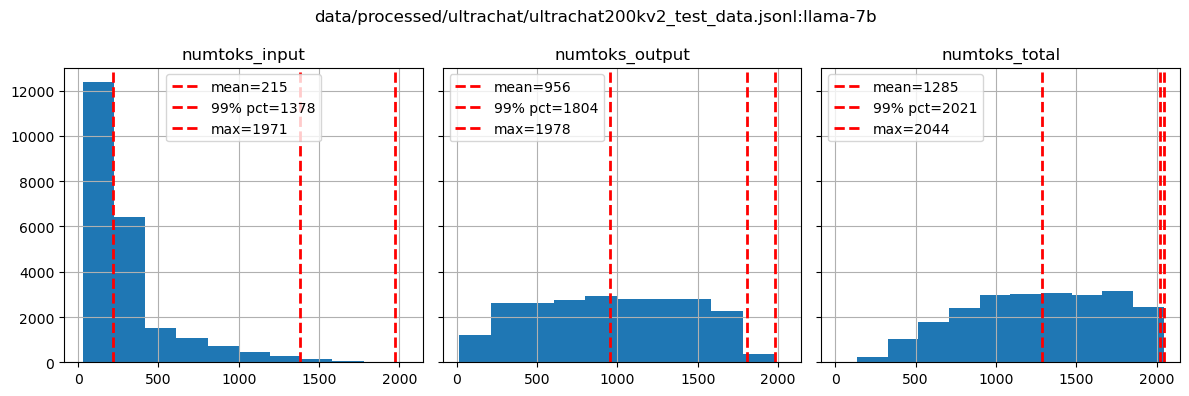

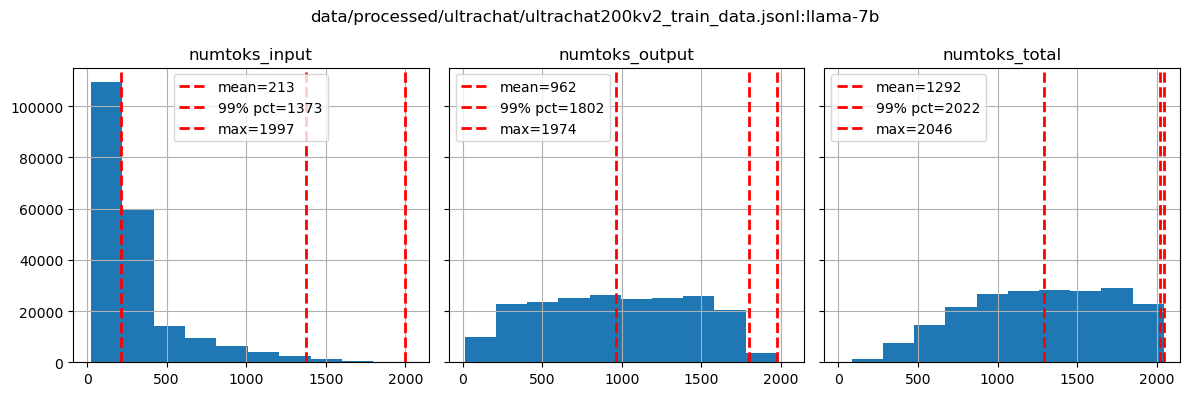

In [25]:
import glob, re, os
from note_pruning_analysis import plt_dataset_numtoks

tokenizer_name_or_path = 'results/baselines/NousResearch/Llama-2-7b-hf'
tokenizer_name_or_path = 'results/baselines/huggyllama/llama-7b'

filepaths = glob.glob('data/processed/*/*.jsonl')
filepaths = [x for x in filepaths if not re.search(r'ultrachat15_[0-9]', x)]
ys = ['wizardlm', 'sharegpt', 'alpaca']
ys = ['flan_v2', 'cot', 'oasst1', 'lima', 'science', 'hard_coded']
# ys =['sharegptv2']
ys = ['open_orca_slim']
ys = ['tulu_v2_data']
ys = ['flan_v2', 'oasst1']
ys = ['dolly']
ys = ['ultrachat200k']
ys = ['ultrachat200kv2']

filepaths = [x for x in filepaths if any(y in x for y in ys)]
print(filepaths)

for dataset in filepaths:
    print(f'{dataset}...')
    plt_dataset_numtoks(dataset, tokenizer_name_or_path)

### Familiar with different datasets' examples

In [9]:

from note_pruning_analysis import write_ds_to_file_for_reading

num_examples = 200

data_dir = 'data/processed'
paths = glob.glob(os.path.join(data_dir, '*/*.jsonl'))
paths = [x for x in paths if 'commentinstrv5' in x]

for path in paths:
    ds = load_dataset('json', 
                      data_files={'train': path}, 
                      split='train', 
                      cache_dir=os.path.dirname(path))
    basename = os.path.basename(path)
    if 'data' in basename:
        name = basename.split('_data')[0]
    else:
        name = basename.split('.')[0]
    write_ds_to_file_for_reading(
        dataset=ds, 
        output_path=f'text_viz/data/processed/{name}.txt',
        num_examples=num_examples)
#     break


Found cached dataset json (/gpfs/u/scratch/PTFM/PTFMqngp/github/mitibm2023/external/open-instruct/scripts/data/processed/starcoder/json/default-4e7e6c05d66f2b3c/0.0.0/8bb11242116d547c741b2e8a1f18598ffdd40a1d4f2a2872c7a28b697434bc96)
Found cached dataset json (/gpfs/u/scratch/PTFM/PTFMqngp/github/mitibm2023/external/open-instruct/scripts/data/processed/starcoder/json/default-be5fa86339f67a34/0.0.0/8bb11242116d547c741b2e8a1f18598ffdd40a1d4f2a2872c7a28b697434bc96)
Found cached dataset json (/gpfs/u/scratch/PTFM/PTFMqngp/github/mitibm2023/external/open-instruct/scripts/data/processed/starcoder/json/default-acfc7c55bb32ba13/0.0.0/8bb11242116d547c741b2e8a1f18598ffdd40a1d4f2a2872c7a28b697434bc96)


Writing 200 examples to text_viz/data/processed/starcoder_commentinstr.txt completed!
Writing 200 examples to text_viz/data/processed/starcoder_commentinstrv2_flppl.txt completed!
Writing 200 examples to text_viz/data/processed/starcoder_commentinstrv2.txt completed!


Extracting data files:   0%|          | 0/1 [00:00<?, ?it/s]

Generating train split: 0 examples [00:00, ? examples/s]

Dataset json downloaded and prepared to /gpfs/u/scratch/PTFM/PTFMqngp/github/mitibm2023/external/open-instruct/scripts/data/processed/starcoder/json/default-c326dfba2dc2467f/0.0.0/8bb11242116d547c741b2e8a1f18598ffdd40a1d4f2a2872c7a28b697434bc96. Subsequent calls will reuse this data.
Writing 200 examples to text_viz/data/processed/starcoder_commentinstrv4_rge5.txt completed!


Extracting data files:   0%|          | 0/1 [00:00<?, ?it/s]

Generating train split: 0 examples [00:00, ? examples/s]

Found cached dataset json (/gpfs/u/scratch/PTFM/PTFMqngp/github/mitibm2023/external/open-instruct/scripts/data/processed/starcoder/json/default-d685ebc5f8ae0f01/0.0.0/8bb11242116d547c741b2e8a1f18598ffdd40a1d4f2a2872c7a28b697434bc96)
Found cached dataset json (/gpfs/u/scratch/PTFM/PTFMqngp/github/mitibm2023/external/open-instruct/scripts/data/processed/starcoder/json/default-609281aa71c1b60c/0.0.0/8bb11242116d547c741b2e8a1f18598ffdd40a1d4f2a2872c7a28b697434bc96)


Dataset json downloaded and prepared to /gpfs/u/scratch/PTFM/PTFMqngp/github/mitibm2023/external/open-instruct/scripts/data/processed/starcoder/json/default-4315ac986c96cb8b/0.0.0/8bb11242116d547c741b2e8a1f18598ffdd40a1d4f2a2872c7a28b697434bc96. Subsequent calls will reuse this data.
Writing 200 examples to text_viz/data/processed/starcoder_commentinstrv4.txt completed!
Writing 200 examples to text_viz/data/processed/starcoder_commentinstrv3.txt completed!
Writing 200 examples to text_viz/data/processed/starcoder_commentinstr_cleaned.txt completed!


### text viz for curriculum

In [11]:
from note_pruning_analysis import save_text_viz_for_curriculum, sample_indices_given_scores

filepaths = glob.glob('curriculum/*/*/*/scores.pkl')
# filepaths = [x for x in filepaths if 'wizardlm' in x]

for path in filepaths:
    save_text_viz_for_curriculum(path)

Found cached dataset json (/gpfs/u/home/PTFM/PTFMqngp/scratch/github/mitibm2023/external/open-instruct/data/processed/starcoder/json/default-5797bf1f6df4dbde/0.0.0/8bb11242116d547c741b2e8a1f18598ffdd40a1d4f2a2872c7a28b697434bc96)


Map:   0%|          | 0/100 [00:00<?, ? examples/s]

Writing 100 examples to text_viz/curriculum/codellama-7b+lora:r=256:a=256/starcoder_commentinstr_cleaned/el2n_agg=mean_neg/sorted_beg.txt completed!


Map:   0%|          | 0/100 [00:00<?, ? examples/s]

Writing 100 examples to text_viz/curriculum/codellama-7b+lora:r=256:a=256/starcoder_commentinstr_cleaned/el2n_agg=mean_neg/sorted_end.txt completed!


Map:   0%|          | 0/100 [00:00<?, ? examples/s]

Writing 100 examples to text_viz/curriculum/codellama-7b+lora:r=256:a=256/starcoder_commentinstr_cleaned/el2n_agg=mean_neg/sorted_random.txt completed!


Map:   0%|          | 0/100 [00:00<?, ? examples/s]

Writing 100 examples to text_viz/curriculum/codellama-7b+lora:r=256:a=256/starcoder_commentinstr_cleaned/el2n_agg=mean_neg/sorted_partition=1:10.txt completed!


Map:   0%|          | 0/100 [00:00<?, ? examples/s]

Writing 100 examples to text_viz/curriculum/codellama-7b+lora:r=256:a=256/starcoder_commentinstr_cleaned/el2n_agg=mean_neg/sorted_partition=10:10.txt completed!


Map:   0%|          | 0/100 [00:00<?, ? examples/s]

Writing 100 examples to text_viz/curriculum/codellama-7b+lora:r=256:a=256/starcoder_commentinstr_cleaned/el2n_agg=mean_neg/sorted1000_beg.txt completed!


Map:   0%|          | 0/100 [00:00<?, ? examples/s]

Writing 100 examples to text_viz/curriculum/codellama-7b+lora:r=256:a=256/starcoder_commentinstr_cleaned/el2n_agg=mean_neg/sorted1000_end.txt completed!


Map:   0%|          | 0/100 [00:00<?, ? examples/s]

Writing 100 examples to text_viz/curriculum/codellama-7b+lora:r=256:a=256/starcoder_commentinstr_cleaned/el2n_agg=mean_neg/sorted1000_random.txt completed!


Map:   0%|          | 0/100 [00:00<?, ? examples/s]

Writing 100 examples to text_viz/curriculum/codellama-7b+lora:r=256:a=256/starcoder_commentinstr_cleaned/el2n_agg=mean_neg/sorted10000_beg.txt completed!


Map:   0%|          | 0/100 [00:00<?, ? examples/s]

Writing 100 examples to text_viz/curriculum/codellama-7b+lora:r=256:a=256/starcoder_commentinstr_cleaned/el2n_agg=mean_neg/sorted10000_end.txt completed!


Map:   0%|          | 0/100 [00:00<?, ? examples/s]

Found cached dataset json (/gpfs/u/home/PTFM/PTFMqngp/scratch/github/mitibm2023/external/open-instruct/data/processed/starcoder/json/default-5797bf1f6df4dbde/0.0.0/8bb11242116d547c741b2e8a1f18598ffdd40a1d4f2a2872c7a28b697434bc96)


Writing 100 examples to text_viz/curriculum/codellama-7b+lora:r=256:a=256/starcoder_commentinstr_cleaned/el2n_agg=mean_neg/sorted10000_random.txt completed!


Map:   0%|          | 0/100 [00:00<?, ? examples/s]

Writing 100 examples to text_viz/curriculum/codellama-7b+lora:r=256:a=256/starcoder_commentinstr_cleaned/logit_margin_neg/sorted_beg.txt completed!


Map:   0%|          | 0/100 [00:00<?, ? examples/s]

Writing 100 examples to text_viz/curriculum/codellama-7b+lora:r=256:a=256/starcoder_commentinstr_cleaned/logit_margin_neg/sorted_end.txt completed!


Map:   0%|          | 0/100 [00:00<?, ? examples/s]

Writing 100 examples to text_viz/curriculum/codellama-7b+lora:r=256:a=256/starcoder_commentinstr_cleaned/logit_margin_neg/sorted_random.txt completed!


Map:   0%|          | 0/100 [00:00<?, ? examples/s]

Writing 100 examples to text_viz/curriculum/codellama-7b+lora:r=256:a=256/starcoder_commentinstr_cleaned/logit_margin_neg/sorted_partition=1:10.txt completed!


Map:   0%|          | 0/100 [00:00<?, ? examples/s]

Writing 100 examples to text_viz/curriculum/codellama-7b+lora:r=256:a=256/starcoder_commentinstr_cleaned/logit_margin_neg/sorted_partition=10:10.txt completed!


Map:   0%|          | 0/100 [00:00<?, ? examples/s]

Writing 100 examples to text_viz/curriculum/codellama-7b+lora:r=256:a=256/starcoder_commentinstr_cleaned/logit_margin_neg/sorted1000_beg.txt completed!


Map:   0%|          | 0/100 [00:00<?, ? examples/s]

Writing 100 examples to text_viz/curriculum/codellama-7b+lora:r=256:a=256/starcoder_commentinstr_cleaned/logit_margin_neg/sorted1000_end.txt completed!


Map:   0%|          | 0/100 [00:00<?, ? examples/s]

Writing 100 examples to text_viz/curriculum/codellama-7b+lora:r=256:a=256/starcoder_commentinstr_cleaned/logit_margin_neg/sorted1000_random.txt completed!


Map:   0%|          | 0/100 [00:00<?, ? examples/s]

Writing 100 examples to text_viz/curriculum/codellama-7b+lora:r=256:a=256/starcoder_commentinstr_cleaned/logit_margin_neg/sorted10000_beg.txt completed!


Map:   0%|          | 0/100 [00:00<?, ? examples/s]

Writing 100 examples to text_viz/curriculum/codellama-7b+lora:r=256:a=256/starcoder_commentinstr_cleaned/logit_margin_neg/sorted10000_end.txt completed!


Map:   0%|          | 0/100 [00:00<?, ? examples/s]

Found cached dataset json (/gpfs/u/home/PTFM/PTFMqngp/scratch/github/mitibm2023/external/open-instruct/data/processed/starcoder/json/default-5797bf1f6df4dbde/0.0.0/8bb11242116d547c741b2e8a1f18598ffdd40a1d4f2a2872c7a28b697434bc96)


Writing 100 examples to text_viz/curriculum/codellama-7b+lora:r=256:a=256/starcoder_commentinstr_cleaned/logit_margin_neg/sorted10000_random.txt completed!


Map:   0%|          | 0/100 [00:00<?, ? examples/s]

Writing 100 examples to text_viz/curriculum/codellama-7b+lora:r=256:a=256/starcoder_commentinstr_cleaned/random_s=0_neg/sorted_beg.txt completed!


Map:   0%|          | 0/100 [00:00<?, ? examples/s]

Writing 100 examples to text_viz/curriculum/codellama-7b+lora:r=256:a=256/starcoder_commentinstr_cleaned/random_s=0_neg/sorted_end.txt completed!


Map:   0%|          | 0/100 [00:00<?, ? examples/s]

Writing 100 examples to text_viz/curriculum/codellama-7b+lora:r=256:a=256/starcoder_commentinstr_cleaned/random_s=0_neg/sorted_random.txt completed!


Map:   0%|          | 0/100 [00:00<?, ? examples/s]

Writing 100 examples to text_viz/curriculum/codellama-7b+lora:r=256:a=256/starcoder_commentinstr_cleaned/random_s=0_neg/sorted_partition=1:10.txt completed!


Map:   0%|          | 0/100 [00:00<?, ? examples/s]

Writing 100 examples to text_viz/curriculum/codellama-7b+lora:r=256:a=256/starcoder_commentinstr_cleaned/random_s=0_neg/sorted_partition=10:10.txt completed!


Map:   0%|          | 0/100 [00:00<?, ? examples/s]

Writing 100 examples to text_viz/curriculum/codellama-7b+lora:r=256:a=256/starcoder_commentinstr_cleaned/random_s=0_neg/sorted1000_beg.txt completed!


Map:   0%|          | 0/100 [00:00<?, ? examples/s]

Writing 100 examples to text_viz/curriculum/codellama-7b+lora:r=256:a=256/starcoder_commentinstr_cleaned/random_s=0_neg/sorted1000_end.txt completed!


Map:   0%|          | 0/100 [00:00<?, ? examples/s]

Writing 100 examples to text_viz/curriculum/codellama-7b+lora:r=256:a=256/starcoder_commentinstr_cleaned/random_s=0_neg/sorted1000_random.txt completed!


Map:   0%|          | 0/100 [00:00<?, ? examples/s]

Writing 100 examples to text_viz/curriculum/codellama-7b+lora:r=256:a=256/starcoder_commentinstr_cleaned/random_s=0_neg/sorted10000_beg.txt completed!


Map:   0%|          | 0/100 [00:00<?, ? examples/s]

Writing 100 examples to text_viz/curriculum/codellama-7b+lora:r=256:a=256/starcoder_commentinstr_cleaned/random_s=0_neg/sorted10000_end.txt completed!


Map:   0%|          | 0/100 [00:00<?, ? examples/s]

Writing 100 examples to text_viz/curriculum/codellama-7b+lora:r=256:a=256/starcoder_commentinstr_cleaned/random_s=0_neg/sorted10000_random.txt completed!


Found cached dataset json (/gpfs/u/home/PTFM/PTFMqngp/scratch/github/mitibm2023/external/open-instruct/data/processed/starcoder/json/default-5797bf1f6df4dbde/0.0.0/8bb11242116d547c741b2e8a1f18598ffdd40a1d4f2a2872c7a28b697434bc96)


Map:   0%|          | 0/100 [00:00<?, ? examples/s]

Writing 100 examples to text_viz/curriculum/codellama-7b+lora:r=256:a=256/starcoder_commentinstr_cleaned/logit_margin/sorted_beg.txt completed!


Map:   0%|          | 0/100 [00:00<?, ? examples/s]

Writing 100 examples to text_viz/curriculum/codellama-7b+lora:r=256:a=256/starcoder_commentinstr_cleaned/logit_margin/sorted_end.txt completed!


Map:   0%|          | 0/100 [00:00<?, ? examples/s]

Writing 100 examples to text_viz/curriculum/codellama-7b+lora:r=256:a=256/starcoder_commentinstr_cleaned/logit_margin/sorted_random.txt completed!


Map:   0%|          | 0/100 [00:00<?, ? examples/s]

Writing 100 examples to text_viz/curriculum/codellama-7b+lora:r=256:a=256/starcoder_commentinstr_cleaned/logit_margin/sorted_partition=1:10.txt completed!


Map:   0%|          | 0/100 [00:00<?, ? examples/s]

Writing 100 examples to text_viz/curriculum/codellama-7b+lora:r=256:a=256/starcoder_commentinstr_cleaned/logit_margin/sorted_partition=10:10.txt completed!


Map:   0%|          | 0/100 [00:00<?, ? examples/s]

Writing 100 examples to text_viz/curriculum/codellama-7b+lora:r=256:a=256/starcoder_commentinstr_cleaned/logit_margin/sorted1000_beg.txt completed!


Map:   0%|          | 0/100 [00:00<?, ? examples/s]

Writing 100 examples to text_viz/curriculum/codellama-7b+lora:r=256:a=256/starcoder_commentinstr_cleaned/logit_margin/sorted1000_end.txt completed!


Map:   0%|          | 0/100 [00:00<?, ? examples/s]

Writing 100 examples to text_viz/curriculum/codellama-7b+lora:r=256:a=256/starcoder_commentinstr_cleaned/logit_margin/sorted1000_random.txt completed!


Map:   0%|          | 0/100 [00:00<?, ? examples/s]

Writing 100 examples to text_viz/curriculum/codellama-7b+lora:r=256:a=256/starcoder_commentinstr_cleaned/logit_margin/sorted10000_beg.txt completed!


Map:   0%|          | 0/100 [00:00<?, ? examples/s]

Writing 100 examples to text_viz/curriculum/codellama-7b+lora:r=256:a=256/starcoder_commentinstr_cleaned/logit_margin/sorted10000_end.txt completed!


Map:   0%|          | 0/100 [00:00<?, ? examples/s]

Writing 100 examples to text_viz/curriculum/codellama-7b+lora:r=256:a=256/starcoder_commentinstr_cleaned/logit_margin/sorted10000_random.txt completed!


Found cached dataset json (/gpfs/u/home/PTFM/PTFMqngp/scratch/github/mitibm2023/external/open-instruct/data/processed/starcoder/json/default-5797bf1f6df4dbde/0.0.0/8bb11242116d547c741b2e8a1f18598ffdd40a1d4f2a2872c7a28b697434bc96)


Map:   0%|          | 0/100 [00:00<?, ? examples/s]

Writing 100 examples to text_viz/curriculum/codellama-7b+lora:r=256:a=256/starcoder_commentinstr_cleaned/log_pmi/sorted_beg.txt completed!


Map:   0%|          | 0/100 [00:00<?, ? examples/s]

Writing 100 examples to text_viz/curriculum/codellama-7b+lora:r=256:a=256/starcoder_commentinstr_cleaned/log_pmi/sorted_end.txt completed!


Map:   0%|          | 0/100 [00:00<?, ? examples/s]

Writing 100 examples to text_viz/curriculum/codellama-7b+lora:r=256:a=256/starcoder_commentinstr_cleaned/log_pmi/sorted_random.txt completed!


Map:   0%|          | 0/100 [00:00<?, ? examples/s]

Writing 100 examples to text_viz/curriculum/codellama-7b+lora:r=256:a=256/starcoder_commentinstr_cleaned/log_pmi/sorted_partition=1:10.txt completed!


Map:   0%|          | 0/100 [00:00<?, ? examples/s]

Writing 100 examples to text_viz/curriculum/codellama-7b+lora:r=256:a=256/starcoder_commentinstr_cleaned/log_pmi/sorted_partition=10:10.txt completed!


Map:   0%|          | 0/100 [00:00<?, ? examples/s]

Writing 100 examples to text_viz/curriculum/codellama-7b+lora:r=256:a=256/starcoder_commentinstr_cleaned/log_pmi/sorted1000_beg.txt completed!


Map:   0%|          | 0/100 [00:00<?, ? examples/s]

Writing 100 examples to text_viz/curriculum/codellama-7b+lora:r=256:a=256/starcoder_commentinstr_cleaned/log_pmi/sorted1000_end.txt completed!


Map:   0%|          | 0/100 [00:00<?, ? examples/s]

Writing 100 examples to text_viz/curriculum/codellama-7b+lora:r=256:a=256/starcoder_commentinstr_cleaned/log_pmi/sorted1000_random.txt completed!


Map:   0%|          | 0/100 [00:00<?, ? examples/s]

Writing 100 examples to text_viz/curriculum/codellama-7b+lora:r=256:a=256/starcoder_commentinstr_cleaned/log_pmi/sorted10000_beg.txt completed!


Map:   0%|          | 0/100 [00:00<?, ? examples/s]

Writing 100 examples to text_viz/curriculum/codellama-7b+lora:r=256:a=256/starcoder_commentinstr_cleaned/log_pmi/sorted10000_end.txt completed!


Map:   0%|          | 0/100 [00:00<?, ? examples/s]

Writing 100 examples to text_viz/curriculum/codellama-7b+lora:r=256:a=256/starcoder_commentinstr_cleaned/log_pmi/sorted10000_random.txt completed!


Found cached dataset json (/gpfs/u/home/PTFM/PTFMqngp/scratch/github/mitibm2023/external/open-instruct/data/processed/starcoder/json/default-5797bf1f6df4dbde/0.0.0/8bb11242116d547c741b2e8a1f18598ffdd40a1d4f2a2872c7a28b697434bc96)


Map:   0%|          | 0/100 [00:00<?, ? examples/s]

Writing 100 examples to text_viz/curriculum/codellama-7b+lora:r=256:a=256/starcoder_commentinstr_cleaned/el2n_agg=mean/sorted_beg.txt completed!


Map:   0%|          | 0/100 [00:00<?, ? examples/s]

Writing 100 examples to text_viz/curriculum/codellama-7b+lora:r=256:a=256/starcoder_commentinstr_cleaned/el2n_agg=mean/sorted_end.txt completed!


Map:   0%|          | 0/100 [00:00<?, ? examples/s]

Writing 100 examples to text_viz/curriculum/codellama-7b+lora:r=256:a=256/starcoder_commentinstr_cleaned/el2n_agg=mean/sorted_random.txt completed!


Map:   0%|          | 0/100 [00:00<?, ? examples/s]

Writing 100 examples to text_viz/curriculum/codellama-7b+lora:r=256:a=256/starcoder_commentinstr_cleaned/el2n_agg=mean/sorted_partition=1:10.txt completed!


Map:   0%|          | 0/100 [00:00<?, ? examples/s]

Writing 100 examples to text_viz/curriculum/codellama-7b+lora:r=256:a=256/starcoder_commentinstr_cleaned/el2n_agg=mean/sorted_partition=10:10.txt completed!


Map:   0%|          | 0/100 [00:00<?, ? examples/s]

Writing 100 examples to text_viz/curriculum/codellama-7b+lora:r=256:a=256/starcoder_commentinstr_cleaned/el2n_agg=mean/sorted1000_beg.txt completed!


Map:   0%|          | 0/100 [00:00<?, ? examples/s]

Writing 100 examples to text_viz/curriculum/codellama-7b+lora:r=256:a=256/starcoder_commentinstr_cleaned/el2n_agg=mean/sorted1000_end.txt completed!


Map:   0%|          | 0/100 [00:00<?, ? examples/s]

Writing 100 examples to text_viz/curriculum/codellama-7b+lora:r=256:a=256/starcoder_commentinstr_cleaned/el2n_agg=mean/sorted1000_random.txt completed!


Map:   0%|          | 0/100 [00:00<?, ? examples/s]

Writing 100 examples to text_viz/curriculum/codellama-7b+lora:r=256:a=256/starcoder_commentinstr_cleaned/el2n_agg=mean/sorted10000_beg.txt completed!


Map:   0%|          | 0/100 [00:00<?, ? examples/s]

Writing 100 examples to text_viz/curriculum/codellama-7b+lora:r=256:a=256/starcoder_commentinstr_cleaned/el2n_agg=mean/sorted10000_end.txt completed!


Map:   0%|          | 0/100 [00:00<?, ? examples/s]

Writing 100 examples to text_viz/curriculum/codellama-7b+lora:r=256:a=256/starcoder_commentinstr_cleaned/el2n_agg=mean/sorted10000_random.txt completed!


Found cached dataset json (/gpfs/u/home/PTFM/PTFMqngp/scratch/github/mitibm2023/external/open-instruct/data/processed/starcoder/json/default-5797bf1f6df4dbde/0.0.0/8bb11242116d547c741b2e8a1f18598ffdd40a1d4f2a2872c7a28b697434bc96)


Map:   0%|          | 0/100 [00:00<?, ? examples/s]

Writing 100 examples to text_viz/curriculum/codellama-7b+lora:r=256:a=256/starcoder_commentinstr_cleaned/log_pmi_neg/sorted_beg.txt completed!


Map:   0%|          | 0/100 [00:00<?, ? examples/s]

Writing 100 examples to text_viz/curriculum/codellama-7b+lora:r=256:a=256/starcoder_commentinstr_cleaned/log_pmi_neg/sorted_end.txt completed!


Map:   0%|          | 0/100 [00:00<?, ? examples/s]

Writing 100 examples to text_viz/curriculum/codellama-7b+lora:r=256:a=256/starcoder_commentinstr_cleaned/log_pmi_neg/sorted_random.txt completed!


Map:   0%|          | 0/100 [00:00<?, ? examples/s]

Writing 100 examples to text_viz/curriculum/codellama-7b+lora:r=256:a=256/starcoder_commentinstr_cleaned/log_pmi_neg/sorted_partition=1:10.txt completed!


Map:   0%|          | 0/100 [00:00<?, ? examples/s]

Writing 100 examples to text_viz/curriculum/codellama-7b+lora:r=256:a=256/starcoder_commentinstr_cleaned/log_pmi_neg/sorted_partition=10:10.txt completed!


Map:   0%|          | 0/100 [00:00<?, ? examples/s]

Writing 100 examples to text_viz/curriculum/codellama-7b+lora:r=256:a=256/starcoder_commentinstr_cleaned/log_pmi_neg/sorted1000_beg.txt completed!


Map:   0%|          | 0/100 [00:00<?, ? examples/s]

Writing 100 examples to text_viz/curriculum/codellama-7b+lora:r=256:a=256/starcoder_commentinstr_cleaned/log_pmi_neg/sorted1000_end.txt completed!


Map:   0%|          | 0/100 [00:00<?, ? examples/s]

Writing 100 examples to text_viz/curriculum/codellama-7b+lora:r=256:a=256/starcoder_commentinstr_cleaned/log_pmi_neg/sorted1000_random.txt completed!


Map:   0%|          | 0/100 [00:00<?, ? examples/s]

Writing 100 examples to text_viz/curriculum/codellama-7b+lora:r=256:a=256/starcoder_commentinstr_cleaned/log_pmi_neg/sorted10000_beg.txt completed!


Map:   0%|          | 0/100 [00:00<?, ? examples/s]

Writing 100 examples to text_viz/curriculum/codellama-7b+lora:r=256:a=256/starcoder_commentinstr_cleaned/log_pmi_neg/sorted10000_end.txt completed!


Map:   0%|          | 0/100 [00:00<?, ? examples/s]

Found cached dataset json (/gpfs/u/home/PTFM/PTFMqngp/scratch/github/mitibm2023/external/open-instruct/data/processed/starcoder/json/default-5797bf1f6df4dbde/0.0.0/8bb11242116d547c741b2e8a1f18598ffdd40a1d4f2a2872c7a28b697434bc96)


Writing 100 examples to text_viz/curriculum/codellama-7b+lora:r=256:a=256/starcoder_commentinstr_cleaned/log_pmi_neg/sorted10000_random.txt completed!


Map:   0%|          | 0/100 [00:00<?, ? examples/s]

Writing 100 examples to text_viz/curriculum/codellama-7b+lora:r=256:a=256/starcoder_commentinstr_cleaned/random_s=2_neg/sorted_beg.txt completed!


Map:   0%|          | 0/100 [00:00<?, ? examples/s]

Writing 100 examples to text_viz/curriculum/codellama-7b+lora:r=256:a=256/starcoder_commentinstr_cleaned/random_s=2_neg/sorted_end.txt completed!


Map:   0%|          | 0/100 [00:00<?, ? examples/s]

Writing 100 examples to text_viz/curriculum/codellama-7b+lora:r=256:a=256/starcoder_commentinstr_cleaned/random_s=2_neg/sorted_random.txt completed!


Map:   0%|          | 0/100 [00:00<?, ? examples/s]

Writing 100 examples to text_viz/curriculum/codellama-7b+lora:r=256:a=256/starcoder_commentinstr_cleaned/random_s=2_neg/sorted_partition=1:10.txt completed!


Map:   0%|          | 0/100 [00:00<?, ? examples/s]

Writing 100 examples to text_viz/curriculum/codellama-7b+lora:r=256:a=256/starcoder_commentinstr_cleaned/random_s=2_neg/sorted_partition=10:10.txt completed!


Map:   0%|          | 0/100 [00:00<?, ? examples/s]

Writing 100 examples to text_viz/curriculum/codellama-7b+lora:r=256:a=256/starcoder_commentinstr_cleaned/random_s=2_neg/sorted1000_beg.txt completed!


Map:   0%|          | 0/100 [00:00<?, ? examples/s]

Writing 100 examples to text_viz/curriculum/codellama-7b+lora:r=256:a=256/starcoder_commentinstr_cleaned/random_s=2_neg/sorted1000_end.txt completed!


Map:   0%|          | 0/100 [00:00<?, ? examples/s]

Writing 100 examples to text_viz/curriculum/codellama-7b+lora:r=256:a=256/starcoder_commentinstr_cleaned/random_s=2_neg/sorted1000_random.txt completed!


Map:   0%|          | 0/100 [00:00<?, ? examples/s]

Writing 100 examples to text_viz/curriculum/codellama-7b+lora:r=256:a=256/starcoder_commentinstr_cleaned/random_s=2_neg/sorted10000_beg.txt completed!


Map:   0%|          | 0/100 [00:00<?, ? examples/s]

Writing 100 examples to text_viz/curriculum/codellama-7b+lora:r=256:a=256/starcoder_commentinstr_cleaned/random_s=2_neg/sorted10000_end.txt completed!


Map:   0%|          | 0/100 [00:00<?, ? examples/s]

Found cached dataset json (/gpfs/u/home/PTFM/PTFMqngp/scratch/github/mitibm2023/external/open-instruct/data/processed/starcoder/json/default-5797bf1f6df4dbde/0.0.0/8bb11242116d547c741b2e8a1f18598ffdd40a1d4f2a2872c7a28b697434bc96)


Writing 100 examples to text_viz/curriculum/codellama-7b+lora:r=256:a=256/starcoder_commentinstr_cleaned/random_s=2_neg/sorted10000_random.txt completed!


Map:   0%|          | 0/100 [00:00<?, ? examples/s]

Writing 100 examples to text_viz/curriculum/codellama-7b+lora:r=256:a=256/starcoder_commentinstr_cleaned/random_s=1/sorted_beg.txt completed!


Map:   0%|          | 0/100 [00:00<?, ? examples/s]

Writing 100 examples to text_viz/curriculum/codellama-7b+lora:r=256:a=256/starcoder_commentinstr_cleaned/random_s=1/sorted_end.txt completed!


Map:   0%|          | 0/100 [00:00<?, ? examples/s]

Writing 100 examples to text_viz/curriculum/codellama-7b+lora:r=256:a=256/starcoder_commentinstr_cleaned/random_s=1/sorted_random.txt completed!


Map:   0%|          | 0/100 [00:00<?, ? examples/s]

Writing 100 examples to text_viz/curriculum/codellama-7b+lora:r=256:a=256/starcoder_commentinstr_cleaned/random_s=1/sorted_partition=1:10.txt completed!


Map:   0%|          | 0/100 [00:00<?, ? examples/s]

Writing 100 examples to text_viz/curriculum/codellama-7b+lora:r=256:a=256/starcoder_commentinstr_cleaned/random_s=1/sorted_partition=10:10.txt completed!


Map:   0%|          | 0/100 [00:00<?, ? examples/s]

Writing 100 examples to text_viz/curriculum/codellama-7b+lora:r=256:a=256/starcoder_commentinstr_cleaned/random_s=1/sorted1000_beg.txt completed!


Map:   0%|          | 0/100 [00:00<?, ? examples/s]

Writing 100 examples to text_viz/curriculum/codellama-7b+lora:r=256:a=256/starcoder_commentinstr_cleaned/random_s=1/sorted1000_end.txt completed!


Map:   0%|          | 0/100 [00:00<?, ? examples/s]

Writing 100 examples to text_viz/curriculum/codellama-7b+lora:r=256:a=256/starcoder_commentinstr_cleaned/random_s=1/sorted1000_random.txt completed!


Map:   0%|          | 0/100 [00:00<?, ? examples/s]

Writing 100 examples to text_viz/curriculum/codellama-7b+lora:r=256:a=256/starcoder_commentinstr_cleaned/random_s=1/sorted10000_beg.txt completed!


Map:   0%|          | 0/100 [00:00<?, ? examples/s]

Writing 100 examples to text_viz/curriculum/codellama-7b+lora:r=256:a=256/starcoder_commentinstr_cleaned/random_s=1/sorted10000_end.txt completed!


Map:   0%|          | 0/100 [00:00<?, ? examples/s]

Found cached dataset json (/gpfs/u/home/PTFM/PTFMqngp/scratch/github/mitibm2023/external/open-instruct/data/processed/starcoder/json/default-5797bf1f6df4dbde/0.0.0/8bb11242116d547c741b2e8a1f18598ffdd40a1d4f2a2872c7a28b697434bc96)


Writing 100 examples to text_viz/curriculum/codellama-7b+lora:r=256:a=256/starcoder_commentinstr_cleaned/random_s=1/sorted10000_random.txt completed!


Map:   0%|          | 0/100 [00:00<?, ? examples/s]

Writing 100 examples to text_viz/curriculum/codellama-7b+lora:r=256:a=256/starcoder_commentinstr_cleaned/log_prob_neg/sorted_beg.txt completed!


Map:   0%|          | 0/100 [00:00<?, ? examples/s]

Writing 100 examples to text_viz/curriculum/codellama-7b+lora:r=256:a=256/starcoder_commentinstr_cleaned/log_prob_neg/sorted_end.txt completed!


Map:   0%|          | 0/100 [00:00<?, ? examples/s]

Writing 100 examples to text_viz/curriculum/codellama-7b+lora:r=256:a=256/starcoder_commentinstr_cleaned/log_prob_neg/sorted_random.txt completed!


Map:   0%|          | 0/100 [00:00<?, ? examples/s]

Writing 100 examples to text_viz/curriculum/codellama-7b+lora:r=256:a=256/starcoder_commentinstr_cleaned/log_prob_neg/sorted_partition=1:10.txt completed!


Map:   0%|          | 0/100 [00:00<?, ? examples/s]

Writing 100 examples to text_viz/curriculum/codellama-7b+lora:r=256:a=256/starcoder_commentinstr_cleaned/log_prob_neg/sorted_partition=10:10.txt completed!


Map:   0%|          | 0/100 [00:00<?, ? examples/s]

Writing 100 examples to text_viz/curriculum/codellama-7b+lora:r=256:a=256/starcoder_commentinstr_cleaned/log_prob_neg/sorted1000_beg.txt completed!


Map:   0%|          | 0/100 [00:00<?, ? examples/s]

Writing 100 examples to text_viz/curriculum/codellama-7b+lora:r=256:a=256/starcoder_commentinstr_cleaned/log_prob_neg/sorted1000_end.txt completed!


Map:   0%|          | 0/100 [00:00<?, ? examples/s]

Writing 100 examples to text_viz/curriculum/codellama-7b+lora:r=256:a=256/starcoder_commentinstr_cleaned/log_prob_neg/sorted1000_random.txt completed!


Map:   0%|          | 0/100 [00:00<?, ? examples/s]

Writing 100 examples to text_viz/curriculum/codellama-7b+lora:r=256:a=256/starcoder_commentinstr_cleaned/log_prob_neg/sorted10000_beg.txt completed!


Map:   0%|          | 0/100 [00:00<?, ? examples/s]

Writing 100 examples to text_viz/curriculum/codellama-7b+lora:r=256:a=256/starcoder_commentinstr_cleaned/log_prob_neg/sorted10000_end.txt completed!


Map:   0%|          | 0/100 [00:00<?, ? examples/s]

Found cached dataset json (/gpfs/u/home/PTFM/PTFMqngp/scratch/github/mitibm2023/external/open-instruct/data/processed/starcoder/json/default-5797bf1f6df4dbde/0.0.0/8bb11242116d547c741b2e8a1f18598ffdd40a1d4f2a2872c7a28b697434bc96)


Writing 100 examples to text_viz/curriculum/codellama-7b+lora:r=256:a=256/starcoder_commentinstr_cleaned/log_prob_neg/sorted10000_random.txt completed!


Map:   0%|          | 0/100 [00:00<?, ? examples/s]

Writing 100 examples to text_viz/curriculum/codellama-7b+lora:r=256:a=256/starcoder_commentinstr_cleaned/ifd_neg/sorted_beg.txt completed!


Map:   0%|          | 0/100 [00:00<?, ? examples/s]

Writing 100 examples to text_viz/curriculum/codellama-7b+lora:r=256:a=256/starcoder_commentinstr_cleaned/ifd_neg/sorted_end.txt completed!


Map:   0%|          | 0/100 [00:00<?, ? examples/s]

Writing 100 examples to text_viz/curriculum/codellama-7b+lora:r=256:a=256/starcoder_commentinstr_cleaned/ifd_neg/sorted_random.txt completed!


Map:   0%|          | 0/100 [00:00<?, ? examples/s]

Writing 100 examples to text_viz/curriculum/codellama-7b+lora:r=256:a=256/starcoder_commentinstr_cleaned/ifd_neg/sorted_partition=1:10.txt completed!


Map:   0%|          | 0/100 [00:00<?, ? examples/s]

Writing 100 examples to text_viz/curriculum/codellama-7b+lora:r=256:a=256/starcoder_commentinstr_cleaned/ifd_neg/sorted_partition=10:10.txt completed!


Map:   0%|          | 0/100 [00:00<?, ? examples/s]

Writing 100 examples to text_viz/curriculum/codellama-7b+lora:r=256:a=256/starcoder_commentinstr_cleaned/ifd_neg/sorted1000_beg.txt completed!


Map:   0%|          | 0/100 [00:00<?, ? examples/s]

Writing 100 examples to text_viz/curriculum/codellama-7b+lora:r=256:a=256/starcoder_commentinstr_cleaned/ifd_neg/sorted1000_end.txt completed!


Map:   0%|          | 0/100 [00:00<?, ? examples/s]

Writing 100 examples to text_viz/curriculum/codellama-7b+lora:r=256:a=256/starcoder_commentinstr_cleaned/ifd_neg/sorted1000_random.txt completed!


Map:   0%|          | 0/100 [00:00<?, ? examples/s]

Writing 100 examples to text_viz/curriculum/codellama-7b+lora:r=256:a=256/starcoder_commentinstr_cleaned/ifd_neg/sorted10000_beg.txt completed!


Map:   0%|          | 0/100 [00:00<?, ? examples/s]

Writing 100 examples to text_viz/curriculum/codellama-7b+lora:r=256:a=256/starcoder_commentinstr_cleaned/ifd_neg/sorted10000_end.txt completed!


Map:   0%|          | 0/100 [00:00<?, ? examples/s]

Found cached dataset json (/gpfs/u/home/PTFM/PTFMqngp/scratch/github/mitibm2023/external/open-instruct/data/processed/starcoder/json/default-5797bf1f6df4dbde/0.0.0/8bb11242116d547c741b2e8a1f18598ffdd40a1d4f2a2872c7a28b697434bc96)


Writing 100 examples to text_viz/curriculum/codellama-7b+lora:r=256:a=256/starcoder_commentinstr_cleaned/ifd_neg/sorted10000_random.txt completed!


Map:   0%|          | 0/100 [00:00<?, ? examples/s]

Writing 100 examples to text_viz/curriculum/codellama-7b+lora:r=256:a=256/starcoder_commentinstr_cleaned/random_s=2/sorted_beg.txt completed!


Map:   0%|          | 0/100 [00:00<?, ? examples/s]

Writing 100 examples to text_viz/curriculum/codellama-7b+lora:r=256:a=256/starcoder_commentinstr_cleaned/random_s=2/sorted_end.txt completed!


Map:   0%|          | 0/100 [00:00<?, ? examples/s]

Writing 100 examples to text_viz/curriculum/codellama-7b+lora:r=256:a=256/starcoder_commentinstr_cleaned/random_s=2/sorted_random.txt completed!


Map:   0%|          | 0/100 [00:00<?, ? examples/s]

Writing 100 examples to text_viz/curriculum/codellama-7b+lora:r=256:a=256/starcoder_commentinstr_cleaned/random_s=2/sorted_partition=1:10.txt completed!


Map:   0%|          | 0/100 [00:00<?, ? examples/s]

Writing 100 examples to text_viz/curriculum/codellama-7b+lora:r=256:a=256/starcoder_commentinstr_cleaned/random_s=2/sorted_partition=10:10.txt completed!


Map:   0%|          | 0/100 [00:00<?, ? examples/s]

Writing 100 examples to text_viz/curriculum/codellama-7b+lora:r=256:a=256/starcoder_commentinstr_cleaned/random_s=2/sorted1000_beg.txt completed!


Map:   0%|          | 0/100 [00:00<?, ? examples/s]

Writing 100 examples to text_viz/curriculum/codellama-7b+lora:r=256:a=256/starcoder_commentinstr_cleaned/random_s=2/sorted1000_end.txt completed!


Map:   0%|          | 0/100 [00:00<?, ? examples/s]

Writing 100 examples to text_viz/curriculum/codellama-7b+lora:r=256:a=256/starcoder_commentinstr_cleaned/random_s=2/sorted1000_random.txt completed!


Map:   0%|          | 0/100 [00:00<?, ? examples/s]

Writing 100 examples to text_viz/curriculum/codellama-7b+lora:r=256:a=256/starcoder_commentinstr_cleaned/random_s=2/sorted10000_beg.txt completed!


Map:   0%|          | 0/100 [00:00<?, ? examples/s]

Writing 100 examples to text_viz/curriculum/codellama-7b+lora:r=256:a=256/starcoder_commentinstr_cleaned/random_s=2/sorted10000_end.txt completed!


Map:   0%|          | 0/100 [00:00<?, ? examples/s]

Found cached dataset json (/gpfs/u/home/PTFM/PTFMqngp/scratch/github/mitibm2023/external/open-instruct/data/processed/starcoder/json/default-5797bf1f6df4dbde/0.0.0/8bb11242116d547c741b2e8a1f18598ffdd40a1d4f2a2872c7a28b697434bc96)


Writing 100 examples to text_viz/curriculum/codellama-7b+lora:r=256:a=256/starcoder_commentinstr_cleaned/random_s=2/sorted10000_random.txt completed!


Map:   0%|          | 0/100 [00:00<?, ? examples/s]

Writing 100 examples to text_viz/curriculum/codellama-7b+lora:r=256:a=256/starcoder_commentinstr_cleaned/ifd/sorted_beg.txt completed!


Map:   0%|          | 0/100 [00:00<?, ? examples/s]

Writing 100 examples to text_viz/curriculum/codellama-7b+lora:r=256:a=256/starcoder_commentinstr_cleaned/ifd/sorted_end.txt completed!


Map:   0%|          | 0/100 [00:00<?, ? examples/s]

Writing 100 examples to text_viz/curriculum/codellama-7b+lora:r=256:a=256/starcoder_commentinstr_cleaned/ifd/sorted_random.txt completed!


Map:   0%|          | 0/100 [00:00<?, ? examples/s]

Writing 100 examples to text_viz/curriculum/codellama-7b+lora:r=256:a=256/starcoder_commentinstr_cleaned/ifd/sorted_partition=1:10.txt completed!


Map:   0%|          | 0/100 [00:00<?, ? examples/s]

Writing 100 examples to text_viz/curriculum/codellama-7b+lora:r=256:a=256/starcoder_commentinstr_cleaned/ifd/sorted_partition=10:10.txt completed!


Map:   0%|          | 0/100 [00:00<?, ? examples/s]

Writing 100 examples to text_viz/curriculum/codellama-7b+lora:r=256:a=256/starcoder_commentinstr_cleaned/ifd/sorted1000_beg.txt completed!


Map:   0%|          | 0/100 [00:00<?, ? examples/s]

Writing 100 examples to text_viz/curriculum/codellama-7b+lora:r=256:a=256/starcoder_commentinstr_cleaned/ifd/sorted1000_end.txt completed!


Map:   0%|          | 0/100 [00:00<?, ? examples/s]

Writing 100 examples to text_viz/curriculum/codellama-7b+lora:r=256:a=256/starcoder_commentinstr_cleaned/ifd/sorted1000_random.txt completed!


Map:   0%|          | 0/100 [00:00<?, ? examples/s]

Writing 100 examples to text_viz/curriculum/codellama-7b+lora:r=256:a=256/starcoder_commentinstr_cleaned/ifd/sorted10000_beg.txt completed!


Map:   0%|          | 0/100 [00:00<?, ? examples/s]

Writing 100 examples to text_viz/curriculum/codellama-7b+lora:r=256:a=256/starcoder_commentinstr_cleaned/ifd/sorted10000_end.txt completed!


Map:   0%|          | 0/100 [00:00<?, ? examples/s]

Found cached dataset json (/gpfs/u/home/PTFM/PTFMqngp/scratch/github/mitibm2023/external/open-instruct/data/processed/starcoder/json/default-5797bf1f6df4dbde/0.0.0/8bb11242116d547c741b2e8a1f18598ffdd40a1d4f2a2872c7a28b697434bc96)


Writing 100 examples to text_viz/curriculum/codellama-7b+lora:r=256:a=256/starcoder_commentinstr_cleaned/ifd/sorted10000_random.txt completed!


Map:   0%|          | 0/100 [00:00<?, ? examples/s]

Writing 100 examples to text_viz/curriculum/codellama-7b+lora:r=256:a=256/starcoder_commentinstr_cleaned/grad_loraB_l2n/sorted_beg.txt completed!


Map:   0%|          | 0/100 [00:00<?, ? examples/s]

Writing 100 examples to text_viz/curriculum/codellama-7b+lora:r=256:a=256/starcoder_commentinstr_cleaned/grad_loraB_l2n/sorted_end.txt completed!


Map:   0%|          | 0/100 [00:00<?, ? examples/s]

Writing 100 examples to text_viz/curriculum/codellama-7b+lora:r=256:a=256/starcoder_commentinstr_cleaned/grad_loraB_l2n/sorted_random.txt completed!


Map:   0%|          | 0/100 [00:00<?, ? examples/s]

Writing 100 examples to text_viz/curriculum/codellama-7b+lora:r=256:a=256/starcoder_commentinstr_cleaned/grad_loraB_l2n/sorted_partition=1:10.txt completed!


Map:   0%|          | 0/100 [00:00<?, ? examples/s]

Writing 100 examples to text_viz/curriculum/codellama-7b+lora:r=256:a=256/starcoder_commentinstr_cleaned/grad_loraB_l2n/sorted_partition=10:10.txt completed!


Map:   0%|          | 0/100 [00:00<?, ? examples/s]

Writing 100 examples to text_viz/curriculum/codellama-7b+lora:r=256:a=256/starcoder_commentinstr_cleaned/grad_loraB_l2n/sorted1000_beg.txt completed!


Map:   0%|          | 0/100 [00:00<?, ? examples/s]

Writing 100 examples to text_viz/curriculum/codellama-7b+lora:r=256:a=256/starcoder_commentinstr_cleaned/grad_loraB_l2n/sorted1000_end.txt completed!


Map:   0%|          | 0/100 [00:00<?, ? examples/s]

Writing 100 examples to text_viz/curriculum/codellama-7b+lora:r=256:a=256/starcoder_commentinstr_cleaned/grad_loraB_l2n/sorted1000_random.txt completed!


Map:   0%|          | 0/100 [00:00<?, ? examples/s]

Writing 100 examples to text_viz/curriculum/codellama-7b+lora:r=256:a=256/starcoder_commentinstr_cleaned/grad_loraB_l2n/sorted10000_beg.txt completed!


Map:   0%|          | 0/100 [00:00<?, ? examples/s]

Writing 100 examples to text_viz/curriculum/codellama-7b+lora:r=256:a=256/starcoder_commentinstr_cleaned/grad_loraB_l2n/sorted10000_end.txt completed!


Map:   0%|          | 0/100 [00:00<?, ? examples/s]

Writing 100 examples to text_viz/curriculum/codellama-7b+lora:r=256:a=256/starcoder_commentinstr_cleaned/grad_loraB_l2n/sorted10000_random.txt completed!


Found cached dataset json (/gpfs/u/home/PTFM/PTFMqngp/scratch/github/mitibm2023/external/open-instruct/data/processed/starcoder/json/default-5797bf1f6df4dbde/0.0.0/8bb11242116d547c741b2e8a1f18598ffdd40a1d4f2a2872c7a28b697434bc96)


Map:   0%|          | 0/100 [00:00<?, ? examples/s]

Writing 100 examples to text_viz/curriculum/codellama-7b+lora:r=256:a=256/starcoder_commentinstr_cleaned/grad_loraB_l2n_neg/sorted_beg.txt completed!


Map:   0%|          | 0/100 [00:00<?, ? examples/s]

Writing 100 examples to text_viz/curriculum/codellama-7b+lora:r=256:a=256/starcoder_commentinstr_cleaned/grad_loraB_l2n_neg/sorted_end.txt completed!


Map:   0%|          | 0/100 [00:00<?, ? examples/s]

Writing 100 examples to text_viz/curriculum/codellama-7b+lora:r=256:a=256/starcoder_commentinstr_cleaned/grad_loraB_l2n_neg/sorted_random.txt completed!


Map:   0%|          | 0/100 [00:00<?, ? examples/s]

Writing 100 examples to text_viz/curriculum/codellama-7b+lora:r=256:a=256/starcoder_commentinstr_cleaned/grad_loraB_l2n_neg/sorted_partition=1:10.txt completed!


Map:   0%|          | 0/100 [00:00<?, ? examples/s]

Writing 100 examples to text_viz/curriculum/codellama-7b+lora:r=256:a=256/starcoder_commentinstr_cleaned/grad_loraB_l2n_neg/sorted_partition=10:10.txt completed!


Map:   0%|          | 0/100 [00:00<?, ? examples/s]

Writing 100 examples to text_viz/curriculum/codellama-7b+lora:r=256:a=256/starcoder_commentinstr_cleaned/grad_loraB_l2n_neg/sorted1000_beg.txt completed!


Map:   0%|          | 0/100 [00:00<?, ? examples/s]

Writing 100 examples to text_viz/curriculum/codellama-7b+lora:r=256:a=256/starcoder_commentinstr_cleaned/grad_loraB_l2n_neg/sorted1000_end.txt completed!


Map:   0%|          | 0/100 [00:00<?, ? examples/s]

Writing 100 examples to text_viz/curriculum/codellama-7b+lora:r=256:a=256/starcoder_commentinstr_cleaned/grad_loraB_l2n_neg/sorted1000_random.txt completed!


Map:   0%|          | 0/100 [00:00<?, ? examples/s]

Writing 100 examples to text_viz/curriculum/codellama-7b+lora:r=256:a=256/starcoder_commentinstr_cleaned/grad_loraB_l2n_neg/sorted10000_beg.txt completed!


Map:   0%|          | 0/100 [00:00<?, ? examples/s]

Writing 100 examples to text_viz/curriculum/codellama-7b+lora:r=256:a=256/starcoder_commentinstr_cleaned/grad_loraB_l2n_neg/sorted10000_end.txt completed!


Map:   0%|          | 0/100 [00:00<?, ? examples/s]

Found cached dataset json (/gpfs/u/home/PTFM/PTFMqngp/scratch/github/mitibm2023/external/open-instruct/data/processed/starcoder/json/default-5797bf1f6df4dbde/0.0.0/8bb11242116d547c741b2e8a1f18598ffdd40a1d4f2a2872c7a28b697434bc96)


Writing 100 examples to text_viz/curriculum/codellama-7b+lora:r=256:a=256/starcoder_commentinstr_cleaned/grad_loraB_l2n_neg/sorted10000_random.txt completed!


Map:   0%|          | 0/100 [00:00<?, ? examples/s]

Writing 100 examples to text_viz/curriculum/codellama-7b+lora:r=256:a=256/starcoder_commentinstr_cleaned/log_prob/sorted_beg.txt completed!


Map:   0%|          | 0/100 [00:00<?, ? examples/s]

Writing 100 examples to text_viz/curriculum/codellama-7b+lora:r=256:a=256/starcoder_commentinstr_cleaned/log_prob/sorted_end.txt completed!


Map:   0%|          | 0/100 [00:00<?, ? examples/s]

Writing 100 examples to text_viz/curriculum/codellama-7b+lora:r=256:a=256/starcoder_commentinstr_cleaned/log_prob/sorted_random.txt completed!


Map:   0%|          | 0/100 [00:00<?, ? examples/s]

Writing 100 examples to text_viz/curriculum/codellama-7b+lora:r=256:a=256/starcoder_commentinstr_cleaned/log_prob/sorted_partition=1:10.txt completed!


Map:   0%|          | 0/100 [00:00<?, ? examples/s]

Writing 100 examples to text_viz/curriculum/codellama-7b+lora:r=256:a=256/starcoder_commentinstr_cleaned/log_prob/sorted_partition=10:10.txt completed!


Map:   0%|          | 0/100 [00:00<?, ? examples/s]

Writing 100 examples to text_viz/curriculum/codellama-7b+lora:r=256:a=256/starcoder_commentinstr_cleaned/log_prob/sorted1000_beg.txt completed!


Map:   0%|          | 0/100 [00:00<?, ? examples/s]

Writing 100 examples to text_viz/curriculum/codellama-7b+lora:r=256:a=256/starcoder_commentinstr_cleaned/log_prob/sorted1000_end.txt completed!


Map:   0%|          | 0/100 [00:00<?, ? examples/s]

Writing 100 examples to text_viz/curriculum/codellama-7b+lora:r=256:a=256/starcoder_commentinstr_cleaned/log_prob/sorted1000_random.txt completed!


Map:   0%|          | 0/100 [00:00<?, ? examples/s]

Writing 100 examples to text_viz/curriculum/codellama-7b+lora:r=256:a=256/starcoder_commentinstr_cleaned/log_prob/sorted10000_beg.txt completed!


Map:   0%|          | 0/100 [00:00<?, ? examples/s]

Writing 100 examples to text_viz/curriculum/codellama-7b+lora:r=256:a=256/starcoder_commentinstr_cleaned/log_prob/sorted10000_end.txt completed!


Map:   0%|          | 0/100 [00:00<?, ? examples/s]

Writing 100 examples to text_viz/curriculum/codellama-7b+lora:r=256:a=256/starcoder_commentinstr_cleaned/log_prob/sorted10000_random.txt completed!


Found cached dataset json (/gpfs/u/home/PTFM/PTFMqngp/scratch/github/mitibm2023/external/open-instruct/data/processed/starcoder/json/default-5797bf1f6df4dbde/0.0.0/8bb11242116d547c741b2e8a1f18598ffdd40a1d4f2a2872c7a28b697434bc96)


Map:   0%|          | 0/100 [00:00<?, ? examples/s]

Writing 100 examples to text_viz/curriculum/codellama-7b+lora:r=256:a=256/starcoder_commentinstr_cleaned/random_s=0/sorted_beg.txt completed!


Map:   0%|          | 0/100 [00:00<?, ? examples/s]

Writing 100 examples to text_viz/curriculum/codellama-7b+lora:r=256:a=256/starcoder_commentinstr_cleaned/random_s=0/sorted_end.txt completed!


Map:   0%|          | 0/100 [00:00<?, ? examples/s]

Writing 100 examples to text_viz/curriculum/codellama-7b+lora:r=256:a=256/starcoder_commentinstr_cleaned/random_s=0/sorted_random.txt completed!


Map:   0%|          | 0/100 [00:00<?, ? examples/s]

Writing 100 examples to text_viz/curriculum/codellama-7b+lora:r=256:a=256/starcoder_commentinstr_cleaned/random_s=0/sorted_partition=1:10.txt completed!


Map:   0%|          | 0/100 [00:00<?, ? examples/s]

Writing 100 examples to text_viz/curriculum/codellama-7b+lora:r=256:a=256/starcoder_commentinstr_cleaned/random_s=0/sorted_partition=10:10.txt completed!


Map:   0%|          | 0/100 [00:00<?, ? examples/s]

Writing 100 examples to text_viz/curriculum/codellama-7b+lora:r=256:a=256/starcoder_commentinstr_cleaned/random_s=0/sorted1000_beg.txt completed!


Map:   0%|          | 0/100 [00:00<?, ? examples/s]

Writing 100 examples to text_viz/curriculum/codellama-7b+lora:r=256:a=256/starcoder_commentinstr_cleaned/random_s=0/sorted1000_end.txt completed!


Map:   0%|          | 0/100 [00:00<?, ? examples/s]

Writing 100 examples to text_viz/curriculum/codellama-7b+lora:r=256:a=256/starcoder_commentinstr_cleaned/random_s=0/sorted1000_random.txt completed!


Map:   0%|          | 0/100 [00:00<?, ? examples/s]

Writing 100 examples to text_viz/curriculum/codellama-7b+lora:r=256:a=256/starcoder_commentinstr_cleaned/random_s=0/sorted10000_beg.txt completed!


Map:   0%|          | 0/100 [00:00<?, ? examples/s]

Writing 100 examples to text_viz/curriculum/codellama-7b+lora:r=256:a=256/starcoder_commentinstr_cleaned/random_s=0/sorted10000_end.txt completed!


Map:   0%|          | 0/100 [00:00<?, ? examples/s]

Found cached dataset json (/gpfs/u/home/PTFM/PTFMqngp/scratch/github/mitibm2023/external/open-instruct/data/processed/starcoder/json/default-5797bf1f6df4dbde/0.0.0/8bb11242116d547c741b2e8a1f18598ffdd40a1d4f2a2872c7a28b697434bc96)


Writing 100 examples to text_viz/curriculum/codellama-7b+lora:r=256:a=256/starcoder_commentinstr_cleaned/random_s=0/sorted10000_random.txt completed!


Map:   0%|          | 0/100 [00:00<?, ? examples/s]

Writing 100 examples to text_viz/curriculum/codellama-7b+lora:r=256:a=256/starcoder_commentinstr_cleaned/random_s=1_neg/sorted_beg.txt completed!


Map:   0%|          | 0/100 [00:00<?, ? examples/s]

Writing 100 examples to text_viz/curriculum/codellama-7b+lora:r=256:a=256/starcoder_commentinstr_cleaned/random_s=1_neg/sorted_end.txt completed!


Map:   0%|          | 0/100 [00:00<?, ? examples/s]

Writing 100 examples to text_viz/curriculum/codellama-7b+lora:r=256:a=256/starcoder_commentinstr_cleaned/random_s=1_neg/sorted_random.txt completed!


Map:   0%|          | 0/100 [00:00<?, ? examples/s]

Writing 100 examples to text_viz/curriculum/codellama-7b+lora:r=256:a=256/starcoder_commentinstr_cleaned/random_s=1_neg/sorted_partition=1:10.txt completed!


Map:   0%|          | 0/100 [00:00<?, ? examples/s]

Writing 100 examples to text_viz/curriculum/codellama-7b+lora:r=256:a=256/starcoder_commentinstr_cleaned/random_s=1_neg/sorted_partition=10:10.txt completed!


Map:   0%|          | 0/100 [00:00<?, ? examples/s]

Writing 100 examples to text_viz/curriculum/codellama-7b+lora:r=256:a=256/starcoder_commentinstr_cleaned/random_s=1_neg/sorted1000_beg.txt completed!


Map:   0%|          | 0/100 [00:00<?, ? examples/s]

Writing 100 examples to text_viz/curriculum/codellama-7b+lora:r=256:a=256/starcoder_commentinstr_cleaned/random_s=1_neg/sorted1000_end.txt completed!


Map:   0%|          | 0/100 [00:00<?, ? examples/s]

Writing 100 examples to text_viz/curriculum/codellama-7b+lora:r=256:a=256/starcoder_commentinstr_cleaned/random_s=1_neg/sorted1000_random.txt completed!


Map:   0%|          | 0/100 [00:00<?, ? examples/s]

Writing 100 examples to text_viz/curriculum/codellama-7b+lora:r=256:a=256/starcoder_commentinstr_cleaned/random_s=1_neg/sorted10000_beg.txt completed!


Map:   0%|          | 0/100 [00:00<?, ? examples/s]

Writing 100 examples to text_viz/curriculum/codellama-7b+lora:r=256:a=256/starcoder_commentinstr_cleaned/random_s=1_neg/sorted10000_end.txt completed!


Map:   0%|          | 0/100 [00:00<?, ? examples/s]

Writing 100 examples to text_viz/curriculum/codellama-7b+lora:r=256:a=256/starcoder_commentinstr_cleaned/random_s=1_neg/sorted10000_random.txt completed!


Found cached dataset json (/gpfs/u/home/PTFM/PTFMqngp/scratch/github/mitibm2023/external/open-instruct/data/processed/starcoder/json/default-3135c2f0f8777a2e/0.0.0/8bb11242116d547c741b2e8a1f18598ffdd40a1d4f2a2872c7a28b697434bc96)


Map:   0%|          | 0/100 [00:00<?, ? examples/s]

Writing 100 examples to text_viz/curriculum/codellama-7b+lora:r=256:a=256/starcoder_commentinstr/el2n_agg=mean_neg/sorted_beg.txt completed!


Map:   0%|          | 0/100 [00:00<?, ? examples/s]

Writing 100 examples to text_viz/curriculum/codellama-7b+lora:r=256:a=256/starcoder_commentinstr/el2n_agg=mean_neg/sorted_end.txt completed!


Map:   0%|          | 0/100 [00:00<?, ? examples/s]

Writing 100 examples to text_viz/curriculum/codellama-7b+lora:r=256:a=256/starcoder_commentinstr/el2n_agg=mean_neg/sorted_random.txt completed!


Map:   0%|          | 0/100 [00:00<?, ? examples/s]

Writing 100 examples to text_viz/curriculum/codellama-7b+lora:r=256:a=256/starcoder_commentinstr/el2n_agg=mean_neg/sorted_partition=1:10.txt completed!


Map:   0%|          | 0/100 [00:00<?, ? examples/s]

Writing 100 examples to text_viz/curriculum/codellama-7b+lora:r=256:a=256/starcoder_commentinstr/el2n_agg=mean_neg/sorted_partition=10:10.txt completed!


Map:   0%|          | 0/100 [00:00<?, ? examples/s]

Writing 100 examples to text_viz/curriculum/codellama-7b+lora:r=256:a=256/starcoder_commentinstr/el2n_agg=mean_neg/sorted1000_beg.txt completed!


Map:   0%|          | 0/100 [00:00<?, ? examples/s]

Writing 100 examples to text_viz/curriculum/codellama-7b+lora:r=256:a=256/starcoder_commentinstr/el2n_agg=mean_neg/sorted1000_end.txt completed!


Map:   0%|          | 0/100 [00:00<?, ? examples/s]

Writing 100 examples to text_viz/curriculum/codellama-7b+lora:r=256:a=256/starcoder_commentinstr/el2n_agg=mean_neg/sorted1000_random.txt completed!


Map:   0%|          | 0/100 [00:00<?, ? examples/s]

Writing 100 examples to text_viz/curriculum/codellama-7b+lora:r=256:a=256/starcoder_commentinstr/el2n_agg=mean_neg/sorted10000_beg.txt completed!


Map:   0%|          | 0/100 [00:00<?, ? examples/s]

Writing 100 examples to text_viz/curriculum/codellama-7b+lora:r=256:a=256/starcoder_commentinstr/el2n_agg=mean_neg/sorted10000_end.txt completed!


Map:   0%|          | 0/100 [00:00<?, ? examples/s]

Writing 100 examples to text_viz/curriculum/codellama-7b+lora:r=256:a=256/starcoder_commentinstr/el2n_agg=mean_neg/sorted10000_random.txt completed!


Found cached dataset json (/gpfs/u/home/PTFM/PTFMqngp/scratch/github/mitibm2023/external/open-instruct/data/processed/starcoder/json/default-3135c2f0f8777a2e/0.0.0/8bb11242116d547c741b2e8a1f18598ffdd40a1d4f2a2872c7a28b697434bc96)


Map:   0%|          | 0/100 [00:00<?, ? examples/s]

Writing 100 examples to text_viz/curriculum/codellama-7b+lora:r=256:a=256/starcoder_commentinstr/logit_margin_neg/sorted_beg.txt completed!


Map:   0%|          | 0/100 [00:00<?, ? examples/s]

Writing 100 examples to text_viz/curriculum/codellama-7b+lora:r=256:a=256/starcoder_commentinstr/logit_margin_neg/sorted_end.txt completed!


Map:   0%|          | 0/100 [00:00<?, ? examples/s]

Writing 100 examples to text_viz/curriculum/codellama-7b+lora:r=256:a=256/starcoder_commentinstr/logit_margin_neg/sorted_random.txt completed!


Map:   0%|          | 0/100 [00:00<?, ? examples/s]

Writing 100 examples to text_viz/curriculum/codellama-7b+lora:r=256:a=256/starcoder_commentinstr/logit_margin_neg/sorted_partition=1:10.txt completed!


Map:   0%|          | 0/100 [00:00<?, ? examples/s]

Writing 100 examples to text_viz/curriculum/codellama-7b+lora:r=256:a=256/starcoder_commentinstr/logit_margin_neg/sorted_partition=10:10.txt completed!


Map:   0%|          | 0/100 [00:00<?, ? examples/s]

Writing 100 examples to text_viz/curriculum/codellama-7b+lora:r=256:a=256/starcoder_commentinstr/logit_margin_neg/sorted1000_beg.txt completed!


Map:   0%|          | 0/100 [00:00<?, ? examples/s]

Writing 100 examples to text_viz/curriculum/codellama-7b+lora:r=256:a=256/starcoder_commentinstr/logit_margin_neg/sorted1000_end.txt completed!


Map:   0%|          | 0/100 [00:00<?, ? examples/s]

Writing 100 examples to text_viz/curriculum/codellama-7b+lora:r=256:a=256/starcoder_commentinstr/logit_margin_neg/sorted1000_random.txt completed!


Map:   0%|          | 0/100 [00:00<?, ? examples/s]

Writing 100 examples to text_viz/curriculum/codellama-7b+lora:r=256:a=256/starcoder_commentinstr/logit_margin_neg/sorted10000_beg.txt completed!


Map:   0%|          | 0/100 [00:00<?, ? examples/s]

Writing 100 examples to text_viz/curriculum/codellama-7b+lora:r=256:a=256/starcoder_commentinstr/logit_margin_neg/sorted10000_end.txt completed!


Map:   0%|          | 0/100 [00:00<?, ? examples/s]

Found cached dataset json (/gpfs/u/home/PTFM/PTFMqngp/scratch/github/mitibm2023/external/open-instruct/data/processed/starcoder/json/default-3135c2f0f8777a2e/0.0.0/8bb11242116d547c741b2e8a1f18598ffdd40a1d4f2a2872c7a28b697434bc96)


Writing 100 examples to text_viz/curriculum/codellama-7b+lora:r=256:a=256/starcoder_commentinstr/logit_margin_neg/sorted10000_random.txt completed!


Map:   0%|          | 0/100 [00:00<?, ? examples/s]

Writing 100 examples to text_viz/curriculum/codellama-7b+lora:r=256:a=256/starcoder_commentinstr/random_s=0_neg/sorted_beg.txt completed!


Map:   0%|          | 0/100 [00:00<?, ? examples/s]

Writing 100 examples to text_viz/curriculum/codellama-7b+lora:r=256:a=256/starcoder_commentinstr/random_s=0_neg/sorted_end.txt completed!


Map:   0%|          | 0/100 [00:00<?, ? examples/s]

Writing 100 examples to text_viz/curriculum/codellama-7b+lora:r=256:a=256/starcoder_commentinstr/random_s=0_neg/sorted_random.txt completed!


Map:   0%|          | 0/100 [00:00<?, ? examples/s]

Writing 100 examples to text_viz/curriculum/codellama-7b+lora:r=256:a=256/starcoder_commentinstr/random_s=0_neg/sorted_partition=1:10.txt completed!


Map:   0%|          | 0/100 [00:00<?, ? examples/s]

Writing 100 examples to text_viz/curriculum/codellama-7b+lora:r=256:a=256/starcoder_commentinstr/random_s=0_neg/sorted_partition=10:10.txt completed!


Map:   0%|          | 0/100 [00:00<?, ? examples/s]

Writing 100 examples to text_viz/curriculum/codellama-7b+lora:r=256:a=256/starcoder_commentinstr/random_s=0_neg/sorted1000_beg.txt completed!


Map:   0%|          | 0/100 [00:00<?, ? examples/s]

Writing 100 examples to text_viz/curriculum/codellama-7b+lora:r=256:a=256/starcoder_commentinstr/random_s=0_neg/sorted1000_end.txt completed!


Map:   0%|          | 0/100 [00:00<?, ? examples/s]

Writing 100 examples to text_viz/curriculum/codellama-7b+lora:r=256:a=256/starcoder_commentinstr/random_s=0_neg/sorted1000_random.txt completed!


Map:   0%|          | 0/100 [00:00<?, ? examples/s]

Writing 100 examples to text_viz/curriculum/codellama-7b+lora:r=256:a=256/starcoder_commentinstr/random_s=0_neg/sorted10000_beg.txt completed!


Map:   0%|          | 0/100 [00:00<?, ? examples/s]

Writing 100 examples to text_viz/curriculum/codellama-7b+lora:r=256:a=256/starcoder_commentinstr/random_s=0_neg/sorted10000_end.txt completed!


Map:   0%|          | 0/100 [00:00<?, ? examples/s]

Writing 100 examples to text_viz/curriculum/codellama-7b+lora:r=256:a=256/starcoder_commentinstr/random_s=0_neg/sorted10000_random.txt completed!


Found cached dataset json (/gpfs/u/home/PTFM/PTFMqngp/scratch/github/mitibm2023/external/open-instruct/data/processed/starcoder/json/default-3135c2f0f8777a2e/0.0.0/8bb11242116d547c741b2e8a1f18598ffdd40a1d4f2a2872c7a28b697434bc96)


Map:   0%|          | 0/100 [00:00<?, ? examples/s]

Writing 100 examples to text_viz/curriculum/codellama-7b+lora:r=256:a=256/starcoder_commentinstr/logit_margin/sorted_beg.txt completed!


Map:   0%|          | 0/100 [00:00<?, ? examples/s]

Writing 100 examples to text_viz/curriculum/codellama-7b+lora:r=256:a=256/starcoder_commentinstr/logit_margin/sorted_end.txt completed!


Map:   0%|          | 0/100 [00:00<?, ? examples/s]

Writing 100 examples to text_viz/curriculum/codellama-7b+lora:r=256:a=256/starcoder_commentinstr/logit_margin/sorted_random.txt completed!


Map:   0%|          | 0/100 [00:00<?, ? examples/s]

Writing 100 examples to text_viz/curriculum/codellama-7b+lora:r=256:a=256/starcoder_commentinstr/logit_margin/sorted_partition=1:10.txt completed!


Map:   0%|          | 0/100 [00:00<?, ? examples/s]

Writing 100 examples to text_viz/curriculum/codellama-7b+lora:r=256:a=256/starcoder_commentinstr/logit_margin/sorted_partition=10:10.txt completed!


Map:   0%|          | 0/100 [00:00<?, ? examples/s]

Writing 100 examples to text_viz/curriculum/codellama-7b+lora:r=256:a=256/starcoder_commentinstr/logit_margin/sorted1000_beg.txt completed!


Map:   0%|          | 0/100 [00:00<?, ? examples/s]

Writing 100 examples to text_viz/curriculum/codellama-7b+lora:r=256:a=256/starcoder_commentinstr/logit_margin/sorted1000_end.txt completed!


Map:   0%|          | 0/100 [00:00<?, ? examples/s]

Writing 100 examples to text_viz/curriculum/codellama-7b+lora:r=256:a=256/starcoder_commentinstr/logit_margin/sorted1000_random.txt completed!


Map:   0%|          | 0/100 [00:00<?, ? examples/s]

Writing 100 examples to text_viz/curriculum/codellama-7b+lora:r=256:a=256/starcoder_commentinstr/logit_margin/sorted10000_beg.txt completed!


Map:   0%|          | 0/100 [00:00<?, ? examples/s]

Writing 100 examples to text_viz/curriculum/codellama-7b+lora:r=256:a=256/starcoder_commentinstr/logit_margin/sorted10000_end.txt completed!


Map:   0%|          | 0/100 [00:00<?, ? examples/s]

Writing 100 examples to text_viz/curriculum/codellama-7b+lora:r=256:a=256/starcoder_commentinstr/logit_margin/sorted10000_random.txt completed!


Found cached dataset json (/gpfs/u/home/PTFM/PTFMqngp/scratch/github/mitibm2023/external/open-instruct/data/processed/starcoder/json/default-3135c2f0f8777a2e/0.0.0/8bb11242116d547c741b2e8a1f18598ffdd40a1d4f2a2872c7a28b697434bc96)


Map:   0%|          | 0/100 [00:00<?, ? examples/s]

Writing 100 examples to text_viz/curriculum/codellama-7b+lora:r=256:a=256/starcoder_commentinstr/log_pmi/sorted_beg.txt completed!


Map:   0%|          | 0/100 [00:00<?, ? examples/s]

Writing 100 examples to text_viz/curriculum/codellama-7b+lora:r=256:a=256/starcoder_commentinstr/log_pmi/sorted_end.txt completed!


Map:   0%|          | 0/100 [00:00<?, ? examples/s]

Writing 100 examples to text_viz/curriculum/codellama-7b+lora:r=256:a=256/starcoder_commentinstr/log_pmi/sorted_random.txt completed!


Map:   0%|          | 0/100 [00:00<?, ? examples/s]

Writing 100 examples to text_viz/curriculum/codellama-7b+lora:r=256:a=256/starcoder_commentinstr/log_pmi/sorted_partition=1:10.txt completed!


Map:   0%|          | 0/100 [00:00<?, ? examples/s]

Writing 100 examples to text_viz/curriculum/codellama-7b+lora:r=256:a=256/starcoder_commentinstr/log_pmi/sorted_partition=10:10.txt completed!


Map:   0%|          | 0/100 [00:00<?, ? examples/s]

Writing 100 examples to text_viz/curriculum/codellama-7b+lora:r=256:a=256/starcoder_commentinstr/log_pmi/sorted1000_beg.txt completed!


Map:   0%|          | 0/100 [00:00<?, ? examples/s]

Writing 100 examples to text_viz/curriculum/codellama-7b+lora:r=256:a=256/starcoder_commentinstr/log_pmi/sorted1000_end.txt completed!


Map:   0%|          | 0/100 [00:00<?, ? examples/s]

Writing 100 examples to text_viz/curriculum/codellama-7b+lora:r=256:a=256/starcoder_commentinstr/log_pmi/sorted1000_random.txt completed!


Map:   0%|          | 0/100 [00:00<?, ? examples/s]

Writing 100 examples to text_viz/curriculum/codellama-7b+lora:r=256:a=256/starcoder_commentinstr/log_pmi/sorted10000_beg.txt completed!


Map:   0%|          | 0/100 [00:00<?, ? examples/s]

Writing 100 examples to text_viz/curriculum/codellama-7b+lora:r=256:a=256/starcoder_commentinstr/log_pmi/sorted10000_end.txt completed!


Map:   0%|          | 0/100 [00:00<?, ? examples/s]

Found cached dataset json (/gpfs/u/home/PTFM/PTFMqngp/scratch/github/mitibm2023/external/open-instruct/data/processed/starcoder/json/default-3135c2f0f8777a2e/0.0.0/8bb11242116d547c741b2e8a1f18598ffdd40a1d4f2a2872c7a28b697434bc96)


Writing 100 examples to text_viz/curriculum/codellama-7b+lora:r=256:a=256/starcoder_commentinstr/log_pmi/sorted10000_random.txt completed!


Map:   0%|          | 0/100 [00:00<?, ? examples/s]

Writing 100 examples to text_viz/curriculum/codellama-7b+lora:r=256:a=256/starcoder_commentinstr/el2n_agg=mean/sorted_beg.txt completed!


Map:   0%|          | 0/100 [00:00<?, ? examples/s]

Writing 100 examples to text_viz/curriculum/codellama-7b+lora:r=256:a=256/starcoder_commentinstr/el2n_agg=mean/sorted_end.txt completed!


Map:   0%|          | 0/100 [00:00<?, ? examples/s]

Writing 100 examples to text_viz/curriculum/codellama-7b+lora:r=256:a=256/starcoder_commentinstr/el2n_agg=mean/sorted_random.txt completed!


Map:   0%|          | 0/100 [00:00<?, ? examples/s]

Writing 100 examples to text_viz/curriculum/codellama-7b+lora:r=256:a=256/starcoder_commentinstr/el2n_agg=mean/sorted_partition=1:10.txt completed!


Map:   0%|          | 0/100 [00:00<?, ? examples/s]

Writing 100 examples to text_viz/curriculum/codellama-7b+lora:r=256:a=256/starcoder_commentinstr/el2n_agg=mean/sorted_partition=10:10.txt completed!


Map:   0%|          | 0/100 [00:00<?, ? examples/s]

Writing 100 examples to text_viz/curriculum/codellama-7b+lora:r=256:a=256/starcoder_commentinstr/el2n_agg=mean/sorted1000_beg.txt completed!


Map:   0%|          | 0/100 [00:00<?, ? examples/s]

Writing 100 examples to text_viz/curriculum/codellama-7b+lora:r=256:a=256/starcoder_commentinstr/el2n_agg=mean/sorted1000_end.txt completed!


Map:   0%|          | 0/100 [00:00<?, ? examples/s]

Writing 100 examples to text_viz/curriculum/codellama-7b+lora:r=256:a=256/starcoder_commentinstr/el2n_agg=mean/sorted1000_random.txt completed!


Map:   0%|          | 0/100 [00:00<?, ? examples/s]

Writing 100 examples to text_viz/curriculum/codellama-7b+lora:r=256:a=256/starcoder_commentinstr/el2n_agg=mean/sorted10000_beg.txt completed!


Map:   0%|          | 0/100 [00:00<?, ? examples/s]

Writing 100 examples to text_viz/curriculum/codellama-7b+lora:r=256:a=256/starcoder_commentinstr/el2n_agg=mean/sorted10000_end.txt completed!


Map:   0%|          | 0/100 [00:00<?, ? examples/s]

Writing 100 examples to text_viz/curriculum/codellama-7b+lora:r=256:a=256/starcoder_commentinstr/el2n_agg=mean/sorted10000_random.txt completed!


Found cached dataset json (/gpfs/u/home/PTFM/PTFMqngp/scratch/github/mitibm2023/external/open-instruct/data/processed/starcoder/json/default-3135c2f0f8777a2e/0.0.0/8bb11242116d547c741b2e8a1f18598ffdd40a1d4f2a2872c7a28b697434bc96)


Map:   0%|          | 0/100 [00:00<?, ? examples/s]

Writing 100 examples to text_viz/curriculum/codellama-7b+lora:r=256:a=256/starcoder_commentinstr/log_pmi_neg/sorted_beg.txt completed!


Map:   0%|          | 0/100 [00:00<?, ? examples/s]

Writing 100 examples to text_viz/curriculum/codellama-7b+lora:r=256:a=256/starcoder_commentinstr/log_pmi_neg/sorted_end.txt completed!


Map:   0%|          | 0/100 [00:00<?, ? examples/s]

Writing 100 examples to text_viz/curriculum/codellama-7b+lora:r=256:a=256/starcoder_commentinstr/log_pmi_neg/sorted_random.txt completed!


Map:   0%|          | 0/100 [00:00<?, ? examples/s]

Writing 100 examples to text_viz/curriculum/codellama-7b+lora:r=256:a=256/starcoder_commentinstr/log_pmi_neg/sorted_partition=1:10.txt completed!


Map:   0%|          | 0/100 [00:00<?, ? examples/s]

Writing 100 examples to text_viz/curriculum/codellama-7b+lora:r=256:a=256/starcoder_commentinstr/log_pmi_neg/sorted_partition=10:10.txt completed!


Map:   0%|          | 0/100 [00:00<?, ? examples/s]

Writing 100 examples to text_viz/curriculum/codellama-7b+lora:r=256:a=256/starcoder_commentinstr/log_pmi_neg/sorted1000_beg.txt completed!


Map:   0%|          | 0/100 [00:00<?, ? examples/s]

Writing 100 examples to text_viz/curriculum/codellama-7b+lora:r=256:a=256/starcoder_commentinstr/log_pmi_neg/sorted1000_end.txt completed!


Map:   0%|          | 0/100 [00:00<?, ? examples/s]

Writing 100 examples to text_viz/curriculum/codellama-7b+lora:r=256:a=256/starcoder_commentinstr/log_pmi_neg/sorted1000_random.txt completed!


Map:   0%|          | 0/100 [00:00<?, ? examples/s]

Writing 100 examples to text_viz/curriculum/codellama-7b+lora:r=256:a=256/starcoder_commentinstr/log_pmi_neg/sorted10000_beg.txt completed!


Map:   0%|          | 0/100 [00:00<?, ? examples/s]

Writing 100 examples to text_viz/curriculum/codellama-7b+lora:r=256:a=256/starcoder_commentinstr/log_pmi_neg/sorted10000_end.txt completed!


Map:   0%|          | 0/100 [00:00<?, ? examples/s]

Writing 100 examples to text_viz/curriculum/codellama-7b+lora:r=256:a=256/starcoder_commentinstr/log_pmi_neg/sorted10000_random.txt completed!


Found cached dataset json (/gpfs/u/home/PTFM/PTFMqngp/scratch/github/mitibm2023/external/open-instruct/data/processed/starcoder/json/default-3135c2f0f8777a2e/0.0.0/8bb11242116d547c741b2e8a1f18598ffdd40a1d4f2a2872c7a28b697434bc96)


Map:   0%|          | 0/100 [00:00<?, ? examples/s]

Writing 100 examples to text_viz/curriculum/codellama-7b+lora:r=256:a=256/starcoder_commentinstr/random_s=2_neg/sorted_beg.txt completed!


Map:   0%|          | 0/100 [00:00<?, ? examples/s]

Writing 100 examples to text_viz/curriculum/codellama-7b+lora:r=256:a=256/starcoder_commentinstr/random_s=2_neg/sorted_end.txt completed!


Map:   0%|          | 0/100 [00:00<?, ? examples/s]

Writing 100 examples to text_viz/curriculum/codellama-7b+lora:r=256:a=256/starcoder_commentinstr/random_s=2_neg/sorted_random.txt completed!


Map:   0%|          | 0/100 [00:00<?, ? examples/s]

Writing 100 examples to text_viz/curriculum/codellama-7b+lora:r=256:a=256/starcoder_commentinstr/random_s=2_neg/sorted_partition=1:10.txt completed!


Map:   0%|          | 0/100 [00:00<?, ? examples/s]

Writing 100 examples to text_viz/curriculum/codellama-7b+lora:r=256:a=256/starcoder_commentinstr/random_s=2_neg/sorted_partition=10:10.txt completed!


Map:   0%|          | 0/100 [00:00<?, ? examples/s]

Writing 100 examples to text_viz/curriculum/codellama-7b+lora:r=256:a=256/starcoder_commentinstr/random_s=2_neg/sorted1000_beg.txt completed!


Map:   0%|          | 0/100 [00:00<?, ? examples/s]

Writing 100 examples to text_viz/curriculum/codellama-7b+lora:r=256:a=256/starcoder_commentinstr/random_s=2_neg/sorted1000_end.txt completed!


Map:   0%|          | 0/100 [00:00<?, ? examples/s]

Writing 100 examples to text_viz/curriculum/codellama-7b+lora:r=256:a=256/starcoder_commentinstr/random_s=2_neg/sorted1000_random.txt completed!


Map:   0%|          | 0/100 [00:00<?, ? examples/s]

Writing 100 examples to text_viz/curriculum/codellama-7b+lora:r=256:a=256/starcoder_commentinstr/random_s=2_neg/sorted10000_beg.txt completed!


Map:   0%|          | 0/100 [00:00<?, ? examples/s]

Writing 100 examples to text_viz/curriculum/codellama-7b+lora:r=256:a=256/starcoder_commentinstr/random_s=2_neg/sorted10000_end.txt completed!


Map:   0%|          | 0/100 [00:00<?, ? examples/s]

Writing 100 examples to text_viz/curriculum/codellama-7b+lora:r=256:a=256/starcoder_commentinstr/random_s=2_neg/sorted10000_random.txt completed!


Found cached dataset json (/gpfs/u/home/PTFM/PTFMqngp/scratch/github/mitibm2023/external/open-instruct/data/processed/starcoder/json/default-3135c2f0f8777a2e/0.0.0/8bb11242116d547c741b2e8a1f18598ffdd40a1d4f2a2872c7a28b697434bc96)


Map:   0%|          | 0/100 [00:00<?, ? examples/s]

Writing 100 examples to text_viz/curriculum/codellama-7b+lora:r=256:a=256/starcoder_commentinstr/random_s=1/sorted_beg.txt completed!


Map:   0%|          | 0/100 [00:00<?, ? examples/s]

Writing 100 examples to text_viz/curriculum/codellama-7b+lora:r=256:a=256/starcoder_commentinstr/random_s=1/sorted_end.txt completed!


Map:   0%|          | 0/100 [00:00<?, ? examples/s]

Writing 100 examples to text_viz/curriculum/codellama-7b+lora:r=256:a=256/starcoder_commentinstr/random_s=1/sorted_random.txt completed!


Map:   0%|          | 0/100 [00:00<?, ? examples/s]

Writing 100 examples to text_viz/curriculum/codellama-7b+lora:r=256:a=256/starcoder_commentinstr/random_s=1/sorted_partition=1:10.txt completed!


Map:   0%|          | 0/100 [00:00<?, ? examples/s]

Writing 100 examples to text_viz/curriculum/codellama-7b+lora:r=256:a=256/starcoder_commentinstr/random_s=1/sorted_partition=10:10.txt completed!


Map:   0%|          | 0/100 [00:00<?, ? examples/s]

Writing 100 examples to text_viz/curriculum/codellama-7b+lora:r=256:a=256/starcoder_commentinstr/random_s=1/sorted1000_beg.txt completed!


Map:   0%|          | 0/100 [00:00<?, ? examples/s]

Writing 100 examples to text_viz/curriculum/codellama-7b+lora:r=256:a=256/starcoder_commentinstr/random_s=1/sorted1000_end.txt completed!


Map:   0%|          | 0/100 [00:00<?, ? examples/s]

Writing 100 examples to text_viz/curriculum/codellama-7b+lora:r=256:a=256/starcoder_commentinstr/random_s=1/sorted1000_random.txt completed!


Map:   0%|          | 0/100 [00:00<?, ? examples/s]

Writing 100 examples to text_viz/curriculum/codellama-7b+lora:r=256:a=256/starcoder_commentinstr/random_s=1/sorted10000_beg.txt completed!


Map:   0%|          | 0/100 [00:00<?, ? examples/s]

Writing 100 examples to text_viz/curriculum/codellama-7b+lora:r=256:a=256/starcoder_commentinstr/random_s=1/sorted10000_end.txt completed!


Map:   0%|          | 0/100 [00:00<?, ? examples/s]

Writing 100 examples to text_viz/curriculum/codellama-7b+lora:r=256:a=256/starcoder_commentinstr/random_s=1/sorted10000_random.txt completed!


Found cached dataset json (/gpfs/u/home/PTFM/PTFMqngp/scratch/github/mitibm2023/external/open-instruct/data/processed/starcoder/json/default-3135c2f0f8777a2e/0.0.0/8bb11242116d547c741b2e8a1f18598ffdd40a1d4f2a2872c7a28b697434bc96)


Map:   0%|          | 0/100 [00:00<?, ? examples/s]

Writing 100 examples to text_viz/curriculum/codellama-7b+lora:r=256:a=256/starcoder_commentinstr/log_prob_neg/sorted_beg.txt completed!


Map:   0%|          | 0/100 [00:00<?, ? examples/s]

Writing 100 examples to text_viz/curriculum/codellama-7b+lora:r=256:a=256/starcoder_commentinstr/log_prob_neg/sorted_end.txt completed!


Map:   0%|          | 0/100 [00:00<?, ? examples/s]

Writing 100 examples to text_viz/curriculum/codellama-7b+lora:r=256:a=256/starcoder_commentinstr/log_prob_neg/sorted_random.txt completed!


Map:   0%|          | 0/100 [00:00<?, ? examples/s]

Writing 100 examples to text_viz/curriculum/codellama-7b+lora:r=256:a=256/starcoder_commentinstr/log_prob_neg/sorted_partition=1:10.txt completed!


Map:   0%|          | 0/100 [00:00<?, ? examples/s]

Writing 100 examples to text_viz/curriculum/codellama-7b+lora:r=256:a=256/starcoder_commentinstr/log_prob_neg/sorted_partition=10:10.txt completed!


Map:   0%|          | 0/100 [00:00<?, ? examples/s]

Writing 100 examples to text_viz/curriculum/codellama-7b+lora:r=256:a=256/starcoder_commentinstr/log_prob_neg/sorted1000_beg.txt completed!


Map:   0%|          | 0/100 [00:00<?, ? examples/s]

Writing 100 examples to text_viz/curriculum/codellama-7b+lora:r=256:a=256/starcoder_commentinstr/log_prob_neg/sorted1000_end.txt completed!


Map:   0%|          | 0/100 [00:00<?, ? examples/s]

Writing 100 examples to text_viz/curriculum/codellama-7b+lora:r=256:a=256/starcoder_commentinstr/log_prob_neg/sorted1000_random.txt completed!


Map:   0%|          | 0/100 [00:00<?, ? examples/s]

Writing 100 examples to text_viz/curriculum/codellama-7b+lora:r=256:a=256/starcoder_commentinstr/log_prob_neg/sorted10000_beg.txt completed!


Map:   0%|          | 0/100 [00:00<?, ? examples/s]

Writing 100 examples to text_viz/curriculum/codellama-7b+lora:r=256:a=256/starcoder_commentinstr/log_prob_neg/sorted10000_end.txt completed!


Map:   0%|          | 0/100 [00:00<?, ? examples/s]

Writing 100 examples to text_viz/curriculum/codellama-7b+lora:r=256:a=256/starcoder_commentinstr/log_prob_neg/sorted10000_random.txt completed!


Found cached dataset json (/gpfs/u/home/PTFM/PTFMqngp/scratch/github/mitibm2023/external/open-instruct/data/processed/starcoder/json/default-3135c2f0f8777a2e/0.0.0/8bb11242116d547c741b2e8a1f18598ffdd40a1d4f2a2872c7a28b697434bc96)


Map:   0%|          | 0/100 [00:00<?, ? examples/s]

Writing 100 examples to text_viz/curriculum/codellama-7b+lora:r=256:a=256/starcoder_commentinstr/ifd_neg/sorted_beg.txt completed!


Map:   0%|          | 0/100 [00:00<?, ? examples/s]

Writing 100 examples to text_viz/curriculum/codellama-7b+lora:r=256:a=256/starcoder_commentinstr/ifd_neg/sorted_end.txt completed!


Map:   0%|          | 0/100 [00:00<?, ? examples/s]

Writing 100 examples to text_viz/curriculum/codellama-7b+lora:r=256:a=256/starcoder_commentinstr/ifd_neg/sorted_random.txt completed!


Map:   0%|          | 0/100 [00:00<?, ? examples/s]

Writing 100 examples to text_viz/curriculum/codellama-7b+lora:r=256:a=256/starcoder_commentinstr/ifd_neg/sorted_partition=1:10.txt completed!


Map:   0%|          | 0/100 [00:00<?, ? examples/s]

Writing 100 examples to text_viz/curriculum/codellama-7b+lora:r=256:a=256/starcoder_commentinstr/ifd_neg/sorted_partition=10:10.txt completed!


Map:   0%|          | 0/100 [00:00<?, ? examples/s]

Writing 100 examples to text_viz/curriculum/codellama-7b+lora:r=256:a=256/starcoder_commentinstr/ifd_neg/sorted1000_beg.txt completed!


Map:   0%|          | 0/100 [00:00<?, ? examples/s]

Writing 100 examples to text_viz/curriculum/codellama-7b+lora:r=256:a=256/starcoder_commentinstr/ifd_neg/sorted1000_end.txt completed!


Map:   0%|          | 0/100 [00:00<?, ? examples/s]

Writing 100 examples to text_viz/curriculum/codellama-7b+lora:r=256:a=256/starcoder_commentinstr/ifd_neg/sorted1000_random.txt completed!


Map:   0%|          | 0/100 [00:00<?, ? examples/s]

Writing 100 examples to text_viz/curriculum/codellama-7b+lora:r=256:a=256/starcoder_commentinstr/ifd_neg/sorted10000_beg.txt completed!


Map:   0%|          | 0/100 [00:00<?, ? examples/s]

Writing 100 examples to text_viz/curriculum/codellama-7b+lora:r=256:a=256/starcoder_commentinstr/ifd_neg/sorted10000_end.txt completed!


Map:   0%|          | 0/100 [00:00<?, ? examples/s]

Writing 100 examples to text_viz/curriculum/codellama-7b+lora:r=256:a=256/starcoder_commentinstr/ifd_neg/sorted10000_random.txt completed!


Found cached dataset json (/gpfs/u/home/PTFM/PTFMqngp/scratch/github/mitibm2023/external/open-instruct/data/processed/starcoder/json/default-3135c2f0f8777a2e/0.0.0/8bb11242116d547c741b2e8a1f18598ffdd40a1d4f2a2872c7a28b697434bc96)


Map:   0%|          | 0/100 [00:00<?, ? examples/s]

Writing 100 examples to text_viz/curriculum/codellama-7b+lora:r=256:a=256/starcoder_commentinstr/random_s=2/sorted_beg.txt completed!


Map:   0%|          | 0/100 [00:00<?, ? examples/s]

Writing 100 examples to text_viz/curriculum/codellama-7b+lora:r=256:a=256/starcoder_commentinstr/random_s=2/sorted_end.txt completed!


Map:   0%|          | 0/100 [00:00<?, ? examples/s]

Writing 100 examples to text_viz/curriculum/codellama-7b+lora:r=256:a=256/starcoder_commentinstr/random_s=2/sorted_random.txt completed!


Map:   0%|          | 0/100 [00:00<?, ? examples/s]

Writing 100 examples to text_viz/curriculum/codellama-7b+lora:r=256:a=256/starcoder_commentinstr/random_s=2/sorted_partition=1:10.txt completed!


Map:   0%|          | 0/100 [00:00<?, ? examples/s]

Writing 100 examples to text_viz/curriculum/codellama-7b+lora:r=256:a=256/starcoder_commentinstr/random_s=2/sorted_partition=10:10.txt completed!


Map:   0%|          | 0/100 [00:00<?, ? examples/s]

Writing 100 examples to text_viz/curriculum/codellama-7b+lora:r=256:a=256/starcoder_commentinstr/random_s=2/sorted1000_beg.txt completed!


Map:   0%|          | 0/100 [00:00<?, ? examples/s]

Writing 100 examples to text_viz/curriculum/codellama-7b+lora:r=256:a=256/starcoder_commentinstr/random_s=2/sorted1000_end.txt completed!


Map:   0%|          | 0/100 [00:00<?, ? examples/s]

Writing 100 examples to text_viz/curriculum/codellama-7b+lora:r=256:a=256/starcoder_commentinstr/random_s=2/sorted1000_random.txt completed!


Map:   0%|          | 0/100 [00:00<?, ? examples/s]

Writing 100 examples to text_viz/curriculum/codellama-7b+lora:r=256:a=256/starcoder_commentinstr/random_s=2/sorted10000_beg.txt completed!


Map:   0%|          | 0/100 [00:00<?, ? examples/s]

Writing 100 examples to text_viz/curriculum/codellama-7b+lora:r=256:a=256/starcoder_commentinstr/random_s=2/sorted10000_end.txt completed!


Map:   0%|          | 0/100 [00:00<?, ? examples/s]

Found cached dataset json (/gpfs/u/home/PTFM/PTFMqngp/scratch/github/mitibm2023/external/open-instruct/data/processed/starcoder/json/default-3135c2f0f8777a2e/0.0.0/8bb11242116d547c741b2e8a1f18598ffdd40a1d4f2a2872c7a28b697434bc96)


Writing 100 examples to text_viz/curriculum/codellama-7b+lora:r=256:a=256/starcoder_commentinstr/random_s=2/sorted10000_random.txt completed!


Map:   0%|          | 0/100 [00:00<?, ? examples/s]

Writing 100 examples to text_viz/curriculum/codellama-7b+lora:r=256:a=256/starcoder_commentinstr/ifd/sorted_beg.txt completed!


Map:   0%|          | 0/100 [00:00<?, ? examples/s]

Writing 100 examples to text_viz/curriculum/codellama-7b+lora:r=256:a=256/starcoder_commentinstr/ifd/sorted_end.txt completed!


Map:   0%|          | 0/100 [00:00<?, ? examples/s]

Writing 100 examples to text_viz/curriculum/codellama-7b+lora:r=256:a=256/starcoder_commentinstr/ifd/sorted_random.txt completed!


Map:   0%|          | 0/100 [00:00<?, ? examples/s]

Writing 100 examples to text_viz/curriculum/codellama-7b+lora:r=256:a=256/starcoder_commentinstr/ifd/sorted_partition=1:10.txt completed!


Map:   0%|          | 0/100 [00:00<?, ? examples/s]

Writing 100 examples to text_viz/curriculum/codellama-7b+lora:r=256:a=256/starcoder_commentinstr/ifd/sorted_partition=10:10.txt completed!


Map:   0%|          | 0/100 [00:00<?, ? examples/s]

Writing 100 examples to text_viz/curriculum/codellama-7b+lora:r=256:a=256/starcoder_commentinstr/ifd/sorted1000_beg.txt completed!


Map:   0%|          | 0/100 [00:00<?, ? examples/s]

Writing 100 examples to text_viz/curriculum/codellama-7b+lora:r=256:a=256/starcoder_commentinstr/ifd/sorted1000_end.txt completed!


Map:   0%|          | 0/100 [00:00<?, ? examples/s]

Writing 100 examples to text_viz/curriculum/codellama-7b+lora:r=256:a=256/starcoder_commentinstr/ifd/sorted1000_random.txt completed!


Map:   0%|          | 0/100 [00:00<?, ? examples/s]

Writing 100 examples to text_viz/curriculum/codellama-7b+lora:r=256:a=256/starcoder_commentinstr/ifd/sorted10000_beg.txt completed!


Map:   0%|          | 0/100 [00:00<?, ? examples/s]

Writing 100 examples to text_viz/curriculum/codellama-7b+lora:r=256:a=256/starcoder_commentinstr/ifd/sorted10000_end.txt completed!


Map:   0%|          | 0/100 [00:00<?, ? examples/s]

Writing 100 examples to text_viz/curriculum/codellama-7b+lora:r=256:a=256/starcoder_commentinstr/ifd/sorted10000_random.txt completed!


Found cached dataset json (/gpfs/u/home/PTFM/PTFMqngp/scratch/github/mitibm2023/external/open-instruct/data/processed/starcoder/json/default-3135c2f0f8777a2e/0.0.0/8bb11242116d547c741b2e8a1f18598ffdd40a1d4f2a2872c7a28b697434bc96)


Map:   0%|          | 0/100 [00:00<?, ? examples/s]

Writing 100 examples to text_viz/curriculum/codellama-7b+lora:r=256:a=256/starcoder_commentinstr/grad_loraB_l2n/sorted_beg.txt completed!


Map:   0%|          | 0/100 [00:00<?, ? examples/s]

Writing 100 examples to text_viz/curriculum/codellama-7b+lora:r=256:a=256/starcoder_commentinstr/grad_loraB_l2n/sorted_end.txt completed!


Map:   0%|          | 0/100 [00:00<?, ? examples/s]

Writing 100 examples to text_viz/curriculum/codellama-7b+lora:r=256:a=256/starcoder_commentinstr/grad_loraB_l2n/sorted_random.txt completed!


Map:   0%|          | 0/100 [00:00<?, ? examples/s]

Writing 100 examples to text_viz/curriculum/codellama-7b+lora:r=256:a=256/starcoder_commentinstr/grad_loraB_l2n/sorted_partition=1:10.txt completed!


Map:   0%|          | 0/100 [00:00<?, ? examples/s]

Writing 100 examples to text_viz/curriculum/codellama-7b+lora:r=256:a=256/starcoder_commentinstr/grad_loraB_l2n/sorted_partition=10:10.txt completed!


Map:   0%|          | 0/100 [00:00<?, ? examples/s]

Writing 100 examples to text_viz/curriculum/codellama-7b+lora:r=256:a=256/starcoder_commentinstr/grad_loraB_l2n/sorted1000_beg.txt completed!


Map:   0%|          | 0/100 [00:00<?, ? examples/s]

Writing 100 examples to text_viz/curriculum/codellama-7b+lora:r=256:a=256/starcoder_commentinstr/grad_loraB_l2n/sorted1000_end.txt completed!


Map:   0%|          | 0/100 [00:00<?, ? examples/s]

Writing 100 examples to text_viz/curriculum/codellama-7b+lora:r=256:a=256/starcoder_commentinstr/grad_loraB_l2n/sorted1000_random.txt completed!


Map:   0%|          | 0/100 [00:00<?, ? examples/s]

Writing 100 examples to text_viz/curriculum/codellama-7b+lora:r=256:a=256/starcoder_commentinstr/grad_loraB_l2n/sorted10000_beg.txt completed!


Map:   0%|          | 0/100 [00:00<?, ? examples/s]

Writing 100 examples to text_viz/curriculum/codellama-7b+lora:r=256:a=256/starcoder_commentinstr/grad_loraB_l2n/sorted10000_end.txt completed!


Map:   0%|          | 0/100 [00:00<?, ? examples/s]

Writing 100 examples to text_viz/curriculum/codellama-7b+lora:r=256:a=256/starcoder_commentinstr/grad_loraB_l2n/sorted10000_random.txt completed!


Found cached dataset json (/gpfs/u/home/PTFM/PTFMqngp/scratch/github/mitibm2023/external/open-instruct/data/processed/starcoder/json/default-3135c2f0f8777a2e/0.0.0/8bb11242116d547c741b2e8a1f18598ffdd40a1d4f2a2872c7a28b697434bc96)


Map:   0%|          | 0/100 [00:00<?, ? examples/s]

Writing 100 examples to text_viz/curriculum/codellama-7b+lora:r=256:a=256/starcoder_commentinstr/grad_loraB_l2n_neg/sorted_beg.txt completed!


Map:   0%|          | 0/100 [00:00<?, ? examples/s]

Writing 100 examples to text_viz/curriculum/codellama-7b+lora:r=256:a=256/starcoder_commentinstr/grad_loraB_l2n_neg/sorted_end.txt completed!


Map:   0%|          | 0/100 [00:00<?, ? examples/s]

Writing 100 examples to text_viz/curriculum/codellama-7b+lora:r=256:a=256/starcoder_commentinstr/grad_loraB_l2n_neg/sorted_random.txt completed!


Map:   0%|          | 0/100 [00:00<?, ? examples/s]

Writing 100 examples to text_viz/curriculum/codellama-7b+lora:r=256:a=256/starcoder_commentinstr/grad_loraB_l2n_neg/sorted_partition=1:10.txt completed!


Map:   0%|          | 0/100 [00:00<?, ? examples/s]

Writing 100 examples to text_viz/curriculum/codellama-7b+lora:r=256:a=256/starcoder_commentinstr/grad_loraB_l2n_neg/sorted_partition=10:10.txt completed!


Map:   0%|          | 0/100 [00:00<?, ? examples/s]

Writing 100 examples to text_viz/curriculum/codellama-7b+lora:r=256:a=256/starcoder_commentinstr/grad_loraB_l2n_neg/sorted1000_beg.txt completed!


Map:   0%|          | 0/100 [00:00<?, ? examples/s]

Writing 100 examples to text_viz/curriculum/codellama-7b+lora:r=256:a=256/starcoder_commentinstr/grad_loraB_l2n_neg/sorted1000_end.txt completed!


Map:   0%|          | 0/100 [00:00<?, ? examples/s]

Writing 100 examples to text_viz/curriculum/codellama-7b+lora:r=256:a=256/starcoder_commentinstr/grad_loraB_l2n_neg/sorted1000_random.txt completed!


Map:   0%|          | 0/100 [00:00<?, ? examples/s]

Writing 100 examples to text_viz/curriculum/codellama-7b+lora:r=256:a=256/starcoder_commentinstr/grad_loraB_l2n_neg/sorted10000_beg.txt completed!


Map:   0%|          | 0/100 [00:00<?, ? examples/s]

Writing 100 examples to text_viz/curriculum/codellama-7b+lora:r=256:a=256/starcoder_commentinstr/grad_loraB_l2n_neg/sorted10000_end.txt completed!


Map:   0%|          | 0/100 [00:00<?, ? examples/s]

Writing 100 examples to text_viz/curriculum/codellama-7b+lora:r=256:a=256/starcoder_commentinstr/grad_loraB_l2n_neg/sorted10000_random.txt completed!


Found cached dataset json (/gpfs/u/home/PTFM/PTFMqngp/scratch/github/mitibm2023/external/open-instruct/data/processed/starcoder/json/default-3135c2f0f8777a2e/0.0.0/8bb11242116d547c741b2e8a1f18598ffdd40a1d4f2a2872c7a28b697434bc96)


Map:   0%|          | 0/100 [00:00<?, ? examples/s]

Writing 100 examples to text_viz/curriculum/codellama-7b+lora:r=256:a=256/starcoder_commentinstr/log_prob/sorted_beg.txt completed!


Map:   0%|          | 0/100 [00:00<?, ? examples/s]

Writing 100 examples to text_viz/curriculum/codellama-7b+lora:r=256:a=256/starcoder_commentinstr/log_prob/sorted_end.txt completed!


Map:   0%|          | 0/100 [00:00<?, ? examples/s]

Writing 100 examples to text_viz/curriculum/codellama-7b+lora:r=256:a=256/starcoder_commentinstr/log_prob/sorted_random.txt completed!


Map:   0%|          | 0/100 [00:00<?, ? examples/s]

Writing 100 examples to text_viz/curriculum/codellama-7b+lora:r=256:a=256/starcoder_commentinstr/log_prob/sorted_partition=1:10.txt completed!


Map:   0%|          | 0/100 [00:00<?, ? examples/s]

Writing 100 examples to text_viz/curriculum/codellama-7b+lora:r=256:a=256/starcoder_commentinstr/log_prob/sorted_partition=10:10.txt completed!


Map:   0%|          | 0/100 [00:00<?, ? examples/s]

Writing 100 examples to text_viz/curriculum/codellama-7b+lora:r=256:a=256/starcoder_commentinstr/log_prob/sorted1000_beg.txt completed!


Map:   0%|          | 0/100 [00:00<?, ? examples/s]

Writing 100 examples to text_viz/curriculum/codellama-7b+lora:r=256:a=256/starcoder_commentinstr/log_prob/sorted1000_end.txt completed!


Map:   0%|          | 0/100 [00:00<?, ? examples/s]

Writing 100 examples to text_viz/curriculum/codellama-7b+lora:r=256:a=256/starcoder_commentinstr/log_prob/sorted1000_random.txt completed!


Map:   0%|          | 0/100 [00:00<?, ? examples/s]

Writing 100 examples to text_viz/curriculum/codellama-7b+lora:r=256:a=256/starcoder_commentinstr/log_prob/sorted10000_beg.txt completed!


Map:   0%|          | 0/100 [00:00<?, ? examples/s]

Writing 100 examples to text_viz/curriculum/codellama-7b+lora:r=256:a=256/starcoder_commentinstr/log_prob/sorted10000_end.txt completed!


Map:   0%|          | 0/100 [00:00<?, ? examples/s]

Found cached dataset json (/gpfs/u/home/PTFM/PTFMqngp/scratch/github/mitibm2023/external/open-instruct/data/processed/starcoder/json/default-3135c2f0f8777a2e/0.0.0/8bb11242116d547c741b2e8a1f18598ffdd40a1d4f2a2872c7a28b697434bc96)


Writing 100 examples to text_viz/curriculum/codellama-7b+lora:r=256:a=256/starcoder_commentinstr/log_prob/sorted10000_random.txt completed!


Map:   0%|          | 0/100 [00:00<?, ? examples/s]

Writing 100 examples to text_viz/curriculum/codellama-7b+lora:r=256:a=256/starcoder_commentinstr/random_s=0/sorted_beg.txt completed!


Map:   0%|          | 0/100 [00:00<?, ? examples/s]

Writing 100 examples to text_viz/curriculum/codellama-7b+lora:r=256:a=256/starcoder_commentinstr/random_s=0/sorted_end.txt completed!


Map:   0%|          | 0/100 [00:00<?, ? examples/s]

Writing 100 examples to text_viz/curriculum/codellama-7b+lora:r=256:a=256/starcoder_commentinstr/random_s=0/sorted_random.txt completed!


Map:   0%|          | 0/100 [00:00<?, ? examples/s]

Writing 100 examples to text_viz/curriculum/codellama-7b+lora:r=256:a=256/starcoder_commentinstr/random_s=0/sorted_partition=1:10.txt completed!


Map:   0%|          | 0/100 [00:00<?, ? examples/s]

Writing 100 examples to text_viz/curriculum/codellama-7b+lora:r=256:a=256/starcoder_commentinstr/random_s=0/sorted_partition=10:10.txt completed!


Map:   0%|          | 0/100 [00:00<?, ? examples/s]

Writing 100 examples to text_viz/curriculum/codellama-7b+lora:r=256:a=256/starcoder_commentinstr/random_s=0/sorted1000_beg.txt completed!


Map:   0%|          | 0/100 [00:00<?, ? examples/s]

Writing 100 examples to text_viz/curriculum/codellama-7b+lora:r=256:a=256/starcoder_commentinstr/random_s=0/sorted1000_end.txt completed!


Map:   0%|          | 0/100 [00:00<?, ? examples/s]

Writing 100 examples to text_viz/curriculum/codellama-7b+lora:r=256:a=256/starcoder_commentinstr/random_s=0/sorted1000_random.txt completed!


Map:   0%|          | 0/100 [00:00<?, ? examples/s]

Writing 100 examples to text_viz/curriculum/codellama-7b+lora:r=256:a=256/starcoder_commentinstr/random_s=0/sorted10000_beg.txt completed!


Map:   0%|          | 0/100 [00:00<?, ? examples/s]

Writing 100 examples to text_viz/curriculum/codellama-7b+lora:r=256:a=256/starcoder_commentinstr/random_s=0/sorted10000_end.txt completed!


Map:   0%|          | 0/100 [00:00<?, ? examples/s]

Found cached dataset json (/gpfs/u/home/PTFM/PTFMqngp/scratch/github/mitibm2023/external/open-instruct/data/processed/starcoder/json/default-3135c2f0f8777a2e/0.0.0/8bb11242116d547c741b2e8a1f18598ffdd40a1d4f2a2872c7a28b697434bc96)


Writing 100 examples to text_viz/curriculum/codellama-7b+lora:r=256:a=256/starcoder_commentinstr/random_s=0/sorted10000_random.txt completed!


Map:   0%|          | 0/100 [00:00<?, ? examples/s]

Writing 100 examples to text_viz/curriculum/codellama-7b+lora:r=256:a=256/starcoder_commentinstr/random_s=1_neg/sorted_beg.txt completed!


Map:   0%|          | 0/100 [00:00<?, ? examples/s]

Writing 100 examples to text_viz/curriculum/codellama-7b+lora:r=256:a=256/starcoder_commentinstr/random_s=1_neg/sorted_end.txt completed!


Map:   0%|          | 0/100 [00:00<?, ? examples/s]

Writing 100 examples to text_viz/curriculum/codellama-7b+lora:r=256:a=256/starcoder_commentinstr/random_s=1_neg/sorted_random.txt completed!


Map:   0%|          | 0/100 [00:00<?, ? examples/s]

Writing 100 examples to text_viz/curriculum/codellama-7b+lora:r=256:a=256/starcoder_commentinstr/random_s=1_neg/sorted_partition=1:10.txt completed!


Map:   0%|          | 0/100 [00:00<?, ? examples/s]

Writing 100 examples to text_viz/curriculum/codellama-7b+lora:r=256:a=256/starcoder_commentinstr/random_s=1_neg/sorted_partition=10:10.txt completed!


Map:   0%|          | 0/100 [00:00<?, ? examples/s]

Writing 100 examples to text_viz/curriculum/codellama-7b+lora:r=256:a=256/starcoder_commentinstr/random_s=1_neg/sorted1000_beg.txt completed!


Map:   0%|          | 0/100 [00:00<?, ? examples/s]

Writing 100 examples to text_viz/curriculum/codellama-7b+lora:r=256:a=256/starcoder_commentinstr/random_s=1_neg/sorted1000_end.txt completed!


Map:   0%|          | 0/100 [00:00<?, ? examples/s]

Writing 100 examples to text_viz/curriculum/codellama-7b+lora:r=256:a=256/starcoder_commentinstr/random_s=1_neg/sorted1000_random.txt completed!


Map:   0%|          | 0/100 [00:00<?, ? examples/s]

Writing 100 examples to text_viz/curriculum/codellama-7b+lora:r=256:a=256/starcoder_commentinstr/random_s=1_neg/sorted10000_beg.txt completed!


Map:   0%|          | 0/100 [00:00<?, ? examples/s]

Writing 100 examples to text_viz/curriculum/codellama-7b+lora:r=256:a=256/starcoder_commentinstr/random_s=1_neg/sorted10000_end.txt completed!


Map:   0%|          | 0/100 [00:00<?, ? examples/s]

Writing 100 examples to text_viz/curriculum/codellama-7b+lora:r=256:a=256/starcoder_commentinstr/random_s=1_neg/sorted10000_random.txt completed!


Found cached dataset json (/gpfs/u/home/PTFM/PTFMqngp/scratch/github/mitibm2023/external/open-instruct/data/processed/starcoder/json/default-818f5ad71c31867d/0.0.0/8bb11242116d547c741b2e8a1f18598ffdd40a1d4f2a2872c7a28b697434bc96)


Map:   0%|          | 0/100 [00:00<?, ? examples/s]

Writing 100 examples to text_viz/curriculum/codellama-7b+lora:r=256:a=256/starcoder_commentinstrv2/el2n_agg=mean_neg/sorted_beg.txt completed!


Map:   0%|          | 0/100 [00:00<?, ? examples/s]

Writing 100 examples to text_viz/curriculum/codellama-7b+lora:r=256:a=256/starcoder_commentinstrv2/el2n_agg=mean_neg/sorted_end.txt completed!


Map:   0%|          | 0/100 [00:00<?, ? examples/s]

Writing 100 examples to text_viz/curriculum/codellama-7b+lora:r=256:a=256/starcoder_commentinstrv2/el2n_agg=mean_neg/sorted_random.txt completed!


Map:   0%|          | 0/100 [00:00<?, ? examples/s]

Writing 100 examples to text_viz/curriculum/codellama-7b+lora:r=256:a=256/starcoder_commentinstrv2/el2n_agg=mean_neg/sorted_partition=1:10.txt completed!


Map:   0%|          | 0/100 [00:00<?, ? examples/s]

Writing 100 examples to text_viz/curriculum/codellama-7b+lora:r=256:a=256/starcoder_commentinstrv2/el2n_agg=mean_neg/sorted_partition=10:10.txt completed!


Map:   0%|          | 0/100 [00:00<?, ? examples/s]

Writing 100 examples to text_viz/curriculum/codellama-7b+lora:r=256:a=256/starcoder_commentinstrv2/el2n_agg=mean_neg/sorted1000_beg.txt completed!


Map:   0%|          | 0/100 [00:00<?, ? examples/s]

Writing 100 examples to text_viz/curriculum/codellama-7b+lora:r=256:a=256/starcoder_commentinstrv2/el2n_agg=mean_neg/sorted1000_end.txt completed!


Map:   0%|          | 0/100 [00:00<?, ? examples/s]

Writing 100 examples to text_viz/curriculum/codellama-7b+lora:r=256:a=256/starcoder_commentinstrv2/el2n_agg=mean_neg/sorted1000_random.txt completed!


Map:   0%|          | 0/100 [00:00<?, ? examples/s]

Writing 100 examples to text_viz/curriculum/codellama-7b+lora:r=256:a=256/starcoder_commentinstrv2/el2n_agg=mean_neg/sorted10000_beg.txt completed!


Map:   0%|          | 0/100 [00:00<?, ? examples/s]

Writing 100 examples to text_viz/curriculum/codellama-7b+lora:r=256:a=256/starcoder_commentinstrv2/el2n_agg=mean_neg/sorted10000_end.txt completed!


Map:   0%|          | 0/100 [00:00<?, ? examples/s]

Writing 100 examples to text_viz/curriculum/codellama-7b+lora:r=256:a=256/starcoder_commentinstrv2/el2n_agg=mean_neg/sorted10000_random.txt completed!


Found cached dataset json (/gpfs/u/home/PTFM/PTFMqngp/scratch/github/mitibm2023/external/open-instruct/data/processed/starcoder/json/default-818f5ad71c31867d/0.0.0/8bb11242116d547c741b2e8a1f18598ffdd40a1d4f2a2872c7a28b697434bc96)


Map:   0%|          | 0/100 [00:00<?, ? examples/s]

Writing 100 examples to text_viz/curriculum/codellama-7b+lora:r=256:a=256/starcoder_commentinstrv2/logit_margin_neg/sorted_beg.txt completed!


Map:   0%|          | 0/100 [00:00<?, ? examples/s]

Writing 100 examples to text_viz/curriculum/codellama-7b+lora:r=256:a=256/starcoder_commentinstrv2/logit_margin_neg/sorted_end.txt completed!


Map:   0%|          | 0/100 [00:00<?, ? examples/s]

Writing 100 examples to text_viz/curriculum/codellama-7b+lora:r=256:a=256/starcoder_commentinstrv2/logit_margin_neg/sorted_random.txt completed!


Map:   0%|          | 0/100 [00:00<?, ? examples/s]

Writing 100 examples to text_viz/curriculum/codellama-7b+lora:r=256:a=256/starcoder_commentinstrv2/logit_margin_neg/sorted_partition=1:10.txt completed!


Map:   0%|          | 0/100 [00:00<?, ? examples/s]

Writing 100 examples to text_viz/curriculum/codellama-7b+lora:r=256:a=256/starcoder_commentinstrv2/logit_margin_neg/sorted_partition=10:10.txt completed!


Map:   0%|          | 0/100 [00:00<?, ? examples/s]

Writing 100 examples to text_viz/curriculum/codellama-7b+lora:r=256:a=256/starcoder_commentinstrv2/logit_margin_neg/sorted1000_beg.txt completed!


Map:   0%|          | 0/100 [00:00<?, ? examples/s]

Writing 100 examples to text_viz/curriculum/codellama-7b+lora:r=256:a=256/starcoder_commentinstrv2/logit_margin_neg/sorted1000_end.txt completed!


Map:   0%|          | 0/100 [00:00<?, ? examples/s]

Writing 100 examples to text_viz/curriculum/codellama-7b+lora:r=256:a=256/starcoder_commentinstrv2/logit_margin_neg/sorted1000_random.txt completed!


Map:   0%|          | 0/100 [00:00<?, ? examples/s]

Writing 100 examples to text_viz/curriculum/codellama-7b+lora:r=256:a=256/starcoder_commentinstrv2/logit_margin_neg/sorted10000_beg.txt completed!


Map:   0%|          | 0/100 [00:00<?, ? examples/s]

Writing 100 examples to text_viz/curriculum/codellama-7b+lora:r=256:a=256/starcoder_commentinstrv2/logit_margin_neg/sorted10000_end.txt completed!


Map:   0%|          | 0/100 [00:00<?, ? examples/s]

Writing 100 examples to text_viz/curriculum/codellama-7b+lora:r=256:a=256/starcoder_commentinstrv2/logit_margin_neg/sorted10000_random.txt completed!


Found cached dataset json (/gpfs/u/home/PTFM/PTFMqngp/scratch/github/mitibm2023/external/open-instruct/data/processed/starcoder/json/default-818f5ad71c31867d/0.0.0/8bb11242116d547c741b2e8a1f18598ffdd40a1d4f2a2872c7a28b697434bc96)


Map:   0%|          | 0/100 [00:00<?, ? examples/s]

Writing 100 examples to text_viz/curriculum/codellama-7b+lora:r=256:a=256/starcoder_commentinstrv2/random_s=0_neg/sorted_beg.txt completed!


Map:   0%|          | 0/100 [00:00<?, ? examples/s]

Writing 100 examples to text_viz/curriculum/codellama-7b+lora:r=256:a=256/starcoder_commentinstrv2/random_s=0_neg/sorted_end.txt completed!


Map:   0%|          | 0/100 [00:00<?, ? examples/s]

Writing 100 examples to text_viz/curriculum/codellama-7b+lora:r=256:a=256/starcoder_commentinstrv2/random_s=0_neg/sorted_random.txt completed!


Map:   0%|          | 0/100 [00:00<?, ? examples/s]

Writing 100 examples to text_viz/curriculum/codellama-7b+lora:r=256:a=256/starcoder_commentinstrv2/random_s=0_neg/sorted_partition=1:10.txt completed!


Map:   0%|          | 0/100 [00:00<?, ? examples/s]

Writing 100 examples to text_viz/curriculum/codellama-7b+lora:r=256:a=256/starcoder_commentinstrv2/random_s=0_neg/sorted_partition=10:10.txt completed!


Map:   0%|          | 0/100 [00:00<?, ? examples/s]

Writing 100 examples to text_viz/curriculum/codellama-7b+lora:r=256:a=256/starcoder_commentinstrv2/random_s=0_neg/sorted1000_beg.txt completed!


Map:   0%|          | 0/100 [00:00<?, ? examples/s]

Writing 100 examples to text_viz/curriculum/codellama-7b+lora:r=256:a=256/starcoder_commentinstrv2/random_s=0_neg/sorted1000_end.txt completed!


Map:   0%|          | 0/100 [00:00<?, ? examples/s]

Writing 100 examples to text_viz/curriculum/codellama-7b+lora:r=256:a=256/starcoder_commentinstrv2/random_s=0_neg/sorted1000_random.txt completed!


Map:   0%|          | 0/100 [00:00<?, ? examples/s]

Writing 100 examples to text_viz/curriculum/codellama-7b+lora:r=256:a=256/starcoder_commentinstrv2/random_s=0_neg/sorted10000_beg.txt completed!


Map:   0%|          | 0/100 [00:00<?, ? examples/s]

Writing 100 examples to text_viz/curriculum/codellama-7b+lora:r=256:a=256/starcoder_commentinstrv2/random_s=0_neg/sorted10000_end.txt completed!


Map:   0%|          | 0/100 [00:00<?, ? examples/s]

Writing 100 examples to text_viz/curriculum/codellama-7b+lora:r=256:a=256/starcoder_commentinstrv2/random_s=0_neg/sorted10000_random.txt completed!


Found cached dataset json (/gpfs/u/home/PTFM/PTFMqngp/scratch/github/mitibm2023/external/open-instruct/data/processed/starcoder/json/default-818f5ad71c31867d/0.0.0/8bb11242116d547c741b2e8a1f18598ffdd40a1d4f2a2872c7a28b697434bc96)


Map:   0%|          | 0/100 [00:00<?, ? examples/s]

Writing 100 examples to text_viz/curriculum/codellama-7b+lora:r=256:a=256/starcoder_commentinstrv2/logit_margin/sorted_beg.txt completed!


Map:   0%|          | 0/100 [00:00<?, ? examples/s]

Writing 100 examples to text_viz/curriculum/codellama-7b+lora:r=256:a=256/starcoder_commentinstrv2/logit_margin/sorted_end.txt completed!


Map:   0%|          | 0/100 [00:00<?, ? examples/s]

Writing 100 examples to text_viz/curriculum/codellama-7b+lora:r=256:a=256/starcoder_commentinstrv2/logit_margin/sorted_random.txt completed!


Map:   0%|          | 0/100 [00:00<?, ? examples/s]

Writing 100 examples to text_viz/curriculum/codellama-7b+lora:r=256:a=256/starcoder_commentinstrv2/logit_margin/sorted_partition=1:10.txt completed!


Map:   0%|          | 0/100 [00:00<?, ? examples/s]

Writing 100 examples to text_viz/curriculum/codellama-7b+lora:r=256:a=256/starcoder_commentinstrv2/logit_margin/sorted_partition=10:10.txt completed!


Map:   0%|          | 0/100 [00:00<?, ? examples/s]

Writing 100 examples to text_viz/curriculum/codellama-7b+lora:r=256:a=256/starcoder_commentinstrv2/logit_margin/sorted1000_beg.txt completed!


Map:   0%|          | 0/100 [00:00<?, ? examples/s]

Writing 100 examples to text_viz/curriculum/codellama-7b+lora:r=256:a=256/starcoder_commentinstrv2/logit_margin/sorted1000_end.txt completed!


Map:   0%|          | 0/100 [00:00<?, ? examples/s]

Writing 100 examples to text_viz/curriculum/codellama-7b+lora:r=256:a=256/starcoder_commentinstrv2/logit_margin/sorted1000_random.txt completed!


Map:   0%|          | 0/100 [00:00<?, ? examples/s]

Writing 100 examples to text_viz/curriculum/codellama-7b+lora:r=256:a=256/starcoder_commentinstrv2/logit_margin/sorted10000_beg.txt completed!


Map:   0%|          | 0/100 [00:00<?, ? examples/s]

Writing 100 examples to text_viz/curriculum/codellama-7b+lora:r=256:a=256/starcoder_commentinstrv2/logit_margin/sorted10000_end.txt completed!


Map:   0%|          | 0/100 [00:00<?, ? examples/s]

Writing 100 examples to text_viz/curriculum/codellama-7b+lora:r=256:a=256/starcoder_commentinstrv2/logit_margin/sorted10000_random.txt completed!


Found cached dataset json (/gpfs/u/home/PTFM/PTFMqngp/scratch/github/mitibm2023/external/open-instruct/data/processed/starcoder/json/default-818f5ad71c31867d/0.0.0/8bb11242116d547c741b2e8a1f18598ffdd40a1d4f2a2872c7a28b697434bc96)


Map:   0%|          | 0/100 [00:00<?, ? examples/s]

Writing 100 examples to text_viz/curriculum/codellama-7b+lora:r=256:a=256/starcoder_commentinstrv2/log_pmi/sorted_beg.txt completed!


Map:   0%|          | 0/100 [00:00<?, ? examples/s]

Writing 100 examples to text_viz/curriculum/codellama-7b+lora:r=256:a=256/starcoder_commentinstrv2/log_pmi/sorted_end.txt completed!


Map:   0%|          | 0/100 [00:00<?, ? examples/s]

Writing 100 examples to text_viz/curriculum/codellama-7b+lora:r=256:a=256/starcoder_commentinstrv2/log_pmi/sorted_random.txt completed!


Map:   0%|          | 0/100 [00:00<?, ? examples/s]

Writing 100 examples to text_viz/curriculum/codellama-7b+lora:r=256:a=256/starcoder_commentinstrv2/log_pmi/sorted_partition=1:10.txt completed!


Map:   0%|          | 0/100 [00:00<?, ? examples/s]

Writing 100 examples to text_viz/curriculum/codellama-7b+lora:r=256:a=256/starcoder_commentinstrv2/log_pmi/sorted_partition=10:10.txt completed!


Map:   0%|          | 0/100 [00:00<?, ? examples/s]

Writing 100 examples to text_viz/curriculum/codellama-7b+lora:r=256:a=256/starcoder_commentinstrv2/log_pmi/sorted1000_beg.txt completed!


Map:   0%|          | 0/100 [00:00<?, ? examples/s]

Writing 100 examples to text_viz/curriculum/codellama-7b+lora:r=256:a=256/starcoder_commentinstrv2/log_pmi/sorted1000_end.txt completed!


Map:   0%|          | 0/100 [00:00<?, ? examples/s]

Writing 100 examples to text_viz/curriculum/codellama-7b+lora:r=256:a=256/starcoder_commentinstrv2/log_pmi/sorted1000_random.txt completed!


Map:   0%|          | 0/100 [00:00<?, ? examples/s]

Writing 100 examples to text_viz/curriculum/codellama-7b+lora:r=256:a=256/starcoder_commentinstrv2/log_pmi/sorted10000_beg.txt completed!


Map:   0%|          | 0/100 [00:00<?, ? examples/s]

Writing 100 examples to text_viz/curriculum/codellama-7b+lora:r=256:a=256/starcoder_commentinstrv2/log_pmi/sorted10000_end.txt completed!


Map:   0%|          | 0/100 [00:00<?, ? examples/s]

Writing 100 examples to text_viz/curriculum/codellama-7b+lora:r=256:a=256/starcoder_commentinstrv2/log_pmi/sorted10000_random.txt completed!


Found cached dataset json (/gpfs/u/home/PTFM/PTFMqngp/scratch/github/mitibm2023/external/open-instruct/data/processed/starcoder/json/default-818f5ad71c31867d/0.0.0/8bb11242116d547c741b2e8a1f18598ffdd40a1d4f2a2872c7a28b697434bc96)


Map:   0%|          | 0/100 [00:00<?, ? examples/s]

Writing 100 examples to text_viz/curriculum/codellama-7b+lora:r=256:a=256/starcoder_commentinstrv2/el2n_agg=mean/sorted_beg.txt completed!


Map:   0%|          | 0/100 [00:00<?, ? examples/s]

Writing 100 examples to text_viz/curriculum/codellama-7b+lora:r=256:a=256/starcoder_commentinstrv2/el2n_agg=mean/sorted_end.txt completed!


Map:   0%|          | 0/100 [00:00<?, ? examples/s]

Writing 100 examples to text_viz/curriculum/codellama-7b+lora:r=256:a=256/starcoder_commentinstrv2/el2n_agg=mean/sorted_random.txt completed!


Map:   0%|          | 0/100 [00:00<?, ? examples/s]

Writing 100 examples to text_viz/curriculum/codellama-7b+lora:r=256:a=256/starcoder_commentinstrv2/el2n_agg=mean/sorted_partition=1:10.txt completed!


Map:   0%|          | 0/100 [00:00<?, ? examples/s]

Writing 100 examples to text_viz/curriculum/codellama-7b+lora:r=256:a=256/starcoder_commentinstrv2/el2n_agg=mean/sorted_partition=10:10.txt completed!


Map:   0%|          | 0/100 [00:00<?, ? examples/s]

Writing 100 examples to text_viz/curriculum/codellama-7b+lora:r=256:a=256/starcoder_commentinstrv2/el2n_agg=mean/sorted1000_beg.txt completed!


Map:   0%|          | 0/100 [00:00<?, ? examples/s]

Writing 100 examples to text_viz/curriculum/codellama-7b+lora:r=256:a=256/starcoder_commentinstrv2/el2n_agg=mean/sorted1000_end.txt completed!


Map:   0%|          | 0/100 [00:00<?, ? examples/s]

Writing 100 examples to text_viz/curriculum/codellama-7b+lora:r=256:a=256/starcoder_commentinstrv2/el2n_agg=mean/sorted1000_random.txt completed!


Map:   0%|          | 0/100 [00:00<?, ? examples/s]

Writing 100 examples to text_viz/curriculum/codellama-7b+lora:r=256:a=256/starcoder_commentinstrv2/el2n_agg=mean/sorted10000_beg.txt completed!


Map:   0%|          | 0/100 [00:00<?, ? examples/s]

Writing 100 examples to text_viz/curriculum/codellama-7b+lora:r=256:a=256/starcoder_commentinstrv2/el2n_agg=mean/sorted10000_end.txt completed!


Map:   0%|          | 0/100 [00:00<?, ? examples/s]

Writing 100 examples to text_viz/curriculum/codellama-7b+lora:r=256:a=256/starcoder_commentinstrv2/el2n_agg=mean/sorted10000_random.txt completed!


Found cached dataset json (/gpfs/u/home/PTFM/PTFMqngp/scratch/github/mitibm2023/external/open-instruct/data/processed/starcoder/json/default-818f5ad71c31867d/0.0.0/8bb11242116d547c741b2e8a1f18598ffdd40a1d4f2a2872c7a28b697434bc96)


Map:   0%|          | 0/100 [00:00<?, ? examples/s]

Writing 100 examples to text_viz/curriculum/codellama-7b+lora:r=256:a=256/starcoder_commentinstrv2/log_pmi_neg/sorted_beg.txt completed!


Map:   0%|          | 0/100 [00:00<?, ? examples/s]

Writing 100 examples to text_viz/curriculum/codellama-7b+lora:r=256:a=256/starcoder_commentinstrv2/log_pmi_neg/sorted_end.txt completed!


Map:   0%|          | 0/100 [00:00<?, ? examples/s]

Writing 100 examples to text_viz/curriculum/codellama-7b+lora:r=256:a=256/starcoder_commentinstrv2/log_pmi_neg/sorted_random.txt completed!


Map:   0%|          | 0/100 [00:00<?, ? examples/s]

Writing 100 examples to text_viz/curriculum/codellama-7b+lora:r=256:a=256/starcoder_commentinstrv2/log_pmi_neg/sorted_partition=1:10.txt completed!


Map:   0%|          | 0/100 [00:00<?, ? examples/s]

Writing 100 examples to text_viz/curriculum/codellama-7b+lora:r=256:a=256/starcoder_commentinstrv2/log_pmi_neg/sorted_partition=10:10.txt completed!


Map:   0%|          | 0/100 [00:00<?, ? examples/s]

Writing 100 examples to text_viz/curriculum/codellama-7b+lora:r=256:a=256/starcoder_commentinstrv2/log_pmi_neg/sorted1000_beg.txt completed!


Map:   0%|          | 0/100 [00:00<?, ? examples/s]

Writing 100 examples to text_viz/curriculum/codellama-7b+lora:r=256:a=256/starcoder_commentinstrv2/log_pmi_neg/sorted1000_end.txt completed!


Map:   0%|          | 0/100 [00:00<?, ? examples/s]

Writing 100 examples to text_viz/curriculum/codellama-7b+lora:r=256:a=256/starcoder_commentinstrv2/log_pmi_neg/sorted1000_random.txt completed!


Map:   0%|          | 0/100 [00:00<?, ? examples/s]

Writing 100 examples to text_viz/curriculum/codellama-7b+lora:r=256:a=256/starcoder_commentinstrv2/log_pmi_neg/sorted10000_beg.txt completed!


Map:   0%|          | 0/100 [00:00<?, ? examples/s]

Writing 100 examples to text_viz/curriculum/codellama-7b+lora:r=256:a=256/starcoder_commentinstrv2/log_pmi_neg/sorted10000_end.txt completed!


Map:   0%|          | 0/100 [00:00<?, ? examples/s]

Found cached dataset json (/gpfs/u/home/PTFM/PTFMqngp/scratch/github/mitibm2023/external/open-instruct/data/processed/starcoder/json/default-818f5ad71c31867d/0.0.0/8bb11242116d547c741b2e8a1f18598ffdd40a1d4f2a2872c7a28b697434bc96)


Writing 100 examples to text_viz/curriculum/codellama-7b+lora:r=256:a=256/starcoder_commentinstrv2/log_pmi_neg/sorted10000_random.txt completed!


Map:   0%|          | 0/100 [00:00<?, ? examples/s]

Writing 100 examples to text_viz/curriculum/codellama-7b+lora:r=256:a=256/starcoder_commentinstrv2/random_s=2_neg/sorted_beg.txt completed!


Map:   0%|          | 0/100 [00:00<?, ? examples/s]

Writing 100 examples to text_viz/curriculum/codellama-7b+lora:r=256:a=256/starcoder_commentinstrv2/random_s=2_neg/sorted_end.txt completed!


Map:   0%|          | 0/100 [00:00<?, ? examples/s]

Writing 100 examples to text_viz/curriculum/codellama-7b+lora:r=256:a=256/starcoder_commentinstrv2/random_s=2_neg/sorted_random.txt completed!


Map:   0%|          | 0/100 [00:00<?, ? examples/s]

Writing 100 examples to text_viz/curriculum/codellama-7b+lora:r=256:a=256/starcoder_commentinstrv2/random_s=2_neg/sorted_partition=1:10.txt completed!


Map:   0%|          | 0/100 [00:00<?, ? examples/s]

Writing 100 examples to text_viz/curriculum/codellama-7b+lora:r=256:a=256/starcoder_commentinstrv2/random_s=2_neg/sorted_partition=10:10.txt completed!


Map:   0%|          | 0/100 [00:00<?, ? examples/s]

Writing 100 examples to text_viz/curriculum/codellama-7b+lora:r=256:a=256/starcoder_commentinstrv2/random_s=2_neg/sorted1000_beg.txt completed!


Map:   0%|          | 0/100 [00:00<?, ? examples/s]

Writing 100 examples to text_viz/curriculum/codellama-7b+lora:r=256:a=256/starcoder_commentinstrv2/random_s=2_neg/sorted1000_end.txt completed!


Map:   0%|          | 0/100 [00:00<?, ? examples/s]

Writing 100 examples to text_viz/curriculum/codellama-7b+lora:r=256:a=256/starcoder_commentinstrv2/random_s=2_neg/sorted1000_random.txt completed!


Map:   0%|          | 0/100 [00:00<?, ? examples/s]

Writing 100 examples to text_viz/curriculum/codellama-7b+lora:r=256:a=256/starcoder_commentinstrv2/random_s=2_neg/sorted10000_beg.txt completed!


Map:   0%|          | 0/100 [00:00<?, ? examples/s]

Writing 100 examples to text_viz/curriculum/codellama-7b+lora:r=256:a=256/starcoder_commentinstrv2/random_s=2_neg/sorted10000_end.txt completed!


Map:   0%|          | 0/100 [00:00<?, ? examples/s]

Writing 100 examples to text_viz/curriculum/codellama-7b+lora:r=256:a=256/starcoder_commentinstrv2/random_s=2_neg/sorted10000_random.txt completed!


Found cached dataset json (/gpfs/u/home/PTFM/PTFMqngp/scratch/github/mitibm2023/external/open-instruct/data/processed/starcoder/json/default-818f5ad71c31867d/0.0.0/8bb11242116d547c741b2e8a1f18598ffdd40a1d4f2a2872c7a28b697434bc96)


Map:   0%|          | 0/100 [00:00<?, ? examples/s]

Writing 100 examples to text_viz/curriculum/codellama-7b+lora:r=256:a=256/starcoder_commentinstrv2/random_s=1/sorted_beg.txt completed!


Map:   0%|          | 0/100 [00:00<?, ? examples/s]

Writing 100 examples to text_viz/curriculum/codellama-7b+lora:r=256:a=256/starcoder_commentinstrv2/random_s=1/sorted_end.txt completed!


Map:   0%|          | 0/100 [00:00<?, ? examples/s]

Writing 100 examples to text_viz/curriculum/codellama-7b+lora:r=256:a=256/starcoder_commentinstrv2/random_s=1/sorted_random.txt completed!


Map:   0%|          | 0/100 [00:00<?, ? examples/s]

Writing 100 examples to text_viz/curriculum/codellama-7b+lora:r=256:a=256/starcoder_commentinstrv2/random_s=1/sorted_partition=1:10.txt completed!


Map:   0%|          | 0/100 [00:00<?, ? examples/s]

Writing 100 examples to text_viz/curriculum/codellama-7b+lora:r=256:a=256/starcoder_commentinstrv2/random_s=1/sorted_partition=10:10.txt completed!


Map:   0%|          | 0/100 [00:00<?, ? examples/s]

Writing 100 examples to text_viz/curriculum/codellama-7b+lora:r=256:a=256/starcoder_commentinstrv2/random_s=1/sorted1000_beg.txt completed!


Map:   0%|          | 0/100 [00:00<?, ? examples/s]

Writing 100 examples to text_viz/curriculum/codellama-7b+lora:r=256:a=256/starcoder_commentinstrv2/random_s=1/sorted1000_end.txt completed!


Map:   0%|          | 0/100 [00:00<?, ? examples/s]

Writing 100 examples to text_viz/curriculum/codellama-7b+lora:r=256:a=256/starcoder_commentinstrv2/random_s=1/sorted1000_random.txt completed!


Map:   0%|          | 0/100 [00:00<?, ? examples/s]

Writing 100 examples to text_viz/curriculum/codellama-7b+lora:r=256:a=256/starcoder_commentinstrv2/random_s=1/sorted10000_beg.txt completed!


Map:   0%|          | 0/100 [00:00<?, ? examples/s]

Writing 100 examples to text_viz/curriculum/codellama-7b+lora:r=256:a=256/starcoder_commentinstrv2/random_s=1/sorted10000_end.txt completed!


Map:   0%|          | 0/100 [00:00<?, ? examples/s]

Writing 100 examples to text_viz/curriculum/codellama-7b+lora:r=256:a=256/starcoder_commentinstrv2/random_s=1/sorted10000_random.txt completed!


Found cached dataset json (/gpfs/u/home/PTFM/PTFMqngp/scratch/github/mitibm2023/external/open-instruct/data/processed/starcoder/json/default-818f5ad71c31867d/0.0.0/8bb11242116d547c741b2e8a1f18598ffdd40a1d4f2a2872c7a28b697434bc96)


Map:   0%|          | 0/100 [00:00<?, ? examples/s]

Writing 100 examples to text_viz/curriculum/codellama-7b+lora:r=256:a=256/starcoder_commentinstrv2/log_prob_neg/sorted_beg.txt completed!


Map:   0%|          | 0/100 [00:00<?, ? examples/s]

Writing 100 examples to text_viz/curriculum/codellama-7b+lora:r=256:a=256/starcoder_commentinstrv2/log_prob_neg/sorted_end.txt completed!


Map:   0%|          | 0/100 [00:00<?, ? examples/s]

Writing 100 examples to text_viz/curriculum/codellama-7b+lora:r=256:a=256/starcoder_commentinstrv2/log_prob_neg/sorted_random.txt completed!


Map:   0%|          | 0/100 [00:00<?, ? examples/s]

Writing 100 examples to text_viz/curriculum/codellama-7b+lora:r=256:a=256/starcoder_commentinstrv2/log_prob_neg/sorted_partition=1:10.txt completed!


Map:   0%|          | 0/100 [00:00<?, ? examples/s]

Writing 100 examples to text_viz/curriculum/codellama-7b+lora:r=256:a=256/starcoder_commentinstrv2/log_prob_neg/sorted_partition=10:10.txt completed!


Map:   0%|          | 0/100 [00:00<?, ? examples/s]

Writing 100 examples to text_viz/curriculum/codellama-7b+lora:r=256:a=256/starcoder_commentinstrv2/log_prob_neg/sorted1000_beg.txt completed!


Map:   0%|          | 0/100 [00:00<?, ? examples/s]

Writing 100 examples to text_viz/curriculum/codellama-7b+lora:r=256:a=256/starcoder_commentinstrv2/log_prob_neg/sorted1000_end.txt completed!


Map:   0%|          | 0/100 [00:00<?, ? examples/s]

Writing 100 examples to text_viz/curriculum/codellama-7b+lora:r=256:a=256/starcoder_commentinstrv2/log_prob_neg/sorted1000_random.txt completed!


Map:   0%|          | 0/100 [00:00<?, ? examples/s]

Writing 100 examples to text_viz/curriculum/codellama-7b+lora:r=256:a=256/starcoder_commentinstrv2/log_prob_neg/sorted10000_beg.txt completed!


Map:   0%|          | 0/100 [00:00<?, ? examples/s]

Writing 100 examples to text_viz/curriculum/codellama-7b+lora:r=256:a=256/starcoder_commentinstrv2/log_prob_neg/sorted10000_end.txt completed!


Map:   0%|          | 0/100 [00:00<?, ? examples/s]

Writing 100 examples to text_viz/curriculum/codellama-7b+lora:r=256:a=256/starcoder_commentinstrv2/log_prob_neg/sorted10000_random.txt completed!


Found cached dataset json (/gpfs/u/home/PTFM/PTFMqngp/scratch/github/mitibm2023/external/open-instruct/data/processed/starcoder/json/default-818f5ad71c31867d/0.0.0/8bb11242116d547c741b2e8a1f18598ffdd40a1d4f2a2872c7a28b697434bc96)


Map:   0%|          | 0/100 [00:00<?, ? examples/s]

Writing 100 examples to text_viz/curriculum/codellama-7b+lora:r=256:a=256/starcoder_commentinstrv2/ifd_neg/sorted_beg.txt completed!


Map:   0%|          | 0/100 [00:00<?, ? examples/s]

Writing 100 examples to text_viz/curriculum/codellama-7b+lora:r=256:a=256/starcoder_commentinstrv2/ifd_neg/sorted_end.txt completed!


Map:   0%|          | 0/100 [00:00<?, ? examples/s]

Writing 100 examples to text_viz/curriculum/codellama-7b+lora:r=256:a=256/starcoder_commentinstrv2/ifd_neg/sorted_random.txt completed!


Map:   0%|          | 0/100 [00:00<?, ? examples/s]

Writing 100 examples to text_viz/curriculum/codellama-7b+lora:r=256:a=256/starcoder_commentinstrv2/ifd_neg/sorted_partition=1:10.txt completed!


Map:   0%|          | 0/100 [00:00<?, ? examples/s]

Writing 100 examples to text_viz/curriculum/codellama-7b+lora:r=256:a=256/starcoder_commentinstrv2/ifd_neg/sorted_partition=10:10.txt completed!


Map:   0%|          | 0/100 [00:00<?, ? examples/s]

Writing 100 examples to text_viz/curriculum/codellama-7b+lora:r=256:a=256/starcoder_commentinstrv2/ifd_neg/sorted1000_beg.txt completed!


Map:   0%|          | 0/100 [00:00<?, ? examples/s]

Writing 100 examples to text_viz/curriculum/codellama-7b+lora:r=256:a=256/starcoder_commentinstrv2/ifd_neg/sorted1000_end.txt completed!


Map:   0%|          | 0/100 [00:00<?, ? examples/s]

Writing 100 examples to text_viz/curriculum/codellama-7b+lora:r=256:a=256/starcoder_commentinstrv2/ifd_neg/sorted1000_random.txt completed!


Map:   0%|          | 0/100 [00:00<?, ? examples/s]

Writing 100 examples to text_viz/curriculum/codellama-7b+lora:r=256:a=256/starcoder_commentinstrv2/ifd_neg/sorted10000_beg.txt completed!


Map:   0%|          | 0/100 [00:00<?, ? examples/s]

Writing 100 examples to text_viz/curriculum/codellama-7b+lora:r=256:a=256/starcoder_commentinstrv2/ifd_neg/sorted10000_end.txt completed!


Map:   0%|          | 0/100 [00:00<?, ? examples/s]

Writing 100 examples to text_viz/curriculum/codellama-7b+lora:r=256:a=256/starcoder_commentinstrv2/ifd_neg/sorted10000_random.txt completed!


Found cached dataset json (/gpfs/u/home/PTFM/PTFMqngp/scratch/github/mitibm2023/external/open-instruct/data/processed/starcoder/json/default-818f5ad71c31867d/0.0.0/8bb11242116d547c741b2e8a1f18598ffdd40a1d4f2a2872c7a28b697434bc96)


Map:   0%|          | 0/100 [00:00<?, ? examples/s]

Writing 100 examples to text_viz/curriculum/codellama-7b+lora:r=256:a=256/starcoder_commentinstrv2/random_s=2/sorted_beg.txt completed!


Map:   0%|          | 0/100 [00:00<?, ? examples/s]

Writing 100 examples to text_viz/curriculum/codellama-7b+lora:r=256:a=256/starcoder_commentinstrv2/random_s=2/sorted_end.txt completed!


Map:   0%|          | 0/100 [00:00<?, ? examples/s]

Writing 100 examples to text_viz/curriculum/codellama-7b+lora:r=256:a=256/starcoder_commentinstrv2/random_s=2/sorted_random.txt completed!


Map:   0%|          | 0/100 [00:00<?, ? examples/s]

Writing 100 examples to text_viz/curriculum/codellama-7b+lora:r=256:a=256/starcoder_commentinstrv2/random_s=2/sorted_partition=1:10.txt completed!


Map:   0%|          | 0/100 [00:00<?, ? examples/s]

Writing 100 examples to text_viz/curriculum/codellama-7b+lora:r=256:a=256/starcoder_commentinstrv2/random_s=2/sorted_partition=10:10.txt completed!


Map:   0%|          | 0/100 [00:00<?, ? examples/s]

Writing 100 examples to text_viz/curriculum/codellama-7b+lora:r=256:a=256/starcoder_commentinstrv2/random_s=2/sorted1000_beg.txt completed!


Map:   0%|          | 0/100 [00:00<?, ? examples/s]

Writing 100 examples to text_viz/curriculum/codellama-7b+lora:r=256:a=256/starcoder_commentinstrv2/random_s=2/sorted1000_end.txt completed!


Map:   0%|          | 0/100 [00:00<?, ? examples/s]

Writing 100 examples to text_viz/curriculum/codellama-7b+lora:r=256:a=256/starcoder_commentinstrv2/random_s=2/sorted1000_random.txt completed!


Map:   0%|          | 0/100 [00:00<?, ? examples/s]

Writing 100 examples to text_viz/curriculum/codellama-7b+lora:r=256:a=256/starcoder_commentinstrv2/random_s=2/sorted10000_beg.txt completed!


Map:   0%|          | 0/100 [00:00<?, ? examples/s]

Writing 100 examples to text_viz/curriculum/codellama-7b+lora:r=256:a=256/starcoder_commentinstrv2/random_s=2/sorted10000_end.txt completed!


Map:   0%|          | 0/100 [00:00<?, ? examples/s]

Writing 100 examples to text_viz/curriculum/codellama-7b+lora:r=256:a=256/starcoder_commentinstrv2/random_s=2/sorted10000_random.txt completed!


Found cached dataset json (/gpfs/u/home/PTFM/PTFMqngp/scratch/github/mitibm2023/external/open-instruct/data/processed/starcoder/json/default-818f5ad71c31867d/0.0.0/8bb11242116d547c741b2e8a1f18598ffdd40a1d4f2a2872c7a28b697434bc96)


Map:   0%|          | 0/100 [00:00<?, ? examples/s]

Writing 100 examples to text_viz/curriculum/codellama-7b+lora:r=256:a=256/starcoder_commentinstrv2/ifd/sorted_beg.txt completed!


Map:   0%|          | 0/100 [00:00<?, ? examples/s]

Writing 100 examples to text_viz/curriculum/codellama-7b+lora:r=256:a=256/starcoder_commentinstrv2/ifd/sorted_end.txt completed!


Map:   0%|          | 0/100 [00:00<?, ? examples/s]

Writing 100 examples to text_viz/curriculum/codellama-7b+lora:r=256:a=256/starcoder_commentinstrv2/ifd/sorted_random.txt completed!


Map:   0%|          | 0/100 [00:00<?, ? examples/s]

Writing 100 examples to text_viz/curriculum/codellama-7b+lora:r=256:a=256/starcoder_commentinstrv2/ifd/sorted_partition=1:10.txt completed!


Map:   0%|          | 0/100 [00:00<?, ? examples/s]

Writing 100 examples to text_viz/curriculum/codellama-7b+lora:r=256:a=256/starcoder_commentinstrv2/ifd/sorted_partition=10:10.txt completed!


Map:   0%|          | 0/100 [00:00<?, ? examples/s]

Writing 100 examples to text_viz/curriculum/codellama-7b+lora:r=256:a=256/starcoder_commentinstrv2/ifd/sorted1000_beg.txt completed!


Map:   0%|          | 0/100 [00:00<?, ? examples/s]

Writing 100 examples to text_viz/curriculum/codellama-7b+lora:r=256:a=256/starcoder_commentinstrv2/ifd/sorted1000_end.txt completed!


Map:   0%|          | 0/100 [00:00<?, ? examples/s]

Writing 100 examples to text_viz/curriculum/codellama-7b+lora:r=256:a=256/starcoder_commentinstrv2/ifd/sorted1000_random.txt completed!


Map:   0%|          | 0/100 [00:00<?, ? examples/s]

Writing 100 examples to text_viz/curriculum/codellama-7b+lora:r=256:a=256/starcoder_commentinstrv2/ifd/sorted10000_beg.txt completed!


Map:   0%|          | 0/100 [00:00<?, ? examples/s]

Writing 100 examples to text_viz/curriculum/codellama-7b+lora:r=256:a=256/starcoder_commentinstrv2/ifd/sorted10000_end.txt completed!


Map:   0%|          | 0/100 [00:00<?, ? examples/s]

Writing 100 examples to text_viz/curriculum/codellama-7b+lora:r=256:a=256/starcoder_commentinstrv2/ifd/sorted10000_random.txt completed!


Found cached dataset json (/gpfs/u/home/PTFM/PTFMqngp/scratch/github/mitibm2023/external/open-instruct/data/processed/starcoder/json/default-818f5ad71c31867d/0.0.0/8bb11242116d547c741b2e8a1f18598ffdd40a1d4f2a2872c7a28b697434bc96)


Map:   0%|          | 0/100 [00:00<?, ? examples/s]

Writing 100 examples to text_viz/curriculum/codellama-7b+lora:r=256:a=256/starcoder_commentinstrv2/grad_loraB_l2n/sorted_beg.txt completed!


Map:   0%|          | 0/100 [00:00<?, ? examples/s]

Writing 100 examples to text_viz/curriculum/codellama-7b+lora:r=256:a=256/starcoder_commentinstrv2/grad_loraB_l2n/sorted_end.txt completed!


Map:   0%|          | 0/100 [00:00<?, ? examples/s]

Writing 100 examples to text_viz/curriculum/codellama-7b+lora:r=256:a=256/starcoder_commentinstrv2/grad_loraB_l2n/sorted_random.txt completed!


Map:   0%|          | 0/100 [00:00<?, ? examples/s]

Writing 100 examples to text_viz/curriculum/codellama-7b+lora:r=256:a=256/starcoder_commentinstrv2/grad_loraB_l2n/sorted_partition=1:10.txt completed!


Map:   0%|          | 0/100 [00:00<?, ? examples/s]

Writing 100 examples to text_viz/curriculum/codellama-7b+lora:r=256:a=256/starcoder_commentinstrv2/grad_loraB_l2n/sorted_partition=10:10.txt completed!


Map:   0%|          | 0/100 [00:00<?, ? examples/s]

Writing 100 examples to text_viz/curriculum/codellama-7b+lora:r=256:a=256/starcoder_commentinstrv2/grad_loraB_l2n/sorted1000_beg.txt completed!


Map:   0%|          | 0/100 [00:00<?, ? examples/s]

Writing 100 examples to text_viz/curriculum/codellama-7b+lora:r=256:a=256/starcoder_commentinstrv2/grad_loraB_l2n/sorted1000_end.txt completed!


Map:   0%|          | 0/100 [00:00<?, ? examples/s]

Writing 100 examples to text_viz/curriculum/codellama-7b+lora:r=256:a=256/starcoder_commentinstrv2/grad_loraB_l2n/sorted1000_random.txt completed!


Map:   0%|          | 0/100 [00:00<?, ? examples/s]

Writing 100 examples to text_viz/curriculum/codellama-7b+lora:r=256:a=256/starcoder_commentinstrv2/grad_loraB_l2n/sorted10000_beg.txt completed!


Map:   0%|          | 0/100 [00:00<?, ? examples/s]

Writing 100 examples to text_viz/curriculum/codellama-7b+lora:r=256:a=256/starcoder_commentinstrv2/grad_loraB_l2n/sorted10000_end.txt completed!


Map:   0%|          | 0/100 [00:00<?, ? examples/s]

Writing 100 examples to text_viz/curriculum/codellama-7b+lora:r=256:a=256/starcoder_commentinstrv2/grad_loraB_l2n/sorted10000_random.txt completed!


Found cached dataset json (/gpfs/u/home/PTFM/PTFMqngp/scratch/github/mitibm2023/external/open-instruct/data/processed/starcoder/json/default-818f5ad71c31867d/0.0.0/8bb11242116d547c741b2e8a1f18598ffdd40a1d4f2a2872c7a28b697434bc96)


Map:   0%|          | 0/100 [00:00<?, ? examples/s]

Writing 100 examples to text_viz/curriculum/codellama-7b+lora:r=256:a=256/starcoder_commentinstrv2/grad_loraB_l2n_neg/sorted_beg.txt completed!


Map:   0%|          | 0/100 [00:00<?, ? examples/s]

Writing 100 examples to text_viz/curriculum/codellama-7b+lora:r=256:a=256/starcoder_commentinstrv2/grad_loraB_l2n_neg/sorted_end.txt completed!


Map:   0%|          | 0/100 [00:00<?, ? examples/s]

Writing 100 examples to text_viz/curriculum/codellama-7b+lora:r=256:a=256/starcoder_commentinstrv2/grad_loraB_l2n_neg/sorted_random.txt completed!


Map:   0%|          | 0/100 [00:00<?, ? examples/s]

Writing 100 examples to text_viz/curriculum/codellama-7b+lora:r=256:a=256/starcoder_commentinstrv2/grad_loraB_l2n_neg/sorted_partition=1:10.txt completed!


Map:   0%|          | 0/100 [00:00<?, ? examples/s]

Writing 100 examples to text_viz/curriculum/codellama-7b+lora:r=256:a=256/starcoder_commentinstrv2/grad_loraB_l2n_neg/sorted_partition=10:10.txt completed!


Map:   0%|          | 0/100 [00:00<?, ? examples/s]

Writing 100 examples to text_viz/curriculum/codellama-7b+lora:r=256:a=256/starcoder_commentinstrv2/grad_loraB_l2n_neg/sorted1000_beg.txt completed!


Map:   0%|          | 0/100 [00:00<?, ? examples/s]

Writing 100 examples to text_viz/curriculum/codellama-7b+lora:r=256:a=256/starcoder_commentinstrv2/grad_loraB_l2n_neg/sorted1000_end.txt completed!


Map:   0%|          | 0/100 [00:00<?, ? examples/s]

Writing 100 examples to text_viz/curriculum/codellama-7b+lora:r=256:a=256/starcoder_commentinstrv2/grad_loraB_l2n_neg/sorted1000_random.txt completed!


Map:   0%|          | 0/100 [00:00<?, ? examples/s]

Writing 100 examples to text_viz/curriculum/codellama-7b+lora:r=256:a=256/starcoder_commentinstrv2/grad_loraB_l2n_neg/sorted10000_beg.txt completed!


Map:   0%|          | 0/100 [00:00<?, ? examples/s]

Writing 100 examples to text_viz/curriculum/codellama-7b+lora:r=256:a=256/starcoder_commentinstrv2/grad_loraB_l2n_neg/sorted10000_end.txt completed!


Map:   0%|          | 0/100 [00:00<?, ? examples/s]

Writing 100 examples to text_viz/curriculum/codellama-7b+lora:r=256:a=256/starcoder_commentinstrv2/grad_loraB_l2n_neg/sorted10000_random.txt completed!


Found cached dataset json (/gpfs/u/home/PTFM/PTFMqngp/scratch/github/mitibm2023/external/open-instruct/data/processed/starcoder/json/default-818f5ad71c31867d/0.0.0/8bb11242116d547c741b2e8a1f18598ffdd40a1d4f2a2872c7a28b697434bc96)


Map:   0%|          | 0/100 [00:00<?, ? examples/s]

Writing 100 examples to text_viz/curriculum/codellama-7b+lora:r=256:a=256/starcoder_commentinstrv2/log_prob/sorted_beg.txt completed!


Map:   0%|          | 0/100 [00:00<?, ? examples/s]

Writing 100 examples to text_viz/curriculum/codellama-7b+lora:r=256:a=256/starcoder_commentinstrv2/log_prob/sorted_end.txt completed!


Map:   0%|          | 0/100 [00:00<?, ? examples/s]

Writing 100 examples to text_viz/curriculum/codellama-7b+lora:r=256:a=256/starcoder_commentinstrv2/log_prob/sorted_random.txt completed!


Map:   0%|          | 0/100 [00:00<?, ? examples/s]

Writing 100 examples to text_viz/curriculum/codellama-7b+lora:r=256:a=256/starcoder_commentinstrv2/log_prob/sorted_partition=1:10.txt completed!


Map:   0%|          | 0/100 [00:00<?, ? examples/s]

Writing 100 examples to text_viz/curriculum/codellama-7b+lora:r=256:a=256/starcoder_commentinstrv2/log_prob/sorted_partition=10:10.txt completed!


Map:   0%|          | 0/100 [00:00<?, ? examples/s]

Writing 100 examples to text_viz/curriculum/codellama-7b+lora:r=256:a=256/starcoder_commentinstrv2/log_prob/sorted1000_beg.txt completed!


Map:   0%|          | 0/100 [00:00<?, ? examples/s]

Writing 100 examples to text_viz/curriculum/codellama-7b+lora:r=256:a=256/starcoder_commentinstrv2/log_prob/sorted1000_end.txt completed!


Map:   0%|          | 0/100 [00:00<?, ? examples/s]

Writing 100 examples to text_viz/curriculum/codellama-7b+lora:r=256:a=256/starcoder_commentinstrv2/log_prob/sorted1000_random.txt completed!


Map:   0%|          | 0/100 [00:00<?, ? examples/s]

Writing 100 examples to text_viz/curriculum/codellama-7b+lora:r=256:a=256/starcoder_commentinstrv2/log_prob/sorted10000_beg.txt completed!


Map:   0%|          | 0/100 [00:00<?, ? examples/s]

Writing 100 examples to text_viz/curriculum/codellama-7b+lora:r=256:a=256/starcoder_commentinstrv2/log_prob/sorted10000_end.txt completed!


Map:   0%|          | 0/100 [00:00<?, ? examples/s]

Writing 100 examples to text_viz/curriculum/codellama-7b+lora:r=256:a=256/starcoder_commentinstrv2/log_prob/sorted10000_random.txt completed!


Found cached dataset json (/gpfs/u/home/PTFM/PTFMqngp/scratch/github/mitibm2023/external/open-instruct/data/processed/starcoder/json/default-818f5ad71c31867d/0.0.0/8bb11242116d547c741b2e8a1f18598ffdd40a1d4f2a2872c7a28b697434bc96)


Map:   0%|          | 0/100 [00:00<?, ? examples/s]

Writing 100 examples to text_viz/curriculum/codellama-7b+lora:r=256:a=256/starcoder_commentinstrv2/random_s=0/sorted_beg.txt completed!


Map:   0%|          | 0/100 [00:00<?, ? examples/s]

Writing 100 examples to text_viz/curriculum/codellama-7b+lora:r=256:a=256/starcoder_commentinstrv2/random_s=0/sorted_end.txt completed!


Map:   0%|          | 0/100 [00:00<?, ? examples/s]

Writing 100 examples to text_viz/curriculum/codellama-7b+lora:r=256:a=256/starcoder_commentinstrv2/random_s=0/sorted_random.txt completed!


Map:   0%|          | 0/100 [00:00<?, ? examples/s]

Writing 100 examples to text_viz/curriculum/codellama-7b+lora:r=256:a=256/starcoder_commentinstrv2/random_s=0/sorted_partition=1:10.txt completed!


Map:   0%|          | 0/100 [00:00<?, ? examples/s]

Writing 100 examples to text_viz/curriculum/codellama-7b+lora:r=256:a=256/starcoder_commentinstrv2/random_s=0/sorted_partition=10:10.txt completed!


Map:   0%|          | 0/100 [00:00<?, ? examples/s]

Writing 100 examples to text_viz/curriculum/codellama-7b+lora:r=256:a=256/starcoder_commentinstrv2/random_s=0/sorted1000_beg.txt completed!


Map:   0%|          | 0/100 [00:00<?, ? examples/s]

Writing 100 examples to text_viz/curriculum/codellama-7b+lora:r=256:a=256/starcoder_commentinstrv2/random_s=0/sorted1000_end.txt completed!


Map:   0%|          | 0/100 [00:00<?, ? examples/s]

Writing 100 examples to text_viz/curriculum/codellama-7b+lora:r=256:a=256/starcoder_commentinstrv2/random_s=0/sorted1000_random.txt completed!


Map:   0%|          | 0/100 [00:00<?, ? examples/s]

Writing 100 examples to text_viz/curriculum/codellama-7b+lora:r=256:a=256/starcoder_commentinstrv2/random_s=0/sorted10000_beg.txt completed!


Map:   0%|          | 0/100 [00:00<?, ? examples/s]

Writing 100 examples to text_viz/curriculum/codellama-7b+lora:r=256:a=256/starcoder_commentinstrv2/random_s=0/sorted10000_end.txt completed!


Map:   0%|          | 0/100 [00:00<?, ? examples/s]

Writing 100 examples to text_viz/curriculum/codellama-7b+lora:r=256:a=256/starcoder_commentinstrv2/random_s=0/sorted10000_random.txt completed!


Found cached dataset json (/gpfs/u/home/PTFM/PTFMqngp/scratch/github/mitibm2023/external/open-instruct/data/processed/starcoder/json/default-818f5ad71c31867d/0.0.0/8bb11242116d547c741b2e8a1f18598ffdd40a1d4f2a2872c7a28b697434bc96)


Map:   0%|          | 0/100 [00:00<?, ? examples/s]

Writing 100 examples to text_viz/curriculum/codellama-7b+lora:r=256:a=256/starcoder_commentinstrv2/random_s=1_neg/sorted_beg.txt completed!


Map:   0%|          | 0/100 [00:00<?, ? examples/s]

Writing 100 examples to text_viz/curriculum/codellama-7b+lora:r=256:a=256/starcoder_commentinstrv2/random_s=1_neg/sorted_end.txt completed!


Map:   0%|          | 0/100 [00:00<?, ? examples/s]

Writing 100 examples to text_viz/curriculum/codellama-7b+lora:r=256:a=256/starcoder_commentinstrv2/random_s=1_neg/sorted_random.txt completed!


Map:   0%|          | 0/100 [00:00<?, ? examples/s]

Writing 100 examples to text_viz/curriculum/codellama-7b+lora:r=256:a=256/starcoder_commentinstrv2/random_s=1_neg/sorted_partition=1:10.txt completed!


Map:   0%|          | 0/100 [00:00<?, ? examples/s]

Writing 100 examples to text_viz/curriculum/codellama-7b+lora:r=256:a=256/starcoder_commentinstrv2/random_s=1_neg/sorted_partition=10:10.txt completed!


Map:   0%|          | 0/100 [00:00<?, ? examples/s]

Writing 100 examples to text_viz/curriculum/codellama-7b+lora:r=256:a=256/starcoder_commentinstrv2/random_s=1_neg/sorted1000_beg.txt completed!


Map:   0%|          | 0/100 [00:00<?, ? examples/s]

Writing 100 examples to text_viz/curriculum/codellama-7b+lora:r=256:a=256/starcoder_commentinstrv2/random_s=1_neg/sorted1000_end.txt completed!


Map:   0%|          | 0/100 [00:00<?, ? examples/s]

Writing 100 examples to text_viz/curriculum/codellama-7b+lora:r=256:a=256/starcoder_commentinstrv2/random_s=1_neg/sorted1000_random.txt completed!


Map:   0%|          | 0/100 [00:00<?, ? examples/s]

Writing 100 examples to text_viz/curriculum/codellama-7b+lora:r=256:a=256/starcoder_commentinstrv2/random_s=1_neg/sorted10000_beg.txt completed!


Map:   0%|          | 0/100 [00:00<?, ? examples/s]

Writing 100 examples to text_viz/curriculum/codellama-7b+lora:r=256:a=256/starcoder_commentinstrv2/random_s=1_neg/sorted10000_end.txt completed!


Map:   0%|          | 0/100 [00:00<?, ? examples/s]

Writing 100 examples to text_viz/curriculum/codellama-7b+lora:r=256:a=256/starcoder_commentinstrv2/random_s=1_neg/sorted10000_random.txt completed!


Found cached dataset json (/gpfs/u/home/PTFM/PTFMqngp/scratch/github/mitibm2023/external/open-instruct/data/processed/ultrachat/json/default-c86c9fa507212dc6/0.0.0/8bb11242116d547c741b2e8a1f18598ffdd40a1d4f2a2872c7a28b697434bc96)


Map:   0%|          | 0/100 [00:00<?, ? examples/s]

Writing 100 examples to text_viz/curriculum/mistral-7b+lora:r=256:a=256/ultrachat15/numtoks_input/sorted_beg.txt completed!


Map:   0%|          | 0/100 [00:00<?, ? examples/s]

Writing 100 examples to text_viz/curriculum/mistral-7b+lora:r=256:a=256/ultrachat15/numtoks_input/sorted_end.txt completed!


Map:   0%|          | 0/100 [00:00<?, ? examples/s]

Writing 100 examples to text_viz/curriculum/mistral-7b+lora:r=256:a=256/ultrachat15/numtoks_input/sorted_random.txt completed!


Map:   0%|          | 0/100 [00:00<?, ? examples/s]

Writing 100 examples to text_viz/curriculum/mistral-7b+lora:r=256:a=256/ultrachat15/numtoks_input/sorted_partition=1:10.txt completed!


Map:   0%|          | 0/100 [00:00<?, ? examples/s]

Writing 100 examples to text_viz/curriculum/mistral-7b+lora:r=256:a=256/ultrachat15/numtoks_input/sorted_partition=10:10.txt completed!


Map:   0%|          | 0/100 [00:00<?, ? examples/s]

Writing 100 examples to text_viz/curriculum/mistral-7b+lora:r=256:a=256/ultrachat15/numtoks_input/sorted1000_beg.txt completed!


Map:   0%|          | 0/100 [00:00<?, ? examples/s]

Writing 100 examples to text_viz/curriculum/mistral-7b+lora:r=256:a=256/ultrachat15/numtoks_input/sorted1000_end.txt completed!


Map:   0%|          | 0/100 [00:00<?, ? examples/s]

Writing 100 examples to text_viz/curriculum/mistral-7b+lora:r=256:a=256/ultrachat15/numtoks_input/sorted1000_random.txt completed!


Map:   0%|          | 0/100 [00:00<?, ? examples/s]

Writing 100 examples to text_viz/curriculum/mistral-7b+lora:r=256:a=256/ultrachat15/numtoks_input/sorted10000_beg.txt completed!


Map:   0%|          | 0/100 [00:00<?, ? examples/s]

Writing 100 examples to text_viz/curriculum/mistral-7b+lora:r=256:a=256/ultrachat15/numtoks_input/sorted10000_end.txt completed!


Map:   0%|          | 0/100 [00:00<?, ? examples/s]

Found cached dataset json (/gpfs/u/home/PTFM/PTFMqngp/scratch/github/mitibm2023/external/open-instruct/data/processed/ultrachat/json/default-c86c9fa507212dc6/0.0.0/8bb11242116d547c741b2e8a1f18598ffdd40a1d4f2a2872c7a28b697434bc96)


Writing 100 examples to text_viz/curriculum/mistral-7b+lora:r=256:a=256/ultrachat15/numtoks_input/sorted10000_random.txt completed!


Map:   0%|          | 0/100 [00:00<?, ? examples/s]

Writing 100 examples to text_viz/curriculum/mistral-7b+lora:r=256:a=256/ultrachat15/numtoks_total_neg/sorted_beg.txt completed!


Map:   0%|          | 0/100 [00:00<?, ? examples/s]

Writing 100 examples to text_viz/curriculum/mistral-7b+lora:r=256:a=256/ultrachat15/numtoks_total_neg/sorted_end.txt completed!


Map:   0%|          | 0/100 [00:00<?, ? examples/s]

Writing 100 examples to text_viz/curriculum/mistral-7b+lora:r=256:a=256/ultrachat15/numtoks_total_neg/sorted_random.txt completed!


Map:   0%|          | 0/100 [00:00<?, ? examples/s]

Writing 100 examples to text_viz/curriculum/mistral-7b+lora:r=256:a=256/ultrachat15/numtoks_total_neg/sorted_partition=1:10.txt completed!


Map:   0%|          | 0/100 [00:00<?, ? examples/s]

Writing 100 examples to text_viz/curriculum/mistral-7b+lora:r=256:a=256/ultrachat15/numtoks_total_neg/sorted_partition=10:10.txt completed!


Map:   0%|          | 0/100 [00:00<?, ? examples/s]

Writing 100 examples to text_viz/curriculum/mistral-7b+lora:r=256:a=256/ultrachat15/numtoks_total_neg/sorted1000_beg.txt completed!


Map:   0%|          | 0/100 [00:00<?, ? examples/s]

Writing 100 examples to text_viz/curriculum/mistral-7b+lora:r=256:a=256/ultrachat15/numtoks_total_neg/sorted1000_end.txt completed!


Map:   0%|          | 0/100 [00:00<?, ? examples/s]

Writing 100 examples to text_viz/curriculum/mistral-7b+lora:r=256:a=256/ultrachat15/numtoks_total_neg/sorted1000_random.txt completed!


Map:   0%|          | 0/100 [00:00<?, ? examples/s]

Writing 100 examples to text_viz/curriculum/mistral-7b+lora:r=256:a=256/ultrachat15/numtoks_total_neg/sorted10000_beg.txt completed!


Map:   0%|          | 0/100 [00:00<?, ? examples/s]

Writing 100 examples to text_viz/curriculum/mistral-7b+lora:r=256:a=256/ultrachat15/numtoks_total_neg/sorted10000_end.txt completed!


Map:   0%|          | 0/100 [00:00<?, ? examples/s]

Found cached dataset json (/gpfs/u/home/PTFM/PTFMqngp/scratch/github/mitibm2023/external/open-instruct/data/processed/ultrachat/json/default-c86c9fa507212dc6/0.0.0/8bb11242116d547c741b2e8a1f18598ffdd40a1d4f2a2872c7a28b697434bc96)


Writing 100 examples to text_viz/curriculum/mistral-7b+lora:r=256:a=256/ultrachat15/numtoks_total_neg/sorted10000_random.txt completed!


Map:   0%|          | 0/100 [00:00<?, ? examples/s]

Writing 100 examples to text_viz/curriculum/mistral-7b+lora:r=256:a=256/ultrachat15/semdedup_cl=kmeansfaisscd_md=mistral7b_dist=cd_emb=grad+rp+loraB_nc=500/sorted_beg.txt completed!


Map:   0%|          | 0/100 [00:00<?, ? examples/s]

Writing 100 examples to text_viz/curriculum/mistral-7b+lora:r=256:a=256/ultrachat15/semdedup_cl=kmeansfaisscd_md=mistral7b_dist=cd_emb=grad+rp+loraB_nc=500/sorted_end.txt completed!


Map:   0%|          | 0/100 [00:00<?, ? examples/s]

Writing 100 examples to text_viz/curriculum/mistral-7b+lora:r=256:a=256/ultrachat15/semdedup_cl=kmeansfaisscd_md=mistral7b_dist=cd_emb=grad+rp+loraB_nc=500/sorted_random.txt completed!


Map:   0%|          | 0/100 [00:00<?, ? examples/s]

Writing 100 examples to text_viz/curriculum/mistral-7b+lora:r=256:a=256/ultrachat15/semdedup_cl=kmeansfaisscd_md=mistral7b_dist=cd_emb=grad+rp+loraB_nc=500/sorted_partition=1:10.txt completed!


Map:   0%|          | 0/100 [00:00<?, ? examples/s]

Writing 100 examples to text_viz/curriculum/mistral-7b+lora:r=256:a=256/ultrachat15/semdedup_cl=kmeansfaisscd_md=mistral7b_dist=cd_emb=grad+rp+loraB_nc=500/sorted_partition=10:10.txt completed!


Map:   0%|          | 0/100 [00:00<?, ? examples/s]

Writing 100 examples to text_viz/curriculum/mistral-7b+lora:r=256:a=256/ultrachat15/semdedup_cl=kmeansfaisscd_md=mistral7b_dist=cd_emb=grad+rp+loraB_nc=500/sorted1000_beg.txt completed!


Map:   0%|          | 0/100 [00:00<?, ? examples/s]

Writing 100 examples to text_viz/curriculum/mistral-7b+lora:r=256:a=256/ultrachat15/semdedup_cl=kmeansfaisscd_md=mistral7b_dist=cd_emb=grad+rp+loraB_nc=500/sorted1000_end.txt completed!


Map:   0%|          | 0/100 [00:00<?, ? examples/s]

Writing 100 examples to text_viz/curriculum/mistral-7b+lora:r=256:a=256/ultrachat15/semdedup_cl=kmeansfaisscd_md=mistral7b_dist=cd_emb=grad+rp+loraB_nc=500/sorted1000_random.txt completed!


Map:   0%|          | 0/100 [00:00<?, ? examples/s]

Writing 100 examples to text_viz/curriculum/mistral-7b+lora:r=256:a=256/ultrachat15/semdedup_cl=kmeansfaisscd_md=mistral7b_dist=cd_emb=grad+rp+loraB_nc=500/sorted10000_beg.txt completed!


Map:   0%|          | 0/100 [00:00<?, ? examples/s]

Writing 100 examples to text_viz/curriculum/mistral-7b+lora:r=256:a=256/ultrachat15/semdedup_cl=kmeansfaisscd_md=mistral7b_dist=cd_emb=grad+rp+loraB_nc=500/sorted10000_end.txt completed!


Map:   0%|          | 0/100 [00:00<?, ? examples/s]

Found cached dataset json (/gpfs/u/home/PTFM/PTFMqngp/scratch/github/mitibm2023/external/open-instruct/data/processed/ultrachat/json/default-c86c9fa507212dc6/0.0.0/8bb11242116d547c741b2e8a1f18598ffdd40a1d4f2a2872c7a28b697434bc96)


Writing 100 examples to text_viz/curriculum/mistral-7b+lora:r=256:a=256/ultrachat15/semdedup_cl=kmeansfaisscd_md=mistral7b_dist=cd_emb=grad+rp+loraB_nc=500/sorted10000_random.txt completed!


Map:   0%|          | 0/100 [00:00<?, ? examples/s]

Writing 100 examples to text_viz/curriculum/mistral-7b+lora:r=256:a=256/ultrachat15/numtoks_input_neg/sorted_beg.txt completed!


Map:   0%|          | 0/100 [00:00<?, ? examples/s]

Writing 100 examples to text_viz/curriculum/mistral-7b+lora:r=256:a=256/ultrachat15/numtoks_input_neg/sorted_end.txt completed!


Map:   0%|          | 0/100 [00:00<?, ? examples/s]

Writing 100 examples to text_viz/curriculum/mistral-7b+lora:r=256:a=256/ultrachat15/numtoks_input_neg/sorted_random.txt completed!


Map:   0%|          | 0/100 [00:00<?, ? examples/s]

Writing 100 examples to text_viz/curriculum/mistral-7b+lora:r=256:a=256/ultrachat15/numtoks_input_neg/sorted_partition=1:10.txt completed!


Map:   0%|          | 0/100 [00:00<?, ? examples/s]

Writing 100 examples to text_viz/curriculum/mistral-7b+lora:r=256:a=256/ultrachat15/numtoks_input_neg/sorted_partition=10:10.txt completed!


Map:   0%|          | 0/100 [00:00<?, ? examples/s]

Writing 100 examples to text_viz/curriculum/mistral-7b+lora:r=256:a=256/ultrachat15/numtoks_input_neg/sorted1000_beg.txt completed!


Map:   0%|          | 0/100 [00:00<?, ? examples/s]

Writing 100 examples to text_viz/curriculum/mistral-7b+lora:r=256:a=256/ultrachat15/numtoks_input_neg/sorted1000_end.txt completed!


Map:   0%|          | 0/100 [00:00<?, ? examples/s]

Writing 100 examples to text_viz/curriculum/mistral-7b+lora:r=256:a=256/ultrachat15/numtoks_input_neg/sorted1000_random.txt completed!


Map:   0%|          | 0/100 [00:00<?, ? examples/s]

Writing 100 examples to text_viz/curriculum/mistral-7b+lora:r=256:a=256/ultrachat15/numtoks_input_neg/sorted10000_beg.txt completed!


Map:   0%|          | 0/100 [00:00<?, ? examples/s]

Writing 100 examples to text_viz/curriculum/mistral-7b+lora:r=256:a=256/ultrachat15/numtoks_input_neg/sorted10000_end.txt completed!


Map:   0%|          | 0/100 [00:00<?, ? examples/s]

Found cached dataset json (/gpfs/u/home/PTFM/PTFMqngp/scratch/github/mitibm2023/external/open-instruct/data/processed/ultrachat/json/default-c86c9fa507212dc6/0.0.0/8bb11242116d547c741b2e8a1f18598ffdd40a1d4f2a2872c7a28b697434bc96)


Writing 100 examples to text_viz/curriculum/mistral-7b+lora:r=256:a=256/ultrachat15/numtoks_input_neg/sorted10000_random.txt completed!


Map:   0%|          | 0/100 [00:00<?, ? examples/s]

Writing 100 examples to text_viz/curriculum/mistral-7b+lora:r=256:a=256/ultrachat15/el2n_agg=mean_neg/sorted_beg.txt completed!


Map:   0%|          | 0/100 [00:00<?, ? examples/s]

Writing 100 examples to text_viz/curriculum/mistral-7b+lora:r=256:a=256/ultrachat15/el2n_agg=mean_neg/sorted_end.txt completed!


Map:   0%|          | 0/100 [00:00<?, ? examples/s]

Writing 100 examples to text_viz/curriculum/mistral-7b+lora:r=256:a=256/ultrachat15/el2n_agg=mean_neg/sorted_random.txt completed!


Map:   0%|          | 0/100 [00:00<?, ? examples/s]

Writing 100 examples to text_viz/curriculum/mistral-7b+lora:r=256:a=256/ultrachat15/el2n_agg=mean_neg/sorted_partition=1:10.txt completed!


Map:   0%|          | 0/100 [00:00<?, ? examples/s]

Writing 100 examples to text_viz/curriculum/mistral-7b+lora:r=256:a=256/ultrachat15/el2n_agg=mean_neg/sorted_partition=10:10.txt completed!


Map:   0%|          | 0/100 [00:00<?, ? examples/s]

Writing 100 examples to text_viz/curriculum/mistral-7b+lora:r=256:a=256/ultrachat15/el2n_agg=mean_neg/sorted1000_beg.txt completed!


Map:   0%|          | 0/100 [00:00<?, ? examples/s]

Writing 100 examples to text_viz/curriculum/mistral-7b+lora:r=256:a=256/ultrachat15/el2n_agg=mean_neg/sorted1000_end.txt completed!


Map:   0%|          | 0/100 [00:00<?, ? examples/s]

Writing 100 examples to text_viz/curriculum/mistral-7b+lora:r=256:a=256/ultrachat15/el2n_agg=mean_neg/sorted1000_random.txt completed!


Map:   0%|          | 0/100 [00:00<?, ? examples/s]

Writing 100 examples to text_viz/curriculum/mistral-7b+lora:r=256:a=256/ultrachat15/el2n_agg=mean_neg/sorted10000_beg.txt completed!


Map:   0%|          | 0/100 [00:00<?, ? examples/s]

Writing 100 examples to text_viz/curriculum/mistral-7b+lora:r=256:a=256/ultrachat15/el2n_agg=mean_neg/sorted10000_end.txt completed!


Map:   0%|          | 0/100 [00:00<?, ? examples/s]

Found cached dataset json (/gpfs/u/home/PTFM/PTFMqngp/scratch/github/mitibm2023/external/open-instruct/data/processed/ultrachat/json/default-c86c9fa507212dc6/0.0.0/8bb11242116d547c741b2e8a1f18598ffdd40a1d4f2a2872c7a28b697434bc96)


Writing 100 examples to text_viz/curriculum/mistral-7b+lora:r=256:a=256/ultrachat15/el2n_agg=mean_neg/sorted10000_random.txt completed!


Map:   0%|          | 0/100 [00:00<?, ? examples/s]

Writing 100 examples to text_viz/curriculum/mistral-7b+lora:r=256:a=256/ultrachat15/semdedup_cl=kmeansfaisscd_md=mistral7b_dist=cd_emb=grad+rp+loraB_nc=600_neg/sorted_beg.txt completed!


Map:   0%|          | 0/100 [00:00<?, ? examples/s]

Writing 100 examples to text_viz/curriculum/mistral-7b+lora:r=256:a=256/ultrachat15/semdedup_cl=kmeansfaisscd_md=mistral7b_dist=cd_emb=grad+rp+loraB_nc=600_neg/sorted_end.txt completed!


Map:   0%|          | 0/100 [00:00<?, ? examples/s]

Writing 100 examples to text_viz/curriculum/mistral-7b+lora:r=256:a=256/ultrachat15/semdedup_cl=kmeansfaisscd_md=mistral7b_dist=cd_emb=grad+rp+loraB_nc=600_neg/sorted_random.txt completed!


Map:   0%|          | 0/100 [00:00<?, ? examples/s]

Writing 100 examples to text_viz/curriculum/mistral-7b+lora:r=256:a=256/ultrachat15/semdedup_cl=kmeansfaisscd_md=mistral7b_dist=cd_emb=grad+rp+loraB_nc=600_neg/sorted_partition=1:10.txt completed!


Map:   0%|          | 0/100 [00:00<?, ? examples/s]

Writing 100 examples to text_viz/curriculum/mistral-7b+lora:r=256:a=256/ultrachat15/semdedup_cl=kmeansfaisscd_md=mistral7b_dist=cd_emb=grad+rp+loraB_nc=600_neg/sorted_partition=10:10.txt completed!


Map:   0%|          | 0/100 [00:00<?, ? examples/s]

Writing 100 examples to text_viz/curriculum/mistral-7b+lora:r=256:a=256/ultrachat15/semdedup_cl=kmeansfaisscd_md=mistral7b_dist=cd_emb=grad+rp+loraB_nc=600_neg/sorted1000_beg.txt completed!


Map:   0%|          | 0/100 [00:00<?, ? examples/s]

Writing 100 examples to text_viz/curriculum/mistral-7b+lora:r=256:a=256/ultrachat15/semdedup_cl=kmeansfaisscd_md=mistral7b_dist=cd_emb=grad+rp+loraB_nc=600_neg/sorted1000_end.txt completed!


Map:   0%|          | 0/100 [00:00<?, ? examples/s]

Writing 100 examples to text_viz/curriculum/mistral-7b+lora:r=256:a=256/ultrachat15/semdedup_cl=kmeansfaisscd_md=mistral7b_dist=cd_emb=grad+rp+loraB_nc=600_neg/sorted1000_random.txt completed!


Map:   0%|          | 0/100 [00:00<?, ? examples/s]

Writing 100 examples to text_viz/curriculum/mistral-7b+lora:r=256:a=256/ultrachat15/semdedup_cl=kmeansfaisscd_md=mistral7b_dist=cd_emb=grad+rp+loraB_nc=600_neg/sorted10000_beg.txt completed!


Map:   0%|          | 0/100 [00:00<?, ? examples/s]

Writing 100 examples to text_viz/curriculum/mistral-7b+lora:r=256:a=256/ultrachat15/semdedup_cl=kmeansfaisscd_md=mistral7b_dist=cd_emb=grad+rp+loraB_nc=600_neg/sorted10000_end.txt completed!


Map:   0%|          | 0/100 [00:00<?, ? examples/s]

Found cached dataset json (/gpfs/u/home/PTFM/PTFMqngp/scratch/github/mitibm2023/external/open-instruct/data/processed/ultrachat/json/default-c86c9fa507212dc6/0.0.0/8bb11242116d547c741b2e8a1f18598ffdd40a1d4f2a2872c7a28b697434bc96)


Writing 100 examples to text_viz/curriculum/mistral-7b+lora:r=256:a=256/ultrachat15/semdedup_cl=kmeansfaisscd_md=mistral7b_dist=cd_emb=grad+rp+loraB_nc=600_neg/sorted10000_random.txt completed!


Map:   0%|          | 0/100 [00:00<?, ? examples/s]

Writing 100 examples to text_viz/curriculum/mistral-7b+lora:r=256:a=256/ultrachat15/semdedup_cl=kmeansfaisscd_md=mistral7b_dist=cd_emb=text+embedding_nc=500/sorted_beg.txt completed!


Map:   0%|          | 0/100 [00:00<?, ? examples/s]

Writing 100 examples to text_viz/curriculum/mistral-7b+lora:r=256:a=256/ultrachat15/semdedup_cl=kmeansfaisscd_md=mistral7b_dist=cd_emb=text+embedding_nc=500/sorted_end.txt completed!


Map:   0%|          | 0/100 [00:00<?, ? examples/s]

Writing 100 examples to text_viz/curriculum/mistral-7b+lora:r=256:a=256/ultrachat15/semdedup_cl=kmeansfaisscd_md=mistral7b_dist=cd_emb=text+embedding_nc=500/sorted_random.txt completed!


Map:   0%|          | 0/100 [00:00<?, ? examples/s]

Writing 100 examples to text_viz/curriculum/mistral-7b+lora:r=256:a=256/ultrachat15/semdedup_cl=kmeansfaisscd_md=mistral7b_dist=cd_emb=text+embedding_nc=500/sorted_partition=1:10.txt completed!


Map:   0%|          | 0/100 [00:00<?, ? examples/s]

Writing 100 examples to text_viz/curriculum/mistral-7b+lora:r=256:a=256/ultrachat15/semdedup_cl=kmeansfaisscd_md=mistral7b_dist=cd_emb=text+embedding_nc=500/sorted_partition=10:10.txt completed!


Map:   0%|          | 0/100 [00:00<?, ? examples/s]

Writing 100 examples to text_viz/curriculum/mistral-7b+lora:r=256:a=256/ultrachat15/semdedup_cl=kmeansfaisscd_md=mistral7b_dist=cd_emb=text+embedding_nc=500/sorted1000_beg.txt completed!


Map:   0%|          | 0/100 [00:00<?, ? examples/s]

Writing 100 examples to text_viz/curriculum/mistral-7b+lora:r=256:a=256/ultrachat15/semdedup_cl=kmeansfaisscd_md=mistral7b_dist=cd_emb=text+embedding_nc=500/sorted1000_end.txt completed!


Map:   0%|          | 0/100 [00:00<?, ? examples/s]

Writing 100 examples to text_viz/curriculum/mistral-7b+lora:r=256:a=256/ultrachat15/semdedup_cl=kmeansfaisscd_md=mistral7b_dist=cd_emb=text+embedding_nc=500/sorted1000_random.txt completed!


Map:   0%|          | 0/100 [00:00<?, ? examples/s]

Writing 100 examples to text_viz/curriculum/mistral-7b+lora:r=256:a=256/ultrachat15/semdedup_cl=kmeansfaisscd_md=mistral7b_dist=cd_emb=text+embedding_nc=500/sorted10000_beg.txt completed!


Map:   0%|          | 0/100 [00:00<?, ? examples/s]

Writing 100 examples to text_viz/curriculum/mistral-7b+lora:r=256:a=256/ultrachat15/semdedup_cl=kmeansfaisscd_md=mistral7b_dist=cd_emb=text+embedding_nc=500/sorted10000_end.txt completed!


Map:   0%|          | 0/100 [00:00<?, ? examples/s]

Found cached dataset json (/gpfs/u/home/PTFM/PTFMqngp/scratch/github/mitibm2023/external/open-instruct/data/processed/ultrachat/json/default-c86c9fa507212dc6/0.0.0/8bb11242116d547c741b2e8a1f18598ffdd40a1d4f2a2872c7a28b697434bc96)


Writing 100 examples to text_viz/curriculum/mistral-7b+lora:r=256:a=256/ultrachat15/semdedup_cl=kmeansfaisscd_md=mistral7b_dist=cd_emb=text+embedding_nc=500/sorted10000_random.txt completed!


Map:   0%|          | 0/100 [00:00<?, ? examples/s]

Writing 100 examples to text_viz/curriculum/mistral-7b+lora:r=256:a=256/ultrachat15/logit_margin_neg/sorted_beg.txt completed!


Map:   0%|          | 0/100 [00:00<?, ? examples/s]

Writing 100 examples to text_viz/curriculum/mistral-7b+lora:r=256:a=256/ultrachat15/logit_margin_neg/sorted_end.txt completed!


Map:   0%|          | 0/100 [00:00<?, ? examples/s]

Writing 100 examples to text_viz/curriculum/mistral-7b+lora:r=256:a=256/ultrachat15/logit_margin_neg/sorted_random.txt completed!


Map:   0%|          | 0/100 [00:00<?, ? examples/s]

Writing 100 examples to text_viz/curriculum/mistral-7b+lora:r=256:a=256/ultrachat15/logit_margin_neg/sorted_partition=1:10.txt completed!


Map:   0%|          | 0/100 [00:00<?, ? examples/s]

Writing 100 examples to text_viz/curriculum/mistral-7b+lora:r=256:a=256/ultrachat15/logit_margin_neg/sorted_partition=10:10.txt completed!


Map:   0%|          | 0/100 [00:00<?, ? examples/s]

Writing 100 examples to text_viz/curriculum/mistral-7b+lora:r=256:a=256/ultrachat15/logit_margin_neg/sorted1000_beg.txt completed!


Map:   0%|          | 0/100 [00:00<?, ? examples/s]

Writing 100 examples to text_viz/curriculum/mistral-7b+lora:r=256:a=256/ultrachat15/logit_margin_neg/sorted1000_end.txt completed!


Map:   0%|          | 0/100 [00:00<?, ? examples/s]

Writing 100 examples to text_viz/curriculum/mistral-7b+lora:r=256:a=256/ultrachat15/logit_margin_neg/sorted1000_random.txt completed!


Map:   0%|          | 0/100 [00:00<?, ? examples/s]

Writing 100 examples to text_viz/curriculum/mistral-7b+lora:r=256:a=256/ultrachat15/logit_margin_neg/sorted10000_beg.txt completed!


Map:   0%|          | 0/100 [00:00<?, ? examples/s]

Writing 100 examples to text_viz/curriculum/mistral-7b+lora:r=256:a=256/ultrachat15/logit_margin_neg/sorted10000_end.txt completed!


Map:   0%|          | 0/100 [00:00<?, ? examples/s]

Found cached dataset json (/gpfs/u/home/PTFM/PTFMqngp/scratch/github/mitibm2023/external/open-instruct/data/processed/ultrachat/json/default-c86c9fa507212dc6/0.0.0/8bb11242116d547c741b2e8a1f18598ffdd40a1d4f2a2872c7a28b697434bc96)


Writing 100 examples to text_viz/curriculum/mistral-7b+lora:r=256:a=256/ultrachat15/logit_margin_neg/sorted10000_random.txt completed!


Map:   0%|          | 0/100 [00:00<?, ? examples/s]

Writing 100 examples to text_viz/curriculum/mistral-7b+lora:r=256:a=256/ultrachat15/random_s=0_neg/sorted_beg.txt completed!


Map:   0%|          | 0/100 [00:00<?, ? examples/s]

Writing 100 examples to text_viz/curriculum/mistral-7b+lora:r=256:a=256/ultrachat15/random_s=0_neg/sorted_end.txt completed!


Map:   0%|          | 0/100 [00:00<?, ? examples/s]

Writing 100 examples to text_viz/curriculum/mistral-7b+lora:r=256:a=256/ultrachat15/random_s=0_neg/sorted_random.txt completed!


Map:   0%|          | 0/100 [00:00<?, ? examples/s]

Writing 100 examples to text_viz/curriculum/mistral-7b+lora:r=256:a=256/ultrachat15/random_s=0_neg/sorted_partition=1:10.txt completed!


Map:   0%|          | 0/100 [00:00<?, ? examples/s]

Writing 100 examples to text_viz/curriculum/mistral-7b+lora:r=256:a=256/ultrachat15/random_s=0_neg/sorted_partition=10:10.txt completed!


Map:   0%|          | 0/100 [00:00<?, ? examples/s]

Writing 100 examples to text_viz/curriculum/mistral-7b+lora:r=256:a=256/ultrachat15/random_s=0_neg/sorted1000_beg.txt completed!


Map:   0%|          | 0/100 [00:00<?, ? examples/s]

Writing 100 examples to text_viz/curriculum/mistral-7b+lora:r=256:a=256/ultrachat15/random_s=0_neg/sorted1000_end.txt completed!


Map:   0%|          | 0/100 [00:00<?, ? examples/s]

Writing 100 examples to text_viz/curriculum/mistral-7b+lora:r=256:a=256/ultrachat15/random_s=0_neg/sorted1000_random.txt completed!


Map:   0%|          | 0/100 [00:00<?, ? examples/s]

Writing 100 examples to text_viz/curriculum/mistral-7b+lora:r=256:a=256/ultrachat15/random_s=0_neg/sorted10000_beg.txt completed!


Map:   0%|          | 0/100 [00:00<?, ? examples/s]

Writing 100 examples to text_viz/curriculum/mistral-7b+lora:r=256:a=256/ultrachat15/random_s=0_neg/sorted10000_end.txt completed!


Map:   0%|          | 0/100 [00:00<?, ? examples/s]

Found cached dataset json (/gpfs/u/home/PTFM/PTFMqngp/scratch/github/mitibm2023/external/open-instruct/data/processed/ultrachat/json/default-c86c9fa507212dc6/0.0.0/8bb11242116d547c741b2e8a1f18598ffdd40a1d4f2a2872c7a28b697434bc96)


Writing 100 examples to text_viz/curriculum/mistral-7b+lora:r=256:a=256/ultrachat15/random_s=0_neg/sorted10000_random.txt completed!


Map:   0%|          | 0/100 [00:00<?, ? examples/s]

Writing 100 examples to text_viz/curriculum/mistral-7b+lora:r=256:a=256/ultrachat15/numtoks_output/sorted_beg.txt completed!


Map:   0%|          | 0/100 [00:00<?, ? examples/s]

Writing 100 examples to text_viz/curriculum/mistral-7b+lora:r=256:a=256/ultrachat15/numtoks_output/sorted_end.txt completed!


Map:   0%|          | 0/100 [00:00<?, ? examples/s]

Writing 100 examples to text_viz/curriculum/mistral-7b+lora:r=256:a=256/ultrachat15/numtoks_output/sorted_random.txt completed!


Map:   0%|          | 0/100 [00:00<?, ? examples/s]

Writing 100 examples to text_viz/curriculum/mistral-7b+lora:r=256:a=256/ultrachat15/numtoks_output/sorted_partition=1:10.txt completed!


Map:   0%|          | 0/100 [00:00<?, ? examples/s]

Writing 100 examples to text_viz/curriculum/mistral-7b+lora:r=256:a=256/ultrachat15/numtoks_output/sorted_partition=10:10.txt completed!


Map:   0%|          | 0/100 [00:00<?, ? examples/s]

Writing 100 examples to text_viz/curriculum/mistral-7b+lora:r=256:a=256/ultrachat15/numtoks_output/sorted1000_beg.txt completed!


Map:   0%|          | 0/100 [00:00<?, ? examples/s]

Writing 100 examples to text_viz/curriculum/mistral-7b+lora:r=256:a=256/ultrachat15/numtoks_output/sorted1000_end.txt completed!


Map:   0%|          | 0/100 [00:00<?, ? examples/s]

Writing 100 examples to text_viz/curriculum/mistral-7b+lora:r=256:a=256/ultrachat15/numtoks_output/sorted1000_random.txt completed!


Map:   0%|          | 0/100 [00:00<?, ? examples/s]

Writing 100 examples to text_viz/curriculum/mistral-7b+lora:r=256:a=256/ultrachat15/numtoks_output/sorted10000_beg.txt completed!


Map:   0%|          | 0/100 [00:00<?, ? examples/s]

Writing 100 examples to text_viz/curriculum/mistral-7b+lora:r=256:a=256/ultrachat15/numtoks_output/sorted10000_end.txt completed!


Map:   0%|          | 0/100 [00:00<?, ? examples/s]

Found cached dataset json (/gpfs/u/home/PTFM/PTFMqngp/scratch/github/mitibm2023/external/open-instruct/data/processed/ultrachat/json/default-c86c9fa507212dc6/0.0.0/8bb11242116d547c741b2e8a1f18598ffdd40a1d4f2a2872c7a28b697434bc96)


Writing 100 examples to text_viz/curriculum/mistral-7b+lora:r=256:a=256/ultrachat15/numtoks_output/sorted10000_random.txt completed!


Map:   0%|          | 0/100 [00:00<?, ? examples/s]

Writing 100 examples to text_viz/curriculum/mistral-7b+lora:r=256:a=256/ultrachat15/logit_margin/sorted_beg.txt completed!


Map:   0%|          | 0/100 [00:00<?, ? examples/s]

Writing 100 examples to text_viz/curriculum/mistral-7b+lora:r=256:a=256/ultrachat15/logit_margin/sorted_end.txt completed!


Map:   0%|          | 0/100 [00:00<?, ? examples/s]

Writing 100 examples to text_viz/curriculum/mistral-7b+lora:r=256:a=256/ultrachat15/logit_margin/sorted_random.txt completed!


Map:   0%|          | 0/100 [00:00<?, ? examples/s]

Writing 100 examples to text_viz/curriculum/mistral-7b+lora:r=256:a=256/ultrachat15/logit_margin/sorted_partition=1:10.txt completed!


Map:   0%|          | 0/100 [00:00<?, ? examples/s]

Writing 100 examples to text_viz/curriculum/mistral-7b+lora:r=256:a=256/ultrachat15/logit_margin/sorted_partition=10:10.txt completed!


Map:   0%|          | 0/100 [00:00<?, ? examples/s]

Writing 100 examples to text_viz/curriculum/mistral-7b+lora:r=256:a=256/ultrachat15/logit_margin/sorted1000_beg.txt completed!


Map:   0%|          | 0/100 [00:00<?, ? examples/s]

Writing 100 examples to text_viz/curriculum/mistral-7b+lora:r=256:a=256/ultrachat15/logit_margin/sorted1000_end.txt completed!


Map:   0%|          | 0/100 [00:00<?, ? examples/s]

Writing 100 examples to text_viz/curriculum/mistral-7b+lora:r=256:a=256/ultrachat15/logit_margin/sorted1000_random.txt completed!


Map:   0%|          | 0/100 [00:00<?, ? examples/s]

Writing 100 examples to text_viz/curriculum/mistral-7b+lora:r=256:a=256/ultrachat15/logit_margin/sorted10000_beg.txt completed!


Map:   0%|          | 0/100 [00:00<?, ? examples/s]

Writing 100 examples to text_viz/curriculum/mistral-7b+lora:r=256:a=256/ultrachat15/logit_margin/sorted10000_end.txt completed!


Map:   0%|          | 0/100 [00:00<?, ? examples/s]

Found cached dataset json (/gpfs/u/home/PTFM/PTFMqngp/scratch/github/mitibm2023/external/open-instruct/data/processed/ultrachat/json/default-c86c9fa507212dc6/0.0.0/8bb11242116d547c741b2e8a1f18598ffdd40a1d4f2a2872c7a28b697434bc96)


Writing 100 examples to text_viz/curriculum/mistral-7b+lora:r=256:a=256/ultrachat15/logit_margin/sorted10000_random.txt completed!


Map:   0%|          | 0/100 [00:00<?, ? examples/s]

Writing 100 examples to text_viz/curriculum/mistral-7b+lora:r=256:a=256/ultrachat15/semdedup_cl=kmeansfaisscd_md=mistral7b_dist=cd_emb=text+embedding_nc=600/sorted_beg.txt completed!


Map:   0%|          | 0/100 [00:00<?, ? examples/s]

Writing 100 examples to text_viz/curriculum/mistral-7b+lora:r=256:a=256/ultrachat15/semdedup_cl=kmeansfaisscd_md=mistral7b_dist=cd_emb=text+embedding_nc=600/sorted_end.txt completed!


Map:   0%|          | 0/100 [00:00<?, ? examples/s]

Writing 100 examples to text_viz/curriculum/mistral-7b+lora:r=256:a=256/ultrachat15/semdedup_cl=kmeansfaisscd_md=mistral7b_dist=cd_emb=text+embedding_nc=600/sorted_random.txt completed!


Map:   0%|          | 0/100 [00:00<?, ? examples/s]

Writing 100 examples to text_viz/curriculum/mistral-7b+lora:r=256:a=256/ultrachat15/semdedup_cl=kmeansfaisscd_md=mistral7b_dist=cd_emb=text+embedding_nc=600/sorted_partition=1:10.txt completed!


Map:   0%|          | 0/100 [00:00<?, ? examples/s]

Writing 100 examples to text_viz/curriculum/mistral-7b+lora:r=256:a=256/ultrachat15/semdedup_cl=kmeansfaisscd_md=mistral7b_dist=cd_emb=text+embedding_nc=600/sorted_partition=10:10.txt completed!


Map:   0%|          | 0/100 [00:00<?, ? examples/s]

Writing 100 examples to text_viz/curriculum/mistral-7b+lora:r=256:a=256/ultrachat15/semdedup_cl=kmeansfaisscd_md=mistral7b_dist=cd_emb=text+embedding_nc=600/sorted1000_beg.txt completed!


Map:   0%|          | 0/100 [00:00<?, ? examples/s]

Writing 100 examples to text_viz/curriculum/mistral-7b+lora:r=256:a=256/ultrachat15/semdedup_cl=kmeansfaisscd_md=mistral7b_dist=cd_emb=text+embedding_nc=600/sorted1000_end.txt completed!


Map:   0%|          | 0/100 [00:00<?, ? examples/s]

Writing 100 examples to text_viz/curriculum/mistral-7b+lora:r=256:a=256/ultrachat15/semdedup_cl=kmeansfaisscd_md=mistral7b_dist=cd_emb=text+embedding_nc=600/sorted1000_random.txt completed!


Map:   0%|          | 0/100 [00:00<?, ? examples/s]

Writing 100 examples to text_viz/curriculum/mistral-7b+lora:r=256:a=256/ultrachat15/semdedup_cl=kmeansfaisscd_md=mistral7b_dist=cd_emb=text+embedding_nc=600/sorted10000_beg.txt completed!


Map:   0%|          | 0/100 [00:00<?, ? examples/s]

Writing 100 examples to text_viz/curriculum/mistral-7b+lora:r=256:a=256/ultrachat15/semdedup_cl=kmeansfaisscd_md=mistral7b_dist=cd_emb=text+embedding_nc=600/sorted10000_end.txt completed!


Map:   0%|          | 0/100 [00:00<?, ? examples/s]

Found cached dataset json (/gpfs/u/home/PTFM/PTFMqngp/scratch/github/mitibm2023/external/open-instruct/data/processed/ultrachat/json/default-c86c9fa507212dc6/0.0.0/8bb11242116d547c741b2e8a1f18598ffdd40a1d4f2a2872c7a28b697434bc96)


Writing 100 examples to text_viz/curriculum/mistral-7b+lora:r=256:a=256/ultrachat15/semdedup_cl=kmeansfaisscd_md=mistral7b_dist=cd_emb=text+embedding_nc=600/sorted10000_random.txt completed!


Map:   0%|          | 0/100 [00:00<?, ? examples/s]

Writing 100 examples to text_viz/curriculum/mistral-7b+lora:r=256:a=256/ultrachat15/semdedup_cl=kmeansfaisscd_md=mistral7b_dist=cd_emb=text+embedding_nc=400/sorted_beg.txt completed!


Map:   0%|          | 0/100 [00:00<?, ? examples/s]

Writing 100 examples to text_viz/curriculum/mistral-7b+lora:r=256:a=256/ultrachat15/semdedup_cl=kmeansfaisscd_md=mistral7b_dist=cd_emb=text+embedding_nc=400/sorted_end.txt completed!


Map:   0%|          | 0/100 [00:00<?, ? examples/s]

Writing 100 examples to text_viz/curriculum/mistral-7b+lora:r=256:a=256/ultrachat15/semdedup_cl=kmeansfaisscd_md=mistral7b_dist=cd_emb=text+embedding_nc=400/sorted_random.txt completed!


Map:   0%|          | 0/100 [00:00<?, ? examples/s]

Writing 100 examples to text_viz/curriculum/mistral-7b+lora:r=256:a=256/ultrachat15/semdedup_cl=kmeansfaisscd_md=mistral7b_dist=cd_emb=text+embedding_nc=400/sorted_partition=1:10.txt completed!


Map:   0%|          | 0/100 [00:00<?, ? examples/s]

Writing 100 examples to text_viz/curriculum/mistral-7b+lora:r=256:a=256/ultrachat15/semdedup_cl=kmeansfaisscd_md=mistral7b_dist=cd_emb=text+embedding_nc=400/sorted_partition=10:10.txt completed!


Map:   0%|          | 0/100 [00:00<?, ? examples/s]

Writing 100 examples to text_viz/curriculum/mistral-7b+lora:r=256:a=256/ultrachat15/semdedup_cl=kmeansfaisscd_md=mistral7b_dist=cd_emb=text+embedding_nc=400/sorted1000_beg.txt completed!


Map:   0%|          | 0/100 [00:00<?, ? examples/s]

Writing 100 examples to text_viz/curriculum/mistral-7b+lora:r=256:a=256/ultrachat15/semdedup_cl=kmeansfaisscd_md=mistral7b_dist=cd_emb=text+embedding_nc=400/sorted1000_end.txt completed!


Map:   0%|          | 0/100 [00:00<?, ? examples/s]

Writing 100 examples to text_viz/curriculum/mistral-7b+lora:r=256:a=256/ultrachat15/semdedup_cl=kmeansfaisscd_md=mistral7b_dist=cd_emb=text+embedding_nc=400/sorted1000_random.txt completed!


Map:   0%|          | 0/100 [00:00<?, ? examples/s]

Writing 100 examples to text_viz/curriculum/mistral-7b+lora:r=256:a=256/ultrachat15/semdedup_cl=kmeansfaisscd_md=mistral7b_dist=cd_emb=text+embedding_nc=400/sorted10000_beg.txt completed!


Map:   0%|          | 0/100 [00:00<?, ? examples/s]

Writing 100 examples to text_viz/curriculum/mistral-7b+lora:r=256:a=256/ultrachat15/semdedup_cl=kmeansfaisscd_md=mistral7b_dist=cd_emb=text+embedding_nc=400/sorted10000_end.txt completed!


Map:   0%|          | 0/100 [00:00<?, ? examples/s]

Found cached dataset json (/gpfs/u/home/PTFM/PTFMqngp/scratch/github/mitibm2023/external/open-instruct/data/processed/ultrachat/json/default-c86c9fa507212dc6/0.0.0/8bb11242116d547c741b2e8a1f18598ffdd40a1d4f2a2872c7a28b697434bc96)


Writing 100 examples to text_viz/curriculum/mistral-7b+lora:r=256:a=256/ultrachat15/semdedup_cl=kmeansfaisscd_md=mistral7b_dist=cd_emb=text+embedding_nc=400/sorted10000_random.txt completed!


Map:   0%|          | 0/100 [00:00<?, ? examples/s]

Writing 100 examples to text_viz/curriculum/mistral-7b+lora:r=256:a=256/ultrachat15/semdedup_cl=kmeansfaisscd_md=mistral7b_dist=cd_emb=text+embedding_nc=100_neg/sorted_beg.txt completed!


Map:   0%|          | 0/100 [00:00<?, ? examples/s]

Writing 100 examples to text_viz/curriculum/mistral-7b+lora:r=256:a=256/ultrachat15/semdedup_cl=kmeansfaisscd_md=mistral7b_dist=cd_emb=text+embedding_nc=100_neg/sorted_end.txt completed!


Map:   0%|          | 0/100 [00:00<?, ? examples/s]

Writing 100 examples to text_viz/curriculum/mistral-7b+lora:r=256:a=256/ultrachat15/semdedup_cl=kmeansfaisscd_md=mistral7b_dist=cd_emb=text+embedding_nc=100_neg/sorted_random.txt completed!


Map:   0%|          | 0/100 [00:00<?, ? examples/s]

Writing 100 examples to text_viz/curriculum/mistral-7b+lora:r=256:a=256/ultrachat15/semdedup_cl=kmeansfaisscd_md=mistral7b_dist=cd_emb=text+embedding_nc=100_neg/sorted_partition=1:10.txt completed!


Map:   0%|          | 0/100 [00:00<?, ? examples/s]

Writing 100 examples to text_viz/curriculum/mistral-7b+lora:r=256:a=256/ultrachat15/semdedup_cl=kmeansfaisscd_md=mistral7b_dist=cd_emb=text+embedding_nc=100_neg/sorted_partition=10:10.txt completed!


Map:   0%|          | 0/100 [00:00<?, ? examples/s]

Writing 100 examples to text_viz/curriculum/mistral-7b+lora:r=256:a=256/ultrachat15/semdedup_cl=kmeansfaisscd_md=mistral7b_dist=cd_emb=text+embedding_nc=100_neg/sorted1000_beg.txt completed!


Map:   0%|          | 0/100 [00:00<?, ? examples/s]

Writing 100 examples to text_viz/curriculum/mistral-7b+lora:r=256:a=256/ultrachat15/semdedup_cl=kmeansfaisscd_md=mistral7b_dist=cd_emb=text+embedding_nc=100_neg/sorted1000_end.txt completed!


Map:   0%|          | 0/100 [00:00<?, ? examples/s]

Writing 100 examples to text_viz/curriculum/mistral-7b+lora:r=256:a=256/ultrachat15/semdedup_cl=kmeansfaisscd_md=mistral7b_dist=cd_emb=text+embedding_nc=100_neg/sorted1000_random.txt completed!


Map:   0%|          | 0/100 [00:00<?, ? examples/s]

Writing 100 examples to text_viz/curriculum/mistral-7b+lora:r=256:a=256/ultrachat15/semdedup_cl=kmeansfaisscd_md=mistral7b_dist=cd_emb=text+embedding_nc=100_neg/sorted10000_beg.txt completed!


Map:   0%|          | 0/100 [00:00<?, ? examples/s]

Writing 100 examples to text_viz/curriculum/mistral-7b+lora:r=256:a=256/ultrachat15/semdedup_cl=kmeansfaisscd_md=mistral7b_dist=cd_emb=text+embedding_nc=100_neg/sorted10000_end.txt completed!


Map:   0%|          | 0/100 [00:00<?, ? examples/s]

Found cached dataset json (/gpfs/u/home/PTFM/PTFMqngp/scratch/github/mitibm2023/external/open-instruct/data/processed/ultrachat/json/default-c86c9fa507212dc6/0.0.0/8bb11242116d547c741b2e8a1f18598ffdd40a1d4f2a2872c7a28b697434bc96)


Writing 100 examples to text_viz/curriculum/mistral-7b+lora:r=256:a=256/ultrachat15/semdedup_cl=kmeansfaisscd_md=mistral7b_dist=cd_emb=text+embedding_nc=100_neg/sorted10000_random.txt completed!


Map:   0%|          | 0/100 [00:00<?, ? examples/s]

Writing 100 examples to text_viz/curriculum/mistral-7b+lora:r=256:a=256/ultrachat15/semdedup_cl=kmeansfaisscd_md=mistral7b_dist=cd_emb=grad+rp+loraB_nc=500_neg/sorted_beg.txt completed!


Map:   0%|          | 0/100 [00:00<?, ? examples/s]

Writing 100 examples to text_viz/curriculum/mistral-7b+lora:r=256:a=256/ultrachat15/semdedup_cl=kmeansfaisscd_md=mistral7b_dist=cd_emb=grad+rp+loraB_nc=500_neg/sorted_end.txt completed!


Map:   0%|          | 0/100 [00:00<?, ? examples/s]

Writing 100 examples to text_viz/curriculum/mistral-7b+lora:r=256:a=256/ultrachat15/semdedup_cl=kmeansfaisscd_md=mistral7b_dist=cd_emb=grad+rp+loraB_nc=500_neg/sorted_random.txt completed!


Map:   0%|          | 0/100 [00:00<?, ? examples/s]

Writing 100 examples to text_viz/curriculum/mistral-7b+lora:r=256:a=256/ultrachat15/semdedup_cl=kmeansfaisscd_md=mistral7b_dist=cd_emb=grad+rp+loraB_nc=500_neg/sorted_partition=1:10.txt completed!


Map:   0%|          | 0/100 [00:00<?, ? examples/s]

Writing 100 examples to text_viz/curriculum/mistral-7b+lora:r=256:a=256/ultrachat15/semdedup_cl=kmeansfaisscd_md=mistral7b_dist=cd_emb=grad+rp+loraB_nc=500_neg/sorted_partition=10:10.txt completed!


Map:   0%|          | 0/100 [00:00<?, ? examples/s]

Writing 100 examples to text_viz/curriculum/mistral-7b+lora:r=256:a=256/ultrachat15/semdedup_cl=kmeansfaisscd_md=mistral7b_dist=cd_emb=grad+rp+loraB_nc=500_neg/sorted1000_beg.txt completed!


Map:   0%|          | 0/100 [00:00<?, ? examples/s]

Writing 100 examples to text_viz/curriculum/mistral-7b+lora:r=256:a=256/ultrachat15/semdedup_cl=kmeansfaisscd_md=mistral7b_dist=cd_emb=grad+rp+loraB_nc=500_neg/sorted1000_end.txt completed!


Map:   0%|          | 0/100 [00:00<?, ? examples/s]

Writing 100 examples to text_viz/curriculum/mistral-7b+lora:r=256:a=256/ultrachat15/semdedup_cl=kmeansfaisscd_md=mistral7b_dist=cd_emb=grad+rp+loraB_nc=500_neg/sorted1000_random.txt completed!


Map:   0%|          | 0/100 [00:00<?, ? examples/s]

Writing 100 examples to text_viz/curriculum/mistral-7b+lora:r=256:a=256/ultrachat15/semdedup_cl=kmeansfaisscd_md=mistral7b_dist=cd_emb=grad+rp+loraB_nc=500_neg/sorted10000_beg.txt completed!


Map:   0%|          | 0/100 [00:00<?, ? examples/s]

Writing 100 examples to text_viz/curriculum/mistral-7b+lora:r=256:a=256/ultrachat15/semdedup_cl=kmeansfaisscd_md=mistral7b_dist=cd_emb=grad+rp+loraB_nc=500_neg/sorted10000_end.txt completed!


Map:   0%|          | 0/100 [00:00<?, ? examples/s]

Found cached dataset json (/gpfs/u/home/PTFM/PTFMqngp/scratch/github/mitibm2023/external/open-instruct/data/processed/ultrachat/json/default-c86c9fa507212dc6/0.0.0/8bb11242116d547c741b2e8a1f18598ffdd40a1d4f2a2872c7a28b697434bc96)


Writing 100 examples to text_viz/curriculum/mistral-7b+lora:r=256:a=256/ultrachat15/semdedup_cl=kmeansfaisscd_md=mistral7b_dist=cd_emb=grad+rp+loraB_nc=500_neg/sorted10000_random.txt completed!


Map:   0%|          | 0/100 [00:00<?, ? examples/s]

Writing 100 examples to text_viz/curriculum/mistral-7b+lora:r=256:a=256/ultrachat15/el2n_agg=mean/sorted_beg.txt completed!


Map:   0%|          | 0/100 [00:00<?, ? examples/s]

Writing 100 examples to text_viz/curriculum/mistral-7b+lora:r=256:a=256/ultrachat15/el2n_agg=mean/sorted_end.txt completed!


Map:   0%|          | 0/100 [00:00<?, ? examples/s]

Writing 100 examples to text_viz/curriculum/mistral-7b+lora:r=256:a=256/ultrachat15/el2n_agg=mean/sorted_random.txt completed!


Map:   0%|          | 0/100 [00:00<?, ? examples/s]

Writing 100 examples to text_viz/curriculum/mistral-7b+lora:r=256:a=256/ultrachat15/el2n_agg=mean/sorted_partition=1:10.txt completed!


Map:   0%|          | 0/100 [00:00<?, ? examples/s]

Writing 100 examples to text_viz/curriculum/mistral-7b+lora:r=256:a=256/ultrachat15/el2n_agg=mean/sorted_partition=10:10.txt completed!


Map:   0%|          | 0/100 [00:00<?, ? examples/s]

Writing 100 examples to text_viz/curriculum/mistral-7b+lora:r=256:a=256/ultrachat15/el2n_agg=mean/sorted1000_beg.txt completed!


Map:   0%|          | 0/100 [00:00<?, ? examples/s]

Writing 100 examples to text_viz/curriculum/mistral-7b+lora:r=256:a=256/ultrachat15/el2n_agg=mean/sorted1000_end.txt completed!


Map:   0%|          | 0/100 [00:00<?, ? examples/s]

Writing 100 examples to text_viz/curriculum/mistral-7b+lora:r=256:a=256/ultrachat15/el2n_agg=mean/sorted1000_random.txt completed!


Map:   0%|          | 0/100 [00:00<?, ? examples/s]

Writing 100 examples to text_viz/curriculum/mistral-7b+lora:r=256:a=256/ultrachat15/el2n_agg=mean/sorted10000_beg.txt completed!


Map:   0%|          | 0/100 [00:00<?, ? examples/s]

Writing 100 examples to text_viz/curriculum/mistral-7b+lora:r=256:a=256/ultrachat15/el2n_agg=mean/sorted10000_end.txt completed!


Map:   0%|          | 0/100 [00:00<?, ? examples/s]

Found cached dataset json (/gpfs/u/home/PTFM/PTFMqngp/scratch/github/mitibm2023/external/open-instruct/data/processed/ultrachat/json/default-c86c9fa507212dc6/0.0.0/8bb11242116d547c741b2e8a1f18598ffdd40a1d4f2a2872c7a28b697434bc96)


Writing 100 examples to text_viz/curriculum/mistral-7b+lora:r=256:a=256/ultrachat15/el2n_agg=mean/sorted10000_random.txt completed!


Map:   0%|          | 0/100 [00:00<?, ? examples/s]

Writing 100 examples to text_viz/curriculum/mistral-7b+lora:r=256:a=256/ultrachat15/semdedup_cl=kmeansfaisscd_md=mistral7b_dist=cd_emb=text+embedding_nc=200/sorted_beg.txt completed!


Map:   0%|          | 0/100 [00:00<?, ? examples/s]

Writing 100 examples to text_viz/curriculum/mistral-7b+lora:r=256:a=256/ultrachat15/semdedup_cl=kmeansfaisscd_md=mistral7b_dist=cd_emb=text+embedding_nc=200/sorted_end.txt completed!


Map:   0%|          | 0/100 [00:00<?, ? examples/s]

Writing 100 examples to text_viz/curriculum/mistral-7b+lora:r=256:a=256/ultrachat15/semdedup_cl=kmeansfaisscd_md=mistral7b_dist=cd_emb=text+embedding_nc=200/sorted_random.txt completed!


Map:   0%|          | 0/100 [00:00<?, ? examples/s]

Writing 100 examples to text_viz/curriculum/mistral-7b+lora:r=256:a=256/ultrachat15/semdedup_cl=kmeansfaisscd_md=mistral7b_dist=cd_emb=text+embedding_nc=200/sorted_partition=1:10.txt completed!


Map:   0%|          | 0/100 [00:00<?, ? examples/s]

Writing 100 examples to text_viz/curriculum/mistral-7b+lora:r=256:a=256/ultrachat15/semdedup_cl=kmeansfaisscd_md=mistral7b_dist=cd_emb=text+embedding_nc=200/sorted_partition=10:10.txt completed!


Map:   0%|          | 0/100 [00:00<?, ? examples/s]

Writing 100 examples to text_viz/curriculum/mistral-7b+lora:r=256:a=256/ultrachat15/semdedup_cl=kmeansfaisscd_md=mistral7b_dist=cd_emb=text+embedding_nc=200/sorted1000_beg.txt completed!


Map:   0%|          | 0/100 [00:00<?, ? examples/s]

Writing 100 examples to text_viz/curriculum/mistral-7b+lora:r=256:a=256/ultrachat15/semdedup_cl=kmeansfaisscd_md=mistral7b_dist=cd_emb=text+embedding_nc=200/sorted1000_end.txt completed!


Map:   0%|          | 0/100 [00:00<?, ? examples/s]

Writing 100 examples to text_viz/curriculum/mistral-7b+lora:r=256:a=256/ultrachat15/semdedup_cl=kmeansfaisscd_md=mistral7b_dist=cd_emb=text+embedding_nc=200/sorted1000_random.txt completed!


Map:   0%|          | 0/100 [00:00<?, ? examples/s]

Writing 100 examples to text_viz/curriculum/mistral-7b+lora:r=256:a=256/ultrachat15/semdedup_cl=kmeansfaisscd_md=mistral7b_dist=cd_emb=text+embedding_nc=200/sorted10000_beg.txt completed!


Map:   0%|          | 0/100 [00:00<?, ? examples/s]

Writing 100 examples to text_viz/curriculum/mistral-7b+lora:r=256:a=256/ultrachat15/semdedup_cl=kmeansfaisscd_md=mistral7b_dist=cd_emb=text+embedding_nc=200/sorted10000_end.txt completed!


Map:   0%|          | 0/100 [00:00<?, ? examples/s]

Found cached dataset json (/gpfs/u/home/PTFM/PTFMqngp/scratch/github/mitibm2023/external/open-instruct/data/processed/ultrachat/json/default-c86c9fa507212dc6/0.0.0/8bb11242116d547c741b2e8a1f18598ffdd40a1d4f2a2872c7a28b697434bc96)


Writing 100 examples to text_viz/curriculum/mistral-7b+lora:r=256:a=256/ultrachat15/semdedup_cl=kmeansfaisscd_md=mistral7b_dist=cd_emb=text+embedding_nc=200/sorted10000_random.txt completed!


Map:   0%|          | 0/100 [00:00<?, ? examples/s]

Writing 100 examples to text_viz/curriculum/mistral-7b+lora:r=256:a=256/ultrachat15/semdedup_cl=kmeansfaisscd_md=mistral7b_dist=cd_emb=text+embedding_nc=200_neg/sorted_beg.txt completed!


Map:   0%|          | 0/100 [00:00<?, ? examples/s]

Writing 100 examples to text_viz/curriculum/mistral-7b+lora:r=256:a=256/ultrachat15/semdedup_cl=kmeansfaisscd_md=mistral7b_dist=cd_emb=text+embedding_nc=200_neg/sorted_end.txt completed!


Map:   0%|          | 0/100 [00:00<?, ? examples/s]

Writing 100 examples to text_viz/curriculum/mistral-7b+lora:r=256:a=256/ultrachat15/semdedup_cl=kmeansfaisscd_md=mistral7b_dist=cd_emb=text+embedding_nc=200_neg/sorted_random.txt completed!


Map:   0%|          | 0/100 [00:00<?, ? examples/s]

Writing 100 examples to text_viz/curriculum/mistral-7b+lora:r=256:a=256/ultrachat15/semdedup_cl=kmeansfaisscd_md=mistral7b_dist=cd_emb=text+embedding_nc=200_neg/sorted_partition=1:10.txt completed!


Map:   0%|          | 0/100 [00:00<?, ? examples/s]

Writing 100 examples to text_viz/curriculum/mistral-7b+lora:r=256:a=256/ultrachat15/semdedup_cl=kmeansfaisscd_md=mistral7b_dist=cd_emb=text+embedding_nc=200_neg/sorted_partition=10:10.txt completed!


Map:   0%|          | 0/100 [00:00<?, ? examples/s]

Writing 100 examples to text_viz/curriculum/mistral-7b+lora:r=256:a=256/ultrachat15/semdedup_cl=kmeansfaisscd_md=mistral7b_dist=cd_emb=text+embedding_nc=200_neg/sorted1000_beg.txt completed!


Map:   0%|          | 0/100 [00:00<?, ? examples/s]

Writing 100 examples to text_viz/curriculum/mistral-7b+lora:r=256:a=256/ultrachat15/semdedup_cl=kmeansfaisscd_md=mistral7b_dist=cd_emb=text+embedding_nc=200_neg/sorted1000_end.txt completed!


Map:   0%|          | 0/100 [00:00<?, ? examples/s]

Writing 100 examples to text_viz/curriculum/mistral-7b+lora:r=256:a=256/ultrachat15/semdedup_cl=kmeansfaisscd_md=mistral7b_dist=cd_emb=text+embedding_nc=200_neg/sorted1000_random.txt completed!


Map:   0%|          | 0/100 [00:00<?, ? examples/s]

Writing 100 examples to text_viz/curriculum/mistral-7b+lora:r=256:a=256/ultrachat15/semdedup_cl=kmeansfaisscd_md=mistral7b_dist=cd_emb=text+embedding_nc=200_neg/sorted10000_beg.txt completed!


Map:   0%|          | 0/100 [00:00<?, ? examples/s]

Writing 100 examples to text_viz/curriculum/mistral-7b+lora:r=256:a=256/ultrachat15/semdedup_cl=kmeansfaisscd_md=mistral7b_dist=cd_emb=text+embedding_nc=200_neg/sorted10000_end.txt completed!


Map:   0%|          | 0/100 [00:00<?, ? examples/s]

Found cached dataset json (/gpfs/u/home/PTFM/PTFMqngp/scratch/github/mitibm2023/external/open-instruct/data/processed/ultrachat/json/default-c86c9fa507212dc6/0.0.0/8bb11242116d547c741b2e8a1f18598ffdd40a1d4f2a2872c7a28b697434bc96)


Writing 100 examples to text_viz/curriculum/mistral-7b+lora:r=256:a=256/ultrachat15/semdedup_cl=kmeansfaisscd_md=mistral7b_dist=cd_emb=text+embedding_nc=200_neg/sorted10000_random.txt completed!


Map:   0%|          | 0/100 [00:00<?, ? examples/s]

Writing 100 examples to text_viz/curriculum/mistral-7b+lora:r=256:a=256/ultrachat15/random_s=2_neg/sorted_beg.txt completed!


Map:   0%|          | 0/100 [00:00<?, ? examples/s]

Writing 100 examples to text_viz/curriculum/mistral-7b+lora:r=256:a=256/ultrachat15/random_s=2_neg/sorted_end.txt completed!


Map:   0%|          | 0/100 [00:00<?, ? examples/s]

Writing 100 examples to text_viz/curriculum/mistral-7b+lora:r=256:a=256/ultrachat15/random_s=2_neg/sorted_random.txt completed!


Map:   0%|          | 0/100 [00:00<?, ? examples/s]

Writing 100 examples to text_viz/curriculum/mistral-7b+lora:r=256:a=256/ultrachat15/random_s=2_neg/sorted_partition=1:10.txt completed!


Map:   0%|          | 0/100 [00:00<?, ? examples/s]

Writing 100 examples to text_viz/curriculum/mistral-7b+lora:r=256:a=256/ultrachat15/random_s=2_neg/sorted_partition=10:10.txt completed!


Map:   0%|          | 0/100 [00:00<?, ? examples/s]

Writing 100 examples to text_viz/curriculum/mistral-7b+lora:r=256:a=256/ultrachat15/random_s=2_neg/sorted1000_beg.txt completed!


Map:   0%|          | 0/100 [00:00<?, ? examples/s]

Writing 100 examples to text_viz/curriculum/mistral-7b+lora:r=256:a=256/ultrachat15/random_s=2_neg/sorted1000_end.txt completed!


Map:   0%|          | 0/100 [00:00<?, ? examples/s]

Writing 100 examples to text_viz/curriculum/mistral-7b+lora:r=256:a=256/ultrachat15/random_s=2_neg/sorted1000_random.txt completed!


Map:   0%|          | 0/100 [00:00<?, ? examples/s]

Writing 100 examples to text_viz/curriculum/mistral-7b+lora:r=256:a=256/ultrachat15/random_s=2_neg/sorted10000_beg.txt completed!


Map:   0%|          | 0/100 [00:00<?, ? examples/s]

Writing 100 examples to text_viz/curriculum/mistral-7b+lora:r=256:a=256/ultrachat15/random_s=2_neg/sorted10000_end.txt completed!


Map:   0%|          | 0/100 [00:00<?, ? examples/s]

Found cached dataset json (/gpfs/u/home/PTFM/PTFMqngp/scratch/github/mitibm2023/external/open-instruct/data/processed/ultrachat/json/default-c86c9fa507212dc6/0.0.0/8bb11242116d547c741b2e8a1f18598ffdd40a1d4f2a2872c7a28b697434bc96)


Writing 100 examples to text_viz/curriculum/mistral-7b+lora:r=256:a=256/ultrachat15/random_s=2_neg/sorted10000_random.txt completed!


Map:   0%|          | 0/100 [00:00<?, ? examples/s]

Writing 100 examples to text_viz/curriculum/mistral-7b+lora:r=256:a=256/ultrachat15/semdedup_cl=kmeansfaisscd_md=mistral7b_dist=cd_emb=grad+rp+loraB_nc=300_neg/sorted_beg.txt completed!


Map:   0%|          | 0/100 [00:00<?, ? examples/s]

Writing 100 examples to text_viz/curriculum/mistral-7b+lora:r=256:a=256/ultrachat15/semdedup_cl=kmeansfaisscd_md=mistral7b_dist=cd_emb=grad+rp+loraB_nc=300_neg/sorted_end.txt completed!


Map:   0%|          | 0/100 [00:00<?, ? examples/s]

Writing 100 examples to text_viz/curriculum/mistral-7b+lora:r=256:a=256/ultrachat15/semdedup_cl=kmeansfaisscd_md=mistral7b_dist=cd_emb=grad+rp+loraB_nc=300_neg/sorted_random.txt completed!


Map:   0%|          | 0/100 [00:00<?, ? examples/s]

Writing 100 examples to text_viz/curriculum/mistral-7b+lora:r=256:a=256/ultrachat15/semdedup_cl=kmeansfaisscd_md=mistral7b_dist=cd_emb=grad+rp+loraB_nc=300_neg/sorted_partition=1:10.txt completed!


Map:   0%|          | 0/100 [00:00<?, ? examples/s]

Writing 100 examples to text_viz/curriculum/mistral-7b+lora:r=256:a=256/ultrachat15/semdedup_cl=kmeansfaisscd_md=mistral7b_dist=cd_emb=grad+rp+loraB_nc=300_neg/sorted_partition=10:10.txt completed!


Map:   0%|          | 0/100 [00:00<?, ? examples/s]

Writing 100 examples to text_viz/curriculum/mistral-7b+lora:r=256:a=256/ultrachat15/semdedup_cl=kmeansfaisscd_md=mistral7b_dist=cd_emb=grad+rp+loraB_nc=300_neg/sorted1000_beg.txt completed!


Map:   0%|          | 0/100 [00:00<?, ? examples/s]

Writing 100 examples to text_viz/curriculum/mistral-7b+lora:r=256:a=256/ultrachat15/semdedup_cl=kmeansfaisscd_md=mistral7b_dist=cd_emb=grad+rp+loraB_nc=300_neg/sorted1000_end.txt completed!


Map:   0%|          | 0/100 [00:00<?, ? examples/s]

Writing 100 examples to text_viz/curriculum/mistral-7b+lora:r=256:a=256/ultrachat15/semdedup_cl=kmeansfaisscd_md=mistral7b_dist=cd_emb=grad+rp+loraB_nc=300_neg/sorted1000_random.txt completed!


Map:   0%|          | 0/100 [00:00<?, ? examples/s]

Writing 100 examples to text_viz/curriculum/mistral-7b+lora:r=256:a=256/ultrachat15/semdedup_cl=kmeansfaisscd_md=mistral7b_dist=cd_emb=grad+rp+loraB_nc=300_neg/sorted10000_beg.txt completed!


Map:   0%|          | 0/100 [00:00<?, ? examples/s]

Writing 100 examples to text_viz/curriculum/mistral-7b+lora:r=256:a=256/ultrachat15/semdedup_cl=kmeansfaisscd_md=mistral7b_dist=cd_emb=grad+rp+loraB_nc=300_neg/sorted10000_end.txt completed!


Map:   0%|          | 0/100 [00:00<?, ? examples/s]

Found cached dataset json (/gpfs/u/home/PTFM/PTFMqngp/scratch/github/mitibm2023/external/open-instruct/data/processed/ultrachat/json/default-c86c9fa507212dc6/0.0.0/8bb11242116d547c741b2e8a1f18598ffdd40a1d4f2a2872c7a28b697434bc96)


Writing 100 examples to text_viz/curriculum/mistral-7b+lora:r=256:a=256/ultrachat15/semdedup_cl=kmeansfaisscd_md=mistral7b_dist=cd_emb=grad+rp+loraB_nc=300_neg/sorted10000_random.txt completed!


Map:   0%|          | 0/100 [00:00<?, ? examples/s]

Writing 100 examples to text_viz/curriculum/mistral-7b+lora:r=256:a=256/ultrachat15/numtoks_output_neg/sorted_beg.txt completed!


Map:   0%|          | 0/100 [00:00<?, ? examples/s]

Writing 100 examples to text_viz/curriculum/mistral-7b+lora:r=256:a=256/ultrachat15/numtoks_output_neg/sorted_end.txt completed!


Map:   0%|          | 0/100 [00:00<?, ? examples/s]

Writing 100 examples to text_viz/curriculum/mistral-7b+lora:r=256:a=256/ultrachat15/numtoks_output_neg/sorted_random.txt completed!


Map:   0%|          | 0/100 [00:00<?, ? examples/s]

Writing 100 examples to text_viz/curriculum/mistral-7b+lora:r=256:a=256/ultrachat15/numtoks_output_neg/sorted_partition=1:10.txt completed!


Map:   0%|          | 0/100 [00:00<?, ? examples/s]

Writing 100 examples to text_viz/curriculum/mistral-7b+lora:r=256:a=256/ultrachat15/numtoks_output_neg/sorted_partition=10:10.txt completed!


Map:   0%|          | 0/100 [00:00<?, ? examples/s]

Writing 100 examples to text_viz/curriculum/mistral-7b+lora:r=256:a=256/ultrachat15/numtoks_output_neg/sorted1000_beg.txt completed!


Map:   0%|          | 0/100 [00:00<?, ? examples/s]

Writing 100 examples to text_viz/curriculum/mistral-7b+lora:r=256:a=256/ultrachat15/numtoks_output_neg/sorted1000_end.txt completed!


Map:   0%|          | 0/100 [00:00<?, ? examples/s]

Writing 100 examples to text_viz/curriculum/mistral-7b+lora:r=256:a=256/ultrachat15/numtoks_output_neg/sorted1000_random.txt completed!


Map:   0%|          | 0/100 [00:00<?, ? examples/s]

Writing 100 examples to text_viz/curriculum/mistral-7b+lora:r=256:a=256/ultrachat15/numtoks_output_neg/sorted10000_beg.txt completed!


Map:   0%|          | 0/100 [00:00<?, ? examples/s]

Writing 100 examples to text_viz/curriculum/mistral-7b+lora:r=256:a=256/ultrachat15/numtoks_output_neg/sorted10000_end.txt completed!


Map:   0%|          | 0/100 [00:00<?, ? examples/s]

Found cached dataset json (/gpfs/u/home/PTFM/PTFMqngp/scratch/github/mitibm2023/external/open-instruct/data/processed/ultrachat/json/default-c86c9fa507212dc6/0.0.0/8bb11242116d547c741b2e8a1f18598ffdd40a1d4f2a2872c7a28b697434bc96)


Writing 100 examples to text_viz/curriculum/mistral-7b+lora:r=256:a=256/ultrachat15/numtoks_output_neg/sorted10000_random.txt completed!


Map:   0%|          | 0/100 [00:00<?, ? examples/s]

Writing 100 examples to text_viz/curriculum/mistral-7b+lora:r=256:a=256/ultrachat15/semdedup_cl=kmeansfaisscd_md=mistral7b_dist=cd_emb=grad+rp+loraB_nc=600/sorted_beg.txt completed!


Map:   0%|          | 0/100 [00:00<?, ? examples/s]

Writing 100 examples to text_viz/curriculum/mistral-7b+lora:r=256:a=256/ultrachat15/semdedup_cl=kmeansfaisscd_md=mistral7b_dist=cd_emb=grad+rp+loraB_nc=600/sorted_end.txt completed!


Map:   0%|          | 0/100 [00:00<?, ? examples/s]

Writing 100 examples to text_viz/curriculum/mistral-7b+lora:r=256:a=256/ultrachat15/semdedup_cl=kmeansfaisscd_md=mistral7b_dist=cd_emb=grad+rp+loraB_nc=600/sorted_random.txt completed!


Map:   0%|          | 0/100 [00:00<?, ? examples/s]

Writing 100 examples to text_viz/curriculum/mistral-7b+lora:r=256:a=256/ultrachat15/semdedup_cl=kmeansfaisscd_md=mistral7b_dist=cd_emb=grad+rp+loraB_nc=600/sorted_partition=1:10.txt completed!


Map:   0%|          | 0/100 [00:00<?, ? examples/s]

Writing 100 examples to text_viz/curriculum/mistral-7b+lora:r=256:a=256/ultrachat15/semdedup_cl=kmeansfaisscd_md=mistral7b_dist=cd_emb=grad+rp+loraB_nc=600/sorted_partition=10:10.txt completed!


Map:   0%|          | 0/100 [00:00<?, ? examples/s]

Writing 100 examples to text_viz/curriculum/mistral-7b+lora:r=256:a=256/ultrachat15/semdedup_cl=kmeansfaisscd_md=mistral7b_dist=cd_emb=grad+rp+loraB_nc=600/sorted1000_beg.txt completed!


Map:   0%|          | 0/100 [00:00<?, ? examples/s]

Writing 100 examples to text_viz/curriculum/mistral-7b+lora:r=256:a=256/ultrachat15/semdedup_cl=kmeansfaisscd_md=mistral7b_dist=cd_emb=grad+rp+loraB_nc=600/sorted1000_end.txt completed!


Map:   0%|          | 0/100 [00:00<?, ? examples/s]

Writing 100 examples to text_viz/curriculum/mistral-7b+lora:r=256:a=256/ultrachat15/semdedup_cl=kmeansfaisscd_md=mistral7b_dist=cd_emb=grad+rp+loraB_nc=600/sorted1000_random.txt completed!


Map:   0%|          | 0/100 [00:00<?, ? examples/s]

Writing 100 examples to text_viz/curriculum/mistral-7b+lora:r=256:a=256/ultrachat15/semdedup_cl=kmeansfaisscd_md=mistral7b_dist=cd_emb=grad+rp+loraB_nc=600/sorted10000_beg.txt completed!


Map:   0%|          | 0/100 [00:00<?, ? examples/s]

Writing 100 examples to text_viz/curriculum/mistral-7b+lora:r=256:a=256/ultrachat15/semdedup_cl=kmeansfaisscd_md=mistral7b_dist=cd_emb=grad+rp+loraB_nc=600/sorted10000_end.txt completed!


Map:   0%|          | 0/100 [00:00<?, ? examples/s]

Found cached dataset json (/gpfs/u/home/PTFM/PTFMqngp/scratch/github/mitibm2023/external/open-instruct/data/processed/ultrachat/json/default-c86c9fa507212dc6/0.0.0/8bb11242116d547c741b2e8a1f18598ffdd40a1d4f2a2872c7a28b697434bc96)


Writing 100 examples to text_viz/curriculum/mistral-7b+lora:r=256:a=256/ultrachat15/semdedup_cl=kmeansfaisscd_md=mistral7b_dist=cd_emb=grad+rp+loraB_nc=600/sorted10000_random.txt completed!


Map:   0%|          | 0/100 [00:00<?, ? examples/s]

Writing 100 examples to text_viz/curriculum/mistral-7b+lora:r=256:a=256/ultrachat15/semdedup_cl=kmeansfaisscd_md=mistral7b_dist=cd_emb=grad+rp+loraB_nc=300/sorted_beg.txt completed!


Map:   0%|          | 0/100 [00:00<?, ? examples/s]

Writing 100 examples to text_viz/curriculum/mistral-7b+lora:r=256:a=256/ultrachat15/semdedup_cl=kmeansfaisscd_md=mistral7b_dist=cd_emb=grad+rp+loraB_nc=300/sorted_end.txt completed!


Map:   0%|          | 0/100 [00:00<?, ? examples/s]

Writing 100 examples to text_viz/curriculum/mistral-7b+lora:r=256:a=256/ultrachat15/semdedup_cl=kmeansfaisscd_md=mistral7b_dist=cd_emb=grad+rp+loraB_nc=300/sorted_random.txt completed!


Map:   0%|          | 0/100 [00:00<?, ? examples/s]

Writing 100 examples to text_viz/curriculum/mistral-7b+lora:r=256:a=256/ultrachat15/semdedup_cl=kmeansfaisscd_md=mistral7b_dist=cd_emb=grad+rp+loraB_nc=300/sorted_partition=1:10.txt completed!


Map:   0%|          | 0/100 [00:00<?, ? examples/s]

Writing 100 examples to text_viz/curriculum/mistral-7b+lora:r=256:a=256/ultrachat15/semdedup_cl=kmeansfaisscd_md=mistral7b_dist=cd_emb=grad+rp+loraB_nc=300/sorted_partition=10:10.txt completed!


Map:   0%|          | 0/100 [00:00<?, ? examples/s]

Writing 100 examples to text_viz/curriculum/mistral-7b+lora:r=256:a=256/ultrachat15/semdedup_cl=kmeansfaisscd_md=mistral7b_dist=cd_emb=grad+rp+loraB_nc=300/sorted1000_beg.txt completed!


Map:   0%|          | 0/100 [00:00<?, ? examples/s]

Writing 100 examples to text_viz/curriculum/mistral-7b+lora:r=256:a=256/ultrachat15/semdedup_cl=kmeansfaisscd_md=mistral7b_dist=cd_emb=grad+rp+loraB_nc=300/sorted1000_end.txt completed!


Map:   0%|          | 0/100 [00:00<?, ? examples/s]

Writing 100 examples to text_viz/curriculum/mistral-7b+lora:r=256:a=256/ultrachat15/semdedup_cl=kmeansfaisscd_md=mistral7b_dist=cd_emb=grad+rp+loraB_nc=300/sorted1000_random.txt completed!


Map:   0%|          | 0/100 [00:00<?, ? examples/s]

Writing 100 examples to text_viz/curriculum/mistral-7b+lora:r=256:a=256/ultrachat15/semdedup_cl=kmeansfaisscd_md=mistral7b_dist=cd_emb=grad+rp+loraB_nc=300/sorted10000_beg.txt completed!


Map:   0%|          | 0/100 [00:00<?, ? examples/s]

Writing 100 examples to text_viz/curriculum/mistral-7b+lora:r=256:a=256/ultrachat15/semdedup_cl=kmeansfaisscd_md=mistral7b_dist=cd_emb=grad+rp+loraB_nc=300/sorted10000_end.txt completed!


Map:   0%|          | 0/100 [00:00<?, ? examples/s]

Found cached dataset json (/gpfs/u/home/PTFM/PTFMqngp/scratch/github/mitibm2023/external/open-instruct/data/processed/ultrachat/json/default-c86c9fa507212dc6/0.0.0/8bb11242116d547c741b2e8a1f18598ffdd40a1d4f2a2872c7a28b697434bc96)


Writing 100 examples to text_viz/curriculum/mistral-7b+lora:r=256:a=256/ultrachat15/semdedup_cl=kmeansfaisscd_md=mistral7b_dist=cd_emb=grad+rp+loraB_nc=300/sorted10000_random.txt completed!


Map:   0%|          | 0/100 [00:00<?, ? examples/s]

Writing 100 examples to text_viz/curriculum/mistral-7b+lora:r=256:a=256/ultrachat15/random_s=1/sorted_beg.txt completed!


Map:   0%|          | 0/100 [00:00<?, ? examples/s]

Writing 100 examples to text_viz/curriculum/mistral-7b+lora:r=256:a=256/ultrachat15/random_s=1/sorted_end.txt completed!


Map:   0%|          | 0/100 [00:00<?, ? examples/s]

Writing 100 examples to text_viz/curriculum/mistral-7b+lora:r=256:a=256/ultrachat15/random_s=1/sorted_random.txt completed!


Map:   0%|          | 0/100 [00:00<?, ? examples/s]

Writing 100 examples to text_viz/curriculum/mistral-7b+lora:r=256:a=256/ultrachat15/random_s=1/sorted_partition=1:10.txt completed!


Map:   0%|          | 0/100 [00:00<?, ? examples/s]

Writing 100 examples to text_viz/curriculum/mistral-7b+lora:r=256:a=256/ultrachat15/random_s=1/sorted_partition=10:10.txt completed!


Map:   0%|          | 0/100 [00:00<?, ? examples/s]

Writing 100 examples to text_viz/curriculum/mistral-7b+lora:r=256:a=256/ultrachat15/random_s=1/sorted1000_beg.txt completed!


Map:   0%|          | 0/100 [00:00<?, ? examples/s]

Writing 100 examples to text_viz/curriculum/mistral-7b+lora:r=256:a=256/ultrachat15/random_s=1/sorted1000_end.txt completed!


Map:   0%|          | 0/100 [00:00<?, ? examples/s]

Writing 100 examples to text_viz/curriculum/mistral-7b+lora:r=256:a=256/ultrachat15/random_s=1/sorted1000_random.txt completed!


Map:   0%|          | 0/100 [00:00<?, ? examples/s]

Writing 100 examples to text_viz/curriculum/mistral-7b+lora:r=256:a=256/ultrachat15/random_s=1/sorted10000_beg.txt completed!


Map:   0%|          | 0/100 [00:00<?, ? examples/s]

Writing 100 examples to text_viz/curriculum/mistral-7b+lora:r=256:a=256/ultrachat15/random_s=1/sorted10000_end.txt completed!


Map:   0%|          | 0/100 [00:00<?, ? examples/s]

Writing 100 examples to text_viz/curriculum/mistral-7b+lora:r=256:a=256/ultrachat15/random_s=1/sorted10000_random.txt completed!


Found cached dataset json (/gpfs/u/home/PTFM/PTFMqngp/scratch/github/mitibm2023/external/open-instruct/data/processed/ultrachat/json/default-c86c9fa507212dc6/0.0.0/8bb11242116d547c741b2e8a1f18598ffdd40a1d4f2a2872c7a28b697434bc96)


Map:   0%|          | 0/100 [00:00<?, ? examples/s]

Writing 100 examples to text_viz/curriculum/mistral-7b+lora:r=256:a=256/ultrachat15/log_prob_neg/sorted_beg.txt completed!


Map:   0%|          | 0/100 [00:00<?, ? examples/s]

Writing 100 examples to text_viz/curriculum/mistral-7b+lora:r=256:a=256/ultrachat15/log_prob_neg/sorted_end.txt completed!


Map:   0%|          | 0/100 [00:00<?, ? examples/s]

Writing 100 examples to text_viz/curriculum/mistral-7b+lora:r=256:a=256/ultrachat15/log_prob_neg/sorted_random.txt completed!


Map:   0%|          | 0/100 [00:00<?, ? examples/s]

Writing 100 examples to text_viz/curriculum/mistral-7b+lora:r=256:a=256/ultrachat15/log_prob_neg/sorted_partition=1:10.txt completed!


Map:   0%|          | 0/100 [00:00<?, ? examples/s]

Writing 100 examples to text_viz/curriculum/mistral-7b+lora:r=256:a=256/ultrachat15/log_prob_neg/sorted_partition=10:10.txt completed!


Map:   0%|          | 0/100 [00:00<?, ? examples/s]

Writing 100 examples to text_viz/curriculum/mistral-7b+lora:r=256:a=256/ultrachat15/log_prob_neg/sorted1000_beg.txt completed!


Map:   0%|          | 0/100 [00:00<?, ? examples/s]

Writing 100 examples to text_viz/curriculum/mistral-7b+lora:r=256:a=256/ultrachat15/log_prob_neg/sorted1000_end.txt completed!


Map:   0%|          | 0/100 [00:00<?, ? examples/s]

Writing 100 examples to text_viz/curriculum/mistral-7b+lora:r=256:a=256/ultrachat15/log_prob_neg/sorted1000_random.txt completed!


Map:   0%|          | 0/100 [00:00<?, ? examples/s]

Writing 100 examples to text_viz/curriculum/mistral-7b+lora:r=256:a=256/ultrachat15/log_prob_neg/sorted10000_beg.txt completed!


Map:   0%|          | 0/100 [00:00<?, ? examples/s]

Writing 100 examples to text_viz/curriculum/mistral-7b+lora:r=256:a=256/ultrachat15/log_prob_neg/sorted10000_end.txt completed!


Map:   0%|          | 0/100 [00:00<?, ? examples/s]

Found cached dataset json (/gpfs/u/home/PTFM/PTFMqngp/scratch/github/mitibm2023/external/open-instruct/data/processed/ultrachat/json/default-c86c9fa507212dc6/0.0.0/8bb11242116d547c741b2e8a1f18598ffdd40a1d4f2a2872c7a28b697434bc96)


Writing 100 examples to text_viz/curriculum/mistral-7b+lora:r=256:a=256/ultrachat15/log_prob_neg/sorted10000_random.txt completed!


Map:   0%|          | 0/100 [00:00<?, ? examples/s]

Writing 100 examples to text_viz/curriculum/mistral-7b+lora:r=256:a=256/ultrachat15/random_s=2/sorted_beg.txt completed!


Map:   0%|          | 0/100 [00:00<?, ? examples/s]

Writing 100 examples to text_viz/curriculum/mistral-7b+lora:r=256:a=256/ultrachat15/random_s=2/sorted_end.txt completed!


Map:   0%|          | 0/100 [00:00<?, ? examples/s]

Writing 100 examples to text_viz/curriculum/mistral-7b+lora:r=256:a=256/ultrachat15/random_s=2/sorted_random.txt completed!


Map:   0%|          | 0/100 [00:00<?, ? examples/s]

Writing 100 examples to text_viz/curriculum/mistral-7b+lora:r=256:a=256/ultrachat15/random_s=2/sorted_partition=1:10.txt completed!


Map:   0%|          | 0/100 [00:00<?, ? examples/s]

Writing 100 examples to text_viz/curriculum/mistral-7b+lora:r=256:a=256/ultrachat15/random_s=2/sorted_partition=10:10.txt completed!


Map:   0%|          | 0/100 [00:00<?, ? examples/s]

Writing 100 examples to text_viz/curriculum/mistral-7b+lora:r=256:a=256/ultrachat15/random_s=2/sorted1000_beg.txt completed!


Map:   0%|          | 0/100 [00:00<?, ? examples/s]

Writing 100 examples to text_viz/curriculum/mistral-7b+lora:r=256:a=256/ultrachat15/random_s=2/sorted1000_end.txt completed!


Map:   0%|          | 0/100 [00:00<?, ? examples/s]

Writing 100 examples to text_viz/curriculum/mistral-7b+lora:r=256:a=256/ultrachat15/random_s=2/sorted1000_random.txt completed!


Map:   0%|          | 0/100 [00:00<?, ? examples/s]

Writing 100 examples to text_viz/curriculum/mistral-7b+lora:r=256:a=256/ultrachat15/random_s=2/sorted10000_beg.txt completed!


Map:   0%|          | 0/100 [00:00<?, ? examples/s]

Writing 100 examples to text_viz/curriculum/mistral-7b+lora:r=256:a=256/ultrachat15/random_s=2/sorted10000_end.txt completed!


Map:   0%|          | 0/100 [00:00<?, ? examples/s]

Found cached dataset json (/gpfs/u/home/PTFM/PTFMqngp/scratch/github/mitibm2023/external/open-instruct/data/processed/ultrachat/json/default-c86c9fa507212dc6/0.0.0/8bb11242116d547c741b2e8a1f18598ffdd40a1d4f2a2872c7a28b697434bc96)


Writing 100 examples to text_viz/curriculum/mistral-7b+lora:r=256:a=256/ultrachat15/random_s=2/sorted10000_random.txt completed!


Map:   0%|          | 0/100 [00:00<?, ? examples/s]

Writing 100 examples to text_viz/curriculum/mistral-7b+lora:r=256:a=256/ultrachat15/semdedup_cl=kmeansfaisscd_md=mistral7b_dist=cd_emb=text+embedding_nc=100/sorted_beg.txt completed!


Map:   0%|          | 0/100 [00:00<?, ? examples/s]

Writing 100 examples to text_viz/curriculum/mistral-7b+lora:r=256:a=256/ultrachat15/semdedup_cl=kmeansfaisscd_md=mistral7b_dist=cd_emb=text+embedding_nc=100/sorted_end.txt completed!


Map:   0%|          | 0/100 [00:00<?, ? examples/s]

Writing 100 examples to text_viz/curriculum/mistral-7b+lora:r=256:a=256/ultrachat15/semdedup_cl=kmeansfaisscd_md=mistral7b_dist=cd_emb=text+embedding_nc=100/sorted_random.txt completed!


Map:   0%|          | 0/100 [00:00<?, ? examples/s]

Writing 100 examples to text_viz/curriculum/mistral-7b+lora:r=256:a=256/ultrachat15/semdedup_cl=kmeansfaisscd_md=mistral7b_dist=cd_emb=text+embedding_nc=100/sorted_partition=1:10.txt completed!


Map:   0%|          | 0/100 [00:00<?, ? examples/s]

Writing 100 examples to text_viz/curriculum/mistral-7b+lora:r=256:a=256/ultrachat15/semdedup_cl=kmeansfaisscd_md=mistral7b_dist=cd_emb=text+embedding_nc=100/sorted_partition=10:10.txt completed!


Map:   0%|          | 0/100 [00:00<?, ? examples/s]

Writing 100 examples to text_viz/curriculum/mistral-7b+lora:r=256:a=256/ultrachat15/semdedup_cl=kmeansfaisscd_md=mistral7b_dist=cd_emb=text+embedding_nc=100/sorted1000_beg.txt completed!


Map:   0%|          | 0/100 [00:00<?, ? examples/s]

Writing 100 examples to text_viz/curriculum/mistral-7b+lora:r=256:a=256/ultrachat15/semdedup_cl=kmeansfaisscd_md=mistral7b_dist=cd_emb=text+embedding_nc=100/sorted1000_end.txt completed!


Map:   0%|          | 0/100 [00:00<?, ? examples/s]

Writing 100 examples to text_viz/curriculum/mistral-7b+lora:r=256:a=256/ultrachat15/semdedup_cl=kmeansfaisscd_md=mistral7b_dist=cd_emb=text+embedding_nc=100/sorted1000_random.txt completed!


Map:   0%|          | 0/100 [00:00<?, ? examples/s]

Writing 100 examples to text_viz/curriculum/mistral-7b+lora:r=256:a=256/ultrachat15/semdedup_cl=kmeansfaisscd_md=mistral7b_dist=cd_emb=text+embedding_nc=100/sorted10000_beg.txt completed!


Map:   0%|          | 0/100 [00:00<?, ? examples/s]

Writing 100 examples to text_viz/curriculum/mistral-7b+lora:r=256:a=256/ultrachat15/semdedup_cl=kmeansfaisscd_md=mistral7b_dist=cd_emb=text+embedding_nc=100/sorted10000_end.txt completed!


Map:   0%|          | 0/100 [00:00<?, ? examples/s]

Found cached dataset json (/gpfs/u/home/PTFM/PTFMqngp/scratch/github/mitibm2023/external/open-instruct/data/processed/ultrachat/json/default-c86c9fa507212dc6/0.0.0/8bb11242116d547c741b2e8a1f18598ffdd40a1d4f2a2872c7a28b697434bc96)


Writing 100 examples to text_viz/curriculum/mistral-7b+lora:r=256:a=256/ultrachat15/semdedup_cl=kmeansfaisscd_md=mistral7b_dist=cd_emb=text+embedding_nc=100/sorted10000_random.txt completed!


Map:   0%|          | 0/100 [00:00<?, ? examples/s]

Writing 100 examples to text_viz/curriculum/mistral-7b+lora:r=256:a=256/ultrachat15/numtoks_total/sorted_beg.txt completed!


Map:   0%|          | 0/100 [00:00<?, ? examples/s]

Writing 100 examples to text_viz/curriculum/mistral-7b+lora:r=256:a=256/ultrachat15/numtoks_total/sorted_end.txt completed!


Map:   0%|          | 0/100 [00:00<?, ? examples/s]

Writing 100 examples to text_viz/curriculum/mistral-7b+lora:r=256:a=256/ultrachat15/numtoks_total/sorted_random.txt completed!


Map:   0%|          | 0/100 [00:00<?, ? examples/s]

Writing 100 examples to text_viz/curriculum/mistral-7b+lora:r=256:a=256/ultrachat15/numtoks_total/sorted_partition=1:10.txt completed!


Map:   0%|          | 0/100 [00:00<?, ? examples/s]

Writing 100 examples to text_viz/curriculum/mistral-7b+lora:r=256:a=256/ultrachat15/numtoks_total/sorted_partition=10:10.txt completed!


Map:   0%|          | 0/100 [00:00<?, ? examples/s]

Writing 100 examples to text_viz/curriculum/mistral-7b+lora:r=256:a=256/ultrachat15/numtoks_total/sorted1000_beg.txt completed!


Map:   0%|          | 0/100 [00:00<?, ? examples/s]

Writing 100 examples to text_viz/curriculum/mistral-7b+lora:r=256:a=256/ultrachat15/numtoks_total/sorted1000_end.txt completed!


Map:   0%|          | 0/100 [00:00<?, ? examples/s]

Writing 100 examples to text_viz/curriculum/mistral-7b+lora:r=256:a=256/ultrachat15/numtoks_total/sorted1000_random.txt completed!


Map:   0%|          | 0/100 [00:00<?, ? examples/s]

Writing 100 examples to text_viz/curriculum/mistral-7b+lora:r=256:a=256/ultrachat15/numtoks_total/sorted10000_beg.txt completed!


Map:   0%|          | 0/100 [00:00<?, ? examples/s]

Writing 100 examples to text_viz/curriculum/mistral-7b+lora:r=256:a=256/ultrachat15/numtoks_total/sorted10000_end.txt completed!


Map:   0%|          | 0/100 [00:00<?, ? examples/s]

Found cached dataset json (/gpfs/u/home/PTFM/PTFMqngp/scratch/github/mitibm2023/external/open-instruct/data/processed/ultrachat/json/default-c86c9fa507212dc6/0.0.0/8bb11242116d547c741b2e8a1f18598ffdd40a1d4f2a2872c7a28b697434bc96)


Writing 100 examples to text_viz/curriculum/mistral-7b+lora:r=256:a=256/ultrachat15/numtoks_total/sorted10000_random.txt completed!


Map:   0%|          | 0/100 [00:00<?, ? examples/s]

Writing 100 examples to text_viz/curriculum/mistral-7b+lora:r=256:a=256/ultrachat15/semdedup_cl=kmeansfaisscd_md=mistral7b_dist=cd_emb=text+embedding_nc=300/sorted_beg.txt completed!


Map:   0%|          | 0/100 [00:00<?, ? examples/s]

Writing 100 examples to text_viz/curriculum/mistral-7b+lora:r=256:a=256/ultrachat15/semdedup_cl=kmeansfaisscd_md=mistral7b_dist=cd_emb=text+embedding_nc=300/sorted_end.txt completed!


Map:   0%|          | 0/100 [00:00<?, ? examples/s]

Writing 100 examples to text_viz/curriculum/mistral-7b+lora:r=256:a=256/ultrachat15/semdedup_cl=kmeansfaisscd_md=mistral7b_dist=cd_emb=text+embedding_nc=300/sorted_random.txt completed!


Map:   0%|          | 0/100 [00:00<?, ? examples/s]

Writing 100 examples to text_viz/curriculum/mistral-7b+lora:r=256:a=256/ultrachat15/semdedup_cl=kmeansfaisscd_md=mistral7b_dist=cd_emb=text+embedding_nc=300/sorted_partition=1:10.txt completed!


Map:   0%|          | 0/100 [00:00<?, ? examples/s]

Writing 100 examples to text_viz/curriculum/mistral-7b+lora:r=256:a=256/ultrachat15/semdedup_cl=kmeansfaisscd_md=mistral7b_dist=cd_emb=text+embedding_nc=300/sorted_partition=10:10.txt completed!


Map:   0%|          | 0/100 [00:00<?, ? examples/s]

Writing 100 examples to text_viz/curriculum/mistral-7b+lora:r=256:a=256/ultrachat15/semdedup_cl=kmeansfaisscd_md=mistral7b_dist=cd_emb=text+embedding_nc=300/sorted1000_beg.txt completed!


Map:   0%|          | 0/100 [00:00<?, ? examples/s]

Writing 100 examples to text_viz/curriculum/mistral-7b+lora:r=256:a=256/ultrachat15/semdedup_cl=kmeansfaisscd_md=mistral7b_dist=cd_emb=text+embedding_nc=300/sorted1000_end.txt completed!


Map:   0%|          | 0/100 [00:00<?, ? examples/s]

Writing 100 examples to text_viz/curriculum/mistral-7b+lora:r=256:a=256/ultrachat15/semdedup_cl=kmeansfaisscd_md=mistral7b_dist=cd_emb=text+embedding_nc=300/sorted1000_random.txt completed!


Map:   0%|          | 0/100 [00:00<?, ? examples/s]

Writing 100 examples to text_viz/curriculum/mistral-7b+lora:r=256:a=256/ultrachat15/semdedup_cl=kmeansfaisscd_md=mistral7b_dist=cd_emb=text+embedding_nc=300/sorted10000_beg.txt completed!


Map:   0%|          | 0/100 [00:00<?, ? examples/s]

Writing 100 examples to text_viz/curriculum/mistral-7b+lora:r=256:a=256/ultrachat15/semdedup_cl=kmeansfaisscd_md=mistral7b_dist=cd_emb=text+embedding_nc=300/sorted10000_end.txt completed!


Map:   0%|          | 0/100 [00:00<?, ? examples/s]

Found cached dataset json (/gpfs/u/home/PTFM/PTFMqngp/scratch/github/mitibm2023/external/open-instruct/data/processed/ultrachat/json/default-c86c9fa507212dc6/0.0.0/8bb11242116d547c741b2e8a1f18598ffdd40a1d4f2a2872c7a28b697434bc96)


Writing 100 examples to text_viz/curriculum/mistral-7b+lora:r=256:a=256/ultrachat15/semdedup_cl=kmeansfaisscd_md=mistral7b_dist=cd_emb=text+embedding_nc=300/sorted10000_random.txt completed!


Map:   0%|          | 0/100 [00:00<?, ? examples/s]

Writing 100 examples to text_viz/curriculum/mistral-7b+lora:r=256:a=256/ultrachat15/grad_loraB_l2n/sorted_beg.txt completed!


Map:   0%|          | 0/100 [00:00<?, ? examples/s]

Writing 100 examples to text_viz/curriculum/mistral-7b+lora:r=256:a=256/ultrachat15/grad_loraB_l2n/sorted_end.txt completed!


Map:   0%|          | 0/100 [00:00<?, ? examples/s]

Writing 100 examples to text_viz/curriculum/mistral-7b+lora:r=256:a=256/ultrachat15/grad_loraB_l2n/sorted_random.txt completed!


Map:   0%|          | 0/100 [00:00<?, ? examples/s]

Writing 100 examples to text_viz/curriculum/mistral-7b+lora:r=256:a=256/ultrachat15/grad_loraB_l2n/sorted_partition=1:10.txt completed!


Map:   0%|          | 0/100 [00:00<?, ? examples/s]

Writing 100 examples to text_viz/curriculum/mistral-7b+lora:r=256:a=256/ultrachat15/grad_loraB_l2n/sorted_partition=10:10.txt completed!


Map:   0%|          | 0/100 [00:00<?, ? examples/s]

Writing 100 examples to text_viz/curriculum/mistral-7b+lora:r=256:a=256/ultrachat15/grad_loraB_l2n/sorted1000_beg.txt completed!


Map:   0%|          | 0/100 [00:00<?, ? examples/s]

Writing 100 examples to text_viz/curriculum/mistral-7b+lora:r=256:a=256/ultrachat15/grad_loraB_l2n/sorted1000_end.txt completed!


Map:   0%|          | 0/100 [00:00<?, ? examples/s]

Writing 100 examples to text_viz/curriculum/mistral-7b+lora:r=256:a=256/ultrachat15/grad_loraB_l2n/sorted1000_random.txt completed!


Map:   0%|          | 0/100 [00:00<?, ? examples/s]

Writing 100 examples to text_viz/curriculum/mistral-7b+lora:r=256:a=256/ultrachat15/grad_loraB_l2n/sorted10000_beg.txt completed!


Map:   0%|          | 0/100 [00:00<?, ? examples/s]

Writing 100 examples to text_viz/curriculum/mistral-7b+lora:r=256:a=256/ultrachat15/grad_loraB_l2n/sorted10000_end.txt completed!


Map:   0%|          | 0/100 [00:00<?, ? examples/s]

Found cached dataset json (/gpfs/u/home/PTFM/PTFMqngp/scratch/github/mitibm2023/external/open-instruct/data/processed/ultrachat/json/default-c86c9fa507212dc6/0.0.0/8bb11242116d547c741b2e8a1f18598ffdd40a1d4f2a2872c7a28b697434bc96)


Writing 100 examples to text_viz/curriculum/mistral-7b+lora:r=256:a=256/ultrachat15/grad_loraB_l2n/sorted10000_random.txt completed!


Map:   0%|          | 0/100 [00:00<?, ? examples/s]

Writing 100 examples to text_viz/curriculum/mistral-7b+lora:r=256:a=256/ultrachat15/grad_loraB_l2n_neg/sorted_beg.txt completed!


Map:   0%|          | 0/100 [00:00<?, ? examples/s]

Writing 100 examples to text_viz/curriculum/mistral-7b+lora:r=256:a=256/ultrachat15/grad_loraB_l2n_neg/sorted_end.txt completed!


Map:   0%|          | 0/100 [00:00<?, ? examples/s]

Writing 100 examples to text_viz/curriculum/mistral-7b+lora:r=256:a=256/ultrachat15/grad_loraB_l2n_neg/sorted_random.txt completed!


Map:   0%|          | 0/100 [00:00<?, ? examples/s]

Writing 100 examples to text_viz/curriculum/mistral-7b+lora:r=256:a=256/ultrachat15/grad_loraB_l2n_neg/sorted_partition=1:10.txt completed!


Map:   0%|          | 0/100 [00:00<?, ? examples/s]

Writing 100 examples to text_viz/curriculum/mistral-7b+lora:r=256:a=256/ultrachat15/grad_loraB_l2n_neg/sorted_partition=10:10.txt completed!


Map:   0%|          | 0/100 [00:00<?, ? examples/s]

Writing 100 examples to text_viz/curriculum/mistral-7b+lora:r=256:a=256/ultrachat15/grad_loraB_l2n_neg/sorted1000_beg.txt completed!


Map:   0%|          | 0/100 [00:00<?, ? examples/s]

Writing 100 examples to text_viz/curriculum/mistral-7b+lora:r=256:a=256/ultrachat15/grad_loraB_l2n_neg/sorted1000_end.txt completed!


Map:   0%|          | 0/100 [00:00<?, ? examples/s]

Writing 100 examples to text_viz/curriculum/mistral-7b+lora:r=256:a=256/ultrachat15/grad_loraB_l2n_neg/sorted1000_random.txt completed!


Map:   0%|          | 0/100 [00:00<?, ? examples/s]

Writing 100 examples to text_viz/curriculum/mistral-7b+lora:r=256:a=256/ultrachat15/grad_loraB_l2n_neg/sorted10000_beg.txt completed!


Map:   0%|          | 0/100 [00:00<?, ? examples/s]

Writing 100 examples to text_viz/curriculum/mistral-7b+lora:r=256:a=256/ultrachat15/grad_loraB_l2n_neg/sorted10000_end.txt completed!


Map:   0%|          | 0/100 [00:00<?, ? examples/s]

Found cached dataset json (/gpfs/u/home/PTFM/PTFMqngp/scratch/github/mitibm2023/external/open-instruct/data/processed/ultrachat/json/default-c86c9fa507212dc6/0.0.0/8bb11242116d547c741b2e8a1f18598ffdd40a1d4f2a2872c7a28b697434bc96)


Writing 100 examples to text_viz/curriculum/mistral-7b+lora:r=256:a=256/ultrachat15/grad_loraB_l2n_neg/sorted10000_random.txt completed!


Map:   0%|          | 0/100 [00:00<?, ? examples/s]

Writing 100 examples to text_viz/curriculum/mistral-7b+lora:r=256:a=256/ultrachat15/log_prob/sorted_beg.txt completed!


Map:   0%|          | 0/100 [00:00<?, ? examples/s]

Writing 100 examples to text_viz/curriculum/mistral-7b+lora:r=256:a=256/ultrachat15/log_prob/sorted_end.txt completed!


Map:   0%|          | 0/100 [00:00<?, ? examples/s]

Writing 100 examples to text_viz/curriculum/mistral-7b+lora:r=256:a=256/ultrachat15/log_prob/sorted_random.txt completed!


Map:   0%|          | 0/100 [00:00<?, ? examples/s]

Writing 100 examples to text_viz/curriculum/mistral-7b+lora:r=256:a=256/ultrachat15/log_prob/sorted_partition=1:10.txt completed!


Map:   0%|          | 0/100 [00:00<?, ? examples/s]

Writing 100 examples to text_viz/curriculum/mistral-7b+lora:r=256:a=256/ultrachat15/log_prob/sorted_partition=10:10.txt completed!


Map:   0%|          | 0/100 [00:00<?, ? examples/s]

Writing 100 examples to text_viz/curriculum/mistral-7b+lora:r=256:a=256/ultrachat15/log_prob/sorted1000_beg.txt completed!


Map:   0%|          | 0/100 [00:00<?, ? examples/s]

Writing 100 examples to text_viz/curriculum/mistral-7b+lora:r=256:a=256/ultrachat15/log_prob/sorted1000_end.txt completed!


Map:   0%|          | 0/100 [00:00<?, ? examples/s]

Writing 100 examples to text_viz/curriculum/mistral-7b+lora:r=256:a=256/ultrachat15/log_prob/sorted1000_random.txt completed!


Map:   0%|          | 0/100 [00:00<?, ? examples/s]

Writing 100 examples to text_viz/curriculum/mistral-7b+lora:r=256:a=256/ultrachat15/log_prob/sorted10000_beg.txt completed!


Map:   0%|          | 0/100 [00:00<?, ? examples/s]

Writing 100 examples to text_viz/curriculum/mistral-7b+lora:r=256:a=256/ultrachat15/log_prob/sorted10000_end.txt completed!


Map:   0%|          | 0/100 [00:00<?, ? examples/s]

Found cached dataset json (/gpfs/u/home/PTFM/PTFMqngp/scratch/github/mitibm2023/external/open-instruct/data/processed/ultrachat/json/default-c86c9fa507212dc6/0.0.0/8bb11242116d547c741b2e8a1f18598ffdd40a1d4f2a2872c7a28b697434bc96)


Writing 100 examples to text_viz/curriculum/mistral-7b+lora:r=256:a=256/ultrachat15/log_prob/sorted10000_random.txt completed!


Map:   0%|          | 0/100 [00:00<?, ? examples/s]

Writing 100 examples to text_viz/curriculum/mistral-7b+lora:r=256:a=256/ultrachat15/semdedup_cl=kmeansfaisscd_md=mistral7b_dist=cd_emb=grad+rp+loraB_nc=400_neg/sorted_beg.txt completed!


Map:   0%|          | 0/100 [00:00<?, ? examples/s]

Writing 100 examples to text_viz/curriculum/mistral-7b+lora:r=256:a=256/ultrachat15/semdedup_cl=kmeansfaisscd_md=mistral7b_dist=cd_emb=grad+rp+loraB_nc=400_neg/sorted_end.txt completed!


Map:   0%|          | 0/100 [00:00<?, ? examples/s]

Writing 100 examples to text_viz/curriculum/mistral-7b+lora:r=256:a=256/ultrachat15/semdedup_cl=kmeansfaisscd_md=mistral7b_dist=cd_emb=grad+rp+loraB_nc=400_neg/sorted_random.txt completed!


Map:   0%|          | 0/100 [00:00<?, ? examples/s]

Writing 100 examples to text_viz/curriculum/mistral-7b+lora:r=256:a=256/ultrachat15/semdedup_cl=kmeansfaisscd_md=mistral7b_dist=cd_emb=grad+rp+loraB_nc=400_neg/sorted_partition=1:10.txt completed!


Map:   0%|          | 0/100 [00:00<?, ? examples/s]

Writing 100 examples to text_viz/curriculum/mistral-7b+lora:r=256:a=256/ultrachat15/semdedup_cl=kmeansfaisscd_md=mistral7b_dist=cd_emb=grad+rp+loraB_nc=400_neg/sorted_partition=10:10.txt completed!


Map:   0%|          | 0/100 [00:00<?, ? examples/s]

Writing 100 examples to text_viz/curriculum/mistral-7b+lora:r=256:a=256/ultrachat15/semdedup_cl=kmeansfaisscd_md=mistral7b_dist=cd_emb=grad+rp+loraB_nc=400_neg/sorted1000_beg.txt completed!


Map:   0%|          | 0/100 [00:00<?, ? examples/s]

Writing 100 examples to text_viz/curriculum/mistral-7b+lora:r=256:a=256/ultrachat15/semdedup_cl=kmeansfaisscd_md=mistral7b_dist=cd_emb=grad+rp+loraB_nc=400_neg/sorted1000_end.txt completed!


Map:   0%|          | 0/100 [00:00<?, ? examples/s]

Writing 100 examples to text_viz/curriculum/mistral-7b+lora:r=256:a=256/ultrachat15/semdedup_cl=kmeansfaisscd_md=mistral7b_dist=cd_emb=grad+rp+loraB_nc=400_neg/sorted1000_random.txt completed!


Map:   0%|          | 0/100 [00:00<?, ? examples/s]

Writing 100 examples to text_viz/curriculum/mistral-7b+lora:r=256:a=256/ultrachat15/semdedup_cl=kmeansfaisscd_md=mistral7b_dist=cd_emb=grad+rp+loraB_nc=400_neg/sorted10000_beg.txt completed!


Map:   0%|          | 0/100 [00:00<?, ? examples/s]

Writing 100 examples to text_viz/curriculum/mistral-7b+lora:r=256:a=256/ultrachat15/semdedup_cl=kmeansfaisscd_md=mistral7b_dist=cd_emb=grad+rp+loraB_nc=400_neg/sorted10000_end.txt completed!


Map:   0%|          | 0/100 [00:00<?, ? examples/s]

Found cached dataset json (/gpfs/u/home/PTFM/PTFMqngp/scratch/github/mitibm2023/external/open-instruct/data/processed/ultrachat/json/default-c86c9fa507212dc6/0.0.0/8bb11242116d547c741b2e8a1f18598ffdd40a1d4f2a2872c7a28b697434bc96)


Writing 100 examples to text_viz/curriculum/mistral-7b+lora:r=256:a=256/ultrachat15/semdedup_cl=kmeansfaisscd_md=mistral7b_dist=cd_emb=grad+rp+loraB_nc=400_neg/sorted10000_random.txt completed!


Map:   0%|          | 0/100 [00:00<?, ? examples/s]

Writing 100 examples to text_viz/curriculum/mistral-7b+lora:r=256:a=256/ultrachat15/semdedup_cl=kmeansfaisscd_md=mistral7b_dist=cd_emb=grad+rp+loraB_nc=200/sorted_beg.txt completed!


Map:   0%|          | 0/100 [00:00<?, ? examples/s]

Writing 100 examples to text_viz/curriculum/mistral-7b+lora:r=256:a=256/ultrachat15/semdedup_cl=kmeansfaisscd_md=mistral7b_dist=cd_emb=grad+rp+loraB_nc=200/sorted_end.txt completed!


Map:   0%|          | 0/100 [00:00<?, ? examples/s]

Writing 100 examples to text_viz/curriculum/mistral-7b+lora:r=256:a=256/ultrachat15/semdedup_cl=kmeansfaisscd_md=mistral7b_dist=cd_emb=grad+rp+loraB_nc=200/sorted_random.txt completed!


Map:   0%|          | 0/100 [00:00<?, ? examples/s]

Writing 100 examples to text_viz/curriculum/mistral-7b+lora:r=256:a=256/ultrachat15/semdedup_cl=kmeansfaisscd_md=mistral7b_dist=cd_emb=grad+rp+loraB_nc=200/sorted_partition=1:10.txt completed!


Map:   0%|          | 0/100 [00:00<?, ? examples/s]

Writing 100 examples to text_viz/curriculum/mistral-7b+lora:r=256:a=256/ultrachat15/semdedup_cl=kmeansfaisscd_md=mistral7b_dist=cd_emb=grad+rp+loraB_nc=200/sorted_partition=10:10.txt completed!


Map:   0%|          | 0/100 [00:00<?, ? examples/s]

Writing 100 examples to text_viz/curriculum/mistral-7b+lora:r=256:a=256/ultrachat15/semdedup_cl=kmeansfaisscd_md=mistral7b_dist=cd_emb=grad+rp+loraB_nc=200/sorted1000_beg.txt completed!


Map:   0%|          | 0/100 [00:00<?, ? examples/s]

Writing 100 examples to text_viz/curriculum/mistral-7b+lora:r=256:a=256/ultrachat15/semdedup_cl=kmeansfaisscd_md=mistral7b_dist=cd_emb=grad+rp+loraB_nc=200/sorted1000_end.txt completed!


Map:   0%|          | 0/100 [00:00<?, ? examples/s]

Writing 100 examples to text_viz/curriculum/mistral-7b+lora:r=256:a=256/ultrachat15/semdedup_cl=kmeansfaisscd_md=mistral7b_dist=cd_emb=grad+rp+loraB_nc=200/sorted1000_random.txt completed!


Map:   0%|          | 0/100 [00:00<?, ? examples/s]

Writing 100 examples to text_viz/curriculum/mistral-7b+lora:r=256:a=256/ultrachat15/semdedup_cl=kmeansfaisscd_md=mistral7b_dist=cd_emb=grad+rp+loraB_nc=200/sorted10000_beg.txt completed!


Map:   0%|          | 0/100 [00:00<?, ? examples/s]

Writing 100 examples to text_viz/curriculum/mistral-7b+lora:r=256:a=256/ultrachat15/semdedup_cl=kmeansfaisscd_md=mistral7b_dist=cd_emb=grad+rp+loraB_nc=200/sorted10000_end.txt completed!


Map:   0%|          | 0/100 [00:00<?, ? examples/s]

Found cached dataset json (/gpfs/u/home/PTFM/PTFMqngp/scratch/github/mitibm2023/external/open-instruct/data/processed/ultrachat/json/default-c86c9fa507212dc6/0.0.0/8bb11242116d547c741b2e8a1f18598ffdd40a1d4f2a2872c7a28b697434bc96)


Writing 100 examples to text_viz/curriculum/mistral-7b+lora:r=256:a=256/ultrachat15/semdedup_cl=kmeansfaisscd_md=mistral7b_dist=cd_emb=grad+rp+loraB_nc=200/sorted10000_random.txt completed!


Map:   0%|          | 0/100 [00:00<?, ? examples/s]

Writing 100 examples to text_viz/curriculum/mistral-7b+lora:r=256:a=256/ultrachat15/semdedup_cl=kmeansfaisscd_md=mistral7b_dist=cd_emb=text+embedding_nc=400_neg/sorted_beg.txt completed!


Map:   0%|          | 0/100 [00:00<?, ? examples/s]

Writing 100 examples to text_viz/curriculum/mistral-7b+lora:r=256:a=256/ultrachat15/semdedup_cl=kmeansfaisscd_md=mistral7b_dist=cd_emb=text+embedding_nc=400_neg/sorted_end.txt completed!


Map:   0%|          | 0/100 [00:00<?, ? examples/s]

Writing 100 examples to text_viz/curriculum/mistral-7b+lora:r=256:a=256/ultrachat15/semdedup_cl=kmeansfaisscd_md=mistral7b_dist=cd_emb=text+embedding_nc=400_neg/sorted_random.txt completed!


Map:   0%|          | 0/100 [00:00<?, ? examples/s]

Writing 100 examples to text_viz/curriculum/mistral-7b+lora:r=256:a=256/ultrachat15/semdedup_cl=kmeansfaisscd_md=mistral7b_dist=cd_emb=text+embedding_nc=400_neg/sorted_partition=1:10.txt completed!


Map:   0%|          | 0/100 [00:00<?, ? examples/s]

Writing 100 examples to text_viz/curriculum/mistral-7b+lora:r=256:a=256/ultrachat15/semdedup_cl=kmeansfaisscd_md=mistral7b_dist=cd_emb=text+embedding_nc=400_neg/sorted_partition=10:10.txt completed!


Map:   0%|          | 0/100 [00:00<?, ? examples/s]

Writing 100 examples to text_viz/curriculum/mistral-7b+lora:r=256:a=256/ultrachat15/semdedup_cl=kmeansfaisscd_md=mistral7b_dist=cd_emb=text+embedding_nc=400_neg/sorted1000_beg.txt completed!


Map:   0%|          | 0/100 [00:00<?, ? examples/s]

Writing 100 examples to text_viz/curriculum/mistral-7b+lora:r=256:a=256/ultrachat15/semdedup_cl=kmeansfaisscd_md=mistral7b_dist=cd_emb=text+embedding_nc=400_neg/sorted1000_end.txt completed!


Map:   0%|          | 0/100 [00:00<?, ? examples/s]

Writing 100 examples to text_viz/curriculum/mistral-7b+lora:r=256:a=256/ultrachat15/semdedup_cl=kmeansfaisscd_md=mistral7b_dist=cd_emb=text+embedding_nc=400_neg/sorted1000_random.txt completed!


Map:   0%|          | 0/100 [00:00<?, ? examples/s]

Writing 100 examples to text_viz/curriculum/mistral-7b+lora:r=256:a=256/ultrachat15/semdedup_cl=kmeansfaisscd_md=mistral7b_dist=cd_emb=text+embedding_nc=400_neg/sorted10000_beg.txt completed!


Map:   0%|          | 0/100 [00:00<?, ? examples/s]

Writing 100 examples to text_viz/curriculum/mistral-7b+lora:r=256:a=256/ultrachat15/semdedup_cl=kmeansfaisscd_md=mistral7b_dist=cd_emb=text+embedding_nc=400_neg/sorted10000_end.txt completed!


Map:   0%|          | 0/100 [00:00<?, ? examples/s]

Found cached dataset json (/gpfs/u/home/PTFM/PTFMqngp/scratch/github/mitibm2023/external/open-instruct/data/processed/ultrachat/json/default-c86c9fa507212dc6/0.0.0/8bb11242116d547c741b2e8a1f18598ffdd40a1d4f2a2872c7a28b697434bc96)


Writing 100 examples to text_viz/curriculum/mistral-7b+lora:r=256:a=256/ultrachat15/semdedup_cl=kmeansfaisscd_md=mistral7b_dist=cd_emb=text+embedding_nc=400_neg/sorted10000_random.txt completed!


Map:   0%|          | 0/100 [00:00<?, ? examples/s]

Writing 100 examples to text_viz/curriculum/mistral-7b+lora:r=256:a=256/ultrachat15/random_s=0/sorted_beg.txt completed!


Map:   0%|          | 0/100 [00:00<?, ? examples/s]

Writing 100 examples to text_viz/curriculum/mistral-7b+lora:r=256:a=256/ultrachat15/random_s=0/sorted_end.txt completed!


Map:   0%|          | 0/100 [00:00<?, ? examples/s]

Writing 100 examples to text_viz/curriculum/mistral-7b+lora:r=256:a=256/ultrachat15/random_s=0/sorted_random.txt completed!


Map:   0%|          | 0/100 [00:00<?, ? examples/s]

Writing 100 examples to text_viz/curriculum/mistral-7b+lora:r=256:a=256/ultrachat15/random_s=0/sorted_partition=1:10.txt completed!


Map:   0%|          | 0/100 [00:00<?, ? examples/s]

Writing 100 examples to text_viz/curriculum/mistral-7b+lora:r=256:a=256/ultrachat15/random_s=0/sorted_partition=10:10.txt completed!


Map:   0%|          | 0/100 [00:00<?, ? examples/s]

Writing 100 examples to text_viz/curriculum/mistral-7b+lora:r=256:a=256/ultrachat15/random_s=0/sorted1000_beg.txt completed!


Map:   0%|          | 0/100 [00:00<?, ? examples/s]

Writing 100 examples to text_viz/curriculum/mistral-7b+lora:r=256:a=256/ultrachat15/random_s=0/sorted1000_end.txt completed!


Map:   0%|          | 0/100 [00:00<?, ? examples/s]

Writing 100 examples to text_viz/curriculum/mistral-7b+lora:r=256:a=256/ultrachat15/random_s=0/sorted1000_random.txt completed!


Map:   0%|          | 0/100 [00:00<?, ? examples/s]

Writing 100 examples to text_viz/curriculum/mistral-7b+lora:r=256:a=256/ultrachat15/random_s=0/sorted10000_beg.txt completed!


Map:   0%|          | 0/100 [00:00<?, ? examples/s]

Writing 100 examples to text_viz/curriculum/mistral-7b+lora:r=256:a=256/ultrachat15/random_s=0/sorted10000_end.txt completed!


Map:   0%|          | 0/100 [00:00<?, ? examples/s]

Found cached dataset json (/gpfs/u/home/PTFM/PTFMqngp/scratch/github/mitibm2023/external/open-instruct/data/processed/ultrachat/json/default-c86c9fa507212dc6/0.0.0/8bb11242116d547c741b2e8a1f18598ffdd40a1d4f2a2872c7a28b697434bc96)


Writing 100 examples to text_viz/curriculum/mistral-7b+lora:r=256:a=256/ultrachat15/random_s=0/sorted10000_random.txt completed!


Map:   0%|          | 0/100 [00:00<?, ? examples/s]

Writing 100 examples to text_viz/curriculum/mistral-7b+lora:r=256:a=256/ultrachat15/semdedup_cl=kmeansfaisscd_md=mistral7b_dist=cd_emb=grad+rp+loraB_nc=400/sorted_beg.txt completed!


Map:   0%|          | 0/100 [00:00<?, ? examples/s]

Writing 100 examples to text_viz/curriculum/mistral-7b+lora:r=256:a=256/ultrachat15/semdedup_cl=kmeansfaisscd_md=mistral7b_dist=cd_emb=grad+rp+loraB_nc=400/sorted_end.txt completed!


Map:   0%|          | 0/100 [00:00<?, ? examples/s]

Writing 100 examples to text_viz/curriculum/mistral-7b+lora:r=256:a=256/ultrachat15/semdedup_cl=kmeansfaisscd_md=mistral7b_dist=cd_emb=grad+rp+loraB_nc=400/sorted_random.txt completed!


Map:   0%|          | 0/100 [00:00<?, ? examples/s]

Writing 100 examples to text_viz/curriculum/mistral-7b+lora:r=256:a=256/ultrachat15/semdedup_cl=kmeansfaisscd_md=mistral7b_dist=cd_emb=grad+rp+loraB_nc=400/sorted_partition=1:10.txt completed!


Map:   0%|          | 0/100 [00:00<?, ? examples/s]

Writing 100 examples to text_viz/curriculum/mistral-7b+lora:r=256:a=256/ultrachat15/semdedup_cl=kmeansfaisscd_md=mistral7b_dist=cd_emb=grad+rp+loraB_nc=400/sorted_partition=10:10.txt completed!


Map:   0%|          | 0/100 [00:00<?, ? examples/s]

Writing 100 examples to text_viz/curriculum/mistral-7b+lora:r=256:a=256/ultrachat15/semdedup_cl=kmeansfaisscd_md=mistral7b_dist=cd_emb=grad+rp+loraB_nc=400/sorted1000_beg.txt completed!


Map:   0%|          | 0/100 [00:00<?, ? examples/s]

Writing 100 examples to text_viz/curriculum/mistral-7b+lora:r=256:a=256/ultrachat15/semdedup_cl=kmeansfaisscd_md=mistral7b_dist=cd_emb=grad+rp+loraB_nc=400/sorted1000_end.txt completed!


Map:   0%|          | 0/100 [00:00<?, ? examples/s]

Writing 100 examples to text_viz/curriculum/mistral-7b+lora:r=256:a=256/ultrachat15/semdedup_cl=kmeansfaisscd_md=mistral7b_dist=cd_emb=grad+rp+loraB_nc=400/sorted1000_random.txt completed!


Map:   0%|          | 0/100 [00:00<?, ? examples/s]

Writing 100 examples to text_viz/curriculum/mistral-7b+lora:r=256:a=256/ultrachat15/semdedup_cl=kmeansfaisscd_md=mistral7b_dist=cd_emb=grad+rp+loraB_nc=400/sorted10000_beg.txt completed!


Map:   0%|          | 0/100 [00:00<?, ? examples/s]

Writing 100 examples to text_viz/curriculum/mistral-7b+lora:r=256:a=256/ultrachat15/semdedup_cl=kmeansfaisscd_md=mistral7b_dist=cd_emb=grad+rp+loraB_nc=400/sorted10000_end.txt completed!


Map:   0%|          | 0/100 [00:00<?, ? examples/s]

Found cached dataset json (/gpfs/u/home/PTFM/PTFMqngp/scratch/github/mitibm2023/external/open-instruct/data/processed/ultrachat/json/default-c86c9fa507212dc6/0.0.0/8bb11242116d547c741b2e8a1f18598ffdd40a1d4f2a2872c7a28b697434bc96)


Writing 100 examples to text_viz/curriculum/mistral-7b+lora:r=256:a=256/ultrachat15/semdedup_cl=kmeansfaisscd_md=mistral7b_dist=cd_emb=grad+rp+loraB_nc=400/sorted10000_random.txt completed!


Map:   0%|          | 0/100 [00:00<?, ? examples/s]

Writing 100 examples to text_viz/curriculum/mistral-7b+lora:r=256:a=256/ultrachat15/semdedup_cl=kmeansfaisscd_md=mistral7b_dist=cd_emb=text+embedding_nc=600_neg/sorted_beg.txt completed!


Map:   0%|          | 0/100 [00:00<?, ? examples/s]

Writing 100 examples to text_viz/curriculum/mistral-7b+lora:r=256:a=256/ultrachat15/semdedup_cl=kmeansfaisscd_md=mistral7b_dist=cd_emb=text+embedding_nc=600_neg/sorted_end.txt completed!


Map:   0%|          | 0/100 [00:00<?, ? examples/s]

Writing 100 examples to text_viz/curriculum/mistral-7b+lora:r=256:a=256/ultrachat15/semdedup_cl=kmeansfaisscd_md=mistral7b_dist=cd_emb=text+embedding_nc=600_neg/sorted_random.txt completed!


Map:   0%|          | 0/100 [00:00<?, ? examples/s]

Writing 100 examples to text_viz/curriculum/mistral-7b+lora:r=256:a=256/ultrachat15/semdedup_cl=kmeansfaisscd_md=mistral7b_dist=cd_emb=text+embedding_nc=600_neg/sorted_partition=1:10.txt completed!


Map:   0%|          | 0/100 [00:00<?, ? examples/s]

Writing 100 examples to text_viz/curriculum/mistral-7b+lora:r=256:a=256/ultrachat15/semdedup_cl=kmeansfaisscd_md=mistral7b_dist=cd_emb=text+embedding_nc=600_neg/sorted_partition=10:10.txt completed!


Map:   0%|          | 0/100 [00:00<?, ? examples/s]

Writing 100 examples to text_viz/curriculum/mistral-7b+lora:r=256:a=256/ultrachat15/semdedup_cl=kmeansfaisscd_md=mistral7b_dist=cd_emb=text+embedding_nc=600_neg/sorted1000_beg.txt completed!


Map:   0%|          | 0/100 [00:00<?, ? examples/s]

Writing 100 examples to text_viz/curriculum/mistral-7b+lora:r=256:a=256/ultrachat15/semdedup_cl=kmeansfaisscd_md=mistral7b_dist=cd_emb=text+embedding_nc=600_neg/sorted1000_end.txt completed!


Map:   0%|          | 0/100 [00:00<?, ? examples/s]

Writing 100 examples to text_viz/curriculum/mistral-7b+lora:r=256:a=256/ultrachat15/semdedup_cl=kmeansfaisscd_md=mistral7b_dist=cd_emb=text+embedding_nc=600_neg/sorted1000_random.txt completed!


Map:   0%|          | 0/100 [00:00<?, ? examples/s]

Writing 100 examples to text_viz/curriculum/mistral-7b+lora:r=256:a=256/ultrachat15/semdedup_cl=kmeansfaisscd_md=mistral7b_dist=cd_emb=text+embedding_nc=600_neg/sorted10000_beg.txt completed!


Map:   0%|          | 0/100 [00:00<?, ? examples/s]

Writing 100 examples to text_viz/curriculum/mistral-7b+lora:r=256:a=256/ultrachat15/semdedup_cl=kmeansfaisscd_md=mistral7b_dist=cd_emb=text+embedding_nc=600_neg/sorted10000_end.txt completed!


Map:   0%|          | 0/100 [00:00<?, ? examples/s]

Found cached dataset json (/gpfs/u/home/PTFM/PTFMqngp/scratch/github/mitibm2023/external/open-instruct/data/processed/ultrachat/json/default-c86c9fa507212dc6/0.0.0/8bb11242116d547c741b2e8a1f18598ffdd40a1d4f2a2872c7a28b697434bc96)


Writing 100 examples to text_viz/curriculum/mistral-7b+lora:r=256:a=256/ultrachat15/semdedup_cl=kmeansfaisscd_md=mistral7b_dist=cd_emb=text+embedding_nc=600_neg/sorted10000_random.txt completed!


Map:   0%|          | 0/100 [00:00<?, ? examples/s]

Writing 100 examples to text_viz/curriculum/mistral-7b+lora:r=256:a=256/ultrachat15/random_s=1_neg/sorted_beg.txt completed!


Map:   0%|          | 0/100 [00:00<?, ? examples/s]

Writing 100 examples to text_viz/curriculum/mistral-7b+lora:r=256:a=256/ultrachat15/random_s=1_neg/sorted_end.txt completed!


Map:   0%|          | 0/100 [00:00<?, ? examples/s]

Writing 100 examples to text_viz/curriculum/mistral-7b+lora:r=256:a=256/ultrachat15/random_s=1_neg/sorted_random.txt completed!


Map:   0%|          | 0/100 [00:00<?, ? examples/s]

Writing 100 examples to text_viz/curriculum/mistral-7b+lora:r=256:a=256/ultrachat15/random_s=1_neg/sorted_partition=1:10.txt completed!


Map:   0%|          | 0/100 [00:00<?, ? examples/s]

Writing 100 examples to text_viz/curriculum/mistral-7b+lora:r=256:a=256/ultrachat15/random_s=1_neg/sorted_partition=10:10.txt completed!


Map:   0%|          | 0/100 [00:00<?, ? examples/s]

Writing 100 examples to text_viz/curriculum/mistral-7b+lora:r=256:a=256/ultrachat15/random_s=1_neg/sorted1000_beg.txt completed!


Map:   0%|          | 0/100 [00:00<?, ? examples/s]

Writing 100 examples to text_viz/curriculum/mistral-7b+lora:r=256:a=256/ultrachat15/random_s=1_neg/sorted1000_end.txt completed!


Map:   0%|          | 0/100 [00:00<?, ? examples/s]

Writing 100 examples to text_viz/curriculum/mistral-7b+lora:r=256:a=256/ultrachat15/random_s=1_neg/sorted1000_random.txt completed!


Map:   0%|          | 0/100 [00:00<?, ? examples/s]

Writing 100 examples to text_viz/curriculum/mistral-7b+lora:r=256:a=256/ultrachat15/random_s=1_neg/sorted10000_beg.txt completed!


Map:   0%|          | 0/100 [00:00<?, ? examples/s]

Writing 100 examples to text_viz/curriculum/mistral-7b+lora:r=256:a=256/ultrachat15/random_s=1_neg/sorted10000_end.txt completed!


Map:   0%|          | 0/100 [00:00<?, ? examples/s]

Found cached dataset json (/gpfs/u/home/PTFM/PTFMqngp/scratch/github/mitibm2023/external/open-instruct/data/processed/ultrachat/json/default-c86c9fa507212dc6/0.0.0/8bb11242116d547c741b2e8a1f18598ffdd40a1d4f2a2872c7a28b697434bc96)


Writing 100 examples to text_viz/curriculum/mistral-7b+lora:r=256:a=256/ultrachat15/random_s=1_neg/sorted10000_random.txt completed!


Map:   0%|          | 0/100 [00:00<?, ? examples/s]

Writing 100 examples to text_viz/curriculum/mistral-7b+lora:r=256:a=256/ultrachat15/semdedup_cl=kmeansfaisscd_md=mistral7b_dist=cd_emb=grad+rp+loraB_nc=200_neg/sorted_beg.txt completed!


Map:   0%|          | 0/100 [00:00<?, ? examples/s]

Writing 100 examples to text_viz/curriculum/mistral-7b+lora:r=256:a=256/ultrachat15/semdedup_cl=kmeansfaisscd_md=mistral7b_dist=cd_emb=grad+rp+loraB_nc=200_neg/sorted_end.txt completed!


Map:   0%|          | 0/100 [00:00<?, ? examples/s]

Writing 100 examples to text_viz/curriculum/mistral-7b+lora:r=256:a=256/ultrachat15/semdedup_cl=kmeansfaisscd_md=mistral7b_dist=cd_emb=grad+rp+loraB_nc=200_neg/sorted_random.txt completed!


Map:   0%|          | 0/100 [00:00<?, ? examples/s]

Writing 100 examples to text_viz/curriculum/mistral-7b+lora:r=256:a=256/ultrachat15/semdedup_cl=kmeansfaisscd_md=mistral7b_dist=cd_emb=grad+rp+loraB_nc=200_neg/sorted_partition=1:10.txt completed!


Map:   0%|          | 0/100 [00:00<?, ? examples/s]

Writing 100 examples to text_viz/curriculum/mistral-7b+lora:r=256:a=256/ultrachat15/semdedup_cl=kmeansfaisscd_md=mistral7b_dist=cd_emb=grad+rp+loraB_nc=200_neg/sorted_partition=10:10.txt completed!


Map:   0%|          | 0/100 [00:00<?, ? examples/s]

Writing 100 examples to text_viz/curriculum/mistral-7b+lora:r=256:a=256/ultrachat15/semdedup_cl=kmeansfaisscd_md=mistral7b_dist=cd_emb=grad+rp+loraB_nc=200_neg/sorted1000_beg.txt completed!


Map:   0%|          | 0/100 [00:00<?, ? examples/s]

Writing 100 examples to text_viz/curriculum/mistral-7b+lora:r=256:a=256/ultrachat15/semdedup_cl=kmeansfaisscd_md=mistral7b_dist=cd_emb=grad+rp+loraB_nc=200_neg/sorted1000_end.txt completed!


Map:   0%|          | 0/100 [00:00<?, ? examples/s]

Writing 100 examples to text_viz/curriculum/mistral-7b+lora:r=256:a=256/ultrachat15/semdedup_cl=kmeansfaisscd_md=mistral7b_dist=cd_emb=grad+rp+loraB_nc=200_neg/sorted1000_random.txt completed!


Map:   0%|          | 0/100 [00:00<?, ? examples/s]

Writing 100 examples to text_viz/curriculum/mistral-7b+lora:r=256:a=256/ultrachat15/semdedup_cl=kmeansfaisscd_md=mistral7b_dist=cd_emb=grad+rp+loraB_nc=200_neg/sorted10000_beg.txt completed!


Map:   0%|          | 0/100 [00:00<?, ? examples/s]

Writing 100 examples to text_viz/curriculum/mistral-7b+lora:r=256:a=256/ultrachat15/semdedup_cl=kmeansfaisscd_md=mistral7b_dist=cd_emb=grad+rp+loraB_nc=200_neg/sorted10000_end.txt completed!


Map:   0%|          | 0/100 [00:00<?, ? examples/s]

Found cached dataset json (/gpfs/u/home/PTFM/PTFMqngp/scratch/github/mitibm2023/external/open-instruct/data/processed/ultrachat/json/default-c86c9fa507212dc6/0.0.0/8bb11242116d547c741b2e8a1f18598ffdd40a1d4f2a2872c7a28b697434bc96)


Writing 100 examples to text_viz/curriculum/mistral-7b+lora:r=256:a=256/ultrachat15/semdedup_cl=kmeansfaisscd_md=mistral7b_dist=cd_emb=grad+rp+loraB_nc=200_neg/sorted10000_random.txt completed!


Map:   0%|          | 0/100 [00:00<?, ? examples/s]

Writing 100 examples to text_viz/curriculum/mistral-7b+lora:r=256:a=256/ultrachat15/semdedup_cl=kmeansfaisscd_md=mistral7b_dist=cd_emb=grad+rp+loraB_nc=100_neg/sorted_beg.txt completed!


Map:   0%|          | 0/100 [00:00<?, ? examples/s]

Writing 100 examples to text_viz/curriculum/mistral-7b+lora:r=256:a=256/ultrachat15/semdedup_cl=kmeansfaisscd_md=mistral7b_dist=cd_emb=grad+rp+loraB_nc=100_neg/sorted_end.txt completed!


Map:   0%|          | 0/100 [00:00<?, ? examples/s]

Writing 100 examples to text_viz/curriculum/mistral-7b+lora:r=256:a=256/ultrachat15/semdedup_cl=kmeansfaisscd_md=mistral7b_dist=cd_emb=grad+rp+loraB_nc=100_neg/sorted_random.txt completed!


Map:   0%|          | 0/100 [00:00<?, ? examples/s]

Writing 100 examples to text_viz/curriculum/mistral-7b+lora:r=256:a=256/ultrachat15/semdedup_cl=kmeansfaisscd_md=mistral7b_dist=cd_emb=grad+rp+loraB_nc=100_neg/sorted_partition=1:10.txt completed!


Map:   0%|          | 0/100 [00:00<?, ? examples/s]

Writing 100 examples to text_viz/curriculum/mistral-7b+lora:r=256:a=256/ultrachat15/semdedup_cl=kmeansfaisscd_md=mistral7b_dist=cd_emb=grad+rp+loraB_nc=100_neg/sorted_partition=10:10.txt completed!


Map:   0%|          | 0/100 [00:00<?, ? examples/s]

Writing 100 examples to text_viz/curriculum/mistral-7b+lora:r=256:a=256/ultrachat15/semdedup_cl=kmeansfaisscd_md=mistral7b_dist=cd_emb=grad+rp+loraB_nc=100_neg/sorted1000_beg.txt completed!


Map:   0%|          | 0/100 [00:00<?, ? examples/s]

Writing 100 examples to text_viz/curriculum/mistral-7b+lora:r=256:a=256/ultrachat15/semdedup_cl=kmeansfaisscd_md=mistral7b_dist=cd_emb=grad+rp+loraB_nc=100_neg/sorted1000_end.txt completed!


Map:   0%|          | 0/100 [00:00<?, ? examples/s]

Writing 100 examples to text_viz/curriculum/mistral-7b+lora:r=256:a=256/ultrachat15/semdedup_cl=kmeansfaisscd_md=mistral7b_dist=cd_emb=grad+rp+loraB_nc=100_neg/sorted1000_random.txt completed!


Map:   0%|          | 0/100 [00:00<?, ? examples/s]

Writing 100 examples to text_viz/curriculum/mistral-7b+lora:r=256:a=256/ultrachat15/semdedup_cl=kmeansfaisscd_md=mistral7b_dist=cd_emb=grad+rp+loraB_nc=100_neg/sorted10000_beg.txt completed!


Map:   0%|          | 0/100 [00:00<?, ? examples/s]

Writing 100 examples to text_viz/curriculum/mistral-7b+lora:r=256:a=256/ultrachat15/semdedup_cl=kmeansfaisscd_md=mistral7b_dist=cd_emb=grad+rp+loraB_nc=100_neg/sorted10000_end.txt completed!


Map:   0%|          | 0/100 [00:00<?, ? examples/s]

Found cached dataset json (/gpfs/u/home/PTFM/PTFMqngp/scratch/github/mitibm2023/external/open-instruct/data/processed/ultrachat/json/default-c86c9fa507212dc6/0.0.0/8bb11242116d547c741b2e8a1f18598ffdd40a1d4f2a2872c7a28b697434bc96)


Writing 100 examples to text_viz/curriculum/mistral-7b+lora:r=256:a=256/ultrachat15/semdedup_cl=kmeansfaisscd_md=mistral7b_dist=cd_emb=grad+rp+loraB_nc=100_neg/sorted10000_random.txt completed!


Map:   0%|          | 0/100 [00:00<?, ? examples/s]

Writing 100 examples to text_viz/curriculum/mistral-7b+lora:r=256:a=256/ultrachat15/semdedup_cl=kmeansfaisscd_md=mistral7b_dist=cd_emb=grad+rp+loraB_nc=100/sorted_beg.txt completed!


Map:   0%|          | 0/100 [00:00<?, ? examples/s]

Writing 100 examples to text_viz/curriculum/mistral-7b+lora:r=256:a=256/ultrachat15/semdedup_cl=kmeansfaisscd_md=mistral7b_dist=cd_emb=grad+rp+loraB_nc=100/sorted_end.txt completed!


Map:   0%|          | 0/100 [00:00<?, ? examples/s]

Writing 100 examples to text_viz/curriculum/mistral-7b+lora:r=256:a=256/ultrachat15/semdedup_cl=kmeansfaisscd_md=mistral7b_dist=cd_emb=grad+rp+loraB_nc=100/sorted_random.txt completed!


Map:   0%|          | 0/100 [00:00<?, ? examples/s]

Writing 100 examples to text_viz/curriculum/mistral-7b+lora:r=256:a=256/ultrachat15/semdedup_cl=kmeansfaisscd_md=mistral7b_dist=cd_emb=grad+rp+loraB_nc=100/sorted_partition=1:10.txt completed!


Map:   0%|          | 0/100 [00:00<?, ? examples/s]

Writing 100 examples to text_viz/curriculum/mistral-7b+lora:r=256:a=256/ultrachat15/semdedup_cl=kmeansfaisscd_md=mistral7b_dist=cd_emb=grad+rp+loraB_nc=100/sorted_partition=10:10.txt completed!


Map:   0%|          | 0/100 [00:00<?, ? examples/s]

Writing 100 examples to text_viz/curriculum/mistral-7b+lora:r=256:a=256/ultrachat15/semdedup_cl=kmeansfaisscd_md=mistral7b_dist=cd_emb=grad+rp+loraB_nc=100/sorted1000_beg.txt completed!


Map:   0%|          | 0/100 [00:00<?, ? examples/s]

Writing 100 examples to text_viz/curriculum/mistral-7b+lora:r=256:a=256/ultrachat15/semdedup_cl=kmeansfaisscd_md=mistral7b_dist=cd_emb=grad+rp+loraB_nc=100/sorted1000_end.txt completed!


Map:   0%|          | 0/100 [00:00<?, ? examples/s]

Writing 100 examples to text_viz/curriculum/mistral-7b+lora:r=256:a=256/ultrachat15/semdedup_cl=kmeansfaisscd_md=mistral7b_dist=cd_emb=grad+rp+loraB_nc=100/sorted1000_random.txt completed!


Map:   0%|          | 0/100 [00:00<?, ? examples/s]

Writing 100 examples to text_viz/curriculum/mistral-7b+lora:r=256:a=256/ultrachat15/semdedup_cl=kmeansfaisscd_md=mistral7b_dist=cd_emb=grad+rp+loraB_nc=100/sorted10000_beg.txt completed!


Map:   0%|          | 0/100 [00:00<?, ? examples/s]

Writing 100 examples to text_viz/curriculum/mistral-7b+lora:r=256:a=256/ultrachat15/semdedup_cl=kmeansfaisscd_md=mistral7b_dist=cd_emb=grad+rp+loraB_nc=100/sorted10000_end.txt completed!


Map:   0%|          | 0/100 [00:00<?, ? examples/s]

Found cached dataset json (/gpfs/u/home/PTFM/PTFMqngp/scratch/github/mitibm2023/external/open-instruct/data/processed/ultrachat/json/default-c86c9fa507212dc6/0.0.0/8bb11242116d547c741b2e8a1f18598ffdd40a1d4f2a2872c7a28b697434bc96)


Writing 100 examples to text_viz/curriculum/mistral-7b+lora:r=256:a=256/ultrachat15/semdedup_cl=kmeansfaisscd_md=mistral7b_dist=cd_emb=grad+rp+loraB_nc=100/sorted10000_random.txt completed!


Map:   0%|          | 0/100 [00:00<?, ? examples/s]

Writing 100 examples to text_viz/curriculum/mistral-7b+lora:r=256:a=256/ultrachat15/semdedup_cl=kmeansfaisscd_md=mistral7b_dist=cd_emb=text+embedding_nc=500_neg/sorted_beg.txt completed!


Map:   0%|          | 0/100 [00:00<?, ? examples/s]

Writing 100 examples to text_viz/curriculum/mistral-7b+lora:r=256:a=256/ultrachat15/semdedup_cl=kmeansfaisscd_md=mistral7b_dist=cd_emb=text+embedding_nc=500_neg/sorted_end.txt completed!


Map:   0%|          | 0/100 [00:00<?, ? examples/s]

Writing 100 examples to text_viz/curriculum/mistral-7b+lora:r=256:a=256/ultrachat15/semdedup_cl=kmeansfaisscd_md=mistral7b_dist=cd_emb=text+embedding_nc=500_neg/sorted_random.txt completed!


Map:   0%|          | 0/100 [00:00<?, ? examples/s]

Writing 100 examples to text_viz/curriculum/mistral-7b+lora:r=256:a=256/ultrachat15/semdedup_cl=kmeansfaisscd_md=mistral7b_dist=cd_emb=text+embedding_nc=500_neg/sorted_partition=1:10.txt completed!


Map:   0%|          | 0/100 [00:00<?, ? examples/s]

Writing 100 examples to text_viz/curriculum/mistral-7b+lora:r=256:a=256/ultrachat15/semdedup_cl=kmeansfaisscd_md=mistral7b_dist=cd_emb=text+embedding_nc=500_neg/sorted_partition=10:10.txt completed!


Map:   0%|          | 0/100 [00:00<?, ? examples/s]

Writing 100 examples to text_viz/curriculum/mistral-7b+lora:r=256:a=256/ultrachat15/semdedup_cl=kmeansfaisscd_md=mistral7b_dist=cd_emb=text+embedding_nc=500_neg/sorted1000_beg.txt completed!


Map:   0%|          | 0/100 [00:00<?, ? examples/s]

Writing 100 examples to text_viz/curriculum/mistral-7b+lora:r=256:a=256/ultrachat15/semdedup_cl=kmeansfaisscd_md=mistral7b_dist=cd_emb=text+embedding_nc=500_neg/sorted1000_end.txt completed!


Map:   0%|          | 0/100 [00:00<?, ? examples/s]

Writing 100 examples to text_viz/curriculum/mistral-7b+lora:r=256:a=256/ultrachat15/semdedup_cl=kmeansfaisscd_md=mistral7b_dist=cd_emb=text+embedding_nc=500_neg/sorted1000_random.txt completed!


Map:   0%|          | 0/100 [00:00<?, ? examples/s]

Writing 100 examples to text_viz/curriculum/mistral-7b+lora:r=256:a=256/ultrachat15/semdedup_cl=kmeansfaisscd_md=mistral7b_dist=cd_emb=text+embedding_nc=500_neg/sorted10000_beg.txt completed!


Map:   0%|          | 0/100 [00:00<?, ? examples/s]

Writing 100 examples to text_viz/curriculum/mistral-7b+lora:r=256:a=256/ultrachat15/semdedup_cl=kmeansfaisscd_md=mistral7b_dist=cd_emb=text+embedding_nc=500_neg/sorted10000_end.txt completed!


Map:   0%|          | 0/100 [00:00<?, ? examples/s]

Found cached dataset json (/gpfs/u/home/PTFM/PTFMqngp/scratch/github/mitibm2023/external/open-instruct/data/processed/ultrachat/json/default-c86c9fa507212dc6/0.0.0/8bb11242116d547c741b2e8a1f18598ffdd40a1d4f2a2872c7a28b697434bc96)


Writing 100 examples to text_viz/curriculum/mistral-7b+lora:r=256:a=256/ultrachat15/semdedup_cl=kmeansfaisscd_md=mistral7b_dist=cd_emb=text+embedding_nc=500_neg/sorted10000_random.txt completed!


Map:   0%|          | 0/100 [00:00<?, ? examples/s]

Writing 100 examples to text_viz/curriculum/mistral-7b+lora:r=256:a=256/ultrachat15/semdedup_cl=kmeansfaisscd_md=mistral7b_dist=cd_emb=text+embedding_nc=300_neg/sorted_beg.txt completed!


Map:   0%|          | 0/100 [00:00<?, ? examples/s]

Writing 100 examples to text_viz/curriculum/mistral-7b+lora:r=256:a=256/ultrachat15/semdedup_cl=kmeansfaisscd_md=mistral7b_dist=cd_emb=text+embedding_nc=300_neg/sorted_end.txt completed!


Map:   0%|          | 0/100 [00:00<?, ? examples/s]

Writing 100 examples to text_viz/curriculum/mistral-7b+lora:r=256:a=256/ultrachat15/semdedup_cl=kmeansfaisscd_md=mistral7b_dist=cd_emb=text+embedding_nc=300_neg/sorted_random.txt completed!


Map:   0%|          | 0/100 [00:00<?, ? examples/s]

Writing 100 examples to text_viz/curriculum/mistral-7b+lora:r=256:a=256/ultrachat15/semdedup_cl=kmeansfaisscd_md=mistral7b_dist=cd_emb=text+embedding_nc=300_neg/sorted_partition=1:10.txt completed!


Map:   0%|          | 0/100 [00:00<?, ? examples/s]

Writing 100 examples to text_viz/curriculum/mistral-7b+lora:r=256:a=256/ultrachat15/semdedup_cl=kmeansfaisscd_md=mistral7b_dist=cd_emb=text+embedding_nc=300_neg/sorted_partition=10:10.txt completed!


Map:   0%|          | 0/100 [00:00<?, ? examples/s]

Writing 100 examples to text_viz/curriculum/mistral-7b+lora:r=256:a=256/ultrachat15/semdedup_cl=kmeansfaisscd_md=mistral7b_dist=cd_emb=text+embedding_nc=300_neg/sorted1000_beg.txt completed!


Map:   0%|          | 0/100 [00:00<?, ? examples/s]

Writing 100 examples to text_viz/curriculum/mistral-7b+lora:r=256:a=256/ultrachat15/semdedup_cl=kmeansfaisscd_md=mistral7b_dist=cd_emb=text+embedding_nc=300_neg/sorted1000_end.txt completed!


Map:   0%|          | 0/100 [00:00<?, ? examples/s]

Writing 100 examples to text_viz/curriculum/mistral-7b+lora:r=256:a=256/ultrachat15/semdedup_cl=kmeansfaisscd_md=mistral7b_dist=cd_emb=text+embedding_nc=300_neg/sorted1000_random.txt completed!


Map:   0%|          | 0/100 [00:00<?, ? examples/s]

Writing 100 examples to text_viz/curriculum/mistral-7b+lora:r=256:a=256/ultrachat15/semdedup_cl=kmeansfaisscd_md=mistral7b_dist=cd_emb=text+embedding_nc=300_neg/sorted10000_beg.txt completed!


Map:   0%|          | 0/100 [00:00<?, ? examples/s]

Writing 100 examples to text_viz/curriculum/mistral-7b+lora:r=256:a=256/ultrachat15/semdedup_cl=kmeansfaisscd_md=mistral7b_dist=cd_emb=text+embedding_nc=300_neg/sorted10000_end.txt completed!


Map:   0%|          | 0/100 [00:00<?, ? examples/s]

Found cached dataset json (/gpfs/u/home/PTFM/PTFMqngp/scratch/github/mitibm2023/external/open-instruct/data/processed/ultrachat/json/default-1d329eede35b4bea/0.0.0/8bb11242116d547c741b2e8a1f18598ffdd40a1d4f2a2872c7a28b697434bc96)


Writing 100 examples to text_viz/curriculum/mistral-7b+lora:r=256:a=256/ultrachat15/semdedup_cl=kmeansfaisscd_md=mistral7b_dist=cd_emb=text+embedding_nc=300_neg/sorted10000_random.txt completed!


Map:   0%|          | 0/100 [00:00<?, ? examples/s]

Writing 100 examples to text_viz/curriculum/mistral-7b+lora:r=256:a=256/ultrachat200k/numtoks_input/sorted_beg.txt completed!


Map:   0%|          | 0/100 [00:00<?, ? examples/s]

Writing 100 examples to text_viz/curriculum/mistral-7b+lora:r=256:a=256/ultrachat200k/numtoks_input/sorted_end.txt completed!


Map:   0%|          | 0/100 [00:00<?, ? examples/s]

Writing 100 examples to text_viz/curriculum/mistral-7b+lora:r=256:a=256/ultrachat200k/numtoks_input/sorted_random.txt completed!


Map:   0%|          | 0/100 [00:00<?, ? examples/s]

Writing 100 examples to text_viz/curriculum/mistral-7b+lora:r=256:a=256/ultrachat200k/numtoks_input/sorted_partition=1:10.txt completed!


Map:   0%|          | 0/100 [00:00<?, ? examples/s]

Writing 100 examples to text_viz/curriculum/mistral-7b+lora:r=256:a=256/ultrachat200k/numtoks_input/sorted_partition=10:10.txt completed!


Map:   0%|          | 0/100 [00:00<?, ? examples/s]

Writing 100 examples to text_viz/curriculum/mistral-7b+lora:r=256:a=256/ultrachat200k/numtoks_input/sorted1000_beg.txt completed!


Map:   0%|          | 0/100 [00:00<?, ? examples/s]

Writing 100 examples to text_viz/curriculum/mistral-7b+lora:r=256:a=256/ultrachat200k/numtoks_input/sorted1000_end.txt completed!


Map:   0%|          | 0/100 [00:00<?, ? examples/s]

Writing 100 examples to text_viz/curriculum/mistral-7b+lora:r=256:a=256/ultrachat200k/numtoks_input/sorted1000_random.txt completed!


Map:   0%|          | 0/100 [00:00<?, ? examples/s]

Writing 100 examples to text_viz/curriculum/mistral-7b+lora:r=256:a=256/ultrachat200k/numtoks_input/sorted10000_beg.txt completed!


Map:   0%|          | 0/100 [00:00<?, ? examples/s]

Writing 100 examples to text_viz/curriculum/mistral-7b+lora:r=256:a=256/ultrachat200k/numtoks_input/sorted10000_end.txt completed!


Map:   0%|          | 0/100 [00:00<?, ? examples/s]

Found cached dataset json (/gpfs/u/home/PTFM/PTFMqngp/scratch/github/mitibm2023/external/open-instruct/data/processed/ultrachat/json/default-1d329eede35b4bea/0.0.0/8bb11242116d547c741b2e8a1f18598ffdd40a1d4f2a2872c7a28b697434bc96)


Writing 100 examples to text_viz/curriculum/mistral-7b+lora:r=256:a=256/ultrachat200k/numtoks_input/sorted10000_random.txt completed!


Map:   0%|          | 0/100 [00:00<?, ? examples/s]

Writing 100 examples to text_viz/curriculum/mistral-7b+lora:r=256:a=256/ultrachat200k/kmeansl2_emb=grad+rp+loraB_nc=1000/sorted_beg.txt completed!


Map:   0%|          | 0/100 [00:00<?, ? examples/s]

Writing 100 examples to text_viz/curriculum/mistral-7b+lora:r=256:a=256/ultrachat200k/kmeansl2_emb=grad+rp+loraB_nc=1000/sorted_end.txt completed!


Map:   0%|          | 0/100 [00:00<?, ? examples/s]

Writing 100 examples to text_viz/curriculum/mistral-7b+lora:r=256:a=256/ultrachat200k/kmeansl2_emb=grad+rp+loraB_nc=1000/sorted_random.txt completed!


Map:   0%|          | 0/100 [00:00<?, ? examples/s]

Writing 100 examples to text_viz/curriculum/mistral-7b+lora:r=256:a=256/ultrachat200k/kmeansl2_emb=grad+rp+loraB_nc=1000/sorted_partition=1:10.txt completed!


Map:   0%|          | 0/100 [00:00<?, ? examples/s]

Writing 100 examples to text_viz/curriculum/mistral-7b+lora:r=256:a=256/ultrachat200k/kmeansl2_emb=grad+rp+loraB_nc=1000/sorted_partition=10:10.txt completed!


Map:   0%|          | 0/100 [00:00<?, ? examples/s]

Writing 100 examples to text_viz/curriculum/mistral-7b+lora:r=256:a=256/ultrachat200k/kmeansl2_emb=grad+rp+loraB_nc=1000/sorted1000_beg.txt completed!


Map:   0%|          | 0/100 [00:00<?, ? examples/s]

Writing 100 examples to text_viz/curriculum/mistral-7b+lora:r=256:a=256/ultrachat200k/kmeansl2_emb=grad+rp+loraB_nc=1000/sorted1000_end.txt completed!


Map:   0%|          | 0/100 [00:00<?, ? examples/s]

Writing 100 examples to text_viz/curriculum/mistral-7b+lora:r=256:a=256/ultrachat200k/kmeansl2_emb=grad+rp+loraB_nc=1000/sorted1000_random.txt completed!


Map:   0%|          | 0/100 [00:00<?, ? examples/s]

Writing 100 examples to text_viz/curriculum/mistral-7b+lora:r=256:a=256/ultrachat200k/kmeansl2_emb=grad+rp+loraB_nc=1000/sorted10000_beg.txt completed!


Map:   0%|          | 0/100 [00:00<?, ? examples/s]

Writing 100 examples to text_viz/curriculum/mistral-7b+lora:r=256:a=256/ultrachat200k/kmeansl2_emb=grad+rp+loraB_nc=1000/sorted10000_end.txt completed!


Map:   0%|          | 0/100 [00:00<?, ? examples/s]

Found cached dataset json (/gpfs/u/home/PTFM/PTFMqngp/scratch/github/mitibm2023/external/open-instruct/data/processed/ultrachat/json/default-1d329eede35b4bea/0.0.0/8bb11242116d547c741b2e8a1f18598ffdd40a1d4f2a2872c7a28b697434bc96)


Writing 100 examples to text_viz/curriculum/mistral-7b+lora:r=256:a=256/ultrachat200k/kmeansl2_emb=grad+rp+loraB_nc=1000/sorted10000_random.txt completed!


Map:   0%|          | 0/100 [00:00<?, ? examples/s]

Writing 100 examples to text_viz/curriculum/mistral-7b+lora:r=256:a=256/ultrachat200k/numtoks_total_neg/sorted_beg.txt completed!


Map:   0%|          | 0/100 [00:00<?, ? examples/s]

Writing 100 examples to text_viz/curriculum/mistral-7b+lora:r=256:a=256/ultrachat200k/numtoks_total_neg/sorted_end.txt completed!


Map:   0%|          | 0/100 [00:00<?, ? examples/s]

Writing 100 examples to text_viz/curriculum/mistral-7b+lora:r=256:a=256/ultrachat200k/numtoks_total_neg/sorted_random.txt completed!


Map:   0%|          | 0/100 [00:00<?, ? examples/s]

Writing 100 examples to text_viz/curriculum/mistral-7b+lora:r=256:a=256/ultrachat200k/numtoks_total_neg/sorted_partition=1:10.txt completed!


Map:   0%|          | 0/100 [00:00<?, ? examples/s]

Writing 100 examples to text_viz/curriculum/mistral-7b+lora:r=256:a=256/ultrachat200k/numtoks_total_neg/sorted_partition=10:10.txt completed!


Map:   0%|          | 0/100 [00:00<?, ? examples/s]

Writing 100 examples to text_viz/curriculum/mistral-7b+lora:r=256:a=256/ultrachat200k/numtoks_total_neg/sorted1000_beg.txt completed!


Map:   0%|          | 0/100 [00:00<?, ? examples/s]

Writing 100 examples to text_viz/curriculum/mistral-7b+lora:r=256:a=256/ultrachat200k/numtoks_total_neg/sorted1000_end.txt completed!


Map:   0%|          | 0/100 [00:00<?, ? examples/s]

Writing 100 examples to text_viz/curriculum/mistral-7b+lora:r=256:a=256/ultrachat200k/numtoks_total_neg/sorted1000_random.txt completed!


Map:   0%|          | 0/100 [00:00<?, ? examples/s]

Writing 100 examples to text_viz/curriculum/mistral-7b+lora:r=256:a=256/ultrachat200k/numtoks_total_neg/sorted10000_beg.txt completed!


Map:   0%|          | 0/100 [00:00<?, ? examples/s]

Writing 100 examples to text_viz/curriculum/mistral-7b+lora:r=256:a=256/ultrachat200k/numtoks_total_neg/sorted10000_end.txt completed!


Map:   0%|          | 0/100 [00:00<?, ? examples/s]

Found cached dataset json (/gpfs/u/home/PTFM/PTFMqngp/scratch/github/mitibm2023/external/open-instruct/data/processed/ultrachat/json/default-1d329eede35b4bea/0.0.0/8bb11242116d547c741b2e8a1f18598ffdd40a1d4f2a2872c7a28b697434bc96)


Writing 100 examples to text_viz/curriculum/mistral-7b+lora:r=256:a=256/ultrachat200k/numtoks_total_neg/sorted10000_random.txt completed!


Map:   0%|          | 0/100 [00:00<?, ? examples/s]

Writing 100 examples to text_viz/curriculum/mistral-7b+lora:r=256:a=256/ultrachat200k/kmeansl2_emb=grad+rp+loraB_nc=3000/sorted_beg.txt completed!


Map:   0%|          | 0/100 [00:00<?, ? examples/s]

Writing 100 examples to text_viz/curriculum/mistral-7b+lora:r=256:a=256/ultrachat200k/kmeansl2_emb=grad+rp+loraB_nc=3000/sorted_end.txt completed!


Map:   0%|          | 0/100 [00:00<?, ? examples/s]

Writing 100 examples to text_viz/curriculum/mistral-7b+lora:r=256:a=256/ultrachat200k/kmeansl2_emb=grad+rp+loraB_nc=3000/sorted_random.txt completed!


Map:   0%|          | 0/100 [00:00<?, ? examples/s]

Writing 100 examples to text_viz/curriculum/mistral-7b+lora:r=256:a=256/ultrachat200k/kmeansl2_emb=grad+rp+loraB_nc=3000/sorted_partition=1:10.txt completed!


Map:   0%|          | 0/100 [00:00<?, ? examples/s]

Writing 100 examples to text_viz/curriculum/mistral-7b+lora:r=256:a=256/ultrachat200k/kmeansl2_emb=grad+rp+loraB_nc=3000/sorted_partition=10:10.txt completed!


Map:   0%|          | 0/100 [00:00<?, ? examples/s]

Writing 100 examples to text_viz/curriculum/mistral-7b+lora:r=256:a=256/ultrachat200k/kmeansl2_emb=grad+rp+loraB_nc=3000/sorted1000_beg.txt completed!


Map:   0%|          | 0/100 [00:00<?, ? examples/s]

Writing 100 examples to text_viz/curriculum/mistral-7b+lora:r=256:a=256/ultrachat200k/kmeansl2_emb=grad+rp+loraB_nc=3000/sorted1000_end.txt completed!


Map:   0%|          | 0/100 [00:00<?, ? examples/s]

Writing 100 examples to text_viz/curriculum/mistral-7b+lora:r=256:a=256/ultrachat200k/kmeansl2_emb=grad+rp+loraB_nc=3000/sorted1000_random.txt completed!


Map:   0%|          | 0/100 [00:00<?, ? examples/s]

Writing 100 examples to text_viz/curriculum/mistral-7b+lora:r=256:a=256/ultrachat200k/kmeansl2_emb=grad+rp+loraB_nc=3000/sorted10000_beg.txt completed!


Map:   0%|          | 0/100 [00:00<?, ? examples/s]

Writing 100 examples to text_viz/curriculum/mistral-7b+lora:r=256:a=256/ultrachat200k/kmeansl2_emb=grad+rp+loraB_nc=3000/sorted10000_end.txt completed!


Map:   0%|          | 0/100 [00:00<?, ? examples/s]

Found cached dataset json (/gpfs/u/home/PTFM/PTFMqngp/scratch/github/mitibm2023/external/open-instruct/data/processed/ultrachat/json/default-1d329eede35b4bea/0.0.0/8bb11242116d547c741b2e8a1f18598ffdd40a1d4f2a2872c7a28b697434bc96)


Writing 100 examples to text_viz/curriculum/mistral-7b+lora:r=256:a=256/ultrachat200k/kmeansl2_emb=grad+rp+loraB_nc=3000/sorted10000_random.txt completed!


Map:   0%|          | 0/100 [00:00<?, ? examples/s]

Writing 100 examples to text_viz/curriculum/mistral-7b+lora:r=256:a=256/ultrachat200k/numtoks_input_neg/sorted_beg.txt completed!


Map:   0%|          | 0/100 [00:00<?, ? examples/s]

Writing 100 examples to text_viz/curriculum/mistral-7b+lora:r=256:a=256/ultrachat200k/numtoks_input_neg/sorted_end.txt completed!


Map:   0%|          | 0/100 [00:00<?, ? examples/s]

Writing 100 examples to text_viz/curriculum/mistral-7b+lora:r=256:a=256/ultrachat200k/numtoks_input_neg/sorted_random.txt completed!


Map:   0%|          | 0/100 [00:00<?, ? examples/s]

Writing 100 examples to text_viz/curriculum/mistral-7b+lora:r=256:a=256/ultrachat200k/numtoks_input_neg/sorted_partition=1:10.txt completed!


Map:   0%|          | 0/100 [00:00<?, ? examples/s]

Writing 100 examples to text_viz/curriculum/mistral-7b+lora:r=256:a=256/ultrachat200k/numtoks_input_neg/sorted_partition=10:10.txt completed!


Map:   0%|          | 0/100 [00:00<?, ? examples/s]

Writing 100 examples to text_viz/curriculum/mistral-7b+lora:r=256:a=256/ultrachat200k/numtoks_input_neg/sorted1000_beg.txt completed!


Map:   0%|          | 0/100 [00:00<?, ? examples/s]

Writing 100 examples to text_viz/curriculum/mistral-7b+lora:r=256:a=256/ultrachat200k/numtoks_input_neg/sorted1000_end.txt completed!


Map:   0%|          | 0/100 [00:00<?, ? examples/s]

Writing 100 examples to text_viz/curriculum/mistral-7b+lora:r=256:a=256/ultrachat200k/numtoks_input_neg/sorted1000_random.txt completed!


Map:   0%|          | 0/100 [00:00<?, ? examples/s]

Writing 100 examples to text_viz/curriculum/mistral-7b+lora:r=256:a=256/ultrachat200k/numtoks_input_neg/sorted10000_beg.txt completed!


Map:   0%|          | 0/100 [00:00<?, ? examples/s]

Writing 100 examples to text_viz/curriculum/mistral-7b+lora:r=256:a=256/ultrachat200k/numtoks_input_neg/sorted10000_end.txt completed!


Map:   0%|          | 0/100 [00:00<?, ? examples/s]

Found cached dataset json (/gpfs/u/home/PTFM/PTFMqngp/scratch/github/mitibm2023/external/open-instruct/data/processed/ultrachat/json/default-1d329eede35b4bea/0.0.0/8bb11242116d547c741b2e8a1f18598ffdd40a1d4f2a2872c7a28b697434bc96)


Writing 100 examples to text_viz/curriculum/mistral-7b+lora:r=256:a=256/ultrachat200k/numtoks_input_neg/sorted10000_random.txt completed!


Map:   0%|          | 0/100 [00:00<?, ? examples/s]

Writing 100 examples to text_viz/curriculum/mistral-7b+lora:r=256:a=256/ultrachat200k/rhov1_el2n_agg=mean/sorted_beg.txt completed!


Map:   0%|          | 0/100 [00:00<?, ? examples/s]

Writing 100 examples to text_viz/curriculum/mistral-7b+lora:r=256:a=256/ultrachat200k/rhov1_el2n_agg=mean/sorted_end.txt completed!


Map:   0%|          | 0/100 [00:00<?, ? examples/s]

Writing 100 examples to text_viz/curriculum/mistral-7b+lora:r=256:a=256/ultrachat200k/rhov1_el2n_agg=mean/sorted_random.txt completed!


Map:   0%|          | 0/100 [00:00<?, ? examples/s]

Writing 100 examples to text_viz/curriculum/mistral-7b+lora:r=256:a=256/ultrachat200k/rhov1_el2n_agg=mean/sorted_partition=1:10.txt completed!


Map:   0%|          | 0/100 [00:00<?, ? examples/s]

Writing 100 examples to text_viz/curriculum/mistral-7b+lora:r=256:a=256/ultrachat200k/rhov1_el2n_agg=mean/sorted_partition=10:10.txt completed!


Map:   0%|          | 0/100 [00:00<?, ? examples/s]

Writing 100 examples to text_viz/curriculum/mistral-7b+lora:r=256:a=256/ultrachat200k/rhov1_el2n_agg=mean/sorted1000_beg.txt completed!


Map:   0%|          | 0/100 [00:00<?, ? examples/s]

Writing 100 examples to text_viz/curriculum/mistral-7b+lora:r=256:a=256/ultrachat200k/rhov1_el2n_agg=mean/sorted1000_end.txt completed!


Map:   0%|          | 0/100 [00:00<?, ? examples/s]

Writing 100 examples to text_viz/curriculum/mistral-7b+lora:r=256:a=256/ultrachat200k/rhov1_el2n_agg=mean/sorted1000_random.txt completed!


Map:   0%|          | 0/100 [00:00<?, ? examples/s]

Writing 100 examples to text_viz/curriculum/mistral-7b+lora:r=256:a=256/ultrachat200k/rhov1_el2n_agg=mean/sorted10000_beg.txt completed!


Map:   0%|          | 0/100 [00:00<?, ? examples/s]

Writing 100 examples to text_viz/curriculum/mistral-7b+lora:r=256:a=256/ultrachat200k/rhov1_el2n_agg=mean/sorted10000_end.txt completed!


Map:   0%|          | 0/100 [00:00<?, ? examples/s]

Found cached dataset json (/gpfs/u/home/PTFM/PTFMqngp/scratch/github/mitibm2023/external/open-instruct/data/processed/ultrachat/json/default-1d329eede35b4bea/0.0.0/8bb11242116d547c741b2e8a1f18598ffdd40a1d4f2a2872c7a28b697434bc96)


Writing 100 examples to text_viz/curriculum/mistral-7b+lora:r=256:a=256/ultrachat200k/rhov1_el2n_agg=mean/sorted10000_random.txt completed!


Map:   0%|          | 0/100 [00:00<?, ? examples/s]

Writing 100 examples to text_viz/curriculum/mistral-7b+lora:r=256:a=256/ultrachat200k/rhov1_log_prob_neg/sorted_beg.txt completed!


Map:   0%|          | 0/100 [00:00<?, ? examples/s]

Writing 100 examples to text_viz/curriculum/mistral-7b+lora:r=256:a=256/ultrachat200k/rhov1_log_prob_neg/sorted_end.txt completed!


Map:   0%|          | 0/100 [00:00<?, ? examples/s]

Writing 100 examples to text_viz/curriculum/mistral-7b+lora:r=256:a=256/ultrachat200k/rhov1_log_prob_neg/sorted_random.txt completed!


Map:   0%|          | 0/100 [00:00<?, ? examples/s]

Writing 100 examples to text_viz/curriculum/mistral-7b+lora:r=256:a=256/ultrachat200k/rhov1_log_prob_neg/sorted_partition=1:10.txt completed!


Map:   0%|          | 0/100 [00:00<?, ? examples/s]

Writing 100 examples to text_viz/curriculum/mistral-7b+lora:r=256:a=256/ultrachat200k/rhov1_log_prob_neg/sorted_partition=10:10.txt completed!


Map:   0%|          | 0/100 [00:00<?, ? examples/s]

Writing 100 examples to text_viz/curriculum/mistral-7b+lora:r=256:a=256/ultrachat200k/rhov1_log_prob_neg/sorted1000_beg.txt completed!


Map:   0%|          | 0/100 [00:00<?, ? examples/s]

Writing 100 examples to text_viz/curriculum/mistral-7b+lora:r=256:a=256/ultrachat200k/rhov1_log_prob_neg/sorted1000_end.txt completed!


Map:   0%|          | 0/100 [00:00<?, ? examples/s]

Writing 100 examples to text_viz/curriculum/mistral-7b+lora:r=256:a=256/ultrachat200k/rhov1_log_prob_neg/sorted1000_random.txt completed!


Map:   0%|          | 0/100 [00:00<?, ? examples/s]

Writing 100 examples to text_viz/curriculum/mistral-7b+lora:r=256:a=256/ultrachat200k/rhov1_log_prob_neg/sorted10000_beg.txt completed!


Map:   0%|          | 0/100 [00:00<?, ? examples/s]

Writing 100 examples to text_viz/curriculum/mistral-7b+lora:r=256:a=256/ultrachat200k/rhov1_log_prob_neg/sorted10000_end.txt completed!


Map:   0%|          | 0/100 [00:00<?, ? examples/s]

Found cached dataset json (/gpfs/u/home/PTFM/PTFMqngp/scratch/github/mitibm2023/external/open-instruct/data/processed/ultrachat/json/default-1d329eede35b4bea/0.0.0/8bb11242116d547c741b2e8a1f18598ffdd40a1d4f2a2872c7a28b697434bc96)


Writing 100 examples to text_viz/curriculum/mistral-7b+lora:r=256:a=256/ultrachat200k/rhov1_log_prob_neg/sorted10000_random.txt completed!


Map:   0%|          | 0/100 [00:00<?, ? examples/s]

Writing 100 examples to text_viz/curriculum/mistral-7b+lora:r=256:a=256/ultrachat200k/el2n_agg=mean_neg/sorted_beg.txt completed!


Map:   0%|          | 0/100 [00:00<?, ? examples/s]

Writing 100 examples to text_viz/curriculum/mistral-7b+lora:r=256:a=256/ultrachat200k/el2n_agg=mean_neg/sorted_end.txt completed!


Map:   0%|          | 0/100 [00:00<?, ? examples/s]

Writing 100 examples to text_viz/curriculum/mistral-7b+lora:r=256:a=256/ultrachat200k/el2n_agg=mean_neg/sorted_random.txt completed!


Map:   0%|          | 0/100 [00:00<?, ? examples/s]

Writing 100 examples to text_viz/curriculum/mistral-7b+lora:r=256:a=256/ultrachat200k/el2n_agg=mean_neg/sorted_partition=1:10.txt completed!


Map:   0%|          | 0/100 [00:00<?, ? examples/s]

Writing 100 examples to text_viz/curriculum/mistral-7b+lora:r=256:a=256/ultrachat200k/el2n_agg=mean_neg/sorted_partition=10:10.txt completed!


Map:   0%|          | 0/100 [00:00<?, ? examples/s]

Writing 100 examples to text_viz/curriculum/mistral-7b+lora:r=256:a=256/ultrachat200k/el2n_agg=mean_neg/sorted1000_beg.txt completed!


Map:   0%|          | 0/100 [00:00<?, ? examples/s]

Writing 100 examples to text_viz/curriculum/mistral-7b+lora:r=256:a=256/ultrachat200k/el2n_agg=mean_neg/sorted1000_end.txt completed!


Map:   0%|          | 0/100 [00:00<?, ? examples/s]

Writing 100 examples to text_viz/curriculum/mistral-7b+lora:r=256:a=256/ultrachat200k/el2n_agg=mean_neg/sorted1000_random.txt completed!


Map:   0%|          | 0/100 [00:00<?, ? examples/s]

Writing 100 examples to text_viz/curriculum/mistral-7b+lora:r=256:a=256/ultrachat200k/el2n_agg=mean_neg/sorted10000_beg.txt completed!


Map:   0%|          | 0/100 [00:00<?, ? examples/s]

Writing 100 examples to text_viz/curriculum/mistral-7b+lora:r=256:a=256/ultrachat200k/el2n_agg=mean_neg/sorted10000_end.txt completed!


Map:   0%|          | 0/100 [00:00<?, ? examples/s]

Found cached dataset json (/gpfs/u/home/PTFM/PTFMqngp/scratch/github/mitibm2023/external/open-instruct/data/processed/ultrachat/json/default-1d329eede35b4bea/0.0.0/8bb11242116d547c741b2e8a1f18598ffdd40a1d4f2a2872c7a28b697434bc96)


Writing 100 examples to text_viz/curriculum/mistral-7b+lora:r=256:a=256/ultrachat200k/el2n_agg=mean_neg/sorted10000_random.txt completed!


Map:   0%|          | 0/100 [00:00<?, ? examples/s]

Writing 100 examples to text_viz/curriculum/mistral-7b+lora:r=256:a=256/ultrachat200k/kmeansl2_emb=text+embedding_nc=3000/sorted_beg.txt completed!


Map:   0%|          | 0/100 [00:00<?, ? examples/s]

Writing 100 examples to text_viz/curriculum/mistral-7b+lora:r=256:a=256/ultrachat200k/kmeansl2_emb=text+embedding_nc=3000/sorted_end.txt completed!


Map:   0%|          | 0/100 [00:00<?, ? examples/s]

Writing 100 examples to text_viz/curriculum/mistral-7b+lora:r=256:a=256/ultrachat200k/kmeansl2_emb=text+embedding_nc=3000/sorted_random.txt completed!


Map:   0%|          | 0/100 [00:00<?, ? examples/s]

Writing 100 examples to text_viz/curriculum/mistral-7b+lora:r=256:a=256/ultrachat200k/kmeansl2_emb=text+embedding_nc=3000/sorted_partition=1:10.txt completed!


Map:   0%|          | 0/100 [00:00<?, ? examples/s]

Writing 100 examples to text_viz/curriculum/mistral-7b+lora:r=256:a=256/ultrachat200k/kmeansl2_emb=text+embedding_nc=3000/sorted_partition=10:10.txt completed!


Map:   0%|          | 0/100 [00:00<?, ? examples/s]

Writing 100 examples to text_viz/curriculum/mistral-7b+lora:r=256:a=256/ultrachat200k/kmeansl2_emb=text+embedding_nc=3000/sorted1000_beg.txt completed!


Map:   0%|          | 0/100 [00:00<?, ? examples/s]

Writing 100 examples to text_viz/curriculum/mistral-7b+lora:r=256:a=256/ultrachat200k/kmeansl2_emb=text+embedding_nc=3000/sorted1000_end.txt completed!


Map:   0%|          | 0/100 [00:00<?, ? examples/s]

Writing 100 examples to text_viz/curriculum/mistral-7b+lora:r=256:a=256/ultrachat200k/kmeansl2_emb=text+embedding_nc=3000/sorted1000_random.txt completed!


Map:   0%|          | 0/100 [00:00<?, ? examples/s]

Writing 100 examples to text_viz/curriculum/mistral-7b+lora:r=256:a=256/ultrachat200k/kmeansl2_emb=text+embedding_nc=3000/sorted10000_beg.txt completed!


Map:   0%|          | 0/100 [00:00<?, ? examples/s]

Writing 100 examples to text_viz/curriculum/mistral-7b+lora:r=256:a=256/ultrachat200k/kmeansl2_emb=text+embedding_nc=3000/sorted10000_end.txt completed!


Map:   0%|          | 0/100 [00:00<?, ? examples/s]

Found cached dataset json (/gpfs/u/home/PTFM/PTFMqngp/scratch/github/mitibm2023/external/open-instruct/data/processed/ultrachat/json/default-1d329eede35b4bea/0.0.0/8bb11242116d547c741b2e8a1f18598ffdd40a1d4f2a2872c7a28b697434bc96)


Writing 100 examples to text_viz/curriculum/mistral-7b+lora:r=256:a=256/ultrachat200k/kmeansl2_emb=text+embedding_nc=3000/sorted10000_random.txt completed!


Map:   0%|          | 0/100 [00:00<?, ? examples/s]

Writing 100 examples to text_viz/curriculum/mistral-7b+lora:r=256:a=256/ultrachat200k/logit_margin_neg/sorted_beg.txt completed!


Map:   0%|          | 0/100 [00:00<?, ? examples/s]

Writing 100 examples to text_viz/curriculum/mistral-7b+lora:r=256:a=256/ultrachat200k/logit_margin_neg/sorted_end.txt completed!


Map:   0%|          | 0/100 [00:00<?, ? examples/s]

Writing 100 examples to text_viz/curriculum/mistral-7b+lora:r=256:a=256/ultrachat200k/logit_margin_neg/sorted_random.txt completed!


Map:   0%|          | 0/100 [00:00<?, ? examples/s]

Writing 100 examples to text_viz/curriculum/mistral-7b+lora:r=256:a=256/ultrachat200k/logit_margin_neg/sorted_partition=1:10.txt completed!


Map:   0%|          | 0/100 [00:00<?, ? examples/s]

Writing 100 examples to text_viz/curriculum/mistral-7b+lora:r=256:a=256/ultrachat200k/logit_margin_neg/sorted_partition=10:10.txt completed!


Map:   0%|          | 0/100 [00:00<?, ? examples/s]

Writing 100 examples to text_viz/curriculum/mistral-7b+lora:r=256:a=256/ultrachat200k/logit_margin_neg/sorted1000_beg.txt completed!


Map:   0%|          | 0/100 [00:00<?, ? examples/s]

Writing 100 examples to text_viz/curriculum/mistral-7b+lora:r=256:a=256/ultrachat200k/logit_margin_neg/sorted1000_end.txt completed!


Map:   0%|          | 0/100 [00:00<?, ? examples/s]

Writing 100 examples to text_viz/curriculum/mistral-7b+lora:r=256:a=256/ultrachat200k/logit_margin_neg/sorted1000_random.txt completed!


Map:   0%|          | 0/100 [00:00<?, ? examples/s]

Writing 100 examples to text_viz/curriculum/mistral-7b+lora:r=256:a=256/ultrachat200k/logit_margin_neg/sorted10000_beg.txt completed!


Map:   0%|          | 0/100 [00:00<?, ? examples/s]

Writing 100 examples to text_viz/curriculum/mistral-7b+lora:r=256:a=256/ultrachat200k/logit_margin_neg/sorted10000_end.txt completed!


Map:   0%|          | 0/100 [00:00<?, ? examples/s]

Found cached dataset json (/gpfs/u/home/PTFM/PTFMqngp/scratch/github/mitibm2023/external/open-instruct/data/processed/ultrachat/json/default-1d329eede35b4bea/0.0.0/8bb11242116d547c741b2e8a1f18598ffdd40a1d4f2a2872c7a28b697434bc96)


Writing 100 examples to text_viz/curriculum/mistral-7b+lora:r=256:a=256/ultrachat200k/logit_margin_neg/sorted10000_random.txt completed!


Map:   0%|          | 0/100 [00:00<?, ? examples/s]

Writing 100 examples to text_viz/curriculum/mistral-7b+lora:r=256:a=256/ultrachat200k/random_s=0_neg/sorted_beg.txt completed!


Map:   0%|          | 0/100 [00:00<?, ? examples/s]

Writing 100 examples to text_viz/curriculum/mistral-7b+lora:r=256:a=256/ultrachat200k/random_s=0_neg/sorted_end.txt completed!


Map:   0%|          | 0/100 [00:00<?, ? examples/s]

Writing 100 examples to text_viz/curriculum/mistral-7b+lora:r=256:a=256/ultrachat200k/random_s=0_neg/sorted_random.txt completed!


Map:   0%|          | 0/100 [00:00<?, ? examples/s]

Writing 100 examples to text_viz/curriculum/mistral-7b+lora:r=256:a=256/ultrachat200k/random_s=0_neg/sorted_partition=1:10.txt completed!


Map:   0%|          | 0/100 [00:00<?, ? examples/s]

Writing 100 examples to text_viz/curriculum/mistral-7b+lora:r=256:a=256/ultrachat200k/random_s=0_neg/sorted_partition=10:10.txt completed!


Map:   0%|          | 0/100 [00:00<?, ? examples/s]

Writing 100 examples to text_viz/curriculum/mistral-7b+lora:r=256:a=256/ultrachat200k/random_s=0_neg/sorted1000_beg.txt completed!


Map:   0%|          | 0/100 [00:00<?, ? examples/s]

Writing 100 examples to text_viz/curriculum/mistral-7b+lora:r=256:a=256/ultrachat200k/random_s=0_neg/sorted1000_end.txt completed!


Map:   0%|          | 0/100 [00:00<?, ? examples/s]

Writing 100 examples to text_viz/curriculum/mistral-7b+lora:r=256:a=256/ultrachat200k/random_s=0_neg/sorted1000_random.txt completed!


Map:   0%|          | 0/100 [00:00<?, ? examples/s]

Writing 100 examples to text_viz/curriculum/mistral-7b+lora:r=256:a=256/ultrachat200k/random_s=0_neg/sorted10000_beg.txt completed!


Map:   0%|          | 0/100 [00:00<?, ? examples/s]

Writing 100 examples to text_viz/curriculum/mistral-7b+lora:r=256:a=256/ultrachat200k/random_s=0_neg/sorted10000_end.txt completed!


Map:   0%|          | 0/100 [00:00<?, ? examples/s]

Found cached dataset json (/gpfs/u/home/PTFM/PTFMqngp/scratch/github/mitibm2023/external/open-instruct/data/processed/ultrachat/json/default-1d329eede35b4bea/0.0.0/8bb11242116d547c741b2e8a1f18598ffdd40a1d4f2a2872c7a28b697434bc96)


Writing 100 examples to text_viz/curriculum/mistral-7b+lora:r=256:a=256/ultrachat200k/random_s=0_neg/sorted10000_random.txt completed!


Map:   0%|          | 0/100 [00:00<?, ? examples/s]

Writing 100 examples to text_viz/curriculum/mistral-7b+lora:r=256:a=256/ultrachat200k/numtoks_output/sorted_beg.txt completed!


Map:   0%|          | 0/100 [00:00<?, ? examples/s]

Writing 100 examples to text_viz/curriculum/mistral-7b+lora:r=256:a=256/ultrachat200k/numtoks_output/sorted_end.txt completed!


Map:   0%|          | 0/100 [00:00<?, ? examples/s]

Writing 100 examples to text_viz/curriculum/mistral-7b+lora:r=256:a=256/ultrachat200k/numtoks_output/sorted_random.txt completed!


Map:   0%|          | 0/100 [00:00<?, ? examples/s]

Writing 100 examples to text_viz/curriculum/mistral-7b+lora:r=256:a=256/ultrachat200k/numtoks_output/sorted_partition=1:10.txt completed!


Map:   0%|          | 0/100 [00:00<?, ? examples/s]

Writing 100 examples to text_viz/curriculum/mistral-7b+lora:r=256:a=256/ultrachat200k/numtoks_output/sorted_partition=10:10.txt completed!


Map:   0%|          | 0/100 [00:00<?, ? examples/s]

Writing 100 examples to text_viz/curriculum/mistral-7b+lora:r=256:a=256/ultrachat200k/numtoks_output/sorted1000_beg.txt completed!


Map:   0%|          | 0/100 [00:00<?, ? examples/s]

Writing 100 examples to text_viz/curriculum/mistral-7b+lora:r=256:a=256/ultrachat200k/numtoks_output/sorted1000_end.txt completed!


Map:   0%|          | 0/100 [00:00<?, ? examples/s]

Writing 100 examples to text_viz/curriculum/mistral-7b+lora:r=256:a=256/ultrachat200k/numtoks_output/sorted1000_random.txt completed!


Map:   0%|          | 0/100 [00:00<?, ? examples/s]

Writing 100 examples to text_viz/curriculum/mistral-7b+lora:r=256:a=256/ultrachat200k/numtoks_output/sorted10000_beg.txt completed!


Map:   0%|          | 0/100 [00:00<?, ? examples/s]

Writing 100 examples to text_viz/curriculum/mistral-7b+lora:r=256:a=256/ultrachat200k/numtoks_output/sorted10000_end.txt completed!


Map:   0%|          | 0/100 [00:00<?, ? examples/s]

Found cached dataset json (/gpfs/u/home/PTFM/PTFMqngp/scratch/github/mitibm2023/external/open-instruct/data/processed/ultrachat/json/default-1d329eede35b4bea/0.0.0/8bb11242116d547c741b2e8a1f18598ffdd40a1d4f2a2872c7a28b697434bc96)


Writing 100 examples to text_viz/curriculum/mistral-7b+lora:r=256:a=256/ultrachat200k/numtoks_output/sorted10000_random.txt completed!


Map:   0%|          | 0/100 [00:00<?, ? examples/s]

Writing 100 examples to text_viz/curriculum/mistral-7b+lora:r=256:a=256/ultrachat200k/logit_margin/sorted_beg.txt completed!


Map:   0%|          | 0/100 [00:00<?, ? examples/s]

Writing 100 examples to text_viz/curriculum/mistral-7b+lora:r=256:a=256/ultrachat200k/logit_margin/sorted_end.txt completed!


Map:   0%|          | 0/100 [00:00<?, ? examples/s]

Writing 100 examples to text_viz/curriculum/mistral-7b+lora:r=256:a=256/ultrachat200k/logit_margin/sorted_random.txt completed!


Map:   0%|          | 0/100 [00:00<?, ? examples/s]

Writing 100 examples to text_viz/curriculum/mistral-7b+lora:r=256:a=256/ultrachat200k/logit_margin/sorted_partition=1:10.txt completed!


Map:   0%|          | 0/100 [00:00<?, ? examples/s]

Writing 100 examples to text_viz/curriculum/mistral-7b+lora:r=256:a=256/ultrachat200k/logit_margin/sorted_partition=10:10.txt completed!


Map:   0%|          | 0/100 [00:00<?, ? examples/s]

Writing 100 examples to text_viz/curriculum/mistral-7b+lora:r=256:a=256/ultrachat200k/logit_margin/sorted1000_beg.txt completed!


Map:   0%|          | 0/100 [00:00<?, ? examples/s]

Writing 100 examples to text_viz/curriculum/mistral-7b+lora:r=256:a=256/ultrachat200k/logit_margin/sorted1000_end.txt completed!


Map:   0%|          | 0/100 [00:00<?, ? examples/s]

Writing 100 examples to text_viz/curriculum/mistral-7b+lora:r=256:a=256/ultrachat200k/logit_margin/sorted1000_random.txt completed!


Map:   0%|          | 0/100 [00:00<?, ? examples/s]

Writing 100 examples to text_viz/curriculum/mistral-7b+lora:r=256:a=256/ultrachat200k/logit_margin/sorted10000_beg.txt completed!


Map:   0%|          | 0/100 [00:00<?, ? examples/s]

Writing 100 examples to text_viz/curriculum/mistral-7b+lora:r=256:a=256/ultrachat200k/logit_margin/sorted10000_end.txt completed!


Map:   0%|          | 0/100 [00:00<?, ? examples/s]

Found cached dataset json (/gpfs/u/home/PTFM/PTFMqngp/scratch/github/mitibm2023/external/open-instruct/data/processed/ultrachat/json/default-1d329eede35b4bea/0.0.0/8bb11242116d547c741b2e8a1f18598ffdd40a1d4f2a2872c7a28b697434bc96)


Writing 100 examples to text_viz/curriculum/mistral-7b+lora:r=256:a=256/ultrachat200k/logit_margin/sorted10000_random.txt completed!


Map:   0%|          | 0/100 [00:00<?, ? examples/s]

Writing 100 examples to text_viz/curriculum/mistral-7b+lora:r=256:a=256/ultrachat200k/kmeansl2_emb=text+embedding_nc=3000_neg/sorted_beg.txt completed!


Map:   0%|          | 0/100 [00:00<?, ? examples/s]

Writing 100 examples to text_viz/curriculum/mistral-7b+lora:r=256:a=256/ultrachat200k/kmeansl2_emb=text+embedding_nc=3000_neg/sorted_end.txt completed!


Map:   0%|          | 0/100 [00:00<?, ? examples/s]

Writing 100 examples to text_viz/curriculum/mistral-7b+lora:r=256:a=256/ultrachat200k/kmeansl2_emb=text+embedding_nc=3000_neg/sorted_random.txt completed!


Map:   0%|          | 0/100 [00:00<?, ? examples/s]

Writing 100 examples to text_viz/curriculum/mistral-7b+lora:r=256:a=256/ultrachat200k/kmeansl2_emb=text+embedding_nc=3000_neg/sorted_partition=1:10.txt completed!


Map:   0%|          | 0/100 [00:00<?, ? examples/s]

Writing 100 examples to text_viz/curriculum/mistral-7b+lora:r=256:a=256/ultrachat200k/kmeansl2_emb=text+embedding_nc=3000_neg/sorted_partition=10:10.txt completed!


Map:   0%|          | 0/100 [00:00<?, ? examples/s]

Writing 100 examples to text_viz/curriculum/mistral-7b+lora:r=256:a=256/ultrachat200k/kmeansl2_emb=text+embedding_nc=3000_neg/sorted1000_beg.txt completed!


Map:   0%|          | 0/100 [00:00<?, ? examples/s]

Writing 100 examples to text_viz/curriculum/mistral-7b+lora:r=256:a=256/ultrachat200k/kmeansl2_emb=text+embedding_nc=3000_neg/sorted1000_end.txt completed!


Map:   0%|          | 0/100 [00:00<?, ? examples/s]

Writing 100 examples to text_viz/curriculum/mistral-7b+lora:r=256:a=256/ultrachat200k/kmeansl2_emb=text+embedding_nc=3000_neg/sorted1000_random.txt completed!


Map:   0%|          | 0/100 [00:00<?, ? examples/s]

Writing 100 examples to text_viz/curriculum/mistral-7b+lora:r=256:a=256/ultrachat200k/kmeansl2_emb=text+embedding_nc=3000_neg/sorted10000_beg.txt completed!


Map:   0%|          | 0/100 [00:00<?, ? examples/s]

Writing 100 examples to text_viz/curriculum/mistral-7b+lora:r=256:a=256/ultrachat200k/kmeansl2_emb=text+embedding_nc=3000_neg/sorted10000_end.txt completed!


Map:   0%|          | 0/100 [00:00<?, ? examples/s]

Found cached dataset json (/gpfs/u/home/PTFM/PTFMqngp/scratch/github/mitibm2023/external/open-instruct/data/processed/ultrachat/json/default-1d329eede35b4bea/0.0.0/8bb11242116d547c741b2e8a1f18598ffdd40a1d4f2a2872c7a28b697434bc96)


Writing 100 examples to text_viz/curriculum/mistral-7b+lora:r=256:a=256/ultrachat200k/kmeansl2_emb=text+embedding_nc=3000_neg/sorted10000_random.txt completed!


Map:   0%|          | 0/100 [00:00<?, ? examples/s]

Writing 100 examples to text_viz/curriculum/mistral-7b+lora:r=256:a=256/ultrachat200k/rhov1_logit_margin/sorted_beg.txt completed!


Map:   0%|          | 0/100 [00:00<?, ? examples/s]

Writing 100 examples to text_viz/curriculum/mistral-7b+lora:r=256:a=256/ultrachat200k/rhov1_logit_margin/sorted_end.txt completed!


Map:   0%|          | 0/100 [00:00<?, ? examples/s]

Writing 100 examples to text_viz/curriculum/mistral-7b+lora:r=256:a=256/ultrachat200k/rhov1_logit_margin/sorted_random.txt completed!


Map:   0%|          | 0/100 [00:00<?, ? examples/s]

Writing 100 examples to text_viz/curriculum/mistral-7b+lora:r=256:a=256/ultrachat200k/rhov1_logit_margin/sorted_partition=1:10.txt completed!


Map:   0%|          | 0/100 [00:00<?, ? examples/s]

Writing 100 examples to text_viz/curriculum/mistral-7b+lora:r=256:a=256/ultrachat200k/rhov1_logit_margin/sorted_partition=10:10.txt completed!


Map:   0%|          | 0/100 [00:00<?, ? examples/s]

Writing 100 examples to text_viz/curriculum/mistral-7b+lora:r=256:a=256/ultrachat200k/rhov1_logit_margin/sorted1000_beg.txt completed!


Map:   0%|          | 0/100 [00:00<?, ? examples/s]

Writing 100 examples to text_viz/curriculum/mistral-7b+lora:r=256:a=256/ultrachat200k/rhov1_logit_margin/sorted1000_end.txt completed!


Map:   0%|          | 0/100 [00:00<?, ? examples/s]

Writing 100 examples to text_viz/curriculum/mistral-7b+lora:r=256:a=256/ultrachat200k/rhov1_logit_margin/sorted1000_random.txt completed!


Map:   0%|          | 0/100 [00:00<?, ? examples/s]

Writing 100 examples to text_viz/curriculum/mistral-7b+lora:r=256:a=256/ultrachat200k/rhov1_logit_margin/sorted10000_beg.txt completed!


Map:   0%|          | 0/100 [00:00<?, ? examples/s]

Writing 100 examples to text_viz/curriculum/mistral-7b+lora:r=256:a=256/ultrachat200k/rhov1_logit_margin/sorted10000_end.txt completed!


Map:   0%|          | 0/100 [00:00<?, ? examples/s]

Found cached dataset json (/gpfs/u/home/PTFM/PTFMqngp/scratch/github/mitibm2023/external/open-instruct/data/processed/ultrachat/json/default-1d329eede35b4bea/0.0.0/8bb11242116d547c741b2e8a1f18598ffdd40a1d4f2a2872c7a28b697434bc96)


Writing 100 examples to text_viz/curriculum/mistral-7b+lora:r=256:a=256/ultrachat200k/rhov1_logit_margin/sorted10000_random.txt completed!


Map:   0%|          | 0/100 [00:00<?, ? examples/s]

Writing 100 examples to text_viz/curriculum/mistral-7b+lora:r=256:a=256/ultrachat200k/kmeansl2_emb=grad+rp+loraB_nc=3000_neg/sorted_beg.txt completed!


Map:   0%|          | 0/100 [00:00<?, ? examples/s]

Writing 100 examples to text_viz/curriculum/mistral-7b+lora:r=256:a=256/ultrachat200k/kmeansl2_emb=grad+rp+loraB_nc=3000_neg/sorted_end.txt completed!


Map:   0%|          | 0/100 [00:00<?, ? examples/s]

Writing 100 examples to text_viz/curriculum/mistral-7b+lora:r=256:a=256/ultrachat200k/kmeansl2_emb=grad+rp+loraB_nc=3000_neg/sorted_random.txt completed!


Map:   0%|          | 0/100 [00:00<?, ? examples/s]

Writing 100 examples to text_viz/curriculum/mistral-7b+lora:r=256:a=256/ultrachat200k/kmeansl2_emb=grad+rp+loraB_nc=3000_neg/sorted_partition=1:10.txt completed!


Map:   0%|          | 0/100 [00:00<?, ? examples/s]

Writing 100 examples to text_viz/curriculum/mistral-7b+lora:r=256:a=256/ultrachat200k/kmeansl2_emb=grad+rp+loraB_nc=3000_neg/sorted_partition=10:10.txt completed!


Map:   0%|          | 0/100 [00:00<?, ? examples/s]

Writing 100 examples to text_viz/curriculum/mistral-7b+lora:r=256:a=256/ultrachat200k/kmeansl2_emb=grad+rp+loraB_nc=3000_neg/sorted1000_beg.txt completed!


Map:   0%|          | 0/100 [00:00<?, ? examples/s]

Writing 100 examples to text_viz/curriculum/mistral-7b+lora:r=256:a=256/ultrachat200k/kmeansl2_emb=grad+rp+loraB_nc=3000_neg/sorted1000_end.txt completed!


Map:   0%|          | 0/100 [00:00<?, ? examples/s]

Writing 100 examples to text_viz/curriculum/mistral-7b+lora:r=256:a=256/ultrachat200k/kmeansl2_emb=grad+rp+loraB_nc=3000_neg/sorted1000_random.txt completed!


Map:   0%|          | 0/100 [00:00<?, ? examples/s]

Writing 100 examples to text_viz/curriculum/mistral-7b+lora:r=256:a=256/ultrachat200k/kmeansl2_emb=grad+rp+loraB_nc=3000_neg/sorted10000_beg.txt completed!


Map:   0%|          | 0/100 [00:00<?, ? examples/s]

Writing 100 examples to text_viz/curriculum/mistral-7b+lora:r=256:a=256/ultrachat200k/kmeansl2_emb=grad+rp+loraB_nc=3000_neg/sorted10000_end.txt completed!


Map:   0%|          | 0/100 [00:00<?, ? examples/s]

Found cached dataset json (/gpfs/u/home/PTFM/PTFMqngp/scratch/github/mitibm2023/external/open-instruct/data/processed/ultrachat/json/default-1d329eede35b4bea/0.0.0/8bb11242116d547c741b2e8a1f18598ffdd40a1d4f2a2872c7a28b697434bc96)


Writing 100 examples to text_viz/curriculum/mistral-7b+lora:r=256:a=256/ultrachat200k/kmeansl2_emb=grad+rp+loraB_nc=3000_neg/sorted10000_random.txt completed!


Map:   0%|          | 0/100 [00:00<?, ? examples/s]

Writing 100 examples to text_viz/curriculum/mistral-7b+lora:r=256:a=256/ultrachat200k/el2n_agg=mean/sorted_beg.txt completed!


Map:   0%|          | 0/100 [00:00<?, ? examples/s]

Writing 100 examples to text_viz/curriculum/mistral-7b+lora:r=256:a=256/ultrachat200k/el2n_agg=mean/sorted_end.txt completed!


Map:   0%|          | 0/100 [00:00<?, ? examples/s]

Writing 100 examples to text_viz/curriculum/mistral-7b+lora:r=256:a=256/ultrachat200k/el2n_agg=mean/sorted_random.txt completed!


Map:   0%|          | 0/100 [00:00<?, ? examples/s]

Writing 100 examples to text_viz/curriculum/mistral-7b+lora:r=256:a=256/ultrachat200k/el2n_agg=mean/sorted_partition=1:10.txt completed!


Map:   0%|          | 0/100 [00:00<?, ? examples/s]

Writing 100 examples to text_viz/curriculum/mistral-7b+lora:r=256:a=256/ultrachat200k/el2n_agg=mean/sorted_partition=10:10.txt completed!


Map:   0%|          | 0/100 [00:00<?, ? examples/s]

Writing 100 examples to text_viz/curriculum/mistral-7b+lora:r=256:a=256/ultrachat200k/el2n_agg=mean/sorted1000_beg.txt completed!


Map:   0%|          | 0/100 [00:00<?, ? examples/s]

Writing 100 examples to text_viz/curriculum/mistral-7b+lora:r=256:a=256/ultrachat200k/el2n_agg=mean/sorted1000_end.txt completed!


Map:   0%|          | 0/100 [00:00<?, ? examples/s]

Writing 100 examples to text_viz/curriculum/mistral-7b+lora:r=256:a=256/ultrachat200k/el2n_agg=mean/sorted1000_random.txt completed!


Map:   0%|          | 0/100 [00:00<?, ? examples/s]

Writing 100 examples to text_viz/curriculum/mistral-7b+lora:r=256:a=256/ultrachat200k/el2n_agg=mean/sorted10000_beg.txt completed!


Map:   0%|          | 0/100 [00:00<?, ? examples/s]

Writing 100 examples to text_viz/curriculum/mistral-7b+lora:r=256:a=256/ultrachat200k/el2n_agg=mean/sorted10000_end.txt completed!


Map:   0%|          | 0/100 [00:00<?, ? examples/s]

Found cached dataset json (/gpfs/u/home/PTFM/PTFMqngp/scratch/github/mitibm2023/external/open-instruct/data/processed/ultrachat/json/default-1d329eede35b4bea/0.0.0/8bb11242116d547c741b2e8a1f18598ffdd40a1d4f2a2872c7a28b697434bc96)


Writing 100 examples to text_viz/curriculum/mistral-7b+lora:r=256:a=256/ultrachat200k/el2n_agg=mean/sorted10000_random.txt completed!


Map:   0%|          | 0/100 [00:00<?, ? examples/s]

Writing 100 examples to text_viz/curriculum/mistral-7b+lora:r=256:a=256/ultrachat200k/random_s=2_neg/sorted_beg.txt completed!


Map:   0%|          | 0/100 [00:00<?, ? examples/s]

Writing 100 examples to text_viz/curriculum/mistral-7b+lora:r=256:a=256/ultrachat200k/random_s=2_neg/sorted_end.txt completed!


Map:   0%|          | 0/100 [00:00<?, ? examples/s]

Writing 100 examples to text_viz/curriculum/mistral-7b+lora:r=256:a=256/ultrachat200k/random_s=2_neg/sorted_random.txt completed!


Map:   0%|          | 0/100 [00:00<?, ? examples/s]

Writing 100 examples to text_viz/curriculum/mistral-7b+lora:r=256:a=256/ultrachat200k/random_s=2_neg/sorted_partition=1:10.txt completed!


Map:   0%|          | 0/100 [00:00<?, ? examples/s]

Writing 100 examples to text_viz/curriculum/mistral-7b+lora:r=256:a=256/ultrachat200k/random_s=2_neg/sorted_partition=10:10.txt completed!


Map:   0%|          | 0/100 [00:00<?, ? examples/s]

Writing 100 examples to text_viz/curriculum/mistral-7b+lora:r=256:a=256/ultrachat200k/random_s=2_neg/sorted1000_beg.txt completed!


Map:   0%|          | 0/100 [00:00<?, ? examples/s]

Writing 100 examples to text_viz/curriculum/mistral-7b+lora:r=256:a=256/ultrachat200k/random_s=2_neg/sorted1000_end.txt completed!


Map:   0%|          | 0/100 [00:00<?, ? examples/s]

Writing 100 examples to text_viz/curriculum/mistral-7b+lora:r=256:a=256/ultrachat200k/random_s=2_neg/sorted1000_random.txt completed!


Map:   0%|          | 0/100 [00:00<?, ? examples/s]

Writing 100 examples to text_viz/curriculum/mistral-7b+lora:r=256:a=256/ultrachat200k/random_s=2_neg/sorted10000_beg.txt completed!


Map:   0%|          | 0/100 [00:00<?, ? examples/s]

Writing 100 examples to text_viz/curriculum/mistral-7b+lora:r=256:a=256/ultrachat200k/random_s=2_neg/sorted10000_end.txt completed!


Map:   0%|          | 0/100 [00:00<?, ? examples/s]

Found cached dataset json (/gpfs/u/home/PTFM/PTFMqngp/scratch/github/mitibm2023/external/open-instruct/data/processed/ultrachat/json/default-1d329eede35b4bea/0.0.0/8bb11242116d547c741b2e8a1f18598ffdd40a1d4f2a2872c7a28b697434bc96)


Writing 100 examples to text_viz/curriculum/mistral-7b+lora:r=256:a=256/ultrachat200k/random_s=2_neg/sorted10000_random.txt completed!


Map:   0%|          | 0/100 [00:00<?, ? examples/s]

Writing 100 examples to text_viz/curriculum/mistral-7b+lora:r=256:a=256/ultrachat200k/kmeansl2_emb=text+embedding_nc=1000/sorted_beg.txt completed!


Map:   0%|          | 0/100 [00:00<?, ? examples/s]

Writing 100 examples to text_viz/curriculum/mistral-7b+lora:r=256:a=256/ultrachat200k/kmeansl2_emb=text+embedding_nc=1000/sorted_end.txt completed!


Map:   0%|          | 0/100 [00:00<?, ? examples/s]

Writing 100 examples to text_viz/curriculum/mistral-7b+lora:r=256:a=256/ultrachat200k/kmeansl2_emb=text+embedding_nc=1000/sorted_random.txt completed!


Map:   0%|          | 0/100 [00:00<?, ? examples/s]

Writing 100 examples to text_viz/curriculum/mistral-7b+lora:r=256:a=256/ultrachat200k/kmeansl2_emb=text+embedding_nc=1000/sorted_partition=1:10.txt completed!


Map:   0%|          | 0/100 [00:00<?, ? examples/s]

Writing 100 examples to text_viz/curriculum/mistral-7b+lora:r=256:a=256/ultrachat200k/kmeansl2_emb=text+embedding_nc=1000/sorted_partition=10:10.txt completed!


Map:   0%|          | 0/100 [00:00<?, ? examples/s]

Writing 100 examples to text_viz/curriculum/mistral-7b+lora:r=256:a=256/ultrachat200k/kmeansl2_emb=text+embedding_nc=1000/sorted1000_beg.txt completed!


Map:   0%|          | 0/100 [00:00<?, ? examples/s]

Writing 100 examples to text_viz/curriculum/mistral-7b+lora:r=256:a=256/ultrachat200k/kmeansl2_emb=text+embedding_nc=1000/sorted1000_end.txt completed!


Map:   0%|          | 0/100 [00:00<?, ? examples/s]

Writing 100 examples to text_viz/curriculum/mistral-7b+lora:r=256:a=256/ultrachat200k/kmeansl2_emb=text+embedding_nc=1000/sorted1000_random.txt completed!


Map:   0%|          | 0/100 [00:00<?, ? examples/s]

Writing 100 examples to text_viz/curriculum/mistral-7b+lora:r=256:a=256/ultrachat200k/kmeansl2_emb=text+embedding_nc=1000/sorted10000_beg.txt completed!


Map:   0%|          | 0/100 [00:00<?, ? examples/s]

Writing 100 examples to text_viz/curriculum/mistral-7b+lora:r=256:a=256/ultrachat200k/kmeansl2_emb=text+embedding_nc=1000/sorted10000_end.txt completed!


Map:   0%|          | 0/100 [00:00<?, ? examples/s]

Found cached dataset json (/gpfs/u/home/PTFM/PTFMqngp/scratch/github/mitibm2023/external/open-instruct/data/processed/ultrachat/json/default-1d329eede35b4bea/0.0.0/8bb11242116d547c741b2e8a1f18598ffdd40a1d4f2a2872c7a28b697434bc96)


Writing 100 examples to text_viz/curriculum/mistral-7b+lora:r=256:a=256/ultrachat200k/kmeansl2_emb=text+embedding_nc=1000/sorted10000_random.txt completed!


Map:   0%|          | 0/100 [00:00<?, ? examples/s]

Writing 100 examples to text_viz/curriculum/mistral-7b+lora:r=256:a=256/ultrachat200k/numtoks_output_neg/sorted_beg.txt completed!


Map:   0%|          | 0/100 [00:00<?, ? examples/s]

Writing 100 examples to text_viz/curriculum/mistral-7b+lora:r=256:a=256/ultrachat200k/numtoks_output_neg/sorted_end.txt completed!


Map:   0%|          | 0/100 [00:00<?, ? examples/s]

Writing 100 examples to text_viz/curriculum/mistral-7b+lora:r=256:a=256/ultrachat200k/numtoks_output_neg/sorted_random.txt completed!


Map:   0%|          | 0/100 [00:00<?, ? examples/s]

Writing 100 examples to text_viz/curriculum/mistral-7b+lora:r=256:a=256/ultrachat200k/numtoks_output_neg/sorted_partition=1:10.txt completed!


Map:   0%|          | 0/100 [00:00<?, ? examples/s]

Writing 100 examples to text_viz/curriculum/mistral-7b+lora:r=256:a=256/ultrachat200k/numtoks_output_neg/sorted_partition=10:10.txt completed!


Map:   0%|          | 0/100 [00:00<?, ? examples/s]

Writing 100 examples to text_viz/curriculum/mistral-7b+lora:r=256:a=256/ultrachat200k/numtoks_output_neg/sorted1000_beg.txt completed!


Map:   0%|          | 0/100 [00:00<?, ? examples/s]

Writing 100 examples to text_viz/curriculum/mistral-7b+lora:r=256:a=256/ultrachat200k/numtoks_output_neg/sorted1000_end.txt completed!


Map:   0%|          | 0/100 [00:00<?, ? examples/s]

Writing 100 examples to text_viz/curriculum/mistral-7b+lora:r=256:a=256/ultrachat200k/numtoks_output_neg/sorted1000_random.txt completed!


Map:   0%|          | 0/100 [00:00<?, ? examples/s]

Writing 100 examples to text_viz/curriculum/mistral-7b+lora:r=256:a=256/ultrachat200k/numtoks_output_neg/sorted10000_beg.txt completed!


Map:   0%|          | 0/100 [00:00<?, ? examples/s]

Writing 100 examples to text_viz/curriculum/mistral-7b+lora:r=256:a=256/ultrachat200k/numtoks_output_neg/sorted10000_end.txt completed!


Map:   0%|          | 0/100 [00:00<?, ? examples/s]

Found cached dataset json (/gpfs/u/home/PTFM/PTFMqngp/scratch/github/mitibm2023/external/open-instruct/data/processed/ultrachat/json/default-1d329eede35b4bea/0.0.0/8bb11242116d547c741b2e8a1f18598ffdd40a1d4f2a2872c7a28b697434bc96)


Writing 100 examples to text_viz/curriculum/mistral-7b+lora:r=256:a=256/ultrachat200k/numtoks_output_neg/sorted10000_random.txt completed!


Map:   0%|          | 0/100 [00:00<?, ? examples/s]

Writing 100 examples to text_viz/curriculum/mistral-7b+lora:r=256:a=256/ultrachat200k/rhov1_grad_loraB_l2n/sorted_beg.txt completed!


Map:   0%|          | 0/100 [00:00<?, ? examples/s]

Writing 100 examples to text_viz/curriculum/mistral-7b+lora:r=256:a=256/ultrachat200k/rhov1_grad_loraB_l2n/sorted_end.txt completed!


Map:   0%|          | 0/100 [00:00<?, ? examples/s]

Writing 100 examples to text_viz/curriculum/mistral-7b+lora:r=256:a=256/ultrachat200k/rhov1_grad_loraB_l2n/sorted_random.txt completed!


Map:   0%|          | 0/100 [00:00<?, ? examples/s]

Writing 100 examples to text_viz/curriculum/mistral-7b+lora:r=256:a=256/ultrachat200k/rhov1_grad_loraB_l2n/sorted_partition=1:10.txt completed!


Map:   0%|          | 0/100 [00:00<?, ? examples/s]

Writing 100 examples to text_viz/curriculum/mistral-7b+lora:r=256:a=256/ultrachat200k/rhov1_grad_loraB_l2n/sorted_partition=10:10.txt completed!


Map:   0%|          | 0/100 [00:00<?, ? examples/s]

Writing 100 examples to text_viz/curriculum/mistral-7b+lora:r=256:a=256/ultrachat200k/rhov1_grad_loraB_l2n/sorted1000_beg.txt completed!


Map:   0%|          | 0/100 [00:00<?, ? examples/s]

Writing 100 examples to text_viz/curriculum/mistral-7b+lora:r=256:a=256/ultrachat200k/rhov1_grad_loraB_l2n/sorted1000_end.txt completed!


Map:   0%|          | 0/100 [00:00<?, ? examples/s]

Writing 100 examples to text_viz/curriculum/mistral-7b+lora:r=256:a=256/ultrachat200k/rhov1_grad_loraB_l2n/sorted1000_random.txt completed!


Map:   0%|          | 0/100 [00:00<?, ? examples/s]

Writing 100 examples to text_viz/curriculum/mistral-7b+lora:r=256:a=256/ultrachat200k/rhov1_grad_loraB_l2n/sorted10000_beg.txt completed!


Map:   0%|          | 0/100 [00:00<?, ? examples/s]

Writing 100 examples to text_viz/curriculum/mistral-7b+lora:r=256:a=256/ultrachat200k/rhov1_grad_loraB_l2n/sorted10000_end.txt completed!


Map:   0%|          | 0/100 [00:00<?, ? examples/s]

Found cached dataset json (/gpfs/u/home/PTFM/PTFMqngp/scratch/github/mitibm2023/external/open-instruct/data/processed/ultrachat/json/default-1d329eede35b4bea/0.0.0/8bb11242116d547c741b2e8a1f18598ffdd40a1d4f2a2872c7a28b697434bc96)


Writing 100 examples to text_viz/curriculum/mistral-7b+lora:r=256:a=256/ultrachat200k/rhov1_grad_loraB_l2n/sorted10000_random.txt completed!


Map:   0%|          | 0/100 [00:00<?, ? examples/s]

Writing 100 examples to text_viz/curriculum/mistral-7b+lora:r=256:a=256/ultrachat200k/random_s=1/sorted_beg.txt completed!


Map:   0%|          | 0/100 [00:00<?, ? examples/s]

Writing 100 examples to text_viz/curriculum/mistral-7b+lora:r=256:a=256/ultrachat200k/random_s=1/sorted_end.txt completed!


Map:   0%|          | 0/100 [00:00<?, ? examples/s]

Writing 100 examples to text_viz/curriculum/mistral-7b+lora:r=256:a=256/ultrachat200k/random_s=1/sorted_random.txt completed!


Map:   0%|          | 0/100 [00:00<?, ? examples/s]

Writing 100 examples to text_viz/curriculum/mistral-7b+lora:r=256:a=256/ultrachat200k/random_s=1/sorted_partition=1:10.txt completed!


Map:   0%|          | 0/100 [00:00<?, ? examples/s]

Writing 100 examples to text_viz/curriculum/mistral-7b+lora:r=256:a=256/ultrachat200k/random_s=1/sorted_partition=10:10.txt completed!


Map:   0%|          | 0/100 [00:00<?, ? examples/s]

Writing 100 examples to text_viz/curriculum/mistral-7b+lora:r=256:a=256/ultrachat200k/random_s=1/sorted1000_beg.txt completed!


Map:   0%|          | 0/100 [00:00<?, ? examples/s]

Writing 100 examples to text_viz/curriculum/mistral-7b+lora:r=256:a=256/ultrachat200k/random_s=1/sorted1000_end.txt completed!


Map:   0%|          | 0/100 [00:00<?, ? examples/s]

Writing 100 examples to text_viz/curriculum/mistral-7b+lora:r=256:a=256/ultrachat200k/random_s=1/sorted1000_random.txt completed!


Map:   0%|          | 0/100 [00:00<?, ? examples/s]

Writing 100 examples to text_viz/curriculum/mistral-7b+lora:r=256:a=256/ultrachat200k/random_s=1/sorted10000_beg.txt completed!


Map:   0%|          | 0/100 [00:00<?, ? examples/s]

Writing 100 examples to text_viz/curriculum/mistral-7b+lora:r=256:a=256/ultrachat200k/random_s=1/sorted10000_end.txt completed!


Map:   0%|          | 0/100 [00:00<?, ? examples/s]

Found cached dataset json (/gpfs/u/home/PTFM/PTFMqngp/scratch/github/mitibm2023/external/open-instruct/data/processed/ultrachat/json/default-1d329eede35b4bea/0.0.0/8bb11242116d547c741b2e8a1f18598ffdd40a1d4f2a2872c7a28b697434bc96)


Writing 100 examples to text_viz/curriculum/mistral-7b+lora:r=256:a=256/ultrachat200k/random_s=1/sorted10000_random.txt completed!


Map:   0%|          | 0/100 [00:00<?, ? examples/s]

Writing 100 examples to text_viz/curriculum/mistral-7b+lora:r=256:a=256/ultrachat200k/log_prob_neg/sorted_beg.txt completed!


Map:   0%|          | 0/100 [00:00<?, ? examples/s]

Writing 100 examples to text_viz/curriculum/mistral-7b+lora:r=256:a=256/ultrachat200k/log_prob_neg/sorted_end.txt completed!


Map:   0%|          | 0/100 [00:00<?, ? examples/s]

Writing 100 examples to text_viz/curriculum/mistral-7b+lora:r=256:a=256/ultrachat200k/log_prob_neg/sorted_random.txt completed!


Map:   0%|          | 0/100 [00:00<?, ? examples/s]

Writing 100 examples to text_viz/curriculum/mistral-7b+lora:r=256:a=256/ultrachat200k/log_prob_neg/sorted_partition=1:10.txt completed!


Map:   0%|          | 0/100 [00:00<?, ? examples/s]

Writing 100 examples to text_viz/curriculum/mistral-7b+lora:r=256:a=256/ultrachat200k/log_prob_neg/sorted_partition=10:10.txt completed!


Map:   0%|          | 0/100 [00:00<?, ? examples/s]

Writing 100 examples to text_viz/curriculum/mistral-7b+lora:r=256:a=256/ultrachat200k/log_prob_neg/sorted1000_beg.txt completed!


Map:   0%|          | 0/100 [00:00<?, ? examples/s]

Writing 100 examples to text_viz/curriculum/mistral-7b+lora:r=256:a=256/ultrachat200k/log_prob_neg/sorted1000_end.txt completed!


Map:   0%|          | 0/100 [00:00<?, ? examples/s]

Writing 100 examples to text_viz/curriculum/mistral-7b+lora:r=256:a=256/ultrachat200k/log_prob_neg/sorted1000_random.txt completed!


Map:   0%|          | 0/100 [00:00<?, ? examples/s]

Writing 100 examples to text_viz/curriculum/mistral-7b+lora:r=256:a=256/ultrachat200k/log_prob_neg/sorted10000_beg.txt completed!


Map:   0%|          | 0/100 [00:00<?, ? examples/s]

Writing 100 examples to text_viz/curriculum/mistral-7b+lora:r=256:a=256/ultrachat200k/log_prob_neg/sorted10000_end.txt completed!


Map:   0%|          | 0/100 [00:00<?, ? examples/s]

Found cached dataset json (/gpfs/u/home/PTFM/PTFMqngp/scratch/github/mitibm2023/external/open-instruct/data/processed/ultrachat/json/default-1d329eede35b4bea/0.0.0/8bb11242116d547c741b2e8a1f18598ffdd40a1d4f2a2872c7a28b697434bc96)


Writing 100 examples to text_viz/curriculum/mistral-7b+lora:r=256:a=256/ultrachat200k/log_prob_neg/sorted10000_random.txt completed!


Map:   0%|          | 0/100 [00:00<?, ? examples/s]

Writing 100 examples to text_viz/curriculum/mistral-7b+lora:r=256:a=256/ultrachat200k/random_s=2/sorted_beg.txt completed!


Map:   0%|          | 0/100 [00:00<?, ? examples/s]

Writing 100 examples to text_viz/curriculum/mistral-7b+lora:r=256:a=256/ultrachat200k/random_s=2/sorted_end.txt completed!


Map:   0%|          | 0/100 [00:00<?, ? examples/s]

Writing 100 examples to text_viz/curriculum/mistral-7b+lora:r=256:a=256/ultrachat200k/random_s=2/sorted_random.txt completed!


Map:   0%|          | 0/100 [00:00<?, ? examples/s]

Writing 100 examples to text_viz/curriculum/mistral-7b+lora:r=256:a=256/ultrachat200k/random_s=2/sorted_partition=1:10.txt completed!


Map:   0%|          | 0/100 [00:00<?, ? examples/s]

Writing 100 examples to text_viz/curriculum/mistral-7b+lora:r=256:a=256/ultrachat200k/random_s=2/sorted_partition=10:10.txt completed!


Map:   0%|          | 0/100 [00:00<?, ? examples/s]

Writing 100 examples to text_viz/curriculum/mistral-7b+lora:r=256:a=256/ultrachat200k/random_s=2/sorted1000_beg.txt completed!


Map:   0%|          | 0/100 [00:00<?, ? examples/s]

Writing 100 examples to text_viz/curriculum/mistral-7b+lora:r=256:a=256/ultrachat200k/random_s=2/sorted1000_end.txt completed!


Map:   0%|          | 0/100 [00:00<?, ? examples/s]

Writing 100 examples to text_viz/curriculum/mistral-7b+lora:r=256:a=256/ultrachat200k/random_s=2/sorted1000_random.txt completed!


Map:   0%|          | 0/100 [00:00<?, ? examples/s]

Writing 100 examples to text_viz/curriculum/mistral-7b+lora:r=256:a=256/ultrachat200k/random_s=2/sorted10000_beg.txt completed!


Map:   0%|          | 0/100 [00:00<?, ? examples/s]

Writing 100 examples to text_viz/curriculum/mistral-7b+lora:r=256:a=256/ultrachat200k/random_s=2/sorted10000_end.txt completed!


Map:   0%|          | 0/100 [00:00<?, ? examples/s]

Found cached dataset json (/gpfs/u/home/PTFM/PTFMqngp/scratch/github/mitibm2023/external/open-instruct/data/processed/ultrachat/json/default-1d329eede35b4bea/0.0.0/8bb11242116d547c741b2e8a1f18598ffdd40a1d4f2a2872c7a28b697434bc96)


Writing 100 examples to text_viz/curriculum/mistral-7b+lora:r=256:a=256/ultrachat200k/random_s=2/sorted10000_random.txt completed!


Map:   0%|          | 0/100 [00:00<?, ? examples/s]

Writing 100 examples to text_viz/curriculum/mistral-7b+lora:r=256:a=256/ultrachat200k/numtoks_total/sorted_beg.txt completed!


Map:   0%|          | 0/100 [00:00<?, ? examples/s]

Writing 100 examples to text_viz/curriculum/mistral-7b+lora:r=256:a=256/ultrachat200k/numtoks_total/sorted_end.txt completed!


Map:   0%|          | 0/100 [00:00<?, ? examples/s]

Writing 100 examples to text_viz/curriculum/mistral-7b+lora:r=256:a=256/ultrachat200k/numtoks_total/sorted_random.txt completed!


Map:   0%|          | 0/100 [00:00<?, ? examples/s]

Writing 100 examples to text_viz/curriculum/mistral-7b+lora:r=256:a=256/ultrachat200k/numtoks_total/sorted_partition=1:10.txt completed!


Map:   0%|          | 0/100 [00:00<?, ? examples/s]

Writing 100 examples to text_viz/curriculum/mistral-7b+lora:r=256:a=256/ultrachat200k/numtoks_total/sorted_partition=10:10.txt completed!


Map:   0%|          | 0/100 [00:00<?, ? examples/s]

Writing 100 examples to text_viz/curriculum/mistral-7b+lora:r=256:a=256/ultrachat200k/numtoks_total/sorted1000_beg.txt completed!


Map:   0%|          | 0/100 [00:00<?, ? examples/s]

Writing 100 examples to text_viz/curriculum/mistral-7b+lora:r=256:a=256/ultrachat200k/numtoks_total/sorted1000_end.txt completed!


Map:   0%|          | 0/100 [00:00<?, ? examples/s]

Writing 100 examples to text_viz/curriculum/mistral-7b+lora:r=256:a=256/ultrachat200k/numtoks_total/sorted1000_random.txt completed!


Map:   0%|          | 0/100 [00:00<?, ? examples/s]

Writing 100 examples to text_viz/curriculum/mistral-7b+lora:r=256:a=256/ultrachat200k/numtoks_total/sorted10000_beg.txt completed!


Map:   0%|          | 0/100 [00:00<?, ? examples/s]

Writing 100 examples to text_viz/curriculum/mistral-7b+lora:r=256:a=256/ultrachat200k/numtoks_total/sorted10000_end.txt completed!


Map:   0%|          | 0/100 [00:00<?, ? examples/s]

Found cached dataset json (/gpfs/u/home/PTFM/PTFMqngp/scratch/github/mitibm2023/external/open-instruct/data/processed/ultrachat/json/default-1d329eede35b4bea/0.0.0/8bb11242116d547c741b2e8a1f18598ffdd40a1d4f2a2872c7a28b697434bc96)


Writing 100 examples to text_viz/curriculum/mistral-7b+lora:r=256:a=256/ultrachat200k/numtoks_total/sorted10000_random.txt completed!


Map:   0%|          | 0/100 [00:00<?, ? examples/s]

Writing 100 examples to text_viz/curriculum/mistral-7b+lora:r=256:a=256/ultrachat200k/kmeansl2_emb=grad+rp+loraB_nc=1000_neg/sorted_beg.txt completed!


Map:   0%|          | 0/100 [00:00<?, ? examples/s]

Writing 100 examples to text_viz/curriculum/mistral-7b+lora:r=256:a=256/ultrachat200k/kmeansl2_emb=grad+rp+loraB_nc=1000_neg/sorted_end.txt completed!


Map:   0%|          | 0/100 [00:00<?, ? examples/s]

Writing 100 examples to text_viz/curriculum/mistral-7b+lora:r=256:a=256/ultrachat200k/kmeansl2_emb=grad+rp+loraB_nc=1000_neg/sorted_random.txt completed!


Map:   0%|          | 0/100 [00:00<?, ? examples/s]

Writing 100 examples to text_viz/curriculum/mistral-7b+lora:r=256:a=256/ultrachat200k/kmeansl2_emb=grad+rp+loraB_nc=1000_neg/sorted_partition=1:10.txt completed!


Map:   0%|          | 0/100 [00:00<?, ? examples/s]

Writing 100 examples to text_viz/curriculum/mistral-7b+lora:r=256:a=256/ultrachat200k/kmeansl2_emb=grad+rp+loraB_nc=1000_neg/sorted_partition=10:10.txt completed!


Map:   0%|          | 0/100 [00:00<?, ? examples/s]

Writing 100 examples to text_viz/curriculum/mistral-7b+lora:r=256:a=256/ultrachat200k/kmeansl2_emb=grad+rp+loraB_nc=1000_neg/sorted1000_beg.txt completed!


Map:   0%|          | 0/100 [00:00<?, ? examples/s]

Writing 100 examples to text_viz/curriculum/mistral-7b+lora:r=256:a=256/ultrachat200k/kmeansl2_emb=grad+rp+loraB_nc=1000_neg/sorted1000_end.txt completed!


Map:   0%|          | 0/100 [00:00<?, ? examples/s]

Writing 100 examples to text_viz/curriculum/mistral-7b+lora:r=256:a=256/ultrachat200k/kmeansl2_emb=grad+rp+loraB_nc=1000_neg/sorted1000_random.txt completed!


Map:   0%|          | 0/100 [00:00<?, ? examples/s]

Writing 100 examples to text_viz/curriculum/mistral-7b+lora:r=256:a=256/ultrachat200k/kmeansl2_emb=grad+rp+loraB_nc=1000_neg/sorted10000_beg.txt completed!


Map:   0%|          | 0/100 [00:00<?, ? examples/s]

Writing 100 examples to text_viz/curriculum/mistral-7b+lora:r=256:a=256/ultrachat200k/kmeansl2_emb=grad+rp+loraB_nc=1000_neg/sorted10000_end.txt completed!


Map:   0%|          | 0/100 [00:00<?, ? examples/s]

Found cached dataset json (/gpfs/u/home/PTFM/PTFMqngp/scratch/github/mitibm2023/external/open-instruct/data/processed/ultrachat/json/default-1d329eede35b4bea/0.0.0/8bb11242116d547c741b2e8a1f18598ffdd40a1d4f2a2872c7a28b697434bc96)


Writing 100 examples to text_viz/curriculum/mistral-7b+lora:r=256:a=256/ultrachat200k/kmeansl2_emb=grad+rp+loraB_nc=1000_neg/sorted10000_random.txt completed!


Map:   0%|          | 0/100 [00:00<?, ? examples/s]

Writing 100 examples to text_viz/curriculum/mistral-7b+lora:r=256:a=256/ultrachat200k/rhov1_logit_margin_neg/sorted_beg.txt completed!


Map:   0%|          | 0/100 [00:00<?, ? examples/s]

Writing 100 examples to text_viz/curriculum/mistral-7b+lora:r=256:a=256/ultrachat200k/rhov1_logit_margin_neg/sorted_end.txt completed!


Map:   0%|          | 0/100 [00:00<?, ? examples/s]

Writing 100 examples to text_viz/curriculum/mistral-7b+lora:r=256:a=256/ultrachat200k/rhov1_logit_margin_neg/sorted_random.txt completed!


Map:   0%|          | 0/100 [00:00<?, ? examples/s]

Writing 100 examples to text_viz/curriculum/mistral-7b+lora:r=256:a=256/ultrachat200k/rhov1_logit_margin_neg/sorted_partition=1:10.txt completed!


Map:   0%|          | 0/100 [00:00<?, ? examples/s]

Writing 100 examples to text_viz/curriculum/mistral-7b+lora:r=256:a=256/ultrachat200k/rhov1_logit_margin_neg/sorted_partition=10:10.txt completed!


Map:   0%|          | 0/100 [00:00<?, ? examples/s]

Writing 100 examples to text_viz/curriculum/mistral-7b+lora:r=256:a=256/ultrachat200k/rhov1_logit_margin_neg/sorted1000_beg.txt completed!


Map:   0%|          | 0/100 [00:00<?, ? examples/s]

Writing 100 examples to text_viz/curriculum/mistral-7b+lora:r=256:a=256/ultrachat200k/rhov1_logit_margin_neg/sorted1000_end.txt completed!


Map:   0%|          | 0/100 [00:00<?, ? examples/s]

Writing 100 examples to text_viz/curriculum/mistral-7b+lora:r=256:a=256/ultrachat200k/rhov1_logit_margin_neg/sorted1000_random.txt completed!


Map:   0%|          | 0/100 [00:00<?, ? examples/s]

Writing 100 examples to text_viz/curriculum/mistral-7b+lora:r=256:a=256/ultrachat200k/rhov1_logit_margin_neg/sorted10000_beg.txt completed!


Map:   0%|          | 0/100 [00:00<?, ? examples/s]

Writing 100 examples to text_viz/curriculum/mistral-7b+lora:r=256:a=256/ultrachat200k/rhov1_logit_margin_neg/sorted10000_end.txt completed!


Map:   0%|          | 0/100 [00:00<?, ? examples/s]

Found cached dataset json (/gpfs/u/home/PTFM/PTFMqngp/scratch/github/mitibm2023/external/open-instruct/data/processed/ultrachat/json/default-1d329eede35b4bea/0.0.0/8bb11242116d547c741b2e8a1f18598ffdd40a1d4f2a2872c7a28b697434bc96)


Writing 100 examples to text_viz/curriculum/mistral-7b+lora:r=256:a=256/ultrachat200k/rhov1_logit_margin_neg/sorted10000_random.txt completed!


Map:   0%|          | 0/100 [00:00<?, ? examples/s]

Writing 100 examples to text_viz/curriculum/mistral-7b+lora:r=256:a=256/ultrachat200k/rhov1_grad_loraB_l2n_neg/sorted_beg.txt completed!


Map:   0%|          | 0/100 [00:00<?, ? examples/s]

Writing 100 examples to text_viz/curriculum/mistral-7b+lora:r=256:a=256/ultrachat200k/rhov1_grad_loraB_l2n_neg/sorted_end.txt completed!


Map:   0%|          | 0/100 [00:00<?, ? examples/s]

Writing 100 examples to text_viz/curriculum/mistral-7b+lora:r=256:a=256/ultrachat200k/rhov1_grad_loraB_l2n_neg/sorted_random.txt completed!


Map:   0%|          | 0/100 [00:00<?, ? examples/s]

Writing 100 examples to text_viz/curriculum/mistral-7b+lora:r=256:a=256/ultrachat200k/rhov1_grad_loraB_l2n_neg/sorted_partition=1:10.txt completed!


Map:   0%|          | 0/100 [00:00<?, ? examples/s]

Writing 100 examples to text_viz/curriculum/mistral-7b+lora:r=256:a=256/ultrachat200k/rhov1_grad_loraB_l2n_neg/sorted_partition=10:10.txt completed!


Map:   0%|          | 0/100 [00:00<?, ? examples/s]

Writing 100 examples to text_viz/curriculum/mistral-7b+lora:r=256:a=256/ultrachat200k/rhov1_grad_loraB_l2n_neg/sorted1000_beg.txt completed!


Map:   0%|          | 0/100 [00:00<?, ? examples/s]

Writing 100 examples to text_viz/curriculum/mistral-7b+lora:r=256:a=256/ultrachat200k/rhov1_grad_loraB_l2n_neg/sorted1000_end.txt completed!


Map:   0%|          | 0/100 [00:00<?, ? examples/s]

Writing 100 examples to text_viz/curriculum/mistral-7b+lora:r=256:a=256/ultrachat200k/rhov1_grad_loraB_l2n_neg/sorted1000_random.txt completed!


Map:   0%|          | 0/100 [00:00<?, ? examples/s]

Writing 100 examples to text_viz/curriculum/mistral-7b+lora:r=256:a=256/ultrachat200k/rhov1_grad_loraB_l2n_neg/sorted10000_beg.txt completed!


Map:   0%|          | 0/100 [00:00<?, ? examples/s]

Writing 100 examples to text_viz/curriculum/mistral-7b+lora:r=256:a=256/ultrachat200k/rhov1_grad_loraB_l2n_neg/sorted10000_end.txt completed!


Map:   0%|          | 0/100 [00:00<?, ? examples/s]

Found cached dataset json (/gpfs/u/home/PTFM/PTFMqngp/scratch/github/mitibm2023/external/open-instruct/data/processed/ultrachat/json/default-1d329eede35b4bea/0.0.0/8bb11242116d547c741b2e8a1f18598ffdd40a1d4f2a2872c7a28b697434bc96)


Writing 100 examples to text_viz/curriculum/mistral-7b+lora:r=256:a=256/ultrachat200k/rhov1_grad_loraB_l2n_neg/sorted10000_random.txt completed!


Map:   0%|          | 0/100 [00:00<?, ? examples/s]

Writing 100 examples to text_viz/curriculum/mistral-7b+lora:r=256:a=256/ultrachat200k/grad_loraB_l2n/sorted_beg.txt completed!


Map:   0%|          | 0/100 [00:00<?, ? examples/s]

Writing 100 examples to text_viz/curriculum/mistral-7b+lora:r=256:a=256/ultrachat200k/grad_loraB_l2n/sorted_end.txt completed!


Map:   0%|          | 0/100 [00:00<?, ? examples/s]

Writing 100 examples to text_viz/curriculum/mistral-7b+lora:r=256:a=256/ultrachat200k/grad_loraB_l2n/sorted_random.txt completed!


Map:   0%|          | 0/100 [00:00<?, ? examples/s]

Writing 100 examples to text_viz/curriculum/mistral-7b+lora:r=256:a=256/ultrachat200k/grad_loraB_l2n/sorted_partition=1:10.txt completed!


Map:   0%|          | 0/100 [00:00<?, ? examples/s]

Writing 100 examples to text_viz/curriculum/mistral-7b+lora:r=256:a=256/ultrachat200k/grad_loraB_l2n/sorted_partition=10:10.txt completed!


Map:   0%|          | 0/100 [00:00<?, ? examples/s]

Writing 100 examples to text_viz/curriculum/mistral-7b+lora:r=256:a=256/ultrachat200k/grad_loraB_l2n/sorted1000_beg.txt completed!


Map:   0%|          | 0/100 [00:00<?, ? examples/s]

Writing 100 examples to text_viz/curriculum/mistral-7b+lora:r=256:a=256/ultrachat200k/grad_loraB_l2n/sorted1000_end.txt completed!


Map:   0%|          | 0/100 [00:00<?, ? examples/s]

Writing 100 examples to text_viz/curriculum/mistral-7b+lora:r=256:a=256/ultrachat200k/grad_loraB_l2n/sorted1000_random.txt completed!


Map:   0%|          | 0/100 [00:00<?, ? examples/s]

Writing 100 examples to text_viz/curriculum/mistral-7b+lora:r=256:a=256/ultrachat200k/grad_loraB_l2n/sorted10000_beg.txt completed!


Map:   0%|          | 0/100 [00:00<?, ? examples/s]

Writing 100 examples to text_viz/curriculum/mistral-7b+lora:r=256:a=256/ultrachat200k/grad_loraB_l2n/sorted10000_end.txt completed!


Map:   0%|          | 0/100 [00:00<?, ? examples/s]

Found cached dataset json (/gpfs/u/home/PTFM/PTFMqngp/scratch/github/mitibm2023/external/open-instruct/data/processed/ultrachat/json/default-1d329eede35b4bea/0.0.0/8bb11242116d547c741b2e8a1f18598ffdd40a1d4f2a2872c7a28b697434bc96)


Writing 100 examples to text_viz/curriculum/mistral-7b+lora:r=256:a=256/ultrachat200k/grad_loraB_l2n/sorted10000_random.txt completed!


Map:   0%|          | 0/100 [00:00<?, ? examples/s]

Writing 100 examples to text_viz/curriculum/mistral-7b+lora:r=256:a=256/ultrachat200k/grad_loraB_l2n_neg/sorted_beg.txt completed!


Map:   0%|          | 0/100 [00:00<?, ? examples/s]

Writing 100 examples to text_viz/curriculum/mistral-7b+lora:r=256:a=256/ultrachat200k/grad_loraB_l2n_neg/sorted_end.txt completed!


Map:   0%|          | 0/100 [00:00<?, ? examples/s]

Writing 100 examples to text_viz/curriculum/mistral-7b+lora:r=256:a=256/ultrachat200k/grad_loraB_l2n_neg/sorted_random.txt completed!


Map:   0%|          | 0/100 [00:00<?, ? examples/s]

Writing 100 examples to text_viz/curriculum/mistral-7b+lora:r=256:a=256/ultrachat200k/grad_loraB_l2n_neg/sorted_partition=1:10.txt completed!


Map:   0%|          | 0/100 [00:00<?, ? examples/s]

Writing 100 examples to text_viz/curriculum/mistral-7b+lora:r=256:a=256/ultrachat200k/grad_loraB_l2n_neg/sorted_partition=10:10.txt completed!


Map:   0%|          | 0/100 [00:00<?, ? examples/s]

Writing 100 examples to text_viz/curriculum/mistral-7b+lora:r=256:a=256/ultrachat200k/grad_loraB_l2n_neg/sorted1000_beg.txt completed!


Map:   0%|          | 0/100 [00:00<?, ? examples/s]

Writing 100 examples to text_viz/curriculum/mistral-7b+lora:r=256:a=256/ultrachat200k/grad_loraB_l2n_neg/sorted1000_end.txt completed!


Map:   0%|          | 0/100 [00:00<?, ? examples/s]

Writing 100 examples to text_viz/curriculum/mistral-7b+lora:r=256:a=256/ultrachat200k/grad_loraB_l2n_neg/sorted1000_random.txt completed!


Map:   0%|          | 0/100 [00:00<?, ? examples/s]

Writing 100 examples to text_viz/curriculum/mistral-7b+lora:r=256:a=256/ultrachat200k/grad_loraB_l2n_neg/sorted10000_beg.txt completed!


Map:   0%|          | 0/100 [00:00<?, ? examples/s]

Writing 100 examples to text_viz/curriculum/mistral-7b+lora:r=256:a=256/ultrachat200k/grad_loraB_l2n_neg/sorted10000_end.txt completed!


Map:   0%|          | 0/100 [00:00<?, ? examples/s]

Found cached dataset json (/gpfs/u/home/PTFM/PTFMqngp/scratch/github/mitibm2023/external/open-instruct/data/processed/ultrachat/json/default-1d329eede35b4bea/0.0.0/8bb11242116d547c741b2e8a1f18598ffdd40a1d4f2a2872c7a28b697434bc96)


Writing 100 examples to text_viz/curriculum/mistral-7b+lora:r=256:a=256/ultrachat200k/grad_loraB_l2n_neg/sorted10000_random.txt completed!


Map:   0%|          | 0/100 [00:00<?, ? examples/s]

Writing 100 examples to text_viz/curriculum/mistral-7b+lora:r=256:a=256/ultrachat200k/log_prob/sorted_beg.txt completed!


Map:   0%|          | 0/100 [00:00<?, ? examples/s]

Writing 100 examples to text_viz/curriculum/mistral-7b+lora:r=256:a=256/ultrachat200k/log_prob/sorted_end.txt completed!


Map:   0%|          | 0/100 [00:00<?, ? examples/s]

Writing 100 examples to text_viz/curriculum/mistral-7b+lora:r=256:a=256/ultrachat200k/log_prob/sorted_random.txt completed!


Map:   0%|          | 0/100 [00:00<?, ? examples/s]

Writing 100 examples to text_viz/curriculum/mistral-7b+lora:r=256:a=256/ultrachat200k/log_prob/sorted_partition=1:10.txt completed!


Map:   0%|          | 0/100 [00:00<?, ? examples/s]

Writing 100 examples to text_viz/curriculum/mistral-7b+lora:r=256:a=256/ultrachat200k/log_prob/sorted_partition=10:10.txt completed!


Map:   0%|          | 0/100 [00:00<?, ? examples/s]

Writing 100 examples to text_viz/curriculum/mistral-7b+lora:r=256:a=256/ultrachat200k/log_prob/sorted1000_beg.txt completed!


Map:   0%|          | 0/100 [00:00<?, ? examples/s]

Writing 100 examples to text_viz/curriculum/mistral-7b+lora:r=256:a=256/ultrachat200k/log_prob/sorted1000_end.txt completed!


Map:   0%|          | 0/100 [00:00<?, ? examples/s]

Writing 100 examples to text_viz/curriculum/mistral-7b+lora:r=256:a=256/ultrachat200k/log_prob/sorted1000_random.txt completed!


Map:   0%|          | 0/100 [00:00<?, ? examples/s]

Writing 100 examples to text_viz/curriculum/mistral-7b+lora:r=256:a=256/ultrachat200k/log_prob/sorted10000_beg.txt completed!


Map:   0%|          | 0/100 [00:00<?, ? examples/s]

Writing 100 examples to text_viz/curriculum/mistral-7b+lora:r=256:a=256/ultrachat200k/log_prob/sorted10000_end.txt completed!


Map:   0%|          | 0/100 [00:00<?, ? examples/s]

Found cached dataset json (/gpfs/u/home/PTFM/PTFMqngp/scratch/github/mitibm2023/external/open-instruct/data/processed/ultrachat/json/default-1d329eede35b4bea/0.0.0/8bb11242116d547c741b2e8a1f18598ffdd40a1d4f2a2872c7a28b697434bc96)


Writing 100 examples to text_viz/curriculum/mistral-7b+lora:r=256:a=256/ultrachat200k/log_prob/sorted10000_random.txt completed!


Map:   0%|          | 0/100 [00:00<?, ? examples/s]

Writing 100 examples to text_viz/curriculum/mistral-7b+lora:r=256:a=256/ultrachat200k/random_s=0/sorted_beg.txt completed!


Map:   0%|          | 0/100 [00:00<?, ? examples/s]

Writing 100 examples to text_viz/curriculum/mistral-7b+lora:r=256:a=256/ultrachat200k/random_s=0/sorted_end.txt completed!


Map:   0%|          | 0/100 [00:00<?, ? examples/s]

Writing 100 examples to text_viz/curriculum/mistral-7b+lora:r=256:a=256/ultrachat200k/random_s=0/sorted_random.txt completed!


Map:   0%|          | 0/100 [00:00<?, ? examples/s]

Writing 100 examples to text_viz/curriculum/mistral-7b+lora:r=256:a=256/ultrachat200k/random_s=0/sorted_partition=1:10.txt completed!


Map:   0%|          | 0/100 [00:00<?, ? examples/s]

Writing 100 examples to text_viz/curriculum/mistral-7b+lora:r=256:a=256/ultrachat200k/random_s=0/sorted_partition=10:10.txt completed!


Map:   0%|          | 0/100 [00:00<?, ? examples/s]

Writing 100 examples to text_viz/curriculum/mistral-7b+lora:r=256:a=256/ultrachat200k/random_s=0/sorted1000_beg.txt completed!


Map:   0%|          | 0/100 [00:00<?, ? examples/s]

Writing 100 examples to text_viz/curriculum/mistral-7b+lora:r=256:a=256/ultrachat200k/random_s=0/sorted1000_end.txt completed!


Map:   0%|          | 0/100 [00:00<?, ? examples/s]

Writing 100 examples to text_viz/curriculum/mistral-7b+lora:r=256:a=256/ultrachat200k/random_s=0/sorted1000_random.txt completed!


Map:   0%|          | 0/100 [00:00<?, ? examples/s]

Writing 100 examples to text_viz/curriculum/mistral-7b+lora:r=256:a=256/ultrachat200k/random_s=0/sorted10000_beg.txt completed!


Map:   0%|          | 0/100 [00:00<?, ? examples/s]

Writing 100 examples to text_viz/curriculum/mistral-7b+lora:r=256:a=256/ultrachat200k/random_s=0/sorted10000_end.txt completed!


Map:   0%|          | 0/100 [00:00<?, ? examples/s]

Found cached dataset json (/gpfs/u/home/PTFM/PTFMqngp/scratch/github/mitibm2023/external/open-instruct/data/processed/ultrachat/json/default-1d329eede35b4bea/0.0.0/8bb11242116d547c741b2e8a1f18598ffdd40a1d4f2a2872c7a28b697434bc96)


Writing 100 examples to text_viz/curriculum/mistral-7b+lora:r=256:a=256/ultrachat200k/random_s=0/sorted10000_random.txt completed!


Map:   0%|          | 0/100 [00:00<?, ? examples/s]

Writing 100 examples to text_viz/curriculum/mistral-7b+lora:r=256:a=256/ultrachat200k/kmeansl2_emb=text+embedding_nc=1000_neg/sorted_beg.txt completed!


Map:   0%|          | 0/100 [00:00<?, ? examples/s]

Writing 100 examples to text_viz/curriculum/mistral-7b+lora:r=256:a=256/ultrachat200k/kmeansl2_emb=text+embedding_nc=1000_neg/sorted_end.txt completed!


Map:   0%|          | 0/100 [00:00<?, ? examples/s]

Writing 100 examples to text_viz/curriculum/mistral-7b+lora:r=256:a=256/ultrachat200k/kmeansl2_emb=text+embedding_nc=1000_neg/sorted_random.txt completed!


Map:   0%|          | 0/100 [00:00<?, ? examples/s]

Writing 100 examples to text_viz/curriculum/mistral-7b+lora:r=256:a=256/ultrachat200k/kmeansl2_emb=text+embedding_nc=1000_neg/sorted_partition=1:10.txt completed!


Map:   0%|          | 0/100 [00:00<?, ? examples/s]

Writing 100 examples to text_viz/curriculum/mistral-7b+lora:r=256:a=256/ultrachat200k/kmeansl2_emb=text+embedding_nc=1000_neg/sorted_partition=10:10.txt completed!


Map:   0%|          | 0/100 [00:00<?, ? examples/s]

Writing 100 examples to text_viz/curriculum/mistral-7b+lora:r=256:a=256/ultrachat200k/kmeansl2_emb=text+embedding_nc=1000_neg/sorted1000_beg.txt completed!


Map:   0%|          | 0/100 [00:00<?, ? examples/s]

Writing 100 examples to text_viz/curriculum/mistral-7b+lora:r=256:a=256/ultrachat200k/kmeansl2_emb=text+embedding_nc=1000_neg/sorted1000_end.txt completed!


Map:   0%|          | 0/100 [00:00<?, ? examples/s]

Writing 100 examples to text_viz/curriculum/mistral-7b+lora:r=256:a=256/ultrachat200k/kmeansl2_emb=text+embedding_nc=1000_neg/sorted1000_random.txt completed!


Map:   0%|          | 0/100 [00:00<?, ? examples/s]

Writing 100 examples to text_viz/curriculum/mistral-7b+lora:r=256:a=256/ultrachat200k/kmeansl2_emb=text+embedding_nc=1000_neg/sorted10000_beg.txt completed!


Map:   0%|          | 0/100 [00:00<?, ? examples/s]

Writing 100 examples to text_viz/curriculum/mistral-7b+lora:r=256:a=256/ultrachat200k/kmeansl2_emb=text+embedding_nc=1000_neg/sorted10000_end.txt completed!


Map:   0%|          | 0/100 [00:00<?, ? examples/s]

Found cached dataset json (/gpfs/u/home/PTFM/PTFMqngp/scratch/github/mitibm2023/external/open-instruct/data/processed/ultrachat/json/default-1d329eede35b4bea/0.0.0/8bb11242116d547c741b2e8a1f18598ffdd40a1d4f2a2872c7a28b697434bc96)


Writing 100 examples to text_viz/curriculum/mistral-7b+lora:r=256:a=256/ultrachat200k/kmeansl2_emb=text+embedding_nc=1000_neg/sorted10000_random.txt completed!


Map:   0%|          | 0/100 [00:00<?, ? examples/s]

Writing 100 examples to text_viz/curriculum/mistral-7b+lora:r=256:a=256/ultrachat200k/random_s=1_neg/sorted_beg.txt completed!


Map:   0%|          | 0/100 [00:00<?, ? examples/s]

Writing 100 examples to text_viz/curriculum/mistral-7b+lora:r=256:a=256/ultrachat200k/random_s=1_neg/sorted_end.txt completed!


Map:   0%|          | 0/100 [00:00<?, ? examples/s]

Writing 100 examples to text_viz/curriculum/mistral-7b+lora:r=256:a=256/ultrachat200k/random_s=1_neg/sorted_random.txt completed!


Map:   0%|          | 0/100 [00:00<?, ? examples/s]

Writing 100 examples to text_viz/curriculum/mistral-7b+lora:r=256:a=256/ultrachat200k/random_s=1_neg/sorted_partition=1:10.txt completed!


Map:   0%|          | 0/100 [00:00<?, ? examples/s]

Writing 100 examples to text_viz/curriculum/mistral-7b+lora:r=256:a=256/ultrachat200k/random_s=1_neg/sorted_partition=10:10.txt completed!


Map:   0%|          | 0/100 [00:00<?, ? examples/s]

Writing 100 examples to text_viz/curriculum/mistral-7b+lora:r=256:a=256/ultrachat200k/random_s=1_neg/sorted1000_beg.txt completed!


Map:   0%|          | 0/100 [00:00<?, ? examples/s]

Writing 100 examples to text_viz/curriculum/mistral-7b+lora:r=256:a=256/ultrachat200k/random_s=1_neg/sorted1000_end.txt completed!


Map:   0%|          | 0/100 [00:00<?, ? examples/s]

Writing 100 examples to text_viz/curriculum/mistral-7b+lora:r=256:a=256/ultrachat200k/random_s=1_neg/sorted1000_random.txt completed!


Map:   0%|          | 0/100 [00:00<?, ? examples/s]

Writing 100 examples to text_viz/curriculum/mistral-7b+lora:r=256:a=256/ultrachat200k/random_s=1_neg/sorted10000_beg.txt completed!


Map:   0%|          | 0/100 [00:00<?, ? examples/s]

Writing 100 examples to text_viz/curriculum/mistral-7b+lora:r=256:a=256/ultrachat200k/random_s=1_neg/sorted10000_end.txt completed!


Map:   0%|          | 0/100 [00:00<?, ? examples/s]

Found cached dataset json (/gpfs/u/home/PTFM/PTFMqngp/scratch/github/mitibm2023/external/open-instruct/data/processed/ultrachat/json/default-1d329eede35b4bea/0.0.0/8bb11242116d547c741b2e8a1f18598ffdd40a1d4f2a2872c7a28b697434bc96)


Writing 100 examples to text_viz/curriculum/mistral-7b+lora:r=256:a=256/ultrachat200k/random_s=1_neg/sorted10000_random.txt completed!


Map:   0%|          | 0/100 [00:00<?, ? examples/s]

Writing 100 examples to text_viz/curriculum/mistral-7b+lora:r=256:a=256/ultrachat200k/rhov1_el2n_agg=l2n_neg/sorted_beg.txt completed!


Map:   0%|          | 0/100 [00:00<?, ? examples/s]

Writing 100 examples to text_viz/curriculum/mistral-7b+lora:r=256:a=256/ultrachat200k/rhov1_el2n_agg=l2n_neg/sorted_end.txt completed!


Map:   0%|          | 0/100 [00:00<?, ? examples/s]

Writing 100 examples to text_viz/curriculum/mistral-7b+lora:r=256:a=256/ultrachat200k/rhov1_el2n_agg=l2n_neg/sorted_random.txt completed!


Map:   0%|          | 0/100 [00:00<?, ? examples/s]

Writing 100 examples to text_viz/curriculum/mistral-7b+lora:r=256:a=256/ultrachat200k/rhov1_el2n_agg=l2n_neg/sorted_partition=1:10.txt completed!


Map:   0%|          | 0/100 [00:00<?, ? examples/s]

Writing 100 examples to text_viz/curriculum/mistral-7b+lora:r=256:a=256/ultrachat200k/rhov1_el2n_agg=l2n_neg/sorted_partition=10:10.txt completed!


Map:   0%|          | 0/100 [00:00<?, ? examples/s]

Writing 100 examples to text_viz/curriculum/mistral-7b+lora:r=256:a=256/ultrachat200k/rhov1_el2n_agg=l2n_neg/sorted1000_beg.txt completed!


Map:   0%|          | 0/100 [00:00<?, ? examples/s]

Writing 100 examples to text_viz/curriculum/mistral-7b+lora:r=256:a=256/ultrachat200k/rhov1_el2n_agg=l2n_neg/sorted1000_end.txt completed!


Map:   0%|          | 0/100 [00:00<?, ? examples/s]

Writing 100 examples to text_viz/curriculum/mistral-7b+lora:r=256:a=256/ultrachat200k/rhov1_el2n_agg=l2n_neg/sorted1000_random.txt completed!


Map:   0%|          | 0/100 [00:00<?, ? examples/s]

Writing 100 examples to text_viz/curriculum/mistral-7b+lora:r=256:a=256/ultrachat200k/rhov1_el2n_agg=l2n_neg/sorted10000_beg.txt completed!


Map:   0%|          | 0/100 [00:00<?, ? examples/s]

Writing 100 examples to text_viz/curriculum/mistral-7b+lora:r=256:a=256/ultrachat200k/rhov1_el2n_agg=l2n_neg/sorted10000_end.txt completed!


Map:   0%|          | 0/100 [00:00<?, ? examples/s]

Found cached dataset json (/gpfs/u/home/PTFM/PTFMqngp/scratch/github/mitibm2023/external/open-instruct/data/processed/ultrachat/json/default-1d329eede35b4bea/0.0.0/8bb11242116d547c741b2e8a1f18598ffdd40a1d4f2a2872c7a28b697434bc96)


Writing 100 examples to text_viz/curriculum/mistral-7b+lora:r=256:a=256/ultrachat200k/rhov1_el2n_agg=l2n_neg/sorted10000_random.txt completed!


Map:   0%|          | 0/100 [00:00<?, ? examples/s]

Writing 100 examples to text_viz/curriculum/mistral-7b+lora:r=256:a=256/ultrachat200k/rhov1_el2n_agg=l2n/sorted_beg.txt completed!


Map:   0%|          | 0/100 [00:00<?, ? examples/s]

Writing 100 examples to text_viz/curriculum/mistral-7b+lora:r=256:a=256/ultrachat200k/rhov1_el2n_agg=l2n/sorted_end.txt completed!


Map:   0%|          | 0/100 [00:00<?, ? examples/s]

Writing 100 examples to text_viz/curriculum/mistral-7b+lora:r=256:a=256/ultrachat200k/rhov1_el2n_agg=l2n/sorted_random.txt completed!


Map:   0%|          | 0/100 [00:00<?, ? examples/s]

Writing 100 examples to text_viz/curriculum/mistral-7b+lora:r=256:a=256/ultrachat200k/rhov1_el2n_agg=l2n/sorted_partition=1:10.txt completed!


Map:   0%|          | 0/100 [00:00<?, ? examples/s]

Writing 100 examples to text_viz/curriculum/mistral-7b+lora:r=256:a=256/ultrachat200k/rhov1_el2n_agg=l2n/sorted_partition=10:10.txt completed!


Map:   0%|          | 0/100 [00:00<?, ? examples/s]

Writing 100 examples to text_viz/curriculum/mistral-7b+lora:r=256:a=256/ultrachat200k/rhov1_el2n_agg=l2n/sorted1000_beg.txt completed!


Map:   0%|          | 0/100 [00:00<?, ? examples/s]

Writing 100 examples to text_viz/curriculum/mistral-7b+lora:r=256:a=256/ultrachat200k/rhov1_el2n_agg=l2n/sorted1000_end.txt completed!


Map:   0%|          | 0/100 [00:00<?, ? examples/s]

Writing 100 examples to text_viz/curriculum/mistral-7b+lora:r=256:a=256/ultrachat200k/rhov1_el2n_agg=l2n/sorted1000_random.txt completed!


Map:   0%|          | 0/100 [00:00<?, ? examples/s]

Writing 100 examples to text_viz/curriculum/mistral-7b+lora:r=256:a=256/ultrachat200k/rhov1_el2n_agg=l2n/sorted10000_beg.txt completed!


Map:   0%|          | 0/100 [00:00<?, ? examples/s]

Writing 100 examples to text_viz/curriculum/mistral-7b+lora:r=256:a=256/ultrachat200k/rhov1_el2n_agg=l2n/sorted10000_end.txt completed!


Map:   0%|          | 0/100 [00:00<?, ? examples/s]

Writing 100 examples to text_viz/curriculum/mistral-7b+lora:r=256:a=256/ultrachat200k/rhov1_el2n_agg=l2n/sorted10000_random.txt completed!


Found cached dataset json (/gpfs/u/home/PTFM/PTFMqngp/scratch/github/mitibm2023/external/open-instruct/data/processed/ultrachat/json/default-1d329eede35b4bea/0.0.0/8bb11242116d547c741b2e8a1f18598ffdd40a1d4f2a2872c7a28b697434bc96)


Map:   0%|          | 0/100 [00:00<?, ? examples/s]

Writing 100 examples to text_viz/curriculum/mistral-7b+lora:r=256:a=256/ultrachat200k/rhov1_el2n_agg=mean_neg/sorted_beg.txt completed!


Map:   0%|          | 0/100 [00:00<?, ? examples/s]

Writing 100 examples to text_viz/curriculum/mistral-7b+lora:r=256:a=256/ultrachat200k/rhov1_el2n_agg=mean_neg/sorted_end.txt completed!


Map:   0%|          | 0/100 [00:00<?, ? examples/s]

Writing 100 examples to text_viz/curriculum/mistral-7b+lora:r=256:a=256/ultrachat200k/rhov1_el2n_agg=mean_neg/sorted_random.txt completed!


Map:   0%|          | 0/100 [00:00<?, ? examples/s]

Writing 100 examples to text_viz/curriculum/mistral-7b+lora:r=256:a=256/ultrachat200k/rhov1_el2n_agg=mean_neg/sorted_partition=1:10.txt completed!


Map:   0%|          | 0/100 [00:00<?, ? examples/s]

Writing 100 examples to text_viz/curriculum/mistral-7b+lora:r=256:a=256/ultrachat200k/rhov1_el2n_agg=mean_neg/sorted_partition=10:10.txt completed!


Map:   0%|          | 0/100 [00:00<?, ? examples/s]

Writing 100 examples to text_viz/curriculum/mistral-7b+lora:r=256:a=256/ultrachat200k/rhov1_el2n_agg=mean_neg/sorted1000_beg.txt completed!


Map:   0%|          | 0/100 [00:00<?, ? examples/s]

Writing 100 examples to text_viz/curriculum/mistral-7b+lora:r=256:a=256/ultrachat200k/rhov1_el2n_agg=mean_neg/sorted1000_end.txt completed!


Map:   0%|          | 0/100 [00:00<?, ? examples/s]

Writing 100 examples to text_viz/curriculum/mistral-7b+lora:r=256:a=256/ultrachat200k/rhov1_el2n_agg=mean_neg/sorted1000_random.txt completed!


Map:   0%|          | 0/100 [00:00<?, ? examples/s]

Writing 100 examples to text_viz/curriculum/mistral-7b+lora:r=256:a=256/ultrachat200k/rhov1_el2n_agg=mean_neg/sorted10000_beg.txt completed!


Map:   0%|          | 0/100 [00:00<?, ? examples/s]

Writing 100 examples to text_viz/curriculum/mistral-7b+lora:r=256:a=256/ultrachat200k/rhov1_el2n_agg=mean_neg/sorted10000_end.txt completed!


Map:   0%|          | 0/100 [00:00<?, ? examples/s]

Found cached dataset json (/gpfs/u/home/PTFM/PTFMqngp/scratch/github/mitibm2023/external/open-instruct/data/processed/ultrachat/json/default-1d329eede35b4bea/0.0.0/8bb11242116d547c741b2e8a1f18598ffdd40a1d4f2a2872c7a28b697434bc96)


Writing 100 examples to text_viz/curriculum/mistral-7b+lora:r=256:a=256/ultrachat200k/rhov1_el2n_agg=mean_neg/sorted10000_random.txt completed!


Map:   0%|          | 0/100 [00:00<?, ? examples/s]

Writing 100 examples to text_viz/curriculum/mistral-7b+lora:r=256:a=256/ultrachat200k/rhov1_log_prob/sorted_beg.txt completed!


Map:   0%|          | 0/100 [00:00<?, ? examples/s]

Writing 100 examples to text_viz/curriculum/mistral-7b+lora:r=256:a=256/ultrachat200k/rhov1_log_prob/sorted_end.txt completed!


Map:   0%|          | 0/100 [00:00<?, ? examples/s]

Writing 100 examples to text_viz/curriculum/mistral-7b+lora:r=256:a=256/ultrachat200k/rhov1_log_prob/sorted_random.txt completed!


Map:   0%|          | 0/100 [00:00<?, ? examples/s]

Writing 100 examples to text_viz/curriculum/mistral-7b+lora:r=256:a=256/ultrachat200k/rhov1_log_prob/sorted_partition=1:10.txt completed!


Map:   0%|          | 0/100 [00:00<?, ? examples/s]

Writing 100 examples to text_viz/curriculum/mistral-7b+lora:r=256:a=256/ultrachat200k/rhov1_log_prob/sorted_partition=10:10.txt completed!


Map:   0%|          | 0/100 [00:00<?, ? examples/s]

Writing 100 examples to text_viz/curriculum/mistral-7b+lora:r=256:a=256/ultrachat200k/rhov1_log_prob/sorted1000_beg.txt completed!


Map:   0%|          | 0/100 [00:00<?, ? examples/s]

Writing 100 examples to text_viz/curriculum/mistral-7b+lora:r=256:a=256/ultrachat200k/rhov1_log_prob/sorted1000_end.txt completed!


Map:   0%|          | 0/100 [00:00<?, ? examples/s]

Writing 100 examples to text_viz/curriculum/mistral-7b+lora:r=256:a=256/ultrachat200k/rhov1_log_prob/sorted1000_random.txt completed!


Map:   0%|          | 0/100 [00:00<?, ? examples/s]

Writing 100 examples to text_viz/curriculum/mistral-7b+lora:r=256:a=256/ultrachat200k/rhov1_log_prob/sorted10000_beg.txt completed!


Map:   0%|          | 0/100 [00:00<?, ? examples/s]

Writing 100 examples to text_viz/curriculum/mistral-7b+lora:r=256:a=256/ultrachat200k/rhov1_log_prob/sorted10000_end.txt completed!


Map:   0%|          | 0/100 [00:00<?, ? examples/s]

Found cached dataset json (/gpfs/u/home/PTFM/PTFMqngp/scratch/github/mitibm2023/external/open-instruct/data/processed/wizardlm/json/default-a3f71ae376e517fb/0.0.0/8bb11242116d547c741b2e8a1f18598ffdd40a1d4f2a2872c7a28b697434bc96)


Writing 100 examples to text_viz/curriculum/mistral-7b+lora:r=256:a=256/ultrachat200k/rhov1_log_prob/sorted10000_random.txt completed!


Map:   0%|          | 0/100 [00:00<?, ? examples/s]

Writing 100 examples to text_viz/curriculum/llama-7b+lima+lora:r=256:a=256/wizardlm/log_pmi/sorted_beg.txt completed!


Map:   0%|          | 0/100 [00:00<?, ? examples/s]

Writing 100 examples to text_viz/curriculum/llama-7b+lima+lora:r=256:a=256/wizardlm/log_pmi/sorted_end.txt completed!


Map:   0%|          | 0/100 [00:00<?, ? examples/s]

Writing 100 examples to text_viz/curriculum/llama-7b+lima+lora:r=256:a=256/wizardlm/log_pmi/sorted_random.txt completed!


Map:   0%|          | 0/100 [00:00<?, ? examples/s]

Writing 100 examples to text_viz/curriculum/llama-7b+lima+lora:r=256:a=256/wizardlm/log_pmi/sorted_partition=1:10.txt completed!


Map:   0%|          | 0/100 [00:00<?, ? examples/s]

Writing 100 examples to text_viz/curriculum/llama-7b+lima+lora:r=256:a=256/wizardlm/log_pmi/sorted_partition=10:10.txt completed!


Map:   0%|          | 0/100 [00:00<?, ? examples/s]

Writing 100 examples to text_viz/curriculum/llama-7b+lima+lora:r=256:a=256/wizardlm/log_pmi/sorted1000_beg.txt completed!


Map:   0%|          | 0/100 [00:00<?, ? examples/s]

Writing 100 examples to text_viz/curriculum/llama-7b+lima+lora:r=256:a=256/wizardlm/log_pmi/sorted1000_end.txt completed!


Map:   0%|          | 0/100 [00:00<?, ? examples/s]

Writing 100 examples to text_viz/curriculum/llama-7b+lima+lora:r=256:a=256/wizardlm/log_pmi/sorted1000_random.txt completed!


Map:   0%|          | 0/100 [00:00<?, ? examples/s]

Writing 100 examples to text_viz/curriculum/llama-7b+lima+lora:r=256:a=256/wizardlm/log_pmi/sorted10000_beg.txt completed!


Map:   0%|          | 0/100 [00:00<?, ? examples/s]

Writing 100 examples to text_viz/curriculum/llama-7b+lima+lora:r=256:a=256/wizardlm/log_pmi/sorted10000_end.txt completed!


Map:   0%|          | 0/100 [00:00<?, ? examples/s]

Found cached dataset json (/gpfs/u/home/PTFM/PTFMqngp/scratch/github/mitibm2023/external/open-instruct/data/processed/wizardlm/json/default-a3f71ae376e517fb/0.0.0/8bb11242116d547c741b2e8a1f18598ffdd40a1d4f2a2872c7a28b697434bc96)


Writing 100 examples to text_viz/curriculum/llama-7b+lima+lora:r=256:a=256/wizardlm/log_pmi/sorted10000_random.txt completed!


Map:   0%|          | 0/100 [00:00<?, ? examples/s]

Writing 100 examples to text_viz/curriculum/llama-7b+lima+lora:r=256:a=256/wizardlm/log_pmi_neg/sorted_beg.txt completed!


Map:   0%|          | 0/100 [00:00<?, ? examples/s]

Writing 100 examples to text_viz/curriculum/llama-7b+lima+lora:r=256:a=256/wizardlm/log_pmi_neg/sorted_end.txt completed!


Map:   0%|          | 0/100 [00:00<?, ? examples/s]

Writing 100 examples to text_viz/curriculum/llama-7b+lima+lora:r=256:a=256/wizardlm/log_pmi_neg/sorted_random.txt completed!


Map:   0%|          | 0/100 [00:00<?, ? examples/s]

Writing 100 examples to text_viz/curriculum/llama-7b+lima+lora:r=256:a=256/wizardlm/log_pmi_neg/sorted_partition=1:10.txt completed!


Map:   0%|          | 0/100 [00:00<?, ? examples/s]

Writing 100 examples to text_viz/curriculum/llama-7b+lima+lora:r=256:a=256/wizardlm/log_pmi_neg/sorted_partition=10:10.txt completed!


Map:   0%|          | 0/100 [00:00<?, ? examples/s]

Writing 100 examples to text_viz/curriculum/llama-7b+lima+lora:r=256:a=256/wizardlm/log_pmi_neg/sorted1000_beg.txt completed!


Map:   0%|          | 0/100 [00:00<?, ? examples/s]

Writing 100 examples to text_viz/curriculum/llama-7b+lima+lora:r=256:a=256/wizardlm/log_pmi_neg/sorted1000_end.txt completed!


Map:   0%|          | 0/100 [00:00<?, ? examples/s]

Writing 100 examples to text_viz/curriculum/llama-7b+lima+lora:r=256:a=256/wizardlm/log_pmi_neg/sorted1000_random.txt completed!


Map:   0%|          | 0/100 [00:00<?, ? examples/s]

Writing 100 examples to text_viz/curriculum/llama-7b+lima+lora:r=256:a=256/wizardlm/log_pmi_neg/sorted10000_beg.txt completed!


Map:   0%|          | 0/100 [00:00<?, ? examples/s]

Writing 100 examples to text_viz/curriculum/llama-7b+lima+lora:r=256:a=256/wizardlm/log_pmi_neg/sorted10000_end.txt completed!


Map:   0%|          | 0/100 [00:00<?, ? examples/s]

Found cached dataset json (/gpfs/u/home/PTFM/PTFMqngp/scratch/github/mitibm2023/external/open-instruct/data/processed/wizardlm/json/default-a3f71ae376e517fb/0.0.0/8bb11242116d547c741b2e8a1f18598ffdd40a1d4f2a2872c7a28b697434bc96)


Writing 100 examples to text_viz/curriculum/llama-7b+lima+lora:r=256:a=256/wizardlm/log_pmi_neg/sorted10000_random.txt completed!


Map:   0%|          | 0/100 [00:00<?, ? examples/s]

Writing 100 examples to text_viz/curriculum/llama-7b+lima+lora:r=256:a=256/wizardlm/ifd_neg/sorted_beg.txt completed!


Map:   0%|          | 0/100 [00:00<?, ? examples/s]

Writing 100 examples to text_viz/curriculum/llama-7b+lima+lora:r=256:a=256/wizardlm/ifd_neg/sorted_end.txt completed!


Map:   0%|          | 0/100 [00:00<?, ? examples/s]

Writing 100 examples to text_viz/curriculum/llama-7b+lima+lora:r=256:a=256/wizardlm/ifd_neg/sorted_random.txt completed!


Map:   0%|          | 0/100 [00:00<?, ? examples/s]

Writing 100 examples to text_viz/curriculum/llama-7b+lima+lora:r=256:a=256/wizardlm/ifd_neg/sorted_partition=1:10.txt completed!


Map:   0%|          | 0/100 [00:00<?, ? examples/s]

Writing 100 examples to text_viz/curriculum/llama-7b+lima+lora:r=256:a=256/wizardlm/ifd_neg/sorted_partition=10:10.txt completed!


Map:   0%|          | 0/100 [00:00<?, ? examples/s]

Writing 100 examples to text_viz/curriculum/llama-7b+lima+lora:r=256:a=256/wizardlm/ifd_neg/sorted1000_beg.txt completed!


Map:   0%|          | 0/100 [00:00<?, ? examples/s]

Writing 100 examples to text_viz/curriculum/llama-7b+lima+lora:r=256:a=256/wizardlm/ifd_neg/sorted1000_end.txt completed!


Map:   0%|          | 0/100 [00:00<?, ? examples/s]

Writing 100 examples to text_viz/curriculum/llama-7b+lima+lora:r=256:a=256/wizardlm/ifd_neg/sorted1000_random.txt completed!


Map:   0%|          | 0/100 [00:00<?, ? examples/s]

Writing 100 examples to text_viz/curriculum/llama-7b+lima+lora:r=256:a=256/wizardlm/ifd_neg/sorted10000_beg.txt completed!


Map:   0%|          | 0/100 [00:00<?, ? examples/s]

Writing 100 examples to text_viz/curriculum/llama-7b+lima+lora:r=256:a=256/wizardlm/ifd_neg/sorted10000_end.txt completed!


Map:   0%|          | 0/100 [00:00<?, ? examples/s]

Found cached dataset json (/gpfs/u/home/PTFM/PTFMqngp/scratch/github/mitibm2023/external/open-instruct/data/processed/wizardlm/json/default-a3f71ae376e517fb/0.0.0/8bb11242116d547c741b2e8a1f18598ffdd40a1d4f2a2872c7a28b697434bc96)


Writing 100 examples to text_viz/curriculum/llama-7b+lima+lora:r=256:a=256/wizardlm/ifd_neg/sorted10000_random.txt completed!


Map:   0%|          | 0/100 [00:00<?, ? examples/s]

Writing 100 examples to text_viz/curriculum/llama-7b+lima+lora:r=256:a=256/wizardlm/ifd/sorted_beg.txt completed!


Map:   0%|          | 0/100 [00:00<?, ? examples/s]

Writing 100 examples to text_viz/curriculum/llama-7b+lima+lora:r=256:a=256/wizardlm/ifd/sorted_end.txt completed!


Map:   0%|          | 0/100 [00:00<?, ? examples/s]

Writing 100 examples to text_viz/curriculum/llama-7b+lima+lora:r=256:a=256/wizardlm/ifd/sorted_random.txt completed!


Map:   0%|          | 0/100 [00:00<?, ? examples/s]

Writing 100 examples to text_viz/curriculum/llama-7b+lima+lora:r=256:a=256/wizardlm/ifd/sorted_partition=1:10.txt completed!


Map:   0%|          | 0/100 [00:00<?, ? examples/s]

Writing 100 examples to text_viz/curriculum/llama-7b+lima+lora:r=256:a=256/wizardlm/ifd/sorted_partition=10:10.txt completed!


Map:   0%|          | 0/100 [00:00<?, ? examples/s]

Writing 100 examples to text_viz/curriculum/llama-7b+lima+lora:r=256:a=256/wizardlm/ifd/sorted1000_beg.txt completed!


Map:   0%|          | 0/100 [00:00<?, ? examples/s]

Writing 100 examples to text_viz/curriculum/llama-7b+lima+lora:r=256:a=256/wizardlm/ifd/sorted1000_end.txt completed!


Map:   0%|          | 0/100 [00:00<?, ? examples/s]

Writing 100 examples to text_viz/curriculum/llama-7b+lima+lora:r=256:a=256/wizardlm/ifd/sorted1000_random.txt completed!


Map:   0%|          | 0/100 [00:00<?, ? examples/s]

Writing 100 examples to text_viz/curriculum/llama-7b+lima+lora:r=256:a=256/wizardlm/ifd/sorted10000_beg.txt completed!


Map:   0%|          | 0/100 [00:00<?, ? examples/s]

Writing 100 examples to text_viz/curriculum/llama-7b+lima+lora:r=256:a=256/wizardlm/ifd/sorted10000_end.txt completed!


Map:   0%|          | 0/100 [00:00<?, ? examples/s]

Writing 100 examples to text_viz/curriculum/llama-7b+lima+lora:r=256:a=256/wizardlm/ifd/sorted10000_random.txt completed!


Found cached dataset json (/gpfs/u/home/PTFM/PTFMqngp/scratch/github/mitibm2023/external/open-instruct/data/processed/wizardlm/json/default-a3f71ae376e517fb/0.0.0/8bb11242116d547c741b2e8a1f18598ffdd40a1d4f2a2872c7a28b697434bc96)


Map:   0%|          | 0/100 [00:00<?, ? examples/s]

Writing 100 examples to text_viz/curriculum/bge-large-en-v1.5/wizardlm/semdedup_cl=kmeansfaisscd_md=bge_dist=cd_emb=text+embedding_nc=50_neg/sorted_beg.txt completed!


Map:   0%|          | 0/100 [00:00<?, ? examples/s]

Writing 100 examples to text_viz/curriculum/bge-large-en-v1.5/wizardlm/semdedup_cl=kmeansfaisscd_md=bge_dist=cd_emb=text+embedding_nc=50_neg/sorted_end.txt completed!


Map:   0%|          | 0/100 [00:00<?, ? examples/s]

Writing 100 examples to text_viz/curriculum/bge-large-en-v1.5/wizardlm/semdedup_cl=kmeansfaisscd_md=bge_dist=cd_emb=text+embedding_nc=50_neg/sorted_random.txt completed!


Map:   0%|          | 0/100 [00:00<?, ? examples/s]

Writing 100 examples to text_viz/curriculum/bge-large-en-v1.5/wizardlm/semdedup_cl=kmeansfaisscd_md=bge_dist=cd_emb=text+embedding_nc=50_neg/sorted_partition=1:10.txt completed!


Map:   0%|          | 0/100 [00:00<?, ? examples/s]

Writing 100 examples to text_viz/curriculum/bge-large-en-v1.5/wizardlm/semdedup_cl=kmeansfaisscd_md=bge_dist=cd_emb=text+embedding_nc=50_neg/sorted_partition=10:10.txt completed!


Map:   0%|          | 0/100 [00:00<?, ? examples/s]

Writing 100 examples to text_viz/curriculum/bge-large-en-v1.5/wizardlm/semdedup_cl=kmeansfaisscd_md=bge_dist=cd_emb=text+embedding_nc=50_neg/sorted1000_beg.txt completed!


Map:   0%|          | 0/100 [00:00<?, ? examples/s]

Writing 100 examples to text_viz/curriculum/bge-large-en-v1.5/wizardlm/semdedup_cl=kmeansfaisscd_md=bge_dist=cd_emb=text+embedding_nc=50_neg/sorted1000_end.txt completed!


Map:   0%|          | 0/100 [00:00<?, ? examples/s]

Writing 100 examples to text_viz/curriculum/bge-large-en-v1.5/wizardlm/semdedup_cl=kmeansfaisscd_md=bge_dist=cd_emb=text+embedding_nc=50_neg/sorted1000_random.txt completed!


Map:   0%|          | 0/100 [00:00<?, ? examples/s]

Writing 100 examples to text_viz/curriculum/bge-large-en-v1.5/wizardlm/semdedup_cl=kmeansfaisscd_md=bge_dist=cd_emb=text+embedding_nc=50_neg/sorted10000_beg.txt completed!


Map:   0%|          | 0/100 [00:00<?, ? examples/s]

Writing 100 examples to text_viz/curriculum/bge-large-en-v1.5/wizardlm/semdedup_cl=kmeansfaisscd_md=bge_dist=cd_emb=text+embedding_nc=50_neg/sorted10000_end.txt completed!


Map:   0%|          | 0/100 [00:00<?, ? examples/s]

Writing 100 examples to text_viz/curriculum/bge-large-en-v1.5/wizardlm/semdedup_cl=kmeansfaisscd_md=bge_dist=cd_emb=text+embedding_nc=50_neg/sorted10000_random.txt completed!


Found cached dataset json (/gpfs/u/home/PTFM/PTFMqngp/scratch/github/mitibm2023/external/open-instruct/data/processed/wizardlm/json/default-a3f71ae376e517fb/0.0.0/8bb11242116d547c741b2e8a1f18598ffdd40a1d4f2a2872c7a28b697434bc96)


Map:   0%|          | 0/100 [00:00<?, ? examples/s]

Writing 100 examples to text_viz/curriculum/bge-large-en-v1.5/wizardlm/semdedup_cl=kmeansfaisscd_md=bge_dist=cd_emb=text+embedding_nc=300_neg/sorted_beg.txt completed!


Map:   0%|          | 0/100 [00:00<?, ? examples/s]

Writing 100 examples to text_viz/curriculum/bge-large-en-v1.5/wizardlm/semdedup_cl=kmeansfaisscd_md=bge_dist=cd_emb=text+embedding_nc=300_neg/sorted_end.txt completed!


Map:   0%|          | 0/100 [00:00<?, ? examples/s]

Writing 100 examples to text_viz/curriculum/bge-large-en-v1.5/wizardlm/semdedup_cl=kmeansfaisscd_md=bge_dist=cd_emb=text+embedding_nc=300_neg/sorted_random.txt completed!


Map:   0%|          | 0/100 [00:00<?, ? examples/s]

Writing 100 examples to text_viz/curriculum/bge-large-en-v1.5/wizardlm/semdedup_cl=kmeansfaisscd_md=bge_dist=cd_emb=text+embedding_nc=300_neg/sorted_partition=1:10.txt completed!


Map:   0%|          | 0/100 [00:00<?, ? examples/s]

Writing 100 examples to text_viz/curriculum/bge-large-en-v1.5/wizardlm/semdedup_cl=kmeansfaisscd_md=bge_dist=cd_emb=text+embedding_nc=300_neg/sorted_partition=10:10.txt completed!


Map:   0%|          | 0/100 [00:00<?, ? examples/s]

Writing 100 examples to text_viz/curriculum/bge-large-en-v1.5/wizardlm/semdedup_cl=kmeansfaisscd_md=bge_dist=cd_emb=text+embedding_nc=300_neg/sorted1000_beg.txt completed!


Map:   0%|          | 0/100 [00:00<?, ? examples/s]

Writing 100 examples to text_viz/curriculum/bge-large-en-v1.5/wizardlm/semdedup_cl=kmeansfaisscd_md=bge_dist=cd_emb=text+embedding_nc=300_neg/sorted1000_end.txt completed!


Map:   0%|          | 0/100 [00:00<?, ? examples/s]

Writing 100 examples to text_viz/curriculum/bge-large-en-v1.5/wizardlm/semdedup_cl=kmeansfaisscd_md=bge_dist=cd_emb=text+embedding_nc=300_neg/sorted1000_random.txt completed!


Map:   0%|          | 0/100 [00:00<?, ? examples/s]

Writing 100 examples to text_viz/curriculum/bge-large-en-v1.5/wizardlm/semdedup_cl=kmeansfaisscd_md=bge_dist=cd_emb=text+embedding_nc=300_neg/sorted10000_beg.txt completed!


Map:   0%|          | 0/100 [00:00<?, ? examples/s]

Writing 100 examples to text_viz/curriculum/bge-large-en-v1.5/wizardlm/semdedup_cl=kmeansfaisscd_md=bge_dist=cd_emb=text+embedding_nc=300_neg/sorted10000_end.txt completed!


Map:   0%|          | 0/100 [00:00<?, ? examples/s]

Writing 100 examples to text_viz/curriculum/bge-large-en-v1.5/wizardlm/semdedup_cl=kmeansfaisscd_md=bge_dist=cd_emb=text+embedding_nc=300_neg/sorted10000_random.txt completed!


Found cached dataset json (/gpfs/u/home/PTFM/PTFMqngp/scratch/github/mitibm2023/external/open-instruct/data/processed/wizardlm/json/default-a3f71ae376e517fb/0.0.0/8bb11242116d547c741b2e8a1f18598ffdd40a1d4f2a2872c7a28b697434bc96)


Map:   0%|          | 0/100 [00:00<?, ? examples/s]

Writing 100 examples to text_viz/curriculum/bge-large-en-v1.5/wizardlm/semdedup_cl=kmeansfaisscd_md=bge_dist=cd_emb=text+embedding_nc=400/sorted_beg.txt completed!


Map:   0%|          | 0/100 [00:00<?, ? examples/s]

Writing 100 examples to text_viz/curriculum/bge-large-en-v1.5/wizardlm/semdedup_cl=kmeansfaisscd_md=bge_dist=cd_emb=text+embedding_nc=400/sorted_end.txt completed!


Map:   0%|          | 0/100 [00:00<?, ? examples/s]

Writing 100 examples to text_viz/curriculum/bge-large-en-v1.5/wizardlm/semdedup_cl=kmeansfaisscd_md=bge_dist=cd_emb=text+embedding_nc=400/sorted_random.txt completed!


Map:   0%|          | 0/100 [00:00<?, ? examples/s]

Writing 100 examples to text_viz/curriculum/bge-large-en-v1.5/wizardlm/semdedup_cl=kmeansfaisscd_md=bge_dist=cd_emb=text+embedding_nc=400/sorted_partition=1:10.txt completed!


Map:   0%|          | 0/100 [00:00<?, ? examples/s]

Writing 100 examples to text_viz/curriculum/bge-large-en-v1.5/wizardlm/semdedup_cl=kmeansfaisscd_md=bge_dist=cd_emb=text+embedding_nc=400/sorted_partition=10:10.txt completed!


Map:   0%|          | 0/100 [00:00<?, ? examples/s]

Writing 100 examples to text_viz/curriculum/bge-large-en-v1.5/wizardlm/semdedup_cl=kmeansfaisscd_md=bge_dist=cd_emb=text+embedding_nc=400/sorted1000_beg.txt completed!


Map:   0%|          | 0/100 [00:00<?, ? examples/s]

Writing 100 examples to text_viz/curriculum/bge-large-en-v1.5/wizardlm/semdedup_cl=kmeansfaisscd_md=bge_dist=cd_emb=text+embedding_nc=400/sorted1000_end.txt completed!


Map:   0%|          | 0/100 [00:00<?, ? examples/s]

Writing 100 examples to text_viz/curriculum/bge-large-en-v1.5/wizardlm/semdedup_cl=kmeansfaisscd_md=bge_dist=cd_emb=text+embedding_nc=400/sorted1000_random.txt completed!


Map:   0%|          | 0/100 [00:00<?, ? examples/s]

Writing 100 examples to text_viz/curriculum/bge-large-en-v1.5/wizardlm/semdedup_cl=kmeansfaisscd_md=bge_dist=cd_emb=text+embedding_nc=400/sorted10000_beg.txt completed!


Map:   0%|          | 0/100 [00:00<?, ? examples/s]

Writing 100 examples to text_viz/curriculum/bge-large-en-v1.5/wizardlm/semdedup_cl=kmeansfaisscd_md=bge_dist=cd_emb=text+embedding_nc=400/sorted10000_end.txt completed!


Map:   0%|          | 0/100 [00:00<?, ? examples/s]

Writing 100 examples to text_viz/curriculum/bge-large-en-v1.5/wizardlm/semdedup_cl=kmeansfaisscd_md=bge_dist=cd_emb=text+embedding_nc=400/sorted10000_random.txt completed!


Found cached dataset json (/gpfs/u/home/PTFM/PTFMqngp/scratch/github/mitibm2023/external/open-instruct/data/processed/wizardlm/json/default-a3f71ae376e517fb/0.0.0/8bb11242116d547c741b2e8a1f18598ffdd40a1d4f2a2872c7a28b697434bc96)


Map:   0%|          | 0/100 [00:00<?, ? examples/s]

Writing 100 examples to text_viz/curriculum/bge-large-en-v1.5/wizardlm/semdedup_cl=kmeansfaisscd_md=bge_dist=cd_emb=text+embedding_nc=500_neg/sorted_beg.txt completed!


Map:   0%|          | 0/100 [00:00<?, ? examples/s]

Writing 100 examples to text_viz/curriculum/bge-large-en-v1.5/wizardlm/semdedup_cl=kmeansfaisscd_md=bge_dist=cd_emb=text+embedding_nc=500_neg/sorted_end.txt completed!


Map:   0%|          | 0/100 [00:00<?, ? examples/s]

Writing 100 examples to text_viz/curriculum/bge-large-en-v1.5/wizardlm/semdedup_cl=kmeansfaisscd_md=bge_dist=cd_emb=text+embedding_nc=500_neg/sorted_random.txt completed!


Map:   0%|          | 0/100 [00:00<?, ? examples/s]

Writing 100 examples to text_viz/curriculum/bge-large-en-v1.5/wizardlm/semdedup_cl=kmeansfaisscd_md=bge_dist=cd_emb=text+embedding_nc=500_neg/sorted_partition=1:10.txt completed!


Map:   0%|          | 0/100 [00:00<?, ? examples/s]

Writing 100 examples to text_viz/curriculum/bge-large-en-v1.5/wizardlm/semdedup_cl=kmeansfaisscd_md=bge_dist=cd_emb=text+embedding_nc=500_neg/sorted_partition=10:10.txt completed!


Map:   0%|          | 0/100 [00:00<?, ? examples/s]

Writing 100 examples to text_viz/curriculum/bge-large-en-v1.5/wizardlm/semdedup_cl=kmeansfaisscd_md=bge_dist=cd_emb=text+embedding_nc=500_neg/sorted1000_beg.txt completed!


Map:   0%|          | 0/100 [00:00<?, ? examples/s]

Writing 100 examples to text_viz/curriculum/bge-large-en-v1.5/wizardlm/semdedup_cl=kmeansfaisscd_md=bge_dist=cd_emb=text+embedding_nc=500_neg/sorted1000_end.txt completed!


Map:   0%|          | 0/100 [00:00<?, ? examples/s]

Writing 100 examples to text_viz/curriculum/bge-large-en-v1.5/wizardlm/semdedup_cl=kmeansfaisscd_md=bge_dist=cd_emb=text+embedding_nc=500_neg/sorted1000_random.txt completed!


Map:   0%|          | 0/100 [00:00<?, ? examples/s]

Writing 100 examples to text_viz/curriculum/bge-large-en-v1.5/wizardlm/semdedup_cl=kmeansfaisscd_md=bge_dist=cd_emb=text+embedding_nc=500_neg/sorted10000_beg.txt completed!


Map:   0%|          | 0/100 [00:00<?, ? examples/s]

Writing 100 examples to text_viz/curriculum/bge-large-en-v1.5/wizardlm/semdedup_cl=kmeansfaisscd_md=bge_dist=cd_emb=text+embedding_nc=500_neg/sorted10000_end.txt completed!


Map:   0%|          | 0/100 [00:00<?, ? examples/s]

Writing 100 examples to text_viz/curriculum/bge-large-en-v1.5/wizardlm/semdedup_cl=kmeansfaisscd_md=bge_dist=cd_emb=text+embedding_nc=500_neg/sorted10000_random.txt completed!


Found cached dataset json (/gpfs/u/home/PTFM/PTFMqngp/scratch/github/mitibm2023/external/open-instruct/data/processed/wizardlm/json/default-a3f71ae376e517fb/0.0.0/8bb11242116d547c741b2e8a1f18598ffdd40a1d4f2a2872c7a28b697434bc96)


Map:   0%|          | 0/100 [00:00<?, ? examples/s]

Writing 100 examples to text_viz/curriculum/bge-large-en-v1.5/wizardlm/semdedup_cl=kmeansfaisscd_md=bge_dist=cd_emb=text+embedding_nc=200_neg/sorted_beg.txt completed!


Map:   0%|          | 0/100 [00:00<?, ? examples/s]

Writing 100 examples to text_viz/curriculum/bge-large-en-v1.5/wizardlm/semdedup_cl=kmeansfaisscd_md=bge_dist=cd_emb=text+embedding_nc=200_neg/sorted_end.txt completed!


Map:   0%|          | 0/100 [00:00<?, ? examples/s]

Writing 100 examples to text_viz/curriculum/bge-large-en-v1.5/wizardlm/semdedup_cl=kmeansfaisscd_md=bge_dist=cd_emb=text+embedding_nc=200_neg/sorted_random.txt completed!


Map:   0%|          | 0/100 [00:00<?, ? examples/s]

Writing 100 examples to text_viz/curriculum/bge-large-en-v1.5/wizardlm/semdedup_cl=kmeansfaisscd_md=bge_dist=cd_emb=text+embedding_nc=200_neg/sorted_partition=1:10.txt completed!


Map:   0%|          | 0/100 [00:00<?, ? examples/s]

Writing 100 examples to text_viz/curriculum/bge-large-en-v1.5/wizardlm/semdedup_cl=kmeansfaisscd_md=bge_dist=cd_emb=text+embedding_nc=200_neg/sorted_partition=10:10.txt completed!


Map:   0%|          | 0/100 [00:00<?, ? examples/s]

Writing 100 examples to text_viz/curriculum/bge-large-en-v1.5/wizardlm/semdedup_cl=kmeansfaisscd_md=bge_dist=cd_emb=text+embedding_nc=200_neg/sorted1000_beg.txt completed!


Map:   0%|          | 0/100 [00:00<?, ? examples/s]

Writing 100 examples to text_viz/curriculum/bge-large-en-v1.5/wizardlm/semdedup_cl=kmeansfaisscd_md=bge_dist=cd_emb=text+embedding_nc=200_neg/sorted1000_end.txt completed!


Map:   0%|          | 0/100 [00:00<?, ? examples/s]

Writing 100 examples to text_viz/curriculum/bge-large-en-v1.5/wizardlm/semdedup_cl=kmeansfaisscd_md=bge_dist=cd_emb=text+embedding_nc=200_neg/sorted1000_random.txt completed!


Map:   0%|          | 0/100 [00:00<?, ? examples/s]

Writing 100 examples to text_viz/curriculum/bge-large-en-v1.5/wizardlm/semdedup_cl=kmeansfaisscd_md=bge_dist=cd_emb=text+embedding_nc=200_neg/sorted10000_beg.txt completed!


Map:   0%|          | 0/100 [00:00<?, ? examples/s]

Writing 100 examples to text_viz/curriculum/bge-large-en-v1.5/wizardlm/semdedup_cl=kmeansfaisscd_md=bge_dist=cd_emb=text+embedding_nc=200_neg/sorted10000_end.txt completed!


Map:   0%|          | 0/100 [00:00<?, ? examples/s]

Writing 100 examples to text_viz/curriculum/bge-large-en-v1.5/wizardlm/semdedup_cl=kmeansfaisscd_md=bge_dist=cd_emb=text+embedding_nc=200_neg/sorted10000_random.txt completed!


Found cached dataset json (/gpfs/u/home/PTFM/PTFMqngp/scratch/github/mitibm2023/external/open-instruct/data/processed/wizardlm/json/default-a3f71ae376e517fb/0.0.0/8bb11242116d547c741b2e8a1f18598ffdd40a1d4f2a2872c7a28b697434bc96)


Map:   0%|          | 0/100 [00:00<?, ? examples/s]

Writing 100 examples to text_viz/curriculum/bge-large-en-v1.5/wizardlm/semdedup_cl=kmeansfaisscd_md=bge_dist=cd_emb=text+embedding_nc=300/sorted_beg.txt completed!


Map:   0%|          | 0/100 [00:00<?, ? examples/s]

Writing 100 examples to text_viz/curriculum/bge-large-en-v1.5/wizardlm/semdedup_cl=kmeansfaisscd_md=bge_dist=cd_emb=text+embedding_nc=300/sorted_end.txt completed!


Map:   0%|          | 0/100 [00:00<?, ? examples/s]

Writing 100 examples to text_viz/curriculum/bge-large-en-v1.5/wizardlm/semdedup_cl=kmeansfaisscd_md=bge_dist=cd_emb=text+embedding_nc=300/sorted_random.txt completed!


Map:   0%|          | 0/100 [00:00<?, ? examples/s]

Writing 100 examples to text_viz/curriculum/bge-large-en-v1.5/wizardlm/semdedup_cl=kmeansfaisscd_md=bge_dist=cd_emb=text+embedding_nc=300/sorted_partition=1:10.txt completed!


Map:   0%|          | 0/100 [00:00<?, ? examples/s]

Writing 100 examples to text_viz/curriculum/bge-large-en-v1.5/wizardlm/semdedup_cl=kmeansfaisscd_md=bge_dist=cd_emb=text+embedding_nc=300/sorted_partition=10:10.txt completed!


Map:   0%|          | 0/100 [00:00<?, ? examples/s]

Writing 100 examples to text_viz/curriculum/bge-large-en-v1.5/wizardlm/semdedup_cl=kmeansfaisscd_md=bge_dist=cd_emb=text+embedding_nc=300/sorted1000_beg.txt completed!


Map:   0%|          | 0/100 [00:00<?, ? examples/s]

Writing 100 examples to text_viz/curriculum/bge-large-en-v1.5/wizardlm/semdedup_cl=kmeansfaisscd_md=bge_dist=cd_emb=text+embedding_nc=300/sorted1000_end.txt completed!


Map:   0%|          | 0/100 [00:00<?, ? examples/s]

Writing 100 examples to text_viz/curriculum/bge-large-en-v1.5/wizardlm/semdedup_cl=kmeansfaisscd_md=bge_dist=cd_emb=text+embedding_nc=300/sorted1000_random.txt completed!


Map:   0%|          | 0/100 [00:00<?, ? examples/s]

Writing 100 examples to text_viz/curriculum/bge-large-en-v1.5/wizardlm/semdedup_cl=kmeansfaisscd_md=bge_dist=cd_emb=text+embedding_nc=300/sorted10000_beg.txt completed!


Map:   0%|          | 0/100 [00:00<?, ? examples/s]

Writing 100 examples to text_viz/curriculum/bge-large-en-v1.5/wizardlm/semdedup_cl=kmeansfaisscd_md=bge_dist=cd_emb=text+embedding_nc=300/sorted10000_end.txt completed!


Map:   0%|          | 0/100 [00:00<?, ? examples/s]

Writing 100 examples to text_viz/curriculum/bge-large-en-v1.5/wizardlm/semdedup_cl=kmeansfaisscd_md=bge_dist=cd_emb=text+embedding_nc=300/sorted10000_random.txt completed!


Found cached dataset json (/gpfs/u/home/PTFM/PTFMqngp/scratch/github/mitibm2023/external/open-instruct/data/processed/wizardlm/json/default-a3f71ae376e517fb/0.0.0/8bb11242116d547c741b2e8a1f18598ffdd40a1d4f2a2872c7a28b697434bc96)


Map:   0%|          | 0/100 [00:00<?, ? examples/s]

Writing 100 examples to text_viz/curriculum/bge-large-en-v1.5/wizardlm/semdedup_cl=kmeansfaisscd_md=bge_dist=cd_emb=text+embedding_nc=100/sorted_beg.txt completed!


Map:   0%|          | 0/100 [00:00<?, ? examples/s]

Writing 100 examples to text_viz/curriculum/bge-large-en-v1.5/wizardlm/semdedup_cl=kmeansfaisscd_md=bge_dist=cd_emb=text+embedding_nc=100/sorted_end.txt completed!


Map:   0%|          | 0/100 [00:00<?, ? examples/s]

Writing 100 examples to text_viz/curriculum/bge-large-en-v1.5/wizardlm/semdedup_cl=kmeansfaisscd_md=bge_dist=cd_emb=text+embedding_nc=100/sorted_random.txt completed!


Map:   0%|          | 0/100 [00:00<?, ? examples/s]

Writing 100 examples to text_viz/curriculum/bge-large-en-v1.5/wizardlm/semdedup_cl=kmeansfaisscd_md=bge_dist=cd_emb=text+embedding_nc=100/sorted_partition=1:10.txt completed!


Map:   0%|          | 0/100 [00:00<?, ? examples/s]

Writing 100 examples to text_viz/curriculum/bge-large-en-v1.5/wizardlm/semdedup_cl=kmeansfaisscd_md=bge_dist=cd_emb=text+embedding_nc=100/sorted_partition=10:10.txt completed!


Map:   0%|          | 0/100 [00:00<?, ? examples/s]

Writing 100 examples to text_viz/curriculum/bge-large-en-v1.5/wizardlm/semdedup_cl=kmeansfaisscd_md=bge_dist=cd_emb=text+embedding_nc=100/sorted1000_beg.txt completed!


Map:   0%|          | 0/100 [00:00<?, ? examples/s]

Writing 100 examples to text_viz/curriculum/bge-large-en-v1.5/wizardlm/semdedup_cl=kmeansfaisscd_md=bge_dist=cd_emb=text+embedding_nc=100/sorted1000_end.txt completed!


Map:   0%|          | 0/100 [00:00<?, ? examples/s]

Writing 100 examples to text_viz/curriculum/bge-large-en-v1.5/wizardlm/semdedup_cl=kmeansfaisscd_md=bge_dist=cd_emb=text+embedding_nc=100/sorted1000_random.txt completed!


Map:   0%|          | 0/100 [00:00<?, ? examples/s]

Writing 100 examples to text_viz/curriculum/bge-large-en-v1.5/wizardlm/semdedup_cl=kmeansfaisscd_md=bge_dist=cd_emb=text+embedding_nc=100/sorted10000_beg.txt completed!


Map:   0%|          | 0/100 [00:00<?, ? examples/s]

Writing 100 examples to text_viz/curriculum/bge-large-en-v1.5/wizardlm/semdedup_cl=kmeansfaisscd_md=bge_dist=cd_emb=text+embedding_nc=100/sorted10000_end.txt completed!


Map:   0%|          | 0/100 [00:00<?, ? examples/s]

Writing 100 examples to text_viz/curriculum/bge-large-en-v1.5/wizardlm/semdedup_cl=kmeansfaisscd_md=bge_dist=cd_emb=text+embedding_nc=100/sorted10000_random.txt completed!


Found cached dataset json (/gpfs/u/home/PTFM/PTFMqngp/scratch/github/mitibm2023/external/open-instruct/data/processed/wizardlm/json/default-a3f71ae376e517fb/0.0.0/8bb11242116d547c741b2e8a1f18598ffdd40a1d4f2a2872c7a28b697434bc96)


Map:   0%|          | 0/100 [00:00<?, ? examples/s]

Writing 100 examples to text_viz/curriculum/bge-large-en-v1.5/wizardlm/semdedup_cl=kmeansfaisscd_md=bge_dist=cd_emb=text+embedding_nc=400_neg/sorted_beg.txt completed!


Map:   0%|          | 0/100 [00:00<?, ? examples/s]

Writing 100 examples to text_viz/curriculum/bge-large-en-v1.5/wizardlm/semdedup_cl=kmeansfaisscd_md=bge_dist=cd_emb=text+embedding_nc=400_neg/sorted_end.txt completed!


Map:   0%|          | 0/100 [00:00<?, ? examples/s]

Writing 100 examples to text_viz/curriculum/bge-large-en-v1.5/wizardlm/semdedup_cl=kmeansfaisscd_md=bge_dist=cd_emb=text+embedding_nc=400_neg/sorted_random.txt completed!


Map:   0%|          | 0/100 [00:00<?, ? examples/s]

Writing 100 examples to text_viz/curriculum/bge-large-en-v1.5/wizardlm/semdedup_cl=kmeansfaisscd_md=bge_dist=cd_emb=text+embedding_nc=400_neg/sorted_partition=1:10.txt completed!


Map:   0%|          | 0/100 [00:00<?, ? examples/s]

Writing 100 examples to text_viz/curriculum/bge-large-en-v1.5/wizardlm/semdedup_cl=kmeansfaisscd_md=bge_dist=cd_emb=text+embedding_nc=400_neg/sorted_partition=10:10.txt completed!


Map:   0%|          | 0/100 [00:00<?, ? examples/s]

Writing 100 examples to text_viz/curriculum/bge-large-en-v1.5/wizardlm/semdedup_cl=kmeansfaisscd_md=bge_dist=cd_emb=text+embedding_nc=400_neg/sorted1000_beg.txt completed!


Map:   0%|          | 0/100 [00:00<?, ? examples/s]

Writing 100 examples to text_viz/curriculum/bge-large-en-v1.5/wizardlm/semdedup_cl=kmeansfaisscd_md=bge_dist=cd_emb=text+embedding_nc=400_neg/sorted1000_end.txt completed!


Map:   0%|          | 0/100 [00:00<?, ? examples/s]

Writing 100 examples to text_viz/curriculum/bge-large-en-v1.5/wizardlm/semdedup_cl=kmeansfaisscd_md=bge_dist=cd_emb=text+embedding_nc=400_neg/sorted1000_random.txt completed!


Map:   0%|          | 0/100 [00:00<?, ? examples/s]

Writing 100 examples to text_viz/curriculum/bge-large-en-v1.5/wizardlm/semdedup_cl=kmeansfaisscd_md=bge_dist=cd_emb=text+embedding_nc=400_neg/sorted10000_beg.txt completed!


Map:   0%|          | 0/100 [00:00<?, ? examples/s]

Writing 100 examples to text_viz/curriculum/bge-large-en-v1.5/wizardlm/semdedup_cl=kmeansfaisscd_md=bge_dist=cd_emb=text+embedding_nc=400_neg/sorted10000_end.txt completed!


Map:   0%|          | 0/100 [00:00<?, ? examples/s]

Writing 100 examples to text_viz/curriculum/bge-large-en-v1.5/wizardlm/semdedup_cl=kmeansfaisscd_md=bge_dist=cd_emb=text+embedding_nc=400_neg/sorted10000_random.txt completed!


Found cached dataset json (/gpfs/u/home/PTFM/PTFMqngp/scratch/github/mitibm2023/external/open-instruct/data/processed/wizardlm/json/default-a3f71ae376e517fb/0.0.0/8bb11242116d547c741b2e8a1f18598ffdd40a1d4f2a2872c7a28b697434bc96)


Map:   0%|          | 0/100 [00:00<?, ? examples/s]

Writing 100 examples to text_viz/curriculum/bge-large-en-v1.5/wizardlm/semdedup_cl=kmeansfaisscd_md=bge_dist=cd_emb=text+embedding_nc=500/sorted_beg.txt completed!


Map:   0%|          | 0/100 [00:00<?, ? examples/s]

Writing 100 examples to text_viz/curriculum/bge-large-en-v1.5/wizardlm/semdedup_cl=kmeansfaisscd_md=bge_dist=cd_emb=text+embedding_nc=500/sorted_end.txt completed!


Map:   0%|          | 0/100 [00:00<?, ? examples/s]

Writing 100 examples to text_viz/curriculum/bge-large-en-v1.5/wizardlm/semdedup_cl=kmeansfaisscd_md=bge_dist=cd_emb=text+embedding_nc=500/sorted_random.txt completed!


Map:   0%|          | 0/100 [00:00<?, ? examples/s]

Writing 100 examples to text_viz/curriculum/bge-large-en-v1.5/wizardlm/semdedup_cl=kmeansfaisscd_md=bge_dist=cd_emb=text+embedding_nc=500/sorted_partition=1:10.txt completed!


Map:   0%|          | 0/100 [00:00<?, ? examples/s]

Writing 100 examples to text_viz/curriculum/bge-large-en-v1.5/wizardlm/semdedup_cl=kmeansfaisscd_md=bge_dist=cd_emb=text+embedding_nc=500/sorted_partition=10:10.txt completed!


Map:   0%|          | 0/100 [00:00<?, ? examples/s]

Writing 100 examples to text_viz/curriculum/bge-large-en-v1.5/wizardlm/semdedup_cl=kmeansfaisscd_md=bge_dist=cd_emb=text+embedding_nc=500/sorted1000_beg.txt completed!


Map:   0%|          | 0/100 [00:00<?, ? examples/s]

Writing 100 examples to text_viz/curriculum/bge-large-en-v1.5/wizardlm/semdedup_cl=kmeansfaisscd_md=bge_dist=cd_emb=text+embedding_nc=500/sorted1000_end.txt completed!


Map:   0%|          | 0/100 [00:00<?, ? examples/s]

Writing 100 examples to text_viz/curriculum/bge-large-en-v1.5/wizardlm/semdedup_cl=kmeansfaisscd_md=bge_dist=cd_emb=text+embedding_nc=500/sorted1000_random.txt completed!


Map:   0%|          | 0/100 [00:00<?, ? examples/s]

Writing 100 examples to text_viz/curriculum/bge-large-en-v1.5/wizardlm/semdedup_cl=kmeansfaisscd_md=bge_dist=cd_emb=text+embedding_nc=500/sorted10000_beg.txt completed!


Map:   0%|          | 0/100 [00:00<?, ? examples/s]

Writing 100 examples to text_viz/curriculum/bge-large-en-v1.5/wizardlm/semdedup_cl=kmeansfaisscd_md=bge_dist=cd_emb=text+embedding_nc=500/sorted10000_end.txt completed!


Map:   0%|          | 0/100 [00:00<?, ? examples/s]

Writing 100 examples to text_viz/curriculum/bge-large-en-v1.5/wizardlm/semdedup_cl=kmeansfaisscd_md=bge_dist=cd_emb=text+embedding_nc=500/sorted10000_random.txt completed!


Found cached dataset json (/gpfs/u/home/PTFM/PTFMqngp/scratch/github/mitibm2023/external/open-instruct/data/processed/wizardlm/json/default-a3f71ae376e517fb/0.0.0/8bb11242116d547c741b2e8a1f18598ffdd40a1d4f2a2872c7a28b697434bc96)


Map:   0%|          | 0/100 [00:00<?, ? examples/s]

Writing 100 examples to text_viz/curriculum/bge-large-en-v1.5/wizardlm/semdedup_cl=kmeansfaisscd_md=bge_dist=cd_emb=text+embedding_nc=100_neg/sorted_beg.txt completed!


Map:   0%|          | 0/100 [00:00<?, ? examples/s]

Writing 100 examples to text_viz/curriculum/bge-large-en-v1.5/wizardlm/semdedup_cl=kmeansfaisscd_md=bge_dist=cd_emb=text+embedding_nc=100_neg/sorted_end.txt completed!


Map:   0%|          | 0/100 [00:00<?, ? examples/s]

Writing 100 examples to text_viz/curriculum/bge-large-en-v1.5/wizardlm/semdedup_cl=kmeansfaisscd_md=bge_dist=cd_emb=text+embedding_nc=100_neg/sorted_random.txt completed!


Map:   0%|          | 0/100 [00:00<?, ? examples/s]

Writing 100 examples to text_viz/curriculum/bge-large-en-v1.5/wizardlm/semdedup_cl=kmeansfaisscd_md=bge_dist=cd_emb=text+embedding_nc=100_neg/sorted_partition=1:10.txt completed!


Map:   0%|          | 0/100 [00:00<?, ? examples/s]

Writing 100 examples to text_viz/curriculum/bge-large-en-v1.5/wizardlm/semdedup_cl=kmeansfaisscd_md=bge_dist=cd_emb=text+embedding_nc=100_neg/sorted_partition=10:10.txt completed!


Map:   0%|          | 0/100 [00:00<?, ? examples/s]

Writing 100 examples to text_viz/curriculum/bge-large-en-v1.5/wizardlm/semdedup_cl=kmeansfaisscd_md=bge_dist=cd_emb=text+embedding_nc=100_neg/sorted1000_beg.txt completed!


Map:   0%|          | 0/100 [00:00<?, ? examples/s]

Writing 100 examples to text_viz/curriculum/bge-large-en-v1.5/wizardlm/semdedup_cl=kmeansfaisscd_md=bge_dist=cd_emb=text+embedding_nc=100_neg/sorted1000_end.txt completed!


Map:   0%|          | 0/100 [00:00<?, ? examples/s]

Writing 100 examples to text_viz/curriculum/bge-large-en-v1.5/wizardlm/semdedup_cl=kmeansfaisscd_md=bge_dist=cd_emb=text+embedding_nc=100_neg/sorted1000_random.txt completed!


Map:   0%|          | 0/100 [00:00<?, ? examples/s]

Writing 100 examples to text_viz/curriculum/bge-large-en-v1.5/wizardlm/semdedup_cl=kmeansfaisscd_md=bge_dist=cd_emb=text+embedding_nc=100_neg/sorted10000_beg.txt completed!


Map:   0%|          | 0/100 [00:00<?, ? examples/s]

Writing 100 examples to text_viz/curriculum/bge-large-en-v1.5/wizardlm/semdedup_cl=kmeansfaisscd_md=bge_dist=cd_emb=text+embedding_nc=100_neg/sorted10000_end.txt completed!


Map:   0%|          | 0/100 [00:00<?, ? examples/s]

Writing 100 examples to text_viz/curriculum/bge-large-en-v1.5/wizardlm/semdedup_cl=kmeansfaisscd_md=bge_dist=cd_emb=text+embedding_nc=100_neg/sorted10000_random.txt completed!


Found cached dataset json (/gpfs/u/home/PTFM/PTFMqngp/scratch/github/mitibm2023/external/open-instruct/data/processed/wizardlm/json/default-a3f71ae376e517fb/0.0.0/8bb11242116d547c741b2e8a1f18598ffdd40a1d4f2a2872c7a28b697434bc96)


Map:   0%|          | 0/100 [00:00<?, ? examples/s]

Writing 100 examples to text_viz/curriculum/bge-large-en-v1.5/wizardlm/semdedup_cl=kmeansfaisscd_md=bge_dist=cd_emb=text+embedding_nc=200/sorted_beg.txt completed!


Map:   0%|          | 0/100 [00:00<?, ? examples/s]

Writing 100 examples to text_viz/curriculum/bge-large-en-v1.5/wizardlm/semdedup_cl=kmeansfaisscd_md=bge_dist=cd_emb=text+embedding_nc=200/sorted_end.txt completed!


Map:   0%|          | 0/100 [00:00<?, ? examples/s]

Writing 100 examples to text_viz/curriculum/bge-large-en-v1.5/wizardlm/semdedup_cl=kmeansfaisscd_md=bge_dist=cd_emb=text+embedding_nc=200/sorted_random.txt completed!


Map:   0%|          | 0/100 [00:00<?, ? examples/s]

Writing 100 examples to text_viz/curriculum/bge-large-en-v1.5/wizardlm/semdedup_cl=kmeansfaisscd_md=bge_dist=cd_emb=text+embedding_nc=200/sorted_partition=1:10.txt completed!


Map:   0%|          | 0/100 [00:00<?, ? examples/s]

Writing 100 examples to text_viz/curriculum/bge-large-en-v1.5/wizardlm/semdedup_cl=kmeansfaisscd_md=bge_dist=cd_emb=text+embedding_nc=200/sorted_partition=10:10.txt completed!


Map:   0%|          | 0/100 [00:00<?, ? examples/s]

Writing 100 examples to text_viz/curriculum/bge-large-en-v1.5/wizardlm/semdedup_cl=kmeansfaisscd_md=bge_dist=cd_emb=text+embedding_nc=200/sorted1000_beg.txt completed!


Map:   0%|          | 0/100 [00:00<?, ? examples/s]

Writing 100 examples to text_viz/curriculum/bge-large-en-v1.5/wizardlm/semdedup_cl=kmeansfaisscd_md=bge_dist=cd_emb=text+embedding_nc=200/sorted1000_end.txt completed!


Map:   0%|          | 0/100 [00:00<?, ? examples/s]

Writing 100 examples to text_viz/curriculum/bge-large-en-v1.5/wizardlm/semdedup_cl=kmeansfaisscd_md=bge_dist=cd_emb=text+embedding_nc=200/sorted1000_random.txt completed!


Map:   0%|          | 0/100 [00:00<?, ? examples/s]

Writing 100 examples to text_viz/curriculum/bge-large-en-v1.5/wizardlm/semdedup_cl=kmeansfaisscd_md=bge_dist=cd_emb=text+embedding_nc=200/sorted10000_beg.txt completed!


Map:   0%|          | 0/100 [00:00<?, ? examples/s]

Writing 100 examples to text_viz/curriculum/bge-large-en-v1.5/wizardlm/semdedup_cl=kmeansfaisscd_md=bge_dist=cd_emb=text+embedding_nc=200/sorted10000_end.txt completed!


Map:   0%|          | 0/100 [00:00<?, ? examples/s]

Writing 100 examples to text_viz/curriculum/bge-large-en-v1.5/wizardlm/semdedup_cl=kmeansfaisscd_md=bge_dist=cd_emb=text+embedding_nc=200/sorted10000_random.txt completed!


Found cached dataset json (/gpfs/u/home/PTFM/PTFMqngp/scratch/github/mitibm2023/external/open-instruct/data/processed/wizardlm/json/default-a3f71ae376e517fb/0.0.0/8bb11242116d547c741b2e8a1f18598ffdd40a1d4f2a2872c7a28b697434bc96)


Map:   0%|          | 0/100 [00:00<?, ? examples/s]

Writing 100 examples to text_viz/curriculum/bge-large-en-v1.5/wizardlm/semdedup_cl=kmeansfaisscd_md=bge_dist=cd_emb=text+embedding_nc=50/sorted_beg.txt completed!


Map:   0%|          | 0/100 [00:00<?, ? examples/s]

Writing 100 examples to text_viz/curriculum/bge-large-en-v1.5/wizardlm/semdedup_cl=kmeansfaisscd_md=bge_dist=cd_emb=text+embedding_nc=50/sorted_end.txt completed!


Map:   0%|          | 0/100 [00:00<?, ? examples/s]

Writing 100 examples to text_viz/curriculum/bge-large-en-v1.5/wizardlm/semdedup_cl=kmeansfaisscd_md=bge_dist=cd_emb=text+embedding_nc=50/sorted_random.txt completed!


Map:   0%|          | 0/100 [00:00<?, ? examples/s]

Writing 100 examples to text_viz/curriculum/bge-large-en-v1.5/wizardlm/semdedup_cl=kmeansfaisscd_md=bge_dist=cd_emb=text+embedding_nc=50/sorted_partition=1:10.txt completed!


Map:   0%|          | 0/100 [00:00<?, ? examples/s]

Writing 100 examples to text_viz/curriculum/bge-large-en-v1.5/wizardlm/semdedup_cl=kmeansfaisscd_md=bge_dist=cd_emb=text+embedding_nc=50/sorted_partition=10:10.txt completed!


Map:   0%|          | 0/100 [00:00<?, ? examples/s]

Writing 100 examples to text_viz/curriculum/bge-large-en-v1.5/wizardlm/semdedup_cl=kmeansfaisscd_md=bge_dist=cd_emb=text+embedding_nc=50/sorted1000_beg.txt completed!


Map:   0%|          | 0/100 [00:00<?, ? examples/s]

Writing 100 examples to text_viz/curriculum/bge-large-en-v1.5/wizardlm/semdedup_cl=kmeansfaisscd_md=bge_dist=cd_emb=text+embedding_nc=50/sorted1000_end.txt completed!


Map:   0%|          | 0/100 [00:00<?, ? examples/s]

Writing 100 examples to text_viz/curriculum/bge-large-en-v1.5/wizardlm/semdedup_cl=kmeansfaisscd_md=bge_dist=cd_emb=text+embedding_nc=50/sorted1000_random.txt completed!


Map:   0%|          | 0/100 [00:00<?, ? examples/s]

Writing 100 examples to text_viz/curriculum/bge-large-en-v1.5/wizardlm/semdedup_cl=kmeansfaisscd_md=bge_dist=cd_emb=text+embedding_nc=50/sorted10000_beg.txt completed!


Map:   0%|          | 0/100 [00:00<?, ? examples/s]

Writing 100 examples to text_viz/curriculum/bge-large-en-v1.5/wizardlm/semdedup_cl=kmeansfaisscd_md=bge_dist=cd_emb=text+embedding_nc=50/sorted10000_end.txt completed!


Map:   0%|          | 0/100 [00:00<?, ? examples/s]

Writing 100 examples to text_viz/curriculum/bge-large-en-v1.5/wizardlm/semdedup_cl=kmeansfaisscd_md=bge_dist=cd_emb=text+embedding_nc=50/sorted10000_random.txt completed!


Found cached dataset json (/gpfs/u/home/PTFM/PTFMqngp/scratch/github/mitibm2023/external/open-instruct/data/processed/wizardlm/json/default-a3f71ae376e517fb/0.0.0/8bb11242116d547c741b2e8a1f18598ffdd40a1d4f2a2872c7a28b697434bc96)


Map:   0%|          | 0/100 [00:00<?, ? examples/s]

Writing 100 examples to text_viz/curriculum/bge-large-en-v1.5/wizardlm/dppmap_k=vmf_gamma=auto1000_kmd=bge/sorted_beg.txt completed!


Map:   0%|          | 0/100 [00:00<?, ? examples/s]

Writing 100 examples to text_viz/curriculum/bge-large-en-v1.5/wizardlm/dppmap_k=vmf_gamma=auto1000_kmd=bge/sorted_end.txt completed!


Map:   0%|          | 0/100 [00:00<?, ? examples/s]

Writing 100 examples to text_viz/curriculum/bge-large-en-v1.5/wizardlm/dppmap_k=vmf_gamma=auto1000_kmd=bge/sorted_random.txt completed!


Map:   0%|          | 0/100 [00:00<?, ? examples/s]

Writing 100 examples to text_viz/curriculum/bge-large-en-v1.5/wizardlm/dppmap_k=vmf_gamma=auto1000_kmd=bge/sorted_partition=1:10.txt completed!


Map:   0%|          | 0/100 [00:00<?, ? examples/s]

Writing 100 examples to text_viz/curriculum/bge-large-en-v1.5/wizardlm/dppmap_k=vmf_gamma=auto1000_kmd=bge/sorted_partition=10:10.txt completed!


Map:   0%|          | 0/100 [00:00<?, ? examples/s]

Writing 100 examples to text_viz/curriculum/bge-large-en-v1.5/wizardlm/dppmap_k=vmf_gamma=auto1000_kmd=bge/sorted1000_beg.txt completed!


Map:   0%|          | 0/100 [00:00<?, ? examples/s]

Writing 100 examples to text_viz/curriculum/bge-large-en-v1.5/wizardlm/dppmap_k=vmf_gamma=auto1000_kmd=bge/sorted1000_end.txt completed!


Map:   0%|          | 0/100 [00:00<?, ? examples/s]

Writing 100 examples to text_viz/curriculum/bge-large-en-v1.5/wizardlm/dppmap_k=vmf_gamma=auto1000_kmd=bge/sorted1000_random.txt completed!


Map:   0%|          | 0/100 [00:00<?, ? examples/s]

Writing 100 examples to text_viz/curriculum/bge-large-en-v1.5/wizardlm/dppmap_k=vmf_gamma=auto1000_kmd=bge/sorted10000_beg.txt completed!


Map:   0%|          | 0/100 [00:00<?, ? examples/s]

Writing 100 examples to text_viz/curriculum/bge-large-en-v1.5/wizardlm/dppmap_k=vmf_gamma=auto1000_kmd=bge/sorted10000_end.txt completed!


Map:   0%|          | 0/100 [00:00<?, ? examples/s]

Writing 100 examples to text_viz/curriculum/bge-large-en-v1.5/wizardlm/dppmap_k=vmf_gamma=auto1000_kmd=bge/sorted10000_random.txt completed!


Found cached dataset json (/gpfs/u/home/PTFM/PTFMqngp/scratch/github/mitibm2023/external/open-instruct/data/processed/sharegpt/json/default-ddd1a699a14e41bf/0.0.0/8bb11242116d547c741b2e8a1f18598ffdd40a1d4f2a2872c7a28b697434bc96)


Map:   0%|          | 0/100 [00:00<?, ? examples/s]

Writing 100 examples to text_viz/curriculum/llama-7b+lora:r=256:a=256/sharegpt/kmeansl2_emb=grad+rp+loraB_nc=3000/sorted_beg.txt completed!


Map:   0%|          | 0/100 [00:00<?, ? examples/s]

Writing 100 examples to text_viz/curriculum/llama-7b+lora:r=256:a=256/sharegpt/kmeansl2_emb=grad+rp+loraB_nc=3000/sorted_end.txt completed!


Map:   0%|          | 0/100 [00:00<?, ? examples/s]

Writing 100 examples to text_viz/curriculum/llama-7b+lora:r=256:a=256/sharegpt/kmeansl2_emb=grad+rp+loraB_nc=3000/sorted_random.txt completed!


Map:   0%|          | 0/100 [00:00<?, ? examples/s]

Writing 100 examples to text_viz/curriculum/llama-7b+lora:r=256:a=256/sharegpt/kmeansl2_emb=grad+rp+loraB_nc=3000/sorted_partition=1:10.txt completed!


Map:   0%|          | 0/100 [00:00<?, ? examples/s]

Writing 100 examples to text_viz/curriculum/llama-7b+lora:r=256:a=256/sharegpt/kmeansl2_emb=grad+rp+loraB_nc=3000/sorted_partition=10:10.txt completed!


Map:   0%|          | 0/100 [00:00<?, ? examples/s]

Writing 100 examples to text_viz/curriculum/llama-7b+lora:r=256:a=256/sharegpt/kmeansl2_emb=grad+rp+loraB_nc=3000/sorted1000_beg.txt completed!


Map:   0%|          | 0/100 [00:00<?, ? examples/s]

Writing 100 examples to text_viz/curriculum/llama-7b+lora:r=256:a=256/sharegpt/kmeansl2_emb=grad+rp+loraB_nc=3000/sorted1000_end.txt completed!


Map:   0%|          | 0/100 [00:00<?, ? examples/s]

Writing 100 examples to text_viz/curriculum/llama-7b+lora:r=256:a=256/sharegpt/kmeansl2_emb=grad+rp+loraB_nc=3000/sorted1000_random.txt completed!


Map:   0%|          | 0/100 [00:00<?, ? examples/s]

Writing 100 examples to text_viz/curriculum/llama-7b+lora:r=256:a=256/sharegpt/kmeansl2_emb=grad+rp+loraB_nc=3000/sorted10000_beg.txt completed!


Map:   0%|          | 0/100 [00:00<?, ? examples/s]

Writing 100 examples to text_viz/curriculum/llama-7b+lora:r=256:a=256/sharegpt/kmeansl2_emb=grad+rp+loraB_nc=3000/sorted10000_end.txt completed!


Map:   0%|          | 0/100 [00:00<?, ? examples/s]

Found cached dataset json (/gpfs/u/home/PTFM/PTFMqngp/scratch/github/mitibm2023/external/open-instruct/data/processed/sharegpt/json/default-ddd1a699a14e41bf/0.0.0/8bb11242116d547c741b2e8a1f18598ffdd40a1d4f2a2872c7a28b697434bc96)


Writing 100 examples to text_viz/curriculum/llama-7b+lora:r=256:a=256/sharegpt/kmeansl2_emb=grad+rp+loraB_nc=3000/sorted10000_random.txt completed!


Map:   0%|          | 0/100 [00:00<?, ? examples/s]

Writing 100 examples to text_viz/curriculum/llama-7b+lora:r=256:a=256/sharegpt/el2n_agg=mean_neg/sorted_beg.txt completed!


Map:   0%|          | 0/100 [00:00<?, ? examples/s]

Writing 100 examples to text_viz/curriculum/llama-7b+lora:r=256:a=256/sharegpt/el2n_agg=mean_neg/sorted_end.txt completed!


Map:   0%|          | 0/100 [00:00<?, ? examples/s]

Writing 100 examples to text_viz/curriculum/llama-7b+lora:r=256:a=256/sharegpt/el2n_agg=mean_neg/sorted_random.txt completed!


Map:   0%|          | 0/100 [00:00<?, ? examples/s]

Writing 100 examples to text_viz/curriculum/llama-7b+lora:r=256:a=256/sharegpt/el2n_agg=mean_neg/sorted_partition=1:10.txt completed!


Map:   0%|          | 0/100 [00:00<?, ? examples/s]

Writing 100 examples to text_viz/curriculum/llama-7b+lora:r=256:a=256/sharegpt/el2n_agg=mean_neg/sorted_partition=10:10.txt completed!


Map:   0%|          | 0/100 [00:00<?, ? examples/s]

Writing 100 examples to text_viz/curriculum/llama-7b+lora:r=256:a=256/sharegpt/el2n_agg=mean_neg/sorted1000_beg.txt completed!


Map:   0%|          | 0/100 [00:00<?, ? examples/s]

Writing 100 examples to text_viz/curriculum/llama-7b+lora:r=256:a=256/sharegpt/el2n_agg=mean_neg/sorted1000_end.txt completed!


Map:   0%|          | 0/100 [00:00<?, ? examples/s]

Writing 100 examples to text_viz/curriculum/llama-7b+lora:r=256:a=256/sharegpt/el2n_agg=mean_neg/sorted1000_random.txt completed!


Map:   0%|          | 0/100 [00:00<?, ? examples/s]

Writing 100 examples to text_viz/curriculum/llama-7b+lora:r=256:a=256/sharegpt/el2n_agg=mean_neg/sorted10000_beg.txt completed!


Map:   0%|          | 0/100 [00:00<?, ? examples/s]

Writing 100 examples to text_viz/curriculum/llama-7b+lora:r=256:a=256/sharegpt/el2n_agg=mean_neg/sorted10000_end.txt completed!


Map:   0%|          | 0/100 [00:00<?, ? examples/s]

Found cached dataset json (/gpfs/u/home/PTFM/PTFMqngp/scratch/github/mitibm2023/external/open-instruct/data/processed/sharegpt/json/default-ddd1a699a14e41bf/0.0.0/8bb11242116d547c741b2e8a1f18598ffdd40a1d4f2a2872c7a28b697434bc96)


Writing 100 examples to text_viz/curriculum/llama-7b+lora:r=256:a=256/sharegpt/el2n_agg=mean_neg/sorted10000_random.txt completed!


Map:   0%|          | 0/100 [00:00<?, ? examples/s]

Writing 100 examples to text_viz/curriculum/llama-7b+lora:r=256:a=256/sharegpt/logit_margin_neg/sorted_beg.txt completed!


Map:   0%|          | 0/100 [00:00<?, ? examples/s]

Writing 100 examples to text_viz/curriculum/llama-7b+lora:r=256:a=256/sharegpt/logit_margin_neg/sorted_end.txt completed!


Map:   0%|          | 0/100 [00:00<?, ? examples/s]

Writing 100 examples to text_viz/curriculum/llama-7b+lora:r=256:a=256/sharegpt/logit_margin_neg/sorted_random.txt completed!


Map:   0%|          | 0/100 [00:00<?, ? examples/s]

Writing 100 examples to text_viz/curriculum/llama-7b+lora:r=256:a=256/sharegpt/logit_margin_neg/sorted_partition=1:10.txt completed!


Map:   0%|          | 0/100 [00:00<?, ? examples/s]

Writing 100 examples to text_viz/curriculum/llama-7b+lora:r=256:a=256/sharegpt/logit_margin_neg/sorted_partition=10:10.txt completed!


Map:   0%|          | 0/100 [00:00<?, ? examples/s]

Writing 100 examples to text_viz/curriculum/llama-7b+lora:r=256:a=256/sharegpt/logit_margin_neg/sorted1000_beg.txt completed!


Map:   0%|          | 0/100 [00:00<?, ? examples/s]

Writing 100 examples to text_viz/curriculum/llama-7b+lora:r=256:a=256/sharegpt/logit_margin_neg/sorted1000_end.txt completed!


Map:   0%|          | 0/100 [00:00<?, ? examples/s]

Writing 100 examples to text_viz/curriculum/llama-7b+lora:r=256:a=256/sharegpt/logit_margin_neg/sorted1000_random.txt completed!


Map:   0%|          | 0/100 [00:00<?, ? examples/s]

Writing 100 examples to text_viz/curriculum/llama-7b+lora:r=256:a=256/sharegpt/logit_margin_neg/sorted10000_beg.txt completed!


Map:   0%|          | 0/100 [00:00<?, ? examples/s]

Writing 100 examples to text_viz/curriculum/llama-7b+lora:r=256:a=256/sharegpt/logit_margin_neg/sorted10000_end.txt completed!


Map:   0%|          | 0/100 [00:00<?, ? examples/s]

Found cached dataset json (/gpfs/u/home/PTFM/PTFMqngp/scratch/github/mitibm2023/external/open-instruct/data/processed/sharegpt/json/default-ddd1a699a14e41bf/0.0.0/8bb11242116d547c741b2e8a1f18598ffdd40a1d4f2a2872c7a28b697434bc96)


Writing 100 examples to text_viz/curriculum/llama-7b+lora:r=256:a=256/sharegpt/logit_margin_neg/sorted10000_random.txt completed!


Map:   0%|          | 0/100 [00:00<?, ? examples/s]

Writing 100 examples to text_viz/curriculum/llama-7b+lora:r=256:a=256/sharegpt/random_s=0_neg/sorted_beg.txt completed!


Map:   0%|          | 0/100 [00:00<?, ? examples/s]

Writing 100 examples to text_viz/curriculum/llama-7b+lora:r=256:a=256/sharegpt/random_s=0_neg/sorted_end.txt completed!


Map:   0%|          | 0/100 [00:00<?, ? examples/s]

Writing 100 examples to text_viz/curriculum/llama-7b+lora:r=256:a=256/sharegpt/random_s=0_neg/sorted_random.txt completed!


Map:   0%|          | 0/100 [00:00<?, ? examples/s]

Writing 100 examples to text_viz/curriculum/llama-7b+lora:r=256:a=256/sharegpt/random_s=0_neg/sorted_partition=1:10.txt completed!


Map:   0%|          | 0/100 [00:00<?, ? examples/s]

Writing 100 examples to text_viz/curriculum/llama-7b+lora:r=256:a=256/sharegpt/random_s=0_neg/sorted_partition=10:10.txt completed!


Map:   0%|          | 0/100 [00:00<?, ? examples/s]

Writing 100 examples to text_viz/curriculum/llama-7b+lora:r=256:a=256/sharegpt/random_s=0_neg/sorted1000_beg.txt completed!


Map:   0%|          | 0/100 [00:00<?, ? examples/s]

Writing 100 examples to text_viz/curriculum/llama-7b+lora:r=256:a=256/sharegpt/random_s=0_neg/sorted1000_end.txt completed!


Map:   0%|          | 0/100 [00:00<?, ? examples/s]

Writing 100 examples to text_viz/curriculum/llama-7b+lora:r=256:a=256/sharegpt/random_s=0_neg/sorted1000_random.txt completed!


Map:   0%|          | 0/100 [00:00<?, ? examples/s]

Writing 100 examples to text_viz/curriculum/llama-7b+lora:r=256:a=256/sharegpt/random_s=0_neg/sorted10000_beg.txt completed!


Map:   0%|          | 0/100 [00:00<?, ? examples/s]

Writing 100 examples to text_viz/curriculum/llama-7b+lora:r=256:a=256/sharegpt/random_s=0_neg/sorted10000_end.txt completed!


Map:   0%|          | 0/100 [00:00<?, ? examples/s]

Found cached dataset json (/gpfs/u/home/PTFM/PTFMqngp/scratch/github/mitibm2023/external/open-instruct/data/processed/sharegpt/json/default-ddd1a699a14e41bf/0.0.0/8bb11242116d547c741b2e8a1f18598ffdd40a1d4f2a2872c7a28b697434bc96)


Writing 100 examples to text_viz/curriculum/llama-7b+lora:r=256:a=256/sharegpt/random_s=0_neg/sorted10000_random.txt completed!


Map:   0%|          | 0/100 [00:00<?, ? examples/s]

Writing 100 examples to text_viz/curriculum/llama-7b+lora:r=256:a=256/sharegpt/logit_margin/sorted_beg.txt completed!


Map:   0%|          | 0/100 [00:00<?, ? examples/s]

Writing 100 examples to text_viz/curriculum/llama-7b+lora:r=256:a=256/sharegpt/logit_margin/sorted_end.txt completed!


Map:   0%|          | 0/100 [00:00<?, ? examples/s]

Writing 100 examples to text_viz/curriculum/llama-7b+lora:r=256:a=256/sharegpt/logit_margin/sorted_random.txt completed!


Map:   0%|          | 0/100 [00:00<?, ? examples/s]

Writing 100 examples to text_viz/curriculum/llama-7b+lora:r=256:a=256/sharegpt/logit_margin/sorted_partition=1:10.txt completed!


Map:   0%|          | 0/100 [00:00<?, ? examples/s]

Writing 100 examples to text_viz/curriculum/llama-7b+lora:r=256:a=256/sharegpt/logit_margin/sorted_partition=10:10.txt completed!


Map:   0%|          | 0/100 [00:00<?, ? examples/s]

Writing 100 examples to text_viz/curriculum/llama-7b+lora:r=256:a=256/sharegpt/logit_margin/sorted1000_beg.txt completed!


Map:   0%|          | 0/100 [00:00<?, ? examples/s]

Writing 100 examples to text_viz/curriculum/llama-7b+lora:r=256:a=256/sharegpt/logit_margin/sorted1000_end.txt completed!


Map:   0%|          | 0/100 [00:00<?, ? examples/s]

Writing 100 examples to text_viz/curriculum/llama-7b+lora:r=256:a=256/sharegpt/logit_margin/sorted1000_random.txt completed!


Map:   0%|          | 0/100 [00:00<?, ? examples/s]

Writing 100 examples to text_viz/curriculum/llama-7b+lora:r=256:a=256/sharegpt/logit_margin/sorted10000_beg.txt completed!


Map:   0%|          | 0/100 [00:00<?, ? examples/s]

Writing 100 examples to text_viz/curriculum/llama-7b+lora:r=256:a=256/sharegpt/logit_margin/sorted10000_end.txt completed!


Map:   0%|          | 0/100 [00:00<?, ? examples/s]

Found cached dataset json (/gpfs/u/home/PTFM/PTFMqngp/scratch/github/mitibm2023/external/open-instruct/data/processed/sharegpt/json/default-ddd1a699a14e41bf/0.0.0/8bb11242116d547c741b2e8a1f18598ffdd40a1d4f2a2872c7a28b697434bc96)


Writing 100 examples to text_viz/curriculum/llama-7b+lora:r=256:a=256/sharegpt/logit_margin/sorted10000_random.txt completed!


Map:   0%|          | 0/100 [00:00<?, ? examples/s]

Writing 100 examples to text_viz/curriculum/llama-7b+lora:r=256:a=256/sharegpt/kmeansl2_emb=grad+rp+loraB_nc=3000_neg/sorted_beg.txt completed!


Map:   0%|          | 0/100 [00:00<?, ? examples/s]

Writing 100 examples to text_viz/curriculum/llama-7b+lora:r=256:a=256/sharegpt/kmeansl2_emb=grad+rp+loraB_nc=3000_neg/sorted_end.txt completed!


Map:   0%|          | 0/100 [00:00<?, ? examples/s]

Writing 100 examples to text_viz/curriculum/llama-7b+lora:r=256:a=256/sharegpt/kmeansl2_emb=grad+rp+loraB_nc=3000_neg/sorted_random.txt completed!


Map:   0%|          | 0/100 [00:00<?, ? examples/s]

Writing 100 examples to text_viz/curriculum/llama-7b+lora:r=256:a=256/sharegpt/kmeansl2_emb=grad+rp+loraB_nc=3000_neg/sorted_partition=1:10.txt completed!


Map:   0%|          | 0/100 [00:00<?, ? examples/s]

Writing 100 examples to text_viz/curriculum/llama-7b+lora:r=256:a=256/sharegpt/kmeansl2_emb=grad+rp+loraB_nc=3000_neg/sorted_partition=10:10.txt completed!


Map:   0%|          | 0/100 [00:00<?, ? examples/s]

Writing 100 examples to text_viz/curriculum/llama-7b+lora:r=256:a=256/sharegpt/kmeansl2_emb=grad+rp+loraB_nc=3000_neg/sorted1000_beg.txt completed!


Map:   0%|          | 0/100 [00:00<?, ? examples/s]

Writing 100 examples to text_viz/curriculum/llama-7b+lora:r=256:a=256/sharegpt/kmeansl2_emb=grad+rp+loraB_nc=3000_neg/sorted1000_end.txt completed!


Map:   0%|          | 0/100 [00:00<?, ? examples/s]

Writing 100 examples to text_viz/curriculum/llama-7b+lora:r=256:a=256/sharegpt/kmeansl2_emb=grad+rp+loraB_nc=3000_neg/sorted1000_random.txt completed!


Map:   0%|          | 0/100 [00:00<?, ? examples/s]

Writing 100 examples to text_viz/curriculum/llama-7b+lora:r=256:a=256/sharegpt/kmeansl2_emb=grad+rp+loraB_nc=3000_neg/sorted10000_beg.txt completed!


Map:   0%|          | 0/100 [00:00<?, ? examples/s]

Writing 100 examples to text_viz/curriculum/llama-7b+lora:r=256:a=256/sharegpt/kmeansl2_emb=grad+rp+loraB_nc=3000_neg/sorted10000_end.txt completed!


Map:   0%|          | 0/100 [00:00<?, ? examples/s]

Found cached dataset json (/gpfs/u/home/PTFM/PTFMqngp/scratch/github/mitibm2023/external/open-instruct/data/processed/sharegpt/json/default-ddd1a699a14e41bf/0.0.0/8bb11242116d547c741b2e8a1f18598ffdd40a1d4f2a2872c7a28b697434bc96)


Writing 100 examples to text_viz/curriculum/llama-7b+lora:r=256:a=256/sharegpt/kmeansl2_emb=grad+rp+loraB_nc=3000_neg/sorted10000_random.txt completed!


Map:   0%|          | 0/100 [00:00<?, ? examples/s]

Writing 100 examples to text_viz/curriculum/llama-7b+lora:r=256:a=256/sharegpt/el2n_agg=mean/sorted_beg.txt completed!


Map:   0%|          | 0/100 [00:00<?, ? examples/s]

Writing 100 examples to text_viz/curriculum/llama-7b+lora:r=256:a=256/sharegpt/el2n_agg=mean/sorted_end.txt completed!


Map:   0%|          | 0/100 [00:00<?, ? examples/s]

Writing 100 examples to text_viz/curriculum/llama-7b+lora:r=256:a=256/sharegpt/el2n_agg=mean/sorted_random.txt completed!


Map:   0%|          | 0/100 [00:00<?, ? examples/s]

Writing 100 examples to text_viz/curriculum/llama-7b+lora:r=256:a=256/sharegpt/el2n_agg=mean/sorted_partition=1:10.txt completed!


Map:   0%|          | 0/100 [00:00<?, ? examples/s]

Writing 100 examples to text_viz/curriculum/llama-7b+lora:r=256:a=256/sharegpt/el2n_agg=mean/sorted_partition=10:10.txt completed!


Map:   0%|          | 0/100 [00:00<?, ? examples/s]

Writing 100 examples to text_viz/curriculum/llama-7b+lora:r=256:a=256/sharegpt/el2n_agg=mean/sorted1000_beg.txt completed!


Map:   0%|          | 0/100 [00:00<?, ? examples/s]

Writing 100 examples to text_viz/curriculum/llama-7b+lora:r=256:a=256/sharegpt/el2n_agg=mean/sorted1000_end.txt completed!


Map:   0%|          | 0/100 [00:00<?, ? examples/s]

Writing 100 examples to text_viz/curriculum/llama-7b+lora:r=256:a=256/sharegpt/el2n_agg=mean/sorted1000_random.txt completed!


Map:   0%|          | 0/100 [00:00<?, ? examples/s]

Writing 100 examples to text_viz/curriculum/llama-7b+lora:r=256:a=256/sharegpt/el2n_agg=mean/sorted10000_beg.txt completed!


Map:   0%|          | 0/100 [00:00<?, ? examples/s]

Writing 100 examples to text_viz/curriculum/llama-7b+lora:r=256:a=256/sharegpt/el2n_agg=mean/sorted10000_end.txt completed!


Map:   0%|          | 0/100 [00:00<?, ? examples/s]

Found cached dataset json (/gpfs/u/home/PTFM/PTFMqngp/scratch/github/mitibm2023/external/open-instruct/data/processed/sharegpt/json/default-ddd1a699a14e41bf/0.0.0/8bb11242116d547c741b2e8a1f18598ffdd40a1d4f2a2872c7a28b697434bc96)


Writing 100 examples to text_viz/curriculum/llama-7b+lora:r=256:a=256/sharegpt/el2n_agg=mean/sorted10000_random.txt completed!


Map:   0%|          | 0/100 [00:00<?, ? examples/s]

Writing 100 examples to text_viz/curriculum/llama-7b+lora:r=256:a=256/sharegpt/random_s=2_neg/sorted_beg.txt completed!


Map:   0%|          | 0/100 [00:00<?, ? examples/s]

Writing 100 examples to text_viz/curriculum/llama-7b+lora:r=256:a=256/sharegpt/random_s=2_neg/sorted_end.txt completed!


Map:   0%|          | 0/100 [00:00<?, ? examples/s]

Writing 100 examples to text_viz/curriculum/llama-7b+lora:r=256:a=256/sharegpt/random_s=2_neg/sorted_random.txt completed!


Map:   0%|          | 0/100 [00:00<?, ? examples/s]

Writing 100 examples to text_viz/curriculum/llama-7b+lora:r=256:a=256/sharegpt/random_s=2_neg/sorted_partition=1:10.txt completed!


Map:   0%|          | 0/100 [00:00<?, ? examples/s]

Writing 100 examples to text_viz/curriculum/llama-7b+lora:r=256:a=256/sharegpt/random_s=2_neg/sorted_partition=10:10.txt completed!


Map:   0%|          | 0/100 [00:00<?, ? examples/s]

Writing 100 examples to text_viz/curriculum/llama-7b+lora:r=256:a=256/sharegpt/random_s=2_neg/sorted1000_beg.txt completed!


Map:   0%|          | 0/100 [00:00<?, ? examples/s]

Writing 100 examples to text_viz/curriculum/llama-7b+lora:r=256:a=256/sharegpt/random_s=2_neg/sorted1000_end.txt completed!


Map:   0%|          | 0/100 [00:00<?, ? examples/s]

Writing 100 examples to text_viz/curriculum/llama-7b+lora:r=256:a=256/sharegpt/random_s=2_neg/sorted1000_random.txt completed!


Map:   0%|          | 0/100 [00:00<?, ? examples/s]

Writing 100 examples to text_viz/curriculum/llama-7b+lora:r=256:a=256/sharegpt/random_s=2_neg/sorted10000_beg.txt completed!


Map:   0%|          | 0/100 [00:00<?, ? examples/s]

Writing 100 examples to text_viz/curriculum/llama-7b+lora:r=256:a=256/sharegpt/random_s=2_neg/sorted10000_end.txt completed!


Map:   0%|          | 0/100 [00:00<?, ? examples/s]

Found cached dataset json (/gpfs/u/home/PTFM/PTFMqngp/scratch/github/mitibm2023/external/open-instruct/data/processed/sharegpt/json/default-ddd1a699a14e41bf/0.0.0/8bb11242116d547c741b2e8a1f18598ffdd40a1d4f2a2872c7a28b697434bc96)


Writing 100 examples to text_viz/curriculum/llama-7b+lora:r=256:a=256/sharegpt/random_s=2_neg/sorted10000_random.txt completed!


Map:   0%|          | 0/100 [00:00<?, ? examples/s]

Writing 100 examples to text_viz/curriculum/llama-7b+lora:r=256:a=256/sharegpt/kmeansl2_emb=text+embedding_nc=1000/sorted_beg.txt completed!


Map:   0%|          | 0/100 [00:00<?, ? examples/s]

Writing 100 examples to text_viz/curriculum/llama-7b+lora:r=256:a=256/sharegpt/kmeansl2_emb=text+embedding_nc=1000/sorted_end.txt completed!


Map:   0%|          | 0/100 [00:00<?, ? examples/s]

Writing 100 examples to text_viz/curriculum/llama-7b+lora:r=256:a=256/sharegpt/kmeansl2_emb=text+embedding_nc=1000/sorted_random.txt completed!


Map:   0%|          | 0/100 [00:00<?, ? examples/s]

Writing 100 examples to text_viz/curriculum/llama-7b+lora:r=256:a=256/sharegpt/kmeansl2_emb=text+embedding_nc=1000/sorted_partition=1:10.txt completed!


Map:   0%|          | 0/100 [00:00<?, ? examples/s]

Writing 100 examples to text_viz/curriculum/llama-7b+lora:r=256:a=256/sharegpt/kmeansl2_emb=text+embedding_nc=1000/sorted_partition=10:10.txt completed!


Map:   0%|          | 0/100 [00:00<?, ? examples/s]

Writing 100 examples to text_viz/curriculum/llama-7b+lora:r=256:a=256/sharegpt/kmeansl2_emb=text+embedding_nc=1000/sorted1000_beg.txt completed!


Map:   0%|          | 0/100 [00:00<?, ? examples/s]

Writing 100 examples to text_viz/curriculum/llama-7b+lora:r=256:a=256/sharegpt/kmeansl2_emb=text+embedding_nc=1000/sorted1000_end.txt completed!


Map:   0%|          | 0/100 [00:00<?, ? examples/s]

Writing 100 examples to text_viz/curriculum/llama-7b+lora:r=256:a=256/sharegpt/kmeansl2_emb=text+embedding_nc=1000/sorted1000_random.txt completed!


Map:   0%|          | 0/100 [00:00<?, ? examples/s]

Writing 100 examples to text_viz/curriculum/llama-7b+lora:r=256:a=256/sharegpt/kmeansl2_emb=text+embedding_nc=1000/sorted10000_beg.txt completed!


Map:   0%|          | 0/100 [00:00<?, ? examples/s]

Writing 100 examples to text_viz/curriculum/llama-7b+lora:r=256:a=256/sharegpt/kmeansl2_emb=text+embedding_nc=1000/sorted10000_end.txt completed!


Map:   0%|          | 0/100 [00:00<?, ? examples/s]

Found cached dataset json (/gpfs/u/home/PTFM/PTFMqngp/scratch/github/mitibm2023/external/open-instruct/data/processed/sharegpt/json/default-ddd1a699a14e41bf/0.0.0/8bb11242116d547c741b2e8a1f18598ffdd40a1d4f2a2872c7a28b697434bc96)


Writing 100 examples to text_viz/curriculum/llama-7b+lora:r=256:a=256/sharegpt/kmeansl2_emb=text+embedding_nc=1000/sorted10000_random.txt completed!


Map:   0%|          | 0/100 [00:00<?, ? examples/s]

Writing 100 examples to text_viz/curriculum/llama-7b+lora:r=256:a=256/sharegpt/random_s=1/sorted_beg.txt completed!


Map:   0%|          | 0/100 [00:00<?, ? examples/s]

Writing 100 examples to text_viz/curriculum/llama-7b+lora:r=256:a=256/sharegpt/random_s=1/sorted_end.txt completed!


Map:   0%|          | 0/100 [00:00<?, ? examples/s]

Writing 100 examples to text_viz/curriculum/llama-7b+lora:r=256:a=256/sharegpt/random_s=1/sorted_random.txt completed!


Map:   0%|          | 0/100 [00:00<?, ? examples/s]

Writing 100 examples to text_viz/curriculum/llama-7b+lora:r=256:a=256/sharegpt/random_s=1/sorted_partition=1:10.txt completed!


Map:   0%|          | 0/100 [00:00<?, ? examples/s]

Writing 100 examples to text_viz/curriculum/llama-7b+lora:r=256:a=256/sharegpt/random_s=1/sorted_partition=10:10.txt completed!


Map:   0%|          | 0/100 [00:00<?, ? examples/s]

Writing 100 examples to text_viz/curriculum/llama-7b+lora:r=256:a=256/sharegpt/random_s=1/sorted1000_beg.txt completed!


Map:   0%|          | 0/100 [00:00<?, ? examples/s]

Writing 100 examples to text_viz/curriculum/llama-7b+lora:r=256:a=256/sharegpt/random_s=1/sorted1000_end.txt completed!


Map:   0%|          | 0/100 [00:00<?, ? examples/s]

Writing 100 examples to text_viz/curriculum/llama-7b+lora:r=256:a=256/sharegpt/random_s=1/sorted1000_random.txt completed!


Map:   0%|          | 0/100 [00:00<?, ? examples/s]

Writing 100 examples to text_viz/curriculum/llama-7b+lora:r=256:a=256/sharegpt/random_s=1/sorted10000_beg.txt completed!


Map:   0%|          | 0/100 [00:00<?, ? examples/s]

Writing 100 examples to text_viz/curriculum/llama-7b+lora:r=256:a=256/sharegpt/random_s=1/sorted10000_end.txt completed!


Map:   0%|          | 0/100 [00:00<?, ? examples/s]

Found cached dataset json (/gpfs/u/home/PTFM/PTFMqngp/scratch/github/mitibm2023/external/open-instruct/data/processed/sharegpt/json/default-ddd1a699a14e41bf/0.0.0/8bb11242116d547c741b2e8a1f18598ffdd40a1d4f2a2872c7a28b697434bc96)


Writing 100 examples to text_viz/curriculum/llama-7b+lora:r=256:a=256/sharegpt/random_s=1/sorted10000_random.txt completed!


Map:   0%|          | 0/100 [00:00<?, ? examples/s]

Writing 100 examples to text_viz/curriculum/llama-7b+lora:r=256:a=256/sharegpt/log_prob_neg/sorted_beg.txt completed!


Map:   0%|          | 0/100 [00:00<?, ? examples/s]

Writing 100 examples to text_viz/curriculum/llama-7b+lora:r=256:a=256/sharegpt/log_prob_neg/sorted_end.txt completed!


Map:   0%|          | 0/100 [00:00<?, ? examples/s]

Writing 100 examples to text_viz/curriculum/llama-7b+lora:r=256:a=256/sharegpt/log_prob_neg/sorted_random.txt completed!


Map:   0%|          | 0/100 [00:00<?, ? examples/s]

Writing 100 examples to text_viz/curriculum/llama-7b+lora:r=256:a=256/sharegpt/log_prob_neg/sorted_partition=1:10.txt completed!


Map:   0%|          | 0/100 [00:00<?, ? examples/s]

Writing 100 examples to text_viz/curriculum/llama-7b+lora:r=256:a=256/sharegpt/log_prob_neg/sorted_partition=10:10.txt completed!


Map:   0%|          | 0/100 [00:00<?, ? examples/s]

Writing 100 examples to text_viz/curriculum/llama-7b+lora:r=256:a=256/sharegpt/log_prob_neg/sorted1000_beg.txt completed!


Map:   0%|          | 0/100 [00:00<?, ? examples/s]

Writing 100 examples to text_viz/curriculum/llama-7b+lora:r=256:a=256/sharegpt/log_prob_neg/sorted1000_end.txt completed!


Map:   0%|          | 0/100 [00:00<?, ? examples/s]

Writing 100 examples to text_viz/curriculum/llama-7b+lora:r=256:a=256/sharegpt/log_prob_neg/sorted1000_random.txt completed!


Map:   0%|          | 0/100 [00:00<?, ? examples/s]

Writing 100 examples to text_viz/curriculum/llama-7b+lora:r=256:a=256/sharegpt/log_prob_neg/sorted10000_beg.txt completed!


Map:   0%|          | 0/100 [00:00<?, ? examples/s]

Writing 100 examples to text_viz/curriculum/llama-7b+lora:r=256:a=256/sharegpt/log_prob_neg/sorted10000_end.txt completed!


Map:   0%|          | 0/100 [00:00<?, ? examples/s]

Found cached dataset json (/gpfs/u/home/PTFM/PTFMqngp/scratch/github/mitibm2023/external/open-instruct/data/processed/sharegpt/json/default-ddd1a699a14e41bf/0.0.0/8bb11242116d547c741b2e8a1f18598ffdd40a1d4f2a2872c7a28b697434bc96)


Writing 100 examples to text_viz/curriculum/llama-7b+lora:r=256:a=256/sharegpt/log_prob_neg/sorted10000_random.txt completed!


Map:   0%|          | 0/100 [00:00<?, ? examples/s]

Writing 100 examples to text_viz/curriculum/llama-7b+lora:r=256:a=256/sharegpt/random_s=2/sorted_beg.txt completed!


Map:   0%|          | 0/100 [00:00<?, ? examples/s]

Writing 100 examples to text_viz/curriculum/llama-7b+lora:r=256:a=256/sharegpt/random_s=2/sorted_end.txt completed!


Map:   0%|          | 0/100 [00:00<?, ? examples/s]

Writing 100 examples to text_viz/curriculum/llama-7b+lora:r=256:a=256/sharegpt/random_s=2/sorted_random.txt completed!


Map:   0%|          | 0/100 [00:00<?, ? examples/s]

Writing 100 examples to text_viz/curriculum/llama-7b+lora:r=256:a=256/sharegpt/random_s=2/sorted_partition=1:10.txt completed!


Map:   0%|          | 0/100 [00:00<?, ? examples/s]

Writing 100 examples to text_viz/curriculum/llama-7b+lora:r=256:a=256/sharegpt/random_s=2/sorted_partition=10:10.txt completed!


Map:   0%|          | 0/100 [00:00<?, ? examples/s]

Writing 100 examples to text_viz/curriculum/llama-7b+lora:r=256:a=256/sharegpt/random_s=2/sorted1000_beg.txt completed!


Map:   0%|          | 0/100 [00:00<?, ? examples/s]

Writing 100 examples to text_viz/curriculum/llama-7b+lora:r=256:a=256/sharegpt/random_s=2/sorted1000_end.txt completed!


Map:   0%|          | 0/100 [00:00<?, ? examples/s]

Writing 100 examples to text_viz/curriculum/llama-7b+lora:r=256:a=256/sharegpt/random_s=2/sorted1000_random.txt completed!


Map:   0%|          | 0/100 [00:00<?, ? examples/s]

Writing 100 examples to text_viz/curriculum/llama-7b+lora:r=256:a=256/sharegpt/random_s=2/sorted10000_beg.txt completed!


Map:   0%|          | 0/100 [00:00<?, ? examples/s]

Writing 100 examples to text_viz/curriculum/llama-7b+lora:r=256:a=256/sharegpt/random_s=2/sorted10000_end.txt completed!


Map:   0%|          | 0/100 [00:00<?, ? examples/s]

Found cached dataset json (/gpfs/u/home/PTFM/PTFMqngp/scratch/github/mitibm2023/external/open-instruct/data/processed/sharegpt/json/default-ddd1a699a14e41bf/0.0.0/8bb11242116d547c741b2e8a1f18598ffdd40a1d4f2a2872c7a28b697434bc96)


Writing 100 examples to text_viz/curriculum/llama-7b+lora:r=256:a=256/sharegpt/random_s=2/sorted10000_random.txt completed!


Map:   0%|          | 0/100 [00:00<?, ? examples/s]

Writing 100 examples to text_viz/curriculum/llama-7b+lora:r=256:a=256/sharegpt/grad_loraB_l2n/sorted_beg.txt completed!


Map:   0%|          | 0/100 [00:00<?, ? examples/s]

Writing 100 examples to text_viz/curriculum/llama-7b+lora:r=256:a=256/sharegpt/grad_loraB_l2n/sorted_end.txt completed!


Map:   0%|          | 0/100 [00:00<?, ? examples/s]

Writing 100 examples to text_viz/curriculum/llama-7b+lora:r=256:a=256/sharegpt/grad_loraB_l2n/sorted_random.txt completed!


Map:   0%|          | 0/100 [00:00<?, ? examples/s]

Writing 100 examples to text_viz/curriculum/llama-7b+lora:r=256:a=256/sharegpt/grad_loraB_l2n/sorted_partition=1:10.txt completed!


Map:   0%|          | 0/100 [00:00<?, ? examples/s]

Writing 100 examples to text_viz/curriculum/llama-7b+lora:r=256:a=256/sharegpt/grad_loraB_l2n/sorted_partition=10:10.txt completed!


Map:   0%|          | 0/100 [00:00<?, ? examples/s]

Writing 100 examples to text_viz/curriculum/llama-7b+lora:r=256:a=256/sharegpt/grad_loraB_l2n/sorted1000_beg.txt completed!


Map:   0%|          | 0/100 [00:00<?, ? examples/s]

Writing 100 examples to text_viz/curriculum/llama-7b+lora:r=256:a=256/sharegpt/grad_loraB_l2n/sorted1000_end.txt completed!


Map:   0%|          | 0/100 [00:00<?, ? examples/s]

Writing 100 examples to text_viz/curriculum/llama-7b+lora:r=256:a=256/sharegpt/grad_loraB_l2n/sorted1000_random.txt completed!


Map:   0%|          | 0/100 [00:00<?, ? examples/s]

Writing 100 examples to text_viz/curriculum/llama-7b+lora:r=256:a=256/sharegpt/grad_loraB_l2n/sorted10000_beg.txt completed!


Map:   0%|          | 0/100 [00:00<?, ? examples/s]

Writing 100 examples to text_viz/curriculum/llama-7b+lora:r=256:a=256/sharegpt/grad_loraB_l2n/sorted10000_end.txt completed!


Map:   0%|          | 0/100 [00:00<?, ? examples/s]

Found cached dataset json (/gpfs/u/home/PTFM/PTFMqngp/scratch/github/mitibm2023/external/open-instruct/data/processed/sharegpt/json/default-ddd1a699a14e41bf/0.0.0/8bb11242116d547c741b2e8a1f18598ffdd40a1d4f2a2872c7a28b697434bc96)


Writing 100 examples to text_viz/curriculum/llama-7b+lora:r=256:a=256/sharegpt/grad_loraB_l2n/sorted10000_random.txt completed!


Map:   0%|          | 0/100 [00:00<?, ? examples/s]

Writing 100 examples to text_viz/curriculum/llama-7b+lora:r=256:a=256/sharegpt/grad_loraB_l2n_neg/sorted_beg.txt completed!


Map:   0%|          | 0/100 [00:00<?, ? examples/s]

Writing 100 examples to text_viz/curriculum/llama-7b+lora:r=256:a=256/sharegpt/grad_loraB_l2n_neg/sorted_end.txt completed!


Map:   0%|          | 0/100 [00:00<?, ? examples/s]

Writing 100 examples to text_viz/curriculum/llama-7b+lora:r=256:a=256/sharegpt/grad_loraB_l2n_neg/sorted_random.txt completed!


Map:   0%|          | 0/100 [00:00<?, ? examples/s]

Writing 100 examples to text_viz/curriculum/llama-7b+lora:r=256:a=256/sharegpt/grad_loraB_l2n_neg/sorted_partition=1:10.txt completed!


Map:   0%|          | 0/100 [00:00<?, ? examples/s]

Writing 100 examples to text_viz/curriculum/llama-7b+lora:r=256:a=256/sharegpt/grad_loraB_l2n_neg/sorted_partition=10:10.txt completed!


Map:   0%|          | 0/100 [00:00<?, ? examples/s]

Writing 100 examples to text_viz/curriculum/llama-7b+lora:r=256:a=256/sharegpt/grad_loraB_l2n_neg/sorted1000_beg.txt completed!


Map:   0%|          | 0/100 [00:00<?, ? examples/s]

Writing 100 examples to text_viz/curriculum/llama-7b+lora:r=256:a=256/sharegpt/grad_loraB_l2n_neg/sorted1000_end.txt completed!


Map:   0%|          | 0/100 [00:00<?, ? examples/s]

Writing 100 examples to text_viz/curriculum/llama-7b+lora:r=256:a=256/sharegpt/grad_loraB_l2n_neg/sorted1000_random.txt completed!


Map:   0%|          | 0/100 [00:00<?, ? examples/s]

Writing 100 examples to text_viz/curriculum/llama-7b+lora:r=256:a=256/sharegpt/grad_loraB_l2n_neg/sorted10000_beg.txt completed!


Map:   0%|          | 0/100 [00:00<?, ? examples/s]

Writing 100 examples to text_viz/curriculum/llama-7b+lora:r=256:a=256/sharegpt/grad_loraB_l2n_neg/sorted10000_end.txt completed!


Map:   0%|          | 0/100 [00:00<?, ? examples/s]

Found cached dataset json (/gpfs/u/home/PTFM/PTFMqngp/scratch/github/mitibm2023/external/open-instruct/data/processed/sharegpt/json/default-ddd1a699a14e41bf/0.0.0/8bb11242116d547c741b2e8a1f18598ffdd40a1d4f2a2872c7a28b697434bc96)


Writing 100 examples to text_viz/curriculum/llama-7b+lora:r=256:a=256/sharegpt/grad_loraB_l2n_neg/sorted10000_random.txt completed!


Map:   0%|          | 0/100 [00:00<?, ? examples/s]

Writing 100 examples to text_viz/curriculum/llama-7b+lora:r=256:a=256/sharegpt/log_prob/sorted_beg.txt completed!


Map:   0%|          | 0/100 [00:00<?, ? examples/s]

Writing 100 examples to text_viz/curriculum/llama-7b+lora:r=256:a=256/sharegpt/log_prob/sorted_end.txt completed!


Map:   0%|          | 0/100 [00:00<?, ? examples/s]

Writing 100 examples to text_viz/curriculum/llama-7b+lora:r=256:a=256/sharegpt/log_prob/sorted_random.txt completed!


Map:   0%|          | 0/100 [00:00<?, ? examples/s]

Writing 100 examples to text_viz/curriculum/llama-7b+lora:r=256:a=256/sharegpt/log_prob/sorted_partition=1:10.txt completed!


Map:   0%|          | 0/100 [00:00<?, ? examples/s]

Writing 100 examples to text_viz/curriculum/llama-7b+lora:r=256:a=256/sharegpt/log_prob/sorted_partition=10:10.txt completed!


Map:   0%|          | 0/100 [00:00<?, ? examples/s]

Writing 100 examples to text_viz/curriculum/llama-7b+lora:r=256:a=256/sharegpt/log_prob/sorted1000_beg.txt completed!


Map:   0%|          | 0/100 [00:00<?, ? examples/s]

Writing 100 examples to text_viz/curriculum/llama-7b+lora:r=256:a=256/sharegpt/log_prob/sorted1000_end.txt completed!


Map:   0%|          | 0/100 [00:00<?, ? examples/s]

Writing 100 examples to text_viz/curriculum/llama-7b+lora:r=256:a=256/sharegpt/log_prob/sorted1000_random.txt completed!


Map:   0%|          | 0/100 [00:00<?, ? examples/s]

Writing 100 examples to text_viz/curriculum/llama-7b+lora:r=256:a=256/sharegpt/log_prob/sorted10000_beg.txt completed!


Map:   0%|          | 0/100 [00:00<?, ? examples/s]

Writing 100 examples to text_viz/curriculum/llama-7b+lora:r=256:a=256/sharegpt/log_prob/sorted10000_end.txt completed!


Map:   0%|          | 0/100 [00:00<?, ? examples/s]

Found cached dataset json (/gpfs/u/home/PTFM/PTFMqngp/scratch/github/mitibm2023/external/open-instruct/data/processed/sharegpt/json/default-ddd1a699a14e41bf/0.0.0/8bb11242116d547c741b2e8a1f18598ffdd40a1d4f2a2872c7a28b697434bc96)


Writing 100 examples to text_viz/curriculum/llama-7b+lora:r=256:a=256/sharegpt/log_prob/sorted10000_random.txt completed!


Map:   0%|          | 0/100 [00:00<?, ? examples/s]

Writing 100 examples to text_viz/curriculum/llama-7b+lora:r=256:a=256/sharegpt/random_s=0/sorted_beg.txt completed!


Map:   0%|          | 0/100 [00:00<?, ? examples/s]

Writing 100 examples to text_viz/curriculum/llama-7b+lora:r=256:a=256/sharegpt/random_s=0/sorted_end.txt completed!


Map:   0%|          | 0/100 [00:00<?, ? examples/s]

Writing 100 examples to text_viz/curriculum/llama-7b+lora:r=256:a=256/sharegpt/random_s=0/sorted_random.txt completed!


Map:   0%|          | 0/100 [00:00<?, ? examples/s]

Writing 100 examples to text_viz/curriculum/llama-7b+lora:r=256:a=256/sharegpt/random_s=0/sorted_partition=1:10.txt completed!


Map:   0%|          | 0/100 [00:00<?, ? examples/s]

Writing 100 examples to text_viz/curriculum/llama-7b+lora:r=256:a=256/sharegpt/random_s=0/sorted_partition=10:10.txt completed!


Map:   0%|          | 0/100 [00:00<?, ? examples/s]

Writing 100 examples to text_viz/curriculum/llama-7b+lora:r=256:a=256/sharegpt/random_s=0/sorted1000_beg.txt completed!


Map:   0%|          | 0/100 [00:00<?, ? examples/s]

Writing 100 examples to text_viz/curriculum/llama-7b+lora:r=256:a=256/sharegpt/random_s=0/sorted1000_end.txt completed!


Map:   0%|          | 0/100 [00:00<?, ? examples/s]

Writing 100 examples to text_viz/curriculum/llama-7b+lora:r=256:a=256/sharegpt/random_s=0/sorted1000_random.txt completed!


Map:   0%|          | 0/100 [00:00<?, ? examples/s]

Writing 100 examples to text_viz/curriculum/llama-7b+lora:r=256:a=256/sharegpt/random_s=0/sorted10000_beg.txt completed!


Map:   0%|          | 0/100 [00:00<?, ? examples/s]

Writing 100 examples to text_viz/curriculum/llama-7b+lora:r=256:a=256/sharegpt/random_s=0/sorted10000_end.txt completed!


Map:   0%|          | 0/100 [00:00<?, ? examples/s]

Found cached dataset json (/gpfs/u/home/PTFM/PTFMqngp/scratch/github/mitibm2023/external/open-instruct/data/processed/sharegpt/json/default-ddd1a699a14e41bf/0.0.0/8bb11242116d547c741b2e8a1f18598ffdd40a1d4f2a2872c7a28b697434bc96)


Writing 100 examples to text_viz/curriculum/llama-7b+lora:r=256:a=256/sharegpt/random_s=0/sorted10000_random.txt completed!


Map:   0%|          | 0/100 [00:00<?, ? examples/s]

Writing 100 examples to text_viz/curriculum/llama-7b+lora:r=256:a=256/sharegpt/kmeansl2_emb=text+embedding_nc=1000_neg/sorted_beg.txt completed!


Map:   0%|          | 0/100 [00:00<?, ? examples/s]

Writing 100 examples to text_viz/curriculum/llama-7b+lora:r=256:a=256/sharegpt/kmeansl2_emb=text+embedding_nc=1000_neg/sorted_end.txt completed!


Map:   0%|          | 0/100 [00:00<?, ? examples/s]

Writing 100 examples to text_viz/curriculum/llama-7b+lora:r=256:a=256/sharegpt/kmeansl2_emb=text+embedding_nc=1000_neg/sorted_random.txt completed!


Map:   0%|          | 0/100 [00:00<?, ? examples/s]

Writing 100 examples to text_viz/curriculum/llama-7b+lora:r=256:a=256/sharegpt/kmeansl2_emb=text+embedding_nc=1000_neg/sorted_partition=1:10.txt completed!


Map:   0%|          | 0/100 [00:00<?, ? examples/s]

Writing 100 examples to text_viz/curriculum/llama-7b+lora:r=256:a=256/sharegpt/kmeansl2_emb=text+embedding_nc=1000_neg/sorted_partition=10:10.txt completed!


Map:   0%|          | 0/100 [00:00<?, ? examples/s]

Writing 100 examples to text_viz/curriculum/llama-7b+lora:r=256:a=256/sharegpt/kmeansl2_emb=text+embedding_nc=1000_neg/sorted1000_beg.txt completed!


Map:   0%|          | 0/100 [00:00<?, ? examples/s]

Writing 100 examples to text_viz/curriculum/llama-7b+lora:r=256:a=256/sharegpt/kmeansl2_emb=text+embedding_nc=1000_neg/sorted1000_end.txt completed!


Map:   0%|          | 0/100 [00:00<?, ? examples/s]

Writing 100 examples to text_viz/curriculum/llama-7b+lora:r=256:a=256/sharegpt/kmeansl2_emb=text+embedding_nc=1000_neg/sorted1000_random.txt completed!


Map:   0%|          | 0/100 [00:00<?, ? examples/s]

Writing 100 examples to text_viz/curriculum/llama-7b+lora:r=256:a=256/sharegpt/kmeansl2_emb=text+embedding_nc=1000_neg/sorted10000_beg.txt completed!


Map:   0%|          | 0/100 [00:00<?, ? examples/s]

Writing 100 examples to text_viz/curriculum/llama-7b+lora:r=256:a=256/sharegpt/kmeansl2_emb=text+embedding_nc=1000_neg/sorted10000_end.txt completed!


Map:   0%|          | 0/100 [00:00<?, ? examples/s]

Found cached dataset json (/gpfs/u/home/PTFM/PTFMqngp/scratch/github/mitibm2023/external/open-instruct/data/processed/sharegpt/json/default-ddd1a699a14e41bf/0.0.0/8bb11242116d547c741b2e8a1f18598ffdd40a1d4f2a2872c7a28b697434bc96)


Writing 100 examples to text_viz/curriculum/llama-7b+lora:r=256:a=256/sharegpt/kmeansl2_emb=text+embedding_nc=1000_neg/sorted10000_random.txt completed!


Map:   0%|          | 0/100 [00:00<?, ? examples/s]

Writing 100 examples to text_viz/curriculum/llama-7b+lora:r=256:a=256/sharegpt/random_s=1_neg/sorted_beg.txt completed!


Map:   0%|          | 0/100 [00:00<?, ? examples/s]

Writing 100 examples to text_viz/curriculum/llama-7b+lora:r=256:a=256/sharegpt/random_s=1_neg/sorted_end.txt completed!


Map:   0%|          | 0/100 [00:00<?, ? examples/s]

Writing 100 examples to text_viz/curriculum/llama-7b+lora:r=256:a=256/sharegpt/random_s=1_neg/sorted_random.txt completed!


Map:   0%|          | 0/100 [00:00<?, ? examples/s]

Writing 100 examples to text_viz/curriculum/llama-7b+lora:r=256:a=256/sharegpt/random_s=1_neg/sorted_partition=1:10.txt completed!


Map:   0%|          | 0/100 [00:00<?, ? examples/s]

Writing 100 examples to text_viz/curriculum/llama-7b+lora:r=256:a=256/sharegpt/random_s=1_neg/sorted_partition=10:10.txt completed!


Map:   0%|          | 0/100 [00:00<?, ? examples/s]

Writing 100 examples to text_viz/curriculum/llama-7b+lora:r=256:a=256/sharegpt/random_s=1_neg/sorted1000_beg.txt completed!


Map:   0%|          | 0/100 [00:00<?, ? examples/s]

Writing 100 examples to text_viz/curriculum/llama-7b+lora:r=256:a=256/sharegpt/random_s=1_neg/sorted1000_end.txt completed!


Map:   0%|          | 0/100 [00:00<?, ? examples/s]

Writing 100 examples to text_viz/curriculum/llama-7b+lora:r=256:a=256/sharegpt/random_s=1_neg/sorted1000_random.txt completed!


Map:   0%|          | 0/100 [00:00<?, ? examples/s]

Writing 100 examples to text_viz/curriculum/llama-7b+lora:r=256:a=256/sharegpt/random_s=1_neg/sorted10000_beg.txt completed!


Map:   0%|          | 0/100 [00:00<?, ? examples/s]

Writing 100 examples to text_viz/curriculum/llama-7b+lora:r=256:a=256/sharegpt/random_s=1_neg/sorted10000_end.txt completed!


Map:   0%|          | 0/100 [00:00<?, ? examples/s]

Found cached dataset json (/gpfs/u/home/PTFM/PTFMqngp/scratch/github/mitibm2023/external/open-instruct/data/processed/flan2022/json/default-e0d9fc5c6c793f44/0.0.0/8bb11242116d547c741b2e8a1f18598ffdd40a1d4f2a2872c7a28b697434bc96)


Writing 100 examples to text_viz/curriculum/llama-7b+lora:r=256:a=256/sharegpt/random_s=1_neg/sorted10000_random.txt completed!


Map:   0%|          | 0/100 [00:00<?, ? examples/s]

Writing 100 examples to text_viz/curriculum/llama-7b+lora:r=256:a=256/flan2022_1m/kmeansl2_emb=grad+rp+loraB_nc=1000/sorted_beg.txt completed!


Map:   0%|          | 0/100 [00:00<?, ? examples/s]

Writing 100 examples to text_viz/curriculum/llama-7b+lora:r=256:a=256/flan2022_1m/kmeansl2_emb=grad+rp+loraB_nc=1000/sorted_end.txt completed!


Map:   0%|          | 0/100 [00:00<?, ? examples/s]

Writing 100 examples to text_viz/curriculum/llama-7b+lora:r=256:a=256/flan2022_1m/kmeansl2_emb=grad+rp+loraB_nc=1000/sorted_random.txt completed!


Map:   0%|          | 0/100 [00:00<?, ? examples/s]

Writing 100 examples to text_viz/curriculum/llama-7b+lora:r=256:a=256/flan2022_1m/kmeansl2_emb=grad+rp+loraB_nc=1000/sorted_partition=1:10.txt completed!


Map:   0%|          | 0/100 [00:00<?, ? examples/s]

Writing 100 examples to text_viz/curriculum/llama-7b+lora:r=256:a=256/flan2022_1m/kmeansl2_emb=grad+rp+loraB_nc=1000/sorted_partition=10:10.txt completed!


Map:   0%|          | 0/100 [00:00<?, ? examples/s]

Writing 100 examples to text_viz/curriculum/llama-7b+lora:r=256:a=256/flan2022_1m/kmeansl2_emb=grad+rp+loraB_nc=1000/sorted1000_beg.txt completed!


Map:   0%|          | 0/100 [00:00<?, ? examples/s]

Writing 100 examples to text_viz/curriculum/llama-7b+lora:r=256:a=256/flan2022_1m/kmeansl2_emb=grad+rp+loraB_nc=1000/sorted1000_end.txt completed!


Map:   0%|          | 0/100 [00:00<?, ? examples/s]

Writing 100 examples to text_viz/curriculum/llama-7b+lora:r=256:a=256/flan2022_1m/kmeansl2_emb=grad+rp+loraB_nc=1000/sorted1000_random.txt completed!


Map:   0%|          | 0/100 [00:00<?, ? examples/s]

Writing 100 examples to text_viz/curriculum/llama-7b+lora:r=256:a=256/flan2022_1m/kmeansl2_emb=grad+rp+loraB_nc=1000/sorted10000_beg.txt completed!


Map:   0%|          | 0/100 [00:00<?, ? examples/s]

Writing 100 examples to text_viz/curriculum/llama-7b+lora:r=256:a=256/flan2022_1m/kmeansl2_emb=grad+rp+loraB_nc=1000/sorted10000_end.txt completed!


Map:   0%|          | 0/100 [00:00<?, ? examples/s]

Found cached dataset json (/gpfs/u/home/PTFM/PTFMqngp/scratch/github/mitibm2023/external/open-instruct/data/processed/flan2022/json/default-e0d9fc5c6c793f44/0.0.0/8bb11242116d547c741b2e8a1f18598ffdd40a1d4f2a2872c7a28b697434bc96)


Writing 100 examples to text_viz/curriculum/llama-7b+lora:r=256:a=256/flan2022_1m/kmeansl2_emb=grad+rp+loraB_nc=1000/sorted10000_random.txt completed!


Map:   0%|          | 0/100 [00:00<?, ? examples/s]

Writing 100 examples to text_viz/curriculum/llama-7b+lora:r=256:a=256/flan2022_1m/kmeansl2_emb=grad+rp+loraB_nc=300_neg/sorted_beg.txt completed!


Map:   0%|          | 0/100 [00:00<?, ? examples/s]

Writing 100 examples to text_viz/curriculum/llama-7b+lora:r=256:a=256/flan2022_1m/kmeansl2_emb=grad+rp+loraB_nc=300_neg/sorted_end.txt completed!


Map:   0%|          | 0/100 [00:00<?, ? examples/s]

Writing 100 examples to text_viz/curriculum/llama-7b+lora:r=256:a=256/flan2022_1m/kmeansl2_emb=grad+rp+loraB_nc=300_neg/sorted_random.txt completed!


Map:   0%|          | 0/100 [00:00<?, ? examples/s]

Writing 100 examples to text_viz/curriculum/llama-7b+lora:r=256:a=256/flan2022_1m/kmeansl2_emb=grad+rp+loraB_nc=300_neg/sorted_partition=1:10.txt completed!


Map:   0%|          | 0/100 [00:00<?, ? examples/s]

Writing 100 examples to text_viz/curriculum/llama-7b+lora:r=256:a=256/flan2022_1m/kmeansl2_emb=grad+rp+loraB_nc=300_neg/sorted_partition=10:10.txt completed!


Map:   0%|          | 0/100 [00:00<?, ? examples/s]

Writing 100 examples to text_viz/curriculum/llama-7b+lora:r=256:a=256/flan2022_1m/kmeansl2_emb=grad+rp+loraB_nc=300_neg/sorted1000_beg.txt completed!


Map:   0%|          | 0/100 [00:00<?, ? examples/s]

Writing 100 examples to text_viz/curriculum/llama-7b+lora:r=256:a=256/flan2022_1m/kmeansl2_emb=grad+rp+loraB_nc=300_neg/sorted1000_end.txt completed!


Map:   0%|          | 0/100 [00:00<?, ? examples/s]

Writing 100 examples to text_viz/curriculum/llama-7b+lora:r=256:a=256/flan2022_1m/kmeansl2_emb=grad+rp+loraB_nc=300_neg/sorted1000_random.txt completed!


Map:   0%|          | 0/100 [00:00<?, ? examples/s]

Writing 100 examples to text_viz/curriculum/llama-7b+lora:r=256:a=256/flan2022_1m/kmeansl2_emb=grad+rp+loraB_nc=300_neg/sorted10000_beg.txt completed!


Map:   0%|          | 0/100 [00:00<?, ? examples/s]

Writing 100 examples to text_viz/curriculum/llama-7b+lora:r=256:a=256/flan2022_1m/kmeansl2_emb=grad+rp+loraB_nc=300_neg/sorted10000_end.txt completed!


Map:   0%|          | 0/100 [00:00<?, ? examples/s]

Found cached dataset json (/gpfs/u/home/PTFM/PTFMqngp/scratch/github/mitibm2023/external/open-instruct/data/processed/flan2022/json/default-e0d9fc5c6c793f44/0.0.0/8bb11242116d547c741b2e8a1f18598ffdd40a1d4f2a2872c7a28b697434bc96)


Writing 100 examples to text_viz/curriculum/llama-7b+lora:r=256:a=256/flan2022_1m/kmeansl2_emb=grad+rp+loraB_nc=300_neg/sorted10000_random.txt completed!


Map:   0%|          | 0/100 [00:00<?, ? examples/s]

Writing 100 examples to text_viz/curriculum/llama-7b+lora:r=256:a=256/flan2022_1m/kmeansl2_emb=grad+rp+loraB_nc=300/sorted_beg.txt completed!


Map:   0%|          | 0/100 [00:00<?, ? examples/s]

Writing 100 examples to text_viz/curriculum/llama-7b+lora:r=256:a=256/flan2022_1m/kmeansl2_emb=grad+rp+loraB_nc=300/sorted_end.txt completed!


Map:   0%|          | 0/100 [00:00<?, ? examples/s]

Writing 100 examples to text_viz/curriculum/llama-7b+lora:r=256:a=256/flan2022_1m/kmeansl2_emb=grad+rp+loraB_nc=300/sorted_random.txt completed!


Map:   0%|          | 0/100 [00:00<?, ? examples/s]

Writing 100 examples to text_viz/curriculum/llama-7b+lora:r=256:a=256/flan2022_1m/kmeansl2_emb=grad+rp+loraB_nc=300/sorted_partition=1:10.txt completed!


Map:   0%|          | 0/100 [00:00<?, ? examples/s]

Writing 100 examples to text_viz/curriculum/llama-7b+lora:r=256:a=256/flan2022_1m/kmeansl2_emb=grad+rp+loraB_nc=300/sorted_partition=10:10.txt completed!


Map:   0%|          | 0/100 [00:00<?, ? examples/s]

Writing 100 examples to text_viz/curriculum/llama-7b+lora:r=256:a=256/flan2022_1m/kmeansl2_emb=grad+rp+loraB_nc=300/sorted1000_beg.txt completed!


Map:   0%|          | 0/100 [00:00<?, ? examples/s]

Writing 100 examples to text_viz/curriculum/llama-7b+lora:r=256:a=256/flan2022_1m/kmeansl2_emb=grad+rp+loraB_nc=300/sorted1000_end.txt completed!


Map:   0%|          | 0/100 [00:00<?, ? examples/s]

Writing 100 examples to text_viz/curriculum/llama-7b+lora:r=256:a=256/flan2022_1m/kmeansl2_emb=grad+rp+loraB_nc=300/sorted1000_random.txt completed!


Map:   0%|          | 0/100 [00:00<?, ? examples/s]

Writing 100 examples to text_viz/curriculum/llama-7b+lora:r=256:a=256/flan2022_1m/kmeansl2_emb=grad+rp+loraB_nc=300/sorted10000_beg.txt completed!


Map:   0%|          | 0/100 [00:00<?, ? examples/s]

Writing 100 examples to text_viz/curriculum/llama-7b+lora:r=256:a=256/flan2022_1m/kmeansl2_emb=grad+rp+loraB_nc=300/sorted10000_end.txt completed!


Map:   0%|          | 0/100 [00:00<?, ? examples/s]

Found cached dataset json (/gpfs/u/home/PTFM/PTFMqngp/scratch/github/mitibm2023/external/open-instruct/data/processed/flan2022/json/default-e0d9fc5c6c793f44/0.0.0/8bb11242116d547c741b2e8a1f18598ffdd40a1d4f2a2872c7a28b697434bc96)


Writing 100 examples to text_viz/curriculum/llama-7b+lora:r=256:a=256/flan2022_1m/kmeansl2_emb=grad+rp+loraB_nc=300/sorted10000_random.txt completed!


Map:   0%|          | 0/100 [00:00<?, ? examples/s]

Writing 100 examples to text_viz/curriculum/llama-7b+lora:r=256:a=256/flan2022_1m/kmeansl2_emb=grad+rp+loraB_nc=3000/sorted_beg.txt completed!


Map:   0%|          | 0/100 [00:00<?, ? examples/s]

Writing 100 examples to text_viz/curriculum/llama-7b+lora:r=256:a=256/flan2022_1m/kmeansl2_emb=grad+rp+loraB_nc=3000/sorted_end.txt completed!


Map:   0%|          | 0/100 [00:00<?, ? examples/s]

Writing 100 examples to text_viz/curriculum/llama-7b+lora:r=256:a=256/flan2022_1m/kmeansl2_emb=grad+rp+loraB_nc=3000/sorted_random.txt completed!


Map:   0%|          | 0/100 [00:00<?, ? examples/s]

Writing 100 examples to text_viz/curriculum/llama-7b+lora:r=256:a=256/flan2022_1m/kmeansl2_emb=grad+rp+loraB_nc=3000/sorted_partition=1:10.txt completed!


Map:   0%|          | 0/100 [00:00<?, ? examples/s]

Writing 100 examples to text_viz/curriculum/llama-7b+lora:r=256:a=256/flan2022_1m/kmeansl2_emb=grad+rp+loraB_nc=3000/sorted_partition=10:10.txt completed!


Map:   0%|          | 0/100 [00:00<?, ? examples/s]

Writing 100 examples to text_viz/curriculum/llama-7b+lora:r=256:a=256/flan2022_1m/kmeansl2_emb=grad+rp+loraB_nc=3000/sorted1000_beg.txt completed!


Map:   0%|          | 0/100 [00:00<?, ? examples/s]

Writing 100 examples to text_viz/curriculum/llama-7b+lora:r=256:a=256/flan2022_1m/kmeansl2_emb=grad+rp+loraB_nc=3000/sorted1000_end.txt completed!


Map:   0%|          | 0/100 [00:00<?, ? examples/s]

Writing 100 examples to text_viz/curriculum/llama-7b+lora:r=256:a=256/flan2022_1m/kmeansl2_emb=grad+rp+loraB_nc=3000/sorted1000_random.txt completed!


Map:   0%|          | 0/100 [00:00<?, ? examples/s]

Writing 100 examples to text_viz/curriculum/llama-7b+lora:r=256:a=256/flan2022_1m/kmeansl2_emb=grad+rp+loraB_nc=3000/sorted10000_beg.txt completed!


Map:   0%|          | 0/100 [00:00<?, ? examples/s]

Writing 100 examples to text_viz/curriculum/llama-7b+lora:r=256:a=256/flan2022_1m/kmeansl2_emb=grad+rp+loraB_nc=3000/sorted10000_end.txt completed!


Map:   0%|          | 0/100 [00:00<?, ? examples/s]

Found cached dataset json (/gpfs/u/home/PTFM/PTFMqngp/scratch/github/mitibm2023/external/open-instruct/data/processed/flan2022/json/default-e0d9fc5c6c793f44/0.0.0/8bb11242116d547c741b2e8a1f18598ffdd40a1d4f2a2872c7a28b697434bc96)


Writing 100 examples to text_viz/curriculum/llama-7b+lora:r=256:a=256/flan2022_1m/kmeansl2_emb=grad+rp+loraB_nc=3000/sorted10000_random.txt completed!


Map:   0%|          | 0/100 [00:00<?, ? examples/s]

Writing 100 examples to text_viz/curriculum/llama-7b+lora:r=256:a=256/flan2022_1m/kmeanscd_nc=3000_neg/sorted_beg.txt completed!


Map:   0%|          | 0/100 [00:00<?, ? examples/s]

Writing 100 examples to text_viz/curriculum/llama-7b+lora:r=256:a=256/flan2022_1m/kmeanscd_nc=3000_neg/sorted_end.txt completed!


Map:   0%|          | 0/100 [00:00<?, ? examples/s]

Writing 100 examples to text_viz/curriculum/llama-7b+lora:r=256:a=256/flan2022_1m/kmeanscd_nc=3000_neg/sorted_random.txt completed!


Map:   0%|          | 0/100 [00:00<?, ? examples/s]

Writing 100 examples to text_viz/curriculum/llama-7b+lora:r=256:a=256/flan2022_1m/kmeanscd_nc=3000_neg/sorted_partition=1:10.txt completed!


Map:   0%|          | 0/100 [00:00<?, ? examples/s]

Writing 100 examples to text_viz/curriculum/llama-7b+lora:r=256:a=256/flan2022_1m/kmeanscd_nc=3000_neg/sorted_partition=10:10.txt completed!


Map:   0%|          | 0/100 [00:00<?, ? examples/s]

Writing 100 examples to text_viz/curriculum/llama-7b+lora:r=256:a=256/flan2022_1m/kmeanscd_nc=3000_neg/sorted1000_beg.txt completed!


Map:   0%|          | 0/100 [00:00<?, ? examples/s]

Writing 100 examples to text_viz/curriculum/llama-7b+lora:r=256:a=256/flan2022_1m/kmeanscd_nc=3000_neg/sorted1000_end.txt completed!


Map:   0%|          | 0/100 [00:00<?, ? examples/s]

Writing 100 examples to text_viz/curriculum/llama-7b+lora:r=256:a=256/flan2022_1m/kmeanscd_nc=3000_neg/sorted1000_random.txt completed!


Map:   0%|          | 0/100 [00:00<?, ? examples/s]

Writing 100 examples to text_viz/curriculum/llama-7b+lora:r=256:a=256/flan2022_1m/kmeanscd_nc=3000_neg/sorted10000_beg.txt completed!


Map:   0%|          | 0/100 [00:00<?, ? examples/s]

Writing 100 examples to text_viz/curriculum/llama-7b+lora:r=256:a=256/flan2022_1m/kmeanscd_nc=3000_neg/sorted10000_end.txt completed!


Map:   0%|          | 0/100 [00:00<?, ? examples/s]

Found cached dataset json (/gpfs/u/home/PTFM/PTFMqngp/scratch/github/mitibm2023/external/open-instruct/data/processed/flan2022/json/default-e0d9fc5c6c793f44/0.0.0/8bb11242116d547c741b2e8a1f18598ffdd40a1d4f2a2872c7a28b697434bc96)


Writing 100 examples to text_viz/curriculum/llama-7b+lora:r=256:a=256/flan2022_1m/kmeanscd_nc=3000_neg/sorted10000_random.txt completed!


Map:   0%|          | 0/100 [00:00<?, ? examples/s]

Writing 100 examples to text_viz/curriculum/llama-7b+lora:r=256:a=256/flan2022_1m/el2n_agg=mean_neg/sorted_beg.txt completed!


Map:   0%|          | 0/100 [00:00<?, ? examples/s]

Writing 100 examples to text_viz/curriculum/llama-7b+lora:r=256:a=256/flan2022_1m/el2n_agg=mean_neg/sorted_end.txt completed!


Map:   0%|          | 0/100 [00:00<?, ? examples/s]

Writing 100 examples to text_viz/curriculum/llama-7b+lora:r=256:a=256/flan2022_1m/el2n_agg=mean_neg/sorted_random.txt completed!


Map:   0%|          | 0/100 [00:00<?, ? examples/s]

Writing 100 examples to text_viz/curriculum/llama-7b+lora:r=256:a=256/flan2022_1m/el2n_agg=mean_neg/sorted_partition=1:10.txt completed!


Map:   0%|          | 0/100 [00:00<?, ? examples/s]

Writing 100 examples to text_viz/curriculum/llama-7b+lora:r=256:a=256/flan2022_1m/el2n_agg=mean_neg/sorted_partition=10:10.txt completed!


Map:   0%|          | 0/100 [00:00<?, ? examples/s]

Writing 100 examples to text_viz/curriculum/llama-7b+lora:r=256:a=256/flan2022_1m/el2n_agg=mean_neg/sorted1000_beg.txt completed!


Map:   0%|          | 0/100 [00:00<?, ? examples/s]

Writing 100 examples to text_viz/curriculum/llama-7b+lora:r=256:a=256/flan2022_1m/el2n_agg=mean_neg/sorted1000_end.txt completed!


Map:   0%|          | 0/100 [00:00<?, ? examples/s]

Writing 100 examples to text_viz/curriculum/llama-7b+lora:r=256:a=256/flan2022_1m/el2n_agg=mean_neg/sorted1000_random.txt completed!


Map:   0%|          | 0/100 [00:00<?, ? examples/s]

Writing 100 examples to text_viz/curriculum/llama-7b+lora:r=256:a=256/flan2022_1m/el2n_agg=mean_neg/sorted10000_beg.txt completed!


Map:   0%|          | 0/100 [00:00<?, ? examples/s]

Writing 100 examples to text_viz/curriculum/llama-7b+lora:r=256:a=256/flan2022_1m/el2n_agg=mean_neg/sorted10000_end.txt completed!


Map:   0%|          | 0/100 [00:00<?, ? examples/s]

Found cached dataset json (/gpfs/u/home/PTFM/PTFMqngp/scratch/github/mitibm2023/external/open-instruct/data/processed/flan2022/json/default-e0d9fc5c6c793f44/0.0.0/8bb11242116d547c741b2e8a1f18598ffdd40a1d4f2a2872c7a28b697434bc96)


Writing 100 examples to text_viz/curriculum/llama-7b+lora:r=256:a=256/flan2022_1m/el2n_agg=mean_neg/sorted10000_random.txt completed!


Map:   0%|          | 0/100 [00:00<?, ? examples/s]

Writing 100 examples to text_viz/curriculum/llama-7b+lora:r=256:a=256/flan2022_1m/kmeansl2_emb=text+embedding_nc=3000/sorted_beg.txt completed!


Map:   0%|          | 0/100 [00:00<?, ? examples/s]

Writing 100 examples to text_viz/curriculum/llama-7b+lora:r=256:a=256/flan2022_1m/kmeansl2_emb=text+embedding_nc=3000/sorted_end.txt completed!


Map:   0%|          | 0/100 [00:00<?, ? examples/s]

Writing 100 examples to text_viz/curriculum/llama-7b+lora:r=256:a=256/flan2022_1m/kmeansl2_emb=text+embedding_nc=3000/sorted_random.txt completed!


Map:   0%|          | 0/100 [00:00<?, ? examples/s]

Writing 100 examples to text_viz/curriculum/llama-7b+lora:r=256:a=256/flan2022_1m/kmeansl2_emb=text+embedding_nc=3000/sorted_partition=1:10.txt completed!


Map:   0%|          | 0/100 [00:00<?, ? examples/s]

Writing 100 examples to text_viz/curriculum/llama-7b+lora:r=256:a=256/flan2022_1m/kmeansl2_emb=text+embedding_nc=3000/sorted_partition=10:10.txt completed!


Map:   0%|          | 0/100 [00:00<?, ? examples/s]

Writing 100 examples to text_viz/curriculum/llama-7b+lora:r=256:a=256/flan2022_1m/kmeansl2_emb=text+embedding_nc=3000/sorted1000_beg.txt completed!


Map:   0%|          | 0/100 [00:00<?, ? examples/s]

Writing 100 examples to text_viz/curriculum/llama-7b+lora:r=256:a=256/flan2022_1m/kmeansl2_emb=text+embedding_nc=3000/sorted1000_end.txt completed!


Map:   0%|          | 0/100 [00:00<?, ? examples/s]

Writing 100 examples to text_viz/curriculum/llama-7b+lora:r=256:a=256/flan2022_1m/kmeansl2_emb=text+embedding_nc=3000/sorted1000_random.txt completed!


Map:   0%|          | 0/100 [00:00<?, ? examples/s]

Writing 100 examples to text_viz/curriculum/llama-7b+lora:r=256:a=256/flan2022_1m/kmeansl2_emb=text+embedding_nc=3000/sorted10000_beg.txt completed!


Map:   0%|          | 0/100 [00:00<?, ? examples/s]

Writing 100 examples to text_viz/curriculum/llama-7b+lora:r=256:a=256/flan2022_1m/kmeansl2_emb=text+embedding_nc=3000/sorted10000_end.txt completed!


Map:   0%|          | 0/100 [00:00<?, ? examples/s]

Found cached dataset json (/gpfs/u/home/PTFM/PTFMqngp/scratch/github/mitibm2023/external/open-instruct/data/processed/flan2022/json/default-e0d9fc5c6c793f44/0.0.0/8bb11242116d547c741b2e8a1f18598ffdd40a1d4f2a2872c7a28b697434bc96)


Writing 100 examples to text_viz/curriculum/llama-7b+lora:r=256:a=256/flan2022_1m/kmeansl2_emb=text+embedding_nc=3000/sorted10000_random.txt completed!


Map:   0%|          | 0/100 [00:00<?, ? examples/s]

Writing 100 examples to text_viz/curriculum/llama-7b+lora:r=256:a=256/flan2022_1m/logit_margin_neg/sorted_beg.txt completed!


Map:   0%|          | 0/100 [00:00<?, ? examples/s]

Writing 100 examples to text_viz/curriculum/llama-7b+lora:r=256:a=256/flan2022_1m/logit_margin_neg/sorted_end.txt completed!


Map:   0%|          | 0/100 [00:00<?, ? examples/s]

Writing 100 examples to text_viz/curriculum/llama-7b+lora:r=256:a=256/flan2022_1m/logit_margin_neg/sorted_random.txt completed!


Map:   0%|          | 0/100 [00:00<?, ? examples/s]

Writing 100 examples to text_viz/curriculum/llama-7b+lora:r=256:a=256/flan2022_1m/logit_margin_neg/sorted_partition=1:10.txt completed!


Map:   0%|          | 0/100 [00:00<?, ? examples/s]

Writing 100 examples to text_viz/curriculum/llama-7b+lora:r=256:a=256/flan2022_1m/logit_margin_neg/sorted_partition=10:10.txt completed!


Map:   0%|          | 0/100 [00:00<?, ? examples/s]

Writing 100 examples to text_viz/curriculum/llama-7b+lora:r=256:a=256/flan2022_1m/logit_margin_neg/sorted1000_beg.txt completed!


Map:   0%|          | 0/100 [00:00<?, ? examples/s]

Writing 100 examples to text_viz/curriculum/llama-7b+lora:r=256:a=256/flan2022_1m/logit_margin_neg/sorted1000_end.txt completed!


Map:   0%|          | 0/100 [00:00<?, ? examples/s]

Writing 100 examples to text_viz/curriculum/llama-7b+lora:r=256:a=256/flan2022_1m/logit_margin_neg/sorted1000_random.txt completed!


Map:   0%|          | 0/100 [00:00<?, ? examples/s]

Writing 100 examples to text_viz/curriculum/llama-7b+lora:r=256:a=256/flan2022_1m/logit_margin_neg/sorted10000_beg.txt completed!


Map:   0%|          | 0/100 [00:00<?, ? examples/s]

Writing 100 examples to text_viz/curriculum/llama-7b+lora:r=256:a=256/flan2022_1m/logit_margin_neg/sorted10000_end.txt completed!


Map:   0%|          | 0/100 [00:00<?, ? examples/s]

Found cached dataset json (/gpfs/u/home/PTFM/PTFMqngp/scratch/github/mitibm2023/external/open-instruct/data/processed/flan2022/json/default-e0d9fc5c6c793f44/0.0.0/8bb11242116d547c741b2e8a1f18598ffdd40a1d4f2a2872c7a28b697434bc96)


Writing 100 examples to text_viz/curriculum/llama-7b+lora:r=256:a=256/flan2022_1m/logit_margin_neg/sorted10000_random.txt completed!


Map:   0%|          | 0/100 [00:00<?, ? examples/s]

Writing 100 examples to text_viz/curriculum/llama-7b+lora:r=256:a=256/flan2022_1m/logit_margin/sorted_beg.txt completed!


Map:   0%|          | 0/100 [00:00<?, ? examples/s]

Writing 100 examples to text_viz/curriculum/llama-7b+lora:r=256:a=256/flan2022_1m/logit_margin/sorted_end.txt completed!


Map:   0%|          | 0/100 [00:00<?, ? examples/s]

Writing 100 examples to text_viz/curriculum/llama-7b+lora:r=256:a=256/flan2022_1m/logit_margin/sorted_random.txt completed!


Map:   0%|          | 0/100 [00:00<?, ? examples/s]

Writing 100 examples to text_viz/curriculum/llama-7b+lora:r=256:a=256/flan2022_1m/logit_margin/sorted_partition=1:10.txt completed!


Map:   0%|          | 0/100 [00:00<?, ? examples/s]

Writing 100 examples to text_viz/curriculum/llama-7b+lora:r=256:a=256/flan2022_1m/logit_margin/sorted_partition=10:10.txt completed!


Map:   0%|          | 0/100 [00:00<?, ? examples/s]

Writing 100 examples to text_viz/curriculum/llama-7b+lora:r=256:a=256/flan2022_1m/logit_margin/sorted1000_beg.txt completed!


Map:   0%|          | 0/100 [00:00<?, ? examples/s]

Writing 100 examples to text_viz/curriculum/llama-7b+lora:r=256:a=256/flan2022_1m/logit_margin/sorted1000_end.txt completed!


Map:   0%|          | 0/100 [00:00<?, ? examples/s]

Writing 100 examples to text_viz/curriculum/llama-7b+lora:r=256:a=256/flan2022_1m/logit_margin/sorted1000_random.txt completed!


Map:   0%|          | 0/100 [00:00<?, ? examples/s]

Writing 100 examples to text_viz/curriculum/llama-7b+lora:r=256:a=256/flan2022_1m/logit_margin/sorted10000_beg.txt completed!


Map:   0%|          | 0/100 [00:00<?, ? examples/s]

Writing 100 examples to text_viz/curriculum/llama-7b+lora:r=256:a=256/flan2022_1m/logit_margin/sorted10000_end.txt completed!


Map:   0%|          | 0/100 [00:00<?, ? examples/s]

Found cached dataset json (/gpfs/u/home/PTFM/PTFMqngp/scratch/github/mitibm2023/external/open-instruct/data/processed/flan2022/json/default-e0d9fc5c6c793f44/0.0.0/8bb11242116d547c741b2e8a1f18598ffdd40a1d4f2a2872c7a28b697434bc96)


Writing 100 examples to text_viz/curriculum/llama-7b+lora:r=256:a=256/flan2022_1m/logit_margin/sorted10000_random.txt completed!


Map:   0%|          | 0/100 [00:00<?, ? examples/s]

Writing 100 examples to text_viz/curriculum/llama-7b+lora:r=256:a=256/flan2022_1m/kmeansl2_nc=3000/sorted_beg.txt completed!


Map:   0%|          | 0/100 [00:00<?, ? examples/s]

Writing 100 examples to text_viz/curriculum/llama-7b+lora:r=256:a=256/flan2022_1m/kmeansl2_nc=3000/sorted_end.txt completed!


Map:   0%|          | 0/100 [00:00<?, ? examples/s]

Writing 100 examples to text_viz/curriculum/llama-7b+lora:r=256:a=256/flan2022_1m/kmeansl2_nc=3000/sorted_random.txt completed!


Map:   0%|          | 0/100 [00:00<?, ? examples/s]

Writing 100 examples to text_viz/curriculum/llama-7b+lora:r=256:a=256/flan2022_1m/kmeansl2_nc=3000/sorted_partition=1:10.txt completed!


Map:   0%|          | 0/100 [00:00<?, ? examples/s]

Writing 100 examples to text_viz/curriculum/llama-7b+lora:r=256:a=256/flan2022_1m/kmeansl2_nc=3000/sorted_partition=10:10.txt completed!


Map:   0%|          | 0/100 [00:00<?, ? examples/s]

Writing 100 examples to text_viz/curriculum/llama-7b+lora:r=256:a=256/flan2022_1m/kmeansl2_nc=3000/sorted1000_beg.txt completed!


Map:   0%|          | 0/100 [00:00<?, ? examples/s]

Writing 100 examples to text_viz/curriculum/llama-7b+lora:r=256:a=256/flan2022_1m/kmeansl2_nc=3000/sorted1000_end.txt completed!


Map:   0%|          | 0/100 [00:00<?, ? examples/s]

Writing 100 examples to text_viz/curriculum/llama-7b+lora:r=256:a=256/flan2022_1m/kmeansl2_nc=3000/sorted1000_random.txt completed!


Map:   0%|          | 0/100 [00:00<?, ? examples/s]

Writing 100 examples to text_viz/curriculum/llama-7b+lora:r=256:a=256/flan2022_1m/kmeansl2_nc=3000/sorted10000_beg.txt completed!


Map:   0%|          | 0/100 [00:00<?, ? examples/s]

Writing 100 examples to text_viz/curriculum/llama-7b+lora:r=256:a=256/flan2022_1m/kmeansl2_nc=3000/sorted10000_end.txt completed!


Map:   0%|          | 0/100 [00:00<?, ? examples/s]

Found cached dataset json (/gpfs/u/home/PTFM/PTFMqngp/scratch/github/mitibm2023/external/open-instruct/data/processed/flan2022/json/default-e0d9fc5c6c793f44/0.0.0/8bb11242116d547c741b2e8a1f18598ffdd40a1d4f2a2872c7a28b697434bc96)


Writing 100 examples to text_viz/curriculum/llama-7b+lora:r=256:a=256/flan2022_1m/kmeansl2_nc=3000/sorted10000_random.txt completed!


Map:   0%|          | 0/100 [00:00<?, ? examples/s]

Writing 100 examples to text_viz/curriculum/llama-7b+lora:r=256:a=256/flan2022_1m/kmeansl2_emb=text+embedding_nc=3000_neg/sorted_beg.txt completed!


Map:   0%|          | 0/100 [00:00<?, ? examples/s]

Writing 100 examples to text_viz/curriculum/llama-7b+lora:r=256:a=256/flan2022_1m/kmeansl2_emb=text+embedding_nc=3000_neg/sorted_end.txt completed!


Map:   0%|          | 0/100 [00:00<?, ? examples/s]

Writing 100 examples to text_viz/curriculum/llama-7b+lora:r=256:a=256/flan2022_1m/kmeansl2_emb=text+embedding_nc=3000_neg/sorted_random.txt completed!


Map:   0%|          | 0/100 [00:00<?, ? examples/s]

Writing 100 examples to text_viz/curriculum/llama-7b+lora:r=256:a=256/flan2022_1m/kmeansl2_emb=text+embedding_nc=3000_neg/sorted_partition=1:10.txt completed!


Map:   0%|          | 0/100 [00:00<?, ? examples/s]

Writing 100 examples to text_viz/curriculum/llama-7b+lora:r=256:a=256/flan2022_1m/kmeansl2_emb=text+embedding_nc=3000_neg/sorted_partition=10:10.txt completed!


Map:   0%|          | 0/100 [00:00<?, ? examples/s]

Writing 100 examples to text_viz/curriculum/llama-7b+lora:r=256:a=256/flan2022_1m/kmeansl2_emb=text+embedding_nc=3000_neg/sorted1000_beg.txt completed!


Map:   0%|          | 0/100 [00:00<?, ? examples/s]

Writing 100 examples to text_viz/curriculum/llama-7b+lora:r=256:a=256/flan2022_1m/kmeansl2_emb=text+embedding_nc=3000_neg/sorted1000_end.txt completed!


Map:   0%|          | 0/100 [00:00<?, ? examples/s]

Writing 100 examples to text_viz/curriculum/llama-7b+lora:r=256:a=256/flan2022_1m/kmeansl2_emb=text+embedding_nc=3000_neg/sorted1000_random.txt completed!


Map:   0%|          | 0/100 [00:00<?, ? examples/s]

Writing 100 examples to text_viz/curriculum/llama-7b+lora:r=256:a=256/flan2022_1m/kmeansl2_emb=text+embedding_nc=3000_neg/sorted10000_beg.txt completed!


Map:   0%|          | 0/100 [00:00<?, ? examples/s]

Writing 100 examples to text_viz/curriculum/llama-7b+lora:r=256:a=256/flan2022_1m/kmeansl2_emb=text+embedding_nc=3000_neg/sorted10000_end.txt completed!


Map:   0%|          | 0/100 [00:00<?, ? examples/s]

Found cached dataset json (/gpfs/u/home/PTFM/PTFMqngp/scratch/github/mitibm2023/external/open-instruct/data/processed/flan2022/json/default-e0d9fc5c6c793f44/0.0.0/8bb11242116d547c741b2e8a1f18598ffdd40a1d4f2a2872c7a28b697434bc96)


Writing 100 examples to text_viz/curriculum/llama-7b+lora:r=256:a=256/flan2022_1m/kmeansl2_emb=text+embedding_nc=3000_neg/sorted10000_random.txt completed!


Map:   0%|          | 0/100 [00:00<?, ? examples/s]

Writing 100 examples to text_viz/curriculum/llama-7b+lora:r=256:a=256/flan2022_1m/kmeansl2_emb=grad+rp+loraB_nc=3000_neg/sorted_beg.txt completed!


Map:   0%|          | 0/100 [00:00<?, ? examples/s]

Writing 100 examples to text_viz/curriculum/llama-7b+lora:r=256:a=256/flan2022_1m/kmeansl2_emb=grad+rp+loraB_nc=3000_neg/sorted_end.txt completed!


Map:   0%|          | 0/100 [00:00<?, ? examples/s]

Writing 100 examples to text_viz/curriculum/llama-7b+lora:r=256:a=256/flan2022_1m/kmeansl2_emb=grad+rp+loraB_nc=3000_neg/sorted_random.txt completed!


Map:   0%|          | 0/100 [00:00<?, ? examples/s]

Writing 100 examples to text_viz/curriculum/llama-7b+lora:r=256:a=256/flan2022_1m/kmeansl2_emb=grad+rp+loraB_nc=3000_neg/sorted_partition=1:10.txt completed!


Map:   0%|          | 0/100 [00:00<?, ? examples/s]

Writing 100 examples to text_viz/curriculum/llama-7b+lora:r=256:a=256/flan2022_1m/kmeansl2_emb=grad+rp+loraB_nc=3000_neg/sorted_partition=10:10.txt completed!


Map:   0%|          | 0/100 [00:00<?, ? examples/s]

Writing 100 examples to text_viz/curriculum/llama-7b+lora:r=256:a=256/flan2022_1m/kmeansl2_emb=grad+rp+loraB_nc=3000_neg/sorted1000_beg.txt completed!


Map:   0%|          | 0/100 [00:00<?, ? examples/s]

Writing 100 examples to text_viz/curriculum/llama-7b+lora:r=256:a=256/flan2022_1m/kmeansl2_emb=grad+rp+loraB_nc=3000_neg/sorted1000_end.txt completed!


Map:   0%|          | 0/100 [00:00<?, ? examples/s]

Writing 100 examples to text_viz/curriculum/llama-7b+lora:r=256:a=256/flan2022_1m/kmeansl2_emb=grad+rp+loraB_nc=3000_neg/sorted1000_random.txt completed!


Map:   0%|          | 0/100 [00:00<?, ? examples/s]

Writing 100 examples to text_viz/curriculum/llama-7b+lora:r=256:a=256/flan2022_1m/kmeansl2_emb=grad+rp+loraB_nc=3000_neg/sorted10000_beg.txt completed!


Map:   0%|          | 0/100 [00:00<?, ? examples/s]

Writing 100 examples to text_viz/curriculum/llama-7b+lora:r=256:a=256/flan2022_1m/kmeansl2_emb=grad+rp+loraB_nc=3000_neg/sorted10000_end.txt completed!


Map:   0%|          | 0/100 [00:00<?, ? examples/s]

Found cached dataset json (/gpfs/u/home/PTFM/PTFMqngp/scratch/github/mitibm2023/external/open-instruct/data/processed/flan2022/json/default-e0d9fc5c6c793f44/0.0.0/8bb11242116d547c741b2e8a1f18598ffdd40a1d4f2a2872c7a28b697434bc96)


Writing 100 examples to text_viz/curriculum/llama-7b+lora:r=256:a=256/flan2022_1m/kmeansl2_emb=grad+rp+loraB_nc=3000_neg/sorted10000_random.txt completed!


Map:   0%|          | 0/100 [00:00<?, ? examples/s]

Writing 100 examples to text_viz/curriculum/llama-7b+lora:r=256:a=256/flan2022_1m/el2n_agg=mean/sorted_beg.txt completed!


Map:   0%|          | 0/100 [00:00<?, ? examples/s]

Writing 100 examples to text_viz/curriculum/llama-7b+lora:r=256:a=256/flan2022_1m/el2n_agg=mean/sorted_end.txt completed!


Map:   0%|          | 0/100 [00:00<?, ? examples/s]

Writing 100 examples to text_viz/curriculum/llama-7b+lora:r=256:a=256/flan2022_1m/el2n_agg=mean/sorted_random.txt completed!


Map:   0%|          | 0/100 [00:00<?, ? examples/s]

Writing 100 examples to text_viz/curriculum/llama-7b+lora:r=256:a=256/flan2022_1m/el2n_agg=mean/sorted_partition=1:10.txt completed!


Map:   0%|          | 0/100 [00:00<?, ? examples/s]

Writing 100 examples to text_viz/curriculum/llama-7b+lora:r=256:a=256/flan2022_1m/el2n_agg=mean/sorted_partition=10:10.txt completed!


Map:   0%|          | 0/100 [00:00<?, ? examples/s]

Writing 100 examples to text_viz/curriculum/llama-7b+lora:r=256:a=256/flan2022_1m/el2n_agg=mean/sorted1000_beg.txt completed!


Map:   0%|          | 0/100 [00:00<?, ? examples/s]

Writing 100 examples to text_viz/curriculum/llama-7b+lora:r=256:a=256/flan2022_1m/el2n_agg=mean/sorted1000_end.txt completed!


Map:   0%|          | 0/100 [00:00<?, ? examples/s]

Writing 100 examples to text_viz/curriculum/llama-7b+lora:r=256:a=256/flan2022_1m/el2n_agg=mean/sorted1000_random.txt completed!


Map:   0%|          | 0/100 [00:00<?, ? examples/s]

Writing 100 examples to text_viz/curriculum/llama-7b+lora:r=256:a=256/flan2022_1m/el2n_agg=mean/sorted10000_beg.txt completed!


Map:   0%|          | 0/100 [00:00<?, ? examples/s]

Writing 100 examples to text_viz/curriculum/llama-7b+lora:r=256:a=256/flan2022_1m/el2n_agg=mean/sorted10000_end.txt completed!


Map:   0%|          | 0/100 [00:00<?, ? examples/s]

Found cached dataset json (/gpfs/u/home/PTFM/PTFMqngp/scratch/github/mitibm2023/external/open-instruct/data/processed/flan2022/json/default-e0d9fc5c6c793f44/0.0.0/8bb11242116d547c741b2e8a1f18598ffdd40a1d4f2a2872c7a28b697434bc96)


Writing 100 examples to text_viz/curriculum/llama-7b+lora:r=256:a=256/flan2022_1m/el2n_agg=mean/sorted10000_random.txt completed!


Map:   0%|          | 0/100 [00:00<?, ? examples/s]

Writing 100 examples to text_viz/curriculum/llama-7b+lora:r=256:a=256/flan2022_1m/kmeanscd_nc=3000/sorted_beg.txt completed!


Map:   0%|          | 0/100 [00:00<?, ? examples/s]

Writing 100 examples to text_viz/curriculum/llama-7b+lora:r=256:a=256/flan2022_1m/kmeanscd_nc=3000/sorted_end.txt completed!


Map:   0%|          | 0/100 [00:00<?, ? examples/s]

Writing 100 examples to text_viz/curriculum/llama-7b+lora:r=256:a=256/flan2022_1m/kmeanscd_nc=3000/sorted_random.txt completed!


Map:   0%|          | 0/100 [00:00<?, ? examples/s]

Writing 100 examples to text_viz/curriculum/llama-7b+lora:r=256:a=256/flan2022_1m/kmeanscd_nc=3000/sorted_partition=1:10.txt completed!


Map:   0%|          | 0/100 [00:00<?, ? examples/s]

Writing 100 examples to text_viz/curriculum/llama-7b+lora:r=256:a=256/flan2022_1m/kmeanscd_nc=3000/sorted_partition=10:10.txt completed!


Map:   0%|          | 0/100 [00:00<?, ? examples/s]

Writing 100 examples to text_viz/curriculum/llama-7b+lora:r=256:a=256/flan2022_1m/kmeanscd_nc=3000/sorted1000_beg.txt completed!


Map:   0%|          | 0/100 [00:00<?, ? examples/s]

Writing 100 examples to text_viz/curriculum/llama-7b+lora:r=256:a=256/flan2022_1m/kmeanscd_nc=3000/sorted1000_end.txt completed!


Map:   0%|          | 0/100 [00:00<?, ? examples/s]

Writing 100 examples to text_viz/curriculum/llama-7b+lora:r=256:a=256/flan2022_1m/kmeanscd_nc=3000/sorted1000_random.txt completed!


Map:   0%|          | 0/100 [00:00<?, ? examples/s]

Writing 100 examples to text_viz/curriculum/llama-7b+lora:r=256:a=256/flan2022_1m/kmeanscd_nc=3000/sorted10000_beg.txt completed!


Map:   0%|          | 0/100 [00:00<?, ? examples/s]

Writing 100 examples to text_viz/curriculum/llama-7b+lora:r=256:a=256/flan2022_1m/kmeanscd_nc=3000/sorted10000_end.txt completed!


Map:   0%|          | 0/100 [00:00<?, ? examples/s]

Found cached dataset json (/gpfs/u/home/PTFM/PTFMqngp/scratch/github/mitibm2023/external/open-instruct/data/processed/flan2022/json/default-e0d9fc5c6c793f44/0.0.0/8bb11242116d547c741b2e8a1f18598ffdd40a1d4f2a2872c7a28b697434bc96)


Writing 100 examples to text_viz/curriculum/llama-7b+lora:r=256:a=256/flan2022_1m/kmeanscd_nc=3000/sorted10000_random.txt completed!


Map:   0%|          | 0/100 [00:00<?, ? examples/s]

Writing 100 examples to text_viz/curriculum/llama-7b+lora:r=256:a=256/flan2022_1m/log_prob_neg/sorted_beg.txt completed!


Map:   0%|          | 0/100 [00:00<?, ? examples/s]

Writing 100 examples to text_viz/curriculum/llama-7b+lora:r=256:a=256/flan2022_1m/log_prob_neg/sorted_end.txt completed!


Map:   0%|          | 0/100 [00:00<?, ? examples/s]

Writing 100 examples to text_viz/curriculum/llama-7b+lora:r=256:a=256/flan2022_1m/log_prob_neg/sorted_random.txt completed!


Map:   0%|          | 0/100 [00:00<?, ? examples/s]

Writing 100 examples to text_viz/curriculum/llama-7b+lora:r=256:a=256/flan2022_1m/log_prob_neg/sorted_partition=1:10.txt completed!


Map:   0%|          | 0/100 [00:00<?, ? examples/s]

Writing 100 examples to text_viz/curriculum/llama-7b+lora:r=256:a=256/flan2022_1m/log_prob_neg/sorted_partition=10:10.txt completed!


Map:   0%|          | 0/100 [00:00<?, ? examples/s]

Writing 100 examples to text_viz/curriculum/llama-7b+lora:r=256:a=256/flan2022_1m/log_prob_neg/sorted1000_beg.txt completed!


Map:   0%|          | 0/100 [00:00<?, ? examples/s]

Writing 100 examples to text_viz/curriculum/llama-7b+lora:r=256:a=256/flan2022_1m/log_prob_neg/sorted1000_end.txt completed!


Map:   0%|          | 0/100 [00:00<?, ? examples/s]

Writing 100 examples to text_viz/curriculum/llama-7b+lora:r=256:a=256/flan2022_1m/log_prob_neg/sorted1000_random.txt completed!


Map:   0%|          | 0/100 [00:00<?, ? examples/s]

Writing 100 examples to text_viz/curriculum/llama-7b+lora:r=256:a=256/flan2022_1m/log_prob_neg/sorted10000_beg.txt completed!


Map:   0%|          | 0/100 [00:00<?, ? examples/s]

Writing 100 examples to text_viz/curriculum/llama-7b+lora:r=256:a=256/flan2022_1m/log_prob_neg/sorted10000_end.txt completed!


Map:   0%|          | 0/100 [00:00<?, ? examples/s]

Found cached dataset json (/gpfs/u/home/PTFM/PTFMqngp/scratch/github/mitibm2023/external/open-instruct/data/processed/flan2022/json/default-e0d9fc5c6c793f44/0.0.0/8bb11242116d547c741b2e8a1f18598ffdd40a1d4f2a2872c7a28b697434bc96)


Writing 100 examples to text_viz/curriculum/llama-7b+lora:r=256:a=256/flan2022_1m/log_prob_neg/sorted10000_random.txt completed!


Map:   0%|          | 0/100 [00:00<?, ? examples/s]

Writing 100 examples to text_viz/curriculum/llama-7b+lora:r=256:a=256/flan2022_1m/kmeansl2_emb=grad+rp+loraB_nc=1000_neg/sorted_beg.txt completed!


Map:   0%|          | 0/100 [00:00<?, ? examples/s]

Writing 100 examples to text_viz/curriculum/llama-7b+lora:r=256:a=256/flan2022_1m/kmeansl2_emb=grad+rp+loraB_nc=1000_neg/sorted_end.txt completed!


Map:   0%|          | 0/100 [00:00<?, ? examples/s]

Writing 100 examples to text_viz/curriculum/llama-7b+lora:r=256:a=256/flan2022_1m/kmeansl2_emb=grad+rp+loraB_nc=1000_neg/sorted_random.txt completed!


Map:   0%|          | 0/100 [00:00<?, ? examples/s]

Writing 100 examples to text_viz/curriculum/llama-7b+lora:r=256:a=256/flan2022_1m/kmeansl2_emb=grad+rp+loraB_nc=1000_neg/sorted_partition=1:10.txt completed!


Map:   0%|          | 0/100 [00:00<?, ? examples/s]

Writing 100 examples to text_viz/curriculum/llama-7b+lora:r=256:a=256/flan2022_1m/kmeansl2_emb=grad+rp+loraB_nc=1000_neg/sorted_partition=10:10.txt completed!


Map:   0%|          | 0/100 [00:00<?, ? examples/s]

Writing 100 examples to text_viz/curriculum/llama-7b+lora:r=256:a=256/flan2022_1m/kmeansl2_emb=grad+rp+loraB_nc=1000_neg/sorted1000_beg.txt completed!


Map:   0%|          | 0/100 [00:00<?, ? examples/s]

Writing 100 examples to text_viz/curriculum/llama-7b+lora:r=256:a=256/flan2022_1m/kmeansl2_emb=grad+rp+loraB_nc=1000_neg/sorted1000_end.txt completed!


Map:   0%|          | 0/100 [00:00<?, ? examples/s]

Writing 100 examples to text_viz/curriculum/llama-7b+lora:r=256:a=256/flan2022_1m/kmeansl2_emb=grad+rp+loraB_nc=1000_neg/sorted1000_random.txt completed!


Map:   0%|          | 0/100 [00:00<?, ? examples/s]

Writing 100 examples to text_viz/curriculum/llama-7b+lora:r=256:a=256/flan2022_1m/kmeansl2_emb=grad+rp+loraB_nc=1000_neg/sorted10000_beg.txt completed!


Map:   0%|          | 0/100 [00:00<?, ? examples/s]

Writing 100 examples to text_viz/curriculum/llama-7b+lora:r=256:a=256/flan2022_1m/kmeansl2_emb=grad+rp+loraB_nc=1000_neg/sorted10000_end.txt completed!


Map:   0%|          | 0/100 [00:00<?, ? examples/s]

Found cached dataset json (/gpfs/u/home/PTFM/PTFMqngp/scratch/github/mitibm2023/external/open-instruct/data/processed/flan2022/json/default-e0d9fc5c6c793f44/0.0.0/8bb11242116d547c741b2e8a1f18598ffdd40a1d4f2a2872c7a28b697434bc96)


Writing 100 examples to text_viz/curriculum/llama-7b+lora:r=256:a=256/flan2022_1m/kmeansl2_emb=grad+rp+loraB_nc=1000_neg/sorted10000_random.txt completed!


Map:   0%|          | 0/100 [00:00<?, ? examples/s]

Writing 100 examples to text_viz/curriculum/llama-7b+lora:r=256:a=256/flan2022_1m/grad_loraB_l2n/sorted_beg.txt completed!


Map:   0%|          | 0/100 [00:00<?, ? examples/s]

Writing 100 examples to text_viz/curriculum/llama-7b+lora:r=256:a=256/flan2022_1m/grad_loraB_l2n/sorted_end.txt completed!


Map:   0%|          | 0/100 [00:00<?, ? examples/s]

Writing 100 examples to text_viz/curriculum/llama-7b+lora:r=256:a=256/flan2022_1m/grad_loraB_l2n/sorted_random.txt completed!


Map:   0%|          | 0/100 [00:00<?, ? examples/s]

Writing 100 examples to text_viz/curriculum/llama-7b+lora:r=256:a=256/flan2022_1m/grad_loraB_l2n/sorted_partition=1:10.txt completed!


Map:   0%|          | 0/100 [00:00<?, ? examples/s]

Writing 100 examples to text_viz/curriculum/llama-7b+lora:r=256:a=256/flan2022_1m/grad_loraB_l2n/sorted_partition=10:10.txt completed!


Map:   0%|          | 0/100 [00:00<?, ? examples/s]

Writing 100 examples to text_viz/curriculum/llama-7b+lora:r=256:a=256/flan2022_1m/grad_loraB_l2n/sorted1000_beg.txt completed!


Map:   0%|          | 0/100 [00:00<?, ? examples/s]

Writing 100 examples to text_viz/curriculum/llama-7b+lora:r=256:a=256/flan2022_1m/grad_loraB_l2n/sorted1000_end.txt completed!


Map:   0%|          | 0/100 [00:00<?, ? examples/s]

Writing 100 examples to text_viz/curriculum/llama-7b+lora:r=256:a=256/flan2022_1m/grad_loraB_l2n/sorted1000_random.txt completed!


Map:   0%|          | 0/100 [00:00<?, ? examples/s]

Writing 100 examples to text_viz/curriculum/llama-7b+lora:r=256:a=256/flan2022_1m/grad_loraB_l2n/sorted10000_beg.txt completed!


Map:   0%|          | 0/100 [00:00<?, ? examples/s]

Writing 100 examples to text_viz/curriculum/llama-7b+lora:r=256:a=256/flan2022_1m/grad_loraB_l2n/sorted10000_end.txt completed!


Map:   0%|          | 0/100 [00:00<?, ? examples/s]

Found cached dataset json (/gpfs/u/home/PTFM/PTFMqngp/scratch/github/mitibm2023/external/open-instruct/data/processed/flan2022/json/default-e0d9fc5c6c793f44/0.0.0/8bb11242116d547c741b2e8a1f18598ffdd40a1d4f2a2872c7a28b697434bc96)


Writing 100 examples to text_viz/curriculum/llama-7b+lora:r=256:a=256/flan2022_1m/grad_loraB_l2n/sorted10000_random.txt completed!


Map:   0%|          | 0/100 [00:00<?, ? examples/s]

Writing 100 examples to text_viz/curriculum/llama-7b+lora:r=256:a=256/flan2022_1m/grad_loraB_l2n_neg/sorted_beg.txt completed!


Map:   0%|          | 0/100 [00:00<?, ? examples/s]

Writing 100 examples to text_viz/curriculum/llama-7b+lora:r=256:a=256/flan2022_1m/grad_loraB_l2n_neg/sorted_end.txt completed!


Map:   0%|          | 0/100 [00:00<?, ? examples/s]

Writing 100 examples to text_viz/curriculum/llama-7b+lora:r=256:a=256/flan2022_1m/grad_loraB_l2n_neg/sorted_random.txt completed!


Map:   0%|          | 0/100 [00:00<?, ? examples/s]

Writing 100 examples to text_viz/curriculum/llama-7b+lora:r=256:a=256/flan2022_1m/grad_loraB_l2n_neg/sorted_partition=1:10.txt completed!


Map:   0%|          | 0/100 [00:00<?, ? examples/s]

Writing 100 examples to text_viz/curriculum/llama-7b+lora:r=256:a=256/flan2022_1m/grad_loraB_l2n_neg/sorted_partition=10:10.txt completed!


Map:   0%|          | 0/100 [00:00<?, ? examples/s]

Writing 100 examples to text_viz/curriculum/llama-7b+lora:r=256:a=256/flan2022_1m/grad_loraB_l2n_neg/sorted1000_beg.txt completed!


Map:   0%|          | 0/100 [00:00<?, ? examples/s]

Writing 100 examples to text_viz/curriculum/llama-7b+lora:r=256:a=256/flan2022_1m/grad_loraB_l2n_neg/sorted1000_end.txt completed!


Map:   0%|          | 0/100 [00:00<?, ? examples/s]

Writing 100 examples to text_viz/curriculum/llama-7b+lora:r=256:a=256/flan2022_1m/grad_loraB_l2n_neg/sorted1000_random.txt completed!


Map:   0%|          | 0/100 [00:00<?, ? examples/s]

Writing 100 examples to text_viz/curriculum/llama-7b+lora:r=256:a=256/flan2022_1m/grad_loraB_l2n_neg/sorted10000_beg.txt completed!


Map:   0%|          | 0/100 [00:00<?, ? examples/s]

Writing 100 examples to text_viz/curriculum/llama-7b+lora:r=256:a=256/flan2022_1m/grad_loraB_l2n_neg/sorted10000_end.txt completed!


Map:   0%|          | 0/100 [00:00<?, ? examples/s]

Found cached dataset json (/gpfs/u/home/PTFM/PTFMqngp/scratch/github/mitibm2023/external/open-instruct/data/processed/flan2022/json/default-e0d9fc5c6c793f44/0.0.0/8bb11242116d547c741b2e8a1f18598ffdd40a1d4f2a2872c7a28b697434bc96)


Writing 100 examples to text_viz/curriculum/llama-7b+lora:r=256:a=256/flan2022_1m/grad_loraB_l2n_neg/sorted10000_random.txt completed!


Map:   0%|          | 0/100 [00:00<?, ? examples/s]

Writing 100 examples to text_viz/curriculum/llama-7b+lora:r=256:a=256/flan2022_1m/kmeansl2_nc=6000_neg/sorted_beg.txt completed!


Map:   0%|          | 0/100 [00:00<?, ? examples/s]

Writing 100 examples to text_viz/curriculum/llama-7b+lora:r=256:a=256/flan2022_1m/kmeansl2_nc=6000_neg/sorted_end.txt completed!


Map:   0%|          | 0/100 [00:00<?, ? examples/s]

Writing 100 examples to text_viz/curriculum/llama-7b+lora:r=256:a=256/flan2022_1m/kmeansl2_nc=6000_neg/sorted_random.txt completed!


Map:   0%|          | 0/100 [00:00<?, ? examples/s]

Writing 100 examples to text_viz/curriculum/llama-7b+lora:r=256:a=256/flan2022_1m/kmeansl2_nc=6000_neg/sorted_partition=1:10.txt completed!


Map:   0%|          | 0/100 [00:00<?, ? examples/s]

Writing 100 examples to text_viz/curriculum/llama-7b+lora:r=256:a=256/flan2022_1m/kmeansl2_nc=6000_neg/sorted_partition=10:10.txt completed!


Map:   0%|          | 0/100 [00:00<?, ? examples/s]

Writing 100 examples to text_viz/curriculum/llama-7b+lora:r=256:a=256/flan2022_1m/kmeansl2_nc=6000_neg/sorted1000_beg.txt completed!


Map:   0%|          | 0/100 [00:00<?, ? examples/s]

Writing 100 examples to text_viz/curriculum/llama-7b+lora:r=256:a=256/flan2022_1m/kmeansl2_nc=6000_neg/sorted1000_end.txt completed!


Map:   0%|          | 0/100 [00:00<?, ? examples/s]

Writing 100 examples to text_viz/curriculum/llama-7b+lora:r=256:a=256/flan2022_1m/kmeansl2_nc=6000_neg/sorted1000_random.txt completed!


Map:   0%|          | 0/100 [00:00<?, ? examples/s]

Writing 100 examples to text_viz/curriculum/llama-7b+lora:r=256:a=256/flan2022_1m/kmeansl2_nc=6000_neg/sorted10000_beg.txt completed!


Map:   0%|          | 0/100 [00:00<?, ? examples/s]

Writing 100 examples to text_viz/curriculum/llama-7b+lora:r=256:a=256/flan2022_1m/kmeansl2_nc=6000_neg/sorted10000_end.txt completed!


Map:   0%|          | 0/100 [00:00<?, ? examples/s]

Found cached dataset json (/gpfs/u/home/PTFM/PTFMqngp/scratch/github/mitibm2023/external/open-instruct/data/processed/flan2022/json/default-e0d9fc5c6c793f44/0.0.0/8bb11242116d547c741b2e8a1f18598ffdd40a1d4f2a2872c7a28b697434bc96)


Writing 100 examples to text_viz/curriculum/llama-7b+lora:r=256:a=256/flan2022_1m/kmeansl2_nc=6000_neg/sorted10000_random.txt completed!


Map:   0%|          | 0/100 [00:00<?, ? examples/s]

Writing 100 examples to text_viz/curriculum/llama-7b+lora:r=256:a=256/flan2022_1m/log_prob/sorted_beg.txt completed!


Map:   0%|          | 0/100 [00:00<?, ? examples/s]

Writing 100 examples to text_viz/curriculum/llama-7b+lora:r=256:a=256/flan2022_1m/log_prob/sorted_end.txt completed!


Map:   0%|          | 0/100 [00:00<?, ? examples/s]

Writing 100 examples to text_viz/curriculum/llama-7b+lora:r=256:a=256/flan2022_1m/log_prob/sorted_random.txt completed!


Map:   0%|          | 0/100 [00:00<?, ? examples/s]

Writing 100 examples to text_viz/curriculum/llama-7b+lora:r=256:a=256/flan2022_1m/log_prob/sorted_partition=1:10.txt completed!


Map:   0%|          | 0/100 [00:00<?, ? examples/s]

Writing 100 examples to text_viz/curriculum/llama-7b+lora:r=256:a=256/flan2022_1m/log_prob/sorted_partition=10:10.txt completed!


Map:   0%|          | 0/100 [00:00<?, ? examples/s]

Writing 100 examples to text_viz/curriculum/llama-7b+lora:r=256:a=256/flan2022_1m/log_prob/sorted1000_beg.txt completed!


Map:   0%|          | 0/100 [00:00<?, ? examples/s]

Writing 100 examples to text_viz/curriculum/llama-7b+lora:r=256:a=256/flan2022_1m/log_prob/sorted1000_end.txt completed!


Map:   0%|          | 0/100 [00:00<?, ? examples/s]

Writing 100 examples to text_viz/curriculum/llama-7b+lora:r=256:a=256/flan2022_1m/log_prob/sorted1000_random.txt completed!


Map:   0%|          | 0/100 [00:00<?, ? examples/s]

Writing 100 examples to text_viz/curriculum/llama-7b+lora:r=256:a=256/flan2022_1m/log_prob/sorted10000_beg.txt completed!


Map:   0%|          | 0/100 [00:00<?, ? examples/s]

Writing 100 examples to text_viz/curriculum/llama-7b+lora:r=256:a=256/flan2022_1m/log_prob/sorted10000_end.txt completed!


Map:   0%|          | 0/100 [00:00<?, ? examples/s]

Found cached dataset json (/gpfs/u/home/PTFM/PTFMqngp/scratch/github/mitibm2023/external/open-instruct/data/processed/flan2022/json/default-e0d9fc5c6c793f44/0.0.0/8bb11242116d547c741b2e8a1f18598ffdd40a1d4f2a2872c7a28b697434bc96)


Writing 100 examples to text_viz/curriculum/llama-7b+lora:r=256:a=256/flan2022_1m/log_prob/sorted10000_random.txt completed!


Map:   0%|          | 0/100 [00:00<?, ? examples/s]

Writing 100 examples to text_viz/curriculum/llama-7b+lora:r=256:a=256/flan2022_1m/kmeansl2_nc=6000/sorted_beg.txt completed!


Map:   0%|          | 0/100 [00:00<?, ? examples/s]

Writing 100 examples to text_viz/curriculum/llama-7b+lora:r=256:a=256/flan2022_1m/kmeansl2_nc=6000/sorted_end.txt completed!


Map:   0%|          | 0/100 [00:00<?, ? examples/s]

Writing 100 examples to text_viz/curriculum/llama-7b+lora:r=256:a=256/flan2022_1m/kmeansl2_nc=6000/sorted_random.txt completed!


Map:   0%|          | 0/100 [00:00<?, ? examples/s]

Writing 100 examples to text_viz/curriculum/llama-7b+lora:r=256:a=256/flan2022_1m/kmeansl2_nc=6000/sorted_partition=1:10.txt completed!


Map:   0%|          | 0/100 [00:00<?, ? examples/s]

Writing 100 examples to text_viz/curriculum/llama-7b+lora:r=256:a=256/flan2022_1m/kmeansl2_nc=6000/sorted_partition=10:10.txt completed!


Map:   0%|          | 0/100 [00:00<?, ? examples/s]

Writing 100 examples to text_viz/curriculum/llama-7b+lora:r=256:a=256/flan2022_1m/kmeansl2_nc=6000/sorted1000_beg.txt completed!


Map:   0%|          | 0/100 [00:00<?, ? examples/s]

Writing 100 examples to text_viz/curriculum/llama-7b+lora:r=256:a=256/flan2022_1m/kmeansl2_nc=6000/sorted1000_end.txt completed!


Map:   0%|          | 0/100 [00:00<?, ? examples/s]

Writing 100 examples to text_viz/curriculum/llama-7b+lora:r=256:a=256/flan2022_1m/kmeansl2_nc=6000/sorted1000_random.txt completed!


Map:   0%|          | 0/100 [00:00<?, ? examples/s]

Writing 100 examples to text_viz/curriculum/llama-7b+lora:r=256:a=256/flan2022_1m/kmeansl2_nc=6000/sorted10000_beg.txt completed!


Map:   0%|          | 0/100 [00:00<?, ? examples/s]

Writing 100 examples to text_viz/curriculum/llama-7b+lora:r=256:a=256/flan2022_1m/kmeansl2_nc=6000/sorted10000_end.txt completed!


Map:   0%|          | 0/100 [00:00<?, ? examples/s]

Found cached dataset json (/gpfs/u/home/PTFM/PTFMqngp/scratch/github/mitibm2023/external/open-instruct/data/processed/flan2022/json/default-e0d9fc5c6c793f44/0.0.0/8bb11242116d547c741b2e8a1f18598ffdd40a1d4f2a2872c7a28b697434bc96)


Writing 100 examples to text_viz/curriculum/llama-7b+lora:r=256:a=256/flan2022_1m/kmeansl2_nc=6000/sorted10000_random.txt completed!


Map:   0%|          | 0/100 [00:00<?, ? examples/s]

Writing 100 examples to text_viz/curriculum/llama-7b+lora:r=256:a=256/flan2022_1m/kmeansl2_emb=grad+rp+loraB_nc=6000/sorted_beg.txt completed!


Map:   0%|          | 0/100 [00:00<?, ? examples/s]

Writing 100 examples to text_viz/curriculum/llama-7b+lora:r=256:a=256/flan2022_1m/kmeansl2_emb=grad+rp+loraB_nc=6000/sorted_end.txt completed!


Map:   0%|          | 0/100 [00:00<?, ? examples/s]

Writing 100 examples to text_viz/curriculum/llama-7b+lora:r=256:a=256/flan2022_1m/kmeansl2_emb=grad+rp+loraB_nc=6000/sorted_random.txt completed!


Map:   0%|          | 0/100 [00:00<?, ? examples/s]

Writing 100 examples to text_viz/curriculum/llama-7b+lora:r=256:a=256/flan2022_1m/kmeansl2_emb=grad+rp+loraB_nc=6000/sorted_partition=1:10.txt completed!


Map:   0%|          | 0/100 [00:00<?, ? examples/s]

Writing 100 examples to text_viz/curriculum/llama-7b+lora:r=256:a=256/flan2022_1m/kmeansl2_emb=grad+rp+loraB_nc=6000/sorted_partition=10:10.txt completed!


Map:   0%|          | 0/100 [00:00<?, ? examples/s]

Writing 100 examples to text_viz/curriculum/llama-7b+lora:r=256:a=256/flan2022_1m/kmeansl2_emb=grad+rp+loraB_nc=6000/sorted1000_beg.txt completed!


Map:   0%|          | 0/100 [00:00<?, ? examples/s]

Writing 100 examples to text_viz/curriculum/llama-7b+lora:r=256:a=256/flan2022_1m/kmeansl2_emb=grad+rp+loraB_nc=6000/sorted1000_end.txt completed!


Map:   0%|          | 0/100 [00:00<?, ? examples/s]

Writing 100 examples to text_viz/curriculum/llama-7b+lora:r=256:a=256/flan2022_1m/kmeansl2_emb=grad+rp+loraB_nc=6000/sorted1000_random.txt completed!


Map:   0%|          | 0/100 [00:00<?, ? examples/s]

Writing 100 examples to text_viz/curriculum/llama-7b+lora:r=256:a=256/flan2022_1m/kmeansl2_emb=grad+rp+loraB_nc=6000/sorted10000_beg.txt completed!


Map:   0%|          | 0/100 [00:00<?, ? examples/s]

Writing 100 examples to text_viz/curriculum/llama-7b+lora:r=256:a=256/flan2022_1m/kmeansl2_emb=grad+rp+loraB_nc=6000/sorted10000_end.txt completed!


Map:   0%|          | 0/100 [00:00<?, ? examples/s]

Found cached dataset json (/gpfs/u/home/PTFM/PTFMqngp/scratch/github/mitibm2023/external/open-instruct/data/processed/flan2022/json/default-e0d9fc5c6c793f44/0.0.0/8bb11242116d547c741b2e8a1f18598ffdd40a1d4f2a2872c7a28b697434bc96)


Writing 100 examples to text_viz/curriculum/llama-7b+lora:r=256:a=256/flan2022_1m/kmeansl2_emb=grad+rp+loraB_nc=6000/sorted10000_random.txt completed!


Map:   0%|          | 0/100 [00:00<?, ? examples/s]

Writing 100 examples to text_viz/curriculum/llama-7b+lora:r=256:a=256/flan2022_1m/kmeansl2_emb=grad+rp+loraB_nc=6000_neg/sorted_beg.txt completed!


Map:   0%|          | 0/100 [00:00<?, ? examples/s]

Writing 100 examples to text_viz/curriculum/llama-7b+lora:r=256:a=256/flan2022_1m/kmeansl2_emb=grad+rp+loraB_nc=6000_neg/sorted_end.txt completed!


Map:   0%|          | 0/100 [00:00<?, ? examples/s]

Writing 100 examples to text_viz/curriculum/llama-7b+lora:r=256:a=256/flan2022_1m/kmeansl2_emb=grad+rp+loraB_nc=6000_neg/sorted_random.txt completed!


Map:   0%|          | 0/100 [00:00<?, ? examples/s]

Writing 100 examples to text_viz/curriculum/llama-7b+lora:r=256:a=256/flan2022_1m/kmeansl2_emb=grad+rp+loraB_nc=6000_neg/sorted_partition=1:10.txt completed!


Map:   0%|          | 0/100 [00:00<?, ? examples/s]

Writing 100 examples to text_viz/curriculum/llama-7b+lora:r=256:a=256/flan2022_1m/kmeansl2_emb=grad+rp+loraB_nc=6000_neg/sorted_partition=10:10.txt completed!


Map:   0%|          | 0/100 [00:00<?, ? examples/s]

Writing 100 examples to text_viz/curriculum/llama-7b+lora:r=256:a=256/flan2022_1m/kmeansl2_emb=grad+rp+loraB_nc=6000_neg/sorted1000_beg.txt completed!


Map:   0%|          | 0/100 [00:00<?, ? examples/s]

Writing 100 examples to text_viz/curriculum/llama-7b+lora:r=256:a=256/flan2022_1m/kmeansl2_emb=grad+rp+loraB_nc=6000_neg/sorted1000_end.txt completed!


Map:   0%|          | 0/100 [00:00<?, ? examples/s]

Writing 100 examples to text_viz/curriculum/llama-7b+lora:r=256:a=256/flan2022_1m/kmeansl2_emb=grad+rp+loraB_nc=6000_neg/sorted1000_random.txt completed!


Map:   0%|          | 0/100 [00:00<?, ? examples/s]

Writing 100 examples to text_viz/curriculum/llama-7b+lora:r=256:a=256/flan2022_1m/kmeansl2_emb=grad+rp+loraB_nc=6000_neg/sorted10000_beg.txt completed!


Map:   0%|          | 0/100 [00:00<?, ? examples/s]

Writing 100 examples to text_viz/curriculum/llama-7b+lora:r=256:a=256/flan2022_1m/kmeansl2_emb=grad+rp+loraB_nc=6000_neg/sorted10000_end.txt completed!


Map:   0%|          | 0/100 [00:00<?, ? examples/s]

Found cached dataset json (/gpfs/u/home/PTFM/PTFMqngp/scratch/github/mitibm2023/external/open-instruct/data/processed/flan2022/json/default-e0d9fc5c6c793f44/0.0.0/8bb11242116d547c741b2e8a1f18598ffdd40a1d4f2a2872c7a28b697434bc96)


Writing 100 examples to text_viz/curriculum/llama-7b+lora:r=256:a=256/flan2022_1m/kmeansl2_emb=grad+rp+loraB_nc=6000_neg/sorted10000_random.txt completed!


Map:   0%|          | 0/100 [00:00<?, ? examples/s]

Writing 100 examples to text_viz/curriculum/llama-7b+lora:r=256:a=256/flan2022_1m/kmeansl2_nc=3000_neg/sorted_beg.txt completed!


Map:   0%|          | 0/100 [00:00<?, ? examples/s]

Writing 100 examples to text_viz/curriculum/llama-7b+lora:r=256:a=256/flan2022_1m/kmeansl2_nc=3000_neg/sorted_end.txt completed!


Map:   0%|          | 0/100 [00:00<?, ? examples/s]

Writing 100 examples to text_viz/curriculum/llama-7b+lora:r=256:a=256/flan2022_1m/kmeansl2_nc=3000_neg/sorted_random.txt completed!


Map:   0%|          | 0/100 [00:00<?, ? examples/s]

Writing 100 examples to text_viz/curriculum/llama-7b+lora:r=256:a=256/flan2022_1m/kmeansl2_nc=3000_neg/sorted_partition=1:10.txt completed!


Map:   0%|          | 0/100 [00:00<?, ? examples/s]

Writing 100 examples to text_viz/curriculum/llama-7b+lora:r=256:a=256/flan2022_1m/kmeansl2_nc=3000_neg/sorted_partition=10:10.txt completed!


Map:   0%|          | 0/100 [00:00<?, ? examples/s]

Writing 100 examples to text_viz/curriculum/llama-7b+lora:r=256:a=256/flan2022_1m/kmeansl2_nc=3000_neg/sorted1000_beg.txt completed!


Map:   0%|          | 0/100 [00:00<?, ? examples/s]

Writing 100 examples to text_viz/curriculum/llama-7b+lora:r=256:a=256/flan2022_1m/kmeansl2_nc=3000_neg/sorted1000_end.txt completed!


Map:   0%|          | 0/100 [00:00<?, ? examples/s]

Writing 100 examples to text_viz/curriculum/llama-7b+lora:r=256:a=256/flan2022_1m/kmeansl2_nc=3000_neg/sorted1000_random.txt completed!


Map:   0%|          | 0/100 [00:00<?, ? examples/s]

Writing 100 examples to text_viz/curriculum/llama-7b+lora:r=256:a=256/flan2022_1m/kmeansl2_nc=3000_neg/sorted10000_beg.txt completed!


Map:   0%|          | 0/100 [00:00<?, ? examples/s]

Writing 100 examples to text_viz/curriculum/llama-7b+lora:r=256:a=256/flan2022_1m/kmeansl2_nc=3000_neg/sorted10000_end.txt completed!


Map:   0%|          | 0/100 [00:00<?, ? examples/s]

Found cached dataset json (/gpfs/u/home/PTFM/PTFMqngp/scratch/github/mitibm2023/external/open-instruct/data/processed/flan2022/json/default-e0d9fc5c6c793f44/0.0.0/8bb11242116d547c741b2e8a1f18598ffdd40a1d4f2a2872c7a28b697434bc96)


Writing 100 examples to text_viz/curriculum/llama-7b+lora:r=256:a=256/flan2022_1m/kmeansl2_nc=3000_neg/sorted10000_random.txt completed!


Map:   0%|          | 0/100 [00:00<?, ? examples/s]

Writing 100 examples to text_viz/curriculum/llama-7b+lora:r=256:a=256/flan2022_1m/el2n_agg=l2n_neg/sorted_beg.txt completed!


Map:   0%|          | 0/100 [00:00<?, ? examples/s]

Writing 100 examples to text_viz/curriculum/llama-7b+lora:r=256:a=256/flan2022_1m/el2n_agg=l2n_neg/sorted_end.txt completed!


Map:   0%|          | 0/100 [00:00<?, ? examples/s]

Writing 100 examples to text_viz/curriculum/llama-7b+lora:r=256:a=256/flan2022_1m/el2n_agg=l2n_neg/sorted_random.txt completed!


Map:   0%|          | 0/100 [00:00<?, ? examples/s]

Writing 100 examples to text_viz/curriculum/llama-7b+lora:r=256:a=256/flan2022_1m/el2n_agg=l2n_neg/sorted_partition=1:10.txt completed!


Map:   0%|          | 0/100 [00:00<?, ? examples/s]

Writing 100 examples to text_viz/curriculum/llama-7b+lora:r=256:a=256/flan2022_1m/el2n_agg=l2n_neg/sorted_partition=10:10.txt completed!


Map:   0%|          | 0/100 [00:00<?, ? examples/s]

Writing 100 examples to text_viz/curriculum/llama-7b+lora:r=256:a=256/flan2022_1m/el2n_agg=l2n_neg/sorted1000_beg.txt completed!


Map:   0%|          | 0/100 [00:00<?, ? examples/s]

Writing 100 examples to text_viz/curriculum/llama-7b+lora:r=256:a=256/flan2022_1m/el2n_agg=l2n_neg/sorted1000_end.txt completed!


Map:   0%|          | 0/100 [00:00<?, ? examples/s]

Writing 100 examples to text_viz/curriculum/llama-7b+lora:r=256:a=256/flan2022_1m/el2n_agg=l2n_neg/sorted1000_random.txt completed!


Map:   0%|          | 0/100 [00:00<?, ? examples/s]

Writing 100 examples to text_viz/curriculum/llama-7b+lora:r=256:a=256/flan2022_1m/el2n_agg=l2n_neg/sorted10000_beg.txt completed!


Map:   0%|          | 0/100 [00:00<?, ? examples/s]

Writing 100 examples to text_viz/curriculum/llama-7b+lora:r=256:a=256/flan2022_1m/el2n_agg=l2n_neg/sorted10000_end.txt completed!


Map:   0%|          | 0/100 [00:00<?, ? examples/s]

Found cached dataset json (/gpfs/u/home/PTFM/PTFMqngp/scratch/github/mitibm2023/external/open-instruct/data/processed/flan2022/json/default-e0d9fc5c6c793f44/0.0.0/8bb11242116d547c741b2e8a1f18598ffdd40a1d4f2a2872c7a28b697434bc96)


Writing 100 examples to text_viz/curriculum/llama-7b+lora:r=256:a=256/flan2022_1m/el2n_agg=l2n_neg/sorted10000_random.txt completed!


Map:   0%|          | 0/100 [00:00<?, ? examples/s]

Writing 100 examples to text_viz/curriculum/llama-7b+lora:r=256:a=256/flan2022_1m/el2n_agg=l2n/sorted_beg.txt completed!


Map:   0%|          | 0/100 [00:00<?, ? examples/s]

Writing 100 examples to text_viz/curriculum/llama-7b+lora:r=256:a=256/flan2022_1m/el2n_agg=l2n/sorted_end.txt completed!


Map:   0%|          | 0/100 [00:00<?, ? examples/s]

Writing 100 examples to text_viz/curriculum/llama-7b+lora:r=256:a=256/flan2022_1m/el2n_agg=l2n/sorted_random.txt completed!


Map:   0%|          | 0/100 [00:00<?, ? examples/s]

Writing 100 examples to text_viz/curriculum/llama-7b+lora:r=256:a=256/flan2022_1m/el2n_agg=l2n/sorted_partition=1:10.txt completed!


Map:   0%|          | 0/100 [00:00<?, ? examples/s]

Writing 100 examples to text_viz/curriculum/llama-7b+lora:r=256:a=256/flan2022_1m/el2n_agg=l2n/sorted_partition=10:10.txt completed!


Map:   0%|          | 0/100 [00:00<?, ? examples/s]

Writing 100 examples to text_viz/curriculum/llama-7b+lora:r=256:a=256/flan2022_1m/el2n_agg=l2n/sorted1000_beg.txt completed!


Map:   0%|          | 0/100 [00:00<?, ? examples/s]

Writing 100 examples to text_viz/curriculum/llama-7b+lora:r=256:a=256/flan2022_1m/el2n_agg=l2n/sorted1000_end.txt completed!


Map:   0%|          | 0/100 [00:00<?, ? examples/s]

Writing 100 examples to text_viz/curriculum/llama-7b+lora:r=256:a=256/flan2022_1m/el2n_agg=l2n/sorted1000_random.txt completed!


Map:   0%|          | 0/100 [00:00<?, ? examples/s]

Writing 100 examples to text_viz/curriculum/llama-7b+lora:r=256:a=256/flan2022_1m/el2n_agg=l2n/sorted10000_beg.txt completed!


Map:   0%|          | 0/100 [00:00<?, ? examples/s]

Writing 100 examples to text_viz/curriculum/llama-7b+lora:r=256:a=256/flan2022_1m/el2n_agg=l2n/sorted10000_end.txt completed!


Map:   0%|          | 0/100 [00:00<?, ? examples/s]

Found cached dataset json (/gpfs/u/home/PTFM/PTFMqngp/scratch/github/mitibm2023/external/open-instruct/data/processed/wizardlm/json/default-a3f71ae376e517fb/0.0.0/8bb11242116d547c741b2e8a1f18598ffdd40a1d4f2a2872c7a28b697434bc96)


Writing 100 examples to text_viz/curriculum/llama-7b+lora:r=256:a=256/flan2022_1m/el2n_agg=l2n/sorted10000_random.txt completed!


Map:   0%|          | 0/100 [00:00<?, ? examples/s]

Writing 100 examples to text_viz/curriculum/llama-7b+lora:r=256:a=256/wizardlm/dppmap_k=rbf_gamma=1e-05_kmd=llama7b_kemb=text+embedding/sorted_beg.txt completed!


Map:   0%|          | 0/100 [00:00<?, ? examples/s]

Writing 100 examples to text_viz/curriculum/llama-7b+lora:r=256:a=256/wizardlm/dppmap_k=rbf_gamma=1e-05_kmd=llama7b_kemb=text+embedding/sorted_end.txt completed!


Map:   0%|          | 0/100 [00:00<?, ? examples/s]

Writing 100 examples to text_viz/curriculum/llama-7b+lora:r=256:a=256/wizardlm/dppmap_k=rbf_gamma=1e-05_kmd=llama7b_kemb=text+embedding/sorted_random.txt completed!


Map:   0%|          | 0/100 [00:00<?, ? examples/s]

Writing 100 examples to text_viz/curriculum/llama-7b+lora:r=256:a=256/wizardlm/dppmap_k=rbf_gamma=1e-05_kmd=llama7b_kemb=text+embedding/sorted_partition=1:10.txt completed!


Map:   0%|          | 0/100 [00:00<?, ? examples/s]

Writing 100 examples to text_viz/curriculum/llama-7b+lora:r=256:a=256/wizardlm/dppmap_k=rbf_gamma=1e-05_kmd=llama7b_kemb=text+embedding/sorted_partition=10:10.txt completed!


Map:   0%|          | 0/100 [00:00<?, ? examples/s]

Writing 100 examples to text_viz/curriculum/llama-7b+lora:r=256:a=256/wizardlm/dppmap_k=rbf_gamma=1e-05_kmd=llama7b_kemb=text+embedding/sorted1000_beg.txt completed!


Map:   0%|          | 0/100 [00:00<?, ? examples/s]

Writing 100 examples to text_viz/curriculum/llama-7b+lora:r=256:a=256/wizardlm/dppmap_k=rbf_gamma=1e-05_kmd=llama7b_kemb=text+embedding/sorted1000_end.txt completed!


Map:   0%|          | 0/100 [00:00<?, ? examples/s]

Writing 100 examples to text_viz/curriculum/llama-7b+lora:r=256:a=256/wizardlm/dppmap_k=rbf_gamma=1e-05_kmd=llama7b_kemb=text+embedding/sorted1000_random.txt completed!


Map:   0%|          | 0/100 [00:00<?, ? examples/s]

Writing 100 examples to text_viz/curriculum/llama-7b+lora:r=256:a=256/wizardlm/dppmap_k=rbf_gamma=1e-05_kmd=llama7b_kemb=text+embedding/sorted10000_beg.txt completed!


Map:   0%|          | 0/100 [00:00<?, ? examples/s]

Writing 100 examples to text_viz/curriculum/llama-7b+lora:r=256:a=256/wizardlm/dppmap_k=rbf_gamma=1e-05_kmd=llama7b_kemb=text+embedding/sorted10000_end.txt completed!


Map:   0%|          | 0/100 [00:00<?, ? examples/s]

Writing 100 examples to text_viz/curriculum/llama-7b+lora:r=256:a=256/wizardlm/dppmap_k=rbf_gamma=1e-05_kmd=llama7b_kemb=text+embedding/sorted10000_random.txt completed!


Found cached dataset json (/gpfs/u/home/PTFM/PTFMqngp/scratch/github/mitibm2023/external/open-instruct/data/processed/wizardlm/json/default-a3f71ae376e517fb/0.0.0/8bb11242116d547c741b2e8a1f18598ffdd40a1d4f2a2872c7a28b697434bc96)


Map:   0%|          | 0/100 [00:00<?, ? examples/s]

Writing 100 examples to text_viz/curriculum/llama-7b+lora:r=256:a=256/wizardlm/dppmap_k=rbf_gamma=auto10000_kmd=llama7b_kemb=grad+rp+loraB/sorted_beg.txt completed!


Map:   0%|          | 0/100 [00:00<?, ? examples/s]

Writing 100 examples to text_viz/curriculum/llama-7b+lora:r=256:a=256/wizardlm/dppmap_k=rbf_gamma=auto10000_kmd=llama7b_kemb=grad+rp+loraB/sorted_end.txt completed!


Map:   0%|          | 0/100 [00:00<?, ? examples/s]

Writing 100 examples to text_viz/curriculum/llama-7b+lora:r=256:a=256/wizardlm/dppmap_k=rbf_gamma=auto10000_kmd=llama7b_kemb=grad+rp+loraB/sorted_random.txt completed!


Map:   0%|          | 0/100 [00:00<?, ? examples/s]

Writing 100 examples to text_viz/curriculum/llama-7b+lora:r=256:a=256/wizardlm/dppmap_k=rbf_gamma=auto10000_kmd=llama7b_kemb=grad+rp+loraB/sorted_partition=1:10.txt completed!


Map:   0%|          | 0/100 [00:00<?, ? examples/s]

Writing 100 examples to text_viz/curriculum/llama-7b+lora:r=256:a=256/wizardlm/dppmap_k=rbf_gamma=auto10000_kmd=llama7b_kemb=grad+rp+loraB/sorted_partition=10:10.txt completed!


Map:   0%|          | 0/100 [00:00<?, ? examples/s]

Writing 100 examples to text_viz/curriculum/llama-7b+lora:r=256:a=256/wizardlm/dppmap_k=rbf_gamma=auto10000_kmd=llama7b_kemb=grad+rp+loraB/sorted1000_beg.txt completed!


Map:   0%|          | 0/100 [00:00<?, ? examples/s]

Writing 100 examples to text_viz/curriculum/llama-7b+lora:r=256:a=256/wizardlm/dppmap_k=rbf_gamma=auto10000_kmd=llama7b_kemb=grad+rp+loraB/sorted1000_end.txt completed!


Map:   0%|          | 0/100 [00:00<?, ? examples/s]

Writing 100 examples to text_viz/curriculum/llama-7b+lora:r=256:a=256/wizardlm/dppmap_k=rbf_gamma=auto10000_kmd=llama7b_kemb=grad+rp+loraB/sorted1000_random.txt completed!


Map:   0%|          | 0/100 [00:00<?, ? examples/s]

Writing 100 examples to text_viz/curriculum/llama-7b+lora:r=256:a=256/wizardlm/dppmap_k=rbf_gamma=auto10000_kmd=llama7b_kemb=grad+rp+loraB/sorted10000_beg.txt completed!


Map:   0%|          | 0/100 [00:00<?, ? examples/s]

Writing 100 examples to text_viz/curriculum/llama-7b+lora:r=256:a=256/wizardlm/dppmap_k=rbf_gamma=auto10000_kmd=llama7b_kemb=grad+rp+loraB/sorted10000_end.txt completed!


Map:   0%|          | 0/100 [00:00<?, ? examples/s]

Writing 100 examples to text_viz/curriculum/llama-7b+lora:r=256:a=256/wizardlm/dppmap_k=rbf_gamma=auto10000_kmd=llama7b_kemb=grad+rp+loraB/sorted10000_random.txt completed!


Found cached dataset json (/gpfs/u/home/PTFM/PTFMqngp/scratch/github/mitibm2023/external/open-instruct/data/processed/wizardlm/json/default-a3f71ae376e517fb/0.0.0/8bb11242116d547c741b2e8a1f18598ffdd40a1d4f2a2872c7a28b697434bc96)


Map:   0%|          | 0/100 [00:00<?, ? examples/s]

Writing 100 examples to text_viz/curriculum/llama-7b+lora:r=256:a=256/wizardlm/numtoks_input/sorted_beg.txt completed!


Map:   0%|          | 0/100 [00:00<?, ? examples/s]

Writing 100 examples to text_viz/curriculum/llama-7b+lora:r=256:a=256/wizardlm/numtoks_input/sorted_end.txt completed!


Map:   0%|          | 0/100 [00:00<?, ? examples/s]

Writing 100 examples to text_viz/curriculum/llama-7b+lora:r=256:a=256/wizardlm/numtoks_input/sorted_random.txt completed!


Map:   0%|          | 0/100 [00:00<?, ? examples/s]

Writing 100 examples to text_viz/curriculum/llama-7b+lora:r=256:a=256/wizardlm/numtoks_input/sorted_partition=1:10.txt completed!


Map:   0%|          | 0/100 [00:00<?, ? examples/s]

Writing 100 examples to text_viz/curriculum/llama-7b+lora:r=256:a=256/wizardlm/numtoks_input/sorted_partition=10:10.txt completed!


Map:   0%|          | 0/100 [00:00<?, ? examples/s]

Writing 100 examples to text_viz/curriculum/llama-7b+lora:r=256:a=256/wizardlm/numtoks_input/sorted1000_beg.txt completed!


Map:   0%|          | 0/100 [00:00<?, ? examples/s]

Writing 100 examples to text_viz/curriculum/llama-7b+lora:r=256:a=256/wizardlm/numtoks_input/sorted1000_end.txt completed!


Map:   0%|          | 0/100 [00:00<?, ? examples/s]

Writing 100 examples to text_viz/curriculum/llama-7b+lora:r=256:a=256/wizardlm/numtoks_input/sorted1000_random.txt completed!


Map:   0%|          | 0/100 [00:00<?, ? examples/s]

Writing 100 examples to text_viz/curriculum/llama-7b+lora:r=256:a=256/wizardlm/numtoks_input/sorted10000_beg.txt completed!


Map:   0%|          | 0/100 [00:00<?, ? examples/s]

Writing 100 examples to text_viz/curriculum/llama-7b+lora:r=256:a=256/wizardlm/numtoks_input/sorted10000_end.txt completed!


Map:   0%|          | 0/100 [00:00<?, ? examples/s]

Found cached dataset json (/gpfs/u/home/PTFM/PTFMqngp/scratch/github/mitibm2023/external/open-instruct/data/processed/wizardlm/json/default-a3f71ae376e517fb/0.0.0/8bb11242116d547c741b2e8a1f18598ffdd40a1d4f2a2872c7a28b697434bc96)


Writing 100 examples to text_viz/curriculum/llama-7b+lora:r=256:a=256/wizardlm/numtoks_input/sorted10000_random.txt completed!


Map:   0%|          | 0/100 [00:00<?, ? examples/s]

Writing 100 examples to text_viz/curriculum/llama-7b+lora:r=256:a=256/wizardlm/dppmap_theta=0.3_k=rbf_gamma=auto10000_kmd=llama7b_kemb=text+embedding_q=log+pmi_qmd=llama7b/sorted_beg.txt completed!


Map:   0%|          | 0/100 [00:00<?, ? examples/s]

Writing 100 examples to text_viz/curriculum/llama-7b+lora:r=256:a=256/wizardlm/dppmap_theta=0.3_k=rbf_gamma=auto10000_kmd=llama7b_kemb=text+embedding_q=log+pmi_qmd=llama7b/sorted_end.txt completed!


Map:   0%|          | 0/100 [00:00<?, ? examples/s]

Writing 100 examples to text_viz/curriculum/llama-7b+lora:r=256:a=256/wizardlm/dppmap_theta=0.3_k=rbf_gamma=auto10000_kmd=llama7b_kemb=text+embedding_q=log+pmi_qmd=llama7b/sorted_random.txt completed!


Map:   0%|          | 0/100 [00:00<?, ? examples/s]

Writing 100 examples to text_viz/curriculum/llama-7b+lora:r=256:a=256/wizardlm/dppmap_theta=0.3_k=rbf_gamma=auto10000_kmd=llama7b_kemb=text+embedding_q=log+pmi_qmd=llama7b/sorted_partition=1:10.txt completed!


Map:   0%|          | 0/100 [00:00<?, ? examples/s]

Writing 100 examples to text_viz/curriculum/llama-7b+lora:r=256:a=256/wizardlm/dppmap_theta=0.3_k=rbf_gamma=auto10000_kmd=llama7b_kemb=text+embedding_q=log+pmi_qmd=llama7b/sorted_partition=10:10.txt completed!


Map:   0%|          | 0/100 [00:00<?, ? examples/s]

Writing 100 examples to text_viz/curriculum/llama-7b+lora:r=256:a=256/wizardlm/dppmap_theta=0.3_k=rbf_gamma=auto10000_kmd=llama7b_kemb=text+embedding_q=log+pmi_qmd=llama7b/sorted1000_beg.txt completed!


Map:   0%|          | 0/100 [00:00<?, ? examples/s]

Writing 100 examples to text_viz/curriculum/llama-7b+lora:r=256:a=256/wizardlm/dppmap_theta=0.3_k=rbf_gamma=auto10000_kmd=llama7b_kemb=text+embedding_q=log+pmi_qmd=llama7b/sorted1000_end.txt completed!


Map:   0%|          | 0/100 [00:00<?, ? examples/s]

Writing 100 examples to text_viz/curriculum/llama-7b+lora:r=256:a=256/wizardlm/dppmap_theta=0.3_k=rbf_gamma=auto10000_kmd=llama7b_kemb=text+embedding_q=log+pmi_qmd=llama7b/sorted1000_random.txt completed!


Map:   0%|          | 0/100 [00:00<?, ? examples/s]

Writing 100 examples to text_viz/curriculum/llama-7b+lora:r=256:a=256/wizardlm/dppmap_theta=0.3_k=rbf_gamma=auto10000_kmd=llama7b_kemb=text+embedding_q=log+pmi_qmd=llama7b/sorted10000_beg.txt completed!


Map:   0%|          | 0/100 [00:00<?, ? examples/s]

Writing 100 examples to text_viz/curriculum/llama-7b+lora:r=256:a=256/wizardlm/dppmap_theta=0.3_k=rbf_gamma=auto10000_kmd=llama7b_kemb=text+embedding_q=log+pmi_qmd=llama7b/sorted10000_end.txt completed!


Map:   0%|          | 0/100 [00:00<?, ? examples/s]

Found cached dataset json (/gpfs/u/home/PTFM/PTFMqngp/scratch/github/mitibm2023/external/open-instruct/data/processed/wizardlm/json/default-a3f71ae376e517fb/0.0.0/8bb11242116d547c741b2e8a1f18598ffdd40a1d4f2a2872c7a28b697434bc96)


Writing 100 examples to text_viz/curriculum/llama-7b+lora:r=256:a=256/wizardlm/dppmap_theta=0.3_k=rbf_gamma=auto10000_kmd=llama7b_kemb=text+embedding_q=log+pmi_qmd=llama7b/sorted10000_random.txt completed!


Map:   0%|          | 0/100 [00:00<?, ? examples/s]

Writing 100 examples to text_viz/curriculum/llama-7b+lora:r=256:a=256/wizardlm/semdedup_cl=kmeansfaisscd_md=llama7b_dist=cd_emb=grad+rp+loraB_nc=100/sorted_beg.txt completed!


Map:   0%|          | 0/100 [00:00<?, ? examples/s]

Writing 100 examples to text_viz/curriculum/llama-7b+lora:r=256:a=256/wizardlm/semdedup_cl=kmeansfaisscd_md=llama7b_dist=cd_emb=grad+rp+loraB_nc=100/sorted_end.txt completed!


Map:   0%|          | 0/100 [00:00<?, ? examples/s]

Writing 100 examples to text_viz/curriculum/llama-7b+lora:r=256:a=256/wizardlm/semdedup_cl=kmeansfaisscd_md=llama7b_dist=cd_emb=grad+rp+loraB_nc=100/sorted_random.txt completed!


Map:   0%|          | 0/100 [00:00<?, ? examples/s]

Writing 100 examples to text_viz/curriculum/llama-7b+lora:r=256:a=256/wizardlm/semdedup_cl=kmeansfaisscd_md=llama7b_dist=cd_emb=grad+rp+loraB_nc=100/sorted_partition=1:10.txt completed!


Map:   0%|          | 0/100 [00:00<?, ? examples/s]

Writing 100 examples to text_viz/curriculum/llama-7b+lora:r=256:a=256/wizardlm/semdedup_cl=kmeansfaisscd_md=llama7b_dist=cd_emb=grad+rp+loraB_nc=100/sorted_partition=10:10.txt completed!


Map:   0%|          | 0/100 [00:00<?, ? examples/s]

Writing 100 examples to text_viz/curriculum/llama-7b+lora:r=256:a=256/wizardlm/semdedup_cl=kmeansfaisscd_md=llama7b_dist=cd_emb=grad+rp+loraB_nc=100/sorted1000_beg.txt completed!


Map:   0%|          | 0/100 [00:00<?, ? examples/s]

Writing 100 examples to text_viz/curriculum/llama-7b+lora:r=256:a=256/wizardlm/semdedup_cl=kmeansfaisscd_md=llama7b_dist=cd_emb=grad+rp+loraB_nc=100/sorted1000_end.txt completed!


Map:   0%|          | 0/100 [00:00<?, ? examples/s]

Writing 100 examples to text_viz/curriculum/llama-7b+lora:r=256:a=256/wizardlm/semdedup_cl=kmeansfaisscd_md=llama7b_dist=cd_emb=grad+rp+loraB_nc=100/sorted1000_random.txt completed!


Map:   0%|          | 0/100 [00:00<?, ? examples/s]

Writing 100 examples to text_viz/curriculum/llama-7b+lora:r=256:a=256/wizardlm/semdedup_cl=kmeansfaisscd_md=llama7b_dist=cd_emb=grad+rp+loraB_nc=100/sorted10000_beg.txt completed!


Map:   0%|          | 0/100 [00:00<?, ? examples/s]

Writing 100 examples to text_viz/curriculum/llama-7b+lora:r=256:a=256/wizardlm/semdedup_cl=kmeansfaisscd_md=llama7b_dist=cd_emb=grad+rp+loraB_nc=100/sorted10000_end.txt completed!


Map:   0%|          | 0/100 [00:00<?, ? examples/s]

Writing 100 examples to text_viz/curriculum/llama-7b+lora:r=256:a=256/wizardlm/semdedup_cl=kmeansfaisscd_md=llama7b_dist=cd_emb=grad+rp+loraB_nc=100/sorted10000_random.txt completed!


Found cached dataset json (/gpfs/u/home/PTFM/PTFMqngp/scratch/github/mitibm2023/external/open-instruct/data/processed/wizardlm/json/default-a3f71ae376e517fb/0.0.0/8bb11242116d547c741b2e8a1f18598ffdd40a1d4f2a2872c7a28b697434bc96)


Map:   0%|          | 0/100 [00:00<?, ? examples/s]

Writing 100 examples to text_viz/curriculum/llama-7b+lora:r=256:a=256/wizardlm/dppmap_k=rbf_gamma=0.0006_kmd=llama7b_kemb=grad+rp+loraB/sorted_beg.txt completed!


Map:   0%|          | 0/100 [00:00<?, ? examples/s]

Writing 100 examples to text_viz/curriculum/llama-7b+lora:r=256:a=256/wizardlm/dppmap_k=rbf_gamma=0.0006_kmd=llama7b_kemb=grad+rp+loraB/sorted_end.txt completed!


Map:   0%|          | 0/100 [00:00<?, ? examples/s]

Writing 100 examples to text_viz/curriculum/llama-7b+lora:r=256:a=256/wizardlm/dppmap_k=rbf_gamma=0.0006_kmd=llama7b_kemb=grad+rp+loraB/sorted_random.txt completed!


Map:   0%|          | 0/100 [00:00<?, ? examples/s]

Writing 100 examples to text_viz/curriculum/llama-7b+lora:r=256:a=256/wizardlm/dppmap_k=rbf_gamma=0.0006_kmd=llama7b_kemb=grad+rp+loraB/sorted_partition=1:10.txt completed!


Map:   0%|          | 0/100 [00:00<?, ? examples/s]

Writing 100 examples to text_viz/curriculum/llama-7b+lora:r=256:a=256/wizardlm/dppmap_k=rbf_gamma=0.0006_kmd=llama7b_kemb=grad+rp+loraB/sorted_partition=10:10.txt completed!


Map:   0%|          | 0/100 [00:00<?, ? examples/s]

Writing 100 examples to text_viz/curriculum/llama-7b+lora:r=256:a=256/wizardlm/dppmap_k=rbf_gamma=0.0006_kmd=llama7b_kemb=grad+rp+loraB/sorted1000_beg.txt completed!


Map:   0%|          | 0/100 [00:00<?, ? examples/s]

Writing 100 examples to text_viz/curriculum/llama-7b+lora:r=256:a=256/wizardlm/dppmap_k=rbf_gamma=0.0006_kmd=llama7b_kemb=grad+rp+loraB/sorted1000_end.txt completed!


Map:   0%|          | 0/100 [00:00<?, ? examples/s]

Writing 100 examples to text_viz/curriculum/llama-7b+lora:r=256:a=256/wizardlm/dppmap_k=rbf_gamma=0.0006_kmd=llama7b_kemb=grad+rp+loraB/sorted1000_random.txt completed!


Map:   0%|          | 0/100 [00:00<?, ? examples/s]

Writing 100 examples to text_viz/curriculum/llama-7b+lora:r=256:a=256/wizardlm/dppmap_k=rbf_gamma=0.0006_kmd=llama7b_kemb=grad+rp+loraB/sorted10000_beg.txt completed!


Map:   0%|          | 0/100 [00:00<?, ? examples/s]

Writing 100 examples to text_viz/curriculum/llama-7b+lora:r=256:a=256/wizardlm/dppmap_k=rbf_gamma=0.0006_kmd=llama7b_kemb=grad+rp+loraB/sorted10000_end.txt completed!


Map:   0%|          | 0/100 [00:00<?, ? examples/s]

Writing 100 examples to text_viz/curriculum/llama-7b+lora:r=256:a=256/wizardlm/dppmap_k=rbf_gamma=0.0006_kmd=llama7b_kemb=grad+rp+loraB/sorted10000_random.txt completed!


Found cached dataset json (/gpfs/u/home/PTFM/PTFMqngp/scratch/github/mitibm2023/external/open-instruct/data/processed/wizardlm/json/default-a3f71ae376e517fb/0.0.0/8bb11242116d547c741b2e8a1f18598ffdd40a1d4f2a2872c7a28b697434bc96)


Map:   0%|          | 0/100 [00:00<?, ? examples/s]

Writing 100 examples to text_viz/curriculum/llama-7b+lora:r=256:a=256/wizardlm/dppmap_k=vmf_gamma=auto10000_kmd=llama7b_kemb=text+embedding/sorted_beg.txt completed!


Map:   0%|          | 0/100 [00:00<?, ? examples/s]

Writing 100 examples to text_viz/curriculum/llama-7b+lora:r=256:a=256/wizardlm/dppmap_k=vmf_gamma=auto10000_kmd=llama7b_kemb=text+embedding/sorted_end.txt completed!


Map:   0%|          | 0/100 [00:00<?, ? examples/s]

Writing 100 examples to text_viz/curriculum/llama-7b+lora:r=256:a=256/wizardlm/dppmap_k=vmf_gamma=auto10000_kmd=llama7b_kemb=text+embedding/sorted_random.txt completed!


Map:   0%|          | 0/100 [00:00<?, ? examples/s]

Writing 100 examples to text_viz/curriculum/llama-7b+lora:r=256:a=256/wizardlm/dppmap_k=vmf_gamma=auto10000_kmd=llama7b_kemb=text+embedding/sorted_partition=1:10.txt completed!


Map:   0%|          | 0/100 [00:00<?, ? examples/s]

Writing 100 examples to text_viz/curriculum/llama-7b+lora:r=256:a=256/wizardlm/dppmap_k=vmf_gamma=auto10000_kmd=llama7b_kemb=text+embedding/sorted_partition=10:10.txt completed!


Map:   0%|          | 0/100 [00:00<?, ? examples/s]

Writing 100 examples to text_viz/curriculum/llama-7b+lora:r=256:a=256/wizardlm/dppmap_k=vmf_gamma=auto10000_kmd=llama7b_kemb=text+embedding/sorted1000_beg.txt completed!


Map:   0%|          | 0/100 [00:00<?, ? examples/s]

Writing 100 examples to text_viz/curriculum/llama-7b+lora:r=256:a=256/wizardlm/dppmap_k=vmf_gamma=auto10000_kmd=llama7b_kemb=text+embedding/sorted1000_end.txt completed!


Map:   0%|          | 0/100 [00:00<?, ? examples/s]

Writing 100 examples to text_viz/curriculum/llama-7b+lora:r=256:a=256/wizardlm/dppmap_k=vmf_gamma=auto10000_kmd=llama7b_kemb=text+embedding/sorted1000_random.txt completed!


Map:   0%|          | 0/100 [00:00<?, ? examples/s]

Writing 100 examples to text_viz/curriculum/llama-7b+lora:r=256:a=256/wizardlm/dppmap_k=vmf_gamma=auto10000_kmd=llama7b_kemb=text+embedding/sorted10000_beg.txt completed!


Map:   0%|          | 0/100 [00:00<?, ? examples/s]

Writing 100 examples to text_viz/curriculum/llama-7b+lora:r=256:a=256/wizardlm/dppmap_k=vmf_gamma=auto10000_kmd=llama7b_kemb=text+embedding/sorted10000_end.txt completed!


Map:   0%|          | 0/100 [00:00<?, ? examples/s]

Found cached dataset json (/gpfs/u/home/PTFM/PTFMqngp/scratch/github/mitibm2023/external/open-instruct/data/processed/wizardlm/json/default-a3f71ae376e517fb/0.0.0/8bb11242116d547c741b2e8a1f18598ffdd40a1d4f2a2872c7a28b697434bc96)


Writing 100 examples to text_viz/curriculum/llama-7b+lora:r=256:a=256/wizardlm/dppmap_k=vmf_gamma=auto10000_kmd=llama7b_kemb=text+embedding/sorted10000_random.txt completed!


Map:   0%|          | 0/100 [00:00<?, ? examples/s]

Writing 100 examples to text_viz/curriculum/llama-7b+lora:r=256:a=256/wizardlm/numtoks_total_neg/sorted_beg.txt completed!


Map:   0%|          | 0/100 [00:00<?, ? examples/s]

Writing 100 examples to text_viz/curriculum/llama-7b+lora:r=256:a=256/wizardlm/numtoks_total_neg/sorted_end.txt completed!


Map:   0%|          | 0/100 [00:00<?, ? examples/s]

Writing 100 examples to text_viz/curriculum/llama-7b+lora:r=256:a=256/wizardlm/numtoks_total_neg/sorted_random.txt completed!


Map:   0%|          | 0/100 [00:00<?, ? examples/s]

Writing 100 examples to text_viz/curriculum/llama-7b+lora:r=256:a=256/wizardlm/numtoks_total_neg/sorted_partition=1:10.txt completed!


Map:   0%|          | 0/100 [00:00<?, ? examples/s]

Writing 100 examples to text_viz/curriculum/llama-7b+lora:r=256:a=256/wizardlm/numtoks_total_neg/sorted_partition=10:10.txt completed!


Map:   0%|          | 0/100 [00:00<?, ? examples/s]

Writing 100 examples to text_viz/curriculum/llama-7b+lora:r=256:a=256/wizardlm/numtoks_total_neg/sorted1000_beg.txt completed!


Map:   0%|          | 0/100 [00:00<?, ? examples/s]

Writing 100 examples to text_viz/curriculum/llama-7b+lora:r=256:a=256/wizardlm/numtoks_total_neg/sorted1000_end.txt completed!


Map:   0%|          | 0/100 [00:00<?, ? examples/s]

Writing 100 examples to text_viz/curriculum/llama-7b+lora:r=256:a=256/wizardlm/numtoks_total_neg/sorted1000_random.txt completed!


Map:   0%|          | 0/100 [00:00<?, ? examples/s]

Writing 100 examples to text_viz/curriculum/llama-7b+lora:r=256:a=256/wizardlm/numtoks_total_neg/sorted10000_beg.txt completed!


Map:   0%|          | 0/100 [00:00<?, ? examples/s]

Writing 100 examples to text_viz/curriculum/llama-7b+lora:r=256:a=256/wizardlm/numtoks_total_neg/sorted10000_end.txt completed!


Map:   0%|          | 0/100 [00:00<?, ? examples/s]

Writing 100 examples to text_viz/curriculum/llama-7b+lora:r=256:a=256/wizardlm/numtoks_total_neg/sorted10000_random.txt completed!


Found cached dataset json (/gpfs/u/home/PTFM/PTFMqngp/scratch/github/mitibm2023/external/open-instruct/data/processed/wizardlm/json/default-a3f71ae376e517fb/0.0.0/8bb11242116d547c741b2e8a1f18598ffdd40a1d4f2a2872c7a28b697434bc96)


Map:   0%|          | 0/100 [00:00<?, ? examples/s]

Writing 100 examples to text_viz/curriculum/llama-7b+lora:r=256:a=256/wizardlm/kmeansl2_emb=grad+rp+loraB_nc=3000/sorted_beg.txt completed!


Map:   0%|          | 0/100 [00:00<?, ? examples/s]

Writing 100 examples to text_viz/curriculum/llama-7b+lora:r=256:a=256/wizardlm/kmeansl2_emb=grad+rp+loraB_nc=3000/sorted_end.txt completed!


Map:   0%|          | 0/100 [00:00<?, ? examples/s]

Writing 100 examples to text_viz/curriculum/llama-7b+lora:r=256:a=256/wizardlm/kmeansl2_emb=grad+rp+loraB_nc=3000/sorted_random.txt completed!


Map:   0%|          | 0/100 [00:00<?, ? examples/s]

Writing 100 examples to text_viz/curriculum/llama-7b+lora:r=256:a=256/wizardlm/kmeansl2_emb=grad+rp+loraB_nc=3000/sorted_partition=1:10.txt completed!


Map:   0%|          | 0/100 [00:00<?, ? examples/s]

Writing 100 examples to text_viz/curriculum/llama-7b+lora:r=256:a=256/wizardlm/kmeansl2_emb=grad+rp+loraB_nc=3000/sorted_partition=10:10.txt completed!


Map:   0%|          | 0/100 [00:00<?, ? examples/s]

Writing 100 examples to text_viz/curriculum/llama-7b+lora:r=256:a=256/wizardlm/kmeansl2_emb=grad+rp+loraB_nc=3000/sorted1000_beg.txt completed!


Map:   0%|          | 0/100 [00:00<?, ? examples/s]

Writing 100 examples to text_viz/curriculum/llama-7b+lora:r=256:a=256/wizardlm/kmeansl2_emb=grad+rp+loraB_nc=3000/sorted1000_end.txt completed!


Map:   0%|          | 0/100 [00:00<?, ? examples/s]

Writing 100 examples to text_viz/curriculum/llama-7b+lora:r=256:a=256/wizardlm/kmeansl2_emb=grad+rp+loraB_nc=3000/sorted1000_random.txt completed!


Map:   0%|          | 0/100 [00:00<?, ? examples/s]

Writing 100 examples to text_viz/curriculum/llama-7b+lora:r=256:a=256/wizardlm/kmeansl2_emb=grad+rp+loraB_nc=3000/sorted10000_beg.txt completed!


Map:   0%|          | 0/100 [00:00<?, ? examples/s]

Writing 100 examples to text_viz/curriculum/llama-7b+lora:r=256:a=256/wizardlm/kmeansl2_emb=grad+rp+loraB_nc=3000/sorted10000_end.txt completed!


Map:   0%|          | 0/100 [00:00<?, ? examples/s]

Writing 100 examples to text_viz/curriculum/llama-7b+lora:r=256:a=256/wizardlm/kmeansl2_emb=grad+rp+loraB_nc=3000/sorted10000_random.txt completed!


Found cached dataset json (/gpfs/u/home/PTFM/PTFMqngp/scratch/github/mitibm2023/external/open-instruct/data/processed/wizardlm/json/default-a3f71ae376e517fb/0.0.0/8bb11242116d547c741b2e8a1f18598ffdd40a1d4f2a2872c7a28b697434bc96)


Map:   0%|          | 0/100 [00:00<?, ? examples/s]

Writing 100 examples to text_viz/curriculum/llama-7b+lora:r=256:a=256/wizardlm/semdedup_cl=kmeansfaisscd_md=llama7b_dist=cd_emb=grad+rp+loraB_nc=300_neg/sorted_beg.txt completed!


Map:   0%|          | 0/100 [00:00<?, ? examples/s]

Writing 100 examples to text_viz/curriculum/llama-7b+lora:r=256:a=256/wizardlm/semdedup_cl=kmeansfaisscd_md=llama7b_dist=cd_emb=grad+rp+loraB_nc=300_neg/sorted_end.txt completed!


Map:   0%|          | 0/100 [00:00<?, ? examples/s]

Writing 100 examples to text_viz/curriculum/llama-7b+lora:r=256:a=256/wizardlm/semdedup_cl=kmeansfaisscd_md=llama7b_dist=cd_emb=grad+rp+loraB_nc=300_neg/sorted_random.txt completed!


Map:   0%|          | 0/100 [00:00<?, ? examples/s]

Writing 100 examples to text_viz/curriculum/llama-7b+lora:r=256:a=256/wizardlm/semdedup_cl=kmeansfaisscd_md=llama7b_dist=cd_emb=grad+rp+loraB_nc=300_neg/sorted_partition=1:10.txt completed!


Map:   0%|          | 0/100 [00:00<?, ? examples/s]

Writing 100 examples to text_viz/curriculum/llama-7b+lora:r=256:a=256/wizardlm/semdedup_cl=kmeansfaisscd_md=llama7b_dist=cd_emb=grad+rp+loraB_nc=300_neg/sorted_partition=10:10.txt completed!


Map:   0%|          | 0/100 [00:00<?, ? examples/s]

Writing 100 examples to text_viz/curriculum/llama-7b+lora:r=256:a=256/wizardlm/semdedup_cl=kmeansfaisscd_md=llama7b_dist=cd_emb=grad+rp+loraB_nc=300_neg/sorted1000_beg.txt completed!


Map:   0%|          | 0/100 [00:00<?, ? examples/s]

Writing 100 examples to text_viz/curriculum/llama-7b+lora:r=256:a=256/wizardlm/semdedup_cl=kmeansfaisscd_md=llama7b_dist=cd_emb=grad+rp+loraB_nc=300_neg/sorted1000_end.txt completed!


Map:   0%|          | 0/100 [00:00<?, ? examples/s]

Writing 100 examples to text_viz/curriculum/llama-7b+lora:r=256:a=256/wizardlm/semdedup_cl=kmeansfaisscd_md=llama7b_dist=cd_emb=grad+rp+loraB_nc=300_neg/sorted1000_random.txt completed!


Map:   0%|          | 0/100 [00:00<?, ? examples/s]

Writing 100 examples to text_viz/curriculum/llama-7b+lora:r=256:a=256/wizardlm/semdedup_cl=kmeansfaisscd_md=llama7b_dist=cd_emb=grad+rp+loraB_nc=300_neg/sorted10000_beg.txt completed!


Map:   0%|          | 0/100 [00:00<?, ? examples/s]

Writing 100 examples to text_viz/curriculum/llama-7b+lora:r=256:a=256/wizardlm/semdedup_cl=kmeansfaisscd_md=llama7b_dist=cd_emb=grad+rp+loraB_nc=300_neg/sorted10000_end.txt completed!


Map:   0%|          | 0/100 [00:00<?, ? examples/s]

Writing 100 examples to text_viz/curriculum/llama-7b+lora:r=256:a=256/wizardlm/semdedup_cl=kmeansfaisscd_md=llama7b_dist=cd_emb=grad+rp+loraB_nc=300_neg/sorted10000_random.txt completed!


Found cached dataset json (/gpfs/u/home/PTFM/PTFMqngp/scratch/github/mitibm2023/external/open-instruct/data/processed/wizardlm/json/default-a3f71ae376e517fb/0.0.0/8bb11242116d547c741b2e8a1f18598ffdd40a1d4f2a2872c7a28b697434bc96)


Map:   0%|          | 0/100 [00:00<?, ? examples/s]

Writing 100 examples to text_viz/curriculum/llama-7b+lora:r=256:a=256/wizardlm/dppmap_k=rbf_gamma=0.001_kmd=llama7b_kemb=grad+rp+loraB/sorted_beg.txt completed!


Map:   0%|          | 0/100 [00:00<?, ? examples/s]

Writing 100 examples to text_viz/curriculum/llama-7b+lora:r=256:a=256/wizardlm/dppmap_k=rbf_gamma=0.001_kmd=llama7b_kemb=grad+rp+loraB/sorted_end.txt completed!


Map:   0%|          | 0/100 [00:00<?, ? examples/s]

Writing 100 examples to text_viz/curriculum/llama-7b+lora:r=256:a=256/wizardlm/dppmap_k=rbf_gamma=0.001_kmd=llama7b_kemb=grad+rp+loraB/sorted_random.txt completed!


Map:   0%|          | 0/100 [00:00<?, ? examples/s]

Writing 100 examples to text_viz/curriculum/llama-7b+lora:r=256:a=256/wizardlm/dppmap_k=rbf_gamma=0.001_kmd=llama7b_kemb=grad+rp+loraB/sorted_partition=1:10.txt completed!


Map:   0%|          | 0/100 [00:00<?, ? examples/s]

Writing 100 examples to text_viz/curriculum/llama-7b+lora:r=256:a=256/wizardlm/dppmap_k=rbf_gamma=0.001_kmd=llama7b_kemb=grad+rp+loraB/sorted_partition=10:10.txt completed!


Map:   0%|          | 0/100 [00:00<?, ? examples/s]

Writing 100 examples to text_viz/curriculum/llama-7b+lora:r=256:a=256/wizardlm/dppmap_k=rbf_gamma=0.001_kmd=llama7b_kemb=grad+rp+loraB/sorted1000_beg.txt completed!


Map:   0%|          | 0/100 [00:00<?, ? examples/s]

Writing 100 examples to text_viz/curriculum/llama-7b+lora:r=256:a=256/wizardlm/dppmap_k=rbf_gamma=0.001_kmd=llama7b_kemb=grad+rp+loraB/sorted1000_end.txt completed!


Map:   0%|          | 0/100 [00:00<?, ? examples/s]

Writing 100 examples to text_viz/curriculum/llama-7b+lora:r=256:a=256/wizardlm/dppmap_k=rbf_gamma=0.001_kmd=llama7b_kemb=grad+rp+loraB/sorted1000_random.txt completed!


Map:   0%|          | 0/100 [00:00<?, ? examples/s]

Writing 100 examples to text_viz/curriculum/llama-7b+lora:r=256:a=256/wizardlm/dppmap_k=rbf_gamma=0.001_kmd=llama7b_kemb=grad+rp+loraB/sorted10000_beg.txt completed!


Map:   0%|          | 0/100 [00:00<?, ? examples/s]

Writing 100 examples to text_viz/curriculum/llama-7b+lora:r=256:a=256/wizardlm/dppmap_k=rbf_gamma=0.001_kmd=llama7b_kemb=grad+rp+loraB/sorted10000_end.txt completed!


Map:   0%|          | 0/100 [00:00<?, ? examples/s]

Writing 100 examples to text_viz/curriculum/llama-7b+lora:r=256:a=256/wizardlm/dppmap_k=rbf_gamma=0.001_kmd=llama7b_kemb=grad+rp+loraB/sorted10000_random.txt completed!


Found cached dataset json (/gpfs/u/home/PTFM/PTFMqngp/scratch/github/mitibm2023/external/open-instruct/data/processed/wizardlm/json/default-a3f71ae376e517fb/0.0.0/8bb11242116d547c741b2e8a1f18598ffdd40a1d4f2a2872c7a28b697434bc96)


Map:   0%|          | 0/100 [00:00<?, ? examples/s]

Writing 100 examples to text_viz/curriculum/llama-7b+lora:r=256:a=256/wizardlm/numtoks_input_neg/sorted_beg.txt completed!


Map:   0%|          | 0/100 [00:00<?, ? examples/s]

Writing 100 examples to text_viz/curriculum/llama-7b+lora:r=256:a=256/wizardlm/numtoks_input_neg/sorted_end.txt completed!


Map:   0%|          | 0/100 [00:00<?, ? examples/s]

Writing 100 examples to text_viz/curriculum/llama-7b+lora:r=256:a=256/wizardlm/numtoks_input_neg/sorted_random.txt completed!


Map:   0%|          | 0/100 [00:00<?, ? examples/s]

Writing 100 examples to text_viz/curriculum/llama-7b+lora:r=256:a=256/wizardlm/numtoks_input_neg/sorted_partition=1:10.txt completed!


Map:   0%|          | 0/100 [00:00<?, ? examples/s]

Writing 100 examples to text_viz/curriculum/llama-7b+lora:r=256:a=256/wizardlm/numtoks_input_neg/sorted_partition=10:10.txt completed!


Map:   0%|          | 0/100 [00:00<?, ? examples/s]

Writing 100 examples to text_viz/curriculum/llama-7b+lora:r=256:a=256/wizardlm/numtoks_input_neg/sorted1000_beg.txt completed!


Map:   0%|          | 0/100 [00:00<?, ? examples/s]

Writing 100 examples to text_viz/curriculum/llama-7b+lora:r=256:a=256/wizardlm/numtoks_input_neg/sorted1000_end.txt completed!


Map:   0%|          | 0/100 [00:00<?, ? examples/s]

Writing 100 examples to text_viz/curriculum/llama-7b+lora:r=256:a=256/wizardlm/numtoks_input_neg/sorted1000_random.txt completed!


Map:   0%|          | 0/100 [00:00<?, ? examples/s]

Writing 100 examples to text_viz/curriculum/llama-7b+lora:r=256:a=256/wizardlm/numtoks_input_neg/sorted10000_beg.txt completed!


Map:   0%|          | 0/100 [00:00<?, ? examples/s]

Writing 100 examples to text_viz/curriculum/llama-7b+lora:r=256:a=256/wizardlm/numtoks_input_neg/sorted10000_end.txt completed!


Map:   0%|          | 0/100 [00:00<?, ? examples/s]

Writing 100 examples to text_viz/curriculum/llama-7b+lora:r=256:a=256/wizardlm/numtoks_input_neg/sorted10000_random.txt completed!


Found cached dataset json (/gpfs/u/home/PTFM/PTFMqngp/scratch/github/mitibm2023/external/open-instruct/data/processed/wizardlm/json/default-a3f71ae376e517fb/0.0.0/8bb11242116d547c741b2e8a1f18598ffdd40a1d4f2a2872c7a28b697434bc96)


Map:   0%|          | 0/100 [00:00<?, ? examples/s]

Writing 100 examples to text_viz/curriculum/llama-7b+lora:r=256:a=256/wizardlm/semdedup_cl=kmeansfaisscd_md=llama7b_dist=cd_emb=grad+rp+loraB_nc=400/sorted_beg.txt completed!


Map:   0%|          | 0/100 [00:00<?, ? examples/s]

Writing 100 examples to text_viz/curriculum/llama-7b+lora:r=256:a=256/wizardlm/semdedup_cl=kmeansfaisscd_md=llama7b_dist=cd_emb=grad+rp+loraB_nc=400/sorted_end.txt completed!


Map:   0%|          | 0/100 [00:00<?, ? examples/s]

Writing 100 examples to text_viz/curriculum/llama-7b+lora:r=256:a=256/wizardlm/semdedup_cl=kmeansfaisscd_md=llama7b_dist=cd_emb=grad+rp+loraB_nc=400/sorted_random.txt completed!


Map:   0%|          | 0/100 [00:00<?, ? examples/s]

Writing 100 examples to text_viz/curriculum/llama-7b+lora:r=256:a=256/wizardlm/semdedup_cl=kmeansfaisscd_md=llama7b_dist=cd_emb=grad+rp+loraB_nc=400/sorted_partition=1:10.txt completed!


Map:   0%|          | 0/100 [00:00<?, ? examples/s]

Writing 100 examples to text_viz/curriculum/llama-7b+lora:r=256:a=256/wizardlm/semdedup_cl=kmeansfaisscd_md=llama7b_dist=cd_emb=grad+rp+loraB_nc=400/sorted_partition=10:10.txt completed!


Map:   0%|          | 0/100 [00:00<?, ? examples/s]

Writing 100 examples to text_viz/curriculum/llama-7b+lora:r=256:a=256/wizardlm/semdedup_cl=kmeansfaisscd_md=llama7b_dist=cd_emb=grad+rp+loraB_nc=400/sorted1000_beg.txt completed!


Map:   0%|          | 0/100 [00:00<?, ? examples/s]

Writing 100 examples to text_viz/curriculum/llama-7b+lora:r=256:a=256/wizardlm/semdedup_cl=kmeansfaisscd_md=llama7b_dist=cd_emb=grad+rp+loraB_nc=400/sorted1000_end.txt completed!


Map:   0%|          | 0/100 [00:00<?, ? examples/s]

Writing 100 examples to text_viz/curriculum/llama-7b+lora:r=256:a=256/wizardlm/semdedup_cl=kmeansfaisscd_md=llama7b_dist=cd_emb=grad+rp+loraB_nc=400/sorted1000_random.txt completed!


Map:   0%|          | 0/100 [00:00<?, ? examples/s]

Writing 100 examples to text_viz/curriculum/llama-7b+lora:r=256:a=256/wizardlm/semdedup_cl=kmeansfaisscd_md=llama7b_dist=cd_emb=grad+rp+loraB_nc=400/sorted10000_beg.txt completed!


Map:   0%|          | 0/100 [00:00<?, ? examples/s]

Writing 100 examples to text_viz/curriculum/llama-7b+lora:r=256:a=256/wizardlm/semdedup_cl=kmeansfaisscd_md=llama7b_dist=cd_emb=grad+rp+loraB_nc=400/sorted10000_end.txt completed!


Map:   0%|          | 0/100 [00:00<?, ? examples/s]

Writing 100 examples to text_viz/curriculum/llama-7b+lora:r=256:a=256/wizardlm/semdedup_cl=kmeansfaisscd_md=llama7b_dist=cd_emb=grad+rp+loraB_nc=400/sorted10000_random.txt completed!


Found cached dataset json (/gpfs/u/home/PTFM/PTFMqngp/scratch/github/mitibm2023/external/open-instruct/data/processed/wizardlm/json/default-a3f71ae376e517fb/0.0.0/8bb11242116d547c741b2e8a1f18598ffdd40a1d4f2a2872c7a28b697434bc96)


Map:   0%|          | 0/100 [00:00<?, ? examples/s]

Writing 100 examples to text_viz/curriculum/llama-7b+lora:r=256:a=256/wizardlm/el2n_agg=mean_neg/sorted_beg.txt completed!


Map:   0%|          | 0/100 [00:00<?, ? examples/s]

Writing 100 examples to text_viz/curriculum/llama-7b+lora:r=256:a=256/wizardlm/el2n_agg=mean_neg/sorted_end.txt completed!


Map:   0%|          | 0/100 [00:00<?, ? examples/s]

Writing 100 examples to text_viz/curriculum/llama-7b+lora:r=256:a=256/wizardlm/el2n_agg=mean_neg/sorted_random.txt completed!


Map:   0%|          | 0/100 [00:00<?, ? examples/s]

Writing 100 examples to text_viz/curriculum/llama-7b+lora:r=256:a=256/wizardlm/el2n_agg=mean_neg/sorted_partition=1:10.txt completed!


Map:   0%|          | 0/100 [00:00<?, ? examples/s]

Writing 100 examples to text_viz/curriculum/llama-7b+lora:r=256:a=256/wizardlm/el2n_agg=mean_neg/sorted_partition=10:10.txt completed!


Map:   0%|          | 0/100 [00:00<?, ? examples/s]

Writing 100 examples to text_viz/curriculum/llama-7b+lora:r=256:a=256/wizardlm/el2n_agg=mean_neg/sorted1000_beg.txt completed!


Map:   0%|          | 0/100 [00:00<?, ? examples/s]

Writing 100 examples to text_viz/curriculum/llama-7b+lora:r=256:a=256/wizardlm/el2n_agg=mean_neg/sorted1000_end.txt completed!


Map:   0%|          | 0/100 [00:00<?, ? examples/s]

Writing 100 examples to text_viz/curriculum/llama-7b+lora:r=256:a=256/wizardlm/el2n_agg=mean_neg/sorted1000_random.txt completed!


Map:   0%|          | 0/100 [00:00<?, ? examples/s]

Writing 100 examples to text_viz/curriculum/llama-7b+lora:r=256:a=256/wizardlm/el2n_agg=mean_neg/sorted10000_beg.txt completed!


Map:   0%|          | 0/100 [00:00<?, ? examples/s]

Writing 100 examples to text_viz/curriculum/llama-7b+lora:r=256:a=256/wizardlm/el2n_agg=mean_neg/sorted10000_end.txt completed!


Map:   0%|          | 0/100 [00:00<?, ? examples/s]

Writing 100 examples to text_viz/curriculum/llama-7b+lora:r=256:a=256/wizardlm/el2n_agg=mean_neg/sorted10000_random.txt completed!


Found cached dataset json (/gpfs/u/home/PTFM/PTFMqngp/scratch/github/mitibm2023/external/open-instruct/data/processed/wizardlm/json/default-a3f71ae376e517fb/0.0.0/8bb11242116d547c741b2e8a1f18598ffdd40a1d4f2a2872c7a28b697434bc96)


Map:   0%|          | 0/100 [00:00<?, ? examples/s]

Writing 100 examples to text_viz/curriculum/llama-7b+lora:r=256:a=256/wizardlm/dppmap_k=rbf_gamma=2e-05_kmd=llama7b_kemb=grad+rp+loraB/sorted_beg.txt completed!


Map:   0%|          | 0/100 [00:00<?, ? examples/s]

Writing 100 examples to text_viz/curriculum/llama-7b+lora:r=256:a=256/wizardlm/dppmap_k=rbf_gamma=2e-05_kmd=llama7b_kemb=grad+rp+loraB/sorted_end.txt completed!


Map:   0%|          | 0/100 [00:00<?, ? examples/s]

Writing 100 examples to text_viz/curriculum/llama-7b+lora:r=256:a=256/wizardlm/dppmap_k=rbf_gamma=2e-05_kmd=llama7b_kemb=grad+rp+loraB/sorted_random.txt completed!


Map:   0%|          | 0/100 [00:00<?, ? examples/s]

Writing 100 examples to text_viz/curriculum/llama-7b+lora:r=256:a=256/wizardlm/dppmap_k=rbf_gamma=2e-05_kmd=llama7b_kemb=grad+rp+loraB/sorted_partition=1:10.txt completed!


Map:   0%|          | 0/100 [00:00<?, ? examples/s]

Writing 100 examples to text_viz/curriculum/llama-7b+lora:r=256:a=256/wizardlm/dppmap_k=rbf_gamma=2e-05_kmd=llama7b_kemb=grad+rp+loraB/sorted_partition=10:10.txt completed!


Map:   0%|          | 0/100 [00:00<?, ? examples/s]

Writing 100 examples to text_viz/curriculum/llama-7b+lora:r=256:a=256/wizardlm/dppmap_k=rbf_gamma=2e-05_kmd=llama7b_kemb=grad+rp+loraB/sorted1000_beg.txt completed!


Map:   0%|          | 0/100 [00:00<?, ? examples/s]

Writing 100 examples to text_viz/curriculum/llama-7b+lora:r=256:a=256/wizardlm/dppmap_k=rbf_gamma=2e-05_kmd=llama7b_kemb=grad+rp+loraB/sorted1000_end.txt completed!


Map:   0%|          | 0/100 [00:00<?, ? examples/s]

Writing 100 examples to text_viz/curriculum/llama-7b+lora:r=256:a=256/wizardlm/dppmap_k=rbf_gamma=2e-05_kmd=llama7b_kemb=grad+rp+loraB/sorted1000_random.txt completed!


Map:   0%|          | 0/100 [00:00<?, ? examples/s]

Writing 100 examples to text_viz/curriculum/llama-7b+lora:r=256:a=256/wizardlm/dppmap_k=rbf_gamma=2e-05_kmd=llama7b_kemb=grad+rp+loraB/sorted10000_beg.txt completed!


Map:   0%|          | 0/100 [00:00<?, ? examples/s]

Writing 100 examples to text_viz/curriculum/llama-7b+lora:r=256:a=256/wizardlm/dppmap_k=rbf_gamma=2e-05_kmd=llama7b_kemb=grad+rp+loraB/sorted10000_end.txt completed!


Map:   0%|          | 0/100 [00:00<?, ? examples/s]

Writing 100 examples to text_viz/curriculum/llama-7b+lora:r=256:a=256/wizardlm/dppmap_k=rbf_gamma=2e-05_kmd=llama7b_kemb=grad+rp+loraB/sorted10000_random.txt completed!


Found cached dataset json (/gpfs/u/home/PTFM/PTFMqngp/scratch/github/mitibm2023/external/open-instruct/data/processed/wizardlm/json/default-a3f71ae376e517fb/0.0.0/8bb11242116d547c741b2e8a1f18598ffdd40a1d4f2a2872c7a28b697434bc96)


Map:   0%|          | 0/100 [00:00<?, ? examples/s]

Writing 100 examples to text_viz/curriculum/llama-7b+lora:r=256:a=256/wizardlm/semdedup_cl=kmeansfaisscd_md=llama7b_dist=cd_emb=text+embedding_nc=140_neg/sorted_beg.txt completed!


Map:   0%|          | 0/100 [00:00<?, ? examples/s]

Writing 100 examples to text_viz/curriculum/llama-7b+lora:r=256:a=256/wizardlm/semdedup_cl=kmeansfaisscd_md=llama7b_dist=cd_emb=text+embedding_nc=140_neg/sorted_end.txt completed!


Map:   0%|          | 0/100 [00:00<?, ? examples/s]

Writing 100 examples to text_viz/curriculum/llama-7b+lora:r=256:a=256/wizardlm/semdedup_cl=kmeansfaisscd_md=llama7b_dist=cd_emb=text+embedding_nc=140_neg/sorted_random.txt completed!


Map:   0%|          | 0/100 [00:00<?, ? examples/s]

Writing 100 examples to text_viz/curriculum/llama-7b+lora:r=256:a=256/wizardlm/semdedup_cl=kmeansfaisscd_md=llama7b_dist=cd_emb=text+embedding_nc=140_neg/sorted_partition=1:10.txt completed!


Map:   0%|          | 0/100 [00:00<?, ? examples/s]

Writing 100 examples to text_viz/curriculum/llama-7b+lora:r=256:a=256/wizardlm/semdedup_cl=kmeansfaisscd_md=llama7b_dist=cd_emb=text+embedding_nc=140_neg/sorted_partition=10:10.txt completed!


Map:   0%|          | 0/100 [00:00<?, ? examples/s]

Writing 100 examples to text_viz/curriculum/llama-7b+lora:r=256:a=256/wizardlm/semdedup_cl=kmeansfaisscd_md=llama7b_dist=cd_emb=text+embedding_nc=140_neg/sorted1000_beg.txt completed!


Map:   0%|          | 0/100 [00:00<?, ? examples/s]

Writing 100 examples to text_viz/curriculum/llama-7b+lora:r=256:a=256/wizardlm/semdedup_cl=kmeansfaisscd_md=llama7b_dist=cd_emb=text+embedding_nc=140_neg/sorted1000_end.txt completed!


Map:   0%|          | 0/100 [00:00<?, ? examples/s]

Writing 100 examples to text_viz/curriculum/llama-7b+lora:r=256:a=256/wizardlm/semdedup_cl=kmeansfaisscd_md=llama7b_dist=cd_emb=text+embedding_nc=140_neg/sorted1000_random.txt completed!


Map:   0%|          | 0/100 [00:00<?, ? examples/s]

Writing 100 examples to text_viz/curriculum/llama-7b+lora:r=256:a=256/wizardlm/semdedup_cl=kmeansfaisscd_md=llama7b_dist=cd_emb=text+embedding_nc=140_neg/sorted10000_beg.txt completed!


Map:   0%|          | 0/100 [00:00<?, ? examples/s]

Writing 100 examples to text_viz/curriculum/llama-7b+lora:r=256:a=256/wizardlm/semdedup_cl=kmeansfaisscd_md=llama7b_dist=cd_emb=text+embedding_nc=140_neg/sorted10000_end.txt completed!


Map:   0%|          | 0/100 [00:00<?, ? examples/s]

Writing 100 examples to text_viz/curriculum/llama-7b+lora:r=256:a=256/wizardlm/semdedup_cl=kmeansfaisscd_md=llama7b_dist=cd_emb=text+embedding_nc=140_neg/sorted10000_random.txt completed!


Found cached dataset json (/gpfs/u/home/PTFM/PTFMqngp/scratch/github/mitibm2023/external/open-instruct/data/processed/wizardlm/json/default-a3f71ae376e517fb/0.0.0/8bb11242116d547c741b2e8a1f18598ffdd40a1d4f2a2872c7a28b697434bc96)


Map:   0%|          | 0/100 [00:00<?, ? examples/s]

Writing 100 examples to text_viz/curriculum/llama-7b+lora:r=256:a=256/wizardlm/logit_margin_neg/sorted_beg.txt completed!


Map:   0%|          | 0/100 [00:00<?, ? examples/s]

Writing 100 examples to text_viz/curriculum/llama-7b+lora:r=256:a=256/wizardlm/logit_margin_neg/sorted_end.txt completed!


Map:   0%|          | 0/100 [00:00<?, ? examples/s]

Writing 100 examples to text_viz/curriculum/llama-7b+lora:r=256:a=256/wizardlm/logit_margin_neg/sorted_random.txt completed!


Map:   0%|          | 0/100 [00:00<?, ? examples/s]

Writing 100 examples to text_viz/curriculum/llama-7b+lora:r=256:a=256/wizardlm/logit_margin_neg/sorted_partition=1:10.txt completed!


Map:   0%|          | 0/100 [00:00<?, ? examples/s]

Writing 100 examples to text_viz/curriculum/llama-7b+lora:r=256:a=256/wizardlm/logit_margin_neg/sorted_partition=10:10.txt completed!


Map:   0%|          | 0/100 [00:00<?, ? examples/s]

Writing 100 examples to text_viz/curriculum/llama-7b+lora:r=256:a=256/wizardlm/logit_margin_neg/sorted1000_beg.txt completed!


Map:   0%|          | 0/100 [00:00<?, ? examples/s]

Writing 100 examples to text_viz/curriculum/llama-7b+lora:r=256:a=256/wizardlm/logit_margin_neg/sorted1000_end.txt completed!


Map:   0%|          | 0/100 [00:00<?, ? examples/s]

Writing 100 examples to text_viz/curriculum/llama-7b+lora:r=256:a=256/wizardlm/logit_margin_neg/sorted1000_random.txt completed!


Map:   0%|          | 0/100 [00:00<?, ? examples/s]

Writing 100 examples to text_viz/curriculum/llama-7b+lora:r=256:a=256/wizardlm/logit_margin_neg/sorted10000_beg.txt completed!


Map:   0%|          | 0/100 [00:00<?, ? examples/s]

Writing 100 examples to text_viz/curriculum/llama-7b+lora:r=256:a=256/wizardlm/logit_margin_neg/sorted10000_end.txt completed!


Map:   0%|          | 0/100 [00:00<?, ? examples/s]

Writing 100 examples to text_viz/curriculum/llama-7b+lora:r=256:a=256/wizardlm/logit_margin_neg/sorted10000_random.txt completed!


Found cached dataset json (/gpfs/u/home/PTFM/PTFMqngp/scratch/github/mitibm2023/external/open-instruct/data/processed/wizardlm/json/default-a3f71ae376e517fb/0.0.0/8bb11242116d547c741b2e8a1f18598ffdd40a1d4f2a2872c7a28b697434bc96)


Map:   0%|          | 0/100 [00:00<?, ? examples/s]

Writing 100 examples to text_viz/curriculum/llama-7b+lora:r=256:a=256/wizardlm/random_s=0_neg/sorted_beg.txt completed!


Map:   0%|          | 0/100 [00:00<?, ? examples/s]

Writing 100 examples to text_viz/curriculum/llama-7b+lora:r=256:a=256/wizardlm/random_s=0_neg/sorted_end.txt completed!


Map:   0%|          | 0/100 [00:00<?, ? examples/s]

Writing 100 examples to text_viz/curriculum/llama-7b+lora:r=256:a=256/wizardlm/random_s=0_neg/sorted_random.txt completed!


Map:   0%|          | 0/100 [00:00<?, ? examples/s]

Writing 100 examples to text_viz/curriculum/llama-7b+lora:r=256:a=256/wizardlm/random_s=0_neg/sorted_partition=1:10.txt completed!


Map:   0%|          | 0/100 [00:00<?, ? examples/s]

Writing 100 examples to text_viz/curriculum/llama-7b+lora:r=256:a=256/wizardlm/random_s=0_neg/sorted_partition=10:10.txt completed!


Map:   0%|          | 0/100 [00:00<?, ? examples/s]

Writing 100 examples to text_viz/curriculum/llama-7b+lora:r=256:a=256/wizardlm/random_s=0_neg/sorted1000_beg.txt completed!


Map:   0%|          | 0/100 [00:00<?, ? examples/s]

Writing 100 examples to text_viz/curriculum/llama-7b+lora:r=256:a=256/wizardlm/random_s=0_neg/sorted1000_end.txt completed!


Map:   0%|          | 0/100 [00:00<?, ? examples/s]

Writing 100 examples to text_viz/curriculum/llama-7b+lora:r=256:a=256/wizardlm/random_s=0_neg/sorted1000_random.txt completed!


Map:   0%|          | 0/100 [00:00<?, ? examples/s]

Writing 100 examples to text_viz/curriculum/llama-7b+lora:r=256:a=256/wizardlm/random_s=0_neg/sorted10000_beg.txt completed!


Map:   0%|          | 0/100 [00:00<?, ? examples/s]

Writing 100 examples to text_viz/curriculum/llama-7b+lora:r=256:a=256/wizardlm/random_s=0_neg/sorted10000_end.txt completed!


Map:   0%|          | 0/100 [00:00<?, ? examples/s]

Found cached dataset json (/gpfs/u/home/PTFM/PTFMqngp/scratch/github/mitibm2023/external/open-instruct/data/processed/wizardlm/json/default-a3f71ae376e517fb/0.0.0/8bb11242116d547c741b2e8a1f18598ffdd40a1d4f2a2872c7a28b697434bc96)


Writing 100 examples to text_viz/curriculum/llama-7b+lora:r=256:a=256/wizardlm/random_s=0_neg/sorted10000_random.txt completed!


Map:   0%|          | 0/100 [00:00<?, ? examples/s]

Writing 100 examples to text_viz/curriculum/llama-7b+lora:r=256:a=256/wizardlm/numtoks_output/sorted_beg.txt completed!


Map:   0%|          | 0/100 [00:00<?, ? examples/s]

Writing 100 examples to text_viz/curriculum/llama-7b+lora:r=256:a=256/wizardlm/numtoks_output/sorted_end.txt completed!


Map:   0%|          | 0/100 [00:00<?, ? examples/s]

Writing 100 examples to text_viz/curriculum/llama-7b+lora:r=256:a=256/wizardlm/numtoks_output/sorted_random.txt completed!


Map:   0%|          | 0/100 [00:00<?, ? examples/s]

Writing 100 examples to text_viz/curriculum/llama-7b+lora:r=256:a=256/wizardlm/numtoks_output/sorted_partition=1:10.txt completed!


Map:   0%|          | 0/100 [00:00<?, ? examples/s]

Writing 100 examples to text_viz/curriculum/llama-7b+lora:r=256:a=256/wizardlm/numtoks_output/sorted_partition=10:10.txt completed!


Map:   0%|          | 0/100 [00:00<?, ? examples/s]

Writing 100 examples to text_viz/curriculum/llama-7b+lora:r=256:a=256/wizardlm/numtoks_output/sorted1000_beg.txt completed!


Map:   0%|          | 0/100 [00:00<?, ? examples/s]

Writing 100 examples to text_viz/curriculum/llama-7b+lora:r=256:a=256/wizardlm/numtoks_output/sorted1000_end.txt completed!


Map:   0%|          | 0/100 [00:00<?, ? examples/s]

Writing 100 examples to text_viz/curriculum/llama-7b+lora:r=256:a=256/wizardlm/numtoks_output/sorted1000_random.txt completed!


Map:   0%|          | 0/100 [00:00<?, ? examples/s]

Writing 100 examples to text_viz/curriculum/llama-7b+lora:r=256:a=256/wizardlm/numtoks_output/sorted10000_beg.txt completed!


Map:   0%|          | 0/100 [00:00<?, ? examples/s]

Writing 100 examples to text_viz/curriculum/llama-7b+lora:r=256:a=256/wizardlm/numtoks_output/sorted10000_end.txt completed!


Map:   0%|          | 0/100 [00:00<?, ? examples/s]

Writing 100 examples to text_viz/curriculum/llama-7b+lora:r=256:a=256/wizardlm/numtoks_output/sorted10000_random.txt completed!


Found cached dataset json (/gpfs/u/home/PTFM/PTFMqngp/scratch/github/mitibm2023/external/open-instruct/data/processed/wizardlm/json/default-a3f71ae376e517fb/0.0.0/8bb11242116d547c741b2e8a1f18598ffdd40a1d4f2a2872c7a28b697434bc96)


Map:   0%|          | 0/100 [00:00<?, ? examples/s]

Writing 100 examples to text_viz/curriculum/llama-7b+lora:r=256:a=256/wizardlm/semdedup_cl=kmeansfaisscd_md=llama7b_dist=cd_emb=text+embedding_nc=200/sorted_beg.txt completed!


Map:   0%|          | 0/100 [00:00<?, ? examples/s]

Writing 100 examples to text_viz/curriculum/llama-7b+lora:r=256:a=256/wizardlm/semdedup_cl=kmeansfaisscd_md=llama7b_dist=cd_emb=text+embedding_nc=200/sorted_end.txt completed!


Map:   0%|          | 0/100 [00:00<?, ? examples/s]

Writing 100 examples to text_viz/curriculum/llama-7b+lora:r=256:a=256/wizardlm/semdedup_cl=kmeansfaisscd_md=llama7b_dist=cd_emb=text+embedding_nc=200/sorted_random.txt completed!


Map:   0%|          | 0/100 [00:00<?, ? examples/s]

Writing 100 examples to text_viz/curriculum/llama-7b+lora:r=256:a=256/wizardlm/semdedup_cl=kmeansfaisscd_md=llama7b_dist=cd_emb=text+embedding_nc=200/sorted_partition=1:10.txt completed!


Map:   0%|          | 0/100 [00:00<?, ? examples/s]

Writing 100 examples to text_viz/curriculum/llama-7b+lora:r=256:a=256/wizardlm/semdedup_cl=kmeansfaisscd_md=llama7b_dist=cd_emb=text+embedding_nc=200/sorted_partition=10:10.txt completed!


Map:   0%|          | 0/100 [00:00<?, ? examples/s]

Writing 100 examples to text_viz/curriculum/llama-7b+lora:r=256:a=256/wizardlm/semdedup_cl=kmeansfaisscd_md=llama7b_dist=cd_emb=text+embedding_nc=200/sorted1000_beg.txt completed!


Map:   0%|          | 0/100 [00:00<?, ? examples/s]

Writing 100 examples to text_viz/curriculum/llama-7b+lora:r=256:a=256/wizardlm/semdedup_cl=kmeansfaisscd_md=llama7b_dist=cd_emb=text+embedding_nc=200/sorted1000_end.txt completed!


Map:   0%|          | 0/100 [00:00<?, ? examples/s]

Writing 100 examples to text_viz/curriculum/llama-7b+lora:r=256:a=256/wizardlm/semdedup_cl=kmeansfaisscd_md=llama7b_dist=cd_emb=text+embedding_nc=200/sorted1000_random.txt completed!


Map:   0%|          | 0/100 [00:00<?, ? examples/s]

Writing 100 examples to text_viz/curriculum/llama-7b+lora:r=256:a=256/wizardlm/semdedup_cl=kmeansfaisscd_md=llama7b_dist=cd_emb=text+embedding_nc=200/sorted10000_beg.txt completed!


Map:   0%|          | 0/100 [00:00<?, ? examples/s]

Writing 100 examples to text_viz/curriculum/llama-7b+lora:r=256:a=256/wizardlm/semdedup_cl=kmeansfaisscd_md=llama7b_dist=cd_emb=text+embedding_nc=200/sorted10000_end.txt completed!


Map:   0%|          | 0/100 [00:00<?, ? examples/s]

Writing 100 examples to text_viz/curriculum/llama-7b+lora:r=256:a=256/wizardlm/semdedup_cl=kmeansfaisscd_md=llama7b_dist=cd_emb=text+embedding_nc=200/sorted10000_random.txt completed!


Found cached dataset json (/gpfs/u/home/PTFM/PTFMqngp/scratch/github/mitibm2023/external/open-instruct/data/processed/wizardlm/json/default-a3f71ae376e517fb/0.0.0/8bb11242116d547c741b2e8a1f18598ffdd40a1d4f2a2872c7a28b697434bc96)


Map:   0%|          | 0/100 [00:00<?, ? examples/s]

Writing 100 examples to text_viz/curriculum/llama-7b+lora:r=256:a=256/wizardlm/logit_margin/sorted_beg.txt completed!


Map:   0%|          | 0/100 [00:00<?, ? examples/s]

Writing 100 examples to text_viz/curriculum/llama-7b+lora:r=256:a=256/wizardlm/logit_margin/sorted_end.txt completed!


Map:   0%|          | 0/100 [00:00<?, ? examples/s]

Writing 100 examples to text_viz/curriculum/llama-7b+lora:r=256:a=256/wizardlm/logit_margin/sorted_random.txt completed!


Map:   0%|          | 0/100 [00:00<?, ? examples/s]

Writing 100 examples to text_viz/curriculum/llama-7b+lora:r=256:a=256/wizardlm/logit_margin/sorted_partition=1:10.txt completed!


Map:   0%|          | 0/100 [00:00<?, ? examples/s]

Writing 100 examples to text_viz/curriculum/llama-7b+lora:r=256:a=256/wizardlm/logit_margin/sorted_partition=10:10.txt completed!


Map:   0%|          | 0/100 [00:00<?, ? examples/s]

Writing 100 examples to text_viz/curriculum/llama-7b+lora:r=256:a=256/wizardlm/logit_margin/sorted1000_beg.txt completed!


Map:   0%|          | 0/100 [00:00<?, ? examples/s]

Writing 100 examples to text_viz/curriculum/llama-7b+lora:r=256:a=256/wizardlm/logit_margin/sorted1000_end.txt completed!


Map:   0%|          | 0/100 [00:00<?, ? examples/s]

Writing 100 examples to text_viz/curriculum/llama-7b+lora:r=256:a=256/wizardlm/logit_margin/sorted1000_random.txt completed!


Map:   0%|          | 0/100 [00:00<?, ? examples/s]

Writing 100 examples to text_viz/curriculum/llama-7b+lora:r=256:a=256/wizardlm/logit_margin/sorted10000_beg.txt completed!


Map:   0%|          | 0/100 [00:00<?, ? examples/s]

Writing 100 examples to text_viz/curriculum/llama-7b+lora:r=256:a=256/wizardlm/logit_margin/sorted10000_end.txt completed!


Map:   0%|          | 0/100 [00:00<?, ? examples/s]

Writing 100 examples to text_viz/curriculum/llama-7b+lora:r=256:a=256/wizardlm/logit_margin/sorted10000_random.txt completed!


Found cached dataset json (/gpfs/u/home/PTFM/PTFMqngp/scratch/github/mitibm2023/external/open-instruct/data/processed/wizardlm/json/default-a3f71ae376e517fb/0.0.0/8bb11242116d547c741b2e8a1f18598ffdd40a1d4f2a2872c7a28b697434bc96)


Map:   0%|          | 0/100 [00:00<?, ? examples/s]

Writing 100 examples to text_viz/curriculum/llama-7b+lora:r=256:a=256/wizardlm/log_pmi/sorted_beg.txt completed!


Map:   0%|          | 0/100 [00:00<?, ? examples/s]

Writing 100 examples to text_viz/curriculum/llama-7b+lora:r=256:a=256/wizardlm/log_pmi/sorted_end.txt completed!


Map:   0%|          | 0/100 [00:00<?, ? examples/s]

Writing 100 examples to text_viz/curriculum/llama-7b+lora:r=256:a=256/wizardlm/log_pmi/sorted_random.txt completed!


Map:   0%|          | 0/100 [00:00<?, ? examples/s]

Writing 100 examples to text_viz/curriculum/llama-7b+lora:r=256:a=256/wizardlm/log_pmi/sorted_partition=1:10.txt completed!


Map:   0%|          | 0/100 [00:00<?, ? examples/s]

Writing 100 examples to text_viz/curriculum/llama-7b+lora:r=256:a=256/wizardlm/log_pmi/sorted_partition=10:10.txt completed!


Map:   0%|          | 0/100 [00:00<?, ? examples/s]

Writing 100 examples to text_viz/curriculum/llama-7b+lora:r=256:a=256/wizardlm/log_pmi/sorted1000_beg.txt completed!


Map:   0%|          | 0/100 [00:00<?, ? examples/s]

Writing 100 examples to text_viz/curriculum/llama-7b+lora:r=256:a=256/wizardlm/log_pmi/sorted1000_end.txt completed!


Map:   0%|          | 0/100 [00:00<?, ? examples/s]

Writing 100 examples to text_viz/curriculum/llama-7b+lora:r=256:a=256/wizardlm/log_pmi/sorted1000_random.txt completed!


Map:   0%|          | 0/100 [00:00<?, ? examples/s]

Writing 100 examples to text_viz/curriculum/llama-7b+lora:r=256:a=256/wizardlm/log_pmi/sorted10000_beg.txt completed!


Map:   0%|          | 0/100 [00:00<?, ? examples/s]

Writing 100 examples to text_viz/curriculum/llama-7b+lora:r=256:a=256/wizardlm/log_pmi/sorted10000_end.txt completed!


Map:   0%|          | 0/100 [00:00<?, ? examples/s]

Writing 100 examples to text_viz/curriculum/llama-7b+lora:r=256:a=256/wizardlm/log_pmi/sorted10000_random.txt completed!


Found cached dataset json (/gpfs/u/home/PTFM/PTFMqngp/scratch/github/mitibm2023/external/open-instruct/data/processed/wizardlm/json/default-a3f71ae376e517fb/0.0.0/8bb11242116d547c741b2e8a1f18598ffdd40a1d4f2a2872c7a28b697434bc96)


Map:   0%|          | 0/100 [00:00<?, ? examples/s]

Writing 100 examples to text_viz/curriculum/llama-7b+lora:r=256:a=256/wizardlm/dppmap_k=rbf_gamma=0.0008_kmd=llama7b_kemb=grad+rp+loraB/sorted_beg.txt completed!


Map:   0%|          | 0/100 [00:00<?, ? examples/s]

Writing 100 examples to text_viz/curriculum/llama-7b+lora:r=256:a=256/wizardlm/dppmap_k=rbf_gamma=0.0008_kmd=llama7b_kemb=grad+rp+loraB/sorted_end.txt completed!


Map:   0%|          | 0/100 [00:00<?, ? examples/s]

Writing 100 examples to text_viz/curriculum/llama-7b+lora:r=256:a=256/wizardlm/dppmap_k=rbf_gamma=0.0008_kmd=llama7b_kemb=grad+rp+loraB/sorted_random.txt completed!


Map:   0%|          | 0/100 [00:00<?, ? examples/s]

Writing 100 examples to text_viz/curriculum/llama-7b+lora:r=256:a=256/wizardlm/dppmap_k=rbf_gamma=0.0008_kmd=llama7b_kemb=grad+rp+loraB/sorted_partition=1:10.txt completed!


Map:   0%|          | 0/100 [00:00<?, ? examples/s]

Writing 100 examples to text_viz/curriculum/llama-7b+lora:r=256:a=256/wizardlm/dppmap_k=rbf_gamma=0.0008_kmd=llama7b_kemb=grad+rp+loraB/sorted_partition=10:10.txt completed!


Map:   0%|          | 0/100 [00:00<?, ? examples/s]

Writing 100 examples to text_viz/curriculum/llama-7b+lora:r=256:a=256/wizardlm/dppmap_k=rbf_gamma=0.0008_kmd=llama7b_kemb=grad+rp+loraB/sorted1000_beg.txt completed!


Map:   0%|          | 0/100 [00:00<?, ? examples/s]

Writing 100 examples to text_viz/curriculum/llama-7b+lora:r=256:a=256/wizardlm/dppmap_k=rbf_gamma=0.0008_kmd=llama7b_kemb=grad+rp+loraB/sorted1000_end.txt completed!


Map:   0%|          | 0/100 [00:00<?, ? examples/s]

Writing 100 examples to text_viz/curriculum/llama-7b+lora:r=256:a=256/wizardlm/dppmap_k=rbf_gamma=0.0008_kmd=llama7b_kemb=grad+rp+loraB/sorted1000_random.txt completed!


Map:   0%|          | 0/100 [00:00<?, ? examples/s]

Writing 100 examples to text_viz/curriculum/llama-7b+lora:r=256:a=256/wizardlm/dppmap_k=rbf_gamma=0.0008_kmd=llama7b_kemb=grad+rp+loraB/sorted10000_beg.txt completed!


Map:   0%|          | 0/100 [00:00<?, ? examples/s]

Writing 100 examples to text_viz/curriculum/llama-7b+lora:r=256:a=256/wizardlm/dppmap_k=rbf_gamma=0.0008_kmd=llama7b_kemb=grad+rp+loraB/sorted10000_end.txt completed!


Map:   0%|          | 0/100 [00:00<?, ? examples/s]

Writing 100 examples to text_viz/curriculum/llama-7b+lora:r=256:a=256/wizardlm/dppmap_k=rbf_gamma=0.0008_kmd=llama7b_kemb=grad+rp+loraB/sorted10000_random.txt completed!


Found cached dataset json (/gpfs/u/home/PTFM/PTFMqngp/scratch/github/mitibm2023/external/open-instruct/data/processed/wizardlm/json/default-a3f71ae376e517fb/0.0.0/8bb11242116d547c741b2e8a1f18598ffdd40a1d4f2a2872c7a28b697434bc96)


Map:   0%|          | 0/100 [00:00<?, ? examples/s]

Writing 100 examples to text_viz/curriculum/llama-7b+lora:r=256:a=256/wizardlm/semdedup_cl=kmeansfaisscd_md=llama7b_dist=cd_emb=text+embedding_nc=300_neg/sorted_beg.txt completed!


Map:   0%|          | 0/100 [00:00<?, ? examples/s]

Writing 100 examples to text_viz/curriculum/llama-7b+lora:r=256:a=256/wizardlm/semdedup_cl=kmeansfaisscd_md=llama7b_dist=cd_emb=text+embedding_nc=300_neg/sorted_end.txt completed!


Map:   0%|          | 0/100 [00:00<?, ? examples/s]

Writing 100 examples to text_viz/curriculum/llama-7b+lora:r=256:a=256/wizardlm/semdedup_cl=kmeansfaisscd_md=llama7b_dist=cd_emb=text+embedding_nc=300_neg/sorted_random.txt completed!


Map:   0%|          | 0/100 [00:00<?, ? examples/s]

Writing 100 examples to text_viz/curriculum/llama-7b+lora:r=256:a=256/wizardlm/semdedup_cl=kmeansfaisscd_md=llama7b_dist=cd_emb=text+embedding_nc=300_neg/sorted_partition=1:10.txt completed!


Map:   0%|          | 0/100 [00:00<?, ? examples/s]

Writing 100 examples to text_viz/curriculum/llama-7b+lora:r=256:a=256/wizardlm/semdedup_cl=kmeansfaisscd_md=llama7b_dist=cd_emb=text+embedding_nc=300_neg/sorted_partition=10:10.txt completed!


Map:   0%|          | 0/100 [00:00<?, ? examples/s]

Writing 100 examples to text_viz/curriculum/llama-7b+lora:r=256:a=256/wizardlm/semdedup_cl=kmeansfaisscd_md=llama7b_dist=cd_emb=text+embedding_nc=300_neg/sorted1000_beg.txt completed!


Map:   0%|          | 0/100 [00:00<?, ? examples/s]

Writing 100 examples to text_viz/curriculum/llama-7b+lora:r=256:a=256/wizardlm/semdedup_cl=kmeansfaisscd_md=llama7b_dist=cd_emb=text+embedding_nc=300_neg/sorted1000_end.txt completed!


Map:   0%|          | 0/100 [00:00<?, ? examples/s]

Writing 100 examples to text_viz/curriculum/llama-7b+lora:r=256:a=256/wizardlm/semdedup_cl=kmeansfaisscd_md=llama7b_dist=cd_emb=text+embedding_nc=300_neg/sorted1000_random.txt completed!


Map:   0%|          | 0/100 [00:00<?, ? examples/s]

Writing 100 examples to text_viz/curriculum/llama-7b+lora:r=256:a=256/wizardlm/semdedup_cl=kmeansfaisscd_md=llama7b_dist=cd_emb=text+embedding_nc=300_neg/sorted10000_beg.txt completed!


Map:   0%|          | 0/100 [00:00<?, ? examples/s]

Writing 100 examples to text_viz/curriculum/llama-7b+lora:r=256:a=256/wizardlm/semdedup_cl=kmeansfaisscd_md=llama7b_dist=cd_emb=text+embedding_nc=300_neg/sorted10000_end.txt completed!


Map:   0%|          | 0/100 [00:00<?, ? examples/s]

Writing 100 examples to text_viz/curriculum/llama-7b+lora:r=256:a=256/wizardlm/semdedup_cl=kmeansfaisscd_md=llama7b_dist=cd_emb=text+embedding_nc=300_neg/sorted10000_random.txt completed!


Found cached dataset json (/gpfs/u/home/PTFM/PTFMqngp/scratch/github/mitibm2023/external/open-instruct/data/processed/wizardlm/json/default-a3f71ae376e517fb/0.0.0/8bb11242116d547c741b2e8a1f18598ffdd40a1d4f2a2872c7a28b697434bc96)


Map:   0%|          | 0/100 [00:00<?, ? examples/s]

Writing 100 examples to text_viz/curriculum/llama-7b+lora:r=256:a=256/wizardlm/dppmap_k=vmf_gamma=auto1000_kmd=llama7b_kemb=text+embedding/sorted_beg.txt completed!


Map:   0%|          | 0/100 [00:00<?, ? examples/s]

Writing 100 examples to text_viz/curriculum/llama-7b+lora:r=256:a=256/wizardlm/dppmap_k=vmf_gamma=auto1000_kmd=llama7b_kemb=text+embedding/sorted_end.txt completed!


Map:   0%|          | 0/100 [00:00<?, ? examples/s]

Writing 100 examples to text_viz/curriculum/llama-7b+lora:r=256:a=256/wizardlm/dppmap_k=vmf_gamma=auto1000_kmd=llama7b_kemb=text+embedding/sorted_random.txt completed!


Map:   0%|          | 0/100 [00:00<?, ? examples/s]

Writing 100 examples to text_viz/curriculum/llama-7b+lora:r=256:a=256/wizardlm/dppmap_k=vmf_gamma=auto1000_kmd=llama7b_kemb=text+embedding/sorted_partition=1:10.txt completed!


Map:   0%|          | 0/100 [00:00<?, ? examples/s]

Writing 100 examples to text_viz/curriculum/llama-7b+lora:r=256:a=256/wizardlm/dppmap_k=vmf_gamma=auto1000_kmd=llama7b_kemb=text+embedding/sorted_partition=10:10.txt completed!


Map:   0%|          | 0/100 [00:00<?, ? examples/s]

Writing 100 examples to text_viz/curriculum/llama-7b+lora:r=256:a=256/wizardlm/dppmap_k=vmf_gamma=auto1000_kmd=llama7b_kemb=text+embedding/sorted1000_beg.txt completed!


Map:   0%|          | 0/100 [00:00<?, ? examples/s]

Writing 100 examples to text_viz/curriculum/llama-7b+lora:r=256:a=256/wizardlm/dppmap_k=vmf_gamma=auto1000_kmd=llama7b_kemb=text+embedding/sorted1000_end.txt completed!


Map:   0%|          | 0/100 [00:00<?, ? examples/s]

Writing 100 examples to text_viz/curriculum/llama-7b+lora:r=256:a=256/wizardlm/dppmap_k=vmf_gamma=auto1000_kmd=llama7b_kemb=text+embedding/sorted1000_random.txt completed!


Map:   0%|          | 0/100 [00:00<?, ? examples/s]

Writing 100 examples to text_viz/curriculum/llama-7b+lora:r=256:a=256/wizardlm/dppmap_k=vmf_gamma=auto1000_kmd=llama7b_kemb=text+embedding/sorted10000_beg.txt completed!


Map:   0%|          | 0/100 [00:00<?, ? examples/s]

Writing 100 examples to text_viz/curriculum/llama-7b+lora:r=256:a=256/wizardlm/dppmap_k=vmf_gamma=auto1000_kmd=llama7b_kemb=text+embedding/sorted10000_end.txt completed!


Map:   0%|          | 0/100 [00:00<?, ? examples/s]

Writing 100 examples to text_viz/curriculum/llama-7b+lora:r=256:a=256/wizardlm/dppmap_k=vmf_gamma=auto1000_kmd=llama7b_kemb=text+embedding/sorted10000_random.txt completed!


Found cached dataset json (/gpfs/u/home/PTFM/PTFMqngp/scratch/github/mitibm2023/external/open-instruct/data/processed/wizardlm/json/default-a3f71ae376e517fb/0.0.0/8bb11242116d547c741b2e8a1f18598ffdd40a1d4f2a2872c7a28b697434bc96)


Map:   0%|          | 0/100 [00:00<?, ? examples/s]

Writing 100 examples to text_viz/curriculum/llama-7b+lora:r=256:a=256/wizardlm/dppmap_k=rbf_gamma=0.00095_kmd=llama7b_kemb=grad+rp+loraB/sorted_beg.txt completed!


Map:   0%|          | 0/100 [00:00<?, ? examples/s]

Writing 100 examples to text_viz/curriculum/llama-7b+lora:r=256:a=256/wizardlm/dppmap_k=rbf_gamma=0.00095_kmd=llama7b_kemb=grad+rp+loraB/sorted_end.txt completed!


Map:   0%|          | 0/100 [00:00<?, ? examples/s]

Writing 100 examples to text_viz/curriculum/llama-7b+lora:r=256:a=256/wizardlm/dppmap_k=rbf_gamma=0.00095_kmd=llama7b_kemb=grad+rp+loraB/sorted_random.txt completed!


Map:   0%|          | 0/100 [00:00<?, ? examples/s]

Writing 100 examples to text_viz/curriculum/llama-7b+lora:r=256:a=256/wizardlm/dppmap_k=rbf_gamma=0.00095_kmd=llama7b_kemb=grad+rp+loraB/sorted_partition=1:10.txt completed!


Map:   0%|          | 0/100 [00:00<?, ? examples/s]

Writing 100 examples to text_viz/curriculum/llama-7b+lora:r=256:a=256/wizardlm/dppmap_k=rbf_gamma=0.00095_kmd=llama7b_kemb=grad+rp+loraB/sorted_partition=10:10.txt completed!


Map:   0%|          | 0/100 [00:00<?, ? examples/s]

Writing 100 examples to text_viz/curriculum/llama-7b+lora:r=256:a=256/wizardlm/dppmap_k=rbf_gamma=0.00095_kmd=llama7b_kemb=grad+rp+loraB/sorted1000_beg.txt completed!


Map:   0%|          | 0/100 [00:00<?, ? examples/s]

Writing 100 examples to text_viz/curriculum/llama-7b+lora:r=256:a=256/wizardlm/dppmap_k=rbf_gamma=0.00095_kmd=llama7b_kemb=grad+rp+loraB/sorted1000_end.txt completed!


Map:   0%|          | 0/100 [00:00<?, ? examples/s]

Writing 100 examples to text_viz/curriculum/llama-7b+lora:r=256:a=256/wizardlm/dppmap_k=rbf_gamma=0.00095_kmd=llama7b_kemb=grad+rp+loraB/sorted1000_random.txt completed!


Map:   0%|          | 0/100 [00:00<?, ? examples/s]

Writing 100 examples to text_viz/curriculum/llama-7b+lora:r=256:a=256/wizardlm/dppmap_k=rbf_gamma=0.00095_kmd=llama7b_kemb=grad+rp+loraB/sorted10000_beg.txt completed!


Map:   0%|          | 0/100 [00:00<?, ? examples/s]

Writing 100 examples to text_viz/curriculum/llama-7b+lora:r=256:a=256/wizardlm/dppmap_k=rbf_gamma=0.00095_kmd=llama7b_kemb=grad+rp+loraB/sorted10000_end.txt completed!


Map:   0%|          | 0/100 [00:00<?, ? examples/s]

Writing 100 examples to text_viz/curriculum/llama-7b+lora:r=256:a=256/wizardlm/dppmap_k=rbf_gamma=0.00095_kmd=llama7b_kemb=grad+rp+loraB/sorted10000_random.txt completed!


Found cached dataset json (/gpfs/u/home/PTFM/PTFMqngp/scratch/github/mitibm2023/external/open-instruct/data/processed/wizardlm/json/default-a3f71ae376e517fb/0.0.0/8bb11242116d547c741b2e8a1f18598ffdd40a1d4f2a2872c7a28b697434bc96)


Map:   0%|          | 0/100 [00:00<?, ? examples/s]

Writing 100 examples to text_viz/curriculum/llama-7b+lora:r=256:a=256/wizardlm/dppmap_k=rbf_gamma=1e-06_kmd=llama7b_kemb=text+embedding/sorted_beg.txt completed!


Map:   0%|          | 0/100 [00:00<?, ? examples/s]

Writing 100 examples to text_viz/curriculum/llama-7b+lora:r=256:a=256/wizardlm/dppmap_k=rbf_gamma=1e-06_kmd=llama7b_kemb=text+embedding/sorted_end.txt completed!


Map:   0%|          | 0/100 [00:00<?, ? examples/s]

Writing 100 examples to text_viz/curriculum/llama-7b+lora:r=256:a=256/wizardlm/dppmap_k=rbf_gamma=1e-06_kmd=llama7b_kemb=text+embedding/sorted_random.txt completed!


Map:   0%|          | 0/100 [00:00<?, ? examples/s]

Writing 100 examples to text_viz/curriculum/llama-7b+lora:r=256:a=256/wizardlm/dppmap_k=rbf_gamma=1e-06_kmd=llama7b_kemb=text+embedding/sorted_partition=1:10.txt completed!


Map:   0%|          | 0/100 [00:00<?, ? examples/s]

Writing 100 examples to text_viz/curriculum/llama-7b+lora:r=256:a=256/wizardlm/dppmap_k=rbf_gamma=1e-06_kmd=llama7b_kemb=text+embedding/sorted_partition=10:10.txt completed!


Map:   0%|          | 0/100 [00:00<?, ? examples/s]

Writing 100 examples to text_viz/curriculum/llama-7b+lora:r=256:a=256/wizardlm/dppmap_k=rbf_gamma=1e-06_kmd=llama7b_kemb=text+embedding/sorted1000_beg.txt completed!


Map:   0%|          | 0/100 [00:00<?, ? examples/s]

Writing 100 examples to text_viz/curriculum/llama-7b+lora:r=256:a=256/wizardlm/dppmap_k=rbf_gamma=1e-06_kmd=llama7b_kemb=text+embedding/sorted1000_end.txt completed!


Map:   0%|          | 0/100 [00:00<?, ? examples/s]

Writing 100 examples to text_viz/curriculum/llama-7b+lora:r=256:a=256/wizardlm/dppmap_k=rbf_gamma=1e-06_kmd=llama7b_kemb=text+embedding/sorted1000_random.txt completed!


Map:   0%|          | 0/100 [00:00<?, ? examples/s]

Writing 100 examples to text_viz/curriculum/llama-7b+lora:r=256:a=256/wizardlm/dppmap_k=rbf_gamma=1e-06_kmd=llama7b_kemb=text+embedding/sorted10000_beg.txt completed!


Map:   0%|          | 0/100 [00:00<?, ? examples/s]

Writing 100 examples to text_viz/curriculum/llama-7b+lora:r=256:a=256/wizardlm/dppmap_k=rbf_gamma=1e-06_kmd=llama7b_kemb=text+embedding/sorted10000_end.txt completed!


Map:   0%|          | 0/100 [00:00<?, ? examples/s]

Writing 100 examples to text_viz/curriculum/llama-7b+lora:r=256:a=256/wizardlm/dppmap_k=rbf_gamma=1e-06_kmd=llama7b_kemb=text+embedding/sorted10000_random.txt completed!


Found cached dataset json (/gpfs/u/home/PTFM/PTFMqngp/scratch/github/mitibm2023/external/open-instruct/data/processed/wizardlm/json/default-a3f71ae376e517fb/0.0.0/8bb11242116d547c741b2e8a1f18598ffdd40a1d4f2a2872c7a28b697434bc96)


Map:   0%|          | 0/100 [00:00<?, ? examples/s]

Writing 100 examples to text_viz/curriculum/llama-7b+lora:r=256:a=256/wizardlm/kmeansl2_emb=grad+rp+loraB_nc=3000_neg/sorted_beg.txt completed!


Map:   0%|          | 0/100 [00:00<?, ? examples/s]

Writing 100 examples to text_viz/curriculum/llama-7b+lora:r=256:a=256/wizardlm/kmeansl2_emb=grad+rp+loraB_nc=3000_neg/sorted_end.txt completed!


Map:   0%|          | 0/100 [00:00<?, ? examples/s]

Writing 100 examples to text_viz/curriculum/llama-7b+lora:r=256:a=256/wizardlm/kmeansl2_emb=grad+rp+loraB_nc=3000_neg/sorted_random.txt completed!


Map:   0%|          | 0/100 [00:00<?, ? examples/s]

Writing 100 examples to text_viz/curriculum/llama-7b+lora:r=256:a=256/wizardlm/kmeansl2_emb=grad+rp+loraB_nc=3000_neg/sorted_partition=1:10.txt completed!


Map:   0%|          | 0/100 [00:00<?, ? examples/s]

Writing 100 examples to text_viz/curriculum/llama-7b+lora:r=256:a=256/wizardlm/kmeansl2_emb=grad+rp+loraB_nc=3000_neg/sorted_partition=10:10.txt completed!


Map:   0%|          | 0/100 [00:00<?, ? examples/s]

Writing 100 examples to text_viz/curriculum/llama-7b+lora:r=256:a=256/wizardlm/kmeansl2_emb=grad+rp+loraB_nc=3000_neg/sorted1000_beg.txt completed!


Map:   0%|          | 0/100 [00:00<?, ? examples/s]

Writing 100 examples to text_viz/curriculum/llama-7b+lora:r=256:a=256/wizardlm/kmeansl2_emb=grad+rp+loraB_nc=3000_neg/sorted1000_end.txt completed!


Map:   0%|          | 0/100 [00:00<?, ? examples/s]

Writing 100 examples to text_viz/curriculum/llama-7b+lora:r=256:a=256/wizardlm/kmeansl2_emb=grad+rp+loraB_nc=3000_neg/sorted1000_random.txt completed!


Map:   0%|          | 0/100 [00:00<?, ? examples/s]

Writing 100 examples to text_viz/curriculum/llama-7b+lora:r=256:a=256/wizardlm/kmeansl2_emb=grad+rp+loraB_nc=3000_neg/sorted10000_beg.txt completed!


Map:   0%|          | 0/100 [00:00<?, ? examples/s]

Writing 100 examples to text_viz/curriculum/llama-7b+lora:r=256:a=256/wizardlm/kmeansl2_emb=grad+rp+loraB_nc=3000_neg/sorted10000_end.txt completed!


Map:   0%|          | 0/100 [00:00<?, ? examples/s]

Writing 100 examples to text_viz/curriculum/llama-7b+lora:r=256:a=256/wizardlm/kmeansl2_emb=grad+rp+loraB_nc=3000_neg/sorted10000_random.txt completed!


Found cached dataset json (/gpfs/u/home/PTFM/PTFMqngp/scratch/github/mitibm2023/external/open-instruct/data/processed/wizardlm/json/default-a3f71ae376e517fb/0.0.0/8bb11242116d547c741b2e8a1f18598ffdd40a1d4f2a2872c7a28b697434bc96)


Map:   0%|          | 0/100 [00:00<?, ? examples/s]

Writing 100 examples to text_viz/curriculum/llama-7b+lora:r=256:a=256/wizardlm/el2n_agg=mean/sorted_beg.txt completed!


Map:   0%|          | 0/100 [00:00<?, ? examples/s]

Writing 100 examples to text_viz/curriculum/llama-7b+lora:r=256:a=256/wizardlm/el2n_agg=mean/sorted_end.txt completed!


Map:   0%|          | 0/100 [00:00<?, ? examples/s]

Writing 100 examples to text_viz/curriculum/llama-7b+lora:r=256:a=256/wizardlm/el2n_agg=mean/sorted_random.txt completed!


Map:   0%|          | 0/100 [00:00<?, ? examples/s]

Writing 100 examples to text_viz/curriculum/llama-7b+lora:r=256:a=256/wizardlm/el2n_agg=mean/sorted_partition=1:10.txt completed!


Map:   0%|          | 0/100 [00:00<?, ? examples/s]

Writing 100 examples to text_viz/curriculum/llama-7b+lora:r=256:a=256/wizardlm/el2n_agg=mean/sorted_partition=10:10.txt completed!


Map:   0%|          | 0/100 [00:00<?, ? examples/s]

Writing 100 examples to text_viz/curriculum/llama-7b+lora:r=256:a=256/wizardlm/el2n_agg=mean/sorted1000_beg.txt completed!


Map:   0%|          | 0/100 [00:00<?, ? examples/s]

Writing 100 examples to text_viz/curriculum/llama-7b+lora:r=256:a=256/wizardlm/el2n_agg=mean/sorted1000_end.txt completed!


Map:   0%|          | 0/100 [00:00<?, ? examples/s]

Writing 100 examples to text_viz/curriculum/llama-7b+lora:r=256:a=256/wizardlm/el2n_agg=mean/sorted1000_random.txt completed!


Map:   0%|          | 0/100 [00:00<?, ? examples/s]

Writing 100 examples to text_viz/curriculum/llama-7b+lora:r=256:a=256/wizardlm/el2n_agg=mean/sorted10000_beg.txt completed!


Map:   0%|          | 0/100 [00:00<?, ? examples/s]

Writing 100 examples to text_viz/curriculum/llama-7b+lora:r=256:a=256/wizardlm/el2n_agg=mean/sorted10000_end.txt completed!


Map:   0%|          | 0/100 [00:00<?, ? examples/s]

Found cached dataset json (/gpfs/u/home/PTFM/PTFMqngp/scratch/github/mitibm2023/external/open-instruct/data/processed/wizardlm/json/default-a3f71ae376e517fb/0.0.0/8bb11242116d547c741b2e8a1f18598ffdd40a1d4f2a2872c7a28b697434bc96)


Writing 100 examples to text_viz/curriculum/llama-7b+lora:r=256:a=256/wizardlm/el2n_agg=mean/sorted10000_random.txt completed!


Map:   0%|          | 0/100 [00:00<?, ? examples/s]

Writing 100 examples to text_viz/curriculum/llama-7b+lora:r=256:a=256/wizardlm/semdedup_cl=kmeansfaisscd_md=llama7b_dist=cd_emb=grad+rp+loraB_nc=500/sorted_beg.txt completed!


Map:   0%|          | 0/100 [00:00<?, ? examples/s]

Writing 100 examples to text_viz/curriculum/llama-7b+lora:r=256:a=256/wizardlm/semdedup_cl=kmeansfaisscd_md=llama7b_dist=cd_emb=grad+rp+loraB_nc=500/sorted_end.txt completed!


Map:   0%|          | 0/100 [00:00<?, ? examples/s]

Writing 100 examples to text_viz/curriculum/llama-7b+lora:r=256:a=256/wizardlm/semdedup_cl=kmeansfaisscd_md=llama7b_dist=cd_emb=grad+rp+loraB_nc=500/sorted_random.txt completed!


Map:   0%|          | 0/100 [00:00<?, ? examples/s]

Writing 100 examples to text_viz/curriculum/llama-7b+lora:r=256:a=256/wizardlm/semdedup_cl=kmeansfaisscd_md=llama7b_dist=cd_emb=grad+rp+loraB_nc=500/sorted_partition=1:10.txt completed!


Map:   0%|          | 0/100 [00:00<?, ? examples/s]

Writing 100 examples to text_viz/curriculum/llama-7b+lora:r=256:a=256/wizardlm/semdedup_cl=kmeansfaisscd_md=llama7b_dist=cd_emb=grad+rp+loraB_nc=500/sorted_partition=10:10.txt completed!


Map:   0%|          | 0/100 [00:00<?, ? examples/s]

Writing 100 examples to text_viz/curriculum/llama-7b+lora:r=256:a=256/wizardlm/semdedup_cl=kmeansfaisscd_md=llama7b_dist=cd_emb=grad+rp+loraB_nc=500/sorted1000_beg.txt completed!


Map:   0%|          | 0/100 [00:00<?, ? examples/s]

Writing 100 examples to text_viz/curriculum/llama-7b+lora:r=256:a=256/wizardlm/semdedup_cl=kmeansfaisscd_md=llama7b_dist=cd_emb=grad+rp+loraB_nc=500/sorted1000_end.txt completed!


Map:   0%|          | 0/100 [00:00<?, ? examples/s]

Writing 100 examples to text_viz/curriculum/llama-7b+lora:r=256:a=256/wizardlm/semdedup_cl=kmeansfaisscd_md=llama7b_dist=cd_emb=grad+rp+loraB_nc=500/sorted1000_random.txt completed!


Map:   0%|          | 0/100 [00:00<?, ? examples/s]

Writing 100 examples to text_viz/curriculum/llama-7b+lora:r=256:a=256/wizardlm/semdedup_cl=kmeansfaisscd_md=llama7b_dist=cd_emb=grad+rp+loraB_nc=500/sorted10000_beg.txt completed!


Map:   0%|          | 0/100 [00:00<?, ? examples/s]

Writing 100 examples to text_viz/curriculum/llama-7b+lora:r=256:a=256/wizardlm/semdedup_cl=kmeansfaisscd_md=llama7b_dist=cd_emb=grad+rp+loraB_nc=500/sorted10000_end.txt completed!


Map:   0%|          | 0/100 [00:00<?, ? examples/s]

Writing 100 examples to text_viz/curriculum/llama-7b+lora:r=256:a=256/wizardlm/semdedup_cl=kmeansfaisscd_md=llama7b_dist=cd_emb=grad+rp+loraB_nc=500/sorted10000_random.txt completed!


Found cached dataset json (/gpfs/u/home/PTFM/PTFMqngp/scratch/github/mitibm2023/external/open-instruct/data/processed/wizardlm/json/default-a3f71ae376e517fb/0.0.0/8bb11242116d547c741b2e8a1f18598ffdd40a1d4f2a2872c7a28b697434bc96)


Map:   0%|          | 0/100 [00:00<?, ? examples/s]

Writing 100 examples to text_viz/curriculum/llama-7b+lora:r=256:a=256/wizardlm/log_pmi_neg/sorted_beg.txt completed!


Map:   0%|          | 0/100 [00:00<?, ? examples/s]

Writing 100 examples to text_viz/curriculum/llama-7b+lora:r=256:a=256/wizardlm/log_pmi_neg/sorted_end.txt completed!


Map:   0%|          | 0/100 [00:00<?, ? examples/s]

Writing 100 examples to text_viz/curriculum/llama-7b+lora:r=256:a=256/wizardlm/log_pmi_neg/sorted_random.txt completed!


Map:   0%|          | 0/100 [00:00<?, ? examples/s]

Writing 100 examples to text_viz/curriculum/llama-7b+lora:r=256:a=256/wizardlm/log_pmi_neg/sorted_partition=1:10.txt completed!


Map:   0%|          | 0/100 [00:00<?, ? examples/s]

Writing 100 examples to text_viz/curriculum/llama-7b+lora:r=256:a=256/wizardlm/log_pmi_neg/sorted_partition=10:10.txt completed!


Map:   0%|          | 0/100 [00:00<?, ? examples/s]

Writing 100 examples to text_viz/curriculum/llama-7b+lora:r=256:a=256/wizardlm/log_pmi_neg/sorted1000_beg.txt completed!


Map:   0%|          | 0/100 [00:00<?, ? examples/s]

Writing 100 examples to text_viz/curriculum/llama-7b+lora:r=256:a=256/wizardlm/log_pmi_neg/sorted1000_end.txt completed!


Map:   0%|          | 0/100 [00:00<?, ? examples/s]

Writing 100 examples to text_viz/curriculum/llama-7b+lora:r=256:a=256/wizardlm/log_pmi_neg/sorted1000_random.txt completed!


Map:   0%|          | 0/100 [00:00<?, ? examples/s]

Writing 100 examples to text_viz/curriculum/llama-7b+lora:r=256:a=256/wizardlm/log_pmi_neg/sorted10000_beg.txt completed!


Map:   0%|          | 0/100 [00:00<?, ? examples/s]

Writing 100 examples to text_viz/curriculum/llama-7b+lora:r=256:a=256/wizardlm/log_pmi_neg/sorted10000_end.txt completed!


Map:   0%|          | 0/100 [00:00<?, ? examples/s]

Found cached dataset json (/gpfs/u/home/PTFM/PTFMqngp/scratch/github/mitibm2023/external/open-instruct/data/processed/wizardlm/json/default-a3f71ae376e517fb/0.0.0/8bb11242116d547c741b2e8a1f18598ffdd40a1d4f2a2872c7a28b697434bc96)


Writing 100 examples to text_viz/curriculum/llama-7b+lora:r=256:a=256/wizardlm/log_pmi_neg/sorted10000_random.txt completed!


Map:   0%|          | 0/100 [00:00<?, ? examples/s]

Writing 100 examples to text_viz/curriculum/llama-7b+lora:r=256:a=256/wizardlm/dppmap_k=rbf_gamma=4e-06_kmd=llama7b_kemb=text+embedding/sorted_beg.txt completed!


Map:   0%|          | 0/100 [00:00<?, ? examples/s]

Writing 100 examples to text_viz/curriculum/llama-7b+lora:r=256:a=256/wizardlm/dppmap_k=rbf_gamma=4e-06_kmd=llama7b_kemb=text+embedding/sorted_end.txt completed!


Map:   0%|          | 0/100 [00:00<?, ? examples/s]

Writing 100 examples to text_viz/curriculum/llama-7b+lora:r=256:a=256/wizardlm/dppmap_k=rbf_gamma=4e-06_kmd=llama7b_kemb=text+embedding/sorted_random.txt completed!


Map:   0%|          | 0/100 [00:00<?, ? examples/s]

Writing 100 examples to text_viz/curriculum/llama-7b+lora:r=256:a=256/wizardlm/dppmap_k=rbf_gamma=4e-06_kmd=llama7b_kemb=text+embedding/sorted_partition=1:10.txt completed!


Map:   0%|          | 0/100 [00:00<?, ? examples/s]

Writing 100 examples to text_viz/curriculum/llama-7b+lora:r=256:a=256/wizardlm/dppmap_k=rbf_gamma=4e-06_kmd=llama7b_kemb=text+embedding/sorted_partition=10:10.txt completed!


Map:   0%|          | 0/100 [00:00<?, ? examples/s]

Writing 100 examples to text_viz/curriculum/llama-7b+lora:r=256:a=256/wizardlm/dppmap_k=rbf_gamma=4e-06_kmd=llama7b_kemb=text+embedding/sorted1000_beg.txt completed!


Map:   0%|          | 0/100 [00:00<?, ? examples/s]

Writing 100 examples to text_viz/curriculum/llama-7b+lora:r=256:a=256/wizardlm/dppmap_k=rbf_gamma=4e-06_kmd=llama7b_kemb=text+embedding/sorted1000_end.txt completed!


Map:   0%|          | 0/100 [00:00<?, ? examples/s]

Writing 100 examples to text_viz/curriculum/llama-7b+lora:r=256:a=256/wizardlm/dppmap_k=rbf_gamma=4e-06_kmd=llama7b_kemb=text+embedding/sorted1000_random.txt completed!


Map:   0%|          | 0/100 [00:00<?, ? examples/s]

Writing 100 examples to text_viz/curriculum/llama-7b+lora:r=256:a=256/wizardlm/dppmap_k=rbf_gamma=4e-06_kmd=llama7b_kemb=text+embedding/sorted10000_beg.txt completed!


Map:   0%|          | 0/100 [00:00<?, ? examples/s]

Writing 100 examples to text_viz/curriculum/llama-7b+lora:r=256:a=256/wizardlm/dppmap_k=rbf_gamma=4e-06_kmd=llama7b_kemb=text+embedding/sorted10000_end.txt completed!


Map:   0%|          | 0/100 [00:00<?, ? examples/s]

Writing 100 examples to text_viz/curriculum/llama-7b+lora:r=256:a=256/wizardlm/dppmap_k=rbf_gamma=4e-06_kmd=llama7b_kemb=text+embedding/sorted10000_random.txt completed!


Found cached dataset json (/gpfs/u/home/PTFM/PTFMqngp/scratch/github/mitibm2023/external/open-instruct/data/processed/wizardlm/json/default-a3f71ae376e517fb/0.0.0/8bb11242116d547c741b2e8a1f18598ffdd40a1d4f2a2872c7a28b697434bc96)


Map:   0%|          | 0/100 [00:00<?, ? examples/s]

Writing 100 examples to text_viz/curriculum/llama-7b+lora:r=256:a=256/wizardlm/semdedup_cl=kmeansfaisscd_md=llama7b_dist=cd_emb=text+embedding_nc=50_neg/sorted_beg.txt completed!


Map:   0%|          | 0/100 [00:00<?, ? examples/s]

Writing 100 examples to text_viz/curriculum/llama-7b+lora:r=256:a=256/wizardlm/semdedup_cl=kmeansfaisscd_md=llama7b_dist=cd_emb=text+embedding_nc=50_neg/sorted_end.txt completed!


Map:   0%|          | 0/100 [00:00<?, ? examples/s]

Writing 100 examples to text_viz/curriculum/llama-7b+lora:r=256:a=256/wizardlm/semdedup_cl=kmeansfaisscd_md=llama7b_dist=cd_emb=text+embedding_nc=50_neg/sorted_random.txt completed!


Map:   0%|          | 0/100 [00:00<?, ? examples/s]

Writing 100 examples to text_viz/curriculum/llama-7b+lora:r=256:a=256/wizardlm/semdedup_cl=kmeansfaisscd_md=llama7b_dist=cd_emb=text+embedding_nc=50_neg/sorted_partition=1:10.txt completed!


Map:   0%|          | 0/100 [00:00<?, ? examples/s]

Writing 100 examples to text_viz/curriculum/llama-7b+lora:r=256:a=256/wizardlm/semdedup_cl=kmeansfaisscd_md=llama7b_dist=cd_emb=text+embedding_nc=50_neg/sorted_partition=10:10.txt completed!


Map:   0%|          | 0/100 [00:00<?, ? examples/s]

Writing 100 examples to text_viz/curriculum/llama-7b+lora:r=256:a=256/wizardlm/semdedup_cl=kmeansfaisscd_md=llama7b_dist=cd_emb=text+embedding_nc=50_neg/sorted1000_beg.txt completed!


Map:   0%|          | 0/100 [00:00<?, ? examples/s]

Writing 100 examples to text_viz/curriculum/llama-7b+lora:r=256:a=256/wizardlm/semdedup_cl=kmeansfaisscd_md=llama7b_dist=cd_emb=text+embedding_nc=50_neg/sorted1000_end.txt completed!


Map:   0%|          | 0/100 [00:00<?, ? examples/s]

Writing 100 examples to text_viz/curriculum/llama-7b+lora:r=256:a=256/wizardlm/semdedup_cl=kmeansfaisscd_md=llama7b_dist=cd_emb=text+embedding_nc=50_neg/sorted1000_random.txt completed!


Map:   0%|          | 0/100 [00:00<?, ? examples/s]

Writing 100 examples to text_viz/curriculum/llama-7b+lora:r=256:a=256/wizardlm/semdedup_cl=kmeansfaisscd_md=llama7b_dist=cd_emb=text+embedding_nc=50_neg/sorted10000_beg.txt completed!


Map:   0%|          | 0/100 [00:00<?, ? examples/s]

Writing 100 examples to text_viz/curriculum/llama-7b+lora:r=256:a=256/wizardlm/semdedup_cl=kmeansfaisscd_md=llama7b_dist=cd_emb=text+embedding_nc=50_neg/sorted10000_end.txt completed!


Map:   0%|          | 0/100 [00:00<?, ? examples/s]

Writing 100 examples to text_viz/curriculum/llama-7b+lora:r=256:a=256/wizardlm/semdedup_cl=kmeansfaisscd_md=llama7b_dist=cd_emb=text+embedding_nc=50_neg/sorted10000_random.txt completed!


Found cached dataset json (/gpfs/u/home/PTFM/PTFMqngp/scratch/github/mitibm2023/external/open-instruct/data/processed/wizardlm/json/default-a3f71ae376e517fb/0.0.0/8bb11242116d547c741b2e8a1f18598ffdd40a1d4f2a2872c7a28b697434bc96)


Map:   0%|          | 0/100 [00:00<?, ? examples/s]

Writing 100 examples to text_viz/curriculum/llama-7b+lora:r=256:a=256/wizardlm/semdedup_cl=kmeansfaisscd_md=llama7b_dist=cd_emb=grad+rp+loraB_nc=50_neg/sorted_beg.txt completed!


Map:   0%|          | 0/100 [00:00<?, ? examples/s]

Writing 100 examples to text_viz/curriculum/llama-7b+lora:r=256:a=256/wizardlm/semdedup_cl=kmeansfaisscd_md=llama7b_dist=cd_emb=grad+rp+loraB_nc=50_neg/sorted_end.txt completed!


Map:   0%|          | 0/100 [00:00<?, ? examples/s]

Writing 100 examples to text_viz/curriculum/llama-7b+lora:r=256:a=256/wizardlm/semdedup_cl=kmeansfaisscd_md=llama7b_dist=cd_emb=grad+rp+loraB_nc=50_neg/sorted_random.txt completed!


Map:   0%|          | 0/100 [00:00<?, ? examples/s]

Writing 100 examples to text_viz/curriculum/llama-7b+lora:r=256:a=256/wizardlm/semdedup_cl=kmeansfaisscd_md=llama7b_dist=cd_emb=grad+rp+loraB_nc=50_neg/sorted_partition=1:10.txt completed!


Map:   0%|          | 0/100 [00:00<?, ? examples/s]

Writing 100 examples to text_viz/curriculum/llama-7b+lora:r=256:a=256/wizardlm/semdedup_cl=kmeansfaisscd_md=llama7b_dist=cd_emb=grad+rp+loraB_nc=50_neg/sorted_partition=10:10.txt completed!


Map:   0%|          | 0/100 [00:00<?, ? examples/s]

Writing 100 examples to text_viz/curriculum/llama-7b+lora:r=256:a=256/wizardlm/semdedup_cl=kmeansfaisscd_md=llama7b_dist=cd_emb=grad+rp+loraB_nc=50_neg/sorted1000_beg.txt completed!


Map:   0%|          | 0/100 [00:00<?, ? examples/s]

Writing 100 examples to text_viz/curriculum/llama-7b+lora:r=256:a=256/wizardlm/semdedup_cl=kmeansfaisscd_md=llama7b_dist=cd_emb=grad+rp+loraB_nc=50_neg/sorted1000_end.txt completed!


Map:   0%|          | 0/100 [00:00<?, ? examples/s]

Writing 100 examples to text_viz/curriculum/llama-7b+lora:r=256:a=256/wizardlm/semdedup_cl=kmeansfaisscd_md=llama7b_dist=cd_emb=grad+rp+loraB_nc=50_neg/sorted1000_random.txt completed!


Map:   0%|          | 0/100 [00:00<?, ? examples/s]

Writing 100 examples to text_viz/curriculum/llama-7b+lora:r=256:a=256/wizardlm/semdedup_cl=kmeansfaisscd_md=llama7b_dist=cd_emb=grad+rp+loraB_nc=50_neg/sorted10000_beg.txt completed!


Map:   0%|          | 0/100 [00:00<?, ? examples/s]

Writing 100 examples to text_viz/curriculum/llama-7b+lora:r=256:a=256/wizardlm/semdedup_cl=kmeansfaisscd_md=llama7b_dist=cd_emb=grad+rp+loraB_nc=50_neg/sorted10000_end.txt completed!


Map:   0%|          | 0/100 [00:00<?, ? examples/s]

Writing 100 examples to text_viz/curriculum/llama-7b+lora:r=256:a=256/wizardlm/semdedup_cl=kmeansfaisscd_md=llama7b_dist=cd_emb=grad+rp+loraB_nc=50_neg/sorted10000_random.txt completed!


Found cached dataset json (/gpfs/u/home/PTFM/PTFMqngp/scratch/github/mitibm2023/external/open-instruct/data/processed/wizardlm/json/default-a3f71ae376e517fb/0.0.0/8bb11242116d547c741b2e8a1f18598ffdd40a1d4f2a2872c7a28b697434bc96)


Map:   0%|          | 0/100 [00:00<?, ? examples/s]

Writing 100 examples to text_viz/curriculum/llama-7b+lora:r=256:a=256/wizardlm/semdedup_cl=kmeansfaisscd_md=llama7b_dist=cd_emb=text+embedding_nc=500_neg/sorted_beg.txt completed!


Map:   0%|          | 0/100 [00:00<?, ? examples/s]

Writing 100 examples to text_viz/curriculum/llama-7b+lora:r=256:a=256/wizardlm/semdedup_cl=kmeansfaisscd_md=llama7b_dist=cd_emb=text+embedding_nc=500_neg/sorted_end.txt completed!


Map:   0%|          | 0/100 [00:00<?, ? examples/s]

Writing 100 examples to text_viz/curriculum/llama-7b+lora:r=256:a=256/wizardlm/semdedup_cl=kmeansfaisscd_md=llama7b_dist=cd_emb=text+embedding_nc=500_neg/sorted_random.txt completed!


Map:   0%|          | 0/100 [00:00<?, ? examples/s]

Writing 100 examples to text_viz/curriculum/llama-7b+lora:r=256:a=256/wizardlm/semdedup_cl=kmeansfaisscd_md=llama7b_dist=cd_emb=text+embedding_nc=500_neg/sorted_partition=1:10.txt completed!


Map:   0%|          | 0/100 [00:00<?, ? examples/s]

Writing 100 examples to text_viz/curriculum/llama-7b+lora:r=256:a=256/wizardlm/semdedup_cl=kmeansfaisscd_md=llama7b_dist=cd_emb=text+embedding_nc=500_neg/sorted_partition=10:10.txt completed!


Map:   0%|          | 0/100 [00:00<?, ? examples/s]

Writing 100 examples to text_viz/curriculum/llama-7b+lora:r=256:a=256/wizardlm/semdedup_cl=kmeansfaisscd_md=llama7b_dist=cd_emb=text+embedding_nc=500_neg/sorted1000_beg.txt completed!


Map:   0%|          | 0/100 [00:00<?, ? examples/s]

Writing 100 examples to text_viz/curriculum/llama-7b+lora:r=256:a=256/wizardlm/semdedup_cl=kmeansfaisscd_md=llama7b_dist=cd_emb=text+embedding_nc=500_neg/sorted1000_end.txt completed!


Map:   0%|          | 0/100 [00:00<?, ? examples/s]

Writing 100 examples to text_viz/curriculum/llama-7b+lora:r=256:a=256/wizardlm/semdedup_cl=kmeansfaisscd_md=llama7b_dist=cd_emb=text+embedding_nc=500_neg/sorted1000_random.txt completed!


Map:   0%|          | 0/100 [00:00<?, ? examples/s]

Writing 100 examples to text_viz/curriculum/llama-7b+lora:r=256:a=256/wizardlm/semdedup_cl=kmeansfaisscd_md=llama7b_dist=cd_emb=text+embedding_nc=500_neg/sorted10000_beg.txt completed!


Map:   0%|          | 0/100 [00:00<?, ? examples/s]

Writing 100 examples to text_viz/curriculum/llama-7b+lora:r=256:a=256/wizardlm/semdedup_cl=kmeansfaisscd_md=llama7b_dist=cd_emb=text+embedding_nc=500_neg/sorted10000_end.txt completed!


Map:   0%|          | 0/100 [00:00<?, ? examples/s]

Writing 100 examples to text_viz/curriculum/llama-7b+lora:r=256:a=256/wizardlm/semdedup_cl=kmeansfaisscd_md=llama7b_dist=cd_emb=text+embedding_nc=500_neg/sorted10000_random.txt completed!


Found cached dataset json (/gpfs/u/home/PTFM/PTFMqngp/scratch/github/mitibm2023/external/open-instruct/data/processed/wizardlm/json/default-a3f71ae376e517fb/0.0.0/8bb11242116d547c741b2e8a1f18598ffdd40a1d4f2a2872c7a28b697434bc96)


Map:   0%|          | 0/100 [00:00<?, ? examples/s]

Writing 100 examples to text_viz/curriculum/llama-7b+lora:r=256:a=256/wizardlm/random_s=2_neg/sorted_beg.txt completed!


Map:   0%|          | 0/100 [00:00<?, ? examples/s]

Writing 100 examples to text_viz/curriculum/llama-7b+lora:r=256:a=256/wizardlm/random_s=2_neg/sorted_end.txt completed!


Map:   0%|          | 0/100 [00:00<?, ? examples/s]

Writing 100 examples to text_viz/curriculum/llama-7b+lora:r=256:a=256/wizardlm/random_s=2_neg/sorted_random.txt completed!


Map:   0%|          | 0/100 [00:00<?, ? examples/s]

Writing 100 examples to text_viz/curriculum/llama-7b+lora:r=256:a=256/wizardlm/random_s=2_neg/sorted_partition=1:10.txt completed!


Map:   0%|          | 0/100 [00:00<?, ? examples/s]

Writing 100 examples to text_viz/curriculum/llama-7b+lora:r=256:a=256/wizardlm/random_s=2_neg/sorted_partition=10:10.txt completed!


Map:   0%|          | 0/100 [00:00<?, ? examples/s]

Writing 100 examples to text_viz/curriculum/llama-7b+lora:r=256:a=256/wizardlm/random_s=2_neg/sorted1000_beg.txt completed!


Map:   0%|          | 0/100 [00:00<?, ? examples/s]

Writing 100 examples to text_viz/curriculum/llama-7b+lora:r=256:a=256/wizardlm/random_s=2_neg/sorted1000_end.txt completed!


Map:   0%|          | 0/100 [00:00<?, ? examples/s]

Writing 100 examples to text_viz/curriculum/llama-7b+lora:r=256:a=256/wizardlm/random_s=2_neg/sorted1000_random.txt completed!


Map:   0%|          | 0/100 [00:00<?, ? examples/s]

Writing 100 examples to text_viz/curriculum/llama-7b+lora:r=256:a=256/wizardlm/random_s=2_neg/sorted10000_beg.txt completed!


Map:   0%|          | 0/100 [00:00<?, ? examples/s]

Writing 100 examples to text_viz/curriculum/llama-7b+lora:r=256:a=256/wizardlm/random_s=2_neg/sorted10000_end.txt completed!


Map:   0%|          | 0/100 [00:00<?, ? examples/s]

Writing 100 examples to text_viz/curriculum/llama-7b+lora:r=256:a=256/wizardlm/random_s=2_neg/sorted10000_random.txt completed!


Found cached dataset json (/gpfs/u/home/PTFM/PTFMqngp/scratch/github/mitibm2023/external/open-instruct/data/processed/wizardlm/json/default-a3f71ae376e517fb/0.0.0/8bb11242116d547c741b2e8a1f18598ffdd40a1d4f2a2872c7a28b697434bc96)


Map:   0%|          | 0/100 [00:00<?, ? examples/s]

Writing 100 examples to text_viz/curriculum/llama-7b+lora:r=256:a=256/wizardlm/kmeansl2_emb=text+embedding_nc=1000/sorted_beg.txt completed!


Map:   0%|          | 0/100 [00:00<?, ? examples/s]

Writing 100 examples to text_viz/curriculum/llama-7b+lora:r=256:a=256/wizardlm/kmeansl2_emb=text+embedding_nc=1000/sorted_end.txt completed!


Map:   0%|          | 0/100 [00:00<?, ? examples/s]

Writing 100 examples to text_viz/curriculum/llama-7b+lora:r=256:a=256/wizardlm/kmeansl2_emb=text+embedding_nc=1000/sorted_random.txt completed!


Map:   0%|          | 0/100 [00:00<?, ? examples/s]

Writing 100 examples to text_viz/curriculum/llama-7b+lora:r=256:a=256/wizardlm/kmeansl2_emb=text+embedding_nc=1000/sorted_partition=1:10.txt completed!


Map:   0%|          | 0/100 [00:00<?, ? examples/s]

Writing 100 examples to text_viz/curriculum/llama-7b+lora:r=256:a=256/wizardlm/kmeansl2_emb=text+embedding_nc=1000/sorted_partition=10:10.txt completed!


Map:   0%|          | 0/100 [00:00<?, ? examples/s]

Writing 100 examples to text_viz/curriculum/llama-7b+lora:r=256:a=256/wizardlm/kmeansl2_emb=text+embedding_nc=1000/sorted1000_beg.txt completed!


Map:   0%|          | 0/100 [00:00<?, ? examples/s]

Writing 100 examples to text_viz/curriculum/llama-7b+lora:r=256:a=256/wizardlm/kmeansl2_emb=text+embedding_nc=1000/sorted1000_end.txt completed!


Map:   0%|          | 0/100 [00:00<?, ? examples/s]

Writing 100 examples to text_viz/curriculum/llama-7b+lora:r=256:a=256/wizardlm/kmeansl2_emb=text+embedding_nc=1000/sorted1000_random.txt completed!


Map:   0%|          | 0/100 [00:00<?, ? examples/s]

Writing 100 examples to text_viz/curriculum/llama-7b+lora:r=256:a=256/wizardlm/kmeansl2_emb=text+embedding_nc=1000/sorted10000_beg.txt completed!


Map:   0%|          | 0/100 [00:00<?, ? examples/s]

Writing 100 examples to text_viz/curriculum/llama-7b+lora:r=256:a=256/wizardlm/kmeansl2_emb=text+embedding_nc=1000/sorted10000_end.txt completed!


Map:   0%|          | 0/100 [00:00<?, ? examples/s]

Writing 100 examples to text_viz/curriculum/llama-7b+lora:r=256:a=256/wizardlm/kmeansl2_emb=text+embedding_nc=1000/sorted10000_random.txt completed!


Found cached dataset json (/gpfs/u/home/PTFM/PTFMqngp/scratch/github/mitibm2023/external/open-instruct/data/processed/wizardlm/json/default-a3f71ae376e517fb/0.0.0/8bb11242116d547c741b2e8a1f18598ffdd40a1d4f2a2872c7a28b697434bc96)


Map:   0%|          | 0/100 [00:00<?, ? examples/s]

Writing 100 examples to text_viz/curriculum/llama-7b+lora:r=256:a=256/wizardlm/numtoks_output_neg/sorted_beg.txt completed!


Map:   0%|          | 0/100 [00:00<?, ? examples/s]

Writing 100 examples to text_viz/curriculum/llama-7b+lora:r=256:a=256/wizardlm/numtoks_output_neg/sorted_end.txt completed!


Map:   0%|          | 0/100 [00:00<?, ? examples/s]

Writing 100 examples to text_viz/curriculum/llama-7b+lora:r=256:a=256/wizardlm/numtoks_output_neg/sorted_random.txt completed!


Map:   0%|          | 0/100 [00:00<?, ? examples/s]

Writing 100 examples to text_viz/curriculum/llama-7b+lora:r=256:a=256/wizardlm/numtoks_output_neg/sorted_partition=1:10.txt completed!


Map:   0%|          | 0/100 [00:00<?, ? examples/s]

Writing 100 examples to text_viz/curriculum/llama-7b+lora:r=256:a=256/wizardlm/numtoks_output_neg/sorted_partition=10:10.txt completed!


Map:   0%|          | 0/100 [00:00<?, ? examples/s]

Writing 100 examples to text_viz/curriculum/llama-7b+lora:r=256:a=256/wizardlm/numtoks_output_neg/sorted1000_beg.txt completed!


Map:   0%|          | 0/100 [00:00<?, ? examples/s]

Writing 100 examples to text_viz/curriculum/llama-7b+lora:r=256:a=256/wizardlm/numtoks_output_neg/sorted1000_end.txt completed!


Map:   0%|          | 0/100 [00:00<?, ? examples/s]

Writing 100 examples to text_viz/curriculum/llama-7b+lora:r=256:a=256/wizardlm/numtoks_output_neg/sorted1000_random.txt completed!


Map:   0%|          | 0/100 [00:00<?, ? examples/s]

Writing 100 examples to text_viz/curriculum/llama-7b+lora:r=256:a=256/wizardlm/numtoks_output_neg/sorted10000_beg.txt completed!


Map:   0%|          | 0/100 [00:00<?, ? examples/s]

Writing 100 examples to text_viz/curriculum/llama-7b+lora:r=256:a=256/wizardlm/numtoks_output_neg/sorted10000_end.txt completed!


Map:   0%|          | 0/100 [00:00<?, ? examples/s]

Found cached dataset json (/gpfs/u/home/PTFM/PTFMqngp/scratch/github/mitibm2023/external/open-instruct/data/processed/wizardlm/json/default-a3f71ae376e517fb/0.0.0/8bb11242116d547c741b2e8a1f18598ffdd40a1d4f2a2872c7a28b697434bc96)


Writing 100 examples to text_viz/curriculum/llama-7b+lora:r=256:a=256/wizardlm/numtoks_output_neg/sorted10000_random.txt completed!


Map:   0%|          | 0/100 [00:00<?, ? examples/s]

Writing 100 examples to text_viz/curriculum/llama-7b+lora:r=256:a=256/wizardlm/semdedup_cl=kmeansfaisscd_md=llama7b_dist=cd_emb=grad+rp+loraB_nc=200/sorted_beg.txt completed!


Map:   0%|          | 0/100 [00:00<?, ? examples/s]

Writing 100 examples to text_viz/curriculum/llama-7b+lora:r=256:a=256/wizardlm/semdedup_cl=kmeansfaisscd_md=llama7b_dist=cd_emb=grad+rp+loraB_nc=200/sorted_end.txt completed!


Map:   0%|          | 0/100 [00:00<?, ? examples/s]

Writing 100 examples to text_viz/curriculum/llama-7b+lora:r=256:a=256/wizardlm/semdedup_cl=kmeansfaisscd_md=llama7b_dist=cd_emb=grad+rp+loraB_nc=200/sorted_random.txt completed!


Map:   0%|          | 0/100 [00:00<?, ? examples/s]

Writing 100 examples to text_viz/curriculum/llama-7b+lora:r=256:a=256/wizardlm/semdedup_cl=kmeansfaisscd_md=llama7b_dist=cd_emb=grad+rp+loraB_nc=200/sorted_partition=1:10.txt completed!


Map:   0%|          | 0/100 [00:00<?, ? examples/s]

Writing 100 examples to text_viz/curriculum/llama-7b+lora:r=256:a=256/wizardlm/semdedup_cl=kmeansfaisscd_md=llama7b_dist=cd_emb=grad+rp+loraB_nc=200/sorted_partition=10:10.txt completed!


Map:   0%|          | 0/100 [00:00<?, ? examples/s]

Writing 100 examples to text_viz/curriculum/llama-7b+lora:r=256:a=256/wizardlm/semdedup_cl=kmeansfaisscd_md=llama7b_dist=cd_emb=grad+rp+loraB_nc=200/sorted1000_beg.txt completed!


Map:   0%|          | 0/100 [00:00<?, ? examples/s]

Writing 100 examples to text_viz/curriculum/llama-7b+lora:r=256:a=256/wizardlm/semdedup_cl=kmeansfaisscd_md=llama7b_dist=cd_emb=grad+rp+loraB_nc=200/sorted1000_end.txt completed!


Map:   0%|          | 0/100 [00:00<?, ? examples/s]

Writing 100 examples to text_viz/curriculum/llama-7b+lora:r=256:a=256/wizardlm/semdedup_cl=kmeansfaisscd_md=llama7b_dist=cd_emb=grad+rp+loraB_nc=200/sorted1000_random.txt completed!


Map:   0%|          | 0/100 [00:00<?, ? examples/s]

Writing 100 examples to text_viz/curriculum/llama-7b+lora:r=256:a=256/wizardlm/semdedup_cl=kmeansfaisscd_md=llama7b_dist=cd_emb=grad+rp+loraB_nc=200/sorted10000_beg.txt completed!


Map:   0%|          | 0/100 [00:00<?, ? examples/s]

Writing 100 examples to text_viz/curriculum/llama-7b+lora:r=256:a=256/wizardlm/semdedup_cl=kmeansfaisscd_md=llama7b_dist=cd_emb=grad+rp+loraB_nc=200/sorted10000_end.txt completed!


Map:   0%|          | 0/100 [00:00<?, ? examples/s]

Writing 100 examples to text_viz/curriculum/llama-7b+lora:r=256:a=256/wizardlm/semdedup_cl=kmeansfaisscd_md=llama7b_dist=cd_emb=grad+rp+loraB_nc=200/sorted10000_random.txt completed!


Found cached dataset json (/gpfs/u/home/PTFM/PTFMqngp/scratch/github/mitibm2023/external/open-instruct/data/processed/wizardlm/json/default-a3f71ae376e517fb/0.0.0/8bb11242116d547c741b2e8a1f18598ffdd40a1d4f2a2872c7a28b697434bc96)


Map:   0%|          | 0/100 [00:00<?, ? examples/s]

Writing 100 examples to text_viz/curriculum/llama-7b+lora:r=256:a=256/wizardlm/dppmap_k=rbf_gamma=auto10000_kmd=llama7b_kemb=text+embedding/sorted_beg.txt completed!


Map:   0%|          | 0/100 [00:00<?, ? examples/s]

Writing 100 examples to text_viz/curriculum/llama-7b+lora:r=256:a=256/wizardlm/dppmap_k=rbf_gamma=auto10000_kmd=llama7b_kemb=text+embedding/sorted_end.txt completed!


Map:   0%|          | 0/100 [00:00<?, ? examples/s]

Writing 100 examples to text_viz/curriculum/llama-7b+lora:r=256:a=256/wizardlm/dppmap_k=rbf_gamma=auto10000_kmd=llama7b_kemb=text+embedding/sorted_random.txt completed!


Map:   0%|          | 0/100 [00:00<?, ? examples/s]

Writing 100 examples to text_viz/curriculum/llama-7b+lora:r=256:a=256/wizardlm/dppmap_k=rbf_gamma=auto10000_kmd=llama7b_kemb=text+embedding/sorted_partition=1:10.txt completed!


Map:   0%|          | 0/100 [00:00<?, ? examples/s]

Writing 100 examples to text_viz/curriculum/llama-7b+lora:r=256:a=256/wizardlm/dppmap_k=rbf_gamma=auto10000_kmd=llama7b_kemb=text+embedding/sorted_partition=10:10.txt completed!


Map:   0%|          | 0/100 [00:00<?, ? examples/s]

Writing 100 examples to text_viz/curriculum/llama-7b+lora:r=256:a=256/wizardlm/dppmap_k=rbf_gamma=auto10000_kmd=llama7b_kemb=text+embedding/sorted1000_beg.txt completed!


Map:   0%|          | 0/100 [00:00<?, ? examples/s]

Writing 100 examples to text_viz/curriculum/llama-7b+lora:r=256:a=256/wizardlm/dppmap_k=rbf_gamma=auto10000_kmd=llama7b_kemb=text+embedding/sorted1000_end.txt completed!


Map:   0%|          | 0/100 [00:00<?, ? examples/s]

Writing 100 examples to text_viz/curriculum/llama-7b+lora:r=256:a=256/wizardlm/dppmap_k=rbf_gamma=auto10000_kmd=llama7b_kemb=text+embedding/sorted1000_random.txt completed!


Map:   0%|          | 0/100 [00:00<?, ? examples/s]

Writing 100 examples to text_viz/curriculum/llama-7b+lora:r=256:a=256/wizardlm/dppmap_k=rbf_gamma=auto10000_kmd=llama7b_kemb=text+embedding/sorted10000_beg.txt completed!


Map:   0%|          | 0/100 [00:00<?, ? examples/s]

Writing 100 examples to text_viz/curriculum/llama-7b+lora:r=256:a=256/wizardlm/dppmap_k=rbf_gamma=auto10000_kmd=llama7b_kemb=text+embedding/sorted10000_end.txt completed!


Map:   0%|          | 0/100 [00:00<?, ? examples/s]

Writing 100 examples to text_viz/curriculum/llama-7b+lora:r=256:a=256/wizardlm/dppmap_k=rbf_gamma=auto10000_kmd=llama7b_kemb=text+embedding/sorted10000_random.txt completed!


Found cached dataset json (/gpfs/u/home/PTFM/PTFMqngp/scratch/github/mitibm2023/external/open-instruct/data/processed/wizardlm/json/default-a3f71ae376e517fb/0.0.0/8bb11242116d547c741b2e8a1f18598ffdd40a1d4f2a2872c7a28b697434bc96)


Map:   0%|          | 0/100 [00:00<?, ? examples/s]

Writing 100 examples to text_viz/curriculum/llama-7b+lora:r=256:a=256/wizardlm/dppmap_k=rbf_gamma=auto1000_kmd=llama7b_kemb=text+embedding/sorted_beg.txt completed!


Map:   0%|          | 0/100 [00:00<?, ? examples/s]

Writing 100 examples to text_viz/curriculum/llama-7b+lora:r=256:a=256/wizardlm/dppmap_k=rbf_gamma=auto1000_kmd=llama7b_kemb=text+embedding/sorted_end.txt completed!


Map:   0%|          | 0/100 [00:00<?, ? examples/s]

Writing 100 examples to text_viz/curriculum/llama-7b+lora:r=256:a=256/wizardlm/dppmap_k=rbf_gamma=auto1000_kmd=llama7b_kemb=text+embedding/sorted_random.txt completed!


Map:   0%|          | 0/100 [00:00<?, ? examples/s]

Writing 100 examples to text_viz/curriculum/llama-7b+lora:r=256:a=256/wizardlm/dppmap_k=rbf_gamma=auto1000_kmd=llama7b_kemb=text+embedding/sorted_partition=1:10.txt completed!


Map:   0%|          | 0/100 [00:00<?, ? examples/s]

Writing 100 examples to text_viz/curriculum/llama-7b+lora:r=256:a=256/wizardlm/dppmap_k=rbf_gamma=auto1000_kmd=llama7b_kemb=text+embedding/sorted_partition=10:10.txt completed!


Map:   0%|          | 0/100 [00:00<?, ? examples/s]

Writing 100 examples to text_viz/curriculum/llama-7b+lora:r=256:a=256/wizardlm/dppmap_k=rbf_gamma=auto1000_kmd=llama7b_kemb=text+embedding/sorted1000_beg.txt completed!


Map:   0%|          | 0/100 [00:00<?, ? examples/s]

Writing 100 examples to text_viz/curriculum/llama-7b+lora:r=256:a=256/wizardlm/dppmap_k=rbf_gamma=auto1000_kmd=llama7b_kemb=text+embedding/sorted1000_end.txt completed!


Map:   0%|          | 0/100 [00:00<?, ? examples/s]

Writing 100 examples to text_viz/curriculum/llama-7b+lora:r=256:a=256/wizardlm/dppmap_k=rbf_gamma=auto1000_kmd=llama7b_kemb=text+embedding/sorted1000_random.txt completed!


Map:   0%|          | 0/100 [00:00<?, ? examples/s]

Writing 100 examples to text_viz/curriculum/llama-7b+lora:r=256:a=256/wizardlm/dppmap_k=rbf_gamma=auto1000_kmd=llama7b_kemb=text+embedding/sorted10000_beg.txt completed!


Map:   0%|          | 0/100 [00:00<?, ? examples/s]

Writing 100 examples to text_viz/curriculum/llama-7b+lora:r=256:a=256/wizardlm/dppmap_k=rbf_gamma=auto1000_kmd=llama7b_kemb=text+embedding/sorted10000_end.txt completed!


Map:   0%|          | 0/100 [00:00<?, ? examples/s]

Writing 100 examples to text_viz/curriculum/llama-7b+lora:r=256:a=256/wizardlm/dppmap_k=rbf_gamma=auto1000_kmd=llama7b_kemb=text+embedding/sorted10000_random.txt completed!


Found cached dataset json (/gpfs/u/home/PTFM/PTFMqngp/scratch/github/mitibm2023/external/open-instruct/data/processed/wizardlm/json/default-a3f71ae376e517fb/0.0.0/8bb11242116d547c741b2e8a1f18598ffdd40a1d4f2a2872c7a28b697434bc96)


Map:   0%|          | 0/100 [00:00<?, ? examples/s]

Writing 100 examples to text_viz/curriculum/llama-7b+lora:r=256:a=256/wizardlm/dppmap_theta=0.5_k=rbf_gamma=auto10000_kmd=llama7b_kemb=text+embedding_q=log+pmi_qmd=llama7b/sorted_beg.txt completed!


Map:   0%|          | 0/100 [00:00<?, ? examples/s]

Writing 100 examples to text_viz/curriculum/llama-7b+lora:r=256:a=256/wizardlm/dppmap_theta=0.5_k=rbf_gamma=auto10000_kmd=llama7b_kemb=text+embedding_q=log+pmi_qmd=llama7b/sorted_end.txt completed!


Map:   0%|          | 0/100 [00:00<?, ? examples/s]

Writing 100 examples to text_viz/curriculum/llama-7b+lora:r=256:a=256/wizardlm/dppmap_theta=0.5_k=rbf_gamma=auto10000_kmd=llama7b_kemb=text+embedding_q=log+pmi_qmd=llama7b/sorted_random.txt completed!


Map:   0%|          | 0/100 [00:00<?, ? examples/s]

Writing 100 examples to text_viz/curriculum/llama-7b+lora:r=256:a=256/wizardlm/dppmap_theta=0.5_k=rbf_gamma=auto10000_kmd=llama7b_kemb=text+embedding_q=log+pmi_qmd=llama7b/sorted_partition=1:10.txt completed!


Map:   0%|          | 0/100 [00:00<?, ? examples/s]

Writing 100 examples to text_viz/curriculum/llama-7b+lora:r=256:a=256/wizardlm/dppmap_theta=0.5_k=rbf_gamma=auto10000_kmd=llama7b_kemb=text+embedding_q=log+pmi_qmd=llama7b/sorted_partition=10:10.txt completed!


Map:   0%|          | 0/100 [00:00<?, ? examples/s]

Writing 100 examples to text_viz/curriculum/llama-7b+lora:r=256:a=256/wizardlm/dppmap_theta=0.5_k=rbf_gamma=auto10000_kmd=llama7b_kemb=text+embedding_q=log+pmi_qmd=llama7b/sorted1000_beg.txt completed!


Map:   0%|          | 0/100 [00:00<?, ? examples/s]

Writing 100 examples to text_viz/curriculum/llama-7b+lora:r=256:a=256/wizardlm/dppmap_theta=0.5_k=rbf_gamma=auto10000_kmd=llama7b_kemb=text+embedding_q=log+pmi_qmd=llama7b/sorted1000_end.txt completed!


Map:   0%|          | 0/100 [00:00<?, ? examples/s]

Writing 100 examples to text_viz/curriculum/llama-7b+lora:r=256:a=256/wizardlm/dppmap_theta=0.5_k=rbf_gamma=auto10000_kmd=llama7b_kemb=text+embedding_q=log+pmi_qmd=llama7b/sorted1000_random.txt completed!


Map:   0%|          | 0/100 [00:00<?, ? examples/s]

Writing 100 examples to text_viz/curriculum/llama-7b+lora:r=256:a=256/wizardlm/dppmap_theta=0.5_k=rbf_gamma=auto10000_kmd=llama7b_kemb=text+embedding_q=log+pmi_qmd=llama7b/sorted10000_beg.txt completed!


Map:   0%|          | 0/100 [00:00<?, ? examples/s]

Writing 100 examples to text_viz/curriculum/llama-7b+lora:r=256:a=256/wizardlm/dppmap_theta=0.5_k=rbf_gamma=auto10000_kmd=llama7b_kemb=text+embedding_q=log+pmi_qmd=llama7b/sorted10000_end.txt completed!


Map:   0%|          | 0/100 [00:00<?, ? examples/s]

Writing 100 examples to text_viz/curriculum/llama-7b+lora:r=256:a=256/wizardlm/dppmap_theta=0.5_k=rbf_gamma=auto10000_kmd=llama7b_kemb=text+embedding_q=log+pmi_qmd=llama7b/sorted10000_random.txt completed!


Found cached dataset json (/gpfs/u/home/PTFM/PTFMqngp/scratch/github/mitibm2023/external/open-instruct/data/processed/wizardlm/json/default-a3f71ae376e517fb/0.0.0/8bb11242116d547c741b2e8a1f18598ffdd40a1d4f2a2872c7a28b697434bc96)


Map:   0%|          | 0/100 [00:00<?, ? examples/s]

Writing 100 examples to text_viz/curriculum/llama-7b+lora:r=256:a=256/wizardlm/dppmap_k=rbf_gamma=auto1000_kmd=llama7b_kemb=grad+rp+loraB/sorted_beg.txt completed!


Map:   0%|          | 0/100 [00:00<?, ? examples/s]

Writing 100 examples to text_viz/curriculum/llama-7b+lora:r=256:a=256/wizardlm/dppmap_k=rbf_gamma=auto1000_kmd=llama7b_kemb=grad+rp+loraB/sorted_end.txt completed!


Map:   0%|          | 0/100 [00:00<?, ? examples/s]

Writing 100 examples to text_viz/curriculum/llama-7b+lora:r=256:a=256/wizardlm/dppmap_k=rbf_gamma=auto1000_kmd=llama7b_kemb=grad+rp+loraB/sorted_random.txt completed!


Map:   0%|          | 0/100 [00:00<?, ? examples/s]

Writing 100 examples to text_viz/curriculum/llama-7b+lora:r=256:a=256/wizardlm/dppmap_k=rbf_gamma=auto1000_kmd=llama7b_kemb=grad+rp+loraB/sorted_partition=1:10.txt completed!


Map:   0%|          | 0/100 [00:00<?, ? examples/s]

Writing 100 examples to text_viz/curriculum/llama-7b+lora:r=256:a=256/wizardlm/dppmap_k=rbf_gamma=auto1000_kmd=llama7b_kemb=grad+rp+loraB/sorted_partition=10:10.txt completed!


Map:   0%|          | 0/100 [00:00<?, ? examples/s]

Writing 100 examples to text_viz/curriculum/llama-7b+lora:r=256:a=256/wizardlm/dppmap_k=rbf_gamma=auto1000_kmd=llama7b_kemb=grad+rp+loraB/sorted1000_beg.txt completed!


Map:   0%|          | 0/100 [00:00<?, ? examples/s]

Writing 100 examples to text_viz/curriculum/llama-7b+lora:r=256:a=256/wizardlm/dppmap_k=rbf_gamma=auto1000_kmd=llama7b_kemb=grad+rp+loraB/sorted1000_end.txt completed!


Map:   0%|          | 0/100 [00:00<?, ? examples/s]

Writing 100 examples to text_viz/curriculum/llama-7b+lora:r=256:a=256/wizardlm/dppmap_k=rbf_gamma=auto1000_kmd=llama7b_kemb=grad+rp+loraB/sorted1000_random.txt completed!


Map:   0%|          | 0/100 [00:00<?, ? examples/s]

Writing 100 examples to text_viz/curriculum/llama-7b+lora:r=256:a=256/wizardlm/dppmap_k=rbf_gamma=auto1000_kmd=llama7b_kemb=grad+rp+loraB/sorted10000_beg.txt completed!


Map:   0%|          | 0/100 [00:00<?, ? examples/s]

Writing 100 examples to text_viz/curriculum/llama-7b+lora:r=256:a=256/wizardlm/dppmap_k=rbf_gamma=auto1000_kmd=llama7b_kemb=grad+rp+loraB/sorted10000_end.txt completed!


Map:   0%|          | 0/100 [00:00<?, ? examples/s]

Writing 100 examples to text_viz/curriculum/llama-7b+lora:r=256:a=256/wizardlm/dppmap_k=rbf_gamma=auto1000_kmd=llama7b_kemb=grad+rp+loraB/sorted10000_random.txt completed!


Found cached dataset json (/gpfs/u/home/PTFM/PTFMqngp/scratch/github/mitibm2023/external/open-instruct/data/processed/wizardlm/json/default-a3f71ae376e517fb/0.0.0/8bb11242116d547c741b2e8a1f18598ffdd40a1d4f2a2872c7a28b697434bc96)


Map:   0%|          | 0/100 [00:00<?, ? examples/s]

Writing 100 examples to text_viz/curriculum/llama-7b+lora:r=256:a=256/wizardlm/dppmap_k=rbf_gamma=7e-06_kmd=llama7b_kemb=text+embedding/sorted_beg.txt completed!


Map:   0%|          | 0/100 [00:00<?, ? examples/s]

Writing 100 examples to text_viz/curriculum/llama-7b+lora:r=256:a=256/wizardlm/dppmap_k=rbf_gamma=7e-06_kmd=llama7b_kemb=text+embedding/sorted_end.txt completed!


Map:   0%|          | 0/100 [00:00<?, ? examples/s]

Writing 100 examples to text_viz/curriculum/llama-7b+lora:r=256:a=256/wizardlm/dppmap_k=rbf_gamma=7e-06_kmd=llama7b_kemb=text+embedding/sorted_random.txt completed!


Map:   0%|          | 0/100 [00:00<?, ? examples/s]

Writing 100 examples to text_viz/curriculum/llama-7b+lora:r=256:a=256/wizardlm/dppmap_k=rbf_gamma=7e-06_kmd=llama7b_kemb=text+embedding/sorted_partition=1:10.txt completed!


Map:   0%|          | 0/100 [00:00<?, ? examples/s]

Writing 100 examples to text_viz/curriculum/llama-7b+lora:r=256:a=256/wizardlm/dppmap_k=rbf_gamma=7e-06_kmd=llama7b_kemb=text+embedding/sorted_partition=10:10.txt completed!


Map:   0%|          | 0/100 [00:00<?, ? examples/s]

Writing 100 examples to text_viz/curriculum/llama-7b+lora:r=256:a=256/wizardlm/dppmap_k=rbf_gamma=7e-06_kmd=llama7b_kemb=text+embedding/sorted1000_beg.txt completed!


Map:   0%|          | 0/100 [00:00<?, ? examples/s]

Writing 100 examples to text_viz/curriculum/llama-7b+lora:r=256:a=256/wizardlm/dppmap_k=rbf_gamma=7e-06_kmd=llama7b_kemb=text+embedding/sorted1000_end.txt completed!


Map:   0%|          | 0/100 [00:00<?, ? examples/s]

Writing 100 examples to text_viz/curriculum/llama-7b+lora:r=256:a=256/wizardlm/dppmap_k=rbf_gamma=7e-06_kmd=llama7b_kemb=text+embedding/sorted1000_random.txt completed!


Map:   0%|          | 0/100 [00:00<?, ? examples/s]

Writing 100 examples to text_viz/curriculum/llama-7b+lora:r=256:a=256/wizardlm/dppmap_k=rbf_gamma=7e-06_kmd=llama7b_kemb=text+embedding/sorted10000_beg.txt completed!


Map:   0%|          | 0/100 [00:00<?, ? examples/s]

Writing 100 examples to text_viz/curriculum/llama-7b+lora:r=256:a=256/wizardlm/dppmap_k=rbf_gamma=7e-06_kmd=llama7b_kemb=text+embedding/sorted10000_end.txt completed!


Map:   0%|          | 0/100 [00:00<?, ? examples/s]

Writing 100 examples to text_viz/curriculum/llama-7b+lora:r=256:a=256/wizardlm/dppmap_k=rbf_gamma=7e-06_kmd=llama7b_kemb=text+embedding/sorted10000_random.txt completed!


Found cached dataset json (/gpfs/u/home/PTFM/PTFMqngp/scratch/github/mitibm2023/external/open-instruct/data/processed/wizardlm/json/default-a3f71ae376e517fb/0.0.0/8bb11242116d547c741b2e8a1f18598ffdd40a1d4f2a2872c7a28b697434bc96)


Map:   0%|          | 0/100 [00:00<?, ? examples/s]

Writing 100 examples to text_viz/curriculum/llama-7b+lora:r=256:a=256/wizardlm/semdedup_cl=kmeansfaisscd_md=llama7b_dist=cd_emb=text+embedding_nc=100_neg/sorted_beg.txt completed!


Map:   0%|          | 0/100 [00:00<?, ? examples/s]

Writing 100 examples to text_viz/curriculum/llama-7b+lora:r=256:a=256/wizardlm/semdedup_cl=kmeansfaisscd_md=llama7b_dist=cd_emb=text+embedding_nc=100_neg/sorted_end.txt completed!


Map:   0%|          | 0/100 [00:00<?, ? examples/s]

Writing 100 examples to text_viz/curriculum/llama-7b+lora:r=256:a=256/wizardlm/semdedup_cl=kmeansfaisscd_md=llama7b_dist=cd_emb=text+embedding_nc=100_neg/sorted_random.txt completed!


Map:   0%|          | 0/100 [00:00<?, ? examples/s]

Writing 100 examples to text_viz/curriculum/llama-7b+lora:r=256:a=256/wizardlm/semdedup_cl=kmeansfaisscd_md=llama7b_dist=cd_emb=text+embedding_nc=100_neg/sorted_partition=1:10.txt completed!


Map:   0%|          | 0/100 [00:00<?, ? examples/s]

Writing 100 examples to text_viz/curriculum/llama-7b+lora:r=256:a=256/wizardlm/semdedup_cl=kmeansfaisscd_md=llama7b_dist=cd_emb=text+embedding_nc=100_neg/sorted_partition=10:10.txt completed!


Map:   0%|          | 0/100 [00:00<?, ? examples/s]

Writing 100 examples to text_viz/curriculum/llama-7b+lora:r=256:a=256/wizardlm/semdedup_cl=kmeansfaisscd_md=llama7b_dist=cd_emb=text+embedding_nc=100_neg/sorted1000_beg.txt completed!


Map:   0%|          | 0/100 [00:00<?, ? examples/s]

Writing 100 examples to text_viz/curriculum/llama-7b+lora:r=256:a=256/wizardlm/semdedup_cl=kmeansfaisscd_md=llama7b_dist=cd_emb=text+embedding_nc=100_neg/sorted1000_end.txt completed!


Map:   0%|          | 0/100 [00:00<?, ? examples/s]

Writing 100 examples to text_viz/curriculum/llama-7b+lora:r=256:a=256/wizardlm/semdedup_cl=kmeansfaisscd_md=llama7b_dist=cd_emb=text+embedding_nc=100_neg/sorted1000_random.txt completed!


Map:   0%|          | 0/100 [00:00<?, ? examples/s]

Writing 100 examples to text_viz/curriculum/llama-7b+lora:r=256:a=256/wizardlm/semdedup_cl=kmeansfaisscd_md=llama7b_dist=cd_emb=text+embedding_nc=100_neg/sorted10000_beg.txt completed!


Map:   0%|          | 0/100 [00:00<?, ? examples/s]

Writing 100 examples to text_viz/curriculum/llama-7b+lora:r=256:a=256/wizardlm/semdedup_cl=kmeansfaisscd_md=llama7b_dist=cd_emb=text+embedding_nc=100_neg/sorted10000_end.txt completed!


Map:   0%|          | 0/100 [00:00<?, ? examples/s]

Writing 100 examples to text_viz/curriculum/llama-7b+lora:r=256:a=256/wizardlm/semdedup_cl=kmeansfaisscd_md=llama7b_dist=cd_emb=text+embedding_nc=100_neg/sorted10000_random.txt completed!


Found cached dataset json (/gpfs/u/home/PTFM/PTFMqngp/scratch/github/mitibm2023/external/open-instruct/data/processed/wizardlm/json/default-a3f71ae376e517fb/0.0.0/8bb11242116d547c741b2e8a1f18598ffdd40a1d4f2a2872c7a28b697434bc96)


Map:   0%|          | 0/100 [00:00<?, ? examples/s]

Writing 100 examples to text_viz/curriculum/llama-7b+lora:r=256:a=256/wizardlm/semdedup_cl=kmeansfaisscd_md=llama7b_dist=cd_emb=grad+rp+loraB_nc=50/sorted_beg.txt completed!


Map:   0%|          | 0/100 [00:00<?, ? examples/s]

Writing 100 examples to text_viz/curriculum/llama-7b+lora:r=256:a=256/wizardlm/semdedup_cl=kmeansfaisscd_md=llama7b_dist=cd_emb=grad+rp+loraB_nc=50/sorted_end.txt completed!


Map:   0%|          | 0/100 [00:00<?, ? examples/s]

Writing 100 examples to text_viz/curriculum/llama-7b+lora:r=256:a=256/wizardlm/semdedup_cl=kmeansfaisscd_md=llama7b_dist=cd_emb=grad+rp+loraB_nc=50/sorted_random.txt completed!


Map:   0%|          | 0/100 [00:00<?, ? examples/s]

Writing 100 examples to text_viz/curriculum/llama-7b+lora:r=256:a=256/wizardlm/semdedup_cl=kmeansfaisscd_md=llama7b_dist=cd_emb=grad+rp+loraB_nc=50/sorted_partition=1:10.txt completed!


Map:   0%|          | 0/100 [00:00<?, ? examples/s]

Writing 100 examples to text_viz/curriculum/llama-7b+lora:r=256:a=256/wizardlm/semdedup_cl=kmeansfaisscd_md=llama7b_dist=cd_emb=grad+rp+loraB_nc=50/sorted_partition=10:10.txt completed!


Map:   0%|          | 0/100 [00:00<?, ? examples/s]

Writing 100 examples to text_viz/curriculum/llama-7b+lora:r=256:a=256/wizardlm/semdedup_cl=kmeansfaisscd_md=llama7b_dist=cd_emb=grad+rp+loraB_nc=50/sorted1000_beg.txt completed!


Map:   0%|          | 0/100 [00:00<?, ? examples/s]

Writing 100 examples to text_viz/curriculum/llama-7b+lora:r=256:a=256/wizardlm/semdedup_cl=kmeansfaisscd_md=llama7b_dist=cd_emb=grad+rp+loraB_nc=50/sorted1000_end.txt completed!


Map:   0%|          | 0/100 [00:00<?, ? examples/s]

Writing 100 examples to text_viz/curriculum/llama-7b+lora:r=256:a=256/wizardlm/semdedup_cl=kmeansfaisscd_md=llama7b_dist=cd_emb=grad+rp+loraB_nc=50/sorted1000_random.txt completed!


Map:   0%|          | 0/100 [00:00<?, ? examples/s]

Writing 100 examples to text_viz/curriculum/llama-7b+lora:r=256:a=256/wizardlm/semdedup_cl=kmeansfaisscd_md=llama7b_dist=cd_emb=grad+rp+loraB_nc=50/sorted10000_beg.txt completed!


Map:   0%|          | 0/100 [00:00<?, ? examples/s]

Writing 100 examples to text_viz/curriculum/llama-7b+lora:r=256:a=256/wizardlm/semdedup_cl=kmeansfaisscd_md=llama7b_dist=cd_emb=grad+rp+loraB_nc=50/sorted10000_end.txt completed!


Map:   0%|          | 0/100 [00:00<?, ? examples/s]

Writing 100 examples to text_viz/curriculum/llama-7b+lora:r=256:a=256/wizardlm/semdedup_cl=kmeansfaisscd_md=llama7b_dist=cd_emb=grad+rp+loraB_nc=50/sorted10000_random.txt completed!


Found cached dataset json (/gpfs/u/home/PTFM/PTFMqngp/scratch/github/mitibm2023/external/open-instruct/data/processed/wizardlm/json/default-a3f71ae376e517fb/0.0.0/8bb11242116d547c741b2e8a1f18598ffdd40a1d4f2a2872c7a28b697434bc96)


Map:   0%|          | 0/100 [00:00<?, ? examples/s]

Writing 100 examples to text_viz/curriculum/llama-7b+lora:r=256:a=256/wizardlm/dppmap_k=rbf_gamma=8e-06_kmd=llama7b_kemb=text+embedding/sorted_beg.txt completed!


Map:   0%|          | 0/100 [00:00<?, ? examples/s]

Writing 100 examples to text_viz/curriculum/llama-7b+lora:r=256:a=256/wizardlm/dppmap_k=rbf_gamma=8e-06_kmd=llama7b_kemb=text+embedding/sorted_end.txt completed!


Map:   0%|          | 0/100 [00:00<?, ? examples/s]

Writing 100 examples to text_viz/curriculum/llama-7b+lora:r=256:a=256/wizardlm/dppmap_k=rbf_gamma=8e-06_kmd=llama7b_kemb=text+embedding/sorted_random.txt completed!


Map:   0%|          | 0/100 [00:00<?, ? examples/s]

Writing 100 examples to text_viz/curriculum/llama-7b+lora:r=256:a=256/wizardlm/dppmap_k=rbf_gamma=8e-06_kmd=llama7b_kemb=text+embedding/sorted_partition=1:10.txt completed!


Map:   0%|          | 0/100 [00:00<?, ? examples/s]

Writing 100 examples to text_viz/curriculum/llama-7b+lora:r=256:a=256/wizardlm/dppmap_k=rbf_gamma=8e-06_kmd=llama7b_kemb=text+embedding/sorted_partition=10:10.txt completed!


Map:   0%|          | 0/100 [00:00<?, ? examples/s]

Writing 100 examples to text_viz/curriculum/llama-7b+lora:r=256:a=256/wizardlm/dppmap_k=rbf_gamma=8e-06_kmd=llama7b_kemb=text+embedding/sorted1000_beg.txt completed!


Map:   0%|          | 0/100 [00:00<?, ? examples/s]

Writing 100 examples to text_viz/curriculum/llama-7b+lora:r=256:a=256/wizardlm/dppmap_k=rbf_gamma=8e-06_kmd=llama7b_kemb=text+embedding/sorted1000_end.txt completed!


Map:   0%|          | 0/100 [00:00<?, ? examples/s]

Writing 100 examples to text_viz/curriculum/llama-7b+lora:r=256:a=256/wizardlm/dppmap_k=rbf_gamma=8e-06_kmd=llama7b_kemb=text+embedding/sorted1000_random.txt completed!


Map:   0%|          | 0/100 [00:00<?, ? examples/s]

Writing 100 examples to text_viz/curriculum/llama-7b+lora:r=256:a=256/wizardlm/dppmap_k=rbf_gamma=8e-06_kmd=llama7b_kemb=text+embedding/sorted10000_beg.txt completed!


Map:   0%|          | 0/100 [00:00<?, ? examples/s]

Writing 100 examples to text_viz/curriculum/llama-7b+lora:r=256:a=256/wizardlm/dppmap_k=rbf_gamma=8e-06_kmd=llama7b_kemb=text+embedding/sorted10000_end.txt completed!


Map:   0%|          | 0/100 [00:00<?, ? examples/s]

Writing 100 examples to text_viz/curriculum/llama-7b+lora:r=256:a=256/wizardlm/dppmap_k=rbf_gamma=8e-06_kmd=llama7b_kemb=text+embedding/sorted10000_random.txt completed!


Found cached dataset json (/gpfs/u/home/PTFM/PTFMqngp/scratch/github/mitibm2023/external/open-instruct/data/processed/wizardlm/json/default-a3f71ae376e517fb/0.0.0/8bb11242116d547c741b2e8a1f18598ffdd40a1d4f2a2872c7a28b697434bc96)


Map:   0%|          | 0/100 [00:00<?, ? examples/s]

Writing 100 examples to text_viz/curriculum/llama-7b+lora:r=256:a=256/wizardlm/dppmap_k=vmf_gamma=auto1000_kmd=llama7b_kemb=grad+rp+loraB/sorted_beg.txt completed!


Map:   0%|          | 0/100 [00:00<?, ? examples/s]

Writing 100 examples to text_viz/curriculum/llama-7b+lora:r=256:a=256/wizardlm/dppmap_k=vmf_gamma=auto1000_kmd=llama7b_kemb=grad+rp+loraB/sorted_end.txt completed!


Map:   0%|          | 0/100 [00:00<?, ? examples/s]

Writing 100 examples to text_viz/curriculum/llama-7b+lora:r=256:a=256/wizardlm/dppmap_k=vmf_gamma=auto1000_kmd=llama7b_kemb=grad+rp+loraB/sorted_random.txt completed!


Map:   0%|          | 0/100 [00:00<?, ? examples/s]

Writing 100 examples to text_viz/curriculum/llama-7b+lora:r=256:a=256/wizardlm/dppmap_k=vmf_gamma=auto1000_kmd=llama7b_kemb=grad+rp+loraB/sorted_partition=1:10.txt completed!


Map:   0%|          | 0/100 [00:00<?, ? examples/s]

Writing 100 examples to text_viz/curriculum/llama-7b+lora:r=256:a=256/wizardlm/dppmap_k=vmf_gamma=auto1000_kmd=llama7b_kemb=grad+rp+loraB/sorted_partition=10:10.txt completed!


Map:   0%|          | 0/100 [00:00<?, ? examples/s]

Writing 100 examples to text_viz/curriculum/llama-7b+lora:r=256:a=256/wizardlm/dppmap_k=vmf_gamma=auto1000_kmd=llama7b_kemb=grad+rp+loraB/sorted1000_beg.txt completed!


Map:   0%|          | 0/100 [00:00<?, ? examples/s]

Writing 100 examples to text_viz/curriculum/llama-7b+lora:r=256:a=256/wizardlm/dppmap_k=vmf_gamma=auto1000_kmd=llama7b_kemb=grad+rp+loraB/sorted1000_end.txt completed!


Map:   0%|          | 0/100 [00:00<?, ? examples/s]

Writing 100 examples to text_viz/curriculum/llama-7b+lora:r=256:a=256/wizardlm/dppmap_k=vmf_gamma=auto1000_kmd=llama7b_kemb=grad+rp+loraB/sorted1000_random.txt completed!


Map:   0%|          | 0/100 [00:00<?, ? examples/s]

Writing 100 examples to text_viz/curriculum/llama-7b+lora:r=256:a=256/wizardlm/dppmap_k=vmf_gamma=auto1000_kmd=llama7b_kemb=grad+rp+loraB/sorted10000_beg.txt completed!


Map:   0%|          | 0/100 [00:00<?, ? examples/s]

Writing 100 examples to text_viz/curriculum/llama-7b+lora:r=256:a=256/wizardlm/dppmap_k=vmf_gamma=auto1000_kmd=llama7b_kemb=grad+rp+loraB/sorted10000_end.txt completed!


Map:   0%|          | 0/100 [00:00<?, ? examples/s]

Writing 100 examples to text_viz/curriculum/llama-7b+lora:r=256:a=256/wizardlm/dppmap_k=vmf_gamma=auto1000_kmd=llama7b_kemb=grad+rp+loraB/sorted10000_random.txt completed!


Found cached dataset json (/gpfs/u/home/PTFM/PTFMqngp/scratch/github/mitibm2023/external/open-instruct/data/processed/wizardlm/json/default-a3f71ae376e517fb/0.0.0/8bb11242116d547c741b2e8a1f18598ffdd40a1d4f2a2872c7a28b697434bc96)


Map:   0%|          | 0/100 [00:00<?, ? examples/s]

Writing 100 examples to text_viz/curriculum/llama-7b+lora:r=256:a=256/wizardlm/dppmap_k=rbf_gamma=7.5e-06_kmd=llama7b_kemb=text+embedding/sorted_beg.txt completed!


Map:   0%|          | 0/100 [00:00<?, ? examples/s]

Writing 100 examples to text_viz/curriculum/llama-7b+lora:r=256:a=256/wizardlm/dppmap_k=rbf_gamma=7.5e-06_kmd=llama7b_kemb=text+embedding/sorted_end.txt completed!


Map:   0%|          | 0/100 [00:00<?, ? examples/s]

Writing 100 examples to text_viz/curriculum/llama-7b+lora:r=256:a=256/wizardlm/dppmap_k=rbf_gamma=7.5e-06_kmd=llama7b_kemb=text+embedding/sorted_random.txt completed!


Map:   0%|          | 0/100 [00:00<?, ? examples/s]

Writing 100 examples to text_viz/curriculum/llama-7b+lora:r=256:a=256/wizardlm/dppmap_k=rbf_gamma=7.5e-06_kmd=llama7b_kemb=text+embedding/sorted_partition=1:10.txt completed!


Map:   0%|          | 0/100 [00:00<?, ? examples/s]

Writing 100 examples to text_viz/curriculum/llama-7b+lora:r=256:a=256/wizardlm/dppmap_k=rbf_gamma=7.5e-06_kmd=llama7b_kemb=text+embedding/sorted_partition=10:10.txt completed!


Map:   0%|          | 0/100 [00:00<?, ? examples/s]

Writing 100 examples to text_viz/curriculum/llama-7b+lora:r=256:a=256/wizardlm/dppmap_k=rbf_gamma=7.5e-06_kmd=llama7b_kemb=text+embedding/sorted1000_beg.txt completed!


Map:   0%|          | 0/100 [00:00<?, ? examples/s]

Writing 100 examples to text_viz/curriculum/llama-7b+lora:r=256:a=256/wizardlm/dppmap_k=rbf_gamma=7.5e-06_kmd=llama7b_kemb=text+embedding/sorted1000_end.txt completed!


Map:   0%|          | 0/100 [00:00<?, ? examples/s]

Writing 100 examples to text_viz/curriculum/llama-7b+lora:r=256:a=256/wizardlm/dppmap_k=rbf_gamma=7.5e-06_kmd=llama7b_kemb=text+embedding/sorted1000_random.txt completed!


Map:   0%|          | 0/100 [00:00<?, ? examples/s]

Writing 100 examples to text_viz/curriculum/llama-7b+lora:r=256:a=256/wizardlm/dppmap_k=rbf_gamma=7.5e-06_kmd=llama7b_kemb=text+embedding/sorted10000_beg.txt completed!


Map:   0%|          | 0/100 [00:00<?, ? examples/s]

Writing 100 examples to text_viz/curriculum/llama-7b+lora:r=256:a=256/wizardlm/dppmap_k=rbf_gamma=7.5e-06_kmd=llama7b_kemb=text+embedding/sorted10000_end.txt completed!


Map:   0%|          | 0/100 [00:00<?, ? examples/s]

Writing 100 examples to text_viz/curriculum/llama-7b+lora:r=256:a=256/wizardlm/dppmap_k=rbf_gamma=7.5e-06_kmd=llama7b_kemb=text+embedding/sorted10000_random.txt completed!


Found cached dataset json (/gpfs/u/home/PTFM/PTFMqngp/scratch/github/mitibm2023/external/open-instruct/data/processed/wizardlm/json/default-a3f71ae376e517fb/0.0.0/8bb11242116d547c741b2e8a1f18598ffdd40a1d4f2a2872c7a28b697434bc96)


Map:   0%|          | 0/100 [00:00<?, ? examples/s]

Writing 100 examples to text_viz/curriculum/llama-7b+lora:r=256:a=256/wizardlm/semdedup_cl=kmeansfaisscd_md=llama7b_dist=cd_emb=grad+rp+loraB_nc=500_neg/sorted_beg.txt completed!


Map:   0%|          | 0/100 [00:00<?, ? examples/s]

Writing 100 examples to text_viz/curriculum/llama-7b+lora:r=256:a=256/wizardlm/semdedup_cl=kmeansfaisscd_md=llama7b_dist=cd_emb=grad+rp+loraB_nc=500_neg/sorted_end.txt completed!


Map:   0%|          | 0/100 [00:00<?, ? examples/s]

Writing 100 examples to text_viz/curriculum/llama-7b+lora:r=256:a=256/wizardlm/semdedup_cl=kmeansfaisscd_md=llama7b_dist=cd_emb=grad+rp+loraB_nc=500_neg/sorted_random.txt completed!


Map:   0%|          | 0/100 [00:00<?, ? examples/s]

Writing 100 examples to text_viz/curriculum/llama-7b+lora:r=256:a=256/wizardlm/semdedup_cl=kmeansfaisscd_md=llama7b_dist=cd_emb=grad+rp+loraB_nc=500_neg/sorted_partition=1:10.txt completed!


Map:   0%|          | 0/100 [00:00<?, ? examples/s]

Writing 100 examples to text_viz/curriculum/llama-7b+lora:r=256:a=256/wizardlm/semdedup_cl=kmeansfaisscd_md=llama7b_dist=cd_emb=grad+rp+loraB_nc=500_neg/sorted_partition=10:10.txt completed!


Map:   0%|          | 0/100 [00:00<?, ? examples/s]

Writing 100 examples to text_viz/curriculum/llama-7b+lora:r=256:a=256/wizardlm/semdedup_cl=kmeansfaisscd_md=llama7b_dist=cd_emb=grad+rp+loraB_nc=500_neg/sorted1000_beg.txt completed!


Map:   0%|          | 0/100 [00:00<?, ? examples/s]

Writing 100 examples to text_viz/curriculum/llama-7b+lora:r=256:a=256/wizardlm/semdedup_cl=kmeansfaisscd_md=llama7b_dist=cd_emb=grad+rp+loraB_nc=500_neg/sorted1000_end.txt completed!


Map:   0%|          | 0/100 [00:00<?, ? examples/s]

Writing 100 examples to text_viz/curriculum/llama-7b+lora:r=256:a=256/wizardlm/semdedup_cl=kmeansfaisscd_md=llama7b_dist=cd_emb=grad+rp+loraB_nc=500_neg/sorted1000_random.txt completed!


Map:   0%|          | 0/100 [00:00<?, ? examples/s]

Writing 100 examples to text_viz/curriculum/llama-7b+lora:r=256:a=256/wizardlm/semdedup_cl=kmeansfaisscd_md=llama7b_dist=cd_emb=grad+rp+loraB_nc=500_neg/sorted10000_beg.txt completed!


Map:   0%|          | 0/100 [00:00<?, ? examples/s]

Writing 100 examples to text_viz/curriculum/llama-7b+lora:r=256:a=256/wizardlm/semdedup_cl=kmeansfaisscd_md=llama7b_dist=cd_emb=grad+rp+loraB_nc=500_neg/sorted10000_end.txt completed!


Map:   0%|          | 0/100 [00:00<?, ? examples/s]

Writing 100 examples to text_viz/curriculum/llama-7b+lora:r=256:a=256/wizardlm/semdedup_cl=kmeansfaisscd_md=llama7b_dist=cd_emb=grad+rp+loraB_nc=500_neg/sorted10000_random.txt completed!


Found cached dataset json (/gpfs/u/home/PTFM/PTFMqngp/scratch/github/mitibm2023/external/open-instruct/data/processed/wizardlm/json/default-a3f71ae376e517fb/0.0.0/8bb11242116d547c741b2e8a1f18598ffdd40a1d4f2a2872c7a28b697434bc96)


Map:   0%|          | 0/100 [00:00<?, ? examples/s]

Writing 100 examples to text_viz/curriculum/llama-7b+lora:r=256:a=256/wizardlm/semdedup_cl=kmeansfaisscd_md=llama7b_dist=cd_emb=text+embedding_nc=50/sorted_beg.txt completed!


Map:   0%|          | 0/100 [00:00<?, ? examples/s]

Writing 100 examples to text_viz/curriculum/llama-7b+lora:r=256:a=256/wizardlm/semdedup_cl=kmeansfaisscd_md=llama7b_dist=cd_emb=text+embedding_nc=50/sorted_end.txt completed!


Map:   0%|          | 0/100 [00:00<?, ? examples/s]

Writing 100 examples to text_viz/curriculum/llama-7b+lora:r=256:a=256/wizardlm/semdedup_cl=kmeansfaisscd_md=llama7b_dist=cd_emb=text+embedding_nc=50/sorted_random.txt completed!


Map:   0%|          | 0/100 [00:00<?, ? examples/s]

Writing 100 examples to text_viz/curriculum/llama-7b+lora:r=256:a=256/wizardlm/semdedup_cl=kmeansfaisscd_md=llama7b_dist=cd_emb=text+embedding_nc=50/sorted_partition=1:10.txt completed!


Map:   0%|          | 0/100 [00:00<?, ? examples/s]

Writing 100 examples to text_viz/curriculum/llama-7b+lora:r=256:a=256/wizardlm/semdedup_cl=kmeansfaisscd_md=llama7b_dist=cd_emb=text+embedding_nc=50/sorted_partition=10:10.txt completed!


Map:   0%|          | 0/100 [00:00<?, ? examples/s]

Writing 100 examples to text_viz/curriculum/llama-7b+lora:r=256:a=256/wizardlm/semdedup_cl=kmeansfaisscd_md=llama7b_dist=cd_emb=text+embedding_nc=50/sorted1000_beg.txt completed!


Map:   0%|          | 0/100 [00:00<?, ? examples/s]

Writing 100 examples to text_viz/curriculum/llama-7b+lora:r=256:a=256/wizardlm/semdedup_cl=kmeansfaisscd_md=llama7b_dist=cd_emb=text+embedding_nc=50/sorted1000_end.txt completed!


Map:   0%|          | 0/100 [00:00<?, ? examples/s]

Writing 100 examples to text_viz/curriculum/llama-7b+lora:r=256:a=256/wizardlm/semdedup_cl=kmeansfaisscd_md=llama7b_dist=cd_emb=text+embedding_nc=50/sorted1000_random.txt completed!


Map:   0%|          | 0/100 [00:00<?, ? examples/s]

Writing 100 examples to text_viz/curriculum/llama-7b+lora:r=256:a=256/wizardlm/semdedup_cl=kmeansfaisscd_md=llama7b_dist=cd_emb=text+embedding_nc=50/sorted10000_beg.txt completed!


Map:   0%|          | 0/100 [00:00<?, ? examples/s]

Writing 100 examples to text_viz/curriculum/llama-7b+lora:r=256:a=256/wizardlm/semdedup_cl=kmeansfaisscd_md=llama7b_dist=cd_emb=text+embedding_nc=50/sorted10000_end.txt completed!


Map:   0%|          | 0/100 [00:00<?, ? examples/s]

Writing 100 examples to text_viz/curriculum/llama-7b+lora:r=256:a=256/wizardlm/semdedup_cl=kmeansfaisscd_md=llama7b_dist=cd_emb=text+embedding_nc=50/sorted10000_random.txt completed!


Found cached dataset json (/gpfs/u/home/PTFM/PTFMqngp/scratch/github/mitibm2023/external/open-instruct/data/processed/wizardlm/json/default-a3f71ae376e517fb/0.0.0/8bb11242116d547c741b2e8a1f18598ffdd40a1d4f2a2872c7a28b697434bc96)


Map:   0%|          | 0/100 [00:00<?, ? examples/s]

Writing 100 examples to text_viz/curriculum/llama-7b+lora:r=256:a=256/wizardlm/random_s=1/sorted_beg.txt completed!


Map:   0%|          | 0/100 [00:00<?, ? examples/s]

Writing 100 examples to text_viz/curriculum/llama-7b+lora:r=256:a=256/wizardlm/random_s=1/sorted_end.txt completed!


Map:   0%|          | 0/100 [00:00<?, ? examples/s]

Writing 100 examples to text_viz/curriculum/llama-7b+lora:r=256:a=256/wizardlm/random_s=1/sorted_random.txt completed!


Map:   0%|          | 0/100 [00:00<?, ? examples/s]

Writing 100 examples to text_viz/curriculum/llama-7b+lora:r=256:a=256/wizardlm/random_s=1/sorted_partition=1:10.txt completed!


Map:   0%|          | 0/100 [00:00<?, ? examples/s]

Writing 100 examples to text_viz/curriculum/llama-7b+lora:r=256:a=256/wizardlm/random_s=1/sorted_partition=10:10.txt completed!


Map:   0%|          | 0/100 [00:00<?, ? examples/s]

Writing 100 examples to text_viz/curriculum/llama-7b+lora:r=256:a=256/wizardlm/random_s=1/sorted1000_beg.txt completed!


Map:   0%|          | 0/100 [00:00<?, ? examples/s]

Writing 100 examples to text_viz/curriculum/llama-7b+lora:r=256:a=256/wizardlm/random_s=1/sorted1000_end.txt completed!


Map:   0%|          | 0/100 [00:00<?, ? examples/s]

Writing 100 examples to text_viz/curriculum/llama-7b+lora:r=256:a=256/wizardlm/random_s=1/sorted1000_random.txt completed!


Map:   0%|          | 0/100 [00:00<?, ? examples/s]

Writing 100 examples to text_viz/curriculum/llama-7b+lora:r=256:a=256/wizardlm/random_s=1/sorted10000_beg.txt completed!


Map:   0%|          | 0/100 [00:00<?, ? examples/s]

Writing 100 examples to text_viz/curriculum/llama-7b+lora:r=256:a=256/wizardlm/random_s=1/sorted10000_end.txt completed!


Map:   0%|          | 0/100 [00:00<?, ? examples/s]

Writing 100 examples to text_viz/curriculum/llama-7b+lora:r=256:a=256/wizardlm/random_s=1/sorted10000_random.txt completed!


Found cached dataset json (/gpfs/u/home/PTFM/PTFMqngp/scratch/github/mitibm2023/external/open-instruct/data/processed/wizardlm/json/default-a3f71ae376e517fb/0.0.0/8bb11242116d547c741b2e8a1f18598ffdd40a1d4f2a2872c7a28b697434bc96)


Map:   0%|          | 0/100 [00:00<?, ? examples/s]

Writing 100 examples to text_viz/curriculum/llama-7b+lora:r=256:a=256/wizardlm/log_prob_neg/sorted_beg.txt completed!


Map:   0%|          | 0/100 [00:00<?, ? examples/s]

Writing 100 examples to text_viz/curriculum/llama-7b+lora:r=256:a=256/wizardlm/log_prob_neg/sorted_end.txt completed!


Map:   0%|          | 0/100 [00:00<?, ? examples/s]

Writing 100 examples to text_viz/curriculum/llama-7b+lora:r=256:a=256/wizardlm/log_prob_neg/sorted_random.txt completed!


Map:   0%|          | 0/100 [00:00<?, ? examples/s]

Writing 100 examples to text_viz/curriculum/llama-7b+lora:r=256:a=256/wizardlm/log_prob_neg/sorted_partition=1:10.txt completed!


Map:   0%|          | 0/100 [00:00<?, ? examples/s]

Writing 100 examples to text_viz/curriculum/llama-7b+lora:r=256:a=256/wizardlm/log_prob_neg/sorted_partition=10:10.txt completed!


Map:   0%|          | 0/100 [00:00<?, ? examples/s]

Writing 100 examples to text_viz/curriculum/llama-7b+lora:r=256:a=256/wizardlm/log_prob_neg/sorted1000_beg.txt completed!


Map:   0%|          | 0/100 [00:00<?, ? examples/s]

Writing 100 examples to text_viz/curriculum/llama-7b+lora:r=256:a=256/wizardlm/log_prob_neg/sorted1000_end.txt completed!


Map:   0%|          | 0/100 [00:00<?, ? examples/s]

Writing 100 examples to text_viz/curriculum/llama-7b+lora:r=256:a=256/wizardlm/log_prob_neg/sorted1000_random.txt completed!


Map:   0%|          | 0/100 [00:00<?, ? examples/s]

Writing 100 examples to text_viz/curriculum/llama-7b+lora:r=256:a=256/wizardlm/log_prob_neg/sorted10000_beg.txt completed!


Map:   0%|          | 0/100 [00:00<?, ? examples/s]

Writing 100 examples to text_viz/curriculum/llama-7b+lora:r=256:a=256/wizardlm/log_prob_neg/sorted10000_end.txt completed!


Map:   0%|          | 0/100 [00:00<?, ? examples/s]

Writing 100 examples to text_viz/curriculum/llama-7b+lora:r=256:a=256/wizardlm/log_prob_neg/sorted10000_random.txt completed!


Found cached dataset json (/gpfs/u/home/PTFM/PTFMqngp/scratch/github/mitibm2023/external/open-instruct/data/processed/wizardlm/json/default-a3f71ae376e517fb/0.0.0/8bb11242116d547c741b2e8a1f18598ffdd40a1d4f2a2872c7a28b697434bc96)


Map:   0%|          | 0/100 [00:00<?, ? examples/s]

Writing 100 examples to text_viz/curriculum/llama-7b+lora:r=256:a=256/wizardlm/ifd_neg/sorted_beg.txt completed!


Map:   0%|          | 0/100 [00:00<?, ? examples/s]

Writing 100 examples to text_viz/curriculum/llama-7b+lora:r=256:a=256/wizardlm/ifd_neg/sorted_end.txt completed!


Map:   0%|          | 0/100 [00:00<?, ? examples/s]

Writing 100 examples to text_viz/curriculum/llama-7b+lora:r=256:a=256/wizardlm/ifd_neg/sorted_random.txt completed!


Map:   0%|          | 0/100 [00:00<?, ? examples/s]

Writing 100 examples to text_viz/curriculum/llama-7b+lora:r=256:a=256/wizardlm/ifd_neg/sorted_partition=1:10.txt completed!


Map:   0%|          | 0/100 [00:00<?, ? examples/s]

Writing 100 examples to text_viz/curriculum/llama-7b+lora:r=256:a=256/wizardlm/ifd_neg/sorted_partition=10:10.txt completed!


Map:   0%|          | 0/100 [00:00<?, ? examples/s]

Writing 100 examples to text_viz/curriculum/llama-7b+lora:r=256:a=256/wizardlm/ifd_neg/sorted1000_beg.txt completed!


Map:   0%|          | 0/100 [00:00<?, ? examples/s]

Writing 100 examples to text_viz/curriculum/llama-7b+lora:r=256:a=256/wizardlm/ifd_neg/sorted1000_end.txt completed!


Map:   0%|          | 0/100 [00:00<?, ? examples/s]

Writing 100 examples to text_viz/curriculum/llama-7b+lora:r=256:a=256/wizardlm/ifd_neg/sorted1000_random.txt completed!


Map:   0%|          | 0/100 [00:00<?, ? examples/s]

Writing 100 examples to text_viz/curriculum/llama-7b+lora:r=256:a=256/wizardlm/ifd_neg/sorted10000_beg.txt completed!


Map:   0%|          | 0/100 [00:00<?, ? examples/s]

Writing 100 examples to text_viz/curriculum/llama-7b+lora:r=256:a=256/wizardlm/ifd_neg/sorted10000_end.txt completed!


Map:   0%|          | 0/100 [00:00<?, ? examples/s]

Found cached dataset json (/gpfs/u/home/PTFM/PTFMqngp/scratch/github/mitibm2023/external/open-instruct/data/processed/wizardlm/json/default-a3f71ae376e517fb/0.0.0/8bb11242116d547c741b2e8a1f18598ffdd40a1d4f2a2872c7a28b697434bc96)


Writing 100 examples to text_viz/curriculum/llama-7b+lora:r=256:a=256/wizardlm/ifd_neg/sorted10000_random.txt completed!


Map:   0%|          | 0/100 [00:00<?, ? examples/s]

Writing 100 examples to text_viz/curriculum/llama-7b+lora:r=256:a=256/wizardlm/random_s=2/sorted_beg.txt completed!


Map:   0%|          | 0/100 [00:00<?, ? examples/s]

Writing 100 examples to text_viz/curriculum/llama-7b+lora:r=256:a=256/wizardlm/random_s=2/sorted_end.txt completed!


Map:   0%|          | 0/100 [00:00<?, ? examples/s]

Writing 100 examples to text_viz/curriculum/llama-7b+lora:r=256:a=256/wizardlm/random_s=2/sorted_random.txt completed!


Map:   0%|          | 0/100 [00:00<?, ? examples/s]

Writing 100 examples to text_viz/curriculum/llama-7b+lora:r=256:a=256/wizardlm/random_s=2/sorted_partition=1:10.txt completed!


Map:   0%|          | 0/100 [00:00<?, ? examples/s]

Writing 100 examples to text_viz/curriculum/llama-7b+lora:r=256:a=256/wizardlm/random_s=2/sorted_partition=10:10.txt completed!


Map:   0%|          | 0/100 [00:00<?, ? examples/s]

Writing 100 examples to text_viz/curriculum/llama-7b+lora:r=256:a=256/wizardlm/random_s=2/sorted1000_beg.txt completed!


Map:   0%|          | 0/100 [00:00<?, ? examples/s]

Writing 100 examples to text_viz/curriculum/llama-7b+lora:r=256:a=256/wizardlm/random_s=2/sorted1000_end.txt completed!


Map:   0%|          | 0/100 [00:00<?, ? examples/s]

Writing 100 examples to text_viz/curriculum/llama-7b+lora:r=256:a=256/wizardlm/random_s=2/sorted1000_random.txt completed!


Map:   0%|          | 0/100 [00:00<?, ? examples/s]

Writing 100 examples to text_viz/curriculum/llama-7b+lora:r=256:a=256/wizardlm/random_s=2/sorted10000_beg.txt completed!


Map:   0%|          | 0/100 [00:00<?, ? examples/s]

Writing 100 examples to text_viz/curriculum/llama-7b+lora:r=256:a=256/wizardlm/random_s=2/sorted10000_end.txt completed!


Map:   0%|          | 0/100 [00:00<?, ? examples/s]

Writing 100 examples to text_viz/curriculum/llama-7b+lora:r=256:a=256/wizardlm/random_s=2/sorted10000_random.txt completed!


Found cached dataset json (/gpfs/u/home/PTFM/PTFMqngp/scratch/github/mitibm2023/external/open-instruct/data/processed/wizardlm/json/default-a3f71ae376e517fb/0.0.0/8bb11242116d547c741b2e8a1f18598ffdd40a1d4f2a2872c7a28b697434bc96)


Map:   0%|          | 0/100 [00:00<?, ? examples/s]

Writing 100 examples to text_viz/curriculum/llama-7b+lora:r=256:a=256/wizardlm/semdedup_cl=kmeansfaisscd_md=llama7b_dist=cd_emb=grad+rp+loraB_nc=400_neg/sorted_beg.txt completed!


Map:   0%|          | 0/100 [00:00<?, ? examples/s]

Writing 100 examples to text_viz/curriculum/llama-7b+lora:r=256:a=256/wizardlm/semdedup_cl=kmeansfaisscd_md=llama7b_dist=cd_emb=grad+rp+loraB_nc=400_neg/sorted_end.txt completed!


Map:   0%|          | 0/100 [00:00<?, ? examples/s]

Writing 100 examples to text_viz/curriculum/llama-7b+lora:r=256:a=256/wizardlm/semdedup_cl=kmeansfaisscd_md=llama7b_dist=cd_emb=grad+rp+loraB_nc=400_neg/sorted_random.txt completed!


Map:   0%|          | 0/100 [00:00<?, ? examples/s]

Writing 100 examples to text_viz/curriculum/llama-7b+lora:r=256:a=256/wizardlm/semdedup_cl=kmeansfaisscd_md=llama7b_dist=cd_emb=grad+rp+loraB_nc=400_neg/sorted_partition=1:10.txt completed!


Map:   0%|          | 0/100 [00:00<?, ? examples/s]

Writing 100 examples to text_viz/curriculum/llama-7b+lora:r=256:a=256/wizardlm/semdedup_cl=kmeansfaisscd_md=llama7b_dist=cd_emb=grad+rp+loraB_nc=400_neg/sorted_partition=10:10.txt completed!


Map:   0%|          | 0/100 [00:00<?, ? examples/s]

Writing 100 examples to text_viz/curriculum/llama-7b+lora:r=256:a=256/wizardlm/semdedup_cl=kmeansfaisscd_md=llama7b_dist=cd_emb=grad+rp+loraB_nc=400_neg/sorted1000_beg.txt completed!


Map:   0%|          | 0/100 [00:00<?, ? examples/s]

Writing 100 examples to text_viz/curriculum/llama-7b+lora:r=256:a=256/wizardlm/semdedup_cl=kmeansfaisscd_md=llama7b_dist=cd_emb=grad+rp+loraB_nc=400_neg/sorted1000_end.txt completed!


Map:   0%|          | 0/100 [00:00<?, ? examples/s]

Writing 100 examples to text_viz/curriculum/llama-7b+lora:r=256:a=256/wizardlm/semdedup_cl=kmeansfaisscd_md=llama7b_dist=cd_emb=grad+rp+loraB_nc=400_neg/sorted1000_random.txt completed!


Map:   0%|          | 0/100 [00:00<?, ? examples/s]

Writing 100 examples to text_viz/curriculum/llama-7b+lora:r=256:a=256/wizardlm/semdedup_cl=kmeansfaisscd_md=llama7b_dist=cd_emb=grad+rp+loraB_nc=400_neg/sorted10000_beg.txt completed!


Map:   0%|          | 0/100 [00:00<?, ? examples/s]

Writing 100 examples to text_viz/curriculum/llama-7b+lora:r=256:a=256/wizardlm/semdedup_cl=kmeansfaisscd_md=llama7b_dist=cd_emb=grad+rp+loraB_nc=400_neg/sorted10000_end.txt completed!


Map:   0%|          | 0/100 [00:00<?, ? examples/s]

Writing 100 examples to text_viz/curriculum/llama-7b+lora:r=256:a=256/wizardlm/semdedup_cl=kmeansfaisscd_md=llama7b_dist=cd_emb=grad+rp+loraB_nc=400_neg/sorted10000_random.txt completed!


Found cached dataset json (/gpfs/u/home/PTFM/PTFMqngp/scratch/github/mitibm2023/external/open-instruct/data/processed/wizardlm/json/default-a3f71ae376e517fb/0.0.0/8bb11242116d547c741b2e8a1f18598ffdd40a1d4f2a2872c7a28b697434bc96)


Map:   0%|          | 0/100 [00:00<?, ? examples/s]

Writing 100 examples to text_viz/curriculum/llama-7b+lora:r=256:a=256/wizardlm/semdedup_cl=kmeansfaisscd_md=llama7b_dist=cd_emb=text+embedding_nc=300/sorted_beg.txt completed!


Map:   0%|          | 0/100 [00:00<?, ? examples/s]

Writing 100 examples to text_viz/curriculum/llama-7b+lora:r=256:a=256/wizardlm/semdedup_cl=kmeansfaisscd_md=llama7b_dist=cd_emb=text+embedding_nc=300/sorted_end.txt completed!


Map:   0%|          | 0/100 [00:00<?, ? examples/s]

Writing 100 examples to text_viz/curriculum/llama-7b+lora:r=256:a=256/wizardlm/semdedup_cl=kmeansfaisscd_md=llama7b_dist=cd_emb=text+embedding_nc=300/sorted_random.txt completed!


Map:   0%|          | 0/100 [00:00<?, ? examples/s]

Writing 100 examples to text_viz/curriculum/llama-7b+lora:r=256:a=256/wizardlm/semdedup_cl=kmeansfaisscd_md=llama7b_dist=cd_emb=text+embedding_nc=300/sorted_partition=1:10.txt completed!


Map:   0%|          | 0/100 [00:00<?, ? examples/s]

Writing 100 examples to text_viz/curriculum/llama-7b+lora:r=256:a=256/wizardlm/semdedup_cl=kmeansfaisscd_md=llama7b_dist=cd_emb=text+embedding_nc=300/sorted_partition=10:10.txt completed!


Map:   0%|          | 0/100 [00:00<?, ? examples/s]

Writing 100 examples to text_viz/curriculum/llama-7b+lora:r=256:a=256/wizardlm/semdedup_cl=kmeansfaisscd_md=llama7b_dist=cd_emb=text+embedding_nc=300/sorted1000_beg.txt completed!


Map:   0%|          | 0/100 [00:00<?, ? examples/s]

Writing 100 examples to text_viz/curriculum/llama-7b+lora:r=256:a=256/wizardlm/semdedup_cl=kmeansfaisscd_md=llama7b_dist=cd_emb=text+embedding_nc=300/sorted1000_end.txt completed!


Map:   0%|          | 0/100 [00:00<?, ? examples/s]

Writing 100 examples to text_viz/curriculum/llama-7b+lora:r=256:a=256/wizardlm/semdedup_cl=kmeansfaisscd_md=llama7b_dist=cd_emb=text+embedding_nc=300/sorted1000_random.txt completed!


Map:   0%|          | 0/100 [00:00<?, ? examples/s]

Writing 100 examples to text_viz/curriculum/llama-7b+lora:r=256:a=256/wizardlm/semdedup_cl=kmeansfaisscd_md=llama7b_dist=cd_emb=text+embedding_nc=300/sorted10000_beg.txt completed!


Map:   0%|          | 0/100 [00:00<?, ? examples/s]

Writing 100 examples to text_viz/curriculum/llama-7b+lora:r=256:a=256/wizardlm/semdedup_cl=kmeansfaisscd_md=llama7b_dist=cd_emb=text+embedding_nc=300/sorted10000_end.txt completed!


Map:   0%|          | 0/100 [00:00<?, ? examples/s]

Writing 100 examples to text_viz/curriculum/llama-7b+lora:r=256:a=256/wizardlm/semdedup_cl=kmeansfaisscd_md=llama7b_dist=cd_emb=text+embedding_nc=300/sorted10000_random.txt completed!


Found cached dataset json (/gpfs/u/home/PTFM/PTFMqngp/scratch/github/mitibm2023/external/open-instruct/data/processed/wizardlm/json/default-a3f71ae376e517fb/0.0.0/8bb11242116d547c741b2e8a1f18598ffdd40a1d4f2a2872c7a28b697434bc96)


Map:   0%|          | 0/100 [00:00<?, ? examples/s]

Writing 100 examples to text_viz/curriculum/llama-7b+lora:r=256:a=256/wizardlm/numtoks_total/sorted_beg.txt completed!


Map:   0%|          | 0/100 [00:00<?, ? examples/s]

Writing 100 examples to text_viz/curriculum/llama-7b+lora:r=256:a=256/wizardlm/numtoks_total/sorted_end.txt completed!


Map:   0%|          | 0/100 [00:00<?, ? examples/s]

Writing 100 examples to text_viz/curriculum/llama-7b+lora:r=256:a=256/wizardlm/numtoks_total/sorted_random.txt completed!


Map:   0%|          | 0/100 [00:00<?, ? examples/s]

Writing 100 examples to text_viz/curriculum/llama-7b+lora:r=256:a=256/wizardlm/numtoks_total/sorted_partition=1:10.txt completed!


Map:   0%|          | 0/100 [00:00<?, ? examples/s]

Writing 100 examples to text_viz/curriculum/llama-7b+lora:r=256:a=256/wizardlm/numtoks_total/sorted_partition=10:10.txt completed!


Map:   0%|          | 0/100 [00:00<?, ? examples/s]

Writing 100 examples to text_viz/curriculum/llama-7b+lora:r=256:a=256/wizardlm/numtoks_total/sorted1000_beg.txt completed!


Map:   0%|          | 0/100 [00:00<?, ? examples/s]

Writing 100 examples to text_viz/curriculum/llama-7b+lora:r=256:a=256/wizardlm/numtoks_total/sorted1000_end.txt completed!


Map:   0%|          | 0/100 [00:00<?, ? examples/s]

Writing 100 examples to text_viz/curriculum/llama-7b+lora:r=256:a=256/wizardlm/numtoks_total/sorted1000_random.txt completed!


Map:   0%|          | 0/100 [00:00<?, ? examples/s]

Writing 100 examples to text_viz/curriculum/llama-7b+lora:r=256:a=256/wizardlm/numtoks_total/sorted10000_beg.txt completed!


Map:   0%|          | 0/100 [00:00<?, ? examples/s]

Writing 100 examples to text_viz/curriculum/llama-7b+lora:r=256:a=256/wizardlm/numtoks_total/sorted10000_end.txt completed!


Map:   0%|          | 0/100 [00:00<?, ? examples/s]

Writing 100 examples to text_viz/curriculum/llama-7b+lora:r=256:a=256/wizardlm/numtoks_total/sorted10000_random.txt completed!


Found cached dataset json (/gpfs/u/home/PTFM/PTFMqngp/scratch/github/mitibm2023/external/open-instruct/data/processed/wizardlm/json/default-a3f71ae376e517fb/0.0.0/8bb11242116d547c741b2e8a1f18598ffdd40a1d4f2a2872c7a28b697434bc96)


Map:   0%|          | 0/100 [00:00<?, ? examples/s]

Writing 100 examples to text_viz/curriculum/llama-7b+lora:r=256:a=256/wizardlm/semdedup_cl=kmeansfaisscd_md=llama7b_dist=cd_emb=text+embedding_nc=140/sorted_beg.txt completed!


Map:   0%|          | 0/100 [00:00<?, ? examples/s]

Writing 100 examples to text_viz/curriculum/llama-7b+lora:r=256:a=256/wizardlm/semdedup_cl=kmeansfaisscd_md=llama7b_dist=cd_emb=text+embedding_nc=140/sorted_end.txt completed!


Map:   0%|          | 0/100 [00:00<?, ? examples/s]

Writing 100 examples to text_viz/curriculum/llama-7b+lora:r=256:a=256/wizardlm/semdedup_cl=kmeansfaisscd_md=llama7b_dist=cd_emb=text+embedding_nc=140/sorted_random.txt completed!


Map:   0%|          | 0/100 [00:00<?, ? examples/s]

Writing 100 examples to text_viz/curriculum/llama-7b+lora:r=256:a=256/wizardlm/semdedup_cl=kmeansfaisscd_md=llama7b_dist=cd_emb=text+embedding_nc=140/sorted_partition=1:10.txt completed!


Map:   0%|          | 0/100 [00:00<?, ? examples/s]

Writing 100 examples to text_viz/curriculum/llama-7b+lora:r=256:a=256/wizardlm/semdedup_cl=kmeansfaisscd_md=llama7b_dist=cd_emb=text+embedding_nc=140/sorted_partition=10:10.txt completed!


Map:   0%|          | 0/100 [00:00<?, ? examples/s]

Writing 100 examples to text_viz/curriculum/llama-7b+lora:r=256:a=256/wizardlm/semdedup_cl=kmeansfaisscd_md=llama7b_dist=cd_emb=text+embedding_nc=140/sorted1000_beg.txt completed!


Map:   0%|          | 0/100 [00:00<?, ? examples/s]

Writing 100 examples to text_viz/curriculum/llama-7b+lora:r=256:a=256/wizardlm/semdedup_cl=kmeansfaisscd_md=llama7b_dist=cd_emb=text+embedding_nc=140/sorted1000_end.txt completed!


Map:   0%|          | 0/100 [00:00<?, ? examples/s]

Writing 100 examples to text_viz/curriculum/llama-7b+lora:r=256:a=256/wizardlm/semdedup_cl=kmeansfaisscd_md=llama7b_dist=cd_emb=text+embedding_nc=140/sorted1000_random.txt completed!


Map:   0%|          | 0/100 [00:00<?, ? examples/s]

Writing 100 examples to text_viz/curriculum/llama-7b+lora:r=256:a=256/wizardlm/semdedup_cl=kmeansfaisscd_md=llama7b_dist=cd_emb=text+embedding_nc=140/sorted10000_beg.txt completed!


Map:   0%|          | 0/100 [00:00<?, ? examples/s]

Writing 100 examples to text_viz/curriculum/llama-7b+lora:r=256:a=256/wizardlm/semdedup_cl=kmeansfaisscd_md=llama7b_dist=cd_emb=text+embedding_nc=140/sorted10000_end.txt completed!


Map:   0%|          | 0/100 [00:00<?, ? examples/s]

Writing 100 examples to text_viz/curriculum/llama-7b+lora:r=256:a=256/wizardlm/semdedup_cl=kmeansfaisscd_md=llama7b_dist=cd_emb=text+embedding_nc=140/sorted10000_random.txt completed!


Found cached dataset json (/gpfs/u/home/PTFM/PTFMqngp/scratch/github/mitibm2023/external/open-instruct/data/processed/wizardlm/json/default-a3f71ae376e517fb/0.0.0/8bb11242116d547c741b2e8a1f18598ffdd40a1d4f2a2872c7a28b697434bc96)


Map:   0%|          | 0/100 [00:00<?, ? examples/s]

Writing 100 examples to text_viz/curriculum/llama-7b+lora:r=256:a=256/wizardlm/dppmap_k=rbf_gamma=3.5e-8_kmd=llama7b_kemb=text+embedding/sorted_beg.txt completed!


Map:   0%|          | 0/100 [00:00<?, ? examples/s]

Writing 100 examples to text_viz/curriculum/llama-7b+lora:r=256:a=256/wizardlm/dppmap_k=rbf_gamma=3.5e-8_kmd=llama7b_kemb=text+embedding/sorted_end.txt completed!


Map:   0%|          | 0/100 [00:00<?, ? examples/s]

Writing 100 examples to text_viz/curriculum/llama-7b+lora:r=256:a=256/wizardlm/dppmap_k=rbf_gamma=3.5e-8_kmd=llama7b_kemb=text+embedding/sorted_random.txt completed!


Map:   0%|          | 0/100 [00:00<?, ? examples/s]

Writing 100 examples to text_viz/curriculum/llama-7b+lora:r=256:a=256/wizardlm/dppmap_k=rbf_gamma=3.5e-8_kmd=llama7b_kemb=text+embedding/sorted_partition=1:10.txt completed!


Map:   0%|          | 0/100 [00:00<?, ? examples/s]

Writing 100 examples to text_viz/curriculum/llama-7b+lora:r=256:a=256/wizardlm/dppmap_k=rbf_gamma=3.5e-8_kmd=llama7b_kemb=text+embedding/sorted_partition=10:10.txt completed!


Map:   0%|          | 0/100 [00:00<?, ? examples/s]

Writing 100 examples to text_viz/curriculum/llama-7b+lora:r=256:a=256/wizardlm/dppmap_k=rbf_gamma=3.5e-8_kmd=llama7b_kemb=text+embedding/sorted1000_beg.txt completed!


Map:   0%|          | 0/100 [00:00<?, ? examples/s]

Writing 100 examples to text_viz/curriculum/llama-7b+lora:r=256:a=256/wizardlm/dppmap_k=rbf_gamma=3.5e-8_kmd=llama7b_kemb=text+embedding/sorted1000_end.txt completed!


Map:   0%|          | 0/100 [00:00<?, ? examples/s]

Writing 100 examples to text_viz/curriculum/llama-7b+lora:r=256:a=256/wizardlm/dppmap_k=rbf_gamma=3.5e-8_kmd=llama7b_kemb=text+embedding/sorted1000_random.txt completed!


Map:   0%|          | 0/100 [00:00<?, ? examples/s]

Writing 100 examples to text_viz/curriculum/llama-7b+lora:r=256:a=256/wizardlm/dppmap_k=rbf_gamma=3.5e-8_kmd=llama7b_kemb=text+embedding/sorted10000_beg.txt completed!


Map:   0%|          | 0/100 [00:00<?, ? examples/s]

Writing 100 examples to text_viz/curriculum/llama-7b+lora:r=256:a=256/wizardlm/dppmap_k=rbf_gamma=3.5e-8_kmd=llama7b_kemb=text+embedding/sorted10000_end.txt completed!


Map:   0%|          | 0/100 [00:00<?, ? examples/s]

Writing 100 examples to text_viz/curriculum/llama-7b+lora:r=256:a=256/wizardlm/dppmap_k=rbf_gamma=3.5e-8_kmd=llama7b_kemb=text+embedding/sorted10000_random.txt completed!


Found cached dataset json (/gpfs/u/home/PTFM/PTFMqngp/scratch/github/mitibm2023/external/open-instruct/data/processed/wizardlm/json/default-a3f71ae376e517fb/0.0.0/8bb11242116d547c741b2e8a1f18598ffdd40a1d4f2a2872c7a28b697434bc96)


Map:   0%|          | 0/100 [00:00<?, ? examples/s]

Writing 100 examples to text_viz/curriculum/llama-7b+lora:r=256:a=256/wizardlm/ifd/sorted_beg.txt completed!


Map:   0%|          | 0/100 [00:00<?, ? examples/s]

Writing 100 examples to text_viz/curriculum/llama-7b+lora:r=256:a=256/wizardlm/ifd/sorted_end.txt completed!


Map:   0%|          | 0/100 [00:00<?, ? examples/s]

Writing 100 examples to text_viz/curriculum/llama-7b+lora:r=256:a=256/wizardlm/ifd/sorted_random.txt completed!


Map:   0%|          | 0/100 [00:00<?, ? examples/s]

Writing 100 examples to text_viz/curriculum/llama-7b+lora:r=256:a=256/wizardlm/ifd/sorted_partition=1:10.txt completed!


Map:   0%|          | 0/100 [00:00<?, ? examples/s]

Writing 100 examples to text_viz/curriculum/llama-7b+lora:r=256:a=256/wizardlm/ifd/sorted_partition=10:10.txt completed!


Map:   0%|          | 0/100 [00:00<?, ? examples/s]

Writing 100 examples to text_viz/curriculum/llama-7b+lora:r=256:a=256/wizardlm/ifd/sorted1000_beg.txt completed!


Map:   0%|          | 0/100 [00:00<?, ? examples/s]

Writing 100 examples to text_viz/curriculum/llama-7b+lora:r=256:a=256/wizardlm/ifd/sorted1000_end.txt completed!


Map:   0%|          | 0/100 [00:00<?, ? examples/s]

Writing 100 examples to text_viz/curriculum/llama-7b+lora:r=256:a=256/wizardlm/ifd/sorted1000_random.txt completed!


Map:   0%|          | 0/100 [00:00<?, ? examples/s]

Writing 100 examples to text_viz/curriculum/llama-7b+lora:r=256:a=256/wizardlm/ifd/sorted10000_beg.txt completed!


Map:   0%|          | 0/100 [00:00<?, ? examples/s]

Writing 100 examples to text_viz/curriculum/llama-7b+lora:r=256:a=256/wizardlm/ifd/sorted10000_end.txt completed!


Map:   0%|          | 0/100 [00:00<?, ? examples/s]

Found cached dataset json (/gpfs/u/home/PTFM/PTFMqngp/scratch/github/mitibm2023/external/open-instruct/data/processed/wizardlm/json/default-a3f71ae376e517fb/0.0.0/8bb11242116d547c741b2e8a1f18598ffdd40a1d4f2a2872c7a28b697434bc96)


Writing 100 examples to text_viz/curriculum/llama-7b+lora:r=256:a=256/wizardlm/ifd/sorted10000_random.txt completed!


Map:   0%|          | 0/100 [00:00<?, ? examples/s]

Writing 100 examples to text_viz/curriculum/llama-7b+lora:r=256:a=256/wizardlm/dppmap_k=rbf_gamma=0.0002_kmd=llama7b_kemb=grad+rp+loraB/sorted_beg.txt completed!


Map:   0%|          | 0/100 [00:00<?, ? examples/s]

Writing 100 examples to text_viz/curriculum/llama-7b+lora:r=256:a=256/wizardlm/dppmap_k=rbf_gamma=0.0002_kmd=llama7b_kemb=grad+rp+loraB/sorted_end.txt completed!


Map:   0%|          | 0/100 [00:00<?, ? examples/s]

Writing 100 examples to text_viz/curriculum/llama-7b+lora:r=256:a=256/wizardlm/dppmap_k=rbf_gamma=0.0002_kmd=llama7b_kemb=grad+rp+loraB/sorted_random.txt completed!


Map:   0%|          | 0/100 [00:00<?, ? examples/s]

Writing 100 examples to text_viz/curriculum/llama-7b+lora:r=256:a=256/wizardlm/dppmap_k=rbf_gamma=0.0002_kmd=llama7b_kemb=grad+rp+loraB/sorted_partition=1:10.txt completed!


Map:   0%|          | 0/100 [00:00<?, ? examples/s]

Writing 100 examples to text_viz/curriculum/llama-7b+lora:r=256:a=256/wizardlm/dppmap_k=rbf_gamma=0.0002_kmd=llama7b_kemb=grad+rp+loraB/sorted_partition=10:10.txt completed!


Map:   0%|          | 0/100 [00:00<?, ? examples/s]

Writing 100 examples to text_viz/curriculum/llama-7b+lora:r=256:a=256/wizardlm/dppmap_k=rbf_gamma=0.0002_kmd=llama7b_kemb=grad+rp+loraB/sorted1000_beg.txt completed!


Map:   0%|          | 0/100 [00:00<?, ? examples/s]

Writing 100 examples to text_viz/curriculum/llama-7b+lora:r=256:a=256/wizardlm/dppmap_k=rbf_gamma=0.0002_kmd=llama7b_kemb=grad+rp+loraB/sorted1000_end.txt completed!


Map:   0%|          | 0/100 [00:00<?, ? examples/s]

Writing 100 examples to text_viz/curriculum/llama-7b+lora:r=256:a=256/wizardlm/dppmap_k=rbf_gamma=0.0002_kmd=llama7b_kemb=grad+rp+loraB/sorted1000_random.txt completed!


Map:   0%|          | 0/100 [00:00<?, ? examples/s]

Writing 100 examples to text_viz/curriculum/llama-7b+lora:r=256:a=256/wizardlm/dppmap_k=rbf_gamma=0.0002_kmd=llama7b_kemb=grad+rp+loraB/sorted10000_beg.txt completed!


Map:   0%|          | 0/100 [00:00<?, ? examples/s]

Writing 100 examples to text_viz/curriculum/llama-7b+lora:r=256:a=256/wizardlm/dppmap_k=rbf_gamma=0.0002_kmd=llama7b_kemb=grad+rp+loraB/sorted10000_end.txt completed!


Map:   0%|          | 0/100 [00:00<?, ? examples/s]

Writing 100 examples to text_viz/curriculum/llama-7b+lora:r=256:a=256/wizardlm/dppmap_k=rbf_gamma=0.0002_kmd=llama7b_kemb=grad+rp+loraB/sorted10000_random.txt completed!


Found cached dataset json (/gpfs/u/home/PTFM/PTFMqngp/scratch/github/mitibm2023/external/open-instruct/data/processed/wizardlm/json/default-a3f71ae376e517fb/0.0.0/8bb11242116d547c741b2e8a1f18598ffdd40a1d4f2a2872c7a28b697434bc96)


Map:   0%|          | 0/100 [00:00<?, ? examples/s]

Writing 100 examples to text_viz/curriculum/llama-7b+lora:r=256:a=256/wizardlm/grad_loraB_l2n/sorted_beg.txt completed!


Map:   0%|          | 0/100 [00:00<?, ? examples/s]

Writing 100 examples to text_viz/curriculum/llama-7b+lora:r=256:a=256/wizardlm/grad_loraB_l2n/sorted_end.txt completed!


Map:   0%|          | 0/100 [00:00<?, ? examples/s]

Writing 100 examples to text_viz/curriculum/llama-7b+lora:r=256:a=256/wizardlm/grad_loraB_l2n/sorted_random.txt completed!


Map:   0%|          | 0/100 [00:00<?, ? examples/s]

Writing 100 examples to text_viz/curriculum/llama-7b+lora:r=256:a=256/wizardlm/grad_loraB_l2n/sorted_partition=1:10.txt completed!


Map:   0%|          | 0/100 [00:00<?, ? examples/s]

Writing 100 examples to text_viz/curriculum/llama-7b+lora:r=256:a=256/wizardlm/grad_loraB_l2n/sorted_partition=10:10.txt completed!


Map:   0%|          | 0/100 [00:00<?, ? examples/s]

Writing 100 examples to text_viz/curriculum/llama-7b+lora:r=256:a=256/wizardlm/grad_loraB_l2n/sorted1000_beg.txt completed!


Map:   0%|          | 0/100 [00:00<?, ? examples/s]

Writing 100 examples to text_viz/curriculum/llama-7b+lora:r=256:a=256/wizardlm/grad_loraB_l2n/sorted1000_end.txt completed!


Map:   0%|          | 0/100 [00:00<?, ? examples/s]

Writing 100 examples to text_viz/curriculum/llama-7b+lora:r=256:a=256/wizardlm/grad_loraB_l2n/sorted1000_random.txt completed!


Map:   0%|          | 0/100 [00:00<?, ? examples/s]

Writing 100 examples to text_viz/curriculum/llama-7b+lora:r=256:a=256/wizardlm/grad_loraB_l2n/sorted10000_beg.txt completed!


Map:   0%|          | 0/100 [00:00<?, ? examples/s]

Writing 100 examples to text_viz/curriculum/llama-7b+lora:r=256:a=256/wizardlm/grad_loraB_l2n/sorted10000_end.txt completed!


Map:   0%|          | 0/100 [00:00<?, ? examples/s]

Found cached dataset json (/gpfs/u/home/PTFM/PTFMqngp/scratch/github/mitibm2023/external/open-instruct/data/processed/wizardlm/json/default-a3f71ae376e517fb/0.0.0/8bb11242116d547c741b2e8a1f18598ffdd40a1d4f2a2872c7a28b697434bc96)


Writing 100 examples to text_viz/curriculum/llama-7b+lora:r=256:a=256/wizardlm/grad_loraB_l2n/sorted10000_random.txt completed!


Map:   0%|          | 0/100 [00:00<?, ? examples/s]

Writing 100 examples to text_viz/curriculum/llama-7b+lora:r=256:a=256/wizardlm/dppmap_k=vmf_gamma=auto10000_kmd=llama7b_kemb=grad+rp+loraB/sorted_beg.txt completed!


Map:   0%|          | 0/100 [00:00<?, ? examples/s]

Writing 100 examples to text_viz/curriculum/llama-7b+lora:r=256:a=256/wizardlm/dppmap_k=vmf_gamma=auto10000_kmd=llama7b_kemb=grad+rp+loraB/sorted_end.txt completed!


Map:   0%|          | 0/100 [00:00<?, ? examples/s]

Writing 100 examples to text_viz/curriculum/llama-7b+lora:r=256:a=256/wizardlm/dppmap_k=vmf_gamma=auto10000_kmd=llama7b_kemb=grad+rp+loraB/sorted_random.txt completed!


Map:   0%|          | 0/100 [00:00<?, ? examples/s]

Writing 100 examples to text_viz/curriculum/llama-7b+lora:r=256:a=256/wizardlm/dppmap_k=vmf_gamma=auto10000_kmd=llama7b_kemb=grad+rp+loraB/sorted_partition=1:10.txt completed!


Map:   0%|          | 0/100 [00:00<?, ? examples/s]

Writing 100 examples to text_viz/curriculum/llama-7b+lora:r=256:a=256/wizardlm/dppmap_k=vmf_gamma=auto10000_kmd=llama7b_kemb=grad+rp+loraB/sorted_partition=10:10.txt completed!


Map:   0%|          | 0/100 [00:00<?, ? examples/s]

Writing 100 examples to text_viz/curriculum/llama-7b+lora:r=256:a=256/wizardlm/dppmap_k=vmf_gamma=auto10000_kmd=llama7b_kemb=grad+rp+loraB/sorted1000_beg.txt completed!


Map:   0%|          | 0/100 [00:00<?, ? examples/s]

Writing 100 examples to text_viz/curriculum/llama-7b+lora:r=256:a=256/wizardlm/dppmap_k=vmf_gamma=auto10000_kmd=llama7b_kemb=grad+rp+loraB/sorted1000_end.txt completed!


Map:   0%|          | 0/100 [00:00<?, ? examples/s]

Writing 100 examples to text_viz/curriculum/llama-7b+lora:r=256:a=256/wizardlm/dppmap_k=vmf_gamma=auto10000_kmd=llama7b_kemb=grad+rp+loraB/sorted1000_random.txt completed!


Map:   0%|          | 0/100 [00:00<?, ? examples/s]

Writing 100 examples to text_viz/curriculum/llama-7b+lora:r=256:a=256/wizardlm/dppmap_k=vmf_gamma=auto10000_kmd=llama7b_kemb=grad+rp+loraB/sorted10000_beg.txt completed!


Map:   0%|          | 0/100 [00:00<?, ? examples/s]

Writing 100 examples to text_viz/curriculum/llama-7b+lora:r=256:a=256/wizardlm/dppmap_k=vmf_gamma=auto10000_kmd=llama7b_kemb=grad+rp+loraB/sorted10000_end.txt completed!


Map:   0%|          | 0/100 [00:00<?, ? examples/s]

Found cached dataset json (/gpfs/u/home/PTFM/PTFMqngp/scratch/github/mitibm2023/external/open-instruct/data/processed/wizardlm/json/default-a3f71ae376e517fb/0.0.0/8bb11242116d547c741b2e8a1f18598ffdd40a1d4f2a2872c7a28b697434bc96)


Writing 100 examples to text_viz/curriculum/llama-7b+lora:r=256:a=256/wizardlm/dppmap_k=vmf_gamma=auto10000_kmd=llama7b_kemb=grad+rp+loraB/sorted10000_random.txt completed!


Map:   0%|          | 0/100 [00:00<?, ? examples/s]

Writing 100 examples to text_viz/curriculum/llama-7b+lora:r=256:a=256/wizardlm/grad_loraB_l2n_neg/sorted_beg.txt completed!


Map:   0%|          | 0/100 [00:00<?, ? examples/s]

Writing 100 examples to text_viz/curriculum/llama-7b+lora:r=256:a=256/wizardlm/grad_loraB_l2n_neg/sorted_end.txt completed!


Map:   0%|          | 0/100 [00:00<?, ? examples/s]

Writing 100 examples to text_viz/curriculum/llama-7b+lora:r=256:a=256/wizardlm/grad_loraB_l2n_neg/sorted_random.txt completed!


Map:   0%|          | 0/100 [00:00<?, ? examples/s]

Writing 100 examples to text_viz/curriculum/llama-7b+lora:r=256:a=256/wizardlm/grad_loraB_l2n_neg/sorted_partition=1:10.txt completed!


Map:   0%|          | 0/100 [00:00<?, ? examples/s]

Writing 100 examples to text_viz/curriculum/llama-7b+lora:r=256:a=256/wizardlm/grad_loraB_l2n_neg/sorted_partition=10:10.txt completed!


Map:   0%|          | 0/100 [00:00<?, ? examples/s]

Writing 100 examples to text_viz/curriculum/llama-7b+lora:r=256:a=256/wizardlm/grad_loraB_l2n_neg/sorted1000_beg.txt completed!


Map:   0%|          | 0/100 [00:00<?, ? examples/s]

Writing 100 examples to text_viz/curriculum/llama-7b+lora:r=256:a=256/wizardlm/grad_loraB_l2n_neg/sorted1000_end.txt completed!


Map:   0%|          | 0/100 [00:00<?, ? examples/s]

Writing 100 examples to text_viz/curriculum/llama-7b+lora:r=256:a=256/wizardlm/grad_loraB_l2n_neg/sorted1000_random.txt completed!


Map:   0%|          | 0/100 [00:00<?, ? examples/s]

Writing 100 examples to text_viz/curriculum/llama-7b+lora:r=256:a=256/wizardlm/grad_loraB_l2n_neg/sorted10000_beg.txt completed!


Map:   0%|          | 0/100 [00:00<?, ? examples/s]

Writing 100 examples to text_viz/curriculum/llama-7b+lora:r=256:a=256/wizardlm/grad_loraB_l2n_neg/sorted10000_end.txt completed!


Map:   0%|          | 0/100 [00:00<?, ? examples/s]

Writing 100 examples to text_viz/curriculum/llama-7b+lora:r=256:a=256/wizardlm/grad_loraB_l2n_neg/sorted10000_random.txt completed!


Found cached dataset json (/gpfs/u/home/PTFM/PTFMqngp/scratch/github/mitibm2023/external/open-instruct/data/processed/wizardlm/json/default-a3f71ae376e517fb/0.0.0/8bb11242116d547c741b2e8a1f18598ffdd40a1d4f2a2872c7a28b697434bc96)


Map:   0%|          | 0/100 [00:00<?, ? examples/s]

Writing 100 examples to text_viz/curriculum/llama-7b+lora:r=256:a=256/wizardlm/log_prob/sorted_beg.txt completed!


Map:   0%|          | 0/100 [00:00<?, ? examples/s]

Writing 100 examples to text_viz/curriculum/llama-7b+lora:r=256:a=256/wizardlm/log_prob/sorted_end.txt completed!


Map:   0%|          | 0/100 [00:00<?, ? examples/s]

Writing 100 examples to text_viz/curriculum/llama-7b+lora:r=256:a=256/wizardlm/log_prob/sorted_random.txt completed!


Map:   0%|          | 0/100 [00:00<?, ? examples/s]

Writing 100 examples to text_viz/curriculum/llama-7b+lora:r=256:a=256/wizardlm/log_prob/sorted_partition=1:10.txt completed!


Map:   0%|          | 0/100 [00:00<?, ? examples/s]

Writing 100 examples to text_viz/curriculum/llama-7b+lora:r=256:a=256/wizardlm/log_prob/sorted_partition=10:10.txt completed!


Map:   0%|          | 0/100 [00:00<?, ? examples/s]

Writing 100 examples to text_viz/curriculum/llama-7b+lora:r=256:a=256/wizardlm/log_prob/sorted1000_beg.txt completed!


Map:   0%|          | 0/100 [00:00<?, ? examples/s]

Writing 100 examples to text_viz/curriculum/llama-7b+lora:r=256:a=256/wizardlm/log_prob/sorted1000_end.txt completed!


Map:   0%|          | 0/100 [00:00<?, ? examples/s]

Writing 100 examples to text_viz/curriculum/llama-7b+lora:r=256:a=256/wizardlm/log_prob/sorted1000_random.txt completed!


Map:   0%|          | 0/100 [00:00<?, ? examples/s]

Writing 100 examples to text_viz/curriculum/llama-7b+lora:r=256:a=256/wizardlm/log_prob/sorted10000_beg.txt completed!


Map:   0%|          | 0/100 [00:00<?, ? examples/s]

Writing 100 examples to text_viz/curriculum/llama-7b+lora:r=256:a=256/wizardlm/log_prob/sorted10000_end.txt completed!


Map:   0%|          | 0/100 [00:00<?, ? examples/s]

Found cached dataset json (/gpfs/u/home/PTFM/PTFMqngp/scratch/github/mitibm2023/external/open-instruct/data/processed/wizardlm/json/default-a3f71ae376e517fb/0.0.0/8bb11242116d547c741b2e8a1f18598ffdd40a1d4f2a2872c7a28b697434bc96)


Writing 100 examples to text_viz/curriculum/llama-7b+lora:r=256:a=256/wizardlm/log_prob/sorted10000_random.txt completed!


Map:   0%|          | 0/100 [00:00<?, ? examples/s]

Writing 100 examples to text_viz/curriculum/llama-7b+lora:r=256:a=256/wizardlm/dppmap_theta=0.1_k=rbf_gamma=auto10000_kmd=llama7b_kemb=text+embedding_q=log+pmi_qmd=llama7b/sorted_beg.txt completed!


Map:   0%|          | 0/100 [00:00<?, ? examples/s]

Writing 100 examples to text_viz/curriculum/llama-7b+lora:r=256:a=256/wizardlm/dppmap_theta=0.1_k=rbf_gamma=auto10000_kmd=llama7b_kemb=text+embedding_q=log+pmi_qmd=llama7b/sorted_end.txt completed!


Map:   0%|          | 0/100 [00:00<?, ? examples/s]

Writing 100 examples to text_viz/curriculum/llama-7b+lora:r=256:a=256/wizardlm/dppmap_theta=0.1_k=rbf_gamma=auto10000_kmd=llama7b_kemb=text+embedding_q=log+pmi_qmd=llama7b/sorted_random.txt completed!


Map:   0%|          | 0/100 [00:00<?, ? examples/s]

Writing 100 examples to text_viz/curriculum/llama-7b+lora:r=256:a=256/wizardlm/dppmap_theta=0.1_k=rbf_gamma=auto10000_kmd=llama7b_kemb=text+embedding_q=log+pmi_qmd=llama7b/sorted_partition=1:10.txt completed!


Map:   0%|          | 0/100 [00:00<?, ? examples/s]

Writing 100 examples to text_viz/curriculum/llama-7b+lora:r=256:a=256/wizardlm/dppmap_theta=0.1_k=rbf_gamma=auto10000_kmd=llama7b_kemb=text+embedding_q=log+pmi_qmd=llama7b/sorted_partition=10:10.txt completed!


Map:   0%|          | 0/100 [00:00<?, ? examples/s]

Writing 100 examples to text_viz/curriculum/llama-7b+lora:r=256:a=256/wizardlm/dppmap_theta=0.1_k=rbf_gamma=auto10000_kmd=llama7b_kemb=text+embedding_q=log+pmi_qmd=llama7b/sorted1000_beg.txt completed!


Map:   0%|          | 0/100 [00:00<?, ? examples/s]

Writing 100 examples to text_viz/curriculum/llama-7b+lora:r=256:a=256/wizardlm/dppmap_theta=0.1_k=rbf_gamma=auto10000_kmd=llama7b_kemb=text+embedding_q=log+pmi_qmd=llama7b/sorted1000_end.txt completed!


Map:   0%|          | 0/100 [00:00<?, ? examples/s]

Writing 100 examples to text_viz/curriculum/llama-7b+lora:r=256:a=256/wizardlm/dppmap_theta=0.1_k=rbf_gamma=auto10000_kmd=llama7b_kemb=text+embedding_q=log+pmi_qmd=llama7b/sorted1000_random.txt completed!


Map:   0%|          | 0/100 [00:00<?, ? examples/s]

Writing 100 examples to text_viz/curriculum/llama-7b+lora:r=256:a=256/wizardlm/dppmap_theta=0.1_k=rbf_gamma=auto10000_kmd=llama7b_kemb=text+embedding_q=log+pmi_qmd=llama7b/sorted10000_beg.txt completed!


Map:   0%|          | 0/100 [00:00<?, ? examples/s]

Writing 100 examples to text_viz/curriculum/llama-7b+lora:r=256:a=256/wizardlm/dppmap_theta=0.1_k=rbf_gamma=auto10000_kmd=llama7b_kemb=text+embedding_q=log+pmi_qmd=llama7b/sorted10000_end.txt completed!


Map:   0%|          | 0/100 [00:00<?, ? examples/s]

Writing 100 examples to text_viz/curriculum/llama-7b+lora:r=256:a=256/wizardlm/dppmap_theta=0.1_k=rbf_gamma=auto10000_kmd=llama7b_kemb=text+embedding_q=log+pmi_qmd=llama7b/sorted10000_random.txt completed!


Found cached dataset json (/gpfs/u/home/PTFM/PTFMqngp/scratch/github/mitibm2023/external/open-instruct/data/processed/wizardlm/json/default-a3f71ae376e517fb/0.0.0/8bb11242116d547c741b2e8a1f18598ffdd40a1d4f2a2872c7a28b697434bc96)


Map:   0%|          | 0/100 [00:00<?, ? examples/s]

Writing 100 examples to text_viz/curriculum/llama-7b+lora:r=256:a=256/wizardlm/semdedup_cl=kmeansfaisscd_md=llama7b_dist=cd_emb=grad+rp+loraB_nc=140_neg/sorted_beg.txt completed!


Map:   0%|          | 0/100 [00:00<?, ? examples/s]

Writing 100 examples to text_viz/curriculum/llama-7b+lora:r=256:a=256/wizardlm/semdedup_cl=kmeansfaisscd_md=llama7b_dist=cd_emb=grad+rp+loraB_nc=140_neg/sorted_end.txt completed!


Map:   0%|          | 0/100 [00:00<?, ? examples/s]

Writing 100 examples to text_viz/curriculum/llama-7b+lora:r=256:a=256/wizardlm/semdedup_cl=kmeansfaisscd_md=llama7b_dist=cd_emb=grad+rp+loraB_nc=140_neg/sorted_random.txt completed!


Map:   0%|          | 0/100 [00:00<?, ? examples/s]

Writing 100 examples to text_viz/curriculum/llama-7b+lora:r=256:a=256/wizardlm/semdedup_cl=kmeansfaisscd_md=llama7b_dist=cd_emb=grad+rp+loraB_nc=140_neg/sorted_partition=1:10.txt completed!


Map:   0%|          | 0/100 [00:00<?, ? examples/s]

Writing 100 examples to text_viz/curriculum/llama-7b+lora:r=256:a=256/wizardlm/semdedup_cl=kmeansfaisscd_md=llama7b_dist=cd_emb=grad+rp+loraB_nc=140_neg/sorted_partition=10:10.txt completed!


Map:   0%|          | 0/100 [00:00<?, ? examples/s]

Writing 100 examples to text_viz/curriculum/llama-7b+lora:r=256:a=256/wizardlm/semdedup_cl=kmeansfaisscd_md=llama7b_dist=cd_emb=grad+rp+loraB_nc=140_neg/sorted1000_beg.txt completed!


Map:   0%|          | 0/100 [00:00<?, ? examples/s]

Writing 100 examples to text_viz/curriculum/llama-7b+lora:r=256:a=256/wizardlm/semdedup_cl=kmeansfaisscd_md=llama7b_dist=cd_emb=grad+rp+loraB_nc=140_neg/sorted1000_end.txt completed!


Map:   0%|          | 0/100 [00:00<?, ? examples/s]

Writing 100 examples to text_viz/curriculum/llama-7b+lora:r=256:a=256/wizardlm/semdedup_cl=kmeansfaisscd_md=llama7b_dist=cd_emb=grad+rp+loraB_nc=140_neg/sorted1000_random.txt completed!


Map:   0%|          | 0/100 [00:00<?, ? examples/s]

Writing 100 examples to text_viz/curriculum/llama-7b+lora:r=256:a=256/wizardlm/semdedup_cl=kmeansfaisscd_md=llama7b_dist=cd_emb=grad+rp+loraB_nc=140_neg/sorted10000_beg.txt completed!


Map:   0%|          | 0/100 [00:00<?, ? examples/s]

Writing 100 examples to text_viz/curriculum/llama-7b+lora:r=256:a=256/wizardlm/semdedup_cl=kmeansfaisscd_md=llama7b_dist=cd_emb=grad+rp+loraB_nc=140_neg/sorted10000_end.txt completed!


Map:   0%|          | 0/100 [00:00<?, ? examples/s]

Found cached dataset json (/gpfs/u/home/PTFM/PTFMqngp/scratch/github/mitibm2023/external/open-instruct/data/processed/wizardlm/json/default-a3f71ae376e517fb/0.0.0/8bb11242116d547c741b2e8a1f18598ffdd40a1d4f2a2872c7a28b697434bc96)


Writing 100 examples to text_viz/curriculum/llama-7b+lora:r=256:a=256/wizardlm/semdedup_cl=kmeansfaisscd_md=llama7b_dist=cd_emb=grad+rp+loraB_nc=140_neg/sorted10000_random.txt completed!


Map:   0%|          | 0/100 [00:00<?, ? examples/s]

Writing 100 examples to text_viz/curriculum/llama-7b+lora:r=256:a=256/wizardlm/semdedup_cl=kmeansfaisscd_md=llama7b_dist=cd_emb=text+embedding_nc=100/sorted_beg.txt completed!


Map:   0%|          | 0/100 [00:00<?, ? examples/s]

Writing 100 examples to text_viz/curriculum/llama-7b+lora:r=256:a=256/wizardlm/semdedup_cl=kmeansfaisscd_md=llama7b_dist=cd_emb=text+embedding_nc=100/sorted_end.txt completed!


Map:   0%|          | 0/100 [00:00<?, ? examples/s]

Writing 100 examples to text_viz/curriculum/llama-7b+lora:r=256:a=256/wizardlm/semdedup_cl=kmeansfaisscd_md=llama7b_dist=cd_emb=text+embedding_nc=100/sorted_random.txt completed!


Map:   0%|          | 0/100 [00:00<?, ? examples/s]

Writing 100 examples to text_viz/curriculum/llama-7b+lora:r=256:a=256/wizardlm/semdedup_cl=kmeansfaisscd_md=llama7b_dist=cd_emb=text+embedding_nc=100/sorted_partition=1:10.txt completed!


Map:   0%|          | 0/100 [00:00<?, ? examples/s]

Writing 100 examples to text_viz/curriculum/llama-7b+lora:r=256:a=256/wizardlm/semdedup_cl=kmeansfaisscd_md=llama7b_dist=cd_emb=text+embedding_nc=100/sorted_partition=10:10.txt completed!


Map:   0%|          | 0/100 [00:00<?, ? examples/s]

Writing 100 examples to text_viz/curriculum/llama-7b+lora:r=256:a=256/wizardlm/semdedup_cl=kmeansfaisscd_md=llama7b_dist=cd_emb=text+embedding_nc=100/sorted1000_beg.txt completed!


Map:   0%|          | 0/100 [00:00<?, ? examples/s]

Writing 100 examples to text_viz/curriculum/llama-7b+lora:r=256:a=256/wizardlm/semdedup_cl=kmeansfaisscd_md=llama7b_dist=cd_emb=text+embedding_nc=100/sorted1000_end.txt completed!


Map:   0%|          | 0/100 [00:00<?, ? examples/s]

Writing 100 examples to text_viz/curriculum/llama-7b+lora:r=256:a=256/wizardlm/semdedup_cl=kmeansfaisscd_md=llama7b_dist=cd_emb=text+embedding_nc=100/sorted1000_random.txt completed!


Map:   0%|          | 0/100 [00:00<?, ? examples/s]

Writing 100 examples to text_viz/curriculum/llama-7b+lora:r=256:a=256/wizardlm/semdedup_cl=kmeansfaisscd_md=llama7b_dist=cd_emb=text+embedding_nc=100/sorted10000_beg.txt completed!


Map:   0%|          | 0/100 [00:00<?, ? examples/s]

Writing 100 examples to text_viz/curriculum/llama-7b+lora:r=256:a=256/wizardlm/semdedup_cl=kmeansfaisscd_md=llama7b_dist=cd_emb=text+embedding_nc=100/sorted10000_end.txt completed!


Map:   0%|          | 0/100 [00:00<?, ? examples/s]

Writing 100 examples to text_viz/curriculum/llama-7b+lora:r=256:a=256/wizardlm/semdedup_cl=kmeansfaisscd_md=llama7b_dist=cd_emb=text+embedding_nc=100/sorted10000_random.txt completed!


Found cached dataset json (/gpfs/u/home/PTFM/PTFMqngp/scratch/github/mitibm2023/external/open-instruct/data/processed/wizardlm/json/default-a3f71ae376e517fb/0.0.0/8bb11242116d547c741b2e8a1f18598ffdd40a1d4f2a2872c7a28b697434bc96)


Map:   0%|          | 0/100 [00:00<?, ? examples/s]

Writing 100 examples to text_viz/curriculum/llama-7b+lora:r=256:a=256/wizardlm/random_s=0/sorted_beg.txt completed!


Map:   0%|          | 0/100 [00:00<?, ? examples/s]

Writing 100 examples to text_viz/curriculum/llama-7b+lora:r=256:a=256/wizardlm/random_s=0/sorted_end.txt completed!


Map:   0%|          | 0/100 [00:00<?, ? examples/s]

Writing 100 examples to text_viz/curriculum/llama-7b+lora:r=256:a=256/wizardlm/random_s=0/sorted_random.txt completed!


Map:   0%|          | 0/100 [00:00<?, ? examples/s]

Writing 100 examples to text_viz/curriculum/llama-7b+lora:r=256:a=256/wizardlm/random_s=0/sorted_partition=1:10.txt completed!


Map:   0%|          | 0/100 [00:00<?, ? examples/s]

Writing 100 examples to text_viz/curriculum/llama-7b+lora:r=256:a=256/wizardlm/random_s=0/sorted_partition=10:10.txt completed!


Map:   0%|          | 0/100 [00:00<?, ? examples/s]

Writing 100 examples to text_viz/curriculum/llama-7b+lora:r=256:a=256/wizardlm/random_s=0/sorted1000_beg.txt completed!


Map:   0%|          | 0/100 [00:00<?, ? examples/s]

Writing 100 examples to text_viz/curriculum/llama-7b+lora:r=256:a=256/wizardlm/random_s=0/sorted1000_end.txt completed!


Map:   0%|          | 0/100 [00:00<?, ? examples/s]

Writing 100 examples to text_viz/curriculum/llama-7b+lora:r=256:a=256/wizardlm/random_s=0/sorted1000_random.txt completed!


Map:   0%|          | 0/100 [00:00<?, ? examples/s]

Writing 100 examples to text_viz/curriculum/llama-7b+lora:r=256:a=256/wizardlm/random_s=0/sorted10000_beg.txt completed!


Map:   0%|          | 0/100 [00:00<?, ? examples/s]

Writing 100 examples to text_viz/curriculum/llama-7b+lora:r=256:a=256/wizardlm/random_s=0/sorted10000_end.txt completed!


Map:   0%|          | 0/100 [00:00<?, ? examples/s]

Found cached dataset json (/gpfs/u/home/PTFM/PTFMqngp/scratch/github/mitibm2023/external/open-instruct/data/processed/wizardlm/json/default-a3f71ae376e517fb/0.0.0/8bb11242116d547c741b2e8a1f18598ffdd40a1d4f2a2872c7a28b697434bc96)


Writing 100 examples to text_viz/curriculum/llama-7b+lora:r=256:a=256/wizardlm/random_s=0/sorted10000_random.txt completed!


Map:   0%|          | 0/100 [00:00<?, ? examples/s]

Writing 100 examples to text_viz/curriculum/llama-7b+lora:r=256:a=256/wizardlm/kmeansl2_emb=text+embedding_nc=1000_neg/sorted_beg.txt completed!


Map:   0%|          | 0/100 [00:00<?, ? examples/s]

Writing 100 examples to text_viz/curriculum/llama-7b+lora:r=256:a=256/wizardlm/kmeansl2_emb=text+embedding_nc=1000_neg/sorted_end.txt completed!


Map:   0%|          | 0/100 [00:00<?, ? examples/s]

Writing 100 examples to text_viz/curriculum/llama-7b+lora:r=256:a=256/wizardlm/kmeansl2_emb=text+embedding_nc=1000_neg/sorted_random.txt completed!


Map:   0%|          | 0/100 [00:00<?, ? examples/s]

Writing 100 examples to text_viz/curriculum/llama-7b+lora:r=256:a=256/wizardlm/kmeansl2_emb=text+embedding_nc=1000_neg/sorted_partition=1:10.txt completed!


Map:   0%|          | 0/100 [00:00<?, ? examples/s]

Writing 100 examples to text_viz/curriculum/llama-7b+lora:r=256:a=256/wizardlm/kmeansl2_emb=text+embedding_nc=1000_neg/sorted_partition=10:10.txt completed!


Map:   0%|          | 0/100 [00:00<?, ? examples/s]

Writing 100 examples to text_viz/curriculum/llama-7b+lora:r=256:a=256/wizardlm/kmeansl2_emb=text+embedding_nc=1000_neg/sorted1000_beg.txt completed!


Map:   0%|          | 0/100 [00:00<?, ? examples/s]

Writing 100 examples to text_viz/curriculum/llama-7b+lora:r=256:a=256/wizardlm/kmeansl2_emb=text+embedding_nc=1000_neg/sorted1000_end.txt completed!


Map:   0%|          | 0/100 [00:00<?, ? examples/s]

Writing 100 examples to text_viz/curriculum/llama-7b+lora:r=256:a=256/wizardlm/kmeansl2_emb=text+embedding_nc=1000_neg/sorted1000_random.txt completed!


Map:   0%|          | 0/100 [00:00<?, ? examples/s]

Writing 100 examples to text_viz/curriculum/llama-7b+lora:r=256:a=256/wizardlm/kmeansl2_emb=text+embedding_nc=1000_neg/sorted10000_beg.txt completed!


Map:   0%|          | 0/100 [00:00<?, ? examples/s]

Writing 100 examples to text_viz/curriculum/llama-7b+lora:r=256:a=256/wizardlm/kmeansl2_emb=text+embedding_nc=1000_neg/sorted10000_end.txt completed!


Map:   0%|          | 0/100 [00:00<?, ? examples/s]

Found cached dataset json (/gpfs/u/home/PTFM/PTFMqngp/scratch/github/mitibm2023/external/open-instruct/data/processed/wizardlm/json/default-a3f71ae376e517fb/0.0.0/8bb11242116d547c741b2e8a1f18598ffdd40a1d4f2a2872c7a28b697434bc96)


Writing 100 examples to text_viz/curriculum/llama-7b+lora:r=256:a=256/wizardlm/kmeansl2_emb=text+embedding_nc=1000_neg/sorted10000_random.txt completed!


Map:   0%|          | 0/100 [00:00<?, ? examples/s]

Writing 100 examples to text_viz/curriculum/llama-7b+lora:r=256:a=256/wizardlm/random_s=1_neg/sorted_beg.txt completed!


Map:   0%|          | 0/100 [00:00<?, ? examples/s]

Writing 100 examples to text_viz/curriculum/llama-7b+lora:r=256:a=256/wizardlm/random_s=1_neg/sorted_end.txt completed!


Map:   0%|          | 0/100 [00:00<?, ? examples/s]

Writing 100 examples to text_viz/curriculum/llama-7b+lora:r=256:a=256/wizardlm/random_s=1_neg/sorted_random.txt completed!


Map:   0%|          | 0/100 [00:00<?, ? examples/s]

Writing 100 examples to text_viz/curriculum/llama-7b+lora:r=256:a=256/wizardlm/random_s=1_neg/sorted_partition=1:10.txt completed!


Map:   0%|          | 0/100 [00:00<?, ? examples/s]

Writing 100 examples to text_viz/curriculum/llama-7b+lora:r=256:a=256/wizardlm/random_s=1_neg/sorted_partition=10:10.txt completed!


Map:   0%|          | 0/100 [00:00<?, ? examples/s]

Writing 100 examples to text_viz/curriculum/llama-7b+lora:r=256:a=256/wizardlm/random_s=1_neg/sorted1000_beg.txt completed!


Map:   0%|          | 0/100 [00:00<?, ? examples/s]

Writing 100 examples to text_viz/curriculum/llama-7b+lora:r=256:a=256/wizardlm/random_s=1_neg/sorted1000_end.txt completed!


Map:   0%|          | 0/100 [00:00<?, ? examples/s]

Writing 100 examples to text_viz/curriculum/llama-7b+lora:r=256:a=256/wizardlm/random_s=1_neg/sorted1000_random.txt completed!


Map:   0%|          | 0/100 [00:00<?, ? examples/s]

Writing 100 examples to text_viz/curriculum/llama-7b+lora:r=256:a=256/wizardlm/random_s=1_neg/sorted10000_beg.txt completed!


Map:   0%|          | 0/100 [00:00<?, ? examples/s]

Writing 100 examples to text_viz/curriculum/llama-7b+lora:r=256:a=256/wizardlm/random_s=1_neg/sorted10000_end.txt completed!


Map:   0%|          | 0/100 [00:00<?, ? examples/s]

Writing 100 examples to text_viz/curriculum/llama-7b+lora:r=256:a=256/wizardlm/random_s=1_neg/sorted10000_random.txt completed!


Found cached dataset json (/gpfs/u/home/PTFM/PTFMqngp/scratch/github/mitibm2023/external/open-instruct/data/processed/wizardlm/json/default-a3f71ae376e517fb/0.0.0/8bb11242116d547c741b2e8a1f18598ffdd40a1d4f2a2872c7a28b697434bc96)


Map:   0%|          | 0/100 [00:00<?, ? examples/s]

Writing 100 examples to text_viz/curriculum/llama-7b+lora:r=256:a=256/wizardlm/semdedup_cl=kmeansfaisscd_md=llama7b_dist=cd_emb=grad+rp+loraB_nc=140/sorted_beg.txt completed!


Map:   0%|          | 0/100 [00:00<?, ? examples/s]

Writing 100 examples to text_viz/curriculum/llama-7b+lora:r=256:a=256/wizardlm/semdedup_cl=kmeansfaisscd_md=llama7b_dist=cd_emb=grad+rp+loraB_nc=140/sorted_end.txt completed!


Map:   0%|          | 0/100 [00:00<?, ? examples/s]

Writing 100 examples to text_viz/curriculum/llama-7b+lora:r=256:a=256/wizardlm/semdedup_cl=kmeansfaisscd_md=llama7b_dist=cd_emb=grad+rp+loraB_nc=140/sorted_random.txt completed!


Map:   0%|          | 0/100 [00:00<?, ? examples/s]

Writing 100 examples to text_viz/curriculum/llama-7b+lora:r=256:a=256/wizardlm/semdedup_cl=kmeansfaisscd_md=llama7b_dist=cd_emb=grad+rp+loraB_nc=140/sorted_partition=1:10.txt completed!


Map:   0%|          | 0/100 [00:00<?, ? examples/s]

Writing 100 examples to text_viz/curriculum/llama-7b+lora:r=256:a=256/wizardlm/semdedup_cl=kmeansfaisscd_md=llama7b_dist=cd_emb=grad+rp+loraB_nc=140/sorted_partition=10:10.txt completed!


Map:   0%|          | 0/100 [00:00<?, ? examples/s]

Writing 100 examples to text_viz/curriculum/llama-7b+lora:r=256:a=256/wizardlm/semdedup_cl=kmeansfaisscd_md=llama7b_dist=cd_emb=grad+rp+loraB_nc=140/sorted1000_beg.txt completed!


Map:   0%|          | 0/100 [00:00<?, ? examples/s]

Writing 100 examples to text_viz/curriculum/llama-7b+lora:r=256:a=256/wizardlm/semdedup_cl=kmeansfaisscd_md=llama7b_dist=cd_emb=grad+rp+loraB_nc=140/sorted1000_end.txt completed!


Map:   0%|          | 0/100 [00:00<?, ? examples/s]

Writing 100 examples to text_viz/curriculum/llama-7b+lora:r=256:a=256/wizardlm/semdedup_cl=kmeansfaisscd_md=llama7b_dist=cd_emb=grad+rp+loraB_nc=140/sorted1000_random.txt completed!


Map:   0%|          | 0/100 [00:00<?, ? examples/s]

Writing 100 examples to text_viz/curriculum/llama-7b+lora:r=256:a=256/wizardlm/semdedup_cl=kmeansfaisscd_md=llama7b_dist=cd_emb=grad+rp+loraB_nc=140/sorted10000_beg.txt completed!


Map:   0%|          | 0/100 [00:00<?, ? examples/s]

Writing 100 examples to text_viz/curriculum/llama-7b+lora:r=256:a=256/wizardlm/semdedup_cl=kmeansfaisscd_md=llama7b_dist=cd_emb=grad+rp+loraB_nc=140/sorted10000_end.txt completed!


Map:   0%|          | 0/100 [00:00<?, ? examples/s]

Writing 100 examples to text_viz/curriculum/llama-7b+lora:r=256:a=256/wizardlm/semdedup_cl=kmeansfaisscd_md=llama7b_dist=cd_emb=grad+rp+loraB_nc=140/sorted10000_random.txt completed!


Found cached dataset json (/gpfs/u/home/PTFM/PTFMqngp/scratch/github/mitibm2023/external/open-instruct/data/processed/wizardlm/json/default-a3f71ae376e517fb/0.0.0/8bb11242116d547c741b2e8a1f18598ffdd40a1d4f2a2872c7a28b697434bc96)


Map:   0%|          | 0/100 [00:00<?, ? examples/s]

Writing 100 examples to text_viz/curriculum/llama-7b+lora:r=256:a=256/wizardlm/semdedup_cl=kmeansfaisscd_md=llama7b_dist=cd_emb=text+embedding_nc=500/sorted_beg.txt completed!


Map:   0%|          | 0/100 [00:00<?, ? examples/s]

Writing 100 examples to text_viz/curriculum/llama-7b+lora:r=256:a=256/wizardlm/semdedup_cl=kmeansfaisscd_md=llama7b_dist=cd_emb=text+embedding_nc=500/sorted_end.txt completed!


Map:   0%|          | 0/100 [00:00<?, ? examples/s]

Writing 100 examples to text_viz/curriculum/llama-7b+lora:r=256:a=256/wizardlm/semdedup_cl=kmeansfaisscd_md=llama7b_dist=cd_emb=text+embedding_nc=500/sorted_random.txt completed!


Map:   0%|          | 0/100 [00:00<?, ? examples/s]

Writing 100 examples to text_viz/curriculum/llama-7b+lora:r=256:a=256/wizardlm/semdedup_cl=kmeansfaisscd_md=llama7b_dist=cd_emb=text+embedding_nc=500/sorted_partition=1:10.txt completed!


Map:   0%|          | 0/100 [00:00<?, ? examples/s]

Writing 100 examples to text_viz/curriculum/llama-7b+lora:r=256:a=256/wizardlm/semdedup_cl=kmeansfaisscd_md=llama7b_dist=cd_emb=text+embedding_nc=500/sorted_partition=10:10.txt completed!


Map:   0%|          | 0/100 [00:00<?, ? examples/s]

Writing 100 examples to text_viz/curriculum/llama-7b+lora:r=256:a=256/wizardlm/semdedup_cl=kmeansfaisscd_md=llama7b_dist=cd_emb=text+embedding_nc=500/sorted1000_beg.txt completed!


Map:   0%|          | 0/100 [00:00<?, ? examples/s]

Writing 100 examples to text_viz/curriculum/llama-7b+lora:r=256:a=256/wizardlm/semdedup_cl=kmeansfaisscd_md=llama7b_dist=cd_emb=text+embedding_nc=500/sorted1000_end.txt completed!


Map:   0%|          | 0/100 [00:00<?, ? examples/s]

Writing 100 examples to text_viz/curriculum/llama-7b+lora:r=256:a=256/wizardlm/semdedup_cl=kmeansfaisscd_md=llama7b_dist=cd_emb=text+embedding_nc=500/sorted1000_random.txt completed!


Map:   0%|          | 0/100 [00:00<?, ? examples/s]

Writing 100 examples to text_viz/curriculum/llama-7b+lora:r=256:a=256/wizardlm/semdedup_cl=kmeansfaisscd_md=llama7b_dist=cd_emb=text+embedding_nc=500/sorted10000_beg.txt completed!


Map:   0%|          | 0/100 [00:00<?, ? examples/s]

Writing 100 examples to text_viz/curriculum/llama-7b+lora:r=256:a=256/wizardlm/semdedup_cl=kmeansfaisscd_md=llama7b_dist=cd_emb=text+embedding_nc=500/sorted10000_end.txt completed!


Map:   0%|          | 0/100 [00:00<?, ? examples/s]

Writing 100 examples to text_viz/curriculum/llama-7b+lora:r=256:a=256/wizardlm/semdedup_cl=kmeansfaisscd_md=llama7b_dist=cd_emb=text+embedding_nc=500/sorted10000_random.txt completed!


Found cached dataset json (/gpfs/u/home/PTFM/PTFMqngp/scratch/github/mitibm2023/external/open-instruct/data/processed/wizardlm/json/default-a3f71ae376e517fb/0.0.0/8bb11242116d547c741b2e8a1f18598ffdd40a1d4f2a2872c7a28b697434bc96)


Map:   0%|          | 0/100 [00:00<?, ? examples/s]

Writing 100 examples to text_viz/curriculum/llama-7b+lora:r=256:a=256/wizardlm/dppmap_k=rbf_gamma=1e-07_kmd=llama7b_kemb=text+embedding/sorted_beg.txt completed!


Map:   0%|          | 0/100 [00:00<?, ? examples/s]

Writing 100 examples to text_viz/curriculum/llama-7b+lora:r=256:a=256/wizardlm/dppmap_k=rbf_gamma=1e-07_kmd=llama7b_kemb=text+embedding/sorted_end.txt completed!


Map:   0%|          | 0/100 [00:00<?, ? examples/s]

Writing 100 examples to text_viz/curriculum/llama-7b+lora:r=256:a=256/wizardlm/dppmap_k=rbf_gamma=1e-07_kmd=llama7b_kemb=text+embedding/sorted_random.txt completed!


Map:   0%|          | 0/100 [00:00<?, ? examples/s]

Writing 100 examples to text_viz/curriculum/llama-7b+lora:r=256:a=256/wizardlm/dppmap_k=rbf_gamma=1e-07_kmd=llama7b_kemb=text+embedding/sorted_partition=1:10.txt completed!


Map:   0%|          | 0/100 [00:00<?, ? examples/s]

Writing 100 examples to text_viz/curriculum/llama-7b+lora:r=256:a=256/wizardlm/dppmap_k=rbf_gamma=1e-07_kmd=llama7b_kemb=text+embedding/sorted_partition=10:10.txt completed!


Map:   0%|          | 0/100 [00:00<?, ? examples/s]

Writing 100 examples to text_viz/curriculum/llama-7b+lora:r=256:a=256/wizardlm/dppmap_k=rbf_gamma=1e-07_kmd=llama7b_kemb=text+embedding/sorted1000_beg.txt completed!


Map:   0%|          | 0/100 [00:00<?, ? examples/s]

Writing 100 examples to text_viz/curriculum/llama-7b+lora:r=256:a=256/wizardlm/dppmap_k=rbf_gamma=1e-07_kmd=llama7b_kemb=text+embedding/sorted1000_end.txt completed!


Map:   0%|          | 0/100 [00:00<?, ? examples/s]

Writing 100 examples to text_viz/curriculum/llama-7b+lora:r=256:a=256/wizardlm/dppmap_k=rbf_gamma=1e-07_kmd=llama7b_kemb=text+embedding/sorted1000_random.txt completed!


Map:   0%|          | 0/100 [00:00<?, ? examples/s]

Writing 100 examples to text_viz/curriculum/llama-7b+lora:r=256:a=256/wizardlm/dppmap_k=rbf_gamma=1e-07_kmd=llama7b_kemb=text+embedding/sorted10000_beg.txt completed!


Map:   0%|          | 0/100 [00:00<?, ? examples/s]

Writing 100 examples to text_viz/curriculum/llama-7b+lora:r=256:a=256/wizardlm/dppmap_k=rbf_gamma=1e-07_kmd=llama7b_kemb=text+embedding/sorted10000_end.txt completed!


Map:   0%|          | 0/100 [00:00<?, ? examples/s]

Writing 100 examples to text_viz/curriculum/llama-7b+lora:r=256:a=256/wizardlm/dppmap_k=rbf_gamma=1e-07_kmd=llama7b_kemb=text+embedding/sorted10000_random.txt completed!


Found cached dataset json (/gpfs/u/home/PTFM/PTFMqngp/scratch/github/mitibm2023/external/open-instruct/data/processed/wizardlm/json/default-a3f71ae376e517fb/0.0.0/8bb11242116d547c741b2e8a1f18598ffdd40a1d4f2a2872c7a28b697434bc96)


Map:   0%|          | 0/100 [00:00<?, ? examples/s]

Writing 100 examples to text_viz/curriculum/llama-7b+lora:r=256:a=256/wizardlm/semdedup_cl=kmeansfaisscd_md=llama7b_dist=cd_emb=text+embedding_nc=200_neg/sorted_beg.txt completed!


Map:   0%|          | 0/100 [00:00<?, ? examples/s]

Writing 100 examples to text_viz/curriculum/llama-7b+lora:r=256:a=256/wizardlm/semdedup_cl=kmeansfaisscd_md=llama7b_dist=cd_emb=text+embedding_nc=200_neg/sorted_end.txt completed!


Map:   0%|          | 0/100 [00:00<?, ? examples/s]

Writing 100 examples to text_viz/curriculum/llama-7b+lora:r=256:a=256/wizardlm/semdedup_cl=kmeansfaisscd_md=llama7b_dist=cd_emb=text+embedding_nc=200_neg/sorted_random.txt completed!


Map:   0%|          | 0/100 [00:00<?, ? examples/s]

Writing 100 examples to text_viz/curriculum/llama-7b+lora:r=256:a=256/wizardlm/semdedup_cl=kmeansfaisscd_md=llama7b_dist=cd_emb=text+embedding_nc=200_neg/sorted_partition=1:10.txt completed!


Map:   0%|          | 0/100 [00:00<?, ? examples/s]

Writing 100 examples to text_viz/curriculum/llama-7b+lora:r=256:a=256/wizardlm/semdedup_cl=kmeansfaisscd_md=llama7b_dist=cd_emb=text+embedding_nc=200_neg/sorted_partition=10:10.txt completed!


Map:   0%|          | 0/100 [00:00<?, ? examples/s]

Writing 100 examples to text_viz/curriculum/llama-7b+lora:r=256:a=256/wizardlm/semdedup_cl=kmeansfaisscd_md=llama7b_dist=cd_emb=text+embedding_nc=200_neg/sorted1000_beg.txt completed!


Map:   0%|          | 0/100 [00:00<?, ? examples/s]

Writing 100 examples to text_viz/curriculum/llama-7b+lora:r=256:a=256/wizardlm/semdedup_cl=kmeansfaisscd_md=llama7b_dist=cd_emb=text+embedding_nc=200_neg/sorted1000_end.txt completed!


Map:   0%|          | 0/100 [00:00<?, ? examples/s]

Writing 100 examples to text_viz/curriculum/llama-7b+lora:r=256:a=256/wizardlm/semdedup_cl=kmeansfaisscd_md=llama7b_dist=cd_emb=text+embedding_nc=200_neg/sorted1000_random.txt completed!


Map:   0%|          | 0/100 [00:00<?, ? examples/s]

Writing 100 examples to text_viz/curriculum/llama-7b+lora:r=256:a=256/wizardlm/semdedup_cl=kmeansfaisscd_md=llama7b_dist=cd_emb=text+embedding_nc=200_neg/sorted10000_beg.txt completed!


Map:   0%|          | 0/100 [00:00<?, ? examples/s]

Writing 100 examples to text_viz/curriculum/llama-7b+lora:r=256:a=256/wizardlm/semdedup_cl=kmeansfaisscd_md=llama7b_dist=cd_emb=text+embedding_nc=200_neg/sorted10000_end.txt completed!


Map:   0%|          | 0/100 [00:00<?, ? examples/s]

Writing 100 examples to text_viz/curriculum/llama-7b+lora:r=256:a=256/wizardlm/semdedup_cl=kmeansfaisscd_md=llama7b_dist=cd_emb=text+embedding_nc=200_neg/sorted10000_random.txt completed!


Found cached dataset json (/gpfs/u/home/PTFM/PTFMqngp/scratch/github/mitibm2023/external/open-instruct/data/processed/wizardlm/json/default-a3f71ae376e517fb/0.0.0/8bb11242116d547c741b2e8a1f18598ffdd40a1d4f2a2872c7a28b697434bc96)


Map:   0%|          | 0/100 [00:00<?, ? examples/s]

Writing 100 examples to text_viz/curriculum/llama-7b+lora:r=256:a=256/wizardlm/semdedup_cl=kmeansfaisscd_md=llama7b_dist=cd_emb=grad+rp+loraB_nc=200_neg/sorted_beg.txt completed!


Map:   0%|          | 0/100 [00:00<?, ? examples/s]

Writing 100 examples to text_viz/curriculum/llama-7b+lora:r=256:a=256/wizardlm/semdedup_cl=kmeansfaisscd_md=llama7b_dist=cd_emb=grad+rp+loraB_nc=200_neg/sorted_end.txt completed!


Map:   0%|          | 0/100 [00:00<?, ? examples/s]

Writing 100 examples to text_viz/curriculum/llama-7b+lora:r=256:a=256/wizardlm/semdedup_cl=kmeansfaisscd_md=llama7b_dist=cd_emb=grad+rp+loraB_nc=200_neg/sorted_random.txt completed!


Map:   0%|          | 0/100 [00:00<?, ? examples/s]

Writing 100 examples to text_viz/curriculum/llama-7b+lora:r=256:a=256/wizardlm/semdedup_cl=kmeansfaisscd_md=llama7b_dist=cd_emb=grad+rp+loraB_nc=200_neg/sorted_partition=1:10.txt completed!


Map:   0%|          | 0/100 [00:00<?, ? examples/s]

Writing 100 examples to text_viz/curriculum/llama-7b+lora:r=256:a=256/wizardlm/semdedup_cl=kmeansfaisscd_md=llama7b_dist=cd_emb=grad+rp+loraB_nc=200_neg/sorted_partition=10:10.txt completed!


Map:   0%|          | 0/100 [00:00<?, ? examples/s]

Writing 100 examples to text_viz/curriculum/llama-7b+lora:r=256:a=256/wizardlm/semdedup_cl=kmeansfaisscd_md=llama7b_dist=cd_emb=grad+rp+loraB_nc=200_neg/sorted1000_beg.txt completed!


Map:   0%|          | 0/100 [00:00<?, ? examples/s]

Writing 100 examples to text_viz/curriculum/llama-7b+lora:r=256:a=256/wizardlm/semdedup_cl=kmeansfaisscd_md=llama7b_dist=cd_emb=grad+rp+loraB_nc=200_neg/sorted1000_end.txt completed!


Map:   0%|          | 0/100 [00:00<?, ? examples/s]

Writing 100 examples to text_viz/curriculum/llama-7b+lora:r=256:a=256/wizardlm/semdedup_cl=kmeansfaisscd_md=llama7b_dist=cd_emb=grad+rp+loraB_nc=200_neg/sorted1000_random.txt completed!


Map:   0%|          | 0/100 [00:00<?, ? examples/s]

Writing 100 examples to text_viz/curriculum/llama-7b+lora:r=256:a=256/wizardlm/semdedup_cl=kmeansfaisscd_md=llama7b_dist=cd_emb=grad+rp+loraB_nc=200_neg/sorted10000_beg.txt completed!


Map:   0%|          | 0/100 [00:00<?, ? examples/s]

Writing 100 examples to text_viz/curriculum/llama-7b+lora:r=256:a=256/wizardlm/semdedup_cl=kmeansfaisscd_md=llama7b_dist=cd_emb=grad+rp+loraB_nc=200_neg/sorted10000_end.txt completed!


Map:   0%|          | 0/100 [00:00<?, ? examples/s]

Writing 100 examples to text_viz/curriculum/llama-7b+lora:r=256:a=256/wizardlm/semdedup_cl=kmeansfaisscd_md=llama7b_dist=cd_emb=grad+rp+loraB_nc=200_neg/sorted10000_random.txt completed!


Found cached dataset json (/gpfs/u/home/PTFM/PTFMqngp/scratch/github/mitibm2023/external/open-instruct/data/processed/wizardlm/json/default-a3f71ae376e517fb/0.0.0/8bb11242116d547c741b2e8a1f18598ffdd40a1d4f2a2872c7a28b697434bc96)


Map:   0%|          | 0/100 [00:00<?, ? examples/s]

Writing 100 examples to text_viz/curriculum/llama-7b+lora:r=256:a=256/wizardlm/semdedup_cl=kmeansfaisscd_md=llama7b_dist=cd_emb=grad+rp+loraB_nc=100_neg/sorted_beg.txt completed!


Map:   0%|          | 0/100 [00:00<?, ? examples/s]

Writing 100 examples to text_viz/curriculum/llama-7b+lora:r=256:a=256/wizardlm/semdedup_cl=kmeansfaisscd_md=llama7b_dist=cd_emb=grad+rp+loraB_nc=100_neg/sorted_end.txt completed!


Map:   0%|          | 0/100 [00:00<?, ? examples/s]

Writing 100 examples to text_viz/curriculum/llama-7b+lora:r=256:a=256/wizardlm/semdedup_cl=kmeansfaisscd_md=llama7b_dist=cd_emb=grad+rp+loraB_nc=100_neg/sorted_random.txt completed!


Map:   0%|          | 0/100 [00:00<?, ? examples/s]

Writing 100 examples to text_viz/curriculum/llama-7b+lora:r=256:a=256/wizardlm/semdedup_cl=kmeansfaisscd_md=llama7b_dist=cd_emb=grad+rp+loraB_nc=100_neg/sorted_partition=1:10.txt completed!


Map:   0%|          | 0/100 [00:00<?, ? examples/s]

Writing 100 examples to text_viz/curriculum/llama-7b+lora:r=256:a=256/wizardlm/semdedup_cl=kmeansfaisscd_md=llama7b_dist=cd_emb=grad+rp+loraB_nc=100_neg/sorted_partition=10:10.txt completed!


Map:   0%|          | 0/100 [00:00<?, ? examples/s]

Writing 100 examples to text_viz/curriculum/llama-7b+lora:r=256:a=256/wizardlm/semdedup_cl=kmeansfaisscd_md=llama7b_dist=cd_emb=grad+rp+loraB_nc=100_neg/sorted1000_beg.txt completed!


Map:   0%|          | 0/100 [00:00<?, ? examples/s]

Writing 100 examples to text_viz/curriculum/llama-7b+lora:r=256:a=256/wizardlm/semdedup_cl=kmeansfaisscd_md=llama7b_dist=cd_emb=grad+rp+loraB_nc=100_neg/sorted1000_end.txt completed!


Map:   0%|          | 0/100 [00:00<?, ? examples/s]

Writing 100 examples to text_viz/curriculum/llama-7b+lora:r=256:a=256/wizardlm/semdedup_cl=kmeansfaisscd_md=llama7b_dist=cd_emb=grad+rp+loraB_nc=100_neg/sorted1000_random.txt completed!


Map:   0%|          | 0/100 [00:00<?, ? examples/s]

Writing 100 examples to text_viz/curriculum/llama-7b+lora:r=256:a=256/wizardlm/semdedup_cl=kmeansfaisscd_md=llama7b_dist=cd_emb=grad+rp+loraB_nc=100_neg/sorted10000_beg.txt completed!


Map:   0%|          | 0/100 [00:00<?, ? examples/s]

Writing 100 examples to text_viz/curriculum/llama-7b+lora:r=256:a=256/wizardlm/semdedup_cl=kmeansfaisscd_md=llama7b_dist=cd_emb=grad+rp+loraB_nc=100_neg/sorted10000_end.txt completed!


Map:   0%|          | 0/100 [00:00<?, ? examples/s]

Writing 100 examples to text_viz/curriculum/llama-7b+lora:r=256:a=256/wizardlm/semdedup_cl=kmeansfaisscd_md=llama7b_dist=cd_emb=grad+rp+loraB_nc=100_neg/sorted10000_random.txt completed!


Found cached dataset json (/gpfs/u/home/PTFM/PTFMqngp/scratch/github/mitibm2023/external/open-instruct/data/processed/wizardlm/json/default-a3f71ae376e517fb/0.0.0/8bb11242116d547c741b2e8a1f18598ffdd40a1d4f2a2872c7a28b697434bc96)


Map:   0%|          | 0/100 [00:00<?, ? examples/s]

Writing 100 examples to text_viz/curriculum/llama-7b+lora:r=256:a=256/wizardlm/semdedup_cl=kmeansfaisscd_md=llama7b_dist=cd_emb=grad+rp+loraB_nc=300/sorted_beg.txt completed!


Map:   0%|          | 0/100 [00:00<?, ? examples/s]

Writing 100 examples to text_viz/curriculum/llama-7b+lora:r=256:a=256/wizardlm/semdedup_cl=kmeansfaisscd_md=llama7b_dist=cd_emb=grad+rp+loraB_nc=300/sorted_end.txt completed!


Map:   0%|          | 0/100 [00:00<?, ? examples/s]

Writing 100 examples to text_viz/curriculum/llama-7b+lora:r=256:a=256/wizardlm/semdedup_cl=kmeansfaisscd_md=llama7b_dist=cd_emb=grad+rp+loraB_nc=300/sorted_random.txt completed!


Map:   0%|          | 0/100 [00:00<?, ? examples/s]

Writing 100 examples to text_viz/curriculum/llama-7b+lora:r=256:a=256/wizardlm/semdedup_cl=kmeansfaisscd_md=llama7b_dist=cd_emb=grad+rp+loraB_nc=300/sorted_partition=1:10.txt completed!


Map:   0%|          | 0/100 [00:00<?, ? examples/s]

Writing 100 examples to text_viz/curriculum/llama-7b+lora:r=256:a=256/wizardlm/semdedup_cl=kmeansfaisscd_md=llama7b_dist=cd_emb=grad+rp+loraB_nc=300/sorted_partition=10:10.txt completed!


Map:   0%|          | 0/100 [00:00<?, ? examples/s]

Writing 100 examples to text_viz/curriculum/llama-7b+lora:r=256:a=256/wizardlm/semdedup_cl=kmeansfaisscd_md=llama7b_dist=cd_emb=grad+rp+loraB_nc=300/sorted1000_beg.txt completed!


Map:   0%|          | 0/100 [00:00<?, ? examples/s]

Writing 100 examples to text_viz/curriculum/llama-7b+lora:r=256:a=256/wizardlm/semdedup_cl=kmeansfaisscd_md=llama7b_dist=cd_emb=grad+rp+loraB_nc=300/sorted1000_end.txt completed!


Map:   0%|          | 0/100 [00:00<?, ? examples/s]

Writing 100 examples to text_viz/curriculum/llama-7b+lora:r=256:a=256/wizardlm/semdedup_cl=kmeansfaisscd_md=llama7b_dist=cd_emb=grad+rp+loraB_nc=300/sorted1000_random.txt completed!


Map:   0%|          | 0/100 [00:00<?, ? examples/s]

Writing 100 examples to text_viz/curriculum/llama-7b+lora:r=256:a=256/wizardlm/semdedup_cl=kmeansfaisscd_md=llama7b_dist=cd_emb=grad+rp+loraB_nc=300/sorted10000_beg.txt completed!


Map:   0%|          | 0/100 [00:00<?, ? examples/s]

Writing 100 examples to text_viz/curriculum/llama-7b+lora:r=256:a=256/wizardlm/semdedup_cl=kmeansfaisscd_md=llama7b_dist=cd_emb=grad+rp+loraB_nc=300/sorted10000_end.txt completed!


Map:   0%|          | 0/100 [00:00<?, ? examples/s]

Found cached dataset json (/gpfs/u/home/PTFM/PTFMqngp/scratch/github/mitibm2023/external/open-instruct/data/processed/wizardlm/json/default-a3f71ae376e517fb/0.0.0/8bb11242116d547c741b2e8a1f18598ffdd40a1d4f2a2872c7a28b697434bc96)


Writing 100 examples to text_viz/curriculum/llama-7b+lora:r=256:a=256/wizardlm/semdedup_cl=kmeansfaisscd_md=llama7b_dist=cd_emb=grad+rp+loraB_nc=300/sorted10000_random.txt completed!


Map:   0%|          | 0/100 [00:00<?, ? examples/s]

Writing 100 examples to text_viz/curriculum/llama-7b+lora:r=256:a=256/wizardlm/semdedup_cl=kmeansfaisscd_md=llama7b_dist=cd_emb=text+embedding_nc=400/sorted_beg.txt completed!


Map:   0%|          | 0/100 [00:00<?, ? examples/s]

Writing 100 examples to text_viz/curriculum/llama-7b+lora:r=256:a=256/wizardlm/semdedup_cl=kmeansfaisscd_md=llama7b_dist=cd_emb=text+embedding_nc=400/sorted_end.txt completed!


Map:   0%|          | 0/100 [00:00<?, ? examples/s]

Writing 100 examples to text_viz/curriculum/llama-7b+lora:r=256:a=256/wizardlm/semdedup_cl=kmeansfaisscd_md=llama7b_dist=cd_emb=text+embedding_nc=400/sorted_random.txt completed!


Map:   0%|          | 0/100 [00:00<?, ? examples/s]

Writing 100 examples to text_viz/curriculum/llama-7b+lora:r=256:a=256/wizardlm/semdedup_cl=kmeansfaisscd_md=llama7b_dist=cd_emb=text+embedding_nc=400/sorted_partition=1:10.txt completed!


Map:   0%|          | 0/100 [00:00<?, ? examples/s]

Writing 100 examples to text_viz/curriculum/llama-7b+lora:r=256:a=256/wizardlm/semdedup_cl=kmeansfaisscd_md=llama7b_dist=cd_emb=text+embedding_nc=400/sorted_partition=10:10.txt completed!


Map:   0%|          | 0/100 [00:00<?, ? examples/s]

Writing 100 examples to text_viz/curriculum/llama-7b+lora:r=256:a=256/wizardlm/semdedup_cl=kmeansfaisscd_md=llama7b_dist=cd_emb=text+embedding_nc=400/sorted1000_beg.txt completed!


Map:   0%|          | 0/100 [00:00<?, ? examples/s]

Writing 100 examples to text_viz/curriculum/llama-7b+lora:r=256:a=256/wizardlm/semdedup_cl=kmeansfaisscd_md=llama7b_dist=cd_emb=text+embedding_nc=400/sorted1000_end.txt completed!


Map:   0%|          | 0/100 [00:00<?, ? examples/s]

Writing 100 examples to text_viz/curriculum/llama-7b+lora:r=256:a=256/wizardlm/semdedup_cl=kmeansfaisscd_md=llama7b_dist=cd_emb=text+embedding_nc=400/sorted1000_random.txt completed!


Map:   0%|          | 0/100 [00:00<?, ? examples/s]

Writing 100 examples to text_viz/curriculum/llama-7b+lora:r=256:a=256/wizardlm/semdedup_cl=kmeansfaisscd_md=llama7b_dist=cd_emb=text+embedding_nc=400/sorted10000_beg.txt completed!


Map:   0%|          | 0/100 [00:00<?, ? examples/s]

Writing 100 examples to text_viz/curriculum/llama-7b+lora:r=256:a=256/wizardlm/semdedup_cl=kmeansfaisscd_md=llama7b_dist=cd_emb=text+embedding_nc=400/sorted10000_end.txt completed!


Map:   0%|          | 0/100 [00:00<?, ? examples/s]

Writing 100 examples to text_viz/curriculum/llama-7b+lora:r=256:a=256/wizardlm/semdedup_cl=kmeansfaisscd_md=llama7b_dist=cd_emb=text+embedding_nc=400/sorted10000_random.txt completed!


Found cached dataset json (/gpfs/u/home/PTFM/PTFMqngp/scratch/github/mitibm2023/external/open-instruct/data/processed/wizardlm/json/default-a3f71ae376e517fb/0.0.0/8bb11242116d547c741b2e8a1f18598ffdd40a1d4f2a2872c7a28b697434bc96)


Map:   0%|          | 0/100 [00:00<?, ? examples/s]

Writing 100 examples to text_viz/curriculum/llama-7b+lora:r=256:a=256/wizardlm/dppmap_k=rbf_gamma=0.0000007_kmd=llama7b_kemb=grad+rp+loraB/sorted_beg.txt completed!


Map:   0%|          | 0/100 [00:00<?, ? examples/s]

Writing 100 examples to text_viz/curriculum/llama-7b+lora:r=256:a=256/wizardlm/dppmap_k=rbf_gamma=0.0000007_kmd=llama7b_kemb=grad+rp+loraB/sorted_end.txt completed!


Map:   0%|          | 0/100 [00:00<?, ? examples/s]

Writing 100 examples to text_viz/curriculum/llama-7b+lora:r=256:a=256/wizardlm/dppmap_k=rbf_gamma=0.0000007_kmd=llama7b_kemb=grad+rp+loraB/sorted_random.txt completed!


Map:   0%|          | 0/100 [00:00<?, ? examples/s]

Writing 100 examples to text_viz/curriculum/llama-7b+lora:r=256:a=256/wizardlm/dppmap_k=rbf_gamma=0.0000007_kmd=llama7b_kemb=grad+rp+loraB/sorted_partition=1:10.txt completed!


Map:   0%|          | 0/100 [00:00<?, ? examples/s]

Writing 100 examples to text_viz/curriculum/llama-7b+lora:r=256:a=256/wizardlm/dppmap_k=rbf_gamma=0.0000007_kmd=llama7b_kemb=grad+rp+loraB/sorted_partition=10:10.txt completed!


Map:   0%|          | 0/100 [00:00<?, ? examples/s]

Writing 100 examples to text_viz/curriculum/llama-7b+lora:r=256:a=256/wizardlm/dppmap_k=rbf_gamma=0.0000007_kmd=llama7b_kemb=grad+rp+loraB/sorted1000_beg.txt completed!


Map:   0%|          | 0/100 [00:00<?, ? examples/s]

Writing 100 examples to text_viz/curriculum/llama-7b+lora:r=256:a=256/wizardlm/dppmap_k=rbf_gamma=0.0000007_kmd=llama7b_kemb=grad+rp+loraB/sorted1000_end.txt completed!


Map:   0%|          | 0/100 [00:00<?, ? examples/s]

Writing 100 examples to text_viz/curriculum/llama-7b+lora:r=256:a=256/wizardlm/dppmap_k=rbf_gamma=0.0000007_kmd=llama7b_kemb=grad+rp+loraB/sorted1000_random.txt completed!


Map:   0%|          | 0/100 [00:00<?, ? examples/s]

Writing 100 examples to text_viz/curriculum/llama-7b+lora:r=256:a=256/wizardlm/dppmap_k=rbf_gamma=0.0000007_kmd=llama7b_kemb=grad+rp+loraB/sorted10000_beg.txt completed!


Map:   0%|          | 0/100 [00:00<?, ? examples/s]

Writing 100 examples to text_viz/curriculum/llama-7b+lora:r=256:a=256/wizardlm/dppmap_k=rbf_gamma=0.0000007_kmd=llama7b_kemb=grad+rp+loraB/sorted10000_end.txt completed!


Map:   0%|          | 0/100 [00:00<?, ? examples/s]

Writing 100 examples to text_viz/curriculum/llama-7b+lora:r=256:a=256/wizardlm/dppmap_k=rbf_gamma=0.0000007_kmd=llama7b_kemb=grad+rp+loraB/sorted10000_random.txt completed!


Found cached dataset json (/gpfs/u/home/PTFM/PTFMqngp/scratch/github/mitibm2023/external/open-instruct/data/processed/wizardlm/json/default-a3f71ae376e517fb/0.0.0/8bb11242116d547c741b2e8a1f18598ffdd40a1d4f2a2872c7a28b697434bc96)


Map:   0%|          | 0/100 [00:00<?, ? examples/s]

Writing 100 examples to text_viz/curriculum/llama-7b+lora:r=256:a=256/wizardlm/dppmap_k=rbf_gamma=0.0009_kmd=llama7b_kemb=grad+rp+loraB/sorted_beg.txt completed!


Map:   0%|          | 0/100 [00:00<?, ? examples/s]

Writing 100 examples to text_viz/curriculum/llama-7b+lora:r=256:a=256/wizardlm/dppmap_k=rbf_gamma=0.0009_kmd=llama7b_kemb=grad+rp+loraB/sorted_end.txt completed!


Map:   0%|          | 0/100 [00:00<?, ? examples/s]

Writing 100 examples to text_viz/curriculum/llama-7b+lora:r=256:a=256/wizardlm/dppmap_k=rbf_gamma=0.0009_kmd=llama7b_kemb=grad+rp+loraB/sorted_random.txt completed!


Map:   0%|          | 0/100 [00:00<?, ? examples/s]

Writing 100 examples to text_viz/curriculum/llama-7b+lora:r=256:a=256/wizardlm/dppmap_k=rbf_gamma=0.0009_kmd=llama7b_kemb=grad+rp+loraB/sorted_partition=1:10.txt completed!


Map:   0%|          | 0/100 [00:00<?, ? examples/s]

Writing 100 examples to text_viz/curriculum/llama-7b+lora:r=256:a=256/wizardlm/dppmap_k=rbf_gamma=0.0009_kmd=llama7b_kemb=grad+rp+loraB/sorted_partition=10:10.txt completed!


Map:   0%|          | 0/100 [00:00<?, ? examples/s]

Writing 100 examples to text_viz/curriculum/llama-7b+lora:r=256:a=256/wizardlm/dppmap_k=rbf_gamma=0.0009_kmd=llama7b_kemb=grad+rp+loraB/sorted1000_beg.txt completed!


Map:   0%|          | 0/100 [00:00<?, ? examples/s]

Writing 100 examples to text_viz/curriculum/llama-7b+lora:r=256:a=256/wizardlm/dppmap_k=rbf_gamma=0.0009_kmd=llama7b_kemb=grad+rp+loraB/sorted1000_end.txt completed!


Map:   0%|          | 0/100 [00:00<?, ? examples/s]

Writing 100 examples to text_viz/curriculum/llama-7b+lora:r=256:a=256/wizardlm/dppmap_k=rbf_gamma=0.0009_kmd=llama7b_kemb=grad+rp+loraB/sorted1000_random.txt completed!


Map:   0%|          | 0/100 [00:00<?, ? examples/s]

Writing 100 examples to text_viz/curriculum/llama-7b+lora:r=256:a=256/wizardlm/dppmap_k=rbf_gamma=0.0009_kmd=llama7b_kemb=grad+rp+loraB/sorted10000_beg.txt completed!


Map:   0%|          | 0/100 [00:00<?, ? examples/s]

Writing 100 examples to text_viz/curriculum/llama-7b+lora:r=256:a=256/wizardlm/dppmap_k=rbf_gamma=0.0009_kmd=llama7b_kemb=grad+rp+loraB/sorted10000_end.txt completed!


Map:   0%|          | 0/100 [00:00<?, ? examples/s]

Writing 100 examples to text_viz/curriculum/llama-7b+lora:r=256:a=256/wizardlm/dppmap_k=rbf_gamma=0.0009_kmd=llama7b_kemb=grad+rp+loraB/sorted10000_random.txt completed!


Found cached dataset json (/gpfs/u/home/PTFM/PTFMqngp/scratch/github/mitibm2023/external/open-instruct/data/processed/wizardlm/json/default-a3f71ae376e517fb/0.0.0/8bb11242116d547c741b2e8a1f18598ffdd40a1d4f2a2872c7a28b697434bc96)


Map:   0%|          | 0/100 [00:00<?, ? examples/s]

Writing 100 examples to text_viz/curriculum/llama-7b+lora:r=256:a=256/wizardlm/semdedup_cl=kmeansfaisscd_md=llama7b_dist=cd_emb=text+embedding_nc=400_neg/sorted_beg.txt completed!


Map:   0%|          | 0/100 [00:00<?, ? examples/s]

Writing 100 examples to text_viz/curriculum/llama-7b+lora:r=256:a=256/wizardlm/semdedup_cl=kmeansfaisscd_md=llama7b_dist=cd_emb=text+embedding_nc=400_neg/sorted_end.txt completed!


Map:   0%|          | 0/100 [00:00<?, ? examples/s]

Writing 100 examples to text_viz/curriculum/llama-7b+lora:r=256:a=256/wizardlm/semdedup_cl=kmeansfaisscd_md=llama7b_dist=cd_emb=text+embedding_nc=400_neg/sorted_random.txt completed!


Map:   0%|          | 0/100 [00:00<?, ? examples/s]

Writing 100 examples to text_viz/curriculum/llama-7b+lora:r=256:a=256/wizardlm/semdedup_cl=kmeansfaisscd_md=llama7b_dist=cd_emb=text+embedding_nc=400_neg/sorted_partition=1:10.txt completed!


Map:   0%|          | 0/100 [00:00<?, ? examples/s]

Writing 100 examples to text_viz/curriculum/llama-7b+lora:r=256:a=256/wizardlm/semdedup_cl=kmeansfaisscd_md=llama7b_dist=cd_emb=text+embedding_nc=400_neg/sorted_partition=10:10.txt completed!


Map:   0%|          | 0/100 [00:00<?, ? examples/s]

Writing 100 examples to text_viz/curriculum/llama-7b+lora:r=256:a=256/wizardlm/semdedup_cl=kmeansfaisscd_md=llama7b_dist=cd_emb=text+embedding_nc=400_neg/sorted1000_beg.txt completed!


Map:   0%|          | 0/100 [00:00<?, ? examples/s]

Writing 100 examples to text_viz/curriculum/llama-7b+lora:r=256:a=256/wizardlm/semdedup_cl=kmeansfaisscd_md=llama7b_dist=cd_emb=text+embedding_nc=400_neg/sorted1000_end.txt completed!


Map:   0%|          | 0/100 [00:00<?, ? examples/s]

Writing 100 examples to text_viz/curriculum/llama-7b+lora:r=256:a=256/wizardlm/semdedup_cl=kmeansfaisscd_md=llama7b_dist=cd_emb=text+embedding_nc=400_neg/sorted1000_random.txt completed!


Map:   0%|          | 0/100 [00:00<?, ? examples/s]

Writing 100 examples to text_viz/curriculum/llama-7b+lora:r=256:a=256/wizardlm/semdedup_cl=kmeansfaisscd_md=llama7b_dist=cd_emb=text+embedding_nc=400_neg/sorted10000_beg.txt completed!


Map:   0%|          | 0/100 [00:00<?, ? examples/s]

Writing 100 examples to text_viz/curriculum/llama-7b+lora:r=256:a=256/wizardlm/semdedup_cl=kmeansfaisscd_md=llama7b_dist=cd_emb=text+embedding_nc=400_neg/sorted10000_end.txt completed!


Map:   0%|          | 0/100 [00:00<?, ? examples/s]

Writing 100 examples to text_viz/curriculum/llama-7b+lora:r=256:a=256/wizardlm/semdedup_cl=kmeansfaisscd_md=llama7b_dist=cd_emb=text+embedding_nc=400_neg/sorted10000_random.txt completed!


Found cached dataset json (/gpfs/u/home/PTFM/PTFMqngp/scratch/github/mitibm2023/external/open-instruct/data/processed/lima/json/default-deef786a5f2992f0/0.0.0/8bb11242116d547c741b2e8a1f18598ffdd40a1d4f2a2872c7a28b697434bc96)


Map:   0%|          | 0/100 [00:00<?, ? examples/s]

Writing 100 examples to text_viz/curriculum/llama-7b+lora:r=256:a=256/lima/kmeansl2_emb=text+embedding_nc=30_neg/sorted_beg.txt completed!


Map:   0%|          | 0/100 [00:00<?, ? examples/s]

Writing 100 examples to text_viz/curriculum/llama-7b+lora:r=256:a=256/lima/kmeansl2_emb=text+embedding_nc=30_neg/sorted_end.txt completed!


Map:   0%|          | 0/100 [00:00<?, ? examples/s]

Writing 100 examples to text_viz/curriculum/llama-7b+lora:r=256:a=256/lima/kmeansl2_emb=text+embedding_nc=30_neg/sorted_random.txt completed!


Map:   0%|          | 0/100 [00:00<?, ? examples/s]

Writing 100 examples to text_viz/curriculum/llama-7b+lora:r=256:a=256/lima/kmeansl2_emb=text+embedding_nc=30_neg/sorted_partition=1:10.txt completed!


Map:   0%|          | 0/100 [00:00<?, ? examples/s]

Writing 100 examples to text_viz/curriculum/llama-7b+lora:r=256:a=256/lima/kmeansl2_emb=text+embedding_nc=30_neg/sorted_partition=10:10.txt completed!


Map:   0%|          | 0/100 [00:00<?, ? examples/s]

Writing 100 examples to text_viz/curriculum/llama-7b+lora:r=256:a=256/lima/kmeansl2_emb=text+embedding_nc=30_neg/sorted1000_beg.txt completed!


Map:   0%|          | 0/100 [00:00<?, ? examples/s]

Writing 100 examples to text_viz/curriculum/llama-7b+lora:r=256:a=256/lima/kmeansl2_emb=text+embedding_nc=30_neg/sorted1000_end.txt completed!


Map:   0%|          | 0/100 [00:00<?, ? examples/s]

Writing 100 examples to text_viz/curriculum/llama-7b+lora:r=256:a=256/lima/kmeansl2_emb=text+embedding_nc=30_neg/sorted1000_random.txt completed!


Map:   0%|          | 0/100 [00:00<?, ? examples/s]

Writing 100 examples to text_viz/curriculum/llama-7b+lora:r=256:a=256/lima/kmeansl2_emb=text+embedding_nc=30_neg/sorted10000_beg.txt completed!


Map:   0%|          | 0/100 [00:00<?, ? examples/s]

Writing 100 examples to text_viz/curriculum/llama-7b+lora:r=256:a=256/lima/kmeansl2_emb=text+embedding_nc=30_neg/sorted10000_end.txt completed!


Map:   0%|          | 0/100 [00:00<?, ? examples/s]

Found cached dataset json (/gpfs/u/home/PTFM/PTFMqngp/scratch/github/mitibm2023/external/open-instruct/data/processed/lima/json/default-deef786a5f2992f0/0.0.0/8bb11242116d547c741b2e8a1f18598ffdd40a1d4f2a2872c7a28b697434bc96)


Writing 100 examples to text_viz/curriculum/llama-7b+lora:r=256:a=256/lima/kmeansl2_emb=text+embedding_nc=30_neg/sorted10000_random.txt completed!


Map:   0%|          | 0/100 [00:00<?, ? examples/s]

Writing 100 examples to text_viz/curriculum/llama-7b+lora:r=256:a=256/lima/el2n_agg=mean_neg/sorted_beg.txt completed!


Map:   0%|          | 0/100 [00:00<?, ? examples/s]

Writing 100 examples to text_viz/curriculum/llama-7b+lora:r=256:a=256/lima/el2n_agg=mean_neg/sorted_end.txt completed!


Map:   0%|          | 0/100 [00:00<?, ? examples/s]

Writing 100 examples to text_viz/curriculum/llama-7b+lora:r=256:a=256/lima/el2n_agg=mean_neg/sorted_random.txt completed!


Map:   0%|          | 0/100 [00:00<?, ? examples/s]

Writing 100 examples to text_viz/curriculum/llama-7b+lora:r=256:a=256/lima/el2n_agg=mean_neg/sorted_partition=1:10.txt completed!


Map:   0%|          | 0/100 [00:00<?, ? examples/s]

Writing 100 examples to text_viz/curriculum/llama-7b+lora:r=256:a=256/lima/el2n_agg=mean_neg/sorted_partition=10:10.txt completed!


Map:   0%|          | 0/100 [00:00<?, ? examples/s]

Writing 100 examples to text_viz/curriculum/llama-7b+lora:r=256:a=256/lima/el2n_agg=mean_neg/sorted1000_beg.txt completed!


Map:   0%|          | 0/100 [00:00<?, ? examples/s]

Writing 100 examples to text_viz/curriculum/llama-7b+lora:r=256:a=256/lima/el2n_agg=mean_neg/sorted1000_end.txt completed!


Map:   0%|          | 0/100 [00:00<?, ? examples/s]

Writing 100 examples to text_viz/curriculum/llama-7b+lora:r=256:a=256/lima/el2n_agg=mean_neg/sorted1000_random.txt completed!


Map:   0%|          | 0/100 [00:00<?, ? examples/s]

Writing 100 examples to text_viz/curriculum/llama-7b+lora:r=256:a=256/lima/el2n_agg=mean_neg/sorted10000_beg.txt completed!


Map:   0%|          | 0/100 [00:00<?, ? examples/s]

Writing 100 examples to text_viz/curriculum/llama-7b+lora:r=256:a=256/lima/el2n_agg=mean_neg/sorted10000_end.txt completed!


Map:   0%|          | 0/100 [00:00<?, ? examples/s]

Found cached dataset json (/gpfs/u/home/PTFM/PTFMqngp/scratch/github/mitibm2023/external/open-instruct/data/processed/lima/json/default-deef786a5f2992f0/0.0.0/8bb11242116d547c741b2e8a1f18598ffdd40a1d4f2a2872c7a28b697434bc96)


Writing 100 examples to text_viz/curriculum/llama-7b+lora:r=256:a=256/lima/el2n_agg=mean_neg/sorted10000_random.txt completed!


Map:   0%|          | 0/100 [00:00<?, ? examples/s]

Writing 100 examples to text_viz/curriculum/llama-7b+lora:r=256:a=256/lima/logit_margin_neg/sorted_beg.txt completed!


Map:   0%|          | 0/100 [00:00<?, ? examples/s]

Writing 100 examples to text_viz/curriculum/llama-7b+lora:r=256:a=256/lima/logit_margin_neg/sorted_end.txt completed!


Map:   0%|          | 0/100 [00:00<?, ? examples/s]

Writing 100 examples to text_viz/curriculum/llama-7b+lora:r=256:a=256/lima/logit_margin_neg/sorted_random.txt completed!


Map:   0%|          | 0/100 [00:00<?, ? examples/s]

Writing 100 examples to text_viz/curriculum/llama-7b+lora:r=256:a=256/lima/logit_margin_neg/sorted_partition=1:10.txt completed!


Map:   0%|          | 0/100 [00:00<?, ? examples/s]

Writing 100 examples to text_viz/curriculum/llama-7b+lora:r=256:a=256/lima/logit_margin_neg/sorted_partition=10:10.txt completed!


Map:   0%|          | 0/100 [00:00<?, ? examples/s]

Writing 100 examples to text_viz/curriculum/llama-7b+lora:r=256:a=256/lima/logit_margin_neg/sorted1000_beg.txt completed!


Map:   0%|          | 0/100 [00:00<?, ? examples/s]

Writing 100 examples to text_viz/curriculum/llama-7b+lora:r=256:a=256/lima/logit_margin_neg/sorted1000_end.txt completed!


Map:   0%|          | 0/100 [00:00<?, ? examples/s]

Writing 100 examples to text_viz/curriculum/llama-7b+lora:r=256:a=256/lima/logit_margin_neg/sorted1000_random.txt completed!


Map:   0%|          | 0/100 [00:00<?, ? examples/s]

Writing 100 examples to text_viz/curriculum/llama-7b+lora:r=256:a=256/lima/logit_margin_neg/sorted10000_beg.txt completed!


Map:   0%|          | 0/100 [00:00<?, ? examples/s]

Writing 100 examples to text_viz/curriculum/llama-7b+lora:r=256:a=256/lima/logit_margin_neg/sorted10000_end.txt completed!


Map:   0%|          | 0/100 [00:00<?, ? examples/s]

Found cached dataset json (/gpfs/u/home/PTFM/PTFMqngp/scratch/github/mitibm2023/external/open-instruct/data/processed/lima/json/default-deef786a5f2992f0/0.0.0/8bb11242116d547c741b2e8a1f18598ffdd40a1d4f2a2872c7a28b697434bc96)


Writing 100 examples to text_viz/curriculum/llama-7b+lora:r=256:a=256/lima/logit_margin_neg/sorted10000_random.txt completed!


Map:   0%|          | 0/100 [00:00<?, ? examples/s]

Writing 100 examples to text_viz/curriculum/llama-7b+lora:r=256:a=256/lima/logit_margin/sorted_beg.txt completed!


Map:   0%|          | 0/100 [00:00<?, ? examples/s]

Writing 100 examples to text_viz/curriculum/llama-7b+lora:r=256:a=256/lima/logit_margin/sorted_end.txt completed!


Map:   0%|          | 0/100 [00:00<?, ? examples/s]

Writing 100 examples to text_viz/curriculum/llama-7b+lora:r=256:a=256/lima/logit_margin/sorted_random.txt completed!


Map:   0%|          | 0/100 [00:00<?, ? examples/s]

Writing 100 examples to text_viz/curriculum/llama-7b+lora:r=256:a=256/lima/logit_margin/sorted_partition=1:10.txt completed!


Map:   0%|          | 0/100 [00:00<?, ? examples/s]

Writing 100 examples to text_viz/curriculum/llama-7b+lora:r=256:a=256/lima/logit_margin/sorted_partition=10:10.txt completed!


Map:   0%|          | 0/100 [00:00<?, ? examples/s]

Writing 100 examples to text_viz/curriculum/llama-7b+lora:r=256:a=256/lima/logit_margin/sorted1000_beg.txt completed!


Map:   0%|          | 0/100 [00:00<?, ? examples/s]

Writing 100 examples to text_viz/curriculum/llama-7b+lora:r=256:a=256/lima/logit_margin/sorted1000_end.txt completed!


Map:   0%|          | 0/100 [00:00<?, ? examples/s]

Writing 100 examples to text_viz/curriculum/llama-7b+lora:r=256:a=256/lima/logit_margin/sorted1000_random.txt completed!


Map:   0%|          | 0/100 [00:00<?, ? examples/s]

Writing 100 examples to text_viz/curriculum/llama-7b+lora:r=256:a=256/lima/logit_margin/sorted10000_beg.txt completed!


Map:   0%|          | 0/100 [00:00<?, ? examples/s]

Writing 100 examples to text_viz/curriculum/llama-7b+lora:r=256:a=256/lima/logit_margin/sorted10000_end.txt completed!


Map:   0%|          | 0/100 [00:00<?, ? examples/s]

Found cached dataset json (/gpfs/u/home/PTFM/PTFMqngp/scratch/github/mitibm2023/external/open-instruct/data/processed/lima/json/default-deef786a5f2992f0/0.0.0/8bb11242116d547c741b2e8a1f18598ffdd40a1d4f2a2872c7a28b697434bc96)


Writing 100 examples to text_viz/curriculum/llama-7b+lora:r=256:a=256/lima/logit_margin/sorted10000_random.txt completed!


Map:   0%|          | 0/100 [00:00<?, ? examples/s]

Writing 100 examples to text_viz/curriculum/llama-7b+lora:r=256:a=256/lima/kmeansl2_emb=grad+rp+loraB_nc=30/sorted_beg.txt completed!


Map:   0%|          | 0/100 [00:00<?, ? examples/s]

Writing 100 examples to text_viz/curriculum/llama-7b+lora:r=256:a=256/lima/kmeansl2_emb=grad+rp+loraB_nc=30/sorted_end.txt completed!


Map:   0%|          | 0/100 [00:00<?, ? examples/s]

Writing 100 examples to text_viz/curriculum/llama-7b+lora:r=256:a=256/lima/kmeansl2_emb=grad+rp+loraB_nc=30/sorted_random.txt completed!


Map:   0%|          | 0/100 [00:00<?, ? examples/s]

Writing 100 examples to text_viz/curriculum/llama-7b+lora:r=256:a=256/lima/kmeansl2_emb=grad+rp+loraB_nc=30/sorted_partition=1:10.txt completed!


Map:   0%|          | 0/100 [00:00<?, ? examples/s]

Writing 100 examples to text_viz/curriculum/llama-7b+lora:r=256:a=256/lima/kmeansl2_emb=grad+rp+loraB_nc=30/sorted_partition=10:10.txt completed!


Map:   0%|          | 0/100 [00:00<?, ? examples/s]

Writing 100 examples to text_viz/curriculum/llama-7b+lora:r=256:a=256/lima/kmeansl2_emb=grad+rp+loraB_nc=30/sorted1000_beg.txt completed!


Map:   0%|          | 0/100 [00:00<?, ? examples/s]

Writing 100 examples to text_viz/curriculum/llama-7b+lora:r=256:a=256/lima/kmeansl2_emb=grad+rp+loraB_nc=30/sorted1000_end.txt completed!


Map:   0%|          | 0/100 [00:00<?, ? examples/s]

Writing 100 examples to text_viz/curriculum/llama-7b+lora:r=256:a=256/lima/kmeansl2_emb=grad+rp+loraB_nc=30/sorted1000_random.txt completed!


Map:   0%|          | 0/100 [00:00<?, ? examples/s]

Writing 100 examples to text_viz/curriculum/llama-7b+lora:r=256:a=256/lima/kmeansl2_emb=grad+rp+loraB_nc=30/sorted10000_beg.txt completed!


Map:   0%|          | 0/100 [00:00<?, ? examples/s]

Writing 100 examples to text_viz/curriculum/llama-7b+lora:r=256:a=256/lima/kmeansl2_emb=grad+rp+loraB_nc=30/sorted10000_end.txt completed!


Map:   0%|          | 0/100 [00:00<?, ? examples/s]

Found cached dataset json (/gpfs/u/home/PTFM/PTFMqngp/scratch/github/mitibm2023/external/open-instruct/data/processed/lima/json/default-deef786a5f2992f0/0.0.0/8bb11242116d547c741b2e8a1f18598ffdd40a1d4f2a2872c7a28b697434bc96)


Writing 100 examples to text_viz/curriculum/llama-7b+lora:r=256:a=256/lima/kmeansl2_emb=grad+rp+loraB_nc=30/sorted10000_random.txt completed!


Map:   0%|          | 0/100 [00:00<?, ? examples/s]

Writing 100 examples to text_viz/curriculum/llama-7b+lora:r=256:a=256/lima/el2n_agg=mean/sorted_beg.txt completed!


Map:   0%|          | 0/100 [00:00<?, ? examples/s]

Writing 100 examples to text_viz/curriculum/llama-7b+lora:r=256:a=256/lima/el2n_agg=mean/sorted_end.txt completed!


Map:   0%|          | 0/100 [00:00<?, ? examples/s]

Writing 100 examples to text_viz/curriculum/llama-7b+lora:r=256:a=256/lima/el2n_agg=mean/sorted_random.txt completed!


Map:   0%|          | 0/100 [00:00<?, ? examples/s]

Writing 100 examples to text_viz/curriculum/llama-7b+lora:r=256:a=256/lima/el2n_agg=mean/sorted_partition=1:10.txt completed!


Map:   0%|          | 0/100 [00:00<?, ? examples/s]

Writing 100 examples to text_viz/curriculum/llama-7b+lora:r=256:a=256/lima/el2n_agg=mean/sorted_partition=10:10.txt completed!


Map:   0%|          | 0/100 [00:00<?, ? examples/s]

Writing 100 examples to text_viz/curriculum/llama-7b+lora:r=256:a=256/lima/el2n_agg=mean/sorted1000_beg.txt completed!


Map:   0%|          | 0/100 [00:00<?, ? examples/s]

Writing 100 examples to text_viz/curriculum/llama-7b+lora:r=256:a=256/lima/el2n_agg=mean/sorted1000_end.txt completed!


Map:   0%|          | 0/100 [00:00<?, ? examples/s]

Writing 100 examples to text_viz/curriculum/llama-7b+lora:r=256:a=256/lima/el2n_agg=mean/sorted1000_random.txt completed!


Map:   0%|          | 0/100 [00:00<?, ? examples/s]

Writing 100 examples to text_viz/curriculum/llama-7b+lora:r=256:a=256/lima/el2n_agg=mean/sorted10000_beg.txt completed!


Map:   0%|          | 0/100 [00:00<?, ? examples/s]

Writing 100 examples to text_viz/curriculum/llama-7b+lora:r=256:a=256/lima/el2n_agg=mean/sorted10000_end.txt completed!


Map:   0%|          | 0/100 [00:00<?, ? examples/s]

Found cached dataset json (/gpfs/u/home/PTFM/PTFMqngp/scratch/github/mitibm2023/external/open-instruct/data/processed/lima/json/default-deef786a5f2992f0/0.0.0/8bb11242116d547c741b2e8a1f18598ffdd40a1d4f2a2872c7a28b697434bc96)


Writing 100 examples to text_viz/curriculum/llama-7b+lora:r=256:a=256/lima/el2n_agg=mean/sorted10000_random.txt completed!


Map:   0%|          | 0/100 [00:00<?, ? examples/s]

Writing 100 examples to text_viz/curriculum/llama-7b+lora:r=256:a=256/lima/kmeansl2_emb=grad+rp+loraB_nc=30_neg/sorted_beg.txt completed!


Map:   0%|          | 0/100 [00:00<?, ? examples/s]

Writing 100 examples to text_viz/curriculum/llama-7b+lora:r=256:a=256/lima/kmeansl2_emb=grad+rp+loraB_nc=30_neg/sorted_end.txt completed!


Map:   0%|          | 0/100 [00:00<?, ? examples/s]

Writing 100 examples to text_viz/curriculum/llama-7b+lora:r=256:a=256/lima/kmeansl2_emb=grad+rp+loraB_nc=30_neg/sorted_random.txt completed!


Map:   0%|          | 0/100 [00:00<?, ? examples/s]

Writing 100 examples to text_viz/curriculum/llama-7b+lora:r=256:a=256/lima/kmeansl2_emb=grad+rp+loraB_nc=30_neg/sorted_partition=1:10.txt completed!


Map:   0%|          | 0/100 [00:00<?, ? examples/s]

Writing 100 examples to text_viz/curriculum/llama-7b+lora:r=256:a=256/lima/kmeansl2_emb=grad+rp+loraB_nc=30_neg/sorted_partition=10:10.txt completed!


Map:   0%|          | 0/100 [00:00<?, ? examples/s]

Writing 100 examples to text_viz/curriculum/llama-7b+lora:r=256:a=256/lima/kmeansl2_emb=grad+rp+loraB_nc=30_neg/sorted1000_beg.txt completed!


Map:   0%|          | 0/100 [00:00<?, ? examples/s]

Writing 100 examples to text_viz/curriculum/llama-7b+lora:r=256:a=256/lima/kmeansl2_emb=grad+rp+loraB_nc=30_neg/sorted1000_end.txt completed!


Map:   0%|          | 0/100 [00:00<?, ? examples/s]

Writing 100 examples to text_viz/curriculum/llama-7b+lora:r=256:a=256/lima/kmeansl2_emb=grad+rp+loraB_nc=30_neg/sorted1000_random.txt completed!


Map:   0%|          | 0/100 [00:00<?, ? examples/s]

Writing 100 examples to text_viz/curriculum/llama-7b+lora:r=256:a=256/lima/kmeansl2_emb=grad+rp+loraB_nc=30_neg/sorted10000_beg.txt completed!


Map:   0%|          | 0/100 [00:00<?, ? examples/s]

Writing 100 examples to text_viz/curriculum/llama-7b+lora:r=256:a=256/lima/kmeansl2_emb=grad+rp+loraB_nc=30_neg/sorted10000_end.txt completed!


Map:   0%|          | 0/100 [00:00<?, ? examples/s]

Found cached dataset json (/gpfs/u/home/PTFM/PTFMqngp/scratch/github/mitibm2023/external/open-instruct/data/processed/lima/json/default-deef786a5f2992f0/0.0.0/8bb11242116d547c741b2e8a1f18598ffdd40a1d4f2a2872c7a28b697434bc96)


Writing 100 examples to text_viz/curriculum/llama-7b+lora:r=256:a=256/lima/kmeansl2_emb=grad+rp+loraB_nc=30_neg/sorted10000_random.txt completed!


Map:   0%|          | 0/100 [00:00<?, ? examples/s]

Writing 100 examples to text_viz/curriculum/llama-7b+lora:r=256:a=256/lima/kmeansl2_emb=text+embedding_nc=30/sorted_beg.txt completed!


Map:   0%|          | 0/100 [00:00<?, ? examples/s]

Writing 100 examples to text_viz/curriculum/llama-7b+lora:r=256:a=256/lima/kmeansl2_emb=text+embedding_nc=30/sorted_end.txt completed!


Map:   0%|          | 0/100 [00:00<?, ? examples/s]

Writing 100 examples to text_viz/curriculum/llama-7b+lora:r=256:a=256/lima/kmeansl2_emb=text+embedding_nc=30/sorted_random.txt completed!


Map:   0%|          | 0/100 [00:00<?, ? examples/s]

Writing 100 examples to text_viz/curriculum/llama-7b+lora:r=256:a=256/lima/kmeansl2_emb=text+embedding_nc=30/sorted_partition=1:10.txt completed!


Map:   0%|          | 0/100 [00:00<?, ? examples/s]

Writing 100 examples to text_viz/curriculum/llama-7b+lora:r=256:a=256/lima/kmeansl2_emb=text+embedding_nc=30/sorted_partition=10:10.txt completed!


Map:   0%|          | 0/100 [00:00<?, ? examples/s]

Writing 100 examples to text_viz/curriculum/llama-7b+lora:r=256:a=256/lima/kmeansl2_emb=text+embedding_nc=30/sorted1000_beg.txt completed!


Map:   0%|          | 0/100 [00:00<?, ? examples/s]

Writing 100 examples to text_viz/curriculum/llama-7b+lora:r=256:a=256/lima/kmeansl2_emb=text+embedding_nc=30/sorted1000_end.txt completed!


Map:   0%|          | 0/100 [00:00<?, ? examples/s]

Writing 100 examples to text_viz/curriculum/llama-7b+lora:r=256:a=256/lima/kmeansl2_emb=text+embedding_nc=30/sorted1000_random.txt completed!


Map:   0%|          | 0/100 [00:00<?, ? examples/s]

Writing 100 examples to text_viz/curriculum/llama-7b+lora:r=256:a=256/lima/kmeansl2_emb=text+embedding_nc=30/sorted10000_beg.txt completed!


Map:   0%|          | 0/100 [00:00<?, ? examples/s]

Writing 100 examples to text_viz/curriculum/llama-7b+lora:r=256:a=256/lima/kmeansl2_emb=text+embedding_nc=30/sorted10000_end.txt completed!


Map:   0%|          | 0/100 [00:00<?, ? examples/s]

Found cached dataset json (/gpfs/u/home/PTFM/PTFMqngp/scratch/github/mitibm2023/external/open-instruct/data/processed/lima/json/default-deef786a5f2992f0/0.0.0/8bb11242116d547c741b2e8a1f18598ffdd40a1d4f2a2872c7a28b697434bc96)


Writing 100 examples to text_viz/curriculum/llama-7b+lora:r=256:a=256/lima/kmeansl2_emb=text+embedding_nc=30/sorted10000_random.txt completed!


Map:   0%|          | 0/100 [00:00<?, ? examples/s]

Writing 100 examples to text_viz/curriculum/llama-7b+lora:r=256:a=256/lima/log_prob_neg/sorted_beg.txt completed!


Map:   0%|          | 0/100 [00:00<?, ? examples/s]

Writing 100 examples to text_viz/curriculum/llama-7b+lora:r=256:a=256/lima/log_prob_neg/sorted_end.txt completed!


Map:   0%|          | 0/100 [00:00<?, ? examples/s]

Writing 100 examples to text_viz/curriculum/llama-7b+lora:r=256:a=256/lima/log_prob_neg/sorted_random.txt completed!


Map:   0%|          | 0/100 [00:00<?, ? examples/s]

Writing 100 examples to text_viz/curriculum/llama-7b+lora:r=256:a=256/lima/log_prob_neg/sorted_partition=1:10.txt completed!


Map:   0%|          | 0/100 [00:00<?, ? examples/s]

Writing 100 examples to text_viz/curriculum/llama-7b+lora:r=256:a=256/lima/log_prob_neg/sorted_partition=10:10.txt completed!


Map:   0%|          | 0/100 [00:00<?, ? examples/s]

Writing 100 examples to text_viz/curriculum/llama-7b+lora:r=256:a=256/lima/log_prob_neg/sorted1000_beg.txt completed!


Map:   0%|          | 0/100 [00:00<?, ? examples/s]

Writing 100 examples to text_viz/curriculum/llama-7b+lora:r=256:a=256/lima/log_prob_neg/sorted1000_end.txt completed!


Map:   0%|          | 0/100 [00:00<?, ? examples/s]

Writing 100 examples to text_viz/curriculum/llama-7b+lora:r=256:a=256/lima/log_prob_neg/sorted1000_random.txt completed!


Map:   0%|          | 0/100 [00:00<?, ? examples/s]

Writing 100 examples to text_viz/curriculum/llama-7b+lora:r=256:a=256/lima/log_prob_neg/sorted10000_beg.txt completed!


Map:   0%|          | 0/100 [00:00<?, ? examples/s]

Writing 100 examples to text_viz/curriculum/llama-7b+lora:r=256:a=256/lima/log_prob_neg/sorted10000_end.txt completed!


Map:   0%|          | 0/100 [00:00<?, ? examples/s]

Found cached dataset json (/gpfs/u/home/PTFM/PTFMqngp/scratch/github/mitibm2023/external/open-instruct/data/processed/lima/json/default-deef786a5f2992f0/0.0.0/8bb11242116d547c741b2e8a1f18598ffdd40a1d4f2a2872c7a28b697434bc96)


Writing 100 examples to text_viz/curriculum/llama-7b+lora:r=256:a=256/lima/log_prob_neg/sorted10000_random.txt completed!


Map:   0%|          | 0/100 [00:00<?, ? examples/s]

Writing 100 examples to text_viz/curriculum/llama-7b+lora:r=256:a=256/lima/grad_loraB_l2n/sorted_beg.txt completed!


Map:   0%|          | 0/100 [00:00<?, ? examples/s]

Writing 100 examples to text_viz/curriculum/llama-7b+lora:r=256:a=256/lima/grad_loraB_l2n/sorted_end.txt completed!


Map:   0%|          | 0/100 [00:00<?, ? examples/s]

Writing 100 examples to text_viz/curriculum/llama-7b+lora:r=256:a=256/lima/grad_loraB_l2n/sorted_random.txt completed!


Map:   0%|          | 0/100 [00:00<?, ? examples/s]

Writing 100 examples to text_viz/curriculum/llama-7b+lora:r=256:a=256/lima/grad_loraB_l2n/sorted_partition=1:10.txt completed!


Map:   0%|          | 0/100 [00:00<?, ? examples/s]

Writing 100 examples to text_viz/curriculum/llama-7b+lora:r=256:a=256/lima/grad_loraB_l2n/sorted_partition=10:10.txt completed!


Map:   0%|          | 0/100 [00:00<?, ? examples/s]

Writing 100 examples to text_viz/curriculum/llama-7b+lora:r=256:a=256/lima/grad_loraB_l2n/sorted1000_beg.txt completed!


Map:   0%|          | 0/100 [00:00<?, ? examples/s]

Writing 100 examples to text_viz/curriculum/llama-7b+lora:r=256:a=256/lima/grad_loraB_l2n/sorted1000_end.txt completed!


Map:   0%|          | 0/100 [00:00<?, ? examples/s]

Writing 100 examples to text_viz/curriculum/llama-7b+lora:r=256:a=256/lima/grad_loraB_l2n/sorted1000_random.txt completed!


Map:   0%|          | 0/100 [00:00<?, ? examples/s]

Writing 100 examples to text_viz/curriculum/llama-7b+lora:r=256:a=256/lima/grad_loraB_l2n/sorted10000_beg.txt completed!


Map:   0%|          | 0/100 [00:00<?, ? examples/s]

Writing 100 examples to text_viz/curriculum/llama-7b+lora:r=256:a=256/lima/grad_loraB_l2n/sorted10000_end.txt completed!


Map:   0%|          | 0/100 [00:00<?, ? examples/s]

Found cached dataset json (/gpfs/u/home/PTFM/PTFMqngp/scratch/github/mitibm2023/external/open-instruct/data/processed/lima/json/default-deef786a5f2992f0/0.0.0/8bb11242116d547c741b2e8a1f18598ffdd40a1d4f2a2872c7a28b697434bc96)


Writing 100 examples to text_viz/curriculum/llama-7b+lora:r=256:a=256/lima/grad_loraB_l2n/sorted10000_random.txt completed!


Map:   0%|          | 0/100 [00:00<?, ? examples/s]

Writing 100 examples to text_viz/curriculum/llama-7b+lora:r=256:a=256/lima/grad_loraB_l2n_neg/sorted_beg.txt completed!


Map:   0%|          | 0/100 [00:00<?, ? examples/s]

Writing 100 examples to text_viz/curriculum/llama-7b+lora:r=256:a=256/lima/grad_loraB_l2n_neg/sorted_end.txt completed!


Map:   0%|          | 0/100 [00:00<?, ? examples/s]

Writing 100 examples to text_viz/curriculum/llama-7b+lora:r=256:a=256/lima/grad_loraB_l2n_neg/sorted_random.txt completed!


Map:   0%|          | 0/100 [00:00<?, ? examples/s]

Writing 100 examples to text_viz/curriculum/llama-7b+lora:r=256:a=256/lima/grad_loraB_l2n_neg/sorted_partition=1:10.txt completed!


Map:   0%|          | 0/100 [00:00<?, ? examples/s]

Writing 100 examples to text_viz/curriculum/llama-7b+lora:r=256:a=256/lima/grad_loraB_l2n_neg/sorted_partition=10:10.txt completed!


Map:   0%|          | 0/100 [00:00<?, ? examples/s]

Writing 100 examples to text_viz/curriculum/llama-7b+lora:r=256:a=256/lima/grad_loraB_l2n_neg/sorted1000_beg.txt completed!


Map:   0%|          | 0/100 [00:00<?, ? examples/s]

Writing 100 examples to text_viz/curriculum/llama-7b+lora:r=256:a=256/lima/grad_loraB_l2n_neg/sorted1000_end.txt completed!


Map:   0%|          | 0/100 [00:00<?, ? examples/s]

Writing 100 examples to text_viz/curriculum/llama-7b+lora:r=256:a=256/lima/grad_loraB_l2n_neg/sorted1000_random.txt completed!


Map:   0%|          | 0/100 [00:00<?, ? examples/s]

Writing 100 examples to text_viz/curriculum/llama-7b+lora:r=256:a=256/lima/grad_loraB_l2n_neg/sorted10000_beg.txt completed!


Map:   0%|          | 0/100 [00:00<?, ? examples/s]

Writing 100 examples to text_viz/curriculum/llama-7b+lora:r=256:a=256/lima/grad_loraB_l2n_neg/sorted10000_end.txt completed!


Map:   0%|          | 0/100 [00:00<?, ? examples/s]

Found cached dataset json (/gpfs/u/home/PTFM/PTFMqngp/scratch/github/mitibm2023/external/open-instruct/data/processed/lima/json/default-deef786a5f2992f0/0.0.0/8bb11242116d547c741b2e8a1f18598ffdd40a1d4f2a2872c7a28b697434bc96)


Writing 100 examples to text_viz/curriculum/llama-7b+lora:r=256:a=256/lima/grad_loraB_l2n_neg/sorted10000_random.txt completed!


Map:   0%|          | 0/100 [00:00<?, ? examples/s]

Writing 100 examples to text_viz/curriculum/llama-7b+lora:r=256:a=256/lima/log_prob/sorted_beg.txt completed!


Map:   0%|          | 0/100 [00:00<?, ? examples/s]

Writing 100 examples to text_viz/curriculum/llama-7b+lora:r=256:a=256/lima/log_prob/sorted_end.txt completed!


Map:   0%|          | 0/100 [00:00<?, ? examples/s]

Writing 100 examples to text_viz/curriculum/llama-7b+lora:r=256:a=256/lima/log_prob/sorted_random.txt completed!


Map:   0%|          | 0/100 [00:00<?, ? examples/s]

Writing 100 examples to text_viz/curriculum/llama-7b+lora:r=256:a=256/lima/log_prob/sorted_partition=1:10.txt completed!


Map:   0%|          | 0/100 [00:00<?, ? examples/s]

Writing 100 examples to text_viz/curriculum/llama-7b+lora:r=256:a=256/lima/log_prob/sorted_partition=10:10.txt completed!


Map:   0%|          | 0/100 [00:00<?, ? examples/s]

Writing 100 examples to text_viz/curriculum/llama-7b+lora:r=256:a=256/lima/log_prob/sorted1000_beg.txt completed!


Map:   0%|          | 0/100 [00:00<?, ? examples/s]

Writing 100 examples to text_viz/curriculum/llama-7b+lora:r=256:a=256/lima/log_prob/sorted1000_end.txt completed!


Map:   0%|          | 0/100 [00:00<?, ? examples/s]

Writing 100 examples to text_viz/curriculum/llama-7b+lora:r=256:a=256/lima/log_prob/sorted1000_random.txt completed!


Map:   0%|          | 0/100 [00:00<?, ? examples/s]

Writing 100 examples to text_viz/curriculum/llama-7b+lora:r=256:a=256/lima/log_prob/sorted10000_beg.txt completed!


Map:   0%|          | 0/100 [00:00<?, ? examples/s]

Writing 100 examples to text_viz/curriculum/llama-7b+lora:r=256:a=256/lima/log_prob/sorted10000_end.txt completed!


Map:   0%|          | 0/100 [00:00<?, ? examples/s]

Found cached dataset json (/gpfs/u/home/PTFM/PTFMqngp/scratch/github/mitibm2023/external/open-instruct/data/processed/lima/json/default-deef786a5f2992f0/0.0.0/8bb11242116d547c741b2e8a1f18598ffdd40a1d4f2a2872c7a28b697434bc96)


Writing 100 examples to text_viz/curriculum/llama-7b+lora:r=256:a=256/lima/log_prob/sorted10000_random.txt completed!


Map:   0%|          | 0/100 [00:00<?, ? examples/s]

Writing 100 examples to text_viz/curriculum/llama-7b+lora:r=256:a=256/lima/el2n_agg=l2n_neg/sorted_beg.txt completed!


Map:   0%|          | 0/100 [00:00<?, ? examples/s]

Writing 100 examples to text_viz/curriculum/llama-7b+lora:r=256:a=256/lima/el2n_agg=l2n_neg/sorted_end.txt completed!


Map:   0%|          | 0/100 [00:00<?, ? examples/s]

Writing 100 examples to text_viz/curriculum/llama-7b+lora:r=256:a=256/lima/el2n_agg=l2n_neg/sorted_random.txt completed!


Map:   0%|          | 0/100 [00:00<?, ? examples/s]

Writing 100 examples to text_viz/curriculum/llama-7b+lora:r=256:a=256/lima/el2n_agg=l2n_neg/sorted_partition=1:10.txt completed!


Map:   0%|          | 0/100 [00:00<?, ? examples/s]

Writing 100 examples to text_viz/curriculum/llama-7b+lora:r=256:a=256/lima/el2n_agg=l2n_neg/sorted_partition=10:10.txt completed!


Map:   0%|          | 0/100 [00:00<?, ? examples/s]

Writing 100 examples to text_viz/curriculum/llama-7b+lora:r=256:a=256/lima/el2n_agg=l2n_neg/sorted1000_beg.txt completed!


Map:   0%|          | 0/100 [00:00<?, ? examples/s]

Writing 100 examples to text_viz/curriculum/llama-7b+lora:r=256:a=256/lima/el2n_agg=l2n_neg/sorted1000_end.txt completed!


Map:   0%|          | 0/100 [00:00<?, ? examples/s]

Writing 100 examples to text_viz/curriculum/llama-7b+lora:r=256:a=256/lima/el2n_agg=l2n_neg/sorted1000_random.txt completed!


Map:   0%|          | 0/100 [00:00<?, ? examples/s]

Writing 100 examples to text_viz/curriculum/llama-7b+lora:r=256:a=256/lima/el2n_agg=l2n_neg/sorted10000_beg.txt completed!


Map:   0%|          | 0/100 [00:00<?, ? examples/s]

Writing 100 examples to text_viz/curriculum/llama-7b+lora:r=256:a=256/lima/el2n_agg=l2n_neg/sorted10000_end.txt completed!


Map:   0%|          | 0/100 [00:00<?, ? examples/s]

Found cached dataset json (/gpfs/u/home/PTFM/PTFMqngp/scratch/github/mitibm2023/external/open-instruct/data/processed/lima/json/default-deef786a5f2992f0/0.0.0/8bb11242116d547c741b2e8a1f18598ffdd40a1d4f2a2872c7a28b697434bc96)


Writing 100 examples to text_viz/curriculum/llama-7b+lora:r=256:a=256/lima/el2n_agg=l2n_neg/sorted10000_random.txt completed!


Map:   0%|          | 0/100 [00:00<?, ? examples/s]

Writing 100 examples to text_viz/curriculum/llama-7b+lora:r=256:a=256/lima/el2n_agg=l2n/sorted_beg.txt completed!


Map:   0%|          | 0/100 [00:00<?, ? examples/s]

Writing 100 examples to text_viz/curriculum/llama-7b+lora:r=256:a=256/lima/el2n_agg=l2n/sorted_end.txt completed!


Map:   0%|          | 0/100 [00:00<?, ? examples/s]

Writing 100 examples to text_viz/curriculum/llama-7b+lora:r=256:a=256/lima/el2n_agg=l2n/sorted_random.txt completed!


Map:   0%|          | 0/100 [00:00<?, ? examples/s]

Writing 100 examples to text_viz/curriculum/llama-7b+lora:r=256:a=256/lima/el2n_agg=l2n/sorted_partition=1:10.txt completed!


Map:   0%|          | 0/100 [00:00<?, ? examples/s]

Writing 100 examples to text_viz/curriculum/llama-7b+lora:r=256:a=256/lima/el2n_agg=l2n/sorted_partition=10:10.txt completed!


Map:   0%|          | 0/100 [00:00<?, ? examples/s]

Writing 100 examples to text_viz/curriculum/llama-7b+lora:r=256:a=256/lima/el2n_agg=l2n/sorted1000_beg.txt completed!


Map:   0%|          | 0/100 [00:00<?, ? examples/s]

Writing 100 examples to text_viz/curriculum/llama-7b+lora:r=256:a=256/lima/el2n_agg=l2n/sorted1000_end.txt completed!


Map:   0%|          | 0/100 [00:00<?, ? examples/s]

Writing 100 examples to text_viz/curriculum/llama-7b+lora:r=256:a=256/lima/el2n_agg=l2n/sorted1000_random.txt completed!


Map:   0%|          | 0/100 [00:00<?, ? examples/s]

Writing 100 examples to text_viz/curriculum/llama-7b+lora:r=256:a=256/lima/el2n_agg=l2n/sorted10000_beg.txt completed!


Map:   0%|          | 0/100 [00:00<?, ? examples/s]

Writing 100 examples to text_viz/curriculum/llama-7b+lora:r=256:a=256/lima/el2n_agg=l2n/sorted10000_end.txt completed!


Map:   0%|          | 0/100 [00:00<?, ? examples/s]

Writing 100 examples to text_viz/curriculum/llama-7b+lora:r=256:a=256/lima/el2n_agg=l2n/sorted10000_random.txt completed!


Found cached dataset json (/gpfs/u/home/PTFM/PTFMqngp/scratch/github/mitibm2023/external/open-instruct/data/processed/lima/json/default-deef786a5f2992f0/0.0.0/8bb11242116d547c741b2e8a1f18598ffdd40a1d4f2a2872c7a28b697434bc96)


Map:   0%|          | 0/100 [00:00<?, ? examples/s]

Writing 100 examples to text_viz/curriculum/llama-7b+lora:r=256:a=256/lima/rho/sorted_beg.txt completed!


Map:   0%|          | 0/100 [00:00<?, ? examples/s]

Writing 100 examples to text_viz/curriculum/llama-7b+lora:r=256:a=256/lima/rho/sorted_end.txt completed!


Map:   0%|          | 0/100 [00:00<?, ? examples/s]

Writing 100 examples to text_viz/curriculum/llama-7b+lora:r=256:a=256/lima/rho/sorted_random.txt completed!


Map:   0%|          | 0/100 [00:00<?, ? examples/s]

Writing 100 examples to text_viz/curriculum/llama-7b+lora:r=256:a=256/lima/rho/sorted_partition=1:10.txt completed!


Map:   0%|          | 0/100 [00:00<?, ? examples/s]

Writing 100 examples to text_viz/curriculum/llama-7b+lora:r=256:a=256/lima/rho/sorted_partition=10:10.txt completed!


Map:   0%|          | 0/100 [00:00<?, ? examples/s]

Writing 100 examples to text_viz/curriculum/llama-7b+lora:r=256:a=256/lima/rho/sorted1000_beg.txt completed!


Map:   0%|          | 0/100 [00:00<?, ? examples/s]

Writing 100 examples to text_viz/curriculum/llama-7b+lora:r=256:a=256/lima/rho/sorted1000_end.txt completed!


Map:   0%|          | 0/100 [00:00<?, ? examples/s]

Writing 100 examples to text_viz/curriculum/llama-7b+lora:r=256:a=256/lima/rho/sorted1000_random.txt completed!


Map:   0%|          | 0/100 [00:00<?, ? examples/s]

Writing 100 examples to text_viz/curriculum/llama-7b+lora:r=256:a=256/lima/rho/sorted10000_beg.txt completed!


Map:   0%|          | 0/100 [00:00<?, ? examples/s]

Writing 100 examples to text_viz/curriculum/llama-7b+lora:r=256:a=256/lima/rho/sorted10000_end.txt completed!


Map:   0%|          | 0/100 [00:00<?, ? examples/s]

Found cached dataset json (/gpfs/u/home/PTFM/PTFMqngp/scratch/github/mitibm2023/external/open-instruct/data/processed/tulu/json/default-3458257ec7c242fc/0.0.0/8bb11242116d547c741b2e8a1f18598ffdd40a1d4f2a2872c7a28b697434bc96)


Writing 100 examples to text_viz/curriculum/llama-7b+lora:r=256:a=256/lima/rho/sorted10000_random.txt completed!


Map:   0%|          | 0/100 [00:00<?, ? examples/s]

Writing 100 examples to text_viz/curriculum/llama-7b+lora:r=256:a=256/tulu_v1_mix/kmeansl2_emb=grad+rp+loraB_nc=1000/sorted_beg.txt completed!


Map:   0%|          | 0/100 [00:00<?, ? examples/s]

Writing 100 examples to text_viz/curriculum/llama-7b+lora:r=256:a=256/tulu_v1_mix/kmeansl2_emb=grad+rp+loraB_nc=1000/sorted_end.txt completed!


Map:   0%|          | 0/100 [00:00<?, ? examples/s]

Writing 100 examples to text_viz/curriculum/llama-7b+lora:r=256:a=256/tulu_v1_mix/kmeansl2_emb=grad+rp+loraB_nc=1000/sorted_random.txt completed!


Map:   0%|          | 0/100 [00:00<?, ? examples/s]

Writing 100 examples to text_viz/curriculum/llama-7b+lora:r=256:a=256/tulu_v1_mix/kmeansl2_emb=grad+rp+loraB_nc=1000/sorted_partition=1:10.txt completed!


Map:   0%|          | 0/100 [00:00<?, ? examples/s]

Writing 100 examples to text_viz/curriculum/llama-7b+lora:r=256:a=256/tulu_v1_mix/kmeansl2_emb=grad+rp+loraB_nc=1000/sorted_partition=10:10.txt completed!


Map:   0%|          | 0/100 [00:00<?, ? examples/s]

Writing 100 examples to text_viz/curriculum/llama-7b+lora:r=256:a=256/tulu_v1_mix/kmeansl2_emb=grad+rp+loraB_nc=1000/sorted1000_beg.txt completed!


Map:   0%|          | 0/100 [00:00<?, ? examples/s]

Writing 100 examples to text_viz/curriculum/llama-7b+lora:r=256:a=256/tulu_v1_mix/kmeansl2_emb=grad+rp+loraB_nc=1000/sorted1000_end.txt completed!


Map:   0%|          | 0/100 [00:00<?, ? examples/s]

Writing 100 examples to text_viz/curriculum/llama-7b+lora:r=256:a=256/tulu_v1_mix/kmeansl2_emb=grad+rp+loraB_nc=1000/sorted1000_random.txt completed!


Map:   0%|          | 0/100 [00:00<?, ? examples/s]

Writing 100 examples to text_viz/curriculum/llama-7b+lora:r=256:a=256/tulu_v1_mix/kmeansl2_emb=grad+rp+loraB_nc=1000/sorted10000_beg.txt completed!


Map:   0%|          | 0/100 [00:00<?, ? examples/s]

Writing 100 examples to text_viz/curriculum/llama-7b+lora:r=256:a=256/tulu_v1_mix/kmeansl2_emb=grad+rp+loraB_nc=1000/sorted10000_end.txt completed!


Map:   0%|          | 0/100 [00:00<?, ? examples/s]

Found cached dataset json (/gpfs/u/home/PTFM/PTFMqngp/scratch/github/mitibm2023/external/open-instruct/data/processed/tulu/json/default-3458257ec7c242fc/0.0.0/8bb11242116d547c741b2e8a1f18598ffdd40a1d4f2a2872c7a28b697434bc96)


Writing 100 examples to text_viz/curriculum/llama-7b+lora:r=256:a=256/tulu_v1_mix/kmeansl2_emb=grad+rp+loraB_nc=1000/sorted10000_random.txt completed!


Map:   0%|          | 0/100 [00:00<?, ? examples/s]

Writing 100 examples to text_viz/curriculum/llama-7b+lora:r=256:a=256/tulu_v1_mix/dppmap_k=rbf_gamma=0.0001_kmd=llama7b_kemb=grad+rp+loraB/sorted_beg.txt completed!


Map:   0%|          | 0/100 [00:00<?, ? examples/s]

Writing 100 examples to text_viz/curriculum/llama-7b+lora:r=256:a=256/tulu_v1_mix/dppmap_k=rbf_gamma=0.0001_kmd=llama7b_kemb=grad+rp+loraB/sorted_end.txt completed!


Map:   0%|          | 0/100 [00:00<?, ? examples/s]

Writing 100 examples to text_viz/curriculum/llama-7b+lora:r=256:a=256/tulu_v1_mix/dppmap_k=rbf_gamma=0.0001_kmd=llama7b_kemb=grad+rp+loraB/sorted_random.txt completed!


Map:   0%|          | 0/100 [00:00<?, ? examples/s]

Writing 100 examples to text_viz/curriculum/llama-7b+lora:r=256:a=256/tulu_v1_mix/dppmap_k=rbf_gamma=0.0001_kmd=llama7b_kemb=grad+rp+loraB/sorted_partition=1:10.txt completed!


Map:   0%|          | 0/100 [00:00<?, ? examples/s]

Writing 100 examples to text_viz/curriculum/llama-7b+lora:r=256:a=256/tulu_v1_mix/dppmap_k=rbf_gamma=0.0001_kmd=llama7b_kemb=grad+rp+loraB/sorted_partition=10:10.txt completed!


Map:   0%|          | 0/100 [00:00<?, ? examples/s]

Writing 100 examples to text_viz/curriculum/llama-7b+lora:r=256:a=256/tulu_v1_mix/dppmap_k=rbf_gamma=0.0001_kmd=llama7b_kemb=grad+rp+loraB/sorted1000_beg.txt completed!


Map:   0%|          | 0/100 [00:00<?, ? examples/s]

Writing 100 examples to text_viz/curriculum/llama-7b+lora:r=256:a=256/tulu_v1_mix/dppmap_k=rbf_gamma=0.0001_kmd=llama7b_kemb=grad+rp+loraB/sorted1000_end.txt completed!


Map:   0%|          | 0/100 [00:00<?, ? examples/s]

Writing 100 examples to text_viz/curriculum/llama-7b+lora:r=256:a=256/tulu_v1_mix/dppmap_k=rbf_gamma=0.0001_kmd=llama7b_kemb=grad+rp+loraB/sorted1000_random.txt completed!


Map:   0%|          | 0/100 [00:00<?, ? examples/s]

Writing 100 examples to text_viz/curriculum/llama-7b+lora:r=256:a=256/tulu_v1_mix/dppmap_k=rbf_gamma=0.0001_kmd=llama7b_kemb=grad+rp+loraB/sorted10000_beg.txt completed!


Map:   0%|          | 0/100 [00:00<?, ? examples/s]

Writing 100 examples to text_viz/curriculum/llama-7b+lora:r=256:a=256/tulu_v1_mix/dppmap_k=rbf_gamma=0.0001_kmd=llama7b_kemb=grad+rp+loraB/sorted10000_end.txt completed!


Map:   0%|          | 0/100 [00:00<?, ? examples/s]

Found cached dataset json (/gpfs/u/home/PTFM/PTFMqngp/scratch/github/mitibm2023/external/open-instruct/data/processed/tulu/json/default-3458257ec7c242fc/0.0.0/8bb11242116d547c741b2e8a1f18598ffdd40a1d4f2a2872c7a28b697434bc96)


Writing 100 examples to text_viz/curriculum/llama-7b+lora:r=256:a=256/tulu_v1_mix/dppmap_k=rbf_gamma=0.0001_kmd=llama7b_kemb=grad+rp+loraB/sorted10000_random.txt completed!


Map:   0%|          | 0/100 [00:00<?, ? examples/s]

Writing 100 examples to text_viz/curriculum/llama-7b+lora:r=256:a=256/tulu_v1_mix/kmeansl2_emb=grad+rp+loraB_nc=300_neg/sorted_beg.txt completed!


Map:   0%|          | 0/100 [00:00<?, ? examples/s]

Writing 100 examples to text_viz/curriculum/llama-7b+lora:r=256:a=256/tulu_v1_mix/kmeansl2_emb=grad+rp+loraB_nc=300_neg/sorted_end.txt completed!


Map:   0%|          | 0/100 [00:00<?, ? examples/s]

Writing 100 examples to text_viz/curriculum/llama-7b+lora:r=256:a=256/tulu_v1_mix/kmeansl2_emb=grad+rp+loraB_nc=300_neg/sorted_random.txt completed!


Map:   0%|          | 0/100 [00:00<?, ? examples/s]

Writing 100 examples to text_viz/curriculum/llama-7b+lora:r=256:a=256/tulu_v1_mix/kmeansl2_emb=grad+rp+loraB_nc=300_neg/sorted_partition=1:10.txt completed!


Map:   0%|          | 0/100 [00:00<?, ? examples/s]

Writing 100 examples to text_viz/curriculum/llama-7b+lora:r=256:a=256/tulu_v1_mix/kmeansl2_emb=grad+rp+loraB_nc=300_neg/sorted_partition=10:10.txt completed!


Map:   0%|          | 0/100 [00:00<?, ? examples/s]

Writing 100 examples to text_viz/curriculum/llama-7b+lora:r=256:a=256/tulu_v1_mix/kmeansl2_emb=grad+rp+loraB_nc=300_neg/sorted1000_beg.txt completed!


Map:   0%|          | 0/100 [00:00<?, ? examples/s]

Writing 100 examples to text_viz/curriculum/llama-7b+lora:r=256:a=256/tulu_v1_mix/kmeansl2_emb=grad+rp+loraB_nc=300_neg/sorted1000_end.txt completed!


Map:   0%|          | 0/100 [00:00<?, ? examples/s]

Writing 100 examples to text_viz/curriculum/llama-7b+lora:r=256:a=256/tulu_v1_mix/kmeansl2_emb=grad+rp+loraB_nc=300_neg/sorted1000_random.txt completed!


Map:   0%|          | 0/100 [00:00<?, ? examples/s]

Writing 100 examples to text_viz/curriculum/llama-7b+lora:r=256:a=256/tulu_v1_mix/kmeansl2_emb=grad+rp+loraB_nc=300_neg/sorted10000_beg.txt completed!


Map:   0%|          | 0/100 [00:00<?, ? examples/s]

Writing 100 examples to text_viz/curriculum/llama-7b+lora:r=256:a=256/tulu_v1_mix/kmeansl2_emb=grad+rp+loraB_nc=300_neg/sorted10000_end.txt completed!


Map:   0%|          | 0/100 [00:00<?, ? examples/s]

Found cached dataset json (/gpfs/u/home/PTFM/PTFMqngp/scratch/github/mitibm2023/external/open-instruct/data/processed/tulu/json/default-3458257ec7c242fc/0.0.0/8bb11242116d547c741b2e8a1f18598ffdd40a1d4f2a2872c7a28b697434bc96)


Writing 100 examples to text_viz/curriculum/llama-7b+lora:r=256:a=256/tulu_v1_mix/kmeansl2_emb=grad+rp+loraB_nc=300_neg/sorted10000_random.txt completed!


Map:   0%|          | 0/100 [00:00<?, ? examples/s]

Writing 100 examples to text_viz/curriculum/llama-7b+lora:r=256:a=256/tulu_v1_mix/kmeansl2_emb=grad+rp+loraB_nc=300/sorted_beg.txt completed!


Map:   0%|          | 0/100 [00:00<?, ? examples/s]

Writing 100 examples to text_viz/curriculum/llama-7b+lora:r=256:a=256/tulu_v1_mix/kmeansl2_emb=grad+rp+loraB_nc=300/sorted_end.txt completed!


Map:   0%|          | 0/100 [00:00<?, ? examples/s]

Writing 100 examples to text_viz/curriculum/llama-7b+lora:r=256:a=256/tulu_v1_mix/kmeansl2_emb=grad+rp+loraB_nc=300/sorted_random.txt completed!


Map:   0%|          | 0/100 [00:00<?, ? examples/s]

Writing 100 examples to text_viz/curriculum/llama-7b+lora:r=256:a=256/tulu_v1_mix/kmeansl2_emb=grad+rp+loraB_nc=300/sorted_partition=1:10.txt completed!


Map:   0%|          | 0/100 [00:00<?, ? examples/s]

Writing 100 examples to text_viz/curriculum/llama-7b+lora:r=256:a=256/tulu_v1_mix/kmeansl2_emb=grad+rp+loraB_nc=300/sorted_partition=10:10.txt completed!


Map:   0%|          | 0/100 [00:00<?, ? examples/s]

Writing 100 examples to text_viz/curriculum/llama-7b+lora:r=256:a=256/tulu_v1_mix/kmeansl2_emb=grad+rp+loraB_nc=300/sorted1000_beg.txt completed!


Map:   0%|          | 0/100 [00:00<?, ? examples/s]

Writing 100 examples to text_viz/curriculum/llama-7b+lora:r=256:a=256/tulu_v1_mix/kmeansl2_emb=grad+rp+loraB_nc=300/sorted1000_end.txt completed!


Map:   0%|          | 0/100 [00:00<?, ? examples/s]

Writing 100 examples to text_viz/curriculum/llama-7b+lora:r=256:a=256/tulu_v1_mix/kmeansl2_emb=grad+rp+loraB_nc=300/sorted1000_random.txt completed!


Map:   0%|          | 0/100 [00:00<?, ? examples/s]

Writing 100 examples to text_viz/curriculum/llama-7b+lora:r=256:a=256/tulu_v1_mix/kmeansl2_emb=grad+rp+loraB_nc=300/sorted10000_beg.txt completed!


Map:   0%|          | 0/100 [00:00<?, ? examples/s]

Writing 100 examples to text_viz/curriculum/llama-7b+lora:r=256:a=256/tulu_v1_mix/kmeansl2_emb=grad+rp+loraB_nc=300/sorted10000_end.txt completed!


Map:   0%|          | 0/100 [00:00<?, ? examples/s]

Found cached dataset json (/gpfs/u/home/PTFM/PTFMqngp/scratch/github/mitibm2023/external/open-instruct/data/processed/tulu/json/default-3458257ec7c242fc/0.0.0/8bb11242116d547c741b2e8a1f18598ffdd40a1d4f2a2872c7a28b697434bc96)


Writing 100 examples to text_viz/curriculum/llama-7b+lora:r=256:a=256/tulu_v1_mix/kmeansl2_emb=grad+rp+loraB_nc=300/sorted10000_random.txt completed!


Map:   0%|          | 0/100 [00:00<?, ? examples/s]

Writing 100 examples to text_viz/curriculum/llama-7b+lora:r=256:a=256/tulu_v1_mix/kmeansl2_emb=grad+rp+loraB_nc=3000/sorted_beg.txt completed!


Map:   0%|          | 0/100 [00:00<?, ? examples/s]

Writing 100 examples to text_viz/curriculum/llama-7b+lora:r=256:a=256/tulu_v1_mix/kmeansl2_emb=grad+rp+loraB_nc=3000/sorted_end.txt completed!


Map:   0%|          | 0/100 [00:00<?, ? examples/s]

Writing 100 examples to text_viz/curriculum/llama-7b+lora:r=256:a=256/tulu_v1_mix/kmeansl2_emb=grad+rp+loraB_nc=3000/sorted_random.txt completed!


Map:   0%|          | 0/100 [00:00<?, ? examples/s]

Writing 100 examples to text_viz/curriculum/llama-7b+lora:r=256:a=256/tulu_v1_mix/kmeansl2_emb=grad+rp+loraB_nc=3000/sorted_partition=1:10.txt completed!


Map:   0%|          | 0/100 [00:00<?, ? examples/s]

Writing 100 examples to text_viz/curriculum/llama-7b+lora:r=256:a=256/tulu_v1_mix/kmeansl2_emb=grad+rp+loraB_nc=3000/sorted_partition=10:10.txt completed!


Map:   0%|          | 0/100 [00:00<?, ? examples/s]

Writing 100 examples to text_viz/curriculum/llama-7b+lora:r=256:a=256/tulu_v1_mix/kmeansl2_emb=grad+rp+loraB_nc=3000/sorted1000_beg.txt completed!


Map:   0%|          | 0/100 [00:00<?, ? examples/s]

Writing 100 examples to text_viz/curriculum/llama-7b+lora:r=256:a=256/tulu_v1_mix/kmeansl2_emb=grad+rp+loraB_nc=3000/sorted1000_end.txt completed!


Map:   0%|          | 0/100 [00:00<?, ? examples/s]

Writing 100 examples to text_viz/curriculum/llama-7b+lora:r=256:a=256/tulu_v1_mix/kmeansl2_emb=grad+rp+loraB_nc=3000/sorted1000_random.txt completed!


Map:   0%|          | 0/100 [00:00<?, ? examples/s]

Writing 100 examples to text_viz/curriculum/llama-7b+lora:r=256:a=256/tulu_v1_mix/kmeansl2_emb=grad+rp+loraB_nc=3000/sorted10000_beg.txt completed!


Map:   0%|          | 0/100 [00:00<?, ? examples/s]

Writing 100 examples to text_viz/curriculum/llama-7b+lora:r=256:a=256/tulu_v1_mix/kmeansl2_emb=grad+rp+loraB_nc=3000/sorted10000_end.txt completed!


Map:   0%|          | 0/100 [00:00<?, ? examples/s]

Found cached dataset json (/gpfs/u/home/PTFM/PTFMqngp/scratch/github/mitibm2023/external/open-instruct/data/processed/tulu/json/default-3458257ec7c242fc/0.0.0/8bb11242116d547c741b2e8a1f18598ffdd40a1d4f2a2872c7a28b697434bc96)


Writing 100 examples to text_viz/curriculum/llama-7b+lora:r=256:a=256/tulu_v1_mix/kmeansl2_emb=grad+rp+loraB_nc=3000/sorted10000_random.txt completed!


Map:   0%|          | 0/100 [00:00<?, ? examples/s]

Writing 100 examples to text_viz/curriculum/llama-7b+lora:r=256:a=256/tulu_v1_mix/el2n_agg=mean_neg/sorted_beg.txt completed!


Map:   0%|          | 0/100 [00:00<?, ? examples/s]

Writing 100 examples to text_viz/curriculum/llama-7b+lora:r=256:a=256/tulu_v1_mix/el2n_agg=mean_neg/sorted_end.txt completed!


Map:   0%|          | 0/100 [00:00<?, ? examples/s]

Writing 100 examples to text_viz/curriculum/llama-7b+lora:r=256:a=256/tulu_v1_mix/el2n_agg=mean_neg/sorted_random.txt completed!


Map:   0%|          | 0/100 [00:00<?, ? examples/s]

Writing 100 examples to text_viz/curriculum/llama-7b+lora:r=256:a=256/tulu_v1_mix/el2n_agg=mean_neg/sorted_partition=1:10.txt completed!


Map:   0%|          | 0/100 [00:00<?, ? examples/s]

Writing 100 examples to text_viz/curriculum/llama-7b+lora:r=256:a=256/tulu_v1_mix/el2n_agg=mean_neg/sorted_partition=10:10.txt completed!


Map:   0%|          | 0/100 [00:00<?, ? examples/s]

Writing 100 examples to text_viz/curriculum/llama-7b+lora:r=256:a=256/tulu_v1_mix/el2n_agg=mean_neg/sorted1000_beg.txt completed!


Map:   0%|          | 0/100 [00:00<?, ? examples/s]

Writing 100 examples to text_viz/curriculum/llama-7b+lora:r=256:a=256/tulu_v1_mix/el2n_agg=mean_neg/sorted1000_end.txt completed!


Map:   0%|          | 0/100 [00:00<?, ? examples/s]

Writing 100 examples to text_viz/curriculum/llama-7b+lora:r=256:a=256/tulu_v1_mix/el2n_agg=mean_neg/sorted1000_random.txt completed!


Map:   0%|          | 0/100 [00:00<?, ? examples/s]

Writing 100 examples to text_viz/curriculum/llama-7b+lora:r=256:a=256/tulu_v1_mix/el2n_agg=mean_neg/sorted10000_beg.txt completed!


Map:   0%|          | 0/100 [00:00<?, ? examples/s]

Writing 100 examples to text_viz/curriculum/llama-7b+lora:r=256:a=256/tulu_v1_mix/el2n_agg=mean_neg/sorted10000_end.txt completed!


Map:   0%|          | 0/100 [00:00<?, ? examples/s]

Found cached dataset json (/gpfs/u/home/PTFM/PTFMqngp/scratch/github/mitibm2023/external/open-instruct/data/processed/tulu/json/default-3458257ec7c242fc/0.0.0/8bb11242116d547c741b2e8a1f18598ffdd40a1d4f2a2872c7a28b697434bc96)


Writing 100 examples to text_viz/curriculum/llama-7b+lora:r=256:a=256/tulu_v1_mix/el2n_agg=mean_neg/sorted10000_random.txt completed!


Map:   0%|          | 0/100 [00:00<?, ? examples/s]

Writing 100 examples to text_viz/curriculum/llama-7b+lora:r=256:a=256/tulu_v1_mix/kmeansl2_emb=text+embedding_nc=3000/sorted_beg.txt completed!


Map:   0%|          | 0/100 [00:00<?, ? examples/s]

Writing 100 examples to text_viz/curriculum/llama-7b+lora:r=256:a=256/tulu_v1_mix/kmeansl2_emb=text+embedding_nc=3000/sorted_end.txt completed!


Map:   0%|          | 0/100 [00:00<?, ? examples/s]

Writing 100 examples to text_viz/curriculum/llama-7b+lora:r=256:a=256/tulu_v1_mix/kmeansl2_emb=text+embedding_nc=3000/sorted_random.txt completed!


Map:   0%|          | 0/100 [00:00<?, ? examples/s]

Writing 100 examples to text_viz/curriculum/llama-7b+lora:r=256:a=256/tulu_v1_mix/kmeansl2_emb=text+embedding_nc=3000/sorted_partition=1:10.txt completed!


Map:   0%|          | 0/100 [00:00<?, ? examples/s]

Writing 100 examples to text_viz/curriculum/llama-7b+lora:r=256:a=256/tulu_v1_mix/kmeansl2_emb=text+embedding_nc=3000/sorted_partition=10:10.txt completed!


Map:   0%|          | 0/100 [00:00<?, ? examples/s]

Writing 100 examples to text_viz/curriculum/llama-7b+lora:r=256:a=256/tulu_v1_mix/kmeansl2_emb=text+embedding_nc=3000/sorted1000_beg.txt completed!


Map:   0%|          | 0/100 [00:00<?, ? examples/s]

Writing 100 examples to text_viz/curriculum/llama-7b+lora:r=256:a=256/tulu_v1_mix/kmeansl2_emb=text+embedding_nc=3000/sorted1000_end.txt completed!


Map:   0%|          | 0/100 [00:00<?, ? examples/s]

Writing 100 examples to text_viz/curriculum/llama-7b+lora:r=256:a=256/tulu_v1_mix/kmeansl2_emb=text+embedding_nc=3000/sorted1000_random.txt completed!


Map:   0%|          | 0/100 [00:00<?, ? examples/s]

Writing 100 examples to text_viz/curriculum/llama-7b+lora:r=256:a=256/tulu_v1_mix/kmeansl2_emb=text+embedding_nc=3000/sorted10000_beg.txt completed!


Map:   0%|          | 0/100 [00:00<?, ? examples/s]

Writing 100 examples to text_viz/curriculum/llama-7b+lora:r=256:a=256/tulu_v1_mix/kmeansl2_emb=text+embedding_nc=3000/sorted10000_end.txt completed!


Map:   0%|          | 0/100 [00:00<?, ? examples/s]

Found cached dataset json (/gpfs/u/home/PTFM/PTFMqngp/scratch/github/mitibm2023/external/open-instruct/data/processed/tulu/json/default-3458257ec7c242fc/0.0.0/8bb11242116d547c741b2e8a1f18598ffdd40a1d4f2a2872c7a28b697434bc96)


Writing 100 examples to text_viz/curriculum/llama-7b+lora:r=256:a=256/tulu_v1_mix/kmeansl2_emb=text+embedding_nc=3000/sorted10000_random.txt completed!


Map:   0%|          | 0/100 [00:00<?, ? examples/s]

Writing 100 examples to text_viz/curriculum/llama-7b+lora:r=256:a=256/tulu_v1_mix/logit_margin_neg/sorted_beg.txt completed!


Map:   0%|          | 0/100 [00:00<?, ? examples/s]

Writing 100 examples to text_viz/curriculum/llama-7b+lora:r=256:a=256/tulu_v1_mix/logit_margin_neg/sorted_end.txt completed!


Map:   0%|          | 0/100 [00:00<?, ? examples/s]

Writing 100 examples to text_viz/curriculum/llama-7b+lora:r=256:a=256/tulu_v1_mix/logit_margin_neg/sorted_random.txt completed!


Map:   0%|          | 0/100 [00:00<?, ? examples/s]

Writing 100 examples to text_viz/curriculum/llama-7b+lora:r=256:a=256/tulu_v1_mix/logit_margin_neg/sorted_partition=1:10.txt completed!


Map:   0%|          | 0/100 [00:00<?, ? examples/s]

Writing 100 examples to text_viz/curriculum/llama-7b+lora:r=256:a=256/tulu_v1_mix/logit_margin_neg/sorted_partition=10:10.txt completed!


Map:   0%|          | 0/100 [00:00<?, ? examples/s]

Writing 100 examples to text_viz/curriculum/llama-7b+lora:r=256:a=256/tulu_v1_mix/logit_margin_neg/sorted1000_beg.txt completed!


Map:   0%|          | 0/100 [00:00<?, ? examples/s]

Writing 100 examples to text_viz/curriculum/llama-7b+lora:r=256:a=256/tulu_v1_mix/logit_margin_neg/sorted1000_end.txt completed!


Map:   0%|          | 0/100 [00:00<?, ? examples/s]

Writing 100 examples to text_viz/curriculum/llama-7b+lora:r=256:a=256/tulu_v1_mix/logit_margin_neg/sorted1000_random.txt completed!


Map:   0%|          | 0/100 [00:00<?, ? examples/s]

Writing 100 examples to text_viz/curriculum/llama-7b+lora:r=256:a=256/tulu_v1_mix/logit_margin_neg/sorted10000_beg.txt completed!


Map:   0%|          | 0/100 [00:00<?, ? examples/s]

Writing 100 examples to text_viz/curriculum/llama-7b+lora:r=256:a=256/tulu_v1_mix/logit_margin_neg/sorted10000_end.txt completed!


Map:   0%|          | 0/100 [00:00<?, ? examples/s]

Found cached dataset json (/gpfs/u/home/PTFM/PTFMqngp/scratch/github/mitibm2023/external/open-instruct/data/processed/tulu/json/default-3458257ec7c242fc/0.0.0/8bb11242116d547c741b2e8a1f18598ffdd40a1d4f2a2872c7a28b697434bc96)


Writing 100 examples to text_viz/curriculum/llama-7b+lora:r=256:a=256/tulu_v1_mix/logit_margin_neg/sorted10000_random.txt completed!


Map:   0%|          | 0/100 [00:00<?, ? examples/s]

Writing 100 examples to text_viz/curriculum/llama-7b+lora:r=256:a=256/tulu_v1_mix/random_s=0_neg/sorted_beg.txt completed!


Map:   0%|          | 0/100 [00:00<?, ? examples/s]

Writing 100 examples to text_viz/curriculum/llama-7b+lora:r=256:a=256/tulu_v1_mix/random_s=0_neg/sorted_end.txt completed!


Map:   0%|          | 0/100 [00:00<?, ? examples/s]

Writing 100 examples to text_viz/curriculum/llama-7b+lora:r=256:a=256/tulu_v1_mix/random_s=0_neg/sorted_random.txt completed!


Map:   0%|          | 0/100 [00:00<?, ? examples/s]

Writing 100 examples to text_viz/curriculum/llama-7b+lora:r=256:a=256/tulu_v1_mix/random_s=0_neg/sorted_partition=1:10.txt completed!


Map:   0%|          | 0/100 [00:00<?, ? examples/s]

Writing 100 examples to text_viz/curriculum/llama-7b+lora:r=256:a=256/tulu_v1_mix/random_s=0_neg/sorted_partition=10:10.txt completed!


Map:   0%|          | 0/100 [00:00<?, ? examples/s]

Writing 100 examples to text_viz/curriculum/llama-7b+lora:r=256:a=256/tulu_v1_mix/random_s=0_neg/sorted1000_beg.txt completed!


Map:   0%|          | 0/100 [00:00<?, ? examples/s]

Writing 100 examples to text_viz/curriculum/llama-7b+lora:r=256:a=256/tulu_v1_mix/random_s=0_neg/sorted1000_end.txt completed!


Map:   0%|          | 0/100 [00:00<?, ? examples/s]

Writing 100 examples to text_viz/curriculum/llama-7b+lora:r=256:a=256/tulu_v1_mix/random_s=0_neg/sorted1000_random.txt completed!


Map:   0%|          | 0/100 [00:00<?, ? examples/s]

Writing 100 examples to text_viz/curriculum/llama-7b+lora:r=256:a=256/tulu_v1_mix/random_s=0_neg/sorted10000_beg.txt completed!


Map:   0%|          | 0/100 [00:00<?, ? examples/s]

Writing 100 examples to text_viz/curriculum/llama-7b+lora:r=256:a=256/tulu_v1_mix/random_s=0_neg/sorted10000_end.txt completed!


Map:   0%|          | 0/100 [00:00<?, ? examples/s]

Found cached dataset json (/gpfs/u/home/PTFM/PTFMqngp/scratch/github/mitibm2023/external/open-instruct/data/processed/tulu/json/default-3458257ec7c242fc/0.0.0/8bb11242116d547c741b2e8a1f18598ffdd40a1d4f2a2872c7a28b697434bc96)


Writing 100 examples to text_viz/curriculum/llama-7b+lora:r=256:a=256/tulu_v1_mix/random_s=0_neg/sorted10000_random.txt completed!


Map:   0%|          | 0/100 [00:00<?, ? examples/s]

Writing 100 examples to text_viz/curriculum/llama-7b+lora:r=256:a=256/tulu_v1_mix/logit_margin/sorted_beg.txt completed!


Map:   0%|          | 0/100 [00:00<?, ? examples/s]

Writing 100 examples to text_viz/curriculum/llama-7b+lora:r=256:a=256/tulu_v1_mix/logit_margin/sorted_end.txt completed!


Map:   0%|          | 0/100 [00:00<?, ? examples/s]

Writing 100 examples to text_viz/curriculum/llama-7b+lora:r=256:a=256/tulu_v1_mix/logit_margin/sorted_random.txt completed!


Map:   0%|          | 0/100 [00:00<?, ? examples/s]

Writing 100 examples to text_viz/curriculum/llama-7b+lora:r=256:a=256/tulu_v1_mix/logit_margin/sorted_partition=1:10.txt completed!


Map:   0%|          | 0/100 [00:00<?, ? examples/s]

Writing 100 examples to text_viz/curriculum/llama-7b+lora:r=256:a=256/tulu_v1_mix/logit_margin/sorted_partition=10:10.txt completed!


Map:   0%|          | 0/100 [00:00<?, ? examples/s]

Writing 100 examples to text_viz/curriculum/llama-7b+lora:r=256:a=256/tulu_v1_mix/logit_margin/sorted1000_beg.txt completed!


Map:   0%|          | 0/100 [00:00<?, ? examples/s]

Writing 100 examples to text_viz/curriculum/llama-7b+lora:r=256:a=256/tulu_v1_mix/logit_margin/sorted1000_end.txt completed!


Map:   0%|          | 0/100 [00:00<?, ? examples/s]

Writing 100 examples to text_viz/curriculum/llama-7b+lora:r=256:a=256/tulu_v1_mix/logit_margin/sorted1000_random.txt completed!


Map:   0%|          | 0/100 [00:00<?, ? examples/s]

Writing 100 examples to text_viz/curriculum/llama-7b+lora:r=256:a=256/tulu_v1_mix/logit_margin/sorted10000_beg.txt completed!


Map:   0%|          | 0/100 [00:00<?, ? examples/s]

Writing 100 examples to text_viz/curriculum/llama-7b+lora:r=256:a=256/tulu_v1_mix/logit_margin/sorted10000_end.txt completed!


Map:   0%|          | 0/100 [00:00<?, ? examples/s]

Found cached dataset json (/gpfs/u/home/PTFM/PTFMqngp/scratch/github/mitibm2023/external/open-instruct/data/processed/tulu/json/default-3458257ec7c242fc/0.0.0/8bb11242116d547c741b2e8a1f18598ffdd40a1d4f2a2872c7a28b697434bc96)


Writing 100 examples to text_viz/curriculum/llama-7b+lora:r=256:a=256/tulu_v1_mix/logit_margin/sorted10000_random.txt completed!


Map:   0%|          | 0/100 [00:00<?, ? examples/s]

Writing 100 examples to text_viz/curriculum/llama-7b+lora:r=256:a=256/tulu_v1_mix/kmeansl2_emb=text+embedding_nc=300_neg/sorted_beg.txt completed!


Map:   0%|          | 0/100 [00:00<?, ? examples/s]

Writing 100 examples to text_viz/curriculum/llama-7b+lora:r=256:a=256/tulu_v1_mix/kmeansl2_emb=text+embedding_nc=300_neg/sorted_end.txt completed!


Map:   0%|          | 0/100 [00:00<?, ? examples/s]

Writing 100 examples to text_viz/curriculum/llama-7b+lora:r=256:a=256/tulu_v1_mix/kmeansl2_emb=text+embedding_nc=300_neg/sorted_random.txt completed!


Map:   0%|          | 0/100 [00:00<?, ? examples/s]

Writing 100 examples to text_viz/curriculum/llama-7b+lora:r=256:a=256/tulu_v1_mix/kmeansl2_emb=text+embedding_nc=300_neg/sorted_partition=1:10.txt completed!


Map:   0%|          | 0/100 [00:00<?, ? examples/s]

Writing 100 examples to text_viz/curriculum/llama-7b+lora:r=256:a=256/tulu_v1_mix/kmeansl2_emb=text+embedding_nc=300_neg/sorted_partition=10:10.txt completed!


Map:   0%|          | 0/100 [00:00<?, ? examples/s]

Writing 100 examples to text_viz/curriculum/llama-7b+lora:r=256:a=256/tulu_v1_mix/kmeansl2_emb=text+embedding_nc=300_neg/sorted1000_beg.txt completed!


Map:   0%|          | 0/100 [00:00<?, ? examples/s]

Writing 100 examples to text_viz/curriculum/llama-7b+lora:r=256:a=256/tulu_v1_mix/kmeansl2_emb=text+embedding_nc=300_neg/sorted1000_end.txt completed!


Map:   0%|          | 0/100 [00:00<?, ? examples/s]

Writing 100 examples to text_viz/curriculum/llama-7b+lora:r=256:a=256/tulu_v1_mix/kmeansl2_emb=text+embedding_nc=300_neg/sorted1000_random.txt completed!


Map:   0%|          | 0/100 [00:00<?, ? examples/s]

Writing 100 examples to text_viz/curriculum/llama-7b+lora:r=256:a=256/tulu_v1_mix/kmeansl2_emb=text+embedding_nc=300_neg/sorted10000_beg.txt completed!


Map:   0%|          | 0/100 [00:00<?, ? examples/s]

Writing 100 examples to text_viz/curriculum/llama-7b+lora:r=256:a=256/tulu_v1_mix/kmeansl2_emb=text+embedding_nc=300_neg/sorted10000_end.txt completed!


Map:   0%|          | 0/100 [00:00<?, ? examples/s]

Found cached dataset json (/gpfs/u/home/PTFM/PTFMqngp/scratch/github/mitibm2023/external/open-instruct/data/processed/tulu/json/default-3458257ec7c242fc/0.0.0/8bb11242116d547c741b2e8a1f18598ffdd40a1d4f2a2872c7a28b697434bc96)


Writing 100 examples to text_viz/curriculum/llama-7b+lora:r=256:a=256/tulu_v1_mix/kmeansl2_emb=text+embedding_nc=300_neg/sorted10000_random.txt completed!


Map:   0%|          | 0/100 [00:00<?, ? examples/s]

Writing 100 examples to text_viz/curriculum/llama-7b+lora:r=256:a=256/tulu_v1_mix/kmeansl2_emb=text+embedding_nc=3000_neg/sorted_beg.txt completed!


Map:   0%|          | 0/100 [00:00<?, ? examples/s]

Writing 100 examples to text_viz/curriculum/llama-7b+lora:r=256:a=256/tulu_v1_mix/kmeansl2_emb=text+embedding_nc=3000_neg/sorted_end.txt completed!


Map:   0%|          | 0/100 [00:00<?, ? examples/s]

Writing 100 examples to text_viz/curriculum/llama-7b+lora:r=256:a=256/tulu_v1_mix/kmeansl2_emb=text+embedding_nc=3000_neg/sorted_random.txt completed!


Map:   0%|          | 0/100 [00:00<?, ? examples/s]

Writing 100 examples to text_viz/curriculum/llama-7b+lora:r=256:a=256/tulu_v1_mix/kmeansl2_emb=text+embedding_nc=3000_neg/sorted_partition=1:10.txt completed!


Map:   0%|          | 0/100 [00:00<?, ? examples/s]

Writing 100 examples to text_viz/curriculum/llama-7b+lora:r=256:a=256/tulu_v1_mix/kmeansl2_emb=text+embedding_nc=3000_neg/sorted_partition=10:10.txt completed!


Map:   0%|          | 0/100 [00:00<?, ? examples/s]

Writing 100 examples to text_viz/curriculum/llama-7b+lora:r=256:a=256/tulu_v1_mix/kmeansl2_emb=text+embedding_nc=3000_neg/sorted1000_beg.txt completed!


Map:   0%|          | 0/100 [00:00<?, ? examples/s]

Writing 100 examples to text_viz/curriculum/llama-7b+lora:r=256:a=256/tulu_v1_mix/kmeansl2_emb=text+embedding_nc=3000_neg/sorted1000_end.txt completed!


Map:   0%|          | 0/100 [00:00<?, ? examples/s]

Writing 100 examples to text_viz/curriculum/llama-7b+lora:r=256:a=256/tulu_v1_mix/kmeansl2_emb=text+embedding_nc=3000_neg/sorted1000_random.txt completed!


Map:   0%|          | 0/100 [00:00<?, ? examples/s]

Writing 100 examples to text_viz/curriculum/llama-7b+lora:r=256:a=256/tulu_v1_mix/kmeansl2_emb=text+embedding_nc=3000_neg/sorted10000_beg.txt completed!


Map:   0%|          | 0/100 [00:00<?, ? examples/s]

Writing 100 examples to text_viz/curriculum/llama-7b+lora:r=256:a=256/tulu_v1_mix/kmeansl2_emb=text+embedding_nc=3000_neg/sorted10000_end.txt completed!


Map:   0%|          | 0/100 [00:00<?, ? examples/s]

Found cached dataset json (/gpfs/u/home/PTFM/PTFMqngp/scratch/github/mitibm2023/external/open-instruct/data/processed/tulu/json/default-3458257ec7c242fc/0.0.0/8bb11242116d547c741b2e8a1f18598ffdd40a1d4f2a2872c7a28b697434bc96)


Writing 100 examples to text_viz/curriculum/llama-7b+lora:r=256:a=256/tulu_v1_mix/kmeansl2_emb=text+embedding_nc=3000_neg/sorted10000_random.txt completed!


Map:   0%|          | 0/100 [00:00<?, ? examples/s]

Writing 100 examples to text_viz/curriculum/llama-7b+lora:r=256:a=256/tulu_v1_mix/kmeansl2_emb=grad+rp+loraB_nc=3000_neg/sorted_beg.txt completed!


Map:   0%|          | 0/100 [00:00<?, ? examples/s]

Writing 100 examples to text_viz/curriculum/llama-7b+lora:r=256:a=256/tulu_v1_mix/kmeansl2_emb=grad+rp+loraB_nc=3000_neg/sorted_end.txt completed!


Map:   0%|          | 0/100 [00:00<?, ? examples/s]

Writing 100 examples to text_viz/curriculum/llama-7b+lora:r=256:a=256/tulu_v1_mix/kmeansl2_emb=grad+rp+loraB_nc=3000_neg/sorted_random.txt completed!


Map:   0%|          | 0/100 [00:00<?, ? examples/s]

Writing 100 examples to text_viz/curriculum/llama-7b+lora:r=256:a=256/tulu_v1_mix/kmeansl2_emb=grad+rp+loraB_nc=3000_neg/sorted_partition=1:10.txt completed!


Map:   0%|          | 0/100 [00:00<?, ? examples/s]

Writing 100 examples to text_viz/curriculum/llama-7b+lora:r=256:a=256/tulu_v1_mix/kmeansl2_emb=grad+rp+loraB_nc=3000_neg/sorted_partition=10:10.txt completed!


Map:   0%|          | 0/100 [00:00<?, ? examples/s]

Writing 100 examples to text_viz/curriculum/llama-7b+lora:r=256:a=256/tulu_v1_mix/kmeansl2_emb=grad+rp+loraB_nc=3000_neg/sorted1000_beg.txt completed!


Map:   0%|          | 0/100 [00:00<?, ? examples/s]

Writing 100 examples to text_viz/curriculum/llama-7b+lora:r=256:a=256/tulu_v1_mix/kmeansl2_emb=grad+rp+loraB_nc=3000_neg/sorted1000_end.txt completed!


Map:   0%|          | 0/100 [00:00<?, ? examples/s]

Writing 100 examples to text_viz/curriculum/llama-7b+lora:r=256:a=256/tulu_v1_mix/kmeansl2_emb=grad+rp+loraB_nc=3000_neg/sorted1000_random.txt completed!


Map:   0%|          | 0/100 [00:00<?, ? examples/s]

Writing 100 examples to text_viz/curriculum/llama-7b+lora:r=256:a=256/tulu_v1_mix/kmeansl2_emb=grad+rp+loraB_nc=3000_neg/sorted10000_beg.txt completed!


Map:   0%|          | 0/100 [00:00<?, ? examples/s]

Writing 100 examples to text_viz/curriculum/llama-7b+lora:r=256:a=256/tulu_v1_mix/kmeansl2_emb=grad+rp+loraB_nc=3000_neg/sorted10000_end.txt completed!


Map:   0%|          | 0/100 [00:00<?, ? examples/s]

Found cached dataset json (/gpfs/u/home/PTFM/PTFMqngp/scratch/github/mitibm2023/external/open-instruct/data/processed/tulu/json/default-3458257ec7c242fc/0.0.0/8bb11242116d547c741b2e8a1f18598ffdd40a1d4f2a2872c7a28b697434bc96)


Writing 100 examples to text_viz/curriculum/llama-7b+lora:r=256:a=256/tulu_v1_mix/kmeansl2_emb=grad+rp+loraB_nc=3000_neg/sorted10000_random.txt completed!


Map:   0%|          | 0/100 [00:00<?, ? examples/s]

Writing 100 examples to text_viz/curriculum/llama-7b+lora:r=256:a=256/tulu_v1_mix/el2n_agg=mean/sorted_beg.txt completed!


Map:   0%|          | 0/100 [00:00<?, ? examples/s]

Writing 100 examples to text_viz/curriculum/llama-7b+lora:r=256:a=256/tulu_v1_mix/el2n_agg=mean/sorted_end.txt completed!


Map:   0%|          | 0/100 [00:00<?, ? examples/s]

Writing 100 examples to text_viz/curriculum/llama-7b+lora:r=256:a=256/tulu_v1_mix/el2n_agg=mean/sorted_random.txt completed!


Map:   0%|          | 0/100 [00:00<?, ? examples/s]

Writing 100 examples to text_viz/curriculum/llama-7b+lora:r=256:a=256/tulu_v1_mix/el2n_agg=mean/sorted_partition=1:10.txt completed!


Map:   0%|          | 0/100 [00:00<?, ? examples/s]

Writing 100 examples to text_viz/curriculum/llama-7b+lora:r=256:a=256/tulu_v1_mix/el2n_agg=mean/sorted_partition=10:10.txt completed!


Map:   0%|          | 0/100 [00:00<?, ? examples/s]

Writing 100 examples to text_viz/curriculum/llama-7b+lora:r=256:a=256/tulu_v1_mix/el2n_agg=mean/sorted1000_beg.txt completed!


Map:   0%|          | 0/100 [00:00<?, ? examples/s]

Writing 100 examples to text_viz/curriculum/llama-7b+lora:r=256:a=256/tulu_v1_mix/el2n_agg=mean/sorted1000_end.txt completed!


Map:   0%|          | 0/100 [00:00<?, ? examples/s]

Writing 100 examples to text_viz/curriculum/llama-7b+lora:r=256:a=256/tulu_v1_mix/el2n_agg=mean/sorted1000_random.txt completed!


Map:   0%|          | 0/100 [00:00<?, ? examples/s]

Writing 100 examples to text_viz/curriculum/llama-7b+lora:r=256:a=256/tulu_v1_mix/el2n_agg=mean/sorted10000_beg.txt completed!


Map:   0%|          | 0/100 [00:00<?, ? examples/s]

Writing 100 examples to text_viz/curriculum/llama-7b+lora:r=256:a=256/tulu_v1_mix/el2n_agg=mean/sorted10000_end.txt completed!


Map:   0%|          | 0/100 [00:00<?, ? examples/s]

Found cached dataset json (/gpfs/u/home/PTFM/PTFMqngp/scratch/github/mitibm2023/external/open-instruct/data/processed/tulu/json/default-3458257ec7c242fc/0.0.0/8bb11242116d547c741b2e8a1f18598ffdd40a1d4f2a2872c7a28b697434bc96)


Writing 100 examples to text_viz/curriculum/llama-7b+lora:r=256:a=256/tulu_v1_mix/el2n_agg=mean/sorted10000_random.txt completed!


Map:   0%|          | 0/100 [00:00<?, ? examples/s]

Writing 100 examples to text_viz/curriculum/llama-7b+lora:r=256:a=256/tulu_v1_mix/random_s=2_neg/sorted_beg.txt completed!


Map:   0%|          | 0/100 [00:00<?, ? examples/s]

Writing 100 examples to text_viz/curriculum/llama-7b+lora:r=256:a=256/tulu_v1_mix/random_s=2_neg/sorted_end.txt completed!


Map:   0%|          | 0/100 [00:00<?, ? examples/s]

Writing 100 examples to text_viz/curriculum/llama-7b+lora:r=256:a=256/tulu_v1_mix/random_s=2_neg/sorted_random.txt completed!


Map:   0%|          | 0/100 [00:00<?, ? examples/s]

Writing 100 examples to text_viz/curriculum/llama-7b+lora:r=256:a=256/tulu_v1_mix/random_s=2_neg/sorted_partition=1:10.txt completed!


Map:   0%|          | 0/100 [00:00<?, ? examples/s]

Writing 100 examples to text_viz/curriculum/llama-7b+lora:r=256:a=256/tulu_v1_mix/random_s=2_neg/sorted_partition=10:10.txt completed!


Map:   0%|          | 0/100 [00:00<?, ? examples/s]

Writing 100 examples to text_viz/curriculum/llama-7b+lora:r=256:a=256/tulu_v1_mix/random_s=2_neg/sorted1000_beg.txt completed!


Map:   0%|          | 0/100 [00:00<?, ? examples/s]

Writing 100 examples to text_viz/curriculum/llama-7b+lora:r=256:a=256/tulu_v1_mix/random_s=2_neg/sorted1000_end.txt completed!


Map:   0%|          | 0/100 [00:00<?, ? examples/s]

Writing 100 examples to text_viz/curriculum/llama-7b+lora:r=256:a=256/tulu_v1_mix/random_s=2_neg/sorted1000_random.txt completed!


Map:   0%|          | 0/100 [00:00<?, ? examples/s]

Writing 100 examples to text_viz/curriculum/llama-7b+lora:r=256:a=256/tulu_v1_mix/random_s=2_neg/sorted10000_beg.txt completed!


Map:   0%|          | 0/100 [00:00<?, ? examples/s]

Writing 100 examples to text_viz/curriculum/llama-7b+lora:r=256:a=256/tulu_v1_mix/random_s=2_neg/sorted10000_end.txt completed!


Map:   0%|          | 0/100 [00:00<?, ? examples/s]

Found cached dataset json (/gpfs/u/home/PTFM/PTFMqngp/scratch/github/mitibm2023/external/open-instruct/data/processed/tulu/json/default-3458257ec7c242fc/0.0.0/8bb11242116d547c741b2e8a1f18598ffdd40a1d4f2a2872c7a28b697434bc96)


Writing 100 examples to text_viz/curriculum/llama-7b+lora:r=256:a=256/tulu_v1_mix/random_s=2_neg/sorted10000_random.txt completed!


Map:   0%|          | 0/100 [00:00<?, ? examples/s]

Writing 100 examples to text_viz/curriculum/llama-7b+lora:r=256:a=256/tulu_v1_mix/kmeansl2_emb=text+embedding_nc=1000/sorted_beg.txt completed!


Map:   0%|          | 0/100 [00:00<?, ? examples/s]

Writing 100 examples to text_viz/curriculum/llama-7b+lora:r=256:a=256/tulu_v1_mix/kmeansl2_emb=text+embedding_nc=1000/sorted_end.txt completed!


Map:   0%|          | 0/100 [00:00<?, ? examples/s]

Writing 100 examples to text_viz/curriculum/llama-7b+lora:r=256:a=256/tulu_v1_mix/kmeansl2_emb=text+embedding_nc=1000/sorted_random.txt completed!


Map:   0%|          | 0/100 [00:00<?, ? examples/s]

Writing 100 examples to text_viz/curriculum/llama-7b+lora:r=256:a=256/tulu_v1_mix/kmeansl2_emb=text+embedding_nc=1000/sorted_partition=1:10.txt completed!


Map:   0%|          | 0/100 [00:00<?, ? examples/s]

Writing 100 examples to text_viz/curriculum/llama-7b+lora:r=256:a=256/tulu_v1_mix/kmeansl2_emb=text+embedding_nc=1000/sorted_partition=10:10.txt completed!


Map:   0%|          | 0/100 [00:00<?, ? examples/s]

Writing 100 examples to text_viz/curriculum/llama-7b+lora:r=256:a=256/tulu_v1_mix/kmeansl2_emb=text+embedding_nc=1000/sorted1000_beg.txt completed!


Map:   0%|          | 0/100 [00:00<?, ? examples/s]

Writing 100 examples to text_viz/curriculum/llama-7b+lora:r=256:a=256/tulu_v1_mix/kmeansl2_emb=text+embedding_nc=1000/sorted1000_end.txt completed!


Map:   0%|          | 0/100 [00:00<?, ? examples/s]

Writing 100 examples to text_viz/curriculum/llama-7b+lora:r=256:a=256/tulu_v1_mix/kmeansl2_emb=text+embedding_nc=1000/sorted1000_random.txt completed!


Map:   0%|          | 0/100 [00:00<?, ? examples/s]

Writing 100 examples to text_viz/curriculum/llama-7b+lora:r=256:a=256/tulu_v1_mix/kmeansl2_emb=text+embedding_nc=1000/sorted10000_beg.txt completed!


Map:   0%|          | 0/100 [00:00<?, ? examples/s]

Writing 100 examples to text_viz/curriculum/llama-7b+lora:r=256:a=256/tulu_v1_mix/kmeansl2_emb=text+embedding_nc=1000/sorted10000_end.txt completed!


Map:   0%|          | 0/100 [00:00<?, ? examples/s]

Found cached dataset json (/gpfs/u/home/PTFM/PTFMqngp/scratch/github/mitibm2023/external/open-instruct/data/processed/tulu/json/default-3458257ec7c242fc/0.0.0/8bb11242116d547c741b2e8a1f18598ffdd40a1d4f2a2872c7a28b697434bc96)


Writing 100 examples to text_viz/curriculum/llama-7b+lora:r=256:a=256/tulu_v1_mix/kmeansl2_emb=text+embedding_nc=1000/sorted10000_random.txt completed!


Map:   0%|          | 0/100 [00:00<?, ? examples/s]

Writing 100 examples to text_viz/curriculum/llama-7b+lora:r=256:a=256/tulu_v1_mix/kmeansl2_emb=text+embedding_nc=300/sorted_beg.txt completed!


Map:   0%|          | 0/100 [00:00<?, ? examples/s]

Writing 100 examples to text_viz/curriculum/llama-7b+lora:r=256:a=256/tulu_v1_mix/kmeansl2_emb=text+embedding_nc=300/sorted_end.txt completed!


Map:   0%|          | 0/100 [00:00<?, ? examples/s]

Writing 100 examples to text_viz/curriculum/llama-7b+lora:r=256:a=256/tulu_v1_mix/kmeansl2_emb=text+embedding_nc=300/sorted_random.txt completed!


Map:   0%|          | 0/100 [00:00<?, ? examples/s]

Writing 100 examples to text_viz/curriculum/llama-7b+lora:r=256:a=256/tulu_v1_mix/kmeansl2_emb=text+embedding_nc=300/sorted_partition=1:10.txt completed!


Map:   0%|          | 0/100 [00:00<?, ? examples/s]

Writing 100 examples to text_viz/curriculum/llama-7b+lora:r=256:a=256/tulu_v1_mix/kmeansl2_emb=text+embedding_nc=300/sorted_partition=10:10.txt completed!


Map:   0%|          | 0/100 [00:00<?, ? examples/s]

Writing 100 examples to text_viz/curriculum/llama-7b+lora:r=256:a=256/tulu_v1_mix/kmeansl2_emb=text+embedding_nc=300/sorted1000_beg.txt completed!


Map:   0%|          | 0/100 [00:00<?, ? examples/s]

Writing 100 examples to text_viz/curriculum/llama-7b+lora:r=256:a=256/tulu_v1_mix/kmeansl2_emb=text+embedding_nc=300/sorted1000_end.txt completed!


Map:   0%|          | 0/100 [00:00<?, ? examples/s]

Writing 100 examples to text_viz/curriculum/llama-7b+lora:r=256:a=256/tulu_v1_mix/kmeansl2_emb=text+embedding_nc=300/sorted1000_random.txt completed!


Map:   0%|          | 0/100 [00:00<?, ? examples/s]

Writing 100 examples to text_viz/curriculum/llama-7b+lora:r=256:a=256/tulu_v1_mix/kmeansl2_emb=text+embedding_nc=300/sorted10000_beg.txt completed!


Map:   0%|          | 0/100 [00:00<?, ? examples/s]

Writing 100 examples to text_viz/curriculum/llama-7b+lora:r=256:a=256/tulu_v1_mix/kmeansl2_emb=text+embedding_nc=300/sorted10000_end.txt completed!


Map:   0%|          | 0/100 [00:00<?, ? examples/s]

Found cached dataset json (/gpfs/u/home/PTFM/PTFMqngp/scratch/github/mitibm2023/external/open-instruct/data/processed/tulu/json/default-3458257ec7c242fc/0.0.0/8bb11242116d547c741b2e8a1f18598ffdd40a1d4f2a2872c7a28b697434bc96)


Writing 100 examples to text_viz/curriculum/llama-7b+lora:r=256:a=256/tulu_v1_mix/kmeansl2_emb=text+embedding_nc=300/sorted10000_random.txt completed!


Map:   0%|          | 0/100 [00:00<?, ? examples/s]

Writing 100 examples to text_viz/curriculum/llama-7b+lora:r=256:a=256/tulu_v1_mix/random_s=1/sorted_beg.txt completed!


Map:   0%|          | 0/100 [00:00<?, ? examples/s]

Writing 100 examples to text_viz/curriculum/llama-7b+lora:r=256:a=256/tulu_v1_mix/random_s=1/sorted_end.txt completed!


Map:   0%|          | 0/100 [00:00<?, ? examples/s]

Writing 100 examples to text_viz/curriculum/llama-7b+lora:r=256:a=256/tulu_v1_mix/random_s=1/sorted_random.txt completed!


Map:   0%|          | 0/100 [00:00<?, ? examples/s]

Writing 100 examples to text_viz/curriculum/llama-7b+lora:r=256:a=256/tulu_v1_mix/random_s=1/sorted_partition=1:10.txt completed!


Map:   0%|          | 0/100 [00:00<?, ? examples/s]

Writing 100 examples to text_viz/curriculum/llama-7b+lora:r=256:a=256/tulu_v1_mix/random_s=1/sorted_partition=10:10.txt completed!


Map:   0%|          | 0/100 [00:00<?, ? examples/s]

Writing 100 examples to text_viz/curriculum/llama-7b+lora:r=256:a=256/tulu_v1_mix/random_s=1/sorted1000_beg.txt completed!


Map:   0%|          | 0/100 [00:00<?, ? examples/s]

Writing 100 examples to text_viz/curriculum/llama-7b+lora:r=256:a=256/tulu_v1_mix/random_s=1/sorted1000_end.txt completed!


Map:   0%|          | 0/100 [00:00<?, ? examples/s]

Writing 100 examples to text_viz/curriculum/llama-7b+lora:r=256:a=256/tulu_v1_mix/random_s=1/sorted1000_random.txt completed!


Map:   0%|          | 0/100 [00:00<?, ? examples/s]

Writing 100 examples to text_viz/curriculum/llama-7b+lora:r=256:a=256/tulu_v1_mix/random_s=1/sorted10000_beg.txt completed!


Map:   0%|          | 0/100 [00:00<?, ? examples/s]

Writing 100 examples to text_viz/curriculum/llama-7b+lora:r=256:a=256/tulu_v1_mix/random_s=1/sorted10000_end.txt completed!


Map:   0%|          | 0/100 [00:00<?, ? examples/s]

Found cached dataset json (/gpfs/u/home/PTFM/PTFMqngp/scratch/github/mitibm2023/external/open-instruct/data/processed/tulu/json/default-3458257ec7c242fc/0.0.0/8bb11242116d547c741b2e8a1f18598ffdd40a1d4f2a2872c7a28b697434bc96)


Writing 100 examples to text_viz/curriculum/llama-7b+lora:r=256:a=256/tulu_v1_mix/random_s=1/sorted10000_random.txt completed!


Map:   0%|          | 0/100 [00:00<?, ? examples/s]

Writing 100 examples to text_viz/curriculum/llama-7b+lora:r=256:a=256/tulu_v1_mix/log_prob_neg/sorted_beg.txt completed!


Map:   0%|          | 0/100 [00:00<?, ? examples/s]

Writing 100 examples to text_viz/curriculum/llama-7b+lora:r=256:a=256/tulu_v1_mix/log_prob_neg/sorted_end.txt completed!


Map:   0%|          | 0/100 [00:00<?, ? examples/s]

Writing 100 examples to text_viz/curriculum/llama-7b+lora:r=256:a=256/tulu_v1_mix/log_prob_neg/sorted_random.txt completed!


Map:   0%|          | 0/100 [00:00<?, ? examples/s]

Writing 100 examples to text_viz/curriculum/llama-7b+lora:r=256:a=256/tulu_v1_mix/log_prob_neg/sorted_partition=1:10.txt completed!


Map:   0%|          | 0/100 [00:00<?, ? examples/s]

Writing 100 examples to text_viz/curriculum/llama-7b+lora:r=256:a=256/tulu_v1_mix/log_prob_neg/sorted_partition=10:10.txt completed!


Map:   0%|          | 0/100 [00:00<?, ? examples/s]

Writing 100 examples to text_viz/curriculum/llama-7b+lora:r=256:a=256/tulu_v1_mix/log_prob_neg/sorted1000_beg.txt completed!


Map:   0%|          | 0/100 [00:00<?, ? examples/s]

Writing 100 examples to text_viz/curriculum/llama-7b+lora:r=256:a=256/tulu_v1_mix/log_prob_neg/sorted1000_end.txt completed!


Map:   0%|          | 0/100 [00:00<?, ? examples/s]

Writing 100 examples to text_viz/curriculum/llama-7b+lora:r=256:a=256/tulu_v1_mix/log_prob_neg/sorted1000_random.txt completed!


Map:   0%|          | 0/100 [00:00<?, ? examples/s]

Writing 100 examples to text_viz/curriculum/llama-7b+lora:r=256:a=256/tulu_v1_mix/log_prob_neg/sorted10000_beg.txt completed!


Map:   0%|          | 0/100 [00:00<?, ? examples/s]

Writing 100 examples to text_viz/curriculum/llama-7b+lora:r=256:a=256/tulu_v1_mix/log_prob_neg/sorted10000_end.txt completed!


Map:   0%|          | 0/100 [00:00<?, ? examples/s]

Found cached dataset json (/gpfs/u/home/PTFM/PTFMqngp/scratch/github/mitibm2023/external/open-instruct/data/processed/tulu/json/default-3458257ec7c242fc/0.0.0/8bb11242116d547c741b2e8a1f18598ffdd40a1d4f2a2872c7a28b697434bc96)


Writing 100 examples to text_viz/curriculum/llama-7b+lora:r=256:a=256/tulu_v1_mix/log_prob_neg/sorted10000_random.txt completed!


Map:   0%|          | 0/100 [00:00<?, ? examples/s]

Writing 100 examples to text_viz/curriculum/llama-7b+lora:r=256:a=256/tulu_v1_mix/random_s=2/sorted_beg.txt completed!


Map:   0%|          | 0/100 [00:00<?, ? examples/s]

Writing 100 examples to text_viz/curriculum/llama-7b+lora:r=256:a=256/tulu_v1_mix/random_s=2/sorted_end.txt completed!


Map:   0%|          | 0/100 [00:00<?, ? examples/s]

Writing 100 examples to text_viz/curriculum/llama-7b+lora:r=256:a=256/tulu_v1_mix/random_s=2/sorted_random.txt completed!


Map:   0%|          | 0/100 [00:00<?, ? examples/s]

Writing 100 examples to text_viz/curriculum/llama-7b+lora:r=256:a=256/tulu_v1_mix/random_s=2/sorted_partition=1:10.txt completed!


Map:   0%|          | 0/100 [00:00<?, ? examples/s]

Writing 100 examples to text_viz/curriculum/llama-7b+lora:r=256:a=256/tulu_v1_mix/random_s=2/sorted_partition=10:10.txt completed!


Map:   0%|          | 0/100 [00:00<?, ? examples/s]

Writing 100 examples to text_viz/curriculum/llama-7b+lora:r=256:a=256/tulu_v1_mix/random_s=2/sorted1000_beg.txt completed!


Map:   0%|          | 0/100 [00:00<?, ? examples/s]

Writing 100 examples to text_viz/curriculum/llama-7b+lora:r=256:a=256/tulu_v1_mix/random_s=2/sorted1000_end.txt completed!


Map:   0%|          | 0/100 [00:00<?, ? examples/s]

Writing 100 examples to text_viz/curriculum/llama-7b+lora:r=256:a=256/tulu_v1_mix/random_s=2/sorted1000_random.txt completed!


Map:   0%|          | 0/100 [00:00<?, ? examples/s]

Writing 100 examples to text_viz/curriculum/llama-7b+lora:r=256:a=256/tulu_v1_mix/random_s=2/sorted10000_beg.txt completed!


Map:   0%|          | 0/100 [00:00<?, ? examples/s]

Writing 100 examples to text_viz/curriculum/llama-7b+lora:r=256:a=256/tulu_v1_mix/random_s=2/sorted10000_end.txt completed!


Map:   0%|          | 0/100 [00:00<?, ? examples/s]

Found cached dataset json (/gpfs/u/home/PTFM/PTFMqngp/scratch/github/mitibm2023/external/open-instruct/data/processed/tulu/json/default-3458257ec7c242fc/0.0.0/8bb11242116d547c741b2e8a1f18598ffdd40a1d4f2a2872c7a28b697434bc96)


Writing 100 examples to text_viz/curriculum/llama-7b+lora:r=256:a=256/tulu_v1_mix/random_s=2/sorted10000_random.txt completed!


Map:   0%|          | 0/100 [00:00<?, ? examples/s]

Writing 100 examples to text_viz/curriculum/llama-7b+lora:r=256:a=256/tulu_v1_mix/kmeansl2_emb=grad+rp+loraB_nc=1000_neg/sorted_beg.txt completed!


Map:   0%|          | 0/100 [00:00<?, ? examples/s]

Writing 100 examples to text_viz/curriculum/llama-7b+lora:r=256:a=256/tulu_v1_mix/kmeansl2_emb=grad+rp+loraB_nc=1000_neg/sorted_end.txt completed!


Map:   0%|          | 0/100 [00:00<?, ? examples/s]

Writing 100 examples to text_viz/curriculum/llama-7b+lora:r=256:a=256/tulu_v1_mix/kmeansl2_emb=grad+rp+loraB_nc=1000_neg/sorted_random.txt completed!


Map:   0%|          | 0/100 [00:00<?, ? examples/s]

Writing 100 examples to text_viz/curriculum/llama-7b+lora:r=256:a=256/tulu_v1_mix/kmeansl2_emb=grad+rp+loraB_nc=1000_neg/sorted_partition=1:10.txt completed!


Map:   0%|          | 0/100 [00:00<?, ? examples/s]

Writing 100 examples to text_viz/curriculum/llama-7b+lora:r=256:a=256/tulu_v1_mix/kmeansl2_emb=grad+rp+loraB_nc=1000_neg/sorted_partition=10:10.txt completed!


Map:   0%|          | 0/100 [00:00<?, ? examples/s]

Writing 100 examples to text_viz/curriculum/llama-7b+lora:r=256:a=256/tulu_v1_mix/kmeansl2_emb=grad+rp+loraB_nc=1000_neg/sorted1000_beg.txt completed!


Map:   0%|          | 0/100 [00:00<?, ? examples/s]

Writing 100 examples to text_viz/curriculum/llama-7b+lora:r=256:a=256/tulu_v1_mix/kmeansl2_emb=grad+rp+loraB_nc=1000_neg/sorted1000_end.txt completed!


Map:   0%|          | 0/100 [00:00<?, ? examples/s]

Writing 100 examples to text_viz/curriculum/llama-7b+lora:r=256:a=256/tulu_v1_mix/kmeansl2_emb=grad+rp+loraB_nc=1000_neg/sorted1000_random.txt completed!


Map:   0%|          | 0/100 [00:00<?, ? examples/s]

Writing 100 examples to text_viz/curriculum/llama-7b+lora:r=256:a=256/tulu_v1_mix/kmeansl2_emb=grad+rp+loraB_nc=1000_neg/sorted10000_beg.txt completed!


Map:   0%|          | 0/100 [00:00<?, ? examples/s]

Writing 100 examples to text_viz/curriculum/llama-7b+lora:r=256:a=256/tulu_v1_mix/kmeansl2_emb=grad+rp+loraB_nc=1000_neg/sorted10000_end.txt completed!


Map:   0%|          | 0/100 [00:00<?, ? examples/s]

Writing 100 examples to text_viz/curriculum/llama-7b+lora:r=256:a=256/tulu_v1_mix/kmeansl2_emb=grad+rp+loraB_nc=1000_neg/sorted10000_random.txt completed!


Found cached dataset json (/gpfs/u/home/PTFM/PTFMqngp/scratch/github/mitibm2023/external/open-instruct/data/processed/tulu/json/default-3458257ec7c242fc/0.0.0/8bb11242116d547c741b2e8a1f18598ffdd40a1d4f2a2872c7a28b697434bc96)


Map:   0%|          | 0/100 [00:00<?, ? examples/s]

Writing 100 examples to text_viz/curriculum/llama-7b+lora:r=256:a=256/tulu_v1_mix/grad_loraB_l2n/sorted_beg.txt completed!


Map:   0%|          | 0/100 [00:00<?, ? examples/s]

Writing 100 examples to text_viz/curriculum/llama-7b+lora:r=256:a=256/tulu_v1_mix/grad_loraB_l2n/sorted_end.txt completed!


Map:   0%|          | 0/100 [00:00<?, ? examples/s]

Writing 100 examples to text_viz/curriculum/llama-7b+lora:r=256:a=256/tulu_v1_mix/grad_loraB_l2n/sorted_random.txt completed!


Map:   0%|          | 0/100 [00:00<?, ? examples/s]

Writing 100 examples to text_viz/curriculum/llama-7b+lora:r=256:a=256/tulu_v1_mix/grad_loraB_l2n/sorted_partition=1:10.txt completed!


Map:   0%|          | 0/100 [00:00<?, ? examples/s]

Writing 100 examples to text_viz/curriculum/llama-7b+lora:r=256:a=256/tulu_v1_mix/grad_loraB_l2n/sorted_partition=10:10.txt completed!


Map:   0%|          | 0/100 [00:00<?, ? examples/s]

Writing 100 examples to text_viz/curriculum/llama-7b+lora:r=256:a=256/tulu_v1_mix/grad_loraB_l2n/sorted1000_beg.txt completed!


Map:   0%|          | 0/100 [00:00<?, ? examples/s]

Writing 100 examples to text_viz/curriculum/llama-7b+lora:r=256:a=256/tulu_v1_mix/grad_loraB_l2n/sorted1000_end.txt completed!


Map:   0%|          | 0/100 [00:00<?, ? examples/s]

Writing 100 examples to text_viz/curriculum/llama-7b+lora:r=256:a=256/tulu_v1_mix/grad_loraB_l2n/sorted1000_random.txt completed!


Map:   0%|          | 0/100 [00:00<?, ? examples/s]

Writing 100 examples to text_viz/curriculum/llama-7b+lora:r=256:a=256/tulu_v1_mix/grad_loraB_l2n/sorted10000_beg.txt completed!


Map:   0%|          | 0/100 [00:00<?, ? examples/s]

Writing 100 examples to text_viz/curriculum/llama-7b+lora:r=256:a=256/tulu_v1_mix/grad_loraB_l2n/sorted10000_end.txt completed!


Map:   0%|          | 0/100 [00:00<?, ? examples/s]

Found cached dataset json (/gpfs/u/home/PTFM/PTFMqngp/scratch/github/mitibm2023/external/open-instruct/data/processed/tulu/json/default-3458257ec7c242fc/0.0.0/8bb11242116d547c741b2e8a1f18598ffdd40a1d4f2a2872c7a28b697434bc96)


Writing 100 examples to text_viz/curriculum/llama-7b+lora:r=256:a=256/tulu_v1_mix/grad_loraB_l2n/sorted10000_random.txt completed!


Map:   0%|          | 0/100 [00:00<?, ? examples/s]

Writing 100 examples to text_viz/curriculum/llama-7b+lora:r=256:a=256/tulu_v1_mix/grad_loraB_l2n_neg/sorted_beg.txt completed!


Map:   0%|          | 0/100 [00:00<?, ? examples/s]

Writing 100 examples to text_viz/curriculum/llama-7b+lora:r=256:a=256/tulu_v1_mix/grad_loraB_l2n_neg/sorted_end.txt completed!


Map:   0%|          | 0/100 [00:00<?, ? examples/s]

Writing 100 examples to text_viz/curriculum/llama-7b+lora:r=256:a=256/tulu_v1_mix/grad_loraB_l2n_neg/sorted_random.txt completed!


Map:   0%|          | 0/100 [00:00<?, ? examples/s]

Writing 100 examples to text_viz/curriculum/llama-7b+lora:r=256:a=256/tulu_v1_mix/grad_loraB_l2n_neg/sorted_partition=1:10.txt completed!


Map:   0%|          | 0/100 [00:00<?, ? examples/s]

Writing 100 examples to text_viz/curriculum/llama-7b+lora:r=256:a=256/tulu_v1_mix/grad_loraB_l2n_neg/sorted_partition=10:10.txt completed!


Map:   0%|          | 0/100 [00:00<?, ? examples/s]

Writing 100 examples to text_viz/curriculum/llama-7b+lora:r=256:a=256/tulu_v1_mix/grad_loraB_l2n_neg/sorted1000_beg.txt completed!


Map:   0%|          | 0/100 [00:00<?, ? examples/s]

Writing 100 examples to text_viz/curriculum/llama-7b+lora:r=256:a=256/tulu_v1_mix/grad_loraB_l2n_neg/sorted1000_end.txt completed!


Map:   0%|          | 0/100 [00:00<?, ? examples/s]

Writing 100 examples to text_viz/curriculum/llama-7b+lora:r=256:a=256/tulu_v1_mix/grad_loraB_l2n_neg/sorted1000_random.txt completed!


Map:   0%|          | 0/100 [00:00<?, ? examples/s]

Writing 100 examples to text_viz/curriculum/llama-7b+lora:r=256:a=256/tulu_v1_mix/grad_loraB_l2n_neg/sorted10000_beg.txt completed!


Map:   0%|          | 0/100 [00:00<?, ? examples/s]

Writing 100 examples to text_viz/curriculum/llama-7b+lora:r=256:a=256/tulu_v1_mix/grad_loraB_l2n_neg/sorted10000_end.txt completed!


Map:   0%|          | 0/100 [00:00<?, ? examples/s]

Found cached dataset json (/gpfs/u/home/PTFM/PTFMqngp/scratch/github/mitibm2023/external/open-instruct/data/processed/tulu/json/default-3458257ec7c242fc/0.0.0/8bb11242116d547c741b2e8a1f18598ffdd40a1d4f2a2872c7a28b697434bc96)


Writing 100 examples to text_viz/curriculum/llama-7b+lora:r=256:a=256/tulu_v1_mix/grad_loraB_l2n_neg/sorted10000_random.txt completed!


Map:   0%|          | 0/100 [00:00<?, ? examples/s]

Writing 100 examples to text_viz/curriculum/llama-7b+lora:r=256:a=256/tulu_v1_mix/log_prob/sorted_beg.txt completed!


Map:   0%|          | 0/100 [00:00<?, ? examples/s]

Writing 100 examples to text_viz/curriculum/llama-7b+lora:r=256:a=256/tulu_v1_mix/log_prob/sorted_end.txt completed!


Map:   0%|          | 0/100 [00:00<?, ? examples/s]

Writing 100 examples to text_viz/curriculum/llama-7b+lora:r=256:a=256/tulu_v1_mix/log_prob/sorted_random.txt completed!


Map:   0%|          | 0/100 [00:00<?, ? examples/s]

Writing 100 examples to text_viz/curriculum/llama-7b+lora:r=256:a=256/tulu_v1_mix/log_prob/sorted_partition=1:10.txt completed!


Map:   0%|          | 0/100 [00:00<?, ? examples/s]

Writing 100 examples to text_viz/curriculum/llama-7b+lora:r=256:a=256/tulu_v1_mix/log_prob/sorted_partition=10:10.txt completed!


Map:   0%|          | 0/100 [00:00<?, ? examples/s]

Writing 100 examples to text_viz/curriculum/llama-7b+lora:r=256:a=256/tulu_v1_mix/log_prob/sorted1000_beg.txt completed!


Map:   0%|          | 0/100 [00:00<?, ? examples/s]

Writing 100 examples to text_viz/curriculum/llama-7b+lora:r=256:a=256/tulu_v1_mix/log_prob/sorted1000_end.txt completed!


Map:   0%|          | 0/100 [00:00<?, ? examples/s]

Writing 100 examples to text_viz/curriculum/llama-7b+lora:r=256:a=256/tulu_v1_mix/log_prob/sorted1000_random.txt completed!


Map:   0%|          | 0/100 [00:00<?, ? examples/s]

Writing 100 examples to text_viz/curriculum/llama-7b+lora:r=256:a=256/tulu_v1_mix/log_prob/sorted10000_beg.txt completed!


Map:   0%|          | 0/100 [00:00<?, ? examples/s]

Writing 100 examples to text_viz/curriculum/llama-7b+lora:r=256:a=256/tulu_v1_mix/log_prob/sorted10000_end.txt completed!


Map:   0%|          | 0/100 [00:00<?, ? examples/s]

Found cached dataset json (/gpfs/u/home/PTFM/PTFMqngp/scratch/github/mitibm2023/external/open-instruct/data/processed/tulu/json/default-3458257ec7c242fc/0.0.0/8bb11242116d547c741b2e8a1f18598ffdd40a1d4f2a2872c7a28b697434bc96)


Writing 100 examples to text_viz/curriculum/llama-7b+lora:r=256:a=256/tulu_v1_mix/log_prob/sorted10000_random.txt completed!


Map:   0%|          | 0/100 [00:00<?, ? examples/s]

Writing 100 examples to text_viz/curriculum/llama-7b+lora:r=256:a=256/tulu_v1_mix/random_s=0/sorted_beg.txt completed!


Map:   0%|          | 0/100 [00:00<?, ? examples/s]

Writing 100 examples to text_viz/curriculum/llama-7b+lora:r=256:a=256/tulu_v1_mix/random_s=0/sorted_end.txt completed!


Map:   0%|          | 0/100 [00:00<?, ? examples/s]

Writing 100 examples to text_viz/curriculum/llama-7b+lora:r=256:a=256/tulu_v1_mix/random_s=0/sorted_random.txt completed!


Map:   0%|          | 0/100 [00:00<?, ? examples/s]

Writing 100 examples to text_viz/curriculum/llama-7b+lora:r=256:a=256/tulu_v1_mix/random_s=0/sorted_partition=1:10.txt completed!


Map:   0%|          | 0/100 [00:00<?, ? examples/s]

Writing 100 examples to text_viz/curriculum/llama-7b+lora:r=256:a=256/tulu_v1_mix/random_s=0/sorted_partition=10:10.txt completed!


Map:   0%|          | 0/100 [00:00<?, ? examples/s]

Writing 100 examples to text_viz/curriculum/llama-7b+lora:r=256:a=256/tulu_v1_mix/random_s=0/sorted1000_beg.txt completed!


Map:   0%|          | 0/100 [00:00<?, ? examples/s]

Writing 100 examples to text_viz/curriculum/llama-7b+lora:r=256:a=256/tulu_v1_mix/random_s=0/sorted1000_end.txt completed!


Map:   0%|          | 0/100 [00:00<?, ? examples/s]

Writing 100 examples to text_viz/curriculum/llama-7b+lora:r=256:a=256/tulu_v1_mix/random_s=0/sorted1000_random.txt completed!


Map:   0%|          | 0/100 [00:00<?, ? examples/s]

Writing 100 examples to text_viz/curriculum/llama-7b+lora:r=256:a=256/tulu_v1_mix/random_s=0/sorted10000_beg.txt completed!


Map:   0%|          | 0/100 [00:00<?, ? examples/s]

Writing 100 examples to text_viz/curriculum/llama-7b+lora:r=256:a=256/tulu_v1_mix/random_s=0/sorted10000_end.txt completed!


Map:   0%|          | 0/100 [00:00<?, ? examples/s]

Found cached dataset json (/gpfs/u/home/PTFM/PTFMqngp/scratch/github/mitibm2023/external/open-instruct/data/processed/tulu/json/default-3458257ec7c242fc/0.0.0/8bb11242116d547c741b2e8a1f18598ffdd40a1d4f2a2872c7a28b697434bc96)


Writing 100 examples to text_viz/curriculum/llama-7b+lora:r=256:a=256/tulu_v1_mix/random_s=0/sorted10000_random.txt completed!


Map:   0%|          | 0/100 [00:00<?, ? examples/s]

Writing 100 examples to text_viz/curriculum/llama-7b+lora:r=256:a=256/tulu_v1_mix/kmeansl2_emb=text+embedding_nc=1000_neg/sorted_beg.txt completed!


Map:   0%|          | 0/100 [00:00<?, ? examples/s]

Writing 100 examples to text_viz/curriculum/llama-7b+lora:r=256:a=256/tulu_v1_mix/kmeansl2_emb=text+embedding_nc=1000_neg/sorted_end.txt completed!


Map:   0%|          | 0/100 [00:00<?, ? examples/s]

Writing 100 examples to text_viz/curriculum/llama-7b+lora:r=256:a=256/tulu_v1_mix/kmeansl2_emb=text+embedding_nc=1000_neg/sorted_random.txt completed!


Map:   0%|          | 0/100 [00:00<?, ? examples/s]

Writing 100 examples to text_viz/curriculum/llama-7b+lora:r=256:a=256/tulu_v1_mix/kmeansl2_emb=text+embedding_nc=1000_neg/sorted_partition=1:10.txt completed!


Map:   0%|          | 0/100 [00:00<?, ? examples/s]

Writing 100 examples to text_viz/curriculum/llama-7b+lora:r=256:a=256/tulu_v1_mix/kmeansl2_emb=text+embedding_nc=1000_neg/sorted_partition=10:10.txt completed!


Map:   0%|          | 0/100 [00:00<?, ? examples/s]

Writing 100 examples to text_viz/curriculum/llama-7b+lora:r=256:a=256/tulu_v1_mix/kmeansl2_emb=text+embedding_nc=1000_neg/sorted1000_beg.txt completed!


Map:   0%|          | 0/100 [00:00<?, ? examples/s]

Writing 100 examples to text_viz/curriculum/llama-7b+lora:r=256:a=256/tulu_v1_mix/kmeansl2_emb=text+embedding_nc=1000_neg/sorted1000_end.txt completed!


Map:   0%|          | 0/100 [00:00<?, ? examples/s]

Writing 100 examples to text_viz/curriculum/llama-7b+lora:r=256:a=256/tulu_v1_mix/kmeansl2_emb=text+embedding_nc=1000_neg/sorted1000_random.txt completed!


Map:   0%|          | 0/100 [00:00<?, ? examples/s]

Writing 100 examples to text_viz/curriculum/llama-7b+lora:r=256:a=256/tulu_v1_mix/kmeansl2_emb=text+embedding_nc=1000_neg/sorted10000_beg.txt completed!


Map:   0%|          | 0/100 [00:00<?, ? examples/s]

Writing 100 examples to text_viz/curriculum/llama-7b+lora:r=256:a=256/tulu_v1_mix/kmeansl2_emb=text+embedding_nc=1000_neg/sorted10000_end.txt completed!


Map:   0%|          | 0/100 [00:00<?, ? examples/s]

Found cached dataset json (/gpfs/u/home/PTFM/PTFMqngp/scratch/github/mitibm2023/external/open-instruct/data/processed/tulu/json/default-3458257ec7c242fc/0.0.0/8bb11242116d547c741b2e8a1f18598ffdd40a1d4f2a2872c7a28b697434bc96)


Writing 100 examples to text_viz/curriculum/llama-7b+lora:r=256:a=256/tulu_v1_mix/kmeansl2_emb=text+embedding_nc=1000_neg/sorted10000_random.txt completed!


Map:   0%|          | 0/100 [00:00<?, ? examples/s]

Writing 100 examples to text_viz/curriculum/llama-7b+lora:r=256:a=256/tulu_v1_mix/random_s=1_neg/sorted_beg.txt completed!


Map:   0%|          | 0/100 [00:00<?, ? examples/s]

Writing 100 examples to text_viz/curriculum/llama-7b+lora:r=256:a=256/tulu_v1_mix/random_s=1_neg/sorted_end.txt completed!


Map:   0%|          | 0/100 [00:00<?, ? examples/s]

Writing 100 examples to text_viz/curriculum/llama-7b+lora:r=256:a=256/tulu_v1_mix/random_s=1_neg/sorted_random.txt completed!


Map:   0%|          | 0/100 [00:00<?, ? examples/s]

Writing 100 examples to text_viz/curriculum/llama-7b+lora:r=256:a=256/tulu_v1_mix/random_s=1_neg/sorted_partition=1:10.txt completed!


Map:   0%|          | 0/100 [00:00<?, ? examples/s]

Writing 100 examples to text_viz/curriculum/llama-7b+lora:r=256:a=256/tulu_v1_mix/random_s=1_neg/sorted_partition=10:10.txt completed!


Map:   0%|          | 0/100 [00:00<?, ? examples/s]

Writing 100 examples to text_viz/curriculum/llama-7b+lora:r=256:a=256/tulu_v1_mix/random_s=1_neg/sorted1000_beg.txt completed!


Map:   0%|          | 0/100 [00:00<?, ? examples/s]

Writing 100 examples to text_viz/curriculum/llama-7b+lora:r=256:a=256/tulu_v1_mix/random_s=1_neg/sorted1000_end.txt completed!


Map:   0%|          | 0/100 [00:00<?, ? examples/s]

Writing 100 examples to text_viz/curriculum/llama-7b+lora:r=256:a=256/tulu_v1_mix/random_s=1_neg/sorted1000_random.txt completed!


Map:   0%|          | 0/100 [00:00<?, ? examples/s]

Writing 100 examples to text_viz/curriculum/llama-7b+lora:r=256:a=256/tulu_v1_mix/random_s=1_neg/sorted10000_beg.txt completed!


Map:   0%|          | 0/100 [00:00<?, ? examples/s]

Writing 100 examples to text_viz/curriculum/llama-7b+lora:r=256:a=256/tulu_v1_mix/random_s=1_neg/sorted10000_end.txt completed!


Map:   0%|          | 0/100 [00:00<?, ? examples/s]

Found cached dataset json (/gpfs/u/home/PTFM/PTFMqngp/scratch/github/mitibm2023/external/open-instruct/data/processed/tulu/json/default-3458257ec7c242fc/0.0.0/8bb11242116d547c741b2e8a1f18598ffdd40a1d4f2a2872c7a28b697434bc96)


Writing 100 examples to text_viz/curriculum/llama-7b+lora:r=256:a=256/tulu_v1_mix/random_s=1_neg/sorted10000_random.txt completed!


Map:   0%|          | 0/100 [00:00<?, ? examples/s]

Writing 100 examples to text_viz/curriculum/llama-7b+lora:r=256:a=256/tulu_v1_mix/dppmap_k=rbf_gamma=1e-06_kmd=llama7b_kemb=grad+rp+loraB/sorted_beg.txt completed!


Map:   0%|          | 0/100 [00:00<?, ? examples/s]

Writing 100 examples to text_viz/curriculum/llama-7b+lora:r=256:a=256/tulu_v1_mix/dppmap_k=rbf_gamma=1e-06_kmd=llama7b_kemb=grad+rp+loraB/sorted_end.txt completed!


Map:   0%|          | 0/100 [00:00<?, ? examples/s]

Writing 100 examples to text_viz/curriculum/llama-7b+lora:r=256:a=256/tulu_v1_mix/dppmap_k=rbf_gamma=1e-06_kmd=llama7b_kemb=grad+rp+loraB/sorted_random.txt completed!


Map:   0%|          | 0/100 [00:00<?, ? examples/s]

Writing 100 examples to text_viz/curriculum/llama-7b+lora:r=256:a=256/tulu_v1_mix/dppmap_k=rbf_gamma=1e-06_kmd=llama7b_kemb=grad+rp+loraB/sorted_partition=1:10.txt completed!


Map:   0%|          | 0/100 [00:00<?, ? examples/s]

Writing 100 examples to text_viz/curriculum/llama-7b+lora:r=256:a=256/tulu_v1_mix/dppmap_k=rbf_gamma=1e-06_kmd=llama7b_kemb=grad+rp+loraB/sorted_partition=10:10.txt completed!


Map:   0%|          | 0/100 [00:00<?, ? examples/s]

Writing 100 examples to text_viz/curriculum/llama-7b+lora:r=256:a=256/tulu_v1_mix/dppmap_k=rbf_gamma=1e-06_kmd=llama7b_kemb=grad+rp+loraB/sorted1000_beg.txt completed!


Map:   0%|          | 0/100 [00:00<?, ? examples/s]

Writing 100 examples to text_viz/curriculum/llama-7b+lora:r=256:a=256/tulu_v1_mix/dppmap_k=rbf_gamma=1e-06_kmd=llama7b_kemb=grad+rp+loraB/sorted1000_end.txt completed!


Map:   0%|          | 0/100 [00:00<?, ? examples/s]

Writing 100 examples to text_viz/curriculum/llama-7b+lora:r=256:a=256/tulu_v1_mix/dppmap_k=rbf_gamma=1e-06_kmd=llama7b_kemb=grad+rp+loraB/sorted1000_random.txt completed!


Map:   0%|          | 0/100 [00:00<?, ? examples/s]

Writing 100 examples to text_viz/curriculum/llama-7b+lora:r=256:a=256/tulu_v1_mix/dppmap_k=rbf_gamma=1e-06_kmd=llama7b_kemb=grad+rp+loraB/sorted10000_beg.txt completed!


Map:   0%|          | 0/100 [00:00<?, ? examples/s]

Writing 100 examples to text_viz/curriculum/llama-7b+lora:r=256:a=256/tulu_v1_mix/dppmap_k=rbf_gamma=1e-06_kmd=llama7b_kemb=grad+rp+loraB/sorted10000_end.txt completed!


Map:   0%|          | 0/100 [00:00<?, ? examples/s]

Found cached dataset json (/gpfs/u/home/PTFM/PTFMqngp/scratch/github/mitibm2023/external/open-instruct/data/processed/ultrachat/json/default-1d329eede35b4bea/0.0.0/8bb11242116d547c741b2e8a1f18598ffdd40a1d4f2a2872c7a28b697434bc96)


Writing 100 examples to text_viz/curriculum/llama-7b+lora:r=256:a=256/tulu_v1_mix/dppmap_k=rbf_gamma=1e-06_kmd=llama7b_kemb=grad+rp+loraB/sorted10000_random.txt completed!


Map:   0%|          | 0/100 [00:00<?, ? examples/s]

Writing 100 examples to text_viz/curriculum/llama-7b+lora:r=256:a=256/ultrachat200k/kmeansl2_emb=grad+rp+loraB_nc=1000/sorted_beg.txt completed!


Map:   0%|          | 0/100 [00:00<?, ? examples/s]

Writing 100 examples to text_viz/curriculum/llama-7b+lora:r=256:a=256/ultrachat200k/kmeansl2_emb=grad+rp+loraB_nc=1000/sorted_end.txt completed!


Map:   0%|          | 0/100 [00:00<?, ? examples/s]

Writing 100 examples to text_viz/curriculum/llama-7b+lora:r=256:a=256/ultrachat200k/kmeansl2_emb=grad+rp+loraB_nc=1000/sorted_random.txt completed!


Map:   0%|          | 0/100 [00:00<?, ? examples/s]

Writing 100 examples to text_viz/curriculum/llama-7b+lora:r=256:a=256/ultrachat200k/kmeansl2_emb=grad+rp+loraB_nc=1000/sorted_partition=1:10.txt completed!


Map:   0%|          | 0/100 [00:00<?, ? examples/s]

Writing 100 examples to text_viz/curriculum/llama-7b+lora:r=256:a=256/ultrachat200k/kmeansl2_emb=grad+rp+loraB_nc=1000/sorted_partition=10:10.txt completed!


Map:   0%|          | 0/100 [00:00<?, ? examples/s]

Writing 100 examples to text_viz/curriculum/llama-7b+lora:r=256:a=256/ultrachat200k/kmeansl2_emb=grad+rp+loraB_nc=1000/sorted1000_beg.txt completed!


Map:   0%|          | 0/100 [00:00<?, ? examples/s]

Writing 100 examples to text_viz/curriculum/llama-7b+lora:r=256:a=256/ultrachat200k/kmeansl2_emb=grad+rp+loraB_nc=1000/sorted1000_end.txt completed!


Map:   0%|          | 0/100 [00:00<?, ? examples/s]

Writing 100 examples to text_viz/curriculum/llama-7b+lora:r=256:a=256/ultrachat200k/kmeansl2_emb=grad+rp+loraB_nc=1000/sorted1000_random.txt completed!


Map:   0%|          | 0/100 [00:00<?, ? examples/s]

Writing 100 examples to text_viz/curriculum/llama-7b+lora:r=256:a=256/ultrachat200k/kmeansl2_emb=grad+rp+loraB_nc=1000/sorted10000_beg.txt completed!


Map:   0%|          | 0/100 [00:00<?, ? examples/s]

Writing 100 examples to text_viz/curriculum/llama-7b+lora:r=256:a=256/ultrachat200k/kmeansl2_emb=grad+rp+loraB_nc=1000/sorted10000_end.txt completed!


Map:   0%|          | 0/100 [00:00<?, ? examples/s]

Found cached dataset json (/gpfs/u/home/PTFM/PTFMqngp/scratch/github/mitibm2023/external/open-instruct/data/processed/ultrachat/json/default-1d329eede35b4bea/0.0.0/8bb11242116d547c741b2e8a1f18598ffdd40a1d4f2a2872c7a28b697434bc96)


Writing 100 examples to text_viz/curriculum/llama-7b+lora:r=256:a=256/ultrachat200k/kmeansl2_emb=grad+rp+loraB_nc=1000/sorted10000_random.txt completed!


Map:   0%|          | 0/100 [00:00<?, ? examples/s]

Writing 100 examples to text_viz/curriculum/llama-7b+lora:r=256:a=256/ultrachat200k/kmeansl2_emb=grad+rp+loraB_nc=3000/sorted_beg.txt completed!


Map:   0%|          | 0/100 [00:00<?, ? examples/s]

Writing 100 examples to text_viz/curriculum/llama-7b+lora:r=256:a=256/ultrachat200k/kmeansl2_emb=grad+rp+loraB_nc=3000/sorted_end.txt completed!


Map:   0%|          | 0/100 [00:00<?, ? examples/s]

Writing 100 examples to text_viz/curriculum/llama-7b+lora:r=256:a=256/ultrachat200k/kmeansl2_emb=grad+rp+loraB_nc=3000/sorted_random.txt completed!


Map:   0%|          | 0/100 [00:00<?, ? examples/s]

Writing 100 examples to text_viz/curriculum/llama-7b+lora:r=256:a=256/ultrachat200k/kmeansl2_emb=grad+rp+loraB_nc=3000/sorted_partition=1:10.txt completed!


Map:   0%|          | 0/100 [00:00<?, ? examples/s]

Writing 100 examples to text_viz/curriculum/llama-7b+lora:r=256:a=256/ultrachat200k/kmeansl2_emb=grad+rp+loraB_nc=3000/sorted_partition=10:10.txt completed!


Map:   0%|          | 0/100 [00:00<?, ? examples/s]

Writing 100 examples to text_viz/curriculum/llama-7b+lora:r=256:a=256/ultrachat200k/kmeansl2_emb=grad+rp+loraB_nc=3000/sorted1000_beg.txt completed!


Map:   0%|          | 0/100 [00:00<?, ? examples/s]

Writing 100 examples to text_viz/curriculum/llama-7b+lora:r=256:a=256/ultrachat200k/kmeansl2_emb=grad+rp+loraB_nc=3000/sorted1000_end.txt completed!


Map:   0%|          | 0/100 [00:00<?, ? examples/s]

Writing 100 examples to text_viz/curriculum/llama-7b+lora:r=256:a=256/ultrachat200k/kmeansl2_emb=grad+rp+loraB_nc=3000/sorted1000_random.txt completed!


Map:   0%|          | 0/100 [00:00<?, ? examples/s]

Writing 100 examples to text_viz/curriculum/llama-7b+lora:r=256:a=256/ultrachat200k/kmeansl2_emb=grad+rp+loraB_nc=3000/sorted10000_beg.txt completed!


Map:   0%|          | 0/100 [00:00<?, ? examples/s]

Writing 100 examples to text_viz/curriculum/llama-7b+lora:r=256:a=256/ultrachat200k/kmeansl2_emb=grad+rp+loraB_nc=3000/sorted10000_end.txt completed!


Map:   0%|          | 0/100 [00:00<?, ? examples/s]

Found cached dataset json (/gpfs/u/home/PTFM/PTFMqngp/scratch/github/mitibm2023/external/open-instruct/data/processed/ultrachat/json/default-1d329eede35b4bea/0.0.0/8bb11242116d547c741b2e8a1f18598ffdd40a1d4f2a2872c7a28b697434bc96)


Writing 100 examples to text_viz/curriculum/llama-7b+lora:r=256:a=256/ultrachat200k/kmeansl2_emb=grad+rp+loraB_nc=3000/sorted10000_random.txt completed!


Map:   0%|          | 0/100 [00:00<?, ? examples/s]

Writing 100 examples to text_viz/curriculum/llama-7b+lora:r=256:a=256/ultrachat200k/el2n_agg=mean_neg/sorted_beg.txt completed!


Map:   0%|          | 0/100 [00:00<?, ? examples/s]

Writing 100 examples to text_viz/curriculum/llama-7b+lora:r=256:a=256/ultrachat200k/el2n_agg=mean_neg/sorted_end.txt completed!


Map:   0%|          | 0/100 [00:00<?, ? examples/s]

Writing 100 examples to text_viz/curriculum/llama-7b+lora:r=256:a=256/ultrachat200k/el2n_agg=mean_neg/sorted_random.txt completed!


Map:   0%|          | 0/100 [00:00<?, ? examples/s]

Writing 100 examples to text_viz/curriculum/llama-7b+lora:r=256:a=256/ultrachat200k/el2n_agg=mean_neg/sorted_partition=1:10.txt completed!


Map:   0%|          | 0/100 [00:00<?, ? examples/s]

Writing 100 examples to text_viz/curriculum/llama-7b+lora:r=256:a=256/ultrachat200k/el2n_agg=mean_neg/sorted_partition=10:10.txt completed!


Map:   0%|          | 0/100 [00:00<?, ? examples/s]

Writing 100 examples to text_viz/curriculum/llama-7b+lora:r=256:a=256/ultrachat200k/el2n_agg=mean_neg/sorted1000_beg.txt completed!


Map:   0%|          | 0/100 [00:00<?, ? examples/s]

Writing 100 examples to text_viz/curriculum/llama-7b+lora:r=256:a=256/ultrachat200k/el2n_agg=mean_neg/sorted1000_end.txt completed!


Map:   0%|          | 0/100 [00:00<?, ? examples/s]

Writing 100 examples to text_viz/curriculum/llama-7b+lora:r=256:a=256/ultrachat200k/el2n_agg=mean_neg/sorted1000_random.txt completed!


Map:   0%|          | 0/100 [00:00<?, ? examples/s]

Writing 100 examples to text_viz/curriculum/llama-7b+lora:r=256:a=256/ultrachat200k/el2n_agg=mean_neg/sorted10000_beg.txt completed!


Map:   0%|          | 0/100 [00:00<?, ? examples/s]

Writing 100 examples to text_viz/curriculum/llama-7b+lora:r=256:a=256/ultrachat200k/el2n_agg=mean_neg/sorted10000_end.txt completed!


Map:   0%|          | 0/100 [00:00<?, ? examples/s]

Found cached dataset json (/gpfs/u/home/PTFM/PTFMqngp/scratch/github/mitibm2023/external/open-instruct/data/processed/ultrachat/json/default-1d329eede35b4bea/0.0.0/8bb11242116d547c741b2e8a1f18598ffdd40a1d4f2a2872c7a28b697434bc96)


Writing 100 examples to text_viz/curriculum/llama-7b+lora:r=256:a=256/ultrachat200k/el2n_agg=mean_neg/sorted10000_random.txt completed!


Map:   0%|          | 0/100 [00:00<?, ? examples/s]

Writing 100 examples to text_viz/curriculum/llama-7b+lora:r=256:a=256/ultrachat200k/kmeansl2_emb=text+embedding_nc=3000/sorted_beg.txt completed!


Map:   0%|          | 0/100 [00:00<?, ? examples/s]

Writing 100 examples to text_viz/curriculum/llama-7b+lora:r=256:a=256/ultrachat200k/kmeansl2_emb=text+embedding_nc=3000/sorted_end.txt completed!


Map:   0%|          | 0/100 [00:00<?, ? examples/s]

Writing 100 examples to text_viz/curriculum/llama-7b+lora:r=256:a=256/ultrachat200k/kmeansl2_emb=text+embedding_nc=3000/sorted_random.txt completed!


Map:   0%|          | 0/100 [00:00<?, ? examples/s]

Writing 100 examples to text_viz/curriculum/llama-7b+lora:r=256:a=256/ultrachat200k/kmeansl2_emb=text+embedding_nc=3000/sorted_partition=1:10.txt completed!


Map:   0%|          | 0/100 [00:00<?, ? examples/s]

Writing 100 examples to text_viz/curriculum/llama-7b+lora:r=256:a=256/ultrachat200k/kmeansl2_emb=text+embedding_nc=3000/sorted_partition=10:10.txt completed!


Map:   0%|          | 0/100 [00:00<?, ? examples/s]

Writing 100 examples to text_viz/curriculum/llama-7b+lora:r=256:a=256/ultrachat200k/kmeansl2_emb=text+embedding_nc=3000/sorted1000_beg.txt completed!


Map:   0%|          | 0/100 [00:00<?, ? examples/s]

Writing 100 examples to text_viz/curriculum/llama-7b+lora:r=256:a=256/ultrachat200k/kmeansl2_emb=text+embedding_nc=3000/sorted1000_end.txt completed!


Map:   0%|          | 0/100 [00:00<?, ? examples/s]

Writing 100 examples to text_viz/curriculum/llama-7b+lora:r=256:a=256/ultrachat200k/kmeansl2_emb=text+embedding_nc=3000/sorted1000_random.txt completed!


Map:   0%|          | 0/100 [00:00<?, ? examples/s]

Writing 100 examples to text_viz/curriculum/llama-7b+lora:r=256:a=256/ultrachat200k/kmeansl2_emb=text+embedding_nc=3000/sorted10000_beg.txt completed!


Map:   0%|          | 0/100 [00:00<?, ? examples/s]

Writing 100 examples to text_viz/curriculum/llama-7b+lora:r=256:a=256/ultrachat200k/kmeansl2_emb=text+embedding_nc=3000/sorted10000_end.txt completed!


Map:   0%|          | 0/100 [00:00<?, ? examples/s]

Found cached dataset json (/gpfs/u/home/PTFM/PTFMqngp/scratch/github/mitibm2023/external/open-instruct/data/processed/ultrachat/json/default-1d329eede35b4bea/0.0.0/8bb11242116d547c741b2e8a1f18598ffdd40a1d4f2a2872c7a28b697434bc96)


Writing 100 examples to text_viz/curriculum/llama-7b+lora:r=256:a=256/ultrachat200k/kmeansl2_emb=text+embedding_nc=3000/sorted10000_random.txt completed!


Map:   0%|          | 0/100 [00:00<?, ? examples/s]

Writing 100 examples to text_viz/curriculum/llama-7b+lora:r=256:a=256/ultrachat200k/logit_margin_neg/sorted_beg.txt completed!


Map:   0%|          | 0/100 [00:00<?, ? examples/s]

Writing 100 examples to text_viz/curriculum/llama-7b+lora:r=256:a=256/ultrachat200k/logit_margin_neg/sorted_end.txt completed!


Map:   0%|          | 0/100 [00:00<?, ? examples/s]

Writing 100 examples to text_viz/curriculum/llama-7b+lora:r=256:a=256/ultrachat200k/logit_margin_neg/sorted_random.txt completed!


Map:   0%|          | 0/100 [00:00<?, ? examples/s]

Writing 100 examples to text_viz/curriculum/llama-7b+lora:r=256:a=256/ultrachat200k/logit_margin_neg/sorted_partition=1:10.txt completed!


Map:   0%|          | 0/100 [00:00<?, ? examples/s]

Writing 100 examples to text_viz/curriculum/llama-7b+lora:r=256:a=256/ultrachat200k/logit_margin_neg/sorted_partition=10:10.txt completed!


Map:   0%|          | 0/100 [00:00<?, ? examples/s]

Writing 100 examples to text_viz/curriculum/llama-7b+lora:r=256:a=256/ultrachat200k/logit_margin_neg/sorted1000_beg.txt completed!


Map:   0%|          | 0/100 [00:00<?, ? examples/s]

Writing 100 examples to text_viz/curriculum/llama-7b+lora:r=256:a=256/ultrachat200k/logit_margin_neg/sorted1000_end.txt completed!


Map:   0%|          | 0/100 [00:00<?, ? examples/s]

Writing 100 examples to text_viz/curriculum/llama-7b+lora:r=256:a=256/ultrachat200k/logit_margin_neg/sorted1000_random.txt completed!


Map:   0%|          | 0/100 [00:00<?, ? examples/s]

Writing 100 examples to text_viz/curriculum/llama-7b+lora:r=256:a=256/ultrachat200k/logit_margin_neg/sorted10000_beg.txt completed!


Map:   0%|          | 0/100 [00:00<?, ? examples/s]

Writing 100 examples to text_viz/curriculum/llama-7b+lora:r=256:a=256/ultrachat200k/logit_margin_neg/sorted10000_end.txt completed!


Map:   0%|          | 0/100 [00:00<?, ? examples/s]

Found cached dataset json (/gpfs/u/home/PTFM/PTFMqngp/scratch/github/mitibm2023/external/open-instruct/data/processed/ultrachat/json/default-1d329eede35b4bea/0.0.0/8bb11242116d547c741b2e8a1f18598ffdd40a1d4f2a2872c7a28b697434bc96)


Writing 100 examples to text_viz/curriculum/llama-7b+lora:r=256:a=256/ultrachat200k/logit_margin_neg/sorted10000_random.txt completed!


Map:   0%|          | 0/100 [00:00<?, ? examples/s]

Writing 100 examples to text_viz/curriculum/llama-7b+lora:r=256:a=256/ultrachat200k/logit_margin/sorted_beg.txt completed!


Map:   0%|          | 0/100 [00:00<?, ? examples/s]

Writing 100 examples to text_viz/curriculum/llama-7b+lora:r=256:a=256/ultrachat200k/logit_margin/sorted_end.txt completed!


Map:   0%|          | 0/100 [00:00<?, ? examples/s]

Writing 100 examples to text_viz/curriculum/llama-7b+lora:r=256:a=256/ultrachat200k/logit_margin/sorted_random.txt completed!


Map:   0%|          | 0/100 [00:00<?, ? examples/s]

Writing 100 examples to text_viz/curriculum/llama-7b+lora:r=256:a=256/ultrachat200k/logit_margin/sorted_partition=1:10.txt completed!


Map:   0%|          | 0/100 [00:00<?, ? examples/s]

Writing 100 examples to text_viz/curriculum/llama-7b+lora:r=256:a=256/ultrachat200k/logit_margin/sorted_partition=10:10.txt completed!


Map:   0%|          | 0/100 [00:00<?, ? examples/s]

Writing 100 examples to text_viz/curriculum/llama-7b+lora:r=256:a=256/ultrachat200k/logit_margin/sorted1000_beg.txt completed!


Map:   0%|          | 0/100 [00:00<?, ? examples/s]

Writing 100 examples to text_viz/curriculum/llama-7b+lora:r=256:a=256/ultrachat200k/logit_margin/sorted1000_end.txt completed!


Map:   0%|          | 0/100 [00:00<?, ? examples/s]

Writing 100 examples to text_viz/curriculum/llama-7b+lora:r=256:a=256/ultrachat200k/logit_margin/sorted1000_random.txt completed!


Map:   0%|          | 0/100 [00:00<?, ? examples/s]

Writing 100 examples to text_viz/curriculum/llama-7b+lora:r=256:a=256/ultrachat200k/logit_margin/sorted10000_beg.txt completed!


Map:   0%|          | 0/100 [00:00<?, ? examples/s]

Writing 100 examples to text_viz/curriculum/llama-7b+lora:r=256:a=256/ultrachat200k/logit_margin/sorted10000_end.txt completed!


Map:   0%|          | 0/100 [00:00<?, ? examples/s]

Found cached dataset json (/gpfs/u/home/PTFM/PTFMqngp/scratch/github/mitibm2023/external/open-instruct/data/processed/ultrachat/json/default-1d329eede35b4bea/0.0.0/8bb11242116d547c741b2e8a1f18598ffdd40a1d4f2a2872c7a28b697434bc96)


Writing 100 examples to text_viz/curriculum/llama-7b+lora:r=256:a=256/ultrachat200k/logit_margin/sorted10000_random.txt completed!


Map:   0%|          | 0/100 [00:00<?, ? examples/s]

Writing 100 examples to text_viz/curriculum/llama-7b+lora:r=256:a=256/ultrachat200k/kmeansl2_emb=text+embedding_nc=3000_neg/sorted_beg.txt completed!


Map:   0%|          | 0/100 [00:00<?, ? examples/s]

Writing 100 examples to text_viz/curriculum/llama-7b+lora:r=256:a=256/ultrachat200k/kmeansl2_emb=text+embedding_nc=3000_neg/sorted_end.txt completed!


Map:   0%|          | 0/100 [00:00<?, ? examples/s]

Writing 100 examples to text_viz/curriculum/llama-7b+lora:r=256:a=256/ultrachat200k/kmeansl2_emb=text+embedding_nc=3000_neg/sorted_random.txt completed!


Map:   0%|          | 0/100 [00:00<?, ? examples/s]

Writing 100 examples to text_viz/curriculum/llama-7b+lora:r=256:a=256/ultrachat200k/kmeansl2_emb=text+embedding_nc=3000_neg/sorted_partition=1:10.txt completed!


Map:   0%|          | 0/100 [00:00<?, ? examples/s]

Writing 100 examples to text_viz/curriculum/llama-7b+lora:r=256:a=256/ultrachat200k/kmeansl2_emb=text+embedding_nc=3000_neg/sorted_partition=10:10.txt completed!


Map:   0%|          | 0/100 [00:00<?, ? examples/s]

Writing 100 examples to text_viz/curriculum/llama-7b+lora:r=256:a=256/ultrachat200k/kmeansl2_emb=text+embedding_nc=3000_neg/sorted1000_beg.txt completed!


Map:   0%|          | 0/100 [00:00<?, ? examples/s]

Writing 100 examples to text_viz/curriculum/llama-7b+lora:r=256:a=256/ultrachat200k/kmeansl2_emb=text+embedding_nc=3000_neg/sorted1000_end.txt completed!


Map:   0%|          | 0/100 [00:00<?, ? examples/s]

Writing 100 examples to text_viz/curriculum/llama-7b+lora:r=256:a=256/ultrachat200k/kmeansl2_emb=text+embedding_nc=3000_neg/sorted1000_random.txt completed!


Map:   0%|          | 0/100 [00:00<?, ? examples/s]

Writing 100 examples to text_viz/curriculum/llama-7b+lora:r=256:a=256/ultrachat200k/kmeansl2_emb=text+embedding_nc=3000_neg/sorted10000_beg.txt completed!


Map:   0%|          | 0/100 [00:00<?, ? examples/s]

Writing 100 examples to text_viz/curriculum/llama-7b+lora:r=256:a=256/ultrachat200k/kmeansl2_emb=text+embedding_nc=3000_neg/sorted10000_end.txt completed!


Map:   0%|          | 0/100 [00:00<?, ? examples/s]

Found cached dataset json (/gpfs/u/home/PTFM/PTFMqngp/scratch/github/mitibm2023/external/open-instruct/data/processed/ultrachat/json/default-1d329eede35b4bea/0.0.0/8bb11242116d547c741b2e8a1f18598ffdd40a1d4f2a2872c7a28b697434bc96)


Writing 100 examples to text_viz/curriculum/llama-7b+lora:r=256:a=256/ultrachat200k/kmeansl2_emb=text+embedding_nc=3000_neg/sorted10000_random.txt completed!


Map:   0%|          | 0/100 [00:00<?, ? examples/s]

Writing 100 examples to text_viz/curriculum/llama-7b+lora:r=256:a=256/ultrachat200k/kmeansl2_emb=grad+rp+loraB_nc=3000_neg/sorted_beg.txt completed!


Map:   0%|          | 0/100 [00:00<?, ? examples/s]

Writing 100 examples to text_viz/curriculum/llama-7b+lora:r=256:a=256/ultrachat200k/kmeansl2_emb=grad+rp+loraB_nc=3000_neg/sorted_end.txt completed!


Map:   0%|          | 0/100 [00:00<?, ? examples/s]

Writing 100 examples to text_viz/curriculum/llama-7b+lora:r=256:a=256/ultrachat200k/kmeansl2_emb=grad+rp+loraB_nc=3000_neg/sorted_random.txt completed!


Map:   0%|          | 0/100 [00:00<?, ? examples/s]

Writing 100 examples to text_viz/curriculum/llama-7b+lora:r=256:a=256/ultrachat200k/kmeansl2_emb=grad+rp+loraB_nc=3000_neg/sorted_partition=1:10.txt completed!


Map:   0%|          | 0/100 [00:00<?, ? examples/s]

Writing 100 examples to text_viz/curriculum/llama-7b+lora:r=256:a=256/ultrachat200k/kmeansl2_emb=grad+rp+loraB_nc=3000_neg/sorted_partition=10:10.txt completed!


Map:   0%|          | 0/100 [00:00<?, ? examples/s]

Writing 100 examples to text_viz/curriculum/llama-7b+lora:r=256:a=256/ultrachat200k/kmeansl2_emb=grad+rp+loraB_nc=3000_neg/sorted1000_beg.txt completed!


Map:   0%|          | 0/100 [00:00<?, ? examples/s]

Writing 100 examples to text_viz/curriculum/llama-7b+lora:r=256:a=256/ultrachat200k/kmeansl2_emb=grad+rp+loraB_nc=3000_neg/sorted1000_end.txt completed!


Map:   0%|          | 0/100 [00:00<?, ? examples/s]

Writing 100 examples to text_viz/curriculum/llama-7b+lora:r=256:a=256/ultrachat200k/kmeansl2_emb=grad+rp+loraB_nc=3000_neg/sorted1000_random.txt completed!


Map:   0%|          | 0/100 [00:00<?, ? examples/s]

Writing 100 examples to text_viz/curriculum/llama-7b+lora:r=256:a=256/ultrachat200k/kmeansl2_emb=grad+rp+loraB_nc=3000_neg/sorted10000_beg.txt completed!


Map:   0%|          | 0/100 [00:00<?, ? examples/s]

Writing 100 examples to text_viz/curriculum/llama-7b+lora:r=256:a=256/ultrachat200k/kmeansl2_emb=grad+rp+loraB_nc=3000_neg/sorted10000_end.txt completed!


Map:   0%|          | 0/100 [00:00<?, ? examples/s]

Found cached dataset json (/gpfs/u/home/PTFM/PTFMqngp/scratch/github/mitibm2023/external/open-instruct/data/processed/ultrachat/json/default-1d329eede35b4bea/0.0.0/8bb11242116d547c741b2e8a1f18598ffdd40a1d4f2a2872c7a28b697434bc96)


Writing 100 examples to text_viz/curriculum/llama-7b+lora:r=256:a=256/ultrachat200k/kmeansl2_emb=grad+rp+loraB_nc=3000_neg/sorted10000_random.txt completed!


Map:   0%|          | 0/100 [00:00<?, ? examples/s]

Writing 100 examples to text_viz/curriculum/llama-7b+lora:r=256:a=256/ultrachat200k/el2n_agg=mean/sorted_beg.txt completed!


Map:   0%|          | 0/100 [00:00<?, ? examples/s]

Writing 100 examples to text_viz/curriculum/llama-7b+lora:r=256:a=256/ultrachat200k/el2n_agg=mean/sorted_end.txt completed!


Map:   0%|          | 0/100 [00:00<?, ? examples/s]

Writing 100 examples to text_viz/curriculum/llama-7b+lora:r=256:a=256/ultrachat200k/el2n_agg=mean/sorted_random.txt completed!


Map:   0%|          | 0/100 [00:00<?, ? examples/s]

Writing 100 examples to text_viz/curriculum/llama-7b+lora:r=256:a=256/ultrachat200k/el2n_agg=mean/sorted_partition=1:10.txt completed!


Map:   0%|          | 0/100 [00:00<?, ? examples/s]

Writing 100 examples to text_viz/curriculum/llama-7b+lora:r=256:a=256/ultrachat200k/el2n_agg=mean/sorted_partition=10:10.txt completed!


Map:   0%|          | 0/100 [00:00<?, ? examples/s]

Writing 100 examples to text_viz/curriculum/llama-7b+lora:r=256:a=256/ultrachat200k/el2n_agg=mean/sorted1000_beg.txt completed!


Map:   0%|          | 0/100 [00:00<?, ? examples/s]

Writing 100 examples to text_viz/curriculum/llama-7b+lora:r=256:a=256/ultrachat200k/el2n_agg=mean/sorted1000_end.txt completed!


Map:   0%|          | 0/100 [00:00<?, ? examples/s]

Writing 100 examples to text_viz/curriculum/llama-7b+lora:r=256:a=256/ultrachat200k/el2n_agg=mean/sorted1000_random.txt completed!


Map:   0%|          | 0/100 [00:00<?, ? examples/s]

Writing 100 examples to text_viz/curriculum/llama-7b+lora:r=256:a=256/ultrachat200k/el2n_agg=mean/sorted10000_beg.txt completed!


Map:   0%|          | 0/100 [00:00<?, ? examples/s]

Writing 100 examples to text_viz/curriculum/llama-7b+lora:r=256:a=256/ultrachat200k/el2n_agg=mean/sorted10000_end.txt completed!


Map:   0%|          | 0/100 [00:00<?, ? examples/s]

Found cached dataset json (/gpfs/u/home/PTFM/PTFMqngp/scratch/github/mitibm2023/external/open-instruct/data/processed/ultrachat/json/default-1d329eede35b4bea/0.0.0/8bb11242116d547c741b2e8a1f18598ffdd40a1d4f2a2872c7a28b697434bc96)


Writing 100 examples to text_viz/curriculum/llama-7b+lora:r=256:a=256/ultrachat200k/el2n_agg=mean/sorted10000_random.txt completed!


Map:   0%|          | 0/100 [00:00<?, ? examples/s]

Writing 100 examples to text_viz/curriculum/llama-7b+lora:r=256:a=256/ultrachat200k/kmeansl2_emb=text+embedding_nc=1000/sorted_beg.txt completed!


Map:   0%|          | 0/100 [00:00<?, ? examples/s]

Writing 100 examples to text_viz/curriculum/llama-7b+lora:r=256:a=256/ultrachat200k/kmeansl2_emb=text+embedding_nc=1000/sorted_end.txt completed!


Map:   0%|          | 0/100 [00:00<?, ? examples/s]

Writing 100 examples to text_viz/curriculum/llama-7b+lora:r=256:a=256/ultrachat200k/kmeansl2_emb=text+embedding_nc=1000/sorted_random.txt completed!


Map:   0%|          | 0/100 [00:00<?, ? examples/s]

Writing 100 examples to text_viz/curriculum/llama-7b+lora:r=256:a=256/ultrachat200k/kmeansl2_emb=text+embedding_nc=1000/sorted_partition=1:10.txt completed!


Map:   0%|          | 0/100 [00:00<?, ? examples/s]

Writing 100 examples to text_viz/curriculum/llama-7b+lora:r=256:a=256/ultrachat200k/kmeansl2_emb=text+embedding_nc=1000/sorted_partition=10:10.txt completed!


Map:   0%|          | 0/100 [00:00<?, ? examples/s]

Writing 100 examples to text_viz/curriculum/llama-7b+lora:r=256:a=256/ultrachat200k/kmeansl2_emb=text+embedding_nc=1000/sorted1000_beg.txt completed!


Map:   0%|          | 0/100 [00:00<?, ? examples/s]

Writing 100 examples to text_viz/curriculum/llama-7b+lora:r=256:a=256/ultrachat200k/kmeansl2_emb=text+embedding_nc=1000/sorted1000_end.txt completed!


Map:   0%|          | 0/100 [00:00<?, ? examples/s]

Writing 100 examples to text_viz/curriculum/llama-7b+lora:r=256:a=256/ultrachat200k/kmeansl2_emb=text+embedding_nc=1000/sorted1000_random.txt completed!


Map:   0%|          | 0/100 [00:00<?, ? examples/s]

Writing 100 examples to text_viz/curriculum/llama-7b+lora:r=256:a=256/ultrachat200k/kmeansl2_emb=text+embedding_nc=1000/sorted10000_beg.txt completed!


Map:   0%|          | 0/100 [00:00<?, ? examples/s]

Writing 100 examples to text_viz/curriculum/llama-7b+lora:r=256:a=256/ultrachat200k/kmeansl2_emb=text+embedding_nc=1000/sorted10000_end.txt completed!


Map:   0%|          | 0/100 [00:00<?, ? examples/s]

Found cached dataset json (/gpfs/u/home/PTFM/PTFMqngp/scratch/github/mitibm2023/external/open-instruct/data/processed/ultrachat/json/default-1d329eede35b4bea/0.0.0/8bb11242116d547c741b2e8a1f18598ffdd40a1d4f2a2872c7a28b697434bc96)


Writing 100 examples to text_viz/curriculum/llama-7b+lora:r=256:a=256/ultrachat200k/kmeansl2_emb=text+embedding_nc=1000/sorted10000_random.txt completed!


Map:   0%|          | 0/100 [00:00<?, ? examples/s]

Writing 100 examples to text_viz/curriculum/llama-7b+lora:r=256:a=256/ultrachat200k/log_prob_neg/sorted_beg.txt completed!


Map:   0%|          | 0/100 [00:00<?, ? examples/s]

Writing 100 examples to text_viz/curriculum/llama-7b+lora:r=256:a=256/ultrachat200k/log_prob_neg/sorted_end.txt completed!


Map:   0%|          | 0/100 [00:00<?, ? examples/s]

Writing 100 examples to text_viz/curriculum/llama-7b+lora:r=256:a=256/ultrachat200k/log_prob_neg/sorted_random.txt completed!


Map:   0%|          | 0/100 [00:00<?, ? examples/s]

Writing 100 examples to text_viz/curriculum/llama-7b+lora:r=256:a=256/ultrachat200k/log_prob_neg/sorted_partition=1:10.txt completed!


Map:   0%|          | 0/100 [00:00<?, ? examples/s]

Writing 100 examples to text_viz/curriculum/llama-7b+lora:r=256:a=256/ultrachat200k/log_prob_neg/sorted_partition=10:10.txt completed!


Map:   0%|          | 0/100 [00:00<?, ? examples/s]

Writing 100 examples to text_viz/curriculum/llama-7b+lora:r=256:a=256/ultrachat200k/log_prob_neg/sorted1000_beg.txt completed!


Map:   0%|          | 0/100 [00:00<?, ? examples/s]

Writing 100 examples to text_viz/curriculum/llama-7b+lora:r=256:a=256/ultrachat200k/log_prob_neg/sorted1000_end.txt completed!


Map:   0%|          | 0/100 [00:00<?, ? examples/s]

Writing 100 examples to text_viz/curriculum/llama-7b+lora:r=256:a=256/ultrachat200k/log_prob_neg/sorted1000_random.txt completed!


Map:   0%|          | 0/100 [00:00<?, ? examples/s]

Writing 100 examples to text_viz/curriculum/llama-7b+lora:r=256:a=256/ultrachat200k/log_prob_neg/sorted10000_beg.txt completed!


Map:   0%|          | 0/100 [00:00<?, ? examples/s]

Writing 100 examples to text_viz/curriculum/llama-7b+lora:r=256:a=256/ultrachat200k/log_prob_neg/sorted10000_end.txt completed!


Map:   0%|          | 0/100 [00:00<?, ? examples/s]

Found cached dataset json (/gpfs/u/home/PTFM/PTFMqngp/scratch/github/mitibm2023/external/open-instruct/data/processed/ultrachat/json/default-1d329eede35b4bea/0.0.0/8bb11242116d547c741b2e8a1f18598ffdd40a1d4f2a2872c7a28b697434bc96)


Writing 100 examples to text_viz/curriculum/llama-7b+lora:r=256:a=256/ultrachat200k/log_prob_neg/sorted10000_random.txt completed!


Map:   0%|          | 0/100 [00:00<?, ? examples/s]

Writing 100 examples to text_viz/curriculum/llama-7b+lora:r=256:a=256/ultrachat200k/kmeansl2_emb=grad+rp+loraB_nc=1000_neg/sorted_beg.txt completed!


Map:   0%|          | 0/100 [00:00<?, ? examples/s]

Writing 100 examples to text_viz/curriculum/llama-7b+lora:r=256:a=256/ultrachat200k/kmeansl2_emb=grad+rp+loraB_nc=1000_neg/sorted_end.txt completed!


Map:   0%|          | 0/100 [00:00<?, ? examples/s]

Writing 100 examples to text_viz/curriculum/llama-7b+lora:r=256:a=256/ultrachat200k/kmeansl2_emb=grad+rp+loraB_nc=1000_neg/sorted_random.txt completed!


Map:   0%|          | 0/100 [00:00<?, ? examples/s]

Writing 100 examples to text_viz/curriculum/llama-7b+lora:r=256:a=256/ultrachat200k/kmeansl2_emb=grad+rp+loraB_nc=1000_neg/sorted_partition=1:10.txt completed!


Map:   0%|          | 0/100 [00:00<?, ? examples/s]

Writing 100 examples to text_viz/curriculum/llama-7b+lora:r=256:a=256/ultrachat200k/kmeansl2_emb=grad+rp+loraB_nc=1000_neg/sorted_partition=10:10.txt completed!


Map:   0%|          | 0/100 [00:00<?, ? examples/s]

Writing 100 examples to text_viz/curriculum/llama-7b+lora:r=256:a=256/ultrachat200k/kmeansl2_emb=grad+rp+loraB_nc=1000_neg/sorted1000_beg.txt completed!


Map:   0%|          | 0/100 [00:00<?, ? examples/s]

Writing 100 examples to text_viz/curriculum/llama-7b+lora:r=256:a=256/ultrachat200k/kmeansl2_emb=grad+rp+loraB_nc=1000_neg/sorted1000_end.txt completed!


Map:   0%|          | 0/100 [00:00<?, ? examples/s]

Writing 100 examples to text_viz/curriculum/llama-7b+lora:r=256:a=256/ultrachat200k/kmeansl2_emb=grad+rp+loraB_nc=1000_neg/sorted1000_random.txt completed!


Map:   0%|          | 0/100 [00:00<?, ? examples/s]

Writing 100 examples to text_viz/curriculum/llama-7b+lora:r=256:a=256/ultrachat200k/kmeansl2_emb=grad+rp+loraB_nc=1000_neg/sorted10000_beg.txt completed!


Map:   0%|          | 0/100 [00:00<?, ? examples/s]

Writing 100 examples to text_viz/curriculum/llama-7b+lora:r=256:a=256/ultrachat200k/kmeansl2_emb=grad+rp+loraB_nc=1000_neg/sorted10000_end.txt completed!


Map:   0%|          | 0/100 [00:00<?, ? examples/s]

Found cached dataset json (/gpfs/u/home/PTFM/PTFMqngp/scratch/github/mitibm2023/external/open-instruct/data/processed/ultrachat/json/default-1d329eede35b4bea/0.0.0/8bb11242116d547c741b2e8a1f18598ffdd40a1d4f2a2872c7a28b697434bc96)


Writing 100 examples to text_viz/curriculum/llama-7b+lora:r=256:a=256/ultrachat200k/kmeansl2_emb=grad+rp+loraB_nc=1000_neg/sorted10000_random.txt completed!


Map:   0%|          | 0/100 [00:00<?, ? examples/s]

Writing 100 examples to text_viz/curriculum/llama-7b+lora:r=256:a=256/ultrachat200k/grad_loraB_l2n/sorted_beg.txt completed!


Map:   0%|          | 0/100 [00:00<?, ? examples/s]

Writing 100 examples to text_viz/curriculum/llama-7b+lora:r=256:a=256/ultrachat200k/grad_loraB_l2n/sorted_end.txt completed!


Map:   0%|          | 0/100 [00:00<?, ? examples/s]

Writing 100 examples to text_viz/curriculum/llama-7b+lora:r=256:a=256/ultrachat200k/grad_loraB_l2n/sorted_random.txt completed!


Map:   0%|          | 0/100 [00:00<?, ? examples/s]

Writing 100 examples to text_viz/curriculum/llama-7b+lora:r=256:a=256/ultrachat200k/grad_loraB_l2n/sorted_partition=1:10.txt completed!


Map:   0%|          | 0/100 [00:00<?, ? examples/s]

Writing 100 examples to text_viz/curriculum/llama-7b+lora:r=256:a=256/ultrachat200k/grad_loraB_l2n/sorted_partition=10:10.txt completed!


Map:   0%|          | 0/100 [00:00<?, ? examples/s]

Writing 100 examples to text_viz/curriculum/llama-7b+lora:r=256:a=256/ultrachat200k/grad_loraB_l2n/sorted1000_beg.txt completed!


Map:   0%|          | 0/100 [00:00<?, ? examples/s]

Writing 100 examples to text_viz/curriculum/llama-7b+lora:r=256:a=256/ultrachat200k/grad_loraB_l2n/sorted1000_end.txt completed!


Map:   0%|          | 0/100 [00:00<?, ? examples/s]

Writing 100 examples to text_viz/curriculum/llama-7b+lora:r=256:a=256/ultrachat200k/grad_loraB_l2n/sorted1000_random.txt completed!


Map:   0%|          | 0/100 [00:00<?, ? examples/s]

Writing 100 examples to text_viz/curriculum/llama-7b+lora:r=256:a=256/ultrachat200k/grad_loraB_l2n/sorted10000_beg.txt completed!


Map:   0%|          | 0/100 [00:00<?, ? examples/s]

Writing 100 examples to text_viz/curriculum/llama-7b+lora:r=256:a=256/ultrachat200k/grad_loraB_l2n/sorted10000_end.txt completed!


Map:   0%|          | 0/100 [00:00<?, ? examples/s]

Found cached dataset json (/gpfs/u/home/PTFM/PTFMqngp/scratch/github/mitibm2023/external/open-instruct/data/processed/ultrachat/json/default-1d329eede35b4bea/0.0.0/8bb11242116d547c741b2e8a1f18598ffdd40a1d4f2a2872c7a28b697434bc96)


Writing 100 examples to text_viz/curriculum/llama-7b+lora:r=256:a=256/ultrachat200k/grad_loraB_l2n/sorted10000_random.txt completed!


Map:   0%|          | 0/100 [00:00<?, ? examples/s]

Writing 100 examples to text_viz/curriculum/llama-7b+lora:r=256:a=256/ultrachat200k/grad_loraB_l2n_neg/sorted_beg.txt completed!


Map:   0%|          | 0/100 [00:00<?, ? examples/s]

Writing 100 examples to text_viz/curriculum/llama-7b+lora:r=256:a=256/ultrachat200k/grad_loraB_l2n_neg/sorted_end.txt completed!


Map:   0%|          | 0/100 [00:00<?, ? examples/s]

Writing 100 examples to text_viz/curriculum/llama-7b+lora:r=256:a=256/ultrachat200k/grad_loraB_l2n_neg/sorted_random.txt completed!


Map:   0%|          | 0/100 [00:00<?, ? examples/s]

Writing 100 examples to text_viz/curriculum/llama-7b+lora:r=256:a=256/ultrachat200k/grad_loraB_l2n_neg/sorted_partition=1:10.txt completed!


Map:   0%|          | 0/100 [00:00<?, ? examples/s]

Writing 100 examples to text_viz/curriculum/llama-7b+lora:r=256:a=256/ultrachat200k/grad_loraB_l2n_neg/sorted_partition=10:10.txt completed!


Map:   0%|          | 0/100 [00:00<?, ? examples/s]

Writing 100 examples to text_viz/curriculum/llama-7b+lora:r=256:a=256/ultrachat200k/grad_loraB_l2n_neg/sorted1000_beg.txt completed!


Map:   0%|          | 0/100 [00:00<?, ? examples/s]

Writing 100 examples to text_viz/curriculum/llama-7b+lora:r=256:a=256/ultrachat200k/grad_loraB_l2n_neg/sorted1000_end.txt completed!


Map:   0%|          | 0/100 [00:00<?, ? examples/s]

Writing 100 examples to text_viz/curriculum/llama-7b+lora:r=256:a=256/ultrachat200k/grad_loraB_l2n_neg/sorted1000_random.txt completed!


Map:   0%|          | 0/100 [00:00<?, ? examples/s]

Writing 100 examples to text_viz/curriculum/llama-7b+lora:r=256:a=256/ultrachat200k/grad_loraB_l2n_neg/sorted10000_beg.txt completed!


Map:   0%|          | 0/100 [00:00<?, ? examples/s]

Writing 100 examples to text_viz/curriculum/llama-7b+lora:r=256:a=256/ultrachat200k/grad_loraB_l2n_neg/sorted10000_end.txt completed!


Map:   0%|          | 0/100 [00:00<?, ? examples/s]

Found cached dataset json (/gpfs/u/home/PTFM/PTFMqngp/scratch/github/mitibm2023/external/open-instruct/data/processed/ultrachat/json/default-1d329eede35b4bea/0.0.0/8bb11242116d547c741b2e8a1f18598ffdd40a1d4f2a2872c7a28b697434bc96)


Writing 100 examples to text_viz/curriculum/llama-7b+lora:r=256:a=256/ultrachat200k/grad_loraB_l2n_neg/sorted10000_random.txt completed!


Map:   0%|          | 0/100 [00:00<?, ? examples/s]

Writing 100 examples to text_viz/curriculum/llama-7b+lora:r=256:a=256/ultrachat200k/log_prob/sorted_beg.txt completed!


Map:   0%|          | 0/100 [00:00<?, ? examples/s]

Writing 100 examples to text_viz/curriculum/llama-7b+lora:r=256:a=256/ultrachat200k/log_prob/sorted_end.txt completed!


Map:   0%|          | 0/100 [00:00<?, ? examples/s]

Writing 100 examples to text_viz/curriculum/llama-7b+lora:r=256:a=256/ultrachat200k/log_prob/sorted_random.txt completed!


Map:   0%|          | 0/100 [00:00<?, ? examples/s]

Writing 100 examples to text_viz/curriculum/llama-7b+lora:r=256:a=256/ultrachat200k/log_prob/sorted_partition=1:10.txt completed!


Map:   0%|          | 0/100 [00:00<?, ? examples/s]

Writing 100 examples to text_viz/curriculum/llama-7b+lora:r=256:a=256/ultrachat200k/log_prob/sorted_partition=10:10.txt completed!


Map:   0%|          | 0/100 [00:00<?, ? examples/s]

Writing 100 examples to text_viz/curriculum/llama-7b+lora:r=256:a=256/ultrachat200k/log_prob/sorted1000_beg.txt completed!


Map:   0%|          | 0/100 [00:00<?, ? examples/s]

Writing 100 examples to text_viz/curriculum/llama-7b+lora:r=256:a=256/ultrachat200k/log_prob/sorted1000_end.txt completed!


Map:   0%|          | 0/100 [00:00<?, ? examples/s]

Writing 100 examples to text_viz/curriculum/llama-7b+lora:r=256:a=256/ultrachat200k/log_prob/sorted1000_random.txt completed!


Map:   0%|          | 0/100 [00:00<?, ? examples/s]

Writing 100 examples to text_viz/curriculum/llama-7b+lora:r=256:a=256/ultrachat200k/log_prob/sorted10000_beg.txt completed!


Map:   0%|          | 0/100 [00:00<?, ? examples/s]

Writing 100 examples to text_viz/curriculum/llama-7b+lora:r=256:a=256/ultrachat200k/log_prob/sorted10000_end.txt completed!


Map:   0%|          | 0/100 [00:00<?, ? examples/s]

Found cached dataset json (/gpfs/u/home/PTFM/PTFMqngp/scratch/github/mitibm2023/external/open-instruct/data/processed/ultrachat/json/default-1d329eede35b4bea/0.0.0/8bb11242116d547c741b2e8a1f18598ffdd40a1d4f2a2872c7a28b697434bc96)


Writing 100 examples to text_viz/curriculum/llama-7b+lora:r=256:a=256/ultrachat200k/log_prob/sorted10000_random.txt completed!


Map:   0%|          | 0/100 [00:00<?, ? examples/s]

Writing 100 examples to text_viz/curriculum/llama-7b+lora:r=256:a=256/ultrachat200k/kmeansl2_emb=text+embedding_nc=1000_neg/sorted_beg.txt completed!


Map:   0%|          | 0/100 [00:00<?, ? examples/s]

Writing 100 examples to text_viz/curriculum/llama-7b+lora:r=256:a=256/ultrachat200k/kmeansl2_emb=text+embedding_nc=1000_neg/sorted_end.txt completed!


Map:   0%|          | 0/100 [00:00<?, ? examples/s]

Writing 100 examples to text_viz/curriculum/llama-7b+lora:r=256:a=256/ultrachat200k/kmeansl2_emb=text+embedding_nc=1000_neg/sorted_random.txt completed!


Map:   0%|          | 0/100 [00:00<?, ? examples/s]

Writing 100 examples to text_viz/curriculum/llama-7b+lora:r=256:a=256/ultrachat200k/kmeansl2_emb=text+embedding_nc=1000_neg/sorted_partition=1:10.txt completed!


Map:   0%|          | 0/100 [00:00<?, ? examples/s]

Writing 100 examples to text_viz/curriculum/llama-7b+lora:r=256:a=256/ultrachat200k/kmeansl2_emb=text+embedding_nc=1000_neg/sorted_partition=10:10.txt completed!


Map:   0%|          | 0/100 [00:00<?, ? examples/s]

Writing 100 examples to text_viz/curriculum/llama-7b+lora:r=256:a=256/ultrachat200k/kmeansl2_emb=text+embedding_nc=1000_neg/sorted1000_beg.txt completed!


Map:   0%|          | 0/100 [00:00<?, ? examples/s]

Writing 100 examples to text_viz/curriculum/llama-7b+lora:r=256:a=256/ultrachat200k/kmeansl2_emb=text+embedding_nc=1000_neg/sorted1000_end.txt completed!


Map:   0%|          | 0/100 [00:00<?, ? examples/s]

Writing 100 examples to text_viz/curriculum/llama-7b+lora:r=256:a=256/ultrachat200k/kmeansl2_emb=text+embedding_nc=1000_neg/sorted1000_random.txt completed!


Map:   0%|          | 0/100 [00:00<?, ? examples/s]

Writing 100 examples to text_viz/curriculum/llama-7b+lora:r=256:a=256/ultrachat200k/kmeansl2_emb=text+embedding_nc=1000_neg/sorted10000_beg.txt completed!


Map:   0%|          | 0/100 [00:00<?, ? examples/s]

Writing 100 examples to text_viz/curriculum/llama-7b+lora:r=256:a=256/ultrachat200k/kmeansl2_emb=text+embedding_nc=1000_neg/sorted10000_end.txt completed!


Map:   0%|          | 0/100 [00:00<?, ? examples/s]

Found cached dataset json (/gpfs/u/home/PTFM/PTFMqngp/scratch/github/mitibm2023/external/open-instruct/data/processed/wizardlm/json/default-a3f71ae376e517fb/0.0.0/8bb11242116d547c741b2e8a1f18598ffdd40a1d4f2a2872c7a28b697434bc96)


Writing 100 examples to text_viz/curriculum/llama-7b+lora:r=256:a=256/ultrachat200k/kmeansl2_emb=text+embedding_nc=1000_neg/sorted10000_random.txt completed!


Map:   0%|          | 0/100 [00:00<?, ? examples/s]

Writing 100 examples to text_viz/curriculum/mistral-7b+lima+lora:r=256:a=256/wizardlm/ifd_neg/sorted_beg.txt completed!


Map:   0%|          | 0/100 [00:00<?, ? examples/s]

Writing 100 examples to text_viz/curriculum/mistral-7b+lima+lora:r=256:a=256/wizardlm/ifd_neg/sorted_end.txt completed!


Map:   0%|          | 0/100 [00:00<?, ? examples/s]

Writing 100 examples to text_viz/curriculum/mistral-7b+lima+lora:r=256:a=256/wizardlm/ifd_neg/sorted_random.txt completed!


Map:   0%|          | 0/100 [00:00<?, ? examples/s]

Writing 100 examples to text_viz/curriculum/mistral-7b+lima+lora:r=256:a=256/wizardlm/ifd_neg/sorted_partition=1:10.txt completed!


Map:   0%|          | 0/100 [00:00<?, ? examples/s]

Writing 100 examples to text_viz/curriculum/mistral-7b+lima+lora:r=256:a=256/wizardlm/ifd_neg/sorted_partition=10:10.txt completed!


Map:   0%|          | 0/100 [00:00<?, ? examples/s]

Writing 100 examples to text_viz/curriculum/mistral-7b+lima+lora:r=256:a=256/wizardlm/ifd_neg/sorted1000_beg.txt completed!


Map:   0%|          | 0/100 [00:00<?, ? examples/s]

Writing 100 examples to text_viz/curriculum/mistral-7b+lima+lora:r=256:a=256/wizardlm/ifd_neg/sorted1000_end.txt completed!


Map:   0%|          | 0/100 [00:00<?, ? examples/s]

Writing 100 examples to text_viz/curriculum/mistral-7b+lima+lora:r=256:a=256/wizardlm/ifd_neg/sorted1000_random.txt completed!


Map:   0%|          | 0/100 [00:00<?, ? examples/s]

Writing 100 examples to text_viz/curriculum/mistral-7b+lima+lora:r=256:a=256/wizardlm/ifd_neg/sorted10000_beg.txt completed!


Map:   0%|          | 0/100 [00:00<?, ? examples/s]

Writing 100 examples to text_viz/curriculum/mistral-7b+lima+lora:r=256:a=256/wizardlm/ifd_neg/sorted10000_end.txt completed!


Map:   0%|          | 0/100 [00:00<?, ? examples/s]

Writing 100 examples to text_viz/curriculum/mistral-7b+lima+lora:r=256:a=256/wizardlm/ifd_neg/sorted10000_random.txt completed!


Found cached dataset json (/gpfs/u/home/PTFM/PTFMqngp/scratch/github/mitibm2023/external/open-instruct/data/processed/wizardlm/json/default-a3f71ae376e517fb/0.0.0/8bb11242116d547c741b2e8a1f18598ffdd40a1d4f2a2872c7a28b697434bc96)


Map:   0%|          | 0/100 [00:00<?, ? examples/s]

Writing 100 examples to text_viz/curriculum/mistral-7b+lima+lora:r=256:a=256/wizardlm/ifd/sorted_beg.txt completed!


Map:   0%|          | 0/100 [00:00<?, ? examples/s]

Writing 100 examples to text_viz/curriculum/mistral-7b+lima+lora:r=256:a=256/wizardlm/ifd/sorted_end.txt completed!


Map:   0%|          | 0/100 [00:00<?, ? examples/s]

Writing 100 examples to text_viz/curriculum/mistral-7b+lima+lora:r=256:a=256/wizardlm/ifd/sorted_random.txt completed!


Map:   0%|          | 0/100 [00:00<?, ? examples/s]

Writing 100 examples to text_viz/curriculum/mistral-7b+lima+lora:r=256:a=256/wizardlm/ifd/sorted_partition=1:10.txt completed!


Map:   0%|          | 0/100 [00:00<?, ? examples/s]

Writing 100 examples to text_viz/curriculum/mistral-7b+lima+lora:r=256:a=256/wizardlm/ifd/sorted_partition=10:10.txt completed!


Map:   0%|          | 0/100 [00:00<?, ? examples/s]

Writing 100 examples to text_viz/curriculum/mistral-7b+lima+lora:r=256:a=256/wizardlm/ifd/sorted1000_beg.txt completed!


Map:   0%|          | 0/100 [00:00<?, ? examples/s]

Writing 100 examples to text_viz/curriculum/mistral-7b+lima+lora:r=256:a=256/wizardlm/ifd/sorted1000_end.txt completed!


Map:   0%|          | 0/100 [00:00<?, ? examples/s]

Writing 100 examples to text_viz/curriculum/mistral-7b+lima+lora:r=256:a=256/wizardlm/ifd/sorted1000_random.txt completed!


Map:   0%|          | 0/100 [00:00<?, ? examples/s]

Writing 100 examples to text_viz/curriculum/mistral-7b+lima+lora:r=256:a=256/wizardlm/ifd/sorted10000_beg.txt completed!


Map:   0%|          | 0/100 [00:00<?, ? examples/s]

Writing 100 examples to text_viz/curriculum/mistral-7b+lima+lora:r=256:a=256/wizardlm/ifd/sorted10000_end.txt completed!


Map:   0%|          | 0/100 [00:00<?, ? examples/s]

Writing 100 examples to text_viz/curriculum/mistral-7b+lima+lora:r=256:a=256/wizardlm/ifd/sorted10000_random.txt completed!


Found cached dataset json (/gpfs/u/home/PTFM/PTFMqngp/scratch/github/mitibm2023/external/open-instruct/data/processed/ultrachat/json/default-c86c9fa507212dc6/0.0.0/8bb11242116d547c741b2e8a1f18598ffdd40a1d4f2a2872c7a28b697434bc96)


Map:   0%|          | 0/100 [00:00<?, ? examples/s]

Writing 100 examples to text_viz/curriculum/all-mpnet-base-v2/ultrachat15/semdedup_cl=kmeansfaisscd_md=mpnet_dist=cd_emb=text+embedding_nc=200_neg/sorted_beg.txt completed!


Map:   0%|          | 0/100 [00:00<?, ? examples/s]

Writing 100 examples to text_viz/curriculum/all-mpnet-base-v2/ultrachat15/semdedup_cl=kmeansfaisscd_md=mpnet_dist=cd_emb=text+embedding_nc=200_neg/sorted_end.txt completed!


Map:   0%|          | 0/100 [00:00<?, ? examples/s]

Writing 100 examples to text_viz/curriculum/all-mpnet-base-v2/ultrachat15/semdedup_cl=kmeansfaisscd_md=mpnet_dist=cd_emb=text+embedding_nc=200_neg/sorted_random.txt completed!


Map:   0%|          | 0/100 [00:00<?, ? examples/s]

Writing 100 examples to text_viz/curriculum/all-mpnet-base-v2/ultrachat15/semdedup_cl=kmeansfaisscd_md=mpnet_dist=cd_emb=text+embedding_nc=200_neg/sorted_partition=1:10.txt completed!


Map:   0%|          | 0/100 [00:00<?, ? examples/s]

Writing 100 examples to text_viz/curriculum/all-mpnet-base-v2/ultrachat15/semdedup_cl=kmeansfaisscd_md=mpnet_dist=cd_emb=text+embedding_nc=200_neg/sorted_partition=10:10.txt completed!


Map:   0%|          | 0/100 [00:00<?, ? examples/s]

Writing 100 examples to text_viz/curriculum/all-mpnet-base-v2/ultrachat15/semdedup_cl=kmeansfaisscd_md=mpnet_dist=cd_emb=text+embedding_nc=200_neg/sorted1000_beg.txt completed!


Map:   0%|          | 0/100 [00:00<?, ? examples/s]

Writing 100 examples to text_viz/curriculum/all-mpnet-base-v2/ultrachat15/semdedup_cl=kmeansfaisscd_md=mpnet_dist=cd_emb=text+embedding_nc=200_neg/sorted1000_end.txt completed!


Map:   0%|          | 0/100 [00:00<?, ? examples/s]

Writing 100 examples to text_viz/curriculum/all-mpnet-base-v2/ultrachat15/semdedup_cl=kmeansfaisscd_md=mpnet_dist=cd_emb=text+embedding_nc=200_neg/sorted1000_random.txt completed!


Map:   0%|          | 0/100 [00:00<?, ? examples/s]

Writing 100 examples to text_viz/curriculum/all-mpnet-base-v2/ultrachat15/semdedup_cl=kmeansfaisscd_md=mpnet_dist=cd_emb=text+embedding_nc=200_neg/sorted10000_beg.txt completed!


Map:   0%|          | 0/100 [00:00<?, ? examples/s]

Writing 100 examples to text_viz/curriculum/all-mpnet-base-v2/ultrachat15/semdedup_cl=kmeansfaisscd_md=mpnet_dist=cd_emb=text+embedding_nc=200_neg/sorted10000_end.txt completed!


Map:   0%|          | 0/100 [00:00<?, ? examples/s]

Found cached dataset json (/gpfs/u/home/PTFM/PTFMqngp/scratch/github/mitibm2023/external/open-instruct/data/processed/ultrachat/json/default-c86c9fa507212dc6/0.0.0/8bb11242116d547c741b2e8a1f18598ffdd40a1d4f2a2872c7a28b697434bc96)


Writing 100 examples to text_viz/curriculum/all-mpnet-base-v2/ultrachat15/semdedup_cl=kmeansfaisscd_md=mpnet_dist=cd_emb=text+embedding_nc=200_neg/sorted10000_random.txt completed!


Map:   0%|          | 0/100 [00:00<?, ? examples/s]

Writing 100 examples to text_viz/curriculum/all-mpnet-base-v2/ultrachat15/dppmapbd_nc=200_k=vmf_gamma=15.0_kmd=mpnet/sorted_beg.txt completed!


Map:   0%|          | 0/100 [00:00<?, ? examples/s]

Writing 100 examples to text_viz/curriculum/all-mpnet-base-v2/ultrachat15/dppmapbd_nc=200_k=vmf_gamma=15.0_kmd=mpnet/sorted_end.txt completed!


Map:   0%|          | 0/100 [00:00<?, ? examples/s]

Writing 100 examples to text_viz/curriculum/all-mpnet-base-v2/ultrachat15/dppmapbd_nc=200_k=vmf_gamma=15.0_kmd=mpnet/sorted_random.txt completed!


Map:   0%|          | 0/100 [00:00<?, ? examples/s]

Writing 100 examples to text_viz/curriculum/all-mpnet-base-v2/ultrachat15/dppmapbd_nc=200_k=vmf_gamma=15.0_kmd=mpnet/sorted_partition=1:10.txt completed!


Map:   0%|          | 0/100 [00:00<?, ? examples/s]

Writing 100 examples to text_viz/curriculum/all-mpnet-base-v2/ultrachat15/dppmapbd_nc=200_k=vmf_gamma=15.0_kmd=mpnet/sorted_partition=10:10.txt completed!


Map:   0%|          | 0/100 [00:00<?, ? examples/s]

Writing 100 examples to text_viz/curriculum/all-mpnet-base-v2/ultrachat15/dppmapbd_nc=200_k=vmf_gamma=15.0_kmd=mpnet/sorted1000_beg.txt completed!


Map:   0%|          | 0/100 [00:00<?, ? examples/s]

Writing 100 examples to text_viz/curriculum/all-mpnet-base-v2/ultrachat15/dppmapbd_nc=200_k=vmf_gamma=15.0_kmd=mpnet/sorted1000_end.txt completed!


Map:   0%|          | 0/100 [00:00<?, ? examples/s]

Writing 100 examples to text_viz/curriculum/all-mpnet-base-v2/ultrachat15/dppmapbd_nc=200_k=vmf_gamma=15.0_kmd=mpnet/sorted1000_random.txt completed!


Map:   0%|          | 0/100 [00:00<?, ? examples/s]

Writing 100 examples to text_viz/curriculum/all-mpnet-base-v2/ultrachat15/dppmapbd_nc=200_k=vmf_gamma=15.0_kmd=mpnet/sorted10000_beg.txt completed!


Map:   0%|          | 0/100 [00:00<?, ? examples/s]

Writing 100 examples to text_viz/curriculum/all-mpnet-base-v2/ultrachat15/dppmapbd_nc=200_k=vmf_gamma=15.0_kmd=mpnet/sorted10000_end.txt completed!


Map:   0%|          | 0/100 [00:00<?, ? examples/s]

Found cached dataset json (/gpfs/u/home/PTFM/PTFMqngp/scratch/github/mitibm2023/external/open-instruct/data/processed/ultrachat/json/default-c86c9fa507212dc6/0.0.0/8bb11242116d547c741b2e8a1f18598ffdd40a1d4f2a2872c7a28b697434bc96)


Writing 100 examples to text_viz/curriculum/all-mpnet-base-v2/ultrachat15/dppmapbd_nc=200_k=vmf_gamma=15.0_kmd=mpnet/sorted10000_random.txt completed!


Map:   0%|          | 0/100 [00:00<?, ? examples/s]

Writing 100 examples to text_viz/curriculum/all-mpnet-base-v2/ultrachat15/semdedup_cl=kmeansfaisscd_md=mpnet_dist=cd_emb=text+embedding_nc=1000/sorted_beg.txt completed!


Map:   0%|          | 0/100 [00:00<?, ? examples/s]

Writing 100 examples to text_viz/curriculum/all-mpnet-base-v2/ultrachat15/semdedup_cl=kmeansfaisscd_md=mpnet_dist=cd_emb=text+embedding_nc=1000/sorted_end.txt completed!


Map:   0%|          | 0/100 [00:00<?, ? examples/s]

Writing 100 examples to text_viz/curriculum/all-mpnet-base-v2/ultrachat15/semdedup_cl=kmeansfaisscd_md=mpnet_dist=cd_emb=text+embedding_nc=1000/sorted_random.txt completed!


Map:   0%|          | 0/100 [00:00<?, ? examples/s]

Writing 100 examples to text_viz/curriculum/all-mpnet-base-v2/ultrachat15/semdedup_cl=kmeansfaisscd_md=mpnet_dist=cd_emb=text+embedding_nc=1000/sorted_partition=1:10.txt completed!


Map:   0%|          | 0/100 [00:00<?, ? examples/s]

Writing 100 examples to text_viz/curriculum/all-mpnet-base-v2/ultrachat15/semdedup_cl=kmeansfaisscd_md=mpnet_dist=cd_emb=text+embedding_nc=1000/sorted_partition=10:10.txt completed!


Map:   0%|          | 0/100 [00:00<?, ? examples/s]

Writing 100 examples to text_viz/curriculum/all-mpnet-base-v2/ultrachat15/semdedup_cl=kmeansfaisscd_md=mpnet_dist=cd_emb=text+embedding_nc=1000/sorted1000_beg.txt completed!


Map:   0%|          | 0/100 [00:00<?, ? examples/s]

Writing 100 examples to text_viz/curriculum/all-mpnet-base-v2/ultrachat15/semdedup_cl=kmeansfaisscd_md=mpnet_dist=cd_emb=text+embedding_nc=1000/sorted1000_end.txt completed!


Map:   0%|          | 0/100 [00:00<?, ? examples/s]

Writing 100 examples to text_viz/curriculum/all-mpnet-base-v2/ultrachat15/semdedup_cl=kmeansfaisscd_md=mpnet_dist=cd_emb=text+embedding_nc=1000/sorted1000_random.txt completed!


Map:   0%|          | 0/100 [00:00<?, ? examples/s]

Writing 100 examples to text_viz/curriculum/all-mpnet-base-v2/ultrachat15/semdedup_cl=kmeansfaisscd_md=mpnet_dist=cd_emb=text+embedding_nc=1000/sorted10000_beg.txt completed!


Map:   0%|          | 0/100 [00:00<?, ? examples/s]

Writing 100 examples to text_viz/curriculum/all-mpnet-base-v2/ultrachat15/semdedup_cl=kmeansfaisscd_md=mpnet_dist=cd_emb=text+embedding_nc=1000/sorted10000_end.txt completed!


Map:   0%|          | 0/100 [00:00<?, ? examples/s]

Found cached dataset json (/gpfs/u/home/PTFM/PTFMqngp/scratch/github/mitibm2023/external/open-instruct/data/processed/ultrachat/json/default-c86c9fa507212dc6/0.0.0/8bb11242116d547c741b2e8a1f18598ffdd40a1d4f2a2872c7a28b697434bc96)


Writing 100 examples to text_viz/curriculum/all-mpnet-base-v2/ultrachat15/semdedup_cl=kmeansfaisscd_md=mpnet_dist=cd_emb=text+embedding_nc=1000/sorted10000_random.txt completed!


Map:   0%|          | 0/100 [00:00<?, ? examples/s]

Writing 100 examples to text_viz/curriculum/all-mpnet-base-v2/ultrachat15/semdedup_cl=kmeansfaisscd_md=mpnet_dist=cd_emb=text+embedding_nc=1000_neg/sorted_beg.txt completed!


Map:   0%|          | 0/100 [00:00<?, ? examples/s]

Writing 100 examples to text_viz/curriculum/all-mpnet-base-v2/ultrachat15/semdedup_cl=kmeansfaisscd_md=mpnet_dist=cd_emb=text+embedding_nc=1000_neg/sorted_end.txt completed!


Map:   0%|          | 0/100 [00:00<?, ? examples/s]

Writing 100 examples to text_viz/curriculum/all-mpnet-base-v2/ultrachat15/semdedup_cl=kmeansfaisscd_md=mpnet_dist=cd_emb=text+embedding_nc=1000_neg/sorted_random.txt completed!


Map:   0%|          | 0/100 [00:00<?, ? examples/s]

Writing 100 examples to text_viz/curriculum/all-mpnet-base-v2/ultrachat15/semdedup_cl=kmeansfaisscd_md=mpnet_dist=cd_emb=text+embedding_nc=1000_neg/sorted_partition=1:10.txt completed!


Map:   0%|          | 0/100 [00:00<?, ? examples/s]

Writing 100 examples to text_viz/curriculum/all-mpnet-base-v2/ultrachat15/semdedup_cl=kmeansfaisscd_md=mpnet_dist=cd_emb=text+embedding_nc=1000_neg/sorted_partition=10:10.txt completed!


Map:   0%|          | 0/100 [00:00<?, ? examples/s]

Writing 100 examples to text_viz/curriculum/all-mpnet-base-v2/ultrachat15/semdedup_cl=kmeansfaisscd_md=mpnet_dist=cd_emb=text+embedding_nc=1000_neg/sorted1000_beg.txt completed!


Map:   0%|          | 0/100 [00:00<?, ? examples/s]

Writing 100 examples to text_viz/curriculum/all-mpnet-base-v2/ultrachat15/semdedup_cl=kmeansfaisscd_md=mpnet_dist=cd_emb=text+embedding_nc=1000_neg/sorted1000_end.txt completed!


Map:   0%|          | 0/100 [00:00<?, ? examples/s]

Writing 100 examples to text_viz/curriculum/all-mpnet-base-v2/ultrachat15/semdedup_cl=kmeansfaisscd_md=mpnet_dist=cd_emb=text+embedding_nc=1000_neg/sorted1000_random.txt completed!


Map:   0%|          | 0/100 [00:00<?, ? examples/s]

Writing 100 examples to text_viz/curriculum/all-mpnet-base-v2/ultrachat15/semdedup_cl=kmeansfaisscd_md=mpnet_dist=cd_emb=text+embedding_nc=1000_neg/sorted10000_beg.txt completed!


Map:   0%|          | 0/100 [00:00<?, ? examples/s]

Writing 100 examples to text_viz/curriculum/all-mpnet-base-v2/ultrachat15/semdedup_cl=kmeansfaisscd_md=mpnet_dist=cd_emb=text+embedding_nc=1000_neg/sorted10000_end.txt completed!


Map:   0%|          | 0/100 [00:00<?, ? examples/s]

Found cached dataset json (/gpfs/u/home/PTFM/PTFMqngp/scratch/github/mitibm2023/external/open-instruct/data/processed/ultrachat/json/default-c86c9fa507212dc6/0.0.0/8bb11242116d547c741b2e8a1f18598ffdd40a1d4f2a2872c7a28b697434bc96)


Writing 100 examples to text_viz/curriculum/all-mpnet-base-v2/ultrachat15/semdedup_cl=kmeansfaisscd_md=mpnet_dist=cd_emb=text+embedding_nc=1000_neg/sorted10000_random.txt completed!


Map:   0%|          | 0/100 [00:00<?, ? examples/s]

Writing 100 examples to text_viz/curriculum/all-mpnet-base-v2/ultrachat15/dppmapbd_nc=200_k=vmf_gamma=3.0_kmd=mpnet/sorted_beg.txt completed!


Map:   0%|          | 0/100 [00:00<?, ? examples/s]

Writing 100 examples to text_viz/curriculum/all-mpnet-base-v2/ultrachat15/dppmapbd_nc=200_k=vmf_gamma=3.0_kmd=mpnet/sorted_end.txt completed!


Map:   0%|          | 0/100 [00:00<?, ? examples/s]

Writing 100 examples to text_viz/curriculum/all-mpnet-base-v2/ultrachat15/dppmapbd_nc=200_k=vmf_gamma=3.0_kmd=mpnet/sorted_random.txt completed!


Map:   0%|          | 0/100 [00:00<?, ? examples/s]

Writing 100 examples to text_viz/curriculum/all-mpnet-base-v2/ultrachat15/dppmapbd_nc=200_k=vmf_gamma=3.0_kmd=mpnet/sorted_partition=1:10.txt completed!


Map:   0%|          | 0/100 [00:00<?, ? examples/s]

Writing 100 examples to text_viz/curriculum/all-mpnet-base-v2/ultrachat15/dppmapbd_nc=200_k=vmf_gamma=3.0_kmd=mpnet/sorted_partition=10:10.txt completed!


Map:   0%|          | 0/100 [00:00<?, ? examples/s]

Writing 100 examples to text_viz/curriculum/all-mpnet-base-v2/ultrachat15/dppmapbd_nc=200_k=vmf_gamma=3.0_kmd=mpnet/sorted1000_beg.txt completed!


Map:   0%|          | 0/100 [00:00<?, ? examples/s]

Writing 100 examples to text_viz/curriculum/all-mpnet-base-v2/ultrachat15/dppmapbd_nc=200_k=vmf_gamma=3.0_kmd=mpnet/sorted1000_end.txt completed!


Map:   0%|          | 0/100 [00:00<?, ? examples/s]

Writing 100 examples to text_viz/curriculum/all-mpnet-base-v2/ultrachat15/dppmapbd_nc=200_k=vmf_gamma=3.0_kmd=mpnet/sorted1000_random.txt completed!


Map:   0%|          | 0/100 [00:00<?, ? examples/s]

Writing 100 examples to text_viz/curriculum/all-mpnet-base-v2/ultrachat15/dppmapbd_nc=200_k=vmf_gamma=3.0_kmd=mpnet/sorted10000_beg.txt completed!


Map:   0%|          | 0/100 [00:00<?, ? examples/s]

Writing 100 examples to text_viz/curriculum/all-mpnet-base-v2/ultrachat15/dppmapbd_nc=200_k=vmf_gamma=3.0_kmd=mpnet/sorted10000_end.txt completed!


Map:   0%|          | 0/100 [00:00<?, ? examples/s]

Found cached dataset json (/gpfs/u/home/PTFM/PTFMqngp/scratch/github/mitibm2023/external/open-instruct/data/processed/ultrachat/json/default-c86c9fa507212dc6/0.0.0/8bb11242116d547c741b2e8a1f18598ffdd40a1d4f2a2872c7a28b697434bc96)


Writing 100 examples to text_viz/curriculum/all-mpnet-base-v2/ultrachat15/dppmapbd_nc=200_k=vmf_gamma=3.0_kmd=mpnet/sorted10000_random.txt completed!


Map:   0%|          | 0/100 [00:00<?, ? examples/s]

Writing 100 examples to text_viz/curriculum/all-mpnet-base-v2/ultrachat15/semdedup_cl=kmeansfaisscd_md=mpnet_dist=cd_emb=text+embedding_nc=600/sorted_beg.txt completed!


Map:   0%|          | 0/100 [00:00<?, ? examples/s]

Writing 100 examples to text_viz/curriculum/all-mpnet-base-v2/ultrachat15/semdedup_cl=kmeansfaisscd_md=mpnet_dist=cd_emb=text+embedding_nc=600/sorted_end.txt completed!


Map:   0%|          | 0/100 [00:00<?, ? examples/s]

Writing 100 examples to text_viz/curriculum/all-mpnet-base-v2/ultrachat15/semdedup_cl=kmeansfaisscd_md=mpnet_dist=cd_emb=text+embedding_nc=600/sorted_random.txt completed!


Map:   0%|          | 0/100 [00:00<?, ? examples/s]

Writing 100 examples to text_viz/curriculum/all-mpnet-base-v2/ultrachat15/semdedup_cl=kmeansfaisscd_md=mpnet_dist=cd_emb=text+embedding_nc=600/sorted_partition=1:10.txt completed!


Map:   0%|          | 0/100 [00:00<?, ? examples/s]

Writing 100 examples to text_viz/curriculum/all-mpnet-base-v2/ultrachat15/semdedup_cl=kmeansfaisscd_md=mpnet_dist=cd_emb=text+embedding_nc=600/sorted_partition=10:10.txt completed!


Map:   0%|          | 0/100 [00:00<?, ? examples/s]

Writing 100 examples to text_viz/curriculum/all-mpnet-base-v2/ultrachat15/semdedup_cl=kmeansfaisscd_md=mpnet_dist=cd_emb=text+embedding_nc=600/sorted1000_beg.txt completed!


Map:   0%|          | 0/100 [00:00<?, ? examples/s]

Writing 100 examples to text_viz/curriculum/all-mpnet-base-v2/ultrachat15/semdedup_cl=kmeansfaisscd_md=mpnet_dist=cd_emb=text+embedding_nc=600/sorted1000_end.txt completed!


Map:   0%|          | 0/100 [00:00<?, ? examples/s]

Writing 100 examples to text_viz/curriculum/all-mpnet-base-v2/ultrachat15/semdedup_cl=kmeansfaisscd_md=mpnet_dist=cd_emb=text+embedding_nc=600/sorted1000_random.txt completed!


Map:   0%|          | 0/100 [00:00<?, ? examples/s]

Writing 100 examples to text_viz/curriculum/all-mpnet-base-v2/ultrachat15/semdedup_cl=kmeansfaisscd_md=mpnet_dist=cd_emb=text+embedding_nc=600/sorted10000_beg.txt completed!


Map:   0%|          | 0/100 [00:00<?, ? examples/s]

Writing 100 examples to text_viz/curriculum/all-mpnet-base-v2/ultrachat15/semdedup_cl=kmeansfaisscd_md=mpnet_dist=cd_emb=text+embedding_nc=600/sorted10000_end.txt completed!


Map:   0%|          | 0/100 [00:00<?, ? examples/s]

Found cached dataset json (/gpfs/u/home/PTFM/PTFMqngp/scratch/github/mitibm2023/external/open-instruct/data/processed/ultrachat/json/default-c86c9fa507212dc6/0.0.0/8bb11242116d547c741b2e8a1f18598ffdd40a1d4f2a2872c7a28b697434bc96)


Writing 100 examples to text_viz/curriculum/all-mpnet-base-v2/ultrachat15/semdedup_cl=kmeansfaisscd_md=mpnet_dist=cd_emb=text+embedding_nc=600/sorted10000_random.txt completed!


Map:   0%|          | 0/100 [00:00<?, ? examples/s]

Writing 100 examples to text_viz/curriculum/all-mpnet-base-v2/ultrachat15/dppmapbd_nc=200_theta=0.9_k=vmf_gamma=3.0_kmd=mpnet_q=prob_qmd=mistral7b/sorted_beg.txt completed!


Map:   0%|          | 0/100 [00:00<?, ? examples/s]

Writing 100 examples to text_viz/curriculum/all-mpnet-base-v2/ultrachat15/dppmapbd_nc=200_theta=0.9_k=vmf_gamma=3.0_kmd=mpnet_q=prob_qmd=mistral7b/sorted_end.txt completed!


Map:   0%|          | 0/100 [00:00<?, ? examples/s]

Writing 100 examples to text_viz/curriculum/all-mpnet-base-v2/ultrachat15/dppmapbd_nc=200_theta=0.9_k=vmf_gamma=3.0_kmd=mpnet_q=prob_qmd=mistral7b/sorted_random.txt completed!


Map:   0%|          | 0/100 [00:00<?, ? examples/s]

Writing 100 examples to text_viz/curriculum/all-mpnet-base-v2/ultrachat15/dppmapbd_nc=200_theta=0.9_k=vmf_gamma=3.0_kmd=mpnet_q=prob_qmd=mistral7b/sorted_partition=1:10.txt completed!


Map:   0%|          | 0/100 [00:00<?, ? examples/s]

Writing 100 examples to text_viz/curriculum/all-mpnet-base-v2/ultrachat15/dppmapbd_nc=200_theta=0.9_k=vmf_gamma=3.0_kmd=mpnet_q=prob_qmd=mistral7b/sorted_partition=10:10.txt completed!


Map:   0%|          | 0/100 [00:00<?, ? examples/s]

Writing 100 examples to text_viz/curriculum/all-mpnet-base-v2/ultrachat15/dppmapbd_nc=200_theta=0.9_k=vmf_gamma=3.0_kmd=mpnet_q=prob_qmd=mistral7b/sorted1000_beg.txt completed!


Map:   0%|          | 0/100 [00:00<?, ? examples/s]

Writing 100 examples to text_viz/curriculum/all-mpnet-base-v2/ultrachat15/dppmapbd_nc=200_theta=0.9_k=vmf_gamma=3.0_kmd=mpnet_q=prob_qmd=mistral7b/sorted1000_end.txt completed!


Map:   0%|          | 0/100 [00:00<?, ? examples/s]

Writing 100 examples to text_viz/curriculum/all-mpnet-base-v2/ultrachat15/dppmapbd_nc=200_theta=0.9_k=vmf_gamma=3.0_kmd=mpnet_q=prob_qmd=mistral7b/sorted1000_random.txt completed!


Map:   0%|          | 0/100 [00:00<?, ? examples/s]

Writing 100 examples to text_viz/curriculum/all-mpnet-base-v2/ultrachat15/dppmapbd_nc=200_theta=0.9_k=vmf_gamma=3.0_kmd=mpnet_q=prob_qmd=mistral7b/sorted10000_beg.txt completed!


Map:   0%|          | 0/100 [00:00<?, ? examples/s]

Writing 100 examples to text_viz/curriculum/all-mpnet-base-v2/ultrachat15/dppmapbd_nc=200_theta=0.9_k=vmf_gamma=3.0_kmd=mpnet_q=prob_qmd=mistral7b/sorted10000_end.txt completed!


Map:   0%|          | 0/100 [00:00<?, ? examples/s]

Found cached dataset json (/gpfs/u/home/PTFM/PTFMqngp/scratch/github/mitibm2023/external/open-instruct/data/processed/ultrachat/json/default-c86c9fa507212dc6/0.0.0/8bb11242116d547c741b2e8a1f18598ffdd40a1d4f2a2872c7a28b697434bc96)


Writing 100 examples to text_viz/curriculum/all-mpnet-base-v2/ultrachat15/dppmapbd_nc=200_theta=0.9_k=vmf_gamma=3.0_kmd=mpnet_q=prob_qmd=mistral7b/sorted10000_random.txt completed!


Map:   0%|          | 0/100 [00:00<?, ? examples/s]

Writing 100 examples to text_viz/curriculum/all-mpnet-base-v2/ultrachat15/semdedup_cl=kmeansfaisscd_md=mpnet_dist=cd_emb=text+embedding_nc=600_neg/sorted_beg.txt completed!


Map:   0%|          | 0/100 [00:00<?, ? examples/s]

Writing 100 examples to text_viz/curriculum/all-mpnet-base-v2/ultrachat15/semdedup_cl=kmeansfaisscd_md=mpnet_dist=cd_emb=text+embedding_nc=600_neg/sorted_end.txt completed!


Map:   0%|          | 0/100 [00:00<?, ? examples/s]

Writing 100 examples to text_viz/curriculum/all-mpnet-base-v2/ultrachat15/semdedup_cl=kmeansfaisscd_md=mpnet_dist=cd_emb=text+embedding_nc=600_neg/sorted_random.txt completed!


Map:   0%|          | 0/100 [00:00<?, ? examples/s]

Writing 100 examples to text_viz/curriculum/all-mpnet-base-v2/ultrachat15/semdedup_cl=kmeansfaisscd_md=mpnet_dist=cd_emb=text+embedding_nc=600_neg/sorted_partition=1:10.txt completed!


Map:   0%|          | 0/100 [00:00<?, ? examples/s]

Writing 100 examples to text_viz/curriculum/all-mpnet-base-v2/ultrachat15/semdedup_cl=kmeansfaisscd_md=mpnet_dist=cd_emb=text+embedding_nc=600_neg/sorted_partition=10:10.txt completed!


Map:   0%|          | 0/100 [00:00<?, ? examples/s]

Writing 100 examples to text_viz/curriculum/all-mpnet-base-v2/ultrachat15/semdedup_cl=kmeansfaisscd_md=mpnet_dist=cd_emb=text+embedding_nc=600_neg/sorted1000_beg.txt completed!


Map:   0%|          | 0/100 [00:00<?, ? examples/s]

Writing 100 examples to text_viz/curriculum/all-mpnet-base-v2/ultrachat15/semdedup_cl=kmeansfaisscd_md=mpnet_dist=cd_emb=text+embedding_nc=600_neg/sorted1000_end.txt completed!


Map:   0%|          | 0/100 [00:00<?, ? examples/s]

Writing 100 examples to text_viz/curriculum/all-mpnet-base-v2/ultrachat15/semdedup_cl=kmeansfaisscd_md=mpnet_dist=cd_emb=text+embedding_nc=600_neg/sorted1000_random.txt completed!


Map:   0%|          | 0/100 [00:00<?, ? examples/s]

Writing 100 examples to text_viz/curriculum/all-mpnet-base-v2/ultrachat15/semdedup_cl=kmeansfaisscd_md=mpnet_dist=cd_emb=text+embedding_nc=600_neg/sorted10000_beg.txt completed!


Map:   0%|          | 0/100 [00:00<?, ? examples/s]

Writing 100 examples to text_viz/curriculum/all-mpnet-base-v2/ultrachat15/semdedup_cl=kmeansfaisscd_md=mpnet_dist=cd_emb=text+embedding_nc=600_neg/sorted10000_end.txt completed!


Map:   0%|          | 0/100 [00:00<?, ? examples/s]

Found cached dataset json (/gpfs/u/home/PTFM/PTFMqngp/scratch/github/mitibm2023/external/open-instruct/data/processed/ultrachat/json/default-c86c9fa507212dc6/0.0.0/8bb11242116d547c741b2e8a1f18598ffdd40a1d4f2a2872c7a28b697434bc96)


Writing 100 examples to text_viz/curriculum/all-mpnet-base-v2/ultrachat15/semdedup_cl=kmeansfaisscd_md=mpnet_dist=cd_emb=text+embedding_nc=600_neg/sorted10000_random.txt completed!


Map:   0%|          | 0/100 [00:00<?, ? examples/s]

Writing 100 examples to text_viz/curriculum/all-mpnet-base-v2/ultrachat15/dppmapbd_nc=200_k=vmf_gamma=1.0_kmd=mpnet/sorted_beg.txt completed!


Map:   0%|          | 0/100 [00:00<?, ? examples/s]

Writing 100 examples to text_viz/curriculum/all-mpnet-base-v2/ultrachat15/dppmapbd_nc=200_k=vmf_gamma=1.0_kmd=mpnet/sorted_end.txt completed!


Map:   0%|          | 0/100 [00:00<?, ? examples/s]

Writing 100 examples to text_viz/curriculum/all-mpnet-base-v2/ultrachat15/dppmapbd_nc=200_k=vmf_gamma=1.0_kmd=mpnet/sorted_random.txt completed!


Map:   0%|          | 0/100 [00:00<?, ? examples/s]

Writing 100 examples to text_viz/curriculum/all-mpnet-base-v2/ultrachat15/dppmapbd_nc=200_k=vmf_gamma=1.0_kmd=mpnet/sorted_partition=1:10.txt completed!


Map:   0%|          | 0/100 [00:00<?, ? examples/s]

Writing 100 examples to text_viz/curriculum/all-mpnet-base-v2/ultrachat15/dppmapbd_nc=200_k=vmf_gamma=1.0_kmd=mpnet/sorted_partition=10:10.txt completed!


Map:   0%|          | 0/100 [00:00<?, ? examples/s]

Writing 100 examples to text_viz/curriculum/all-mpnet-base-v2/ultrachat15/dppmapbd_nc=200_k=vmf_gamma=1.0_kmd=mpnet/sorted1000_beg.txt completed!


Map:   0%|          | 0/100 [00:00<?, ? examples/s]

Writing 100 examples to text_viz/curriculum/all-mpnet-base-v2/ultrachat15/dppmapbd_nc=200_k=vmf_gamma=1.0_kmd=mpnet/sorted1000_end.txt completed!


Map:   0%|          | 0/100 [00:00<?, ? examples/s]

Writing 100 examples to text_viz/curriculum/all-mpnet-base-v2/ultrachat15/dppmapbd_nc=200_k=vmf_gamma=1.0_kmd=mpnet/sorted1000_random.txt completed!


Map:   0%|          | 0/100 [00:00<?, ? examples/s]

Writing 100 examples to text_viz/curriculum/all-mpnet-base-v2/ultrachat15/dppmapbd_nc=200_k=vmf_gamma=1.0_kmd=mpnet/sorted10000_beg.txt completed!


Map:   0%|          | 0/100 [00:00<?, ? examples/s]

Writing 100 examples to text_viz/curriculum/all-mpnet-base-v2/ultrachat15/dppmapbd_nc=200_k=vmf_gamma=1.0_kmd=mpnet/sorted10000_end.txt completed!


Map:   0%|          | 0/100 [00:00<?, ? examples/s]

Found cached dataset json (/gpfs/u/home/PTFM/PTFMqngp/scratch/github/mitibm2023/external/open-instruct/data/processed/ultrachat/json/default-c86c9fa507212dc6/0.0.0/8bb11242116d547c741b2e8a1f18598ffdd40a1d4f2a2872c7a28b697434bc96)


Writing 100 examples to text_viz/curriculum/all-mpnet-base-v2/ultrachat15/dppmapbd_nc=200_k=vmf_gamma=1.0_kmd=mpnet/sorted10000_random.txt completed!


Map:   0%|          | 0/100 [00:00<?, ? examples/s]

Writing 100 examples to text_viz/curriculum/all-mpnet-base-v2/ultrachat15/dppmapbd_nc=200_k=lin_kmd=mpnet/sorted_beg.txt completed!


Map:   0%|          | 0/100 [00:00<?, ? examples/s]

Writing 100 examples to text_viz/curriculum/all-mpnet-base-v2/ultrachat15/dppmapbd_nc=200_k=lin_kmd=mpnet/sorted_end.txt completed!


Map:   0%|          | 0/100 [00:00<?, ? examples/s]

Writing 100 examples to text_viz/curriculum/all-mpnet-base-v2/ultrachat15/dppmapbd_nc=200_k=lin_kmd=mpnet/sorted_random.txt completed!


Map:   0%|          | 0/100 [00:00<?, ? examples/s]

Writing 100 examples to text_viz/curriculum/all-mpnet-base-v2/ultrachat15/dppmapbd_nc=200_k=lin_kmd=mpnet/sorted_partition=1:10.txt completed!


Map:   0%|          | 0/100 [00:00<?, ? examples/s]

Writing 100 examples to text_viz/curriculum/all-mpnet-base-v2/ultrachat15/dppmapbd_nc=200_k=lin_kmd=mpnet/sorted_partition=10:10.txt completed!


Map:   0%|          | 0/100 [00:00<?, ? examples/s]

Writing 100 examples to text_viz/curriculum/all-mpnet-base-v2/ultrachat15/dppmapbd_nc=200_k=lin_kmd=mpnet/sorted1000_beg.txt completed!


Map:   0%|          | 0/100 [00:00<?, ? examples/s]

Writing 100 examples to text_viz/curriculum/all-mpnet-base-v2/ultrachat15/dppmapbd_nc=200_k=lin_kmd=mpnet/sorted1000_end.txt completed!


Map:   0%|          | 0/100 [00:00<?, ? examples/s]

Writing 100 examples to text_viz/curriculum/all-mpnet-base-v2/ultrachat15/dppmapbd_nc=200_k=lin_kmd=mpnet/sorted1000_random.txt completed!


Map:   0%|          | 0/100 [00:00<?, ? examples/s]

Writing 100 examples to text_viz/curriculum/all-mpnet-base-v2/ultrachat15/dppmapbd_nc=200_k=lin_kmd=mpnet/sorted10000_beg.txt completed!


Map:   0%|          | 0/100 [00:00<?, ? examples/s]

Writing 100 examples to text_viz/curriculum/all-mpnet-base-v2/ultrachat15/dppmapbd_nc=200_k=lin_kmd=mpnet/sorted10000_end.txt completed!


Map:   0%|          | 0/100 [00:00<?, ? examples/s]

Found cached dataset json (/gpfs/u/home/PTFM/PTFMqngp/scratch/github/mitibm2023/external/open-instruct/data/processed/ultrachat/json/default-c86c9fa507212dc6/0.0.0/8bb11242116d547c741b2e8a1f18598ffdd40a1d4f2a2872c7a28b697434bc96)


Writing 100 examples to text_viz/curriculum/all-mpnet-base-v2/ultrachat15/dppmapbd_nc=200_k=lin_kmd=mpnet/sorted10000_random.txt completed!


Map:   0%|          | 0/100 [00:00<?, ? examples/s]

Writing 100 examples to text_viz/curriculum/all-mpnet-base-v2/ultrachat15/semdedup_cl=kmeansfaisscd_md=mpnet_dist=cd_emb=text+embedding_nc=100_neg/sorted_beg.txt completed!


Map:   0%|          | 0/100 [00:00<?, ? examples/s]

Writing 100 examples to text_viz/curriculum/all-mpnet-base-v2/ultrachat15/semdedup_cl=kmeansfaisscd_md=mpnet_dist=cd_emb=text+embedding_nc=100_neg/sorted_end.txt completed!


Map:   0%|          | 0/100 [00:00<?, ? examples/s]

Writing 100 examples to text_viz/curriculum/all-mpnet-base-v2/ultrachat15/semdedup_cl=kmeansfaisscd_md=mpnet_dist=cd_emb=text+embedding_nc=100_neg/sorted_random.txt completed!


Map:   0%|          | 0/100 [00:00<?, ? examples/s]

Writing 100 examples to text_viz/curriculum/all-mpnet-base-v2/ultrachat15/semdedup_cl=kmeansfaisscd_md=mpnet_dist=cd_emb=text+embedding_nc=100_neg/sorted_partition=1:10.txt completed!


Map:   0%|          | 0/100 [00:00<?, ? examples/s]

Writing 100 examples to text_viz/curriculum/all-mpnet-base-v2/ultrachat15/semdedup_cl=kmeansfaisscd_md=mpnet_dist=cd_emb=text+embedding_nc=100_neg/sorted_partition=10:10.txt completed!


Map:   0%|          | 0/100 [00:00<?, ? examples/s]

Writing 100 examples to text_viz/curriculum/all-mpnet-base-v2/ultrachat15/semdedup_cl=kmeansfaisscd_md=mpnet_dist=cd_emb=text+embedding_nc=100_neg/sorted1000_beg.txt completed!


Map:   0%|          | 0/100 [00:00<?, ? examples/s]

Writing 100 examples to text_viz/curriculum/all-mpnet-base-v2/ultrachat15/semdedup_cl=kmeansfaisscd_md=mpnet_dist=cd_emb=text+embedding_nc=100_neg/sorted1000_end.txt completed!


Map:   0%|          | 0/100 [00:00<?, ? examples/s]

Writing 100 examples to text_viz/curriculum/all-mpnet-base-v2/ultrachat15/semdedup_cl=kmeansfaisscd_md=mpnet_dist=cd_emb=text+embedding_nc=100_neg/sorted1000_random.txt completed!


Map:   0%|          | 0/100 [00:00<?, ? examples/s]

Writing 100 examples to text_viz/curriculum/all-mpnet-base-v2/ultrachat15/semdedup_cl=kmeansfaisscd_md=mpnet_dist=cd_emb=text+embedding_nc=100_neg/sorted10000_beg.txt completed!


Map:   0%|          | 0/100 [00:00<?, ? examples/s]

Writing 100 examples to text_viz/curriculum/all-mpnet-base-v2/ultrachat15/semdedup_cl=kmeansfaisscd_md=mpnet_dist=cd_emb=text+embedding_nc=100_neg/sorted10000_end.txt completed!


Map:   0%|          | 0/100 [00:00<?, ? examples/s]

Found cached dataset json (/gpfs/u/home/PTFM/PTFMqngp/scratch/github/mitibm2023/external/open-instruct/data/processed/ultrachat/json/default-c86c9fa507212dc6/0.0.0/8bb11242116d547c741b2e8a1f18598ffdd40a1d4f2a2872c7a28b697434bc96)


Writing 100 examples to text_viz/curriculum/all-mpnet-base-v2/ultrachat15/semdedup_cl=kmeansfaisscd_md=mpnet_dist=cd_emb=text+embedding_nc=100_neg/sorted10000_random.txt completed!


Map:   0%|          | 0/100 [00:00<?, ? examples/s]

Writing 100 examples to text_viz/curriculum/all-mpnet-base-v2/ultrachat15/dppmapbd_nc=200_theta=0.95_k=vmf_gamma=3.0_kmd=mpnet_q=prob_qmd=mistral7b/sorted_beg.txt completed!


Map:   0%|          | 0/100 [00:00<?, ? examples/s]

Writing 100 examples to text_viz/curriculum/all-mpnet-base-v2/ultrachat15/dppmapbd_nc=200_theta=0.95_k=vmf_gamma=3.0_kmd=mpnet_q=prob_qmd=mistral7b/sorted_end.txt completed!


Map:   0%|          | 0/100 [00:00<?, ? examples/s]

Writing 100 examples to text_viz/curriculum/all-mpnet-base-v2/ultrachat15/dppmapbd_nc=200_theta=0.95_k=vmf_gamma=3.0_kmd=mpnet_q=prob_qmd=mistral7b/sorted_random.txt completed!


Map:   0%|          | 0/100 [00:00<?, ? examples/s]

Writing 100 examples to text_viz/curriculum/all-mpnet-base-v2/ultrachat15/dppmapbd_nc=200_theta=0.95_k=vmf_gamma=3.0_kmd=mpnet_q=prob_qmd=mistral7b/sorted_partition=1:10.txt completed!


Map:   0%|          | 0/100 [00:00<?, ? examples/s]

Writing 100 examples to text_viz/curriculum/all-mpnet-base-v2/ultrachat15/dppmapbd_nc=200_theta=0.95_k=vmf_gamma=3.0_kmd=mpnet_q=prob_qmd=mistral7b/sorted_partition=10:10.txt completed!


Map:   0%|          | 0/100 [00:00<?, ? examples/s]

Writing 100 examples to text_viz/curriculum/all-mpnet-base-v2/ultrachat15/dppmapbd_nc=200_theta=0.95_k=vmf_gamma=3.0_kmd=mpnet_q=prob_qmd=mistral7b/sorted1000_beg.txt completed!


Map:   0%|          | 0/100 [00:00<?, ? examples/s]

Writing 100 examples to text_viz/curriculum/all-mpnet-base-v2/ultrachat15/dppmapbd_nc=200_theta=0.95_k=vmf_gamma=3.0_kmd=mpnet_q=prob_qmd=mistral7b/sorted1000_end.txt completed!


Map:   0%|          | 0/100 [00:00<?, ? examples/s]

Writing 100 examples to text_viz/curriculum/all-mpnet-base-v2/ultrachat15/dppmapbd_nc=200_theta=0.95_k=vmf_gamma=3.0_kmd=mpnet_q=prob_qmd=mistral7b/sorted1000_random.txt completed!


Map:   0%|          | 0/100 [00:00<?, ? examples/s]

Writing 100 examples to text_viz/curriculum/all-mpnet-base-v2/ultrachat15/dppmapbd_nc=200_theta=0.95_k=vmf_gamma=3.0_kmd=mpnet_q=prob_qmd=mistral7b/sorted10000_beg.txt completed!


Map:   0%|          | 0/100 [00:00<?, ? examples/s]

Writing 100 examples to text_viz/curriculum/all-mpnet-base-v2/ultrachat15/dppmapbd_nc=200_theta=0.95_k=vmf_gamma=3.0_kmd=mpnet_q=prob_qmd=mistral7b/sorted10000_end.txt completed!


Map:   0%|          | 0/100 [00:00<?, ? examples/s]

Found cached dataset json (/gpfs/u/home/PTFM/PTFMqngp/scratch/github/mitibm2023/external/open-instruct/data/processed/ultrachat/json/default-c86c9fa507212dc6/0.0.0/8bb11242116d547c741b2e8a1f18598ffdd40a1d4f2a2872c7a28b697434bc96)


Writing 100 examples to text_viz/curriculum/all-mpnet-base-v2/ultrachat15/dppmapbd_nc=200_theta=0.95_k=vmf_gamma=3.0_kmd=mpnet_q=prob_qmd=mistral7b/sorted10000_random.txt completed!


Map:   0%|          | 0/100 [00:00<?, ? examples/s]

Writing 100 examples to text_viz/curriculum/all-mpnet-base-v2/ultrachat15/dppmapbd_nc=200_k=vmf_gamma=10.0_kmd=mpnet/sorted_beg.txt completed!


Map:   0%|          | 0/100 [00:00<?, ? examples/s]

Writing 100 examples to text_viz/curriculum/all-mpnet-base-v2/ultrachat15/dppmapbd_nc=200_k=vmf_gamma=10.0_kmd=mpnet/sorted_end.txt completed!


Map:   0%|          | 0/100 [00:00<?, ? examples/s]

Writing 100 examples to text_viz/curriculum/all-mpnet-base-v2/ultrachat15/dppmapbd_nc=200_k=vmf_gamma=10.0_kmd=mpnet/sorted_random.txt completed!


Map:   0%|          | 0/100 [00:00<?, ? examples/s]

Writing 100 examples to text_viz/curriculum/all-mpnet-base-v2/ultrachat15/dppmapbd_nc=200_k=vmf_gamma=10.0_kmd=mpnet/sorted_partition=1:10.txt completed!


Map:   0%|          | 0/100 [00:00<?, ? examples/s]

Writing 100 examples to text_viz/curriculum/all-mpnet-base-v2/ultrachat15/dppmapbd_nc=200_k=vmf_gamma=10.0_kmd=mpnet/sorted_partition=10:10.txt completed!


Map:   0%|          | 0/100 [00:00<?, ? examples/s]

Writing 100 examples to text_viz/curriculum/all-mpnet-base-v2/ultrachat15/dppmapbd_nc=200_k=vmf_gamma=10.0_kmd=mpnet/sorted1000_beg.txt completed!


Map:   0%|          | 0/100 [00:00<?, ? examples/s]

Writing 100 examples to text_viz/curriculum/all-mpnet-base-v2/ultrachat15/dppmapbd_nc=200_k=vmf_gamma=10.0_kmd=mpnet/sorted1000_end.txt completed!


Map:   0%|          | 0/100 [00:00<?, ? examples/s]

Writing 100 examples to text_viz/curriculum/all-mpnet-base-v2/ultrachat15/dppmapbd_nc=200_k=vmf_gamma=10.0_kmd=mpnet/sorted1000_random.txt completed!


Map:   0%|          | 0/100 [00:00<?, ? examples/s]

Writing 100 examples to text_viz/curriculum/all-mpnet-base-v2/ultrachat15/dppmapbd_nc=200_k=vmf_gamma=10.0_kmd=mpnet/sorted10000_beg.txt completed!


Map:   0%|          | 0/100 [00:00<?, ? examples/s]

Writing 100 examples to text_viz/curriculum/all-mpnet-base-v2/ultrachat15/dppmapbd_nc=200_k=vmf_gamma=10.0_kmd=mpnet/sorted10000_end.txt completed!


Map:   0%|          | 0/100 [00:00<?, ? examples/s]

Found cached dataset json (/gpfs/u/home/PTFM/PTFMqngp/scratch/github/mitibm2023/external/open-instruct/data/processed/ultrachat/json/default-c86c9fa507212dc6/0.0.0/8bb11242116d547c741b2e8a1f18598ffdd40a1d4f2a2872c7a28b697434bc96)


Writing 100 examples to text_viz/curriculum/all-mpnet-base-v2/ultrachat15/dppmapbd_nc=200_k=vmf_gamma=10.0_kmd=mpnet/sorted10000_random.txt completed!


Map:   0%|          | 0/100 [00:00<?, ? examples/s]

Writing 100 examples to text_viz/curriculum/all-mpnet-base-v2/ultrachat15/semdedup_cl=kmeansfaisscd_md=mpnet_dist=cd_emb=text+embedding_nc=400_neg/sorted_beg.txt completed!


Map:   0%|          | 0/100 [00:00<?, ? examples/s]

Writing 100 examples to text_viz/curriculum/all-mpnet-base-v2/ultrachat15/semdedup_cl=kmeansfaisscd_md=mpnet_dist=cd_emb=text+embedding_nc=400_neg/sorted_end.txt completed!


Map:   0%|          | 0/100 [00:00<?, ? examples/s]

Writing 100 examples to text_viz/curriculum/all-mpnet-base-v2/ultrachat15/semdedup_cl=kmeansfaisscd_md=mpnet_dist=cd_emb=text+embedding_nc=400_neg/sorted_random.txt completed!


Map:   0%|          | 0/100 [00:00<?, ? examples/s]

Writing 100 examples to text_viz/curriculum/all-mpnet-base-v2/ultrachat15/semdedup_cl=kmeansfaisscd_md=mpnet_dist=cd_emb=text+embedding_nc=400_neg/sorted_partition=1:10.txt completed!


Map:   0%|          | 0/100 [00:00<?, ? examples/s]

Writing 100 examples to text_viz/curriculum/all-mpnet-base-v2/ultrachat15/semdedup_cl=kmeansfaisscd_md=mpnet_dist=cd_emb=text+embedding_nc=400_neg/sorted_partition=10:10.txt completed!


Map:   0%|          | 0/100 [00:00<?, ? examples/s]

Writing 100 examples to text_viz/curriculum/all-mpnet-base-v2/ultrachat15/semdedup_cl=kmeansfaisscd_md=mpnet_dist=cd_emb=text+embedding_nc=400_neg/sorted1000_beg.txt completed!


Map:   0%|          | 0/100 [00:00<?, ? examples/s]

Writing 100 examples to text_viz/curriculum/all-mpnet-base-v2/ultrachat15/semdedup_cl=kmeansfaisscd_md=mpnet_dist=cd_emb=text+embedding_nc=400_neg/sorted1000_end.txt completed!


Map:   0%|          | 0/100 [00:00<?, ? examples/s]

Writing 100 examples to text_viz/curriculum/all-mpnet-base-v2/ultrachat15/semdedup_cl=kmeansfaisscd_md=mpnet_dist=cd_emb=text+embedding_nc=400_neg/sorted1000_random.txt completed!


Map:   0%|          | 0/100 [00:00<?, ? examples/s]

Writing 100 examples to text_viz/curriculum/all-mpnet-base-v2/ultrachat15/semdedup_cl=kmeansfaisscd_md=mpnet_dist=cd_emb=text+embedding_nc=400_neg/sorted10000_beg.txt completed!


Map:   0%|          | 0/100 [00:00<?, ? examples/s]

Writing 100 examples to text_viz/curriculum/all-mpnet-base-v2/ultrachat15/semdedup_cl=kmeansfaisscd_md=mpnet_dist=cd_emb=text+embedding_nc=400_neg/sorted10000_end.txt completed!


Map:   0%|          | 0/100 [00:00<?, ? examples/s]

Found cached dataset json (/gpfs/u/home/PTFM/PTFMqngp/scratch/github/mitibm2023/external/open-instruct/data/processed/ultrachat/json/default-c86c9fa507212dc6/0.0.0/8bb11242116d547c741b2e8a1f18598ffdd40a1d4f2a2872c7a28b697434bc96)


Writing 100 examples to text_viz/curriculum/all-mpnet-base-v2/ultrachat15/semdedup_cl=kmeansfaisscd_md=mpnet_dist=cd_emb=text+embedding_nc=400_neg/sorted10000_random.txt completed!


Map:   0%|          | 0/100 [00:00<?, ? examples/s]

Writing 100 examples to text_viz/curriculum/all-mpnet-base-v2/ultrachat15/semdedup_cl=kmeansfaisscd_md=mpnet_dist=cd_emb=text+embedding_nc=500_neg/sorted_beg.txt completed!


Map:   0%|          | 0/100 [00:00<?, ? examples/s]

Writing 100 examples to text_viz/curriculum/all-mpnet-base-v2/ultrachat15/semdedup_cl=kmeansfaisscd_md=mpnet_dist=cd_emb=text+embedding_nc=500_neg/sorted_end.txt completed!


Map:   0%|          | 0/100 [00:00<?, ? examples/s]

Writing 100 examples to text_viz/curriculum/all-mpnet-base-v2/ultrachat15/semdedup_cl=kmeansfaisscd_md=mpnet_dist=cd_emb=text+embedding_nc=500_neg/sorted_random.txt completed!


Map:   0%|          | 0/100 [00:00<?, ? examples/s]

Writing 100 examples to text_viz/curriculum/all-mpnet-base-v2/ultrachat15/semdedup_cl=kmeansfaisscd_md=mpnet_dist=cd_emb=text+embedding_nc=500_neg/sorted_partition=1:10.txt completed!


Map:   0%|          | 0/100 [00:00<?, ? examples/s]

Writing 100 examples to text_viz/curriculum/all-mpnet-base-v2/ultrachat15/semdedup_cl=kmeansfaisscd_md=mpnet_dist=cd_emb=text+embedding_nc=500_neg/sorted_partition=10:10.txt completed!


Map:   0%|          | 0/100 [00:00<?, ? examples/s]

Writing 100 examples to text_viz/curriculum/all-mpnet-base-v2/ultrachat15/semdedup_cl=kmeansfaisscd_md=mpnet_dist=cd_emb=text+embedding_nc=500_neg/sorted1000_beg.txt completed!


Map:   0%|          | 0/100 [00:00<?, ? examples/s]

Writing 100 examples to text_viz/curriculum/all-mpnet-base-v2/ultrachat15/semdedup_cl=kmeansfaisscd_md=mpnet_dist=cd_emb=text+embedding_nc=500_neg/sorted1000_end.txt completed!


Map:   0%|          | 0/100 [00:00<?, ? examples/s]

Writing 100 examples to text_viz/curriculum/all-mpnet-base-v2/ultrachat15/semdedup_cl=kmeansfaisscd_md=mpnet_dist=cd_emb=text+embedding_nc=500_neg/sorted1000_random.txt completed!


Map:   0%|          | 0/100 [00:00<?, ? examples/s]

Writing 100 examples to text_viz/curriculum/all-mpnet-base-v2/ultrachat15/semdedup_cl=kmeansfaisscd_md=mpnet_dist=cd_emb=text+embedding_nc=500_neg/sorted10000_beg.txt completed!


Map:   0%|          | 0/100 [00:00<?, ? examples/s]

Writing 100 examples to text_viz/curriculum/all-mpnet-base-v2/ultrachat15/semdedup_cl=kmeansfaisscd_md=mpnet_dist=cd_emb=text+embedding_nc=500_neg/sorted10000_end.txt completed!


Map:   0%|          | 0/100 [00:00<?, ? examples/s]

Found cached dataset json (/gpfs/u/home/PTFM/PTFMqngp/scratch/github/mitibm2023/external/open-instruct/data/processed/ultrachat/json/default-c86c9fa507212dc6/0.0.0/8bb11242116d547c741b2e8a1f18598ffdd40a1d4f2a2872c7a28b697434bc96)


Writing 100 examples to text_viz/curriculum/all-mpnet-base-v2/ultrachat15/semdedup_cl=kmeansfaisscd_md=mpnet_dist=cd_emb=text+embedding_nc=500_neg/sorted10000_random.txt completed!


Map:   0%|          | 0/100 [00:00<?, ? examples/s]

Writing 100 examples to text_viz/curriculum/all-mpnet-base-v2/ultrachat15/dppmapbd_nc=200_theta=0.6_k=vmf_gamma=3.0_kmd=mpnet_q=prob_qmd=mistral7b/sorted_beg.txt completed!


Map:   0%|          | 0/100 [00:00<?, ? examples/s]

Writing 100 examples to text_viz/curriculum/all-mpnet-base-v2/ultrachat15/dppmapbd_nc=200_theta=0.6_k=vmf_gamma=3.0_kmd=mpnet_q=prob_qmd=mistral7b/sorted_end.txt completed!


Map:   0%|          | 0/100 [00:00<?, ? examples/s]

Writing 100 examples to text_viz/curriculum/all-mpnet-base-v2/ultrachat15/dppmapbd_nc=200_theta=0.6_k=vmf_gamma=3.0_kmd=mpnet_q=prob_qmd=mistral7b/sorted_random.txt completed!


Map:   0%|          | 0/100 [00:00<?, ? examples/s]

Writing 100 examples to text_viz/curriculum/all-mpnet-base-v2/ultrachat15/dppmapbd_nc=200_theta=0.6_k=vmf_gamma=3.0_kmd=mpnet_q=prob_qmd=mistral7b/sorted_partition=1:10.txt completed!


Map:   0%|          | 0/100 [00:00<?, ? examples/s]

Writing 100 examples to text_viz/curriculum/all-mpnet-base-v2/ultrachat15/dppmapbd_nc=200_theta=0.6_k=vmf_gamma=3.0_kmd=mpnet_q=prob_qmd=mistral7b/sorted_partition=10:10.txt completed!


Map:   0%|          | 0/100 [00:00<?, ? examples/s]

Writing 100 examples to text_viz/curriculum/all-mpnet-base-v2/ultrachat15/dppmapbd_nc=200_theta=0.6_k=vmf_gamma=3.0_kmd=mpnet_q=prob_qmd=mistral7b/sorted1000_beg.txt completed!


Map:   0%|          | 0/100 [00:00<?, ? examples/s]

Writing 100 examples to text_viz/curriculum/all-mpnet-base-v2/ultrachat15/dppmapbd_nc=200_theta=0.6_k=vmf_gamma=3.0_kmd=mpnet_q=prob_qmd=mistral7b/sorted1000_end.txt completed!


Map:   0%|          | 0/100 [00:00<?, ? examples/s]

Writing 100 examples to text_viz/curriculum/all-mpnet-base-v2/ultrachat15/dppmapbd_nc=200_theta=0.6_k=vmf_gamma=3.0_kmd=mpnet_q=prob_qmd=mistral7b/sorted1000_random.txt completed!


Map:   0%|          | 0/100 [00:00<?, ? examples/s]

Writing 100 examples to text_viz/curriculum/all-mpnet-base-v2/ultrachat15/dppmapbd_nc=200_theta=0.6_k=vmf_gamma=3.0_kmd=mpnet_q=prob_qmd=mistral7b/sorted10000_beg.txt completed!


Map:   0%|          | 0/100 [00:00<?, ? examples/s]

Writing 100 examples to text_viz/curriculum/all-mpnet-base-v2/ultrachat15/dppmapbd_nc=200_theta=0.6_k=vmf_gamma=3.0_kmd=mpnet_q=prob_qmd=mistral7b/sorted10000_end.txt completed!


Map:   0%|          | 0/100 [00:00<?, ? examples/s]

Found cached dataset json (/gpfs/u/home/PTFM/PTFMqngp/scratch/github/mitibm2023/external/open-instruct/data/processed/ultrachat/json/default-c86c9fa507212dc6/0.0.0/8bb11242116d547c741b2e8a1f18598ffdd40a1d4f2a2872c7a28b697434bc96)


Writing 100 examples to text_viz/curriculum/all-mpnet-base-v2/ultrachat15/dppmapbd_nc=200_theta=0.6_k=vmf_gamma=3.0_kmd=mpnet_q=prob_qmd=mistral7b/sorted10000_random.txt completed!


Map:   0%|          | 0/100 [00:00<?, ? examples/s]

Writing 100 examples to text_viz/curriculum/all-mpnet-base-v2/ultrachat15/dppmapbd_nc=200_k=vmf_gamma=0.3_kmd=mpnet/sorted_beg.txt completed!


Map:   0%|          | 0/100 [00:00<?, ? examples/s]

Writing 100 examples to text_viz/curriculum/all-mpnet-base-v2/ultrachat15/dppmapbd_nc=200_k=vmf_gamma=0.3_kmd=mpnet/sorted_end.txt completed!


Map:   0%|          | 0/100 [00:00<?, ? examples/s]

Writing 100 examples to text_viz/curriculum/all-mpnet-base-v2/ultrachat15/dppmapbd_nc=200_k=vmf_gamma=0.3_kmd=mpnet/sorted_random.txt completed!


Map:   0%|          | 0/100 [00:00<?, ? examples/s]

Writing 100 examples to text_viz/curriculum/all-mpnet-base-v2/ultrachat15/dppmapbd_nc=200_k=vmf_gamma=0.3_kmd=mpnet/sorted_partition=1:10.txt completed!


Map:   0%|          | 0/100 [00:00<?, ? examples/s]

Writing 100 examples to text_viz/curriculum/all-mpnet-base-v2/ultrachat15/dppmapbd_nc=200_k=vmf_gamma=0.3_kmd=mpnet/sorted_partition=10:10.txt completed!


Map:   0%|          | 0/100 [00:00<?, ? examples/s]

Writing 100 examples to text_viz/curriculum/all-mpnet-base-v2/ultrachat15/dppmapbd_nc=200_k=vmf_gamma=0.3_kmd=mpnet/sorted1000_beg.txt completed!


Map:   0%|          | 0/100 [00:00<?, ? examples/s]

Writing 100 examples to text_viz/curriculum/all-mpnet-base-v2/ultrachat15/dppmapbd_nc=200_k=vmf_gamma=0.3_kmd=mpnet/sorted1000_end.txt completed!


Map:   0%|          | 0/100 [00:00<?, ? examples/s]

Writing 100 examples to text_viz/curriculum/all-mpnet-base-v2/ultrachat15/dppmapbd_nc=200_k=vmf_gamma=0.3_kmd=mpnet/sorted1000_random.txt completed!


Map:   0%|          | 0/100 [00:00<?, ? examples/s]

Writing 100 examples to text_viz/curriculum/all-mpnet-base-v2/ultrachat15/dppmapbd_nc=200_k=vmf_gamma=0.3_kmd=mpnet/sorted10000_beg.txt completed!


Map:   0%|          | 0/100 [00:00<?, ? examples/s]

Writing 100 examples to text_viz/curriculum/all-mpnet-base-v2/ultrachat15/dppmapbd_nc=200_k=vmf_gamma=0.3_kmd=mpnet/sorted10000_end.txt completed!


Map:   0%|          | 0/100 [00:00<?, ? examples/s]

Found cached dataset json (/gpfs/u/home/PTFM/PTFMqngp/scratch/github/mitibm2023/external/open-instruct/data/processed/ultrachat/json/default-c86c9fa507212dc6/0.0.0/8bb11242116d547c741b2e8a1f18598ffdd40a1d4f2a2872c7a28b697434bc96)


Writing 100 examples to text_viz/curriculum/all-mpnet-base-v2/ultrachat15/dppmapbd_nc=200_k=vmf_gamma=0.3_kmd=mpnet/sorted10000_random.txt completed!


Map:   0%|          | 0/100 [00:00<?, ? examples/s]

Writing 100 examples to text_viz/curriculum/all-mpnet-base-v2/ultrachat15/dppmapbd_nc=200_theta=0.3_k=vmf_gamma=3.0_kmd=mpnet_q=log+prob_qmd=mistral7b/sorted_beg.txt completed!


Map:   0%|          | 0/100 [00:00<?, ? examples/s]

Writing 100 examples to text_viz/curriculum/all-mpnet-base-v2/ultrachat15/dppmapbd_nc=200_theta=0.3_k=vmf_gamma=3.0_kmd=mpnet_q=log+prob_qmd=mistral7b/sorted_end.txt completed!


Map:   0%|          | 0/100 [00:00<?, ? examples/s]

Writing 100 examples to text_viz/curriculum/all-mpnet-base-v2/ultrachat15/dppmapbd_nc=200_theta=0.3_k=vmf_gamma=3.0_kmd=mpnet_q=log+prob_qmd=mistral7b/sorted_random.txt completed!


Map:   0%|          | 0/100 [00:00<?, ? examples/s]

Writing 100 examples to text_viz/curriculum/all-mpnet-base-v2/ultrachat15/dppmapbd_nc=200_theta=0.3_k=vmf_gamma=3.0_kmd=mpnet_q=log+prob_qmd=mistral7b/sorted_partition=1:10.txt completed!


Map:   0%|          | 0/100 [00:00<?, ? examples/s]

Writing 100 examples to text_viz/curriculum/all-mpnet-base-v2/ultrachat15/dppmapbd_nc=200_theta=0.3_k=vmf_gamma=3.0_kmd=mpnet_q=log+prob_qmd=mistral7b/sorted_partition=10:10.txt completed!


Map:   0%|          | 0/100 [00:00<?, ? examples/s]

Writing 100 examples to text_viz/curriculum/all-mpnet-base-v2/ultrachat15/dppmapbd_nc=200_theta=0.3_k=vmf_gamma=3.0_kmd=mpnet_q=log+prob_qmd=mistral7b/sorted1000_beg.txt completed!


Map:   0%|          | 0/100 [00:00<?, ? examples/s]

Writing 100 examples to text_viz/curriculum/all-mpnet-base-v2/ultrachat15/dppmapbd_nc=200_theta=0.3_k=vmf_gamma=3.0_kmd=mpnet_q=log+prob_qmd=mistral7b/sorted1000_end.txt completed!


Map:   0%|          | 0/100 [00:00<?, ? examples/s]

Writing 100 examples to text_viz/curriculum/all-mpnet-base-v2/ultrachat15/dppmapbd_nc=200_theta=0.3_k=vmf_gamma=3.0_kmd=mpnet_q=log+prob_qmd=mistral7b/sorted1000_random.txt completed!


Map:   0%|          | 0/100 [00:00<?, ? examples/s]

Writing 100 examples to text_viz/curriculum/all-mpnet-base-v2/ultrachat15/dppmapbd_nc=200_theta=0.3_k=vmf_gamma=3.0_kmd=mpnet_q=log+prob_qmd=mistral7b/sorted10000_beg.txt completed!


Map:   0%|          | 0/100 [00:00<?, ? examples/s]

Writing 100 examples to text_viz/curriculum/all-mpnet-base-v2/ultrachat15/dppmapbd_nc=200_theta=0.3_k=vmf_gamma=3.0_kmd=mpnet_q=log+prob_qmd=mistral7b/sorted10000_end.txt completed!


Map:   0%|          | 0/100 [00:00<?, ? examples/s]

Found cached dataset json (/gpfs/u/home/PTFM/PTFMqngp/scratch/github/mitibm2023/external/open-instruct/data/processed/ultrachat/json/default-c86c9fa507212dc6/0.0.0/8bb11242116d547c741b2e8a1f18598ffdd40a1d4f2a2872c7a28b697434bc96)


Writing 100 examples to text_viz/curriculum/all-mpnet-base-v2/ultrachat15/dppmapbd_nc=200_theta=0.3_k=vmf_gamma=3.0_kmd=mpnet_q=log+prob_qmd=mistral7b/sorted10000_random.txt completed!


Map:   0%|          | 0/100 [00:00<?, ? examples/s]

Writing 100 examples to text_viz/curriculum/all-mpnet-base-v2/ultrachat15/dppmapbd_nc=200_theta=0_k=vmf_gamma=3.0_kmd=mpnet_q=log+prob_qmd=mistral7b/sorted_beg.txt completed!


Map:   0%|          | 0/100 [00:00<?, ? examples/s]

Writing 100 examples to text_viz/curriculum/all-mpnet-base-v2/ultrachat15/dppmapbd_nc=200_theta=0_k=vmf_gamma=3.0_kmd=mpnet_q=log+prob_qmd=mistral7b/sorted_end.txt completed!


Map:   0%|          | 0/100 [00:00<?, ? examples/s]

Writing 100 examples to text_viz/curriculum/all-mpnet-base-v2/ultrachat15/dppmapbd_nc=200_theta=0_k=vmf_gamma=3.0_kmd=mpnet_q=log+prob_qmd=mistral7b/sorted_random.txt completed!


Map:   0%|          | 0/100 [00:00<?, ? examples/s]

Writing 100 examples to text_viz/curriculum/all-mpnet-base-v2/ultrachat15/dppmapbd_nc=200_theta=0_k=vmf_gamma=3.0_kmd=mpnet_q=log+prob_qmd=mistral7b/sorted_partition=1:10.txt completed!


Map:   0%|          | 0/100 [00:00<?, ? examples/s]

Writing 100 examples to text_viz/curriculum/all-mpnet-base-v2/ultrachat15/dppmapbd_nc=200_theta=0_k=vmf_gamma=3.0_kmd=mpnet_q=log+prob_qmd=mistral7b/sorted_partition=10:10.txt completed!


Map:   0%|          | 0/100 [00:00<?, ? examples/s]

Writing 100 examples to text_viz/curriculum/all-mpnet-base-v2/ultrachat15/dppmapbd_nc=200_theta=0_k=vmf_gamma=3.0_kmd=mpnet_q=log+prob_qmd=mistral7b/sorted1000_beg.txt completed!


Map:   0%|          | 0/100 [00:00<?, ? examples/s]

Writing 100 examples to text_viz/curriculum/all-mpnet-base-v2/ultrachat15/dppmapbd_nc=200_theta=0_k=vmf_gamma=3.0_kmd=mpnet_q=log+prob_qmd=mistral7b/sorted1000_end.txt completed!


Map:   0%|          | 0/100 [00:00<?, ? examples/s]

Writing 100 examples to text_viz/curriculum/all-mpnet-base-v2/ultrachat15/dppmapbd_nc=200_theta=0_k=vmf_gamma=3.0_kmd=mpnet_q=log+prob_qmd=mistral7b/sorted1000_random.txt completed!


Map:   0%|          | 0/100 [00:00<?, ? examples/s]

Writing 100 examples to text_viz/curriculum/all-mpnet-base-v2/ultrachat15/dppmapbd_nc=200_theta=0_k=vmf_gamma=3.0_kmd=mpnet_q=log+prob_qmd=mistral7b/sorted10000_beg.txt completed!


Map:   0%|          | 0/100 [00:00<?, ? examples/s]

Writing 100 examples to text_viz/curriculum/all-mpnet-base-v2/ultrachat15/dppmapbd_nc=200_theta=0_k=vmf_gamma=3.0_kmd=mpnet_q=log+prob_qmd=mistral7b/sorted10000_end.txt completed!


Map:   0%|          | 0/100 [00:00<?, ? examples/s]

Found cached dataset json (/gpfs/u/home/PTFM/PTFMqngp/scratch/github/mitibm2023/external/open-instruct/data/processed/ultrachat/json/default-c86c9fa507212dc6/0.0.0/8bb11242116d547c741b2e8a1f18598ffdd40a1d4f2a2872c7a28b697434bc96)


Writing 100 examples to text_viz/curriculum/all-mpnet-base-v2/ultrachat15/dppmapbd_nc=200_theta=0_k=vmf_gamma=3.0_kmd=mpnet_q=log+prob_qmd=mistral7b/sorted10000_random.txt completed!


Map:   0%|          | 0/100 [00:00<?, ? examples/s]

Writing 100 examples to text_viz/curriculum/all-mpnet-base-v2/ultrachat15/semdedup_cl=kmeansfaisscd_md=mpnet_dist=cd_emb=text+embedding_nc=100/sorted_beg.txt completed!


Map:   0%|          | 0/100 [00:00<?, ? examples/s]

Writing 100 examples to text_viz/curriculum/all-mpnet-base-v2/ultrachat15/semdedup_cl=kmeansfaisscd_md=mpnet_dist=cd_emb=text+embedding_nc=100/sorted_end.txt completed!


Map:   0%|          | 0/100 [00:00<?, ? examples/s]

Writing 100 examples to text_viz/curriculum/all-mpnet-base-v2/ultrachat15/semdedup_cl=kmeansfaisscd_md=mpnet_dist=cd_emb=text+embedding_nc=100/sorted_random.txt completed!


Map:   0%|          | 0/100 [00:00<?, ? examples/s]

Writing 100 examples to text_viz/curriculum/all-mpnet-base-v2/ultrachat15/semdedup_cl=kmeansfaisscd_md=mpnet_dist=cd_emb=text+embedding_nc=100/sorted_partition=1:10.txt completed!


Map:   0%|          | 0/100 [00:00<?, ? examples/s]

Writing 100 examples to text_viz/curriculum/all-mpnet-base-v2/ultrachat15/semdedup_cl=kmeansfaisscd_md=mpnet_dist=cd_emb=text+embedding_nc=100/sorted_partition=10:10.txt completed!


Map:   0%|          | 0/100 [00:00<?, ? examples/s]

Writing 100 examples to text_viz/curriculum/all-mpnet-base-v2/ultrachat15/semdedup_cl=kmeansfaisscd_md=mpnet_dist=cd_emb=text+embedding_nc=100/sorted1000_beg.txt completed!


Map:   0%|          | 0/100 [00:00<?, ? examples/s]

Writing 100 examples to text_viz/curriculum/all-mpnet-base-v2/ultrachat15/semdedup_cl=kmeansfaisscd_md=mpnet_dist=cd_emb=text+embedding_nc=100/sorted1000_end.txt completed!


Map:   0%|          | 0/100 [00:00<?, ? examples/s]

Writing 100 examples to text_viz/curriculum/all-mpnet-base-v2/ultrachat15/semdedup_cl=kmeansfaisscd_md=mpnet_dist=cd_emb=text+embedding_nc=100/sorted1000_random.txt completed!


Map:   0%|          | 0/100 [00:00<?, ? examples/s]

Writing 100 examples to text_viz/curriculum/all-mpnet-base-v2/ultrachat15/semdedup_cl=kmeansfaisscd_md=mpnet_dist=cd_emb=text+embedding_nc=100/sorted10000_beg.txt completed!


Map:   0%|          | 0/100 [00:00<?, ? examples/s]

Writing 100 examples to text_viz/curriculum/all-mpnet-base-v2/ultrachat15/semdedup_cl=kmeansfaisscd_md=mpnet_dist=cd_emb=text+embedding_nc=100/sorted10000_end.txt completed!


Map:   0%|          | 0/100 [00:00<?, ? examples/s]

Found cached dataset json (/gpfs/u/home/PTFM/PTFMqngp/scratch/github/mitibm2023/external/open-instruct/data/processed/ultrachat/json/default-c86c9fa507212dc6/0.0.0/8bb11242116d547c741b2e8a1f18598ffdd40a1d4f2a2872c7a28b697434bc96)


Writing 100 examples to text_viz/curriculum/all-mpnet-base-v2/ultrachat15/semdedup_cl=kmeansfaisscd_md=mpnet_dist=cd_emb=text+embedding_nc=100/sorted10000_random.txt completed!


Map:   0%|          | 0/100 [00:00<?, ? examples/s]

Writing 100 examples to text_viz/curriculum/all-mpnet-base-v2/ultrachat15/dppmapbd_nc=200_k=vmf_gamma=0.000035_kmd=mpnet/sorted_beg.txt completed!


Map:   0%|          | 0/100 [00:00<?, ? examples/s]

Writing 100 examples to text_viz/curriculum/all-mpnet-base-v2/ultrachat15/dppmapbd_nc=200_k=vmf_gamma=0.000035_kmd=mpnet/sorted_end.txt completed!


Map:   0%|          | 0/100 [00:00<?, ? examples/s]

Writing 100 examples to text_viz/curriculum/all-mpnet-base-v2/ultrachat15/dppmapbd_nc=200_k=vmf_gamma=0.000035_kmd=mpnet/sorted_random.txt completed!


Map:   0%|          | 0/100 [00:00<?, ? examples/s]

Writing 100 examples to text_viz/curriculum/all-mpnet-base-v2/ultrachat15/dppmapbd_nc=200_k=vmf_gamma=0.000035_kmd=mpnet/sorted_partition=1:10.txt completed!


Map:   0%|          | 0/100 [00:00<?, ? examples/s]

Writing 100 examples to text_viz/curriculum/all-mpnet-base-v2/ultrachat15/dppmapbd_nc=200_k=vmf_gamma=0.000035_kmd=mpnet/sorted_partition=10:10.txt completed!


Map:   0%|          | 0/100 [00:00<?, ? examples/s]

Writing 100 examples to text_viz/curriculum/all-mpnet-base-v2/ultrachat15/dppmapbd_nc=200_k=vmf_gamma=0.000035_kmd=mpnet/sorted1000_beg.txt completed!


Map:   0%|          | 0/100 [00:00<?, ? examples/s]

Writing 100 examples to text_viz/curriculum/all-mpnet-base-v2/ultrachat15/dppmapbd_nc=200_k=vmf_gamma=0.000035_kmd=mpnet/sorted1000_end.txt completed!


Map:   0%|          | 0/100 [00:00<?, ? examples/s]

Writing 100 examples to text_viz/curriculum/all-mpnet-base-v2/ultrachat15/dppmapbd_nc=200_k=vmf_gamma=0.000035_kmd=mpnet/sorted1000_random.txt completed!


Map:   0%|          | 0/100 [00:00<?, ? examples/s]

Writing 100 examples to text_viz/curriculum/all-mpnet-base-v2/ultrachat15/dppmapbd_nc=200_k=vmf_gamma=0.000035_kmd=mpnet/sorted10000_beg.txt completed!


Map:   0%|          | 0/100 [00:00<?, ? examples/s]

Writing 100 examples to text_viz/curriculum/all-mpnet-base-v2/ultrachat15/dppmapbd_nc=200_k=vmf_gamma=0.000035_kmd=mpnet/sorted10000_end.txt completed!


Map:   0%|          | 0/100 [00:00<?, ? examples/s]

Found cached dataset json (/gpfs/u/home/PTFM/PTFMqngp/scratch/github/mitibm2023/external/open-instruct/data/processed/ultrachat/json/default-c86c9fa507212dc6/0.0.0/8bb11242116d547c741b2e8a1f18598ffdd40a1d4f2a2872c7a28b697434bc96)


Writing 100 examples to text_viz/curriculum/all-mpnet-base-v2/ultrachat15/dppmapbd_nc=200_k=vmf_gamma=0.000035_kmd=mpnet/sorted10000_random.txt completed!


Map:   0%|          | 0/100 [00:00<?, ? examples/s]

Writing 100 examples to text_viz/curriculum/all-mpnet-base-v2/ultrachat15/semdedup_cl=kmeansfaisscd_md=mpnet_dist=cd_emb=text+embedding_nc=500/sorted_beg.txt completed!


Map:   0%|          | 0/100 [00:00<?, ? examples/s]

Writing 100 examples to text_viz/curriculum/all-mpnet-base-v2/ultrachat15/semdedup_cl=kmeansfaisscd_md=mpnet_dist=cd_emb=text+embedding_nc=500/sorted_end.txt completed!


Map:   0%|          | 0/100 [00:00<?, ? examples/s]

Writing 100 examples to text_viz/curriculum/all-mpnet-base-v2/ultrachat15/semdedup_cl=kmeansfaisscd_md=mpnet_dist=cd_emb=text+embedding_nc=500/sorted_random.txt completed!


Map:   0%|          | 0/100 [00:00<?, ? examples/s]

Writing 100 examples to text_viz/curriculum/all-mpnet-base-v2/ultrachat15/semdedup_cl=kmeansfaisscd_md=mpnet_dist=cd_emb=text+embedding_nc=500/sorted_partition=1:10.txt completed!


Map:   0%|          | 0/100 [00:00<?, ? examples/s]

Writing 100 examples to text_viz/curriculum/all-mpnet-base-v2/ultrachat15/semdedup_cl=kmeansfaisscd_md=mpnet_dist=cd_emb=text+embedding_nc=500/sorted_partition=10:10.txt completed!


Map:   0%|          | 0/100 [00:00<?, ? examples/s]

Writing 100 examples to text_viz/curriculum/all-mpnet-base-v2/ultrachat15/semdedup_cl=kmeansfaisscd_md=mpnet_dist=cd_emb=text+embedding_nc=500/sorted1000_beg.txt completed!


Map:   0%|          | 0/100 [00:00<?, ? examples/s]

Writing 100 examples to text_viz/curriculum/all-mpnet-base-v2/ultrachat15/semdedup_cl=kmeansfaisscd_md=mpnet_dist=cd_emb=text+embedding_nc=500/sorted1000_end.txt completed!


Map:   0%|          | 0/100 [00:00<?, ? examples/s]

Writing 100 examples to text_viz/curriculum/all-mpnet-base-v2/ultrachat15/semdedup_cl=kmeansfaisscd_md=mpnet_dist=cd_emb=text+embedding_nc=500/sorted1000_random.txt completed!


Map:   0%|          | 0/100 [00:00<?, ? examples/s]

Writing 100 examples to text_viz/curriculum/all-mpnet-base-v2/ultrachat15/semdedup_cl=kmeansfaisscd_md=mpnet_dist=cd_emb=text+embedding_nc=500/sorted10000_beg.txt completed!


Map:   0%|          | 0/100 [00:00<?, ? examples/s]

Writing 100 examples to text_viz/curriculum/all-mpnet-base-v2/ultrachat15/semdedup_cl=kmeansfaisscd_md=mpnet_dist=cd_emb=text+embedding_nc=500/sorted10000_end.txt completed!


Map:   0%|          | 0/100 [00:00<?, ? examples/s]

Writing 100 examples to text_viz/curriculum/all-mpnet-base-v2/ultrachat15/semdedup_cl=kmeansfaisscd_md=mpnet_dist=cd_emb=text+embedding_nc=500/sorted10000_random.txt completed!


Found cached dataset json (/gpfs/u/home/PTFM/PTFMqngp/scratch/github/mitibm2023/external/open-instruct/data/processed/ultrachat/json/default-c86c9fa507212dc6/0.0.0/8bb11242116d547c741b2e8a1f18598ffdd40a1d4f2a2872c7a28b697434bc96)


Map:   0%|          | 0/100 [00:00<?, ? examples/s]

Writing 100 examples to text_viz/curriculum/all-mpnet-base-v2/ultrachat15/dppmapbd_nc=200_theta=0.3_k=vmf_gamma=3.0_kmd=mpnet_q=prob_qmd=mistral7b/sorted_beg.txt completed!


Map:   0%|          | 0/100 [00:00<?, ? examples/s]

Writing 100 examples to text_viz/curriculum/all-mpnet-base-v2/ultrachat15/dppmapbd_nc=200_theta=0.3_k=vmf_gamma=3.0_kmd=mpnet_q=prob_qmd=mistral7b/sorted_end.txt completed!


Map:   0%|          | 0/100 [00:00<?, ? examples/s]

Writing 100 examples to text_viz/curriculum/all-mpnet-base-v2/ultrachat15/dppmapbd_nc=200_theta=0.3_k=vmf_gamma=3.0_kmd=mpnet_q=prob_qmd=mistral7b/sorted_random.txt completed!


Map:   0%|          | 0/100 [00:00<?, ? examples/s]

Writing 100 examples to text_viz/curriculum/all-mpnet-base-v2/ultrachat15/dppmapbd_nc=200_theta=0.3_k=vmf_gamma=3.0_kmd=mpnet_q=prob_qmd=mistral7b/sorted_partition=1:10.txt completed!


Map:   0%|          | 0/100 [00:00<?, ? examples/s]

Writing 100 examples to text_viz/curriculum/all-mpnet-base-v2/ultrachat15/dppmapbd_nc=200_theta=0.3_k=vmf_gamma=3.0_kmd=mpnet_q=prob_qmd=mistral7b/sorted_partition=10:10.txt completed!


Map:   0%|          | 0/100 [00:00<?, ? examples/s]

Writing 100 examples to text_viz/curriculum/all-mpnet-base-v2/ultrachat15/dppmapbd_nc=200_theta=0.3_k=vmf_gamma=3.0_kmd=mpnet_q=prob_qmd=mistral7b/sorted1000_beg.txt completed!


Map:   0%|          | 0/100 [00:00<?, ? examples/s]

Writing 100 examples to text_viz/curriculum/all-mpnet-base-v2/ultrachat15/dppmapbd_nc=200_theta=0.3_k=vmf_gamma=3.0_kmd=mpnet_q=prob_qmd=mistral7b/sorted1000_end.txt completed!


Map:   0%|          | 0/100 [00:00<?, ? examples/s]

Writing 100 examples to text_viz/curriculum/all-mpnet-base-v2/ultrachat15/dppmapbd_nc=200_theta=0.3_k=vmf_gamma=3.0_kmd=mpnet_q=prob_qmd=mistral7b/sorted1000_random.txt completed!


Map:   0%|          | 0/100 [00:00<?, ? examples/s]

Writing 100 examples to text_viz/curriculum/all-mpnet-base-v2/ultrachat15/dppmapbd_nc=200_theta=0.3_k=vmf_gamma=3.0_kmd=mpnet_q=prob_qmd=mistral7b/sorted10000_beg.txt completed!


Map:   0%|          | 0/100 [00:00<?, ? examples/s]

Writing 100 examples to text_viz/curriculum/all-mpnet-base-v2/ultrachat15/dppmapbd_nc=200_theta=0.3_k=vmf_gamma=3.0_kmd=mpnet_q=prob_qmd=mistral7b/sorted10000_end.txt completed!


Map:   0%|          | 0/100 [00:00<?, ? examples/s]

Found cached dataset json (/gpfs/u/home/PTFM/PTFMqngp/scratch/github/mitibm2023/external/open-instruct/data/processed/ultrachat/json/default-c86c9fa507212dc6/0.0.0/8bb11242116d547c741b2e8a1f18598ffdd40a1d4f2a2872c7a28b697434bc96)


Writing 100 examples to text_viz/curriculum/all-mpnet-base-v2/ultrachat15/dppmapbd_nc=200_theta=0.3_k=vmf_gamma=3.0_kmd=mpnet_q=prob_qmd=mistral7b/sorted10000_random.txt completed!


Map:   0%|          | 0/100 [00:00<?, ? examples/s]

Writing 100 examples to text_viz/curriculum/all-mpnet-base-v2/ultrachat15/semdedup_cl=kmeansfaisscd_md=mpnet_dist=cd_emb=text+embedding_nc=400/sorted_beg.txt completed!


Map:   0%|          | 0/100 [00:00<?, ? examples/s]

Writing 100 examples to text_viz/curriculum/all-mpnet-base-v2/ultrachat15/semdedup_cl=kmeansfaisscd_md=mpnet_dist=cd_emb=text+embedding_nc=400/sorted_end.txt completed!


Map:   0%|          | 0/100 [00:00<?, ? examples/s]

Writing 100 examples to text_viz/curriculum/all-mpnet-base-v2/ultrachat15/semdedup_cl=kmeansfaisscd_md=mpnet_dist=cd_emb=text+embedding_nc=400/sorted_random.txt completed!


Map:   0%|          | 0/100 [00:00<?, ? examples/s]

Writing 100 examples to text_viz/curriculum/all-mpnet-base-v2/ultrachat15/semdedup_cl=kmeansfaisscd_md=mpnet_dist=cd_emb=text+embedding_nc=400/sorted_partition=1:10.txt completed!


Map:   0%|          | 0/100 [00:00<?, ? examples/s]

Writing 100 examples to text_viz/curriculum/all-mpnet-base-v2/ultrachat15/semdedup_cl=kmeansfaisscd_md=mpnet_dist=cd_emb=text+embedding_nc=400/sorted_partition=10:10.txt completed!


Map:   0%|          | 0/100 [00:00<?, ? examples/s]

Writing 100 examples to text_viz/curriculum/all-mpnet-base-v2/ultrachat15/semdedup_cl=kmeansfaisscd_md=mpnet_dist=cd_emb=text+embedding_nc=400/sorted1000_beg.txt completed!


Map:   0%|          | 0/100 [00:00<?, ? examples/s]

Writing 100 examples to text_viz/curriculum/all-mpnet-base-v2/ultrachat15/semdedup_cl=kmeansfaisscd_md=mpnet_dist=cd_emb=text+embedding_nc=400/sorted1000_end.txt completed!


Map:   0%|          | 0/100 [00:00<?, ? examples/s]

Writing 100 examples to text_viz/curriculum/all-mpnet-base-v2/ultrachat15/semdedup_cl=kmeansfaisscd_md=mpnet_dist=cd_emb=text+embedding_nc=400/sorted1000_random.txt completed!


Map:   0%|          | 0/100 [00:00<?, ? examples/s]

Writing 100 examples to text_viz/curriculum/all-mpnet-base-v2/ultrachat15/semdedup_cl=kmeansfaisscd_md=mpnet_dist=cd_emb=text+embedding_nc=400/sorted10000_beg.txt completed!


Map:   0%|          | 0/100 [00:00<?, ? examples/s]

Writing 100 examples to text_viz/curriculum/all-mpnet-base-v2/ultrachat15/semdedup_cl=kmeansfaisscd_md=mpnet_dist=cd_emb=text+embedding_nc=400/sorted10000_end.txt completed!


Map:   0%|          | 0/100 [00:00<?, ? examples/s]

Found cached dataset json (/gpfs/u/home/PTFM/PTFMqngp/scratch/github/mitibm2023/external/open-instruct/data/processed/ultrachat/json/default-c86c9fa507212dc6/0.0.0/8bb11242116d547c741b2e8a1f18598ffdd40a1d4f2a2872c7a28b697434bc96)


Writing 100 examples to text_viz/curriculum/all-mpnet-base-v2/ultrachat15/semdedup_cl=kmeansfaisscd_md=mpnet_dist=cd_emb=text+embedding_nc=400/sorted10000_random.txt completed!


Map:   0%|          | 0/100 [00:00<?, ? examples/s]

Writing 100 examples to text_viz/curriculum/all-mpnet-base-v2/ultrachat15/semdedup_cl=kmeansfaisscd_md=mpnet_dist=cd_emb=text+embedding_nc=200/sorted_beg.txt completed!


Map:   0%|          | 0/100 [00:00<?, ? examples/s]

Writing 100 examples to text_viz/curriculum/all-mpnet-base-v2/ultrachat15/semdedup_cl=kmeansfaisscd_md=mpnet_dist=cd_emb=text+embedding_nc=200/sorted_end.txt completed!


Map:   0%|          | 0/100 [00:00<?, ? examples/s]

Writing 100 examples to text_viz/curriculum/all-mpnet-base-v2/ultrachat15/semdedup_cl=kmeansfaisscd_md=mpnet_dist=cd_emb=text+embedding_nc=200/sorted_random.txt completed!


Map:   0%|          | 0/100 [00:00<?, ? examples/s]

Writing 100 examples to text_viz/curriculum/all-mpnet-base-v2/ultrachat15/semdedup_cl=kmeansfaisscd_md=mpnet_dist=cd_emb=text+embedding_nc=200/sorted_partition=1:10.txt completed!


Map:   0%|          | 0/100 [00:00<?, ? examples/s]

Writing 100 examples to text_viz/curriculum/all-mpnet-base-v2/ultrachat15/semdedup_cl=kmeansfaisscd_md=mpnet_dist=cd_emb=text+embedding_nc=200/sorted_partition=10:10.txt completed!


Map:   0%|          | 0/100 [00:00<?, ? examples/s]

Writing 100 examples to text_viz/curriculum/all-mpnet-base-v2/ultrachat15/semdedup_cl=kmeansfaisscd_md=mpnet_dist=cd_emb=text+embedding_nc=200/sorted1000_beg.txt completed!


Map:   0%|          | 0/100 [00:00<?, ? examples/s]

Writing 100 examples to text_viz/curriculum/all-mpnet-base-v2/ultrachat15/semdedup_cl=kmeansfaisscd_md=mpnet_dist=cd_emb=text+embedding_nc=200/sorted1000_end.txt completed!


Map:   0%|          | 0/100 [00:00<?, ? examples/s]

Writing 100 examples to text_viz/curriculum/all-mpnet-base-v2/ultrachat15/semdedup_cl=kmeansfaisscd_md=mpnet_dist=cd_emb=text+embedding_nc=200/sorted1000_random.txt completed!


Map:   0%|          | 0/100 [00:00<?, ? examples/s]

Writing 100 examples to text_viz/curriculum/all-mpnet-base-v2/ultrachat15/semdedup_cl=kmeansfaisscd_md=mpnet_dist=cd_emb=text+embedding_nc=200/sorted10000_beg.txt completed!


Map:   0%|          | 0/100 [00:00<?, ? examples/s]

Writing 100 examples to text_viz/curriculum/all-mpnet-base-v2/ultrachat15/semdedup_cl=kmeansfaisscd_md=mpnet_dist=cd_emb=text+embedding_nc=200/sorted10000_end.txt completed!


Map:   0%|          | 0/100 [00:00<?, ? examples/s]

Found cached dataset json (/gpfs/u/home/PTFM/PTFMqngp/scratch/github/mitibm2023/external/open-instruct/data/processed/wizardlm/json/default-a3f71ae376e517fb/0.0.0/8bb11242116d547c741b2e8a1f18598ffdd40a1d4f2a2872c7a28b697434bc96)


Writing 100 examples to text_viz/curriculum/all-mpnet-base-v2/ultrachat15/semdedup_cl=kmeansfaisscd_md=mpnet_dist=cd_emb=text+embedding_nc=200/sorted10000_random.txt completed!


Map:   0%|          | 0/100 [00:00<?, ? examples/s]

Writing 100 examples to text_viz/curriculum/all-mpnet-base-v2/wizardlm/semdedup_cl=kmeansfaisscd_md=mpnet_dist=cd_emb=text+embedding_nc=200_neg/sorted_beg.txt completed!


Map:   0%|          | 0/100 [00:00<?, ? examples/s]

Writing 100 examples to text_viz/curriculum/all-mpnet-base-v2/wizardlm/semdedup_cl=kmeansfaisscd_md=mpnet_dist=cd_emb=text+embedding_nc=200_neg/sorted_end.txt completed!


Map:   0%|          | 0/100 [00:00<?, ? examples/s]

Writing 100 examples to text_viz/curriculum/all-mpnet-base-v2/wizardlm/semdedup_cl=kmeansfaisscd_md=mpnet_dist=cd_emb=text+embedding_nc=200_neg/sorted_random.txt completed!


Map:   0%|          | 0/100 [00:00<?, ? examples/s]

Writing 100 examples to text_viz/curriculum/all-mpnet-base-v2/wizardlm/semdedup_cl=kmeansfaisscd_md=mpnet_dist=cd_emb=text+embedding_nc=200_neg/sorted_partition=1:10.txt completed!


Map:   0%|          | 0/100 [00:00<?, ? examples/s]

Writing 100 examples to text_viz/curriculum/all-mpnet-base-v2/wizardlm/semdedup_cl=kmeansfaisscd_md=mpnet_dist=cd_emb=text+embedding_nc=200_neg/sorted_partition=10:10.txt completed!


Map:   0%|          | 0/100 [00:00<?, ? examples/s]

Writing 100 examples to text_viz/curriculum/all-mpnet-base-v2/wizardlm/semdedup_cl=kmeansfaisscd_md=mpnet_dist=cd_emb=text+embedding_nc=200_neg/sorted1000_beg.txt completed!


Map:   0%|          | 0/100 [00:00<?, ? examples/s]

Writing 100 examples to text_viz/curriculum/all-mpnet-base-v2/wizardlm/semdedup_cl=kmeansfaisscd_md=mpnet_dist=cd_emb=text+embedding_nc=200_neg/sorted1000_end.txt completed!


Map:   0%|          | 0/100 [00:00<?, ? examples/s]

Writing 100 examples to text_viz/curriculum/all-mpnet-base-v2/wizardlm/semdedup_cl=kmeansfaisscd_md=mpnet_dist=cd_emb=text+embedding_nc=200_neg/sorted1000_random.txt completed!


Map:   0%|          | 0/100 [00:00<?, ? examples/s]

Writing 100 examples to text_viz/curriculum/all-mpnet-base-v2/wizardlm/semdedup_cl=kmeansfaisscd_md=mpnet_dist=cd_emb=text+embedding_nc=200_neg/sorted10000_beg.txt completed!


Map:   0%|          | 0/100 [00:00<?, ? examples/s]

Writing 100 examples to text_viz/curriculum/all-mpnet-base-v2/wizardlm/semdedup_cl=kmeansfaisscd_md=mpnet_dist=cd_emb=text+embedding_nc=200_neg/sorted10000_end.txt completed!


Map:   0%|          | 0/100 [00:00<?, ? examples/s]

Writing 100 examples to text_viz/curriculum/all-mpnet-base-v2/wizardlm/semdedup_cl=kmeansfaisscd_md=mpnet_dist=cd_emb=text+embedding_nc=200_neg/sorted10000_random.txt completed!


Found cached dataset json (/gpfs/u/home/PTFM/PTFMqngp/scratch/github/mitibm2023/external/open-instruct/data/processed/wizardlm/json/default-a3f71ae376e517fb/0.0.0/8bb11242116d547c741b2e8a1f18598ffdd40a1d4f2a2872c7a28b697434bc96)


Map:   0%|          | 0/100 [00:00<?, ? examples/s]

Writing 100 examples to text_viz/curriculum/all-mpnet-base-v2/wizardlm/dppmap_k=vmf_gamma=0.04_kmd=mpnet/sorted_beg.txt completed!


Map:   0%|          | 0/100 [00:00<?, ? examples/s]

Writing 100 examples to text_viz/curriculum/all-mpnet-base-v2/wizardlm/dppmap_k=vmf_gamma=0.04_kmd=mpnet/sorted_end.txt completed!


Map:   0%|          | 0/100 [00:00<?, ? examples/s]

Writing 100 examples to text_viz/curriculum/all-mpnet-base-v2/wizardlm/dppmap_k=vmf_gamma=0.04_kmd=mpnet/sorted_random.txt completed!


Map:   0%|          | 0/100 [00:00<?, ? examples/s]

Writing 100 examples to text_viz/curriculum/all-mpnet-base-v2/wizardlm/dppmap_k=vmf_gamma=0.04_kmd=mpnet/sorted_partition=1:10.txt completed!


Map:   0%|          | 0/100 [00:00<?, ? examples/s]

Writing 100 examples to text_viz/curriculum/all-mpnet-base-v2/wizardlm/dppmap_k=vmf_gamma=0.04_kmd=mpnet/sorted_partition=10:10.txt completed!


Map:   0%|          | 0/100 [00:00<?, ? examples/s]

Writing 100 examples to text_viz/curriculum/all-mpnet-base-v2/wizardlm/dppmap_k=vmf_gamma=0.04_kmd=mpnet/sorted1000_beg.txt completed!


Map:   0%|          | 0/100 [00:00<?, ? examples/s]

Writing 100 examples to text_viz/curriculum/all-mpnet-base-v2/wizardlm/dppmap_k=vmf_gamma=0.04_kmd=mpnet/sorted1000_end.txt completed!


Map:   0%|          | 0/100 [00:00<?, ? examples/s]

Writing 100 examples to text_viz/curriculum/all-mpnet-base-v2/wizardlm/dppmap_k=vmf_gamma=0.04_kmd=mpnet/sorted1000_random.txt completed!


Map:   0%|          | 0/100 [00:00<?, ? examples/s]

Writing 100 examples to text_viz/curriculum/all-mpnet-base-v2/wizardlm/dppmap_k=vmf_gamma=0.04_kmd=mpnet/sorted10000_beg.txt completed!


Map:   0%|          | 0/100 [00:00<?, ? examples/s]

Writing 100 examples to text_viz/curriculum/all-mpnet-base-v2/wizardlm/dppmap_k=vmf_gamma=0.04_kmd=mpnet/sorted10000_end.txt completed!


Map:   0%|          | 0/100 [00:00<?, ? examples/s]

Writing 100 examples to text_viz/curriculum/all-mpnet-base-v2/wizardlm/dppmap_k=vmf_gamma=0.04_kmd=mpnet/sorted10000_random.txt completed!


Found cached dataset json (/gpfs/u/home/PTFM/PTFMqngp/scratch/github/mitibm2023/external/open-instruct/data/processed/wizardlm/json/default-a3f71ae376e517fb/0.0.0/8bb11242116d547c741b2e8a1f18598ffdd40a1d4f2a2872c7a28b697434bc96)


Map:   0%|          | 0/100 [00:00<?, ? examples/s]

Writing 100 examples to text_viz/curriculum/all-mpnet-base-v2/wizardlm/dppmap_theta=0.7_k=vmf_gamma=0.043_kmd=mpnet_q=log+pmi_qmd=llama7b/sorted_beg.txt completed!


Map:   0%|          | 0/100 [00:00<?, ? examples/s]

Writing 100 examples to text_viz/curriculum/all-mpnet-base-v2/wizardlm/dppmap_theta=0.7_k=vmf_gamma=0.043_kmd=mpnet_q=log+pmi_qmd=llama7b/sorted_end.txt completed!


Map:   0%|          | 0/100 [00:00<?, ? examples/s]

Writing 100 examples to text_viz/curriculum/all-mpnet-base-v2/wizardlm/dppmap_theta=0.7_k=vmf_gamma=0.043_kmd=mpnet_q=log+pmi_qmd=llama7b/sorted_random.txt completed!


Map:   0%|          | 0/100 [00:00<?, ? examples/s]

Writing 100 examples to text_viz/curriculum/all-mpnet-base-v2/wizardlm/dppmap_theta=0.7_k=vmf_gamma=0.043_kmd=mpnet_q=log+pmi_qmd=llama7b/sorted_partition=1:10.txt completed!


Map:   0%|          | 0/100 [00:00<?, ? examples/s]

Writing 100 examples to text_viz/curriculum/all-mpnet-base-v2/wizardlm/dppmap_theta=0.7_k=vmf_gamma=0.043_kmd=mpnet_q=log+pmi_qmd=llama7b/sorted_partition=10:10.txt completed!


Map:   0%|          | 0/100 [00:00<?, ? examples/s]

Writing 100 examples to text_viz/curriculum/all-mpnet-base-v2/wizardlm/dppmap_theta=0.7_k=vmf_gamma=0.043_kmd=mpnet_q=log+pmi_qmd=llama7b/sorted1000_beg.txt completed!


Map:   0%|          | 0/100 [00:00<?, ? examples/s]

Writing 100 examples to text_viz/curriculum/all-mpnet-base-v2/wizardlm/dppmap_theta=0.7_k=vmf_gamma=0.043_kmd=mpnet_q=log+pmi_qmd=llama7b/sorted1000_end.txt completed!


Map:   0%|          | 0/100 [00:00<?, ? examples/s]

Writing 100 examples to text_viz/curriculum/all-mpnet-base-v2/wizardlm/dppmap_theta=0.7_k=vmf_gamma=0.043_kmd=mpnet_q=log+pmi_qmd=llama7b/sorted1000_random.txt completed!


Map:   0%|          | 0/100 [00:00<?, ? examples/s]

Writing 100 examples to text_viz/curriculum/all-mpnet-base-v2/wizardlm/dppmap_theta=0.7_k=vmf_gamma=0.043_kmd=mpnet_q=log+pmi_qmd=llama7b/sorted10000_beg.txt completed!


Map:   0%|          | 0/100 [00:00<?, ? examples/s]

Writing 100 examples to text_viz/curriculum/all-mpnet-base-v2/wizardlm/dppmap_theta=0.7_k=vmf_gamma=0.043_kmd=mpnet_q=log+pmi_qmd=llama7b/sorted10000_end.txt completed!


Map:   0%|          | 0/100 [00:00<?, ? examples/s]

Found cached dataset json (/gpfs/u/home/PTFM/PTFMqngp/scratch/github/mitibm2023/external/open-instruct/data/processed/wizardlm/json/default-a3f71ae376e517fb/0.0.0/8bb11242116d547c741b2e8a1f18598ffdd40a1d4f2a2872c7a28b697434bc96)


Writing 100 examples to text_viz/curriculum/all-mpnet-base-v2/wizardlm/dppmap_theta=0.7_k=vmf_gamma=0.043_kmd=mpnet_q=log+pmi_qmd=llama7b/sorted10000_random.txt completed!


Map:   0%|          | 0/100 [00:00<?, ? examples/s]

Writing 100 examples to text_viz/curriculum/all-mpnet-base-v2/wizardlm/dppmap_theta=0.3_k=vmf_gamma=0.04_kmd=mpnet_q=log+pmi_qmd=llama7b/sorted_beg.txt completed!


Map:   0%|          | 0/100 [00:00<?, ? examples/s]

Writing 100 examples to text_viz/curriculum/all-mpnet-base-v2/wizardlm/dppmap_theta=0.3_k=vmf_gamma=0.04_kmd=mpnet_q=log+pmi_qmd=llama7b/sorted_end.txt completed!


Map:   0%|          | 0/100 [00:00<?, ? examples/s]

Writing 100 examples to text_viz/curriculum/all-mpnet-base-v2/wizardlm/dppmap_theta=0.3_k=vmf_gamma=0.04_kmd=mpnet_q=log+pmi_qmd=llama7b/sorted_random.txt completed!


Map:   0%|          | 0/100 [00:00<?, ? examples/s]

Writing 100 examples to text_viz/curriculum/all-mpnet-base-v2/wizardlm/dppmap_theta=0.3_k=vmf_gamma=0.04_kmd=mpnet_q=log+pmi_qmd=llama7b/sorted_partition=1:10.txt completed!


Map:   0%|          | 0/100 [00:00<?, ? examples/s]

Writing 100 examples to text_viz/curriculum/all-mpnet-base-v2/wizardlm/dppmap_theta=0.3_k=vmf_gamma=0.04_kmd=mpnet_q=log+pmi_qmd=llama7b/sorted_partition=10:10.txt completed!


Map:   0%|          | 0/100 [00:00<?, ? examples/s]

Writing 100 examples to text_viz/curriculum/all-mpnet-base-v2/wizardlm/dppmap_theta=0.3_k=vmf_gamma=0.04_kmd=mpnet_q=log+pmi_qmd=llama7b/sorted1000_beg.txt completed!


Map:   0%|          | 0/100 [00:00<?, ? examples/s]

Writing 100 examples to text_viz/curriculum/all-mpnet-base-v2/wizardlm/dppmap_theta=0.3_k=vmf_gamma=0.04_kmd=mpnet_q=log+pmi_qmd=llama7b/sorted1000_end.txt completed!


Map:   0%|          | 0/100 [00:00<?, ? examples/s]

Writing 100 examples to text_viz/curriculum/all-mpnet-base-v2/wizardlm/dppmap_theta=0.3_k=vmf_gamma=0.04_kmd=mpnet_q=log+pmi_qmd=llama7b/sorted1000_random.txt completed!


Map:   0%|          | 0/100 [00:00<?, ? examples/s]

Writing 100 examples to text_viz/curriculum/all-mpnet-base-v2/wizardlm/dppmap_theta=0.3_k=vmf_gamma=0.04_kmd=mpnet_q=log+pmi_qmd=llama7b/sorted10000_beg.txt completed!


Map:   0%|          | 0/100 [00:00<?, ? examples/s]

Writing 100 examples to text_viz/curriculum/all-mpnet-base-v2/wizardlm/dppmap_theta=0.3_k=vmf_gamma=0.04_kmd=mpnet_q=log+pmi_qmd=llama7b/sorted10000_end.txt completed!


Map:   0%|          | 0/100 [00:00<?, ? examples/s]

Writing 100 examples to text_viz/curriculum/all-mpnet-base-v2/wizardlm/dppmap_theta=0.3_k=vmf_gamma=0.04_kmd=mpnet_q=log+pmi_qmd=llama7b/sorted10000_random.txt completed!


Found cached dataset json (/gpfs/u/home/PTFM/PTFMqngp/scratch/github/mitibm2023/external/open-instruct/data/processed/wizardlm/json/default-a3f71ae376e517fb/0.0.0/8bb11242116d547c741b2e8a1f18598ffdd40a1d4f2a2872c7a28b697434bc96)


Map:   0%|          | 0/100 [00:00<?, ? examples/s]

Writing 100 examples to text_viz/curriculum/all-mpnet-base-v2/wizardlm/dppmapbd_nc=200_theta=0.6_k=vmf_gamma=1._kmd=mpnet_q=ifd_qmd=mistral7b+lima/sorted_beg.txt completed!


Map:   0%|          | 0/100 [00:00<?, ? examples/s]

Writing 100 examples to text_viz/curriculum/all-mpnet-base-v2/wizardlm/dppmapbd_nc=200_theta=0.6_k=vmf_gamma=1._kmd=mpnet_q=ifd_qmd=mistral7b+lima/sorted_end.txt completed!


Map:   0%|          | 0/100 [00:00<?, ? examples/s]

Writing 100 examples to text_viz/curriculum/all-mpnet-base-v2/wizardlm/dppmapbd_nc=200_theta=0.6_k=vmf_gamma=1._kmd=mpnet_q=ifd_qmd=mistral7b+lima/sorted_random.txt completed!


Map:   0%|          | 0/100 [00:00<?, ? examples/s]

Writing 100 examples to text_viz/curriculum/all-mpnet-base-v2/wizardlm/dppmapbd_nc=200_theta=0.6_k=vmf_gamma=1._kmd=mpnet_q=ifd_qmd=mistral7b+lima/sorted_partition=1:10.txt completed!


Map:   0%|          | 0/100 [00:00<?, ? examples/s]

Writing 100 examples to text_viz/curriculum/all-mpnet-base-v2/wizardlm/dppmapbd_nc=200_theta=0.6_k=vmf_gamma=1._kmd=mpnet_q=ifd_qmd=mistral7b+lima/sorted_partition=10:10.txt completed!


Map:   0%|          | 0/100 [00:00<?, ? examples/s]

Writing 100 examples to text_viz/curriculum/all-mpnet-base-v2/wizardlm/dppmapbd_nc=200_theta=0.6_k=vmf_gamma=1._kmd=mpnet_q=ifd_qmd=mistral7b+lima/sorted1000_beg.txt completed!


Map:   0%|          | 0/100 [00:00<?, ? examples/s]

Writing 100 examples to text_viz/curriculum/all-mpnet-base-v2/wizardlm/dppmapbd_nc=200_theta=0.6_k=vmf_gamma=1._kmd=mpnet_q=ifd_qmd=mistral7b+lima/sorted1000_end.txt completed!


Map:   0%|          | 0/100 [00:00<?, ? examples/s]

Writing 100 examples to text_viz/curriculum/all-mpnet-base-v2/wizardlm/dppmapbd_nc=200_theta=0.6_k=vmf_gamma=1._kmd=mpnet_q=ifd_qmd=mistral7b+lima/sorted1000_random.txt completed!


Map:   0%|          | 0/100 [00:00<?, ? examples/s]

Writing 100 examples to text_viz/curriculum/all-mpnet-base-v2/wizardlm/dppmapbd_nc=200_theta=0.6_k=vmf_gamma=1._kmd=mpnet_q=ifd_qmd=mistral7b+lima/sorted10000_beg.txt completed!


Map:   0%|          | 0/100 [00:00<?, ? examples/s]

Writing 100 examples to text_viz/curriculum/all-mpnet-base-v2/wizardlm/dppmapbd_nc=200_theta=0.6_k=vmf_gamma=1._kmd=mpnet_q=ifd_qmd=mistral7b+lima/sorted10000_end.txt completed!


Map:   0%|          | 0/100 [00:00<?, ? examples/s]

Writing 100 examples to text_viz/curriculum/all-mpnet-base-v2/wizardlm/dppmapbd_nc=200_theta=0.6_k=vmf_gamma=1._kmd=mpnet_q=ifd_qmd=mistral7b+lima/sorted10000_random.txt completed!


Found cached dataset json (/gpfs/u/home/PTFM/PTFMqngp/scratch/github/mitibm2023/external/open-instruct/data/processed/wizardlm/json/default-a3f71ae376e517fb/0.0.0/8bb11242116d547c741b2e8a1f18598ffdd40a1d4f2a2872c7a28b697434bc96)


Map:   0%|          | 0/100 [00:00<?, ? examples/s]

Writing 100 examples to text_viz/curriculum/all-mpnet-base-v2/wizardlm/dppmap_theta=0.3_k=vmf_gamma=0.04_kmd=mpnet_q=ifd+neg_qmd=llama7b/sorted_beg.txt completed!


Map:   0%|          | 0/100 [00:00<?, ? examples/s]

Writing 100 examples to text_viz/curriculum/all-mpnet-base-v2/wizardlm/dppmap_theta=0.3_k=vmf_gamma=0.04_kmd=mpnet_q=ifd+neg_qmd=llama7b/sorted_end.txt completed!


Map:   0%|          | 0/100 [00:00<?, ? examples/s]

Writing 100 examples to text_viz/curriculum/all-mpnet-base-v2/wizardlm/dppmap_theta=0.3_k=vmf_gamma=0.04_kmd=mpnet_q=ifd+neg_qmd=llama7b/sorted_random.txt completed!


Map:   0%|          | 0/100 [00:00<?, ? examples/s]

Writing 100 examples to text_viz/curriculum/all-mpnet-base-v2/wizardlm/dppmap_theta=0.3_k=vmf_gamma=0.04_kmd=mpnet_q=ifd+neg_qmd=llama7b/sorted_partition=1:10.txt completed!


Map:   0%|          | 0/100 [00:00<?, ? examples/s]

Writing 100 examples to text_viz/curriculum/all-mpnet-base-v2/wizardlm/dppmap_theta=0.3_k=vmf_gamma=0.04_kmd=mpnet_q=ifd+neg_qmd=llama7b/sorted_partition=10:10.txt completed!


Map:   0%|          | 0/100 [00:00<?, ? examples/s]

Writing 100 examples to text_viz/curriculum/all-mpnet-base-v2/wizardlm/dppmap_theta=0.3_k=vmf_gamma=0.04_kmd=mpnet_q=ifd+neg_qmd=llama7b/sorted1000_beg.txt completed!


Map:   0%|          | 0/100 [00:00<?, ? examples/s]

Writing 100 examples to text_viz/curriculum/all-mpnet-base-v2/wizardlm/dppmap_theta=0.3_k=vmf_gamma=0.04_kmd=mpnet_q=ifd+neg_qmd=llama7b/sorted1000_end.txt completed!


Map:   0%|          | 0/100 [00:00<?, ? examples/s]

Writing 100 examples to text_viz/curriculum/all-mpnet-base-v2/wizardlm/dppmap_theta=0.3_k=vmf_gamma=0.04_kmd=mpnet_q=ifd+neg_qmd=llama7b/sorted1000_random.txt completed!


Map:   0%|          | 0/100 [00:00<?, ? examples/s]

Writing 100 examples to text_viz/curriculum/all-mpnet-base-v2/wizardlm/dppmap_theta=0.3_k=vmf_gamma=0.04_kmd=mpnet_q=ifd+neg_qmd=llama7b/sorted10000_beg.txt completed!


Map:   0%|          | 0/100 [00:00<?, ? examples/s]

Writing 100 examples to text_viz/curriculum/all-mpnet-base-v2/wizardlm/dppmap_theta=0.3_k=vmf_gamma=0.04_kmd=mpnet_q=ifd+neg_qmd=llama7b/sorted10000_end.txt completed!


Map:   0%|          | 0/100 [00:00<?, ? examples/s]

Writing 100 examples to text_viz/curriculum/all-mpnet-base-v2/wizardlm/dppmap_theta=0.3_k=vmf_gamma=0.04_kmd=mpnet_q=ifd+neg_qmd=llama7b/sorted10000_random.txt completed!


Found cached dataset json (/gpfs/u/home/PTFM/PTFMqngp/scratch/github/mitibm2023/external/open-instruct/data/processed/wizardlm/json/default-a3f71ae376e517fb/0.0.0/8bb11242116d547c741b2e8a1f18598ffdd40a1d4f2a2872c7a28b697434bc96)


Map:   0%|          | 0/100 [00:00<?, ? examples/s]

Writing 100 examples to text_viz/curriculum/all-mpnet-base-v2/wizardlm/dppmap_k=vmf_gamma=0.02_kmd=mpnet/sorted_beg.txt completed!


Map:   0%|          | 0/100 [00:00<?, ? examples/s]

Writing 100 examples to text_viz/curriculum/all-mpnet-base-v2/wizardlm/dppmap_k=vmf_gamma=0.02_kmd=mpnet/sorted_end.txt completed!


Map:   0%|          | 0/100 [00:00<?, ? examples/s]

Writing 100 examples to text_viz/curriculum/all-mpnet-base-v2/wizardlm/dppmap_k=vmf_gamma=0.02_kmd=mpnet/sorted_random.txt completed!


Map:   0%|          | 0/100 [00:00<?, ? examples/s]

Writing 100 examples to text_viz/curriculum/all-mpnet-base-v2/wizardlm/dppmap_k=vmf_gamma=0.02_kmd=mpnet/sorted_partition=1:10.txt completed!


Map:   0%|          | 0/100 [00:00<?, ? examples/s]

Writing 100 examples to text_viz/curriculum/all-mpnet-base-v2/wizardlm/dppmap_k=vmf_gamma=0.02_kmd=mpnet/sorted_partition=10:10.txt completed!


Map:   0%|          | 0/100 [00:00<?, ? examples/s]

Writing 100 examples to text_viz/curriculum/all-mpnet-base-v2/wizardlm/dppmap_k=vmf_gamma=0.02_kmd=mpnet/sorted1000_beg.txt completed!


Map:   0%|          | 0/100 [00:00<?, ? examples/s]

Writing 100 examples to text_viz/curriculum/all-mpnet-base-v2/wizardlm/dppmap_k=vmf_gamma=0.02_kmd=mpnet/sorted1000_end.txt completed!


Map:   0%|          | 0/100 [00:00<?, ? examples/s]

Writing 100 examples to text_viz/curriculum/all-mpnet-base-v2/wizardlm/dppmap_k=vmf_gamma=0.02_kmd=mpnet/sorted1000_random.txt completed!


Map:   0%|          | 0/100 [00:00<?, ? examples/s]

Writing 100 examples to text_viz/curriculum/all-mpnet-base-v2/wizardlm/dppmap_k=vmf_gamma=0.02_kmd=mpnet/sorted10000_beg.txt completed!


Map:   0%|          | 0/100 [00:00<?, ? examples/s]

Writing 100 examples to text_viz/curriculum/all-mpnet-base-v2/wizardlm/dppmap_k=vmf_gamma=0.02_kmd=mpnet/sorted10000_end.txt completed!


Map:   0%|          | 0/100 [00:00<?, ? examples/s]

Writing 100 examples to text_viz/curriculum/all-mpnet-base-v2/wizardlm/dppmap_k=vmf_gamma=0.02_kmd=mpnet/sorted10000_random.txt completed!


Found cached dataset json (/gpfs/u/home/PTFM/PTFMqngp/scratch/github/mitibm2023/external/open-instruct/data/processed/wizardlm/json/default-a3f71ae376e517fb/0.0.0/8bb11242116d547c741b2e8a1f18598ffdd40a1d4f2a2872c7a28b697434bc96)


Map:   0%|          | 0/100 [00:00<?, ? examples/s]

Writing 100 examples to text_viz/curriculum/all-mpnet-base-v2/wizardlm/dppmapbd_nc=200_k=vmf_gamma=3.0_kmd=mpnet/sorted_beg.txt completed!


Map:   0%|          | 0/100 [00:00<?, ? examples/s]

Writing 100 examples to text_viz/curriculum/all-mpnet-base-v2/wizardlm/dppmapbd_nc=200_k=vmf_gamma=3.0_kmd=mpnet/sorted_end.txt completed!


Map:   0%|          | 0/100 [00:00<?, ? examples/s]

Writing 100 examples to text_viz/curriculum/all-mpnet-base-v2/wizardlm/dppmapbd_nc=200_k=vmf_gamma=3.0_kmd=mpnet/sorted_random.txt completed!


Map:   0%|          | 0/100 [00:00<?, ? examples/s]

Writing 100 examples to text_viz/curriculum/all-mpnet-base-v2/wizardlm/dppmapbd_nc=200_k=vmf_gamma=3.0_kmd=mpnet/sorted_partition=1:10.txt completed!


Map:   0%|          | 0/100 [00:00<?, ? examples/s]

Writing 100 examples to text_viz/curriculum/all-mpnet-base-v2/wizardlm/dppmapbd_nc=200_k=vmf_gamma=3.0_kmd=mpnet/sorted_partition=10:10.txt completed!


Map:   0%|          | 0/100 [00:00<?, ? examples/s]

Writing 100 examples to text_viz/curriculum/all-mpnet-base-v2/wizardlm/dppmapbd_nc=200_k=vmf_gamma=3.0_kmd=mpnet/sorted1000_beg.txt completed!


Map:   0%|          | 0/100 [00:00<?, ? examples/s]

Writing 100 examples to text_viz/curriculum/all-mpnet-base-v2/wizardlm/dppmapbd_nc=200_k=vmf_gamma=3.0_kmd=mpnet/sorted1000_end.txt completed!


Map:   0%|          | 0/100 [00:00<?, ? examples/s]

Writing 100 examples to text_viz/curriculum/all-mpnet-base-v2/wizardlm/dppmapbd_nc=200_k=vmf_gamma=3.0_kmd=mpnet/sorted1000_random.txt completed!


Map:   0%|          | 0/100 [00:00<?, ? examples/s]

Writing 100 examples to text_viz/curriculum/all-mpnet-base-v2/wizardlm/dppmapbd_nc=200_k=vmf_gamma=3.0_kmd=mpnet/sorted10000_beg.txt completed!


Map:   0%|          | 0/100 [00:00<?, ? examples/s]

Writing 100 examples to text_viz/curriculum/all-mpnet-base-v2/wizardlm/dppmapbd_nc=200_k=vmf_gamma=3.0_kmd=mpnet/sorted10000_end.txt completed!


Map:   0%|          | 0/100 [00:00<?, ? examples/s]

Writing 100 examples to text_viz/curriculum/all-mpnet-base-v2/wizardlm/dppmapbd_nc=200_k=vmf_gamma=3.0_kmd=mpnet/sorted10000_random.txt completed!


Found cached dataset json (/gpfs/u/home/PTFM/PTFMqngp/scratch/github/mitibm2023/external/open-instruct/data/processed/wizardlm/json/default-a3f71ae376e517fb/0.0.0/8bb11242116d547c741b2e8a1f18598ffdd40a1d4f2a2872c7a28b697434bc96)


Map:   0%|          | 0/100 [00:00<?, ? examples/s]

Writing 100 examples to text_viz/curriculum/all-mpnet-base-v2/wizardlm/dppmap_theta=0.1_k=vmf_gamma=0.04_kmd=mpnet_q=log+pmi_qmd=llama7b/sorted_beg.txt completed!


Map:   0%|          | 0/100 [00:00<?, ? examples/s]

Writing 100 examples to text_viz/curriculum/all-mpnet-base-v2/wizardlm/dppmap_theta=0.1_k=vmf_gamma=0.04_kmd=mpnet_q=log+pmi_qmd=llama7b/sorted_end.txt completed!


Map:   0%|          | 0/100 [00:00<?, ? examples/s]

Writing 100 examples to text_viz/curriculum/all-mpnet-base-v2/wizardlm/dppmap_theta=0.1_k=vmf_gamma=0.04_kmd=mpnet_q=log+pmi_qmd=llama7b/sorted_random.txt completed!


Map:   0%|          | 0/100 [00:00<?, ? examples/s]

Writing 100 examples to text_viz/curriculum/all-mpnet-base-v2/wizardlm/dppmap_theta=0.1_k=vmf_gamma=0.04_kmd=mpnet_q=log+pmi_qmd=llama7b/sorted_partition=1:10.txt completed!


Map:   0%|          | 0/100 [00:00<?, ? examples/s]

Writing 100 examples to text_viz/curriculum/all-mpnet-base-v2/wizardlm/dppmap_theta=0.1_k=vmf_gamma=0.04_kmd=mpnet_q=log+pmi_qmd=llama7b/sorted_partition=10:10.txt completed!


Map:   0%|          | 0/100 [00:00<?, ? examples/s]

Writing 100 examples to text_viz/curriculum/all-mpnet-base-v2/wizardlm/dppmap_theta=0.1_k=vmf_gamma=0.04_kmd=mpnet_q=log+pmi_qmd=llama7b/sorted1000_beg.txt completed!


Map:   0%|          | 0/100 [00:00<?, ? examples/s]

Writing 100 examples to text_viz/curriculum/all-mpnet-base-v2/wizardlm/dppmap_theta=0.1_k=vmf_gamma=0.04_kmd=mpnet_q=log+pmi_qmd=llama7b/sorted1000_end.txt completed!


Map:   0%|          | 0/100 [00:00<?, ? examples/s]

Writing 100 examples to text_viz/curriculum/all-mpnet-base-v2/wizardlm/dppmap_theta=0.1_k=vmf_gamma=0.04_kmd=mpnet_q=log+pmi_qmd=llama7b/sorted1000_random.txt completed!


Map:   0%|          | 0/100 [00:00<?, ? examples/s]

Writing 100 examples to text_viz/curriculum/all-mpnet-base-v2/wizardlm/dppmap_theta=0.1_k=vmf_gamma=0.04_kmd=mpnet_q=log+pmi_qmd=llama7b/sorted10000_beg.txt completed!


Map:   0%|          | 0/100 [00:00<?, ? examples/s]

Writing 100 examples to text_viz/curriculum/all-mpnet-base-v2/wizardlm/dppmap_theta=0.1_k=vmf_gamma=0.04_kmd=mpnet_q=log+pmi_qmd=llama7b/sorted10000_end.txt completed!


Map:   0%|          | 0/100 [00:00<?, ? examples/s]

Writing 100 examples to text_viz/curriculum/all-mpnet-base-v2/wizardlm/dppmap_theta=0.1_k=vmf_gamma=0.04_kmd=mpnet_q=log+pmi_qmd=llama7b/sorted10000_random.txt completed!


Found cached dataset json (/gpfs/u/home/PTFM/PTFMqngp/scratch/github/mitibm2023/external/open-instruct/data/processed/wizardlm/json/default-a3f71ae376e517fb/0.0.0/8bb11242116d547c741b2e8a1f18598ffdd40a1d4f2a2872c7a28b697434bc96)


Map:   0%|          | 0/100 [00:00<?, ? examples/s]

Writing 100 examples to text_viz/curriculum/all-mpnet-base-v2/wizardlm/dppmapbd_nc=200_k=vmf_gamma=1.0_kmd=mpnet/sorted_beg.txt completed!


Map:   0%|          | 0/100 [00:00<?, ? examples/s]

Writing 100 examples to text_viz/curriculum/all-mpnet-base-v2/wizardlm/dppmapbd_nc=200_k=vmf_gamma=1.0_kmd=mpnet/sorted_end.txt completed!


Map:   0%|          | 0/100 [00:00<?, ? examples/s]

Writing 100 examples to text_viz/curriculum/all-mpnet-base-v2/wizardlm/dppmapbd_nc=200_k=vmf_gamma=1.0_kmd=mpnet/sorted_random.txt completed!


Map:   0%|          | 0/100 [00:00<?, ? examples/s]

Writing 100 examples to text_viz/curriculum/all-mpnet-base-v2/wizardlm/dppmapbd_nc=200_k=vmf_gamma=1.0_kmd=mpnet/sorted_partition=1:10.txt completed!


Map:   0%|          | 0/100 [00:00<?, ? examples/s]

Writing 100 examples to text_viz/curriculum/all-mpnet-base-v2/wizardlm/dppmapbd_nc=200_k=vmf_gamma=1.0_kmd=mpnet/sorted_partition=10:10.txt completed!


Map:   0%|          | 0/100 [00:00<?, ? examples/s]

Writing 100 examples to text_viz/curriculum/all-mpnet-base-v2/wizardlm/dppmapbd_nc=200_k=vmf_gamma=1.0_kmd=mpnet/sorted1000_beg.txt completed!


Map:   0%|          | 0/100 [00:00<?, ? examples/s]

Writing 100 examples to text_viz/curriculum/all-mpnet-base-v2/wizardlm/dppmapbd_nc=200_k=vmf_gamma=1.0_kmd=mpnet/sorted1000_end.txt completed!


Map:   0%|          | 0/100 [00:00<?, ? examples/s]

Writing 100 examples to text_viz/curriculum/all-mpnet-base-v2/wizardlm/dppmapbd_nc=200_k=vmf_gamma=1.0_kmd=mpnet/sorted1000_random.txt completed!


Map:   0%|          | 0/100 [00:00<?, ? examples/s]

Writing 100 examples to text_viz/curriculum/all-mpnet-base-v2/wizardlm/dppmapbd_nc=200_k=vmf_gamma=1.0_kmd=mpnet/sorted10000_beg.txt completed!


Map:   0%|          | 0/100 [00:00<?, ? examples/s]

Writing 100 examples to text_viz/curriculum/all-mpnet-base-v2/wizardlm/dppmapbd_nc=200_k=vmf_gamma=1.0_kmd=mpnet/sorted10000_end.txt completed!


Map:   0%|          | 0/100 [00:00<?, ? examples/s]

Found cached dataset json (/gpfs/u/home/PTFM/PTFMqngp/scratch/github/mitibm2023/external/open-instruct/data/processed/wizardlm/json/default-a3f71ae376e517fb/0.0.0/8bb11242116d547c741b2e8a1f18598ffdd40a1d4f2a2872c7a28b697434bc96)


Writing 100 examples to text_viz/curriculum/all-mpnet-base-v2/wizardlm/dppmapbd_nc=200_k=vmf_gamma=1.0_kmd=mpnet/sorted10000_random.txt completed!


Map:   0%|          | 0/100 [00:00<?, ? examples/s]

Writing 100 examples to text_viz/curriculum/all-mpnet-base-v2/wizardlm/dedup_md=mpnet_emb=text+embedding/sorted_beg.txt completed!


Map:   0%|          | 0/100 [00:00<?, ? examples/s]

Writing 100 examples to text_viz/curriculum/all-mpnet-base-v2/wizardlm/dedup_md=mpnet_emb=text+embedding/sorted_end.txt completed!


Map:   0%|          | 0/100 [00:00<?, ? examples/s]

Writing 100 examples to text_viz/curriculum/all-mpnet-base-v2/wizardlm/dedup_md=mpnet_emb=text+embedding/sorted_random.txt completed!


Map:   0%|          | 0/100 [00:00<?, ? examples/s]

Writing 100 examples to text_viz/curriculum/all-mpnet-base-v2/wizardlm/dedup_md=mpnet_emb=text+embedding/sorted_partition=1:10.txt completed!


Map:   0%|          | 0/100 [00:00<?, ? examples/s]

Writing 100 examples to text_viz/curriculum/all-mpnet-base-v2/wizardlm/dedup_md=mpnet_emb=text+embedding/sorted_partition=10:10.txt completed!


Map:   0%|          | 0/100 [00:00<?, ? examples/s]

Writing 100 examples to text_viz/curriculum/all-mpnet-base-v2/wizardlm/dedup_md=mpnet_emb=text+embedding/sorted1000_beg.txt completed!


Map:   0%|          | 0/100 [00:00<?, ? examples/s]

Writing 100 examples to text_viz/curriculum/all-mpnet-base-v2/wizardlm/dedup_md=mpnet_emb=text+embedding/sorted1000_end.txt completed!


Map:   0%|          | 0/100 [00:00<?, ? examples/s]

Writing 100 examples to text_viz/curriculum/all-mpnet-base-v2/wizardlm/dedup_md=mpnet_emb=text+embedding/sorted1000_random.txt completed!


Map:   0%|          | 0/100 [00:00<?, ? examples/s]

Writing 100 examples to text_viz/curriculum/all-mpnet-base-v2/wizardlm/dedup_md=mpnet_emb=text+embedding/sorted10000_beg.txt completed!


Map:   0%|          | 0/100 [00:00<?, ? examples/s]

Writing 100 examples to text_viz/curriculum/all-mpnet-base-v2/wizardlm/dedup_md=mpnet_emb=text+embedding/sorted10000_end.txt completed!


Map:   0%|          | 0/100 [00:00<?, ? examples/s]

Writing 100 examples to text_viz/curriculum/all-mpnet-base-v2/wizardlm/dedup_md=mpnet_emb=text+embedding/sorted10000_random.txt completed!


Found cached dataset json (/gpfs/u/home/PTFM/PTFMqngp/scratch/github/mitibm2023/external/open-instruct/data/processed/wizardlm/json/default-a3f71ae376e517fb/0.0.0/8bb11242116d547c741b2e8a1f18598ffdd40a1d4f2a2872c7a28b697434bc96)


Map:   0%|          | 0/100 [00:00<?, ? examples/s]

Writing 100 examples to text_viz/curriculum/all-mpnet-base-v2/wizardlm/dppmap_k=vmf_gamma=0.01_kmd=mpnet/sorted_beg.txt completed!


Map:   0%|          | 0/100 [00:00<?, ? examples/s]

Writing 100 examples to text_viz/curriculum/all-mpnet-base-v2/wizardlm/dppmap_k=vmf_gamma=0.01_kmd=mpnet/sorted_end.txt completed!


Map:   0%|          | 0/100 [00:00<?, ? examples/s]

Writing 100 examples to text_viz/curriculum/all-mpnet-base-v2/wizardlm/dppmap_k=vmf_gamma=0.01_kmd=mpnet/sorted_random.txt completed!


Map:   0%|          | 0/100 [00:00<?, ? examples/s]

Writing 100 examples to text_viz/curriculum/all-mpnet-base-v2/wizardlm/dppmap_k=vmf_gamma=0.01_kmd=mpnet/sorted_partition=1:10.txt completed!


Map:   0%|          | 0/100 [00:00<?, ? examples/s]

Writing 100 examples to text_viz/curriculum/all-mpnet-base-v2/wizardlm/dppmap_k=vmf_gamma=0.01_kmd=mpnet/sorted_partition=10:10.txt completed!


Map:   0%|          | 0/100 [00:00<?, ? examples/s]

Writing 100 examples to text_viz/curriculum/all-mpnet-base-v2/wizardlm/dppmap_k=vmf_gamma=0.01_kmd=mpnet/sorted1000_beg.txt completed!


Map:   0%|          | 0/100 [00:00<?, ? examples/s]

Writing 100 examples to text_viz/curriculum/all-mpnet-base-v2/wizardlm/dppmap_k=vmf_gamma=0.01_kmd=mpnet/sorted1000_end.txt completed!


Map:   0%|          | 0/100 [00:00<?, ? examples/s]

Writing 100 examples to text_viz/curriculum/all-mpnet-base-v2/wizardlm/dppmap_k=vmf_gamma=0.01_kmd=mpnet/sorted1000_random.txt completed!


Map:   0%|          | 0/100 [00:00<?, ? examples/s]

Writing 100 examples to text_viz/curriculum/all-mpnet-base-v2/wizardlm/dppmap_k=vmf_gamma=0.01_kmd=mpnet/sorted10000_beg.txt completed!


Map:   0%|          | 0/100 [00:00<?, ? examples/s]

Writing 100 examples to text_viz/curriculum/all-mpnet-base-v2/wizardlm/dppmap_k=vmf_gamma=0.01_kmd=mpnet/sorted10000_end.txt completed!


Map:   0%|          | 0/100 [00:00<?, ? examples/s]

Writing 100 examples to text_viz/curriculum/all-mpnet-base-v2/wizardlm/dppmap_k=vmf_gamma=0.01_kmd=mpnet/sorted10000_random.txt completed!


Found cached dataset json (/gpfs/u/home/PTFM/PTFMqngp/scratch/github/mitibm2023/external/open-instruct/data/processed/wizardlm/json/default-a3f71ae376e517fb/0.0.0/8bb11242116d547c741b2e8a1f18598ffdd40a1d4f2a2872c7a28b697434bc96)


Map:   0%|          | 0/100 [00:00<?, ? examples/s]

Writing 100 examples to text_viz/curriculum/all-mpnet-base-v2/wizardlm/semdedup_cl=kmeans_md=mpnet_dist=cd_emb=text+embedding_nc=200_neg/sorted_beg.txt completed!


Map:   0%|          | 0/100 [00:00<?, ? examples/s]

Writing 100 examples to text_viz/curriculum/all-mpnet-base-v2/wizardlm/semdedup_cl=kmeans_md=mpnet_dist=cd_emb=text+embedding_nc=200_neg/sorted_end.txt completed!


Map:   0%|          | 0/100 [00:00<?, ? examples/s]

Writing 100 examples to text_viz/curriculum/all-mpnet-base-v2/wizardlm/semdedup_cl=kmeans_md=mpnet_dist=cd_emb=text+embedding_nc=200_neg/sorted_random.txt completed!


Map:   0%|          | 0/100 [00:00<?, ? examples/s]

Writing 100 examples to text_viz/curriculum/all-mpnet-base-v2/wizardlm/semdedup_cl=kmeans_md=mpnet_dist=cd_emb=text+embedding_nc=200_neg/sorted_partition=1:10.txt completed!


Map:   0%|          | 0/100 [00:00<?, ? examples/s]

Writing 100 examples to text_viz/curriculum/all-mpnet-base-v2/wizardlm/semdedup_cl=kmeans_md=mpnet_dist=cd_emb=text+embedding_nc=200_neg/sorted_partition=10:10.txt completed!


Map:   0%|          | 0/100 [00:00<?, ? examples/s]

Writing 100 examples to text_viz/curriculum/all-mpnet-base-v2/wizardlm/semdedup_cl=kmeans_md=mpnet_dist=cd_emb=text+embedding_nc=200_neg/sorted1000_beg.txt completed!


Map:   0%|          | 0/100 [00:00<?, ? examples/s]

Writing 100 examples to text_viz/curriculum/all-mpnet-base-v2/wizardlm/semdedup_cl=kmeans_md=mpnet_dist=cd_emb=text+embedding_nc=200_neg/sorted1000_end.txt completed!


Map:   0%|          | 0/100 [00:00<?, ? examples/s]

Writing 100 examples to text_viz/curriculum/all-mpnet-base-v2/wizardlm/semdedup_cl=kmeans_md=mpnet_dist=cd_emb=text+embedding_nc=200_neg/sorted1000_random.txt completed!


Map:   0%|          | 0/100 [00:00<?, ? examples/s]

Writing 100 examples to text_viz/curriculum/all-mpnet-base-v2/wizardlm/semdedup_cl=kmeans_md=mpnet_dist=cd_emb=text+embedding_nc=200_neg/sorted10000_beg.txt completed!


Map:   0%|          | 0/100 [00:00<?, ? examples/s]

Writing 100 examples to text_viz/curriculum/all-mpnet-base-v2/wizardlm/semdedup_cl=kmeans_md=mpnet_dist=cd_emb=text+embedding_nc=200_neg/sorted10000_end.txt completed!


Map:   0%|          | 0/100 [00:00<?, ? examples/s]

Writing 100 examples to text_viz/curriculum/all-mpnet-base-v2/wizardlm/semdedup_cl=kmeans_md=mpnet_dist=cd_emb=text+embedding_nc=200_neg/sorted10000_random.txt completed!


Found cached dataset json (/gpfs/u/home/PTFM/PTFMqngp/scratch/github/mitibm2023/external/open-instruct/data/processed/wizardlm/json/default-a3f71ae376e517fb/0.0.0/8bb11242116d547c741b2e8a1f18598ffdd40a1d4f2a2872c7a28b697434bc96)


Map:   0%|          | 0/100 [00:00<?, ? examples/s]

Writing 100 examples to text_viz/curriculum/all-mpnet-base-v2/wizardlm/dppmap_k=vmf_gamma=0.024_kmd=mpnet/sorted_beg.txt completed!


Map:   0%|          | 0/100 [00:00<?, ? examples/s]

Writing 100 examples to text_viz/curriculum/all-mpnet-base-v2/wizardlm/dppmap_k=vmf_gamma=0.024_kmd=mpnet/sorted_end.txt completed!


Map:   0%|          | 0/100 [00:00<?, ? examples/s]

Writing 100 examples to text_viz/curriculum/all-mpnet-base-v2/wizardlm/dppmap_k=vmf_gamma=0.024_kmd=mpnet/sorted_random.txt completed!


Map:   0%|          | 0/100 [00:00<?, ? examples/s]

Writing 100 examples to text_viz/curriculum/all-mpnet-base-v2/wizardlm/dppmap_k=vmf_gamma=0.024_kmd=mpnet/sorted_partition=1:10.txt completed!


Map:   0%|          | 0/100 [00:00<?, ? examples/s]

Writing 100 examples to text_viz/curriculum/all-mpnet-base-v2/wizardlm/dppmap_k=vmf_gamma=0.024_kmd=mpnet/sorted_partition=10:10.txt completed!


Map:   0%|          | 0/100 [00:00<?, ? examples/s]

Writing 100 examples to text_viz/curriculum/all-mpnet-base-v2/wizardlm/dppmap_k=vmf_gamma=0.024_kmd=mpnet/sorted1000_beg.txt completed!


Map:   0%|          | 0/100 [00:00<?, ? examples/s]

Writing 100 examples to text_viz/curriculum/all-mpnet-base-v2/wizardlm/dppmap_k=vmf_gamma=0.024_kmd=mpnet/sorted1000_end.txt completed!


Map:   0%|          | 0/100 [00:00<?, ? examples/s]

Writing 100 examples to text_viz/curriculum/all-mpnet-base-v2/wizardlm/dppmap_k=vmf_gamma=0.024_kmd=mpnet/sorted1000_random.txt completed!


Map:   0%|          | 0/100 [00:00<?, ? examples/s]

Writing 100 examples to text_viz/curriculum/all-mpnet-base-v2/wizardlm/dppmap_k=vmf_gamma=0.024_kmd=mpnet/sorted10000_beg.txt completed!


Map:   0%|          | 0/100 [00:00<?, ? examples/s]

Writing 100 examples to text_viz/curriculum/all-mpnet-base-v2/wizardlm/dppmap_k=vmf_gamma=0.024_kmd=mpnet/sorted10000_end.txt completed!


Map:   0%|          | 0/100 [00:00<?, ? examples/s]

Writing 100 examples to text_viz/curriculum/all-mpnet-base-v2/wizardlm/dppmap_k=vmf_gamma=0.024_kmd=mpnet/sorted10000_random.txt completed!


Found cached dataset json (/gpfs/u/home/PTFM/PTFMqngp/scratch/github/mitibm2023/external/open-instruct/data/processed/wizardlm/json/default-a3f71ae376e517fb/0.0.0/8bb11242116d547c741b2e8a1f18598ffdd40a1d4f2a2872c7a28b697434bc96)


Map:   0%|          | 0/100 [00:00<?, ? examples/s]

Writing 100 examples to text_viz/curriculum/all-mpnet-base-v2/wizardlm/dppmap_k=vmf_gamma=0.008_kmd=mpnet/sorted_beg.txt completed!


Map:   0%|          | 0/100 [00:00<?, ? examples/s]

Writing 100 examples to text_viz/curriculum/all-mpnet-base-v2/wizardlm/dppmap_k=vmf_gamma=0.008_kmd=mpnet/sorted_end.txt completed!


Map:   0%|          | 0/100 [00:00<?, ? examples/s]

Writing 100 examples to text_viz/curriculum/all-mpnet-base-v2/wizardlm/dppmap_k=vmf_gamma=0.008_kmd=mpnet/sorted_random.txt completed!


Map:   0%|          | 0/100 [00:00<?, ? examples/s]

Writing 100 examples to text_viz/curriculum/all-mpnet-base-v2/wizardlm/dppmap_k=vmf_gamma=0.008_kmd=mpnet/sorted_partition=1:10.txt completed!


Map:   0%|          | 0/100 [00:00<?, ? examples/s]

Writing 100 examples to text_viz/curriculum/all-mpnet-base-v2/wizardlm/dppmap_k=vmf_gamma=0.008_kmd=mpnet/sorted_partition=10:10.txt completed!


Map:   0%|          | 0/100 [00:00<?, ? examples/s]

Writing 100 examples to text_viz/curriculum/all-mpnet-base-v2/wizardlm/dppmap_k=vmf_gamma=0.008_kmd=mpnet/sorted1000_beg.txt completed!


Map:   0%|          | 0/100 [00:00<?, ? examples/s]

Writing 100 examples to text_viz/curriculum/all-mpnet-base-v2/wizardlm/dppmap_k=vmf_gamma=0.008_kmd=mpnet/sorted1000_end.txt completed!


Map:   0%|          | 0/100 [00:00<?, ? examples/s]

Writing 100 examples to text_viz/curriculum/all-mpnet-base-v2/wizardlm/dppmap_k=vmf_gamma=0.008_kmd=mpnet/sorted1000_random.txt completed!


Map:   0%|          | 0/100 [00:00<?, ? examples/s]

Writing 100 examples to text_viz/curriculum/all-mpnet-base-v2/wizardlm/dppmap_k=vmf_gamma=0.008_kmd=mpnet/sorted10000_beg.txt completed!


Map:   0%|          | 0/100 [00:00<?, ? examples/s]

Writing 100 examples to text_viz/curriculum/all-mpnet-base-v2/wizardlm/dppmap_k=vmf_gamma=0.008_kmd=mpnet/sorted10000_end.txt completed!


Map:   0%|          | 0/100 [00:00<?, ? examples/s]

Writing 100 examples to text_viz/curriculum/all-mpnet-base-v2/wizardlm/dppmap_k=vmf_gamma=0.008_kmd=mpnet/sorted10000_random.txt completed!


Found cached dataset json (/gpfs/u/home/PTFM/PTFMqngp/scratch/github/mitibm2023/external/open-instruct/data/processed/wizardlm/json/default-a3f71ae376e517fb/0.0.0/8bb11242116d547c741b2e8a1f18598ffdd40a1d4f2a2872c7a28b697434bc96)


Map:   0%|          | 0/100 [00:00<?, ? examples/s]

Writing 100 examples to text_viz/curriculum/all-mpnet-base-v2/wizardlm/dppmapbd_nc=200_theta=0.3_k=lin_kmd=mpnet_q=prob_qmd=mistral7b+lima/sorted_beg.txt completed!


Map:   0%|          | 0/100 [00:00<?, ? examples/s]

Writing 100 examples to text_viz/curriculum/all-mpnet-base-v2/wizardlm/dppmapbd_nc=200_theta=0.3_k=lin_kmd=mpnet_q=prob_qmd=mistral7b+lima/sorted_end.txt completed!


Map:   0%|          | 0/100 [00:00<?, ? examples/s]

Writing 100 examples to text_viz/curriculum/all-mpnet-base-v2/wizardlm/dppmapbd_nc=200_theta=0.3_k=lin_kmd=mpnet_q=prob_qmd=mistral7b+lima/sorted_random.txt completed!


Map:   0%|          | 0/100 [00:00<?, ? examples/s]

Writing 100 examples to text_viz/curriculum/all-mpnet-base-v2/wizardlm/dppmapbd_nc=200_theta=0.3_k=lin_kmd=mpnet_q=prob_qmd=mistral7b+lima/sorted_partition=1:10.txt completed!


Map:   0%|          | 0/100 [00:00<?, ? examples/s]

Writing 100 examples to text_viz/curriculum/all-mpnet-base-v2/wizardlm/dppmapbd_nc=200_theta=0.3_k=lin_kmd=mpnet_q=prob_qmd=mistral7b+lima/sorted_partition=10:10.txt completed!


Map:   0%|          | 0/100 [00:00<?, ? examples/s]

Writing 100 examples to text_viz/curriculum/all-mpnet-base-v2/wizardlm/dppmapbd_nc=200_theta=0.3_k=lin_kmd=mpnet_q=prob_qmd=mistral7b+lima/sorted1000_beg.txt completed!


Map:   0%|          | 0/100 [00:00<?, ? examples/s]

Writing 100 examples to text_viz/curriculum/all-mpnet-base-v2/wizardlm/dppmapbd_nc=200_theta=0.3_k=lin_kmd=mpnet_q=prob_qmd=mistral7b+lima/sorted1000_end.txt completed!


Map:   0%|          | 0/100 [00:00<?, ? examples/s]

Writing 100 examples to text_viz/curriculum/all-mpnet-base-v2/wizardlm/dppmapbd_nc=200_theta=0.3_k=lin_kmd=mpnet_q=prob_qmd=mistral7b+lima/sorted1000_random.txt completed!


Map:   0%|          | 0/100 [00:00<?, ? examples/s]

Writing 100 examples to text_viz/curriculum/all-mpnet-base-v2/wizardlm/dppmapbd_nc=200_theta=0.3_k=lin_kmd=mpnet_q=prob_qmd=mistral7b+lima/sorted10000_beg.txt completed!


Map:   0%|          | 0/100 [00:00<?, ? examples/s]

Writing 100 examples to text_viz/curriculum/all-mpnet-base-v2/wizardlm/dppmapbd_nc=200_theta=0.3_k=lin_kmd=mpnet_q=prob_qmd=mistral7b+lima/sorted10000_end.txt completed!


Map:   0%|          | 0/100 [00:00<?, ? examples/s]

Writing 100 examples to text_viz/curriculum/all-mpnet-base-v2/wizardlm/dppmapbd_nc=200_theta=0.3_k=lin_kmd=mpnet_q=prob_qmd=mistral7b+lima/sorted10000_random.txt completed!


Found cached dataset json (/gpfs/u/home/PTFM/PTFMqngp/scratch/github/mitibm2023/external/open-instruct/data/processed/wizardlm/json/default-a3f71ae376e517fb/0.0.0/8bb11242116d547c741b2e8a1f18598ffdd40a1d4f2a2872c7a28b697434bc96)


Map:   0%|          | 0/100 [00:00<?, ? examples/s]

Writing 100 examples to text_viz/curriculum/all-mpnet-base-v2/wizardlm/dppmap_k=vmf_gamma=10.0_kmd=mpnet/sorted_beg.txt completed!


Map:   0%|          | 0/100 [00:00<?, ? examples/s]

Writing 100 examples to text_viz/curriculum/all-mpnet-base-v2/wizardlm/dppmap_k=vmf_gamma=10.0_kmd=mpnet/sorted_end.txt completed!


Map:   0%|          | 0/100 [00:00<?, ? examples/s]

Writing 100 examples to text_viz/curriculum/all-mpnet-base-v2/wizardlm/dppmap_k=vmf_gamma=10.0_kmd=mpnet/sorted_random.txt completed!


Map:   0%|          | 0/100 [00:00<?, ? examples/s]

Writing 100 examples to text_viz/curriculum/all-mpnet-base-v2/wizardlm/dppmap_k=vmf_gamma=10.0_kmd=mpnet/sorted_partition=1:10.txt completed!


Map:   0%|          | 0/100 [00:00<?, ? examples/s]

Writing 100 examples to text_viz/curriculum/all-mpnet-base-v2/wizardlm/dppmap_k=vmf_gamma=10.0_kmd=mpnet/sorted_partition=10:10.txt completed!


Map:   0%|          | 0/100 [00:00<?, ? examples/s]

Writing 100 examples to text_viz/curriculum/all-mpnet-base-v2/wizardlm/dppmap_k=vmf_gamma=10.0_kmd=mpnet/sorted1000_beg.txt completed!


Map:   0%|          | 0/100 [00:00<?, ? examples/s]

Writing 100 examples to text_viz/curriculum/all-mpnet-base-v2/wizardlm/dppmap_k=vmf_gamma=10.0_kmd=mpnet/sorted1000_end.txt completed!


Map:   0%|          | 0/100 [00:00<?, ? examples/s]

Writing 100 examples to text_viz/curriculum/all-mpnet-base-v2/wizardlm/dppmap_k=vmf_gamma=10.0_kmd=mpnet/sorted1000_random.txt completed!


Map:   0%|          | 0/100 [00:00<?, ? examples/s]

Writing 100 examples to text_viz/curriculum/all-mpnet-base-v2/wizardlm/dppmap_k=vmf_gamma=10.0_kmd=mpnet/sorted10000_beg.txt completed!


Map:   0%|          | 0/100 [00:00<?, ? examples/s]

Writing 100 examples to text_viz/curriculum/all-mpnet-base-v2/wizardlm/dppmap_k=vmf_gamma=10.0_kmd=mpnet/sorted10000_end.txt completed!


Map:   0%|          | 0/100 [00:00<?, ? examples/s]

Writing 100 examples to text_viz/curriculum/all-mpnet-base-v2/wizardlm/dppmap_k=vmf_gamma=10.0_kmd=mpnet/sorted10000_random.txt completed!


Found cached dataset json (/gpfs/u/home/PTFM/PTFMqngp/scratch/github/mitibm2023/external/open-instruct/data/processed/wizardlm/json/default-a3f71ae376e517fb/0.0.0/8bb11242116d547c741b2e8a1f18598ffdd40a1d4f2a2872c7a28b697434bc96)


Map:   0%|          | 0/100 [00:00<?, ? examples/s]

Writing 100 examples to text_viz/curriculum/all-mpnet-base-v2/wizardlm/dppmap_theta=0.5_k=vmf_gamma=0.04_kmd=mpnet_q=log+pmi_qmd=llama7b/sorted_beg.txt completed!


Map:   0%|          | 0/100 [00:00<?, ? examples/s]

Writing 100 examples to text_viz/curriculum/all-mpnet-base-v2/wizardlm/dppmap_theta=0.5_k=vmf_gamma=0.04_kmd=mpnet_q=log+pmi_qmd=llama7b/sorted_end.txt completed!


Map:   0%|          | 0/100 [00:00<?, ? examples/s]

Writing 100 examples to text_viz/curriculum/all-mpnet-base-v2/wizardlm/dppmap_theta=0.5_k=vmf_gamma=0.04_kmd=mpnet_q=log+pmi_qmd=llama7b/sorted_random.txt completed!


Map:   0%|          | 0/100 [00:00<?, ? examples/s]

Writing 100 examples to text_viz/curriculum/all-mpnet-base-v2/wizardlm/dppmap_theta=0.5_k=vmf_gamma=0.04_kmd=mpnet_q=log+pmi_qmd=llama7b/sorted_partition=1:10.txt completed!


Map:   0%|          | 0/100 [00:00<?, ? examples/s]

Writing 100 examples to text_viz/curriculum/all-mpnet-base-v2/wizardlm/dppmap_theta=0.5_k=vmf_gamma=0.04_kmd=mpnet_q=log+pmi_qmd=llama7b/sorted_partition=10:10.txt completed!


Map:   0%|          | 0/100 [00:00<?, ? examples/s]

Writing 100 examples to text_viz/curriculum/all-mpnet-base-v2/wizardlm/dppmap_theta=0.5_k=vmf_gamma=0.04_kmd=mpnet_q=log+pmi_qmd=llama7b/sorted1000_beg.txt completed!


Map:   0%|          | 0/100 [00:00<?, ? examples/s]

Writing 100 examples to text_viz/curriculum/all-mpnet-base-v2/wizardlm/dppmap_theta=0.5_k=vmf_gamma=0.04_kmd=mpnet_q=log+pmi_qmd=llama7b/sorted1000_end.txt completed!


Map:   0%|          | 0/100 [00:00<?, ? examples/s]

Writing 100 examples to text_viz/curriculum/all-mpnet-base-v2/wizardlm/dppmap_theta=0.5_k=vmf_gamma=0.04_kmd=mpnet_q=log+pmi_qmd=llama7b/sorted1000_random.txt completed!


Map:   0%|          | 0/100 [00:00<?, ? examples/s]

Writing 100 examples to text_viz/curriculum/all-mpnet-base-v2/wizardlm/dppmap_theta=0.5_k=vmf_gamma=0.04_kmd=mpnet_q=log+pmi_qmd=llama7b/sorted10000_beg.txt completed!


Map:   0%|          | 0/100 [00:00<?, ? examples/s]

Writing 100 examples to text_viz/curriculum/all-mpnet-base-v2/wizardlm/dppmap_theta=0.5_k=vmf_gamma=0.04_kmd=mpnet_q=log+pmi_qmd=llama7b/sorted10000_end.txt completed!


Map:   0%|          | 0/100 [00:00<?, ? examples/s]

Writing 100 examples to text_viz/curriculum/all-mpnet-base-v2/wizardlm/dppmap_theta=0.5_k=vmf_gamma=0.04_kmd=mpnet_q=log+pmi_qmd=llama7b/sorted10000_random.txt completed!


Found cached dataset json (/gpfs/u/home/PTFM/PTFMqngp/scratch/github/mitibm2023/external/open-instruct/data/processed/wizardlm/json/default-a3f71ae376e517fb/0.0.0/8bb11242116d547c741b2e8a1f18598ffdd40a1d4f2a2872c7a28b697434bc96)


Map:   0%|          | 0/100 [00:00<?, ? examples/s]

Writing 100 examples to text_viz/curriculum/all-mpnet-base-v2/wizardlm/dppmapbd_nc=200_k=vmf_gamma=0.0000015_kmd=mpnet/sorted_beg.txt completed!


Map:   0%|          | 0/100 [00:00<?, ? examples/s]

Writing 100 examples to text_viz/curriculum/all-mpnet-base-v2/wizardlm/dppmapbd_nc=200_k=vmf_gamma=0.0000015_kmd=mpnet/sorted_end.txt completed!


Map:   0%|          | 0/100 [00:00<?, ? examples/s]

Writing 100 examples to text_viz/curriculum/all-mpnet-base-v2/wizardlm/dppmapbd_nc=200_k=vmf_gamma=0.0000015_kmd=mpnet/sorted_random.txt completed!


Map:   0%|          | 0/100 [00:00<?, ? examples/s]

Writing 100 examples to text_viz/curriculum/all-mpnet-base-v2/wizardlm/dppmapbd_nc=200_k=vmf_gamma=0.0000015_kmd=mpnet/sorted_partition=1:10.txt completed!


Map:   0%|          | 0/100 [00:00<?, ? examples/s]

Writing 100 examples to text_viz/curriculum/all-mpnet-base-v2/wizardlm/dppmapbd_nc=200_k=vmf_gamma=0.0000015_kmd=mpnet/sorted_partition=10:10.txt completed!


Map:   0%|          | 0/100 [00:00<?, ? examples/s]

Writing 100 examples to text_viz/curriculum/all-mpnet-base-v2/wizardlm/dppmapbd_nc=200_k=vmf_gamma=0.0000015_kmd=mpnet/sorted1000_beg.txt completed!


Map:   0%|          | 0/100 [00:00<?, ? examples/s]

Writing 100 examples to text_viz/curriculum/all-mpnet-base-v2/wizardlm/dppmapbd_nc=200_k=vmf_gamma=0.0000015_kmd=mpnet/sorted1000_end.txt completed!


Map:   0%|          | 0/100 [00:00<?, ? examples/s]

Writing 100 examples to text_viz/curriculum/all-mpnet-base-v2/wizardlm/dppmapbd_nc=200_k=vmf_gamma=0.0000015_kmd=mpnet/sorted1000_random.txt completed!


Map:   0%|          | 0/100 [00:00<?, ? examples/s]

Writing 100 examples to text_viz/curriculum/all-mpnet-base-v2/wizardlm/dppmapbd_nc=200_k=vmf_gamma=0.0000015_kmd=mpnet/sorted10000_beg.txt completed!


Map:   0%|          | 0/100 [00:00<?, ? examples/s]

Writing 100 examples to text_viz/curriculum/all-mpnet-base-v2/wizardlm/dppmapbd_nc=200_k=vmf_gamma=0.0000015_kmd=mpnet/sorted10000_end.txt completed!


Map:   0%|          | 0/100 [00:00<?, ? examples/s]

Writing 100 examples to text_viz/curriculum/all-mpnet-base-v2/wizardlm/dppmapbd_nc=200_k=vmf_gamma=0.0000015_kmd=mpnet/sorted10000_random.txt completed!


Found cached dataset json (/gpfs/u/home/PTFM/PTFMqngp/scratch/github/mitibm2023/external/open-instruct/data/processed/wizardlm/json/default-a3f71ae376e517fb/0.0.0/8bb11242116d547c741b2e8a1f18598ffdd40a1d4f2a2872c7a28b697434bc96)


Map:   0%|          | 0/100 [00:00<?, ? examples/s]

Writing 100 examples to text_viz/curriculum/all-mpnet-base-v2/wizardlm/dppmap_theta=0.3_k=vmf_gamma=0.01_kmd=mpnet_q=log+pmi_qmd=llama7b/sorted_beg.txt completed!


Map:   0%|          | 0/100 [00:00<?, ? examples/s]

Writing 100 examples to text_viz/curriculum/all-mpnet-base-v2/wizardlm/dppmap_theta=0.3_k=vmf_gamma=0.01_kmd=mpnet_q=log+pmi_qmd=llama7b/sorted_end.txt completed!


Map:   0%|          | 0/100 [00:00<?, ? examples/s]

Writing 100 examples to text_viz/curriculum/all-mpnet-base-v2/wizardlm/dppmap_theta=0.3_k=vmf_gamma=0.01_kmd=mpnet_q=log+pmi_qmd=llama7b/sorted_random.txt completed!


Map:   0%|          | 0/100 [00:00<?, ? examples/s]

Writing 100 examples to text_viz/curriculum/all-mpnet-base-v2/wizardlm/dppmap_theta=0.3_k=vmf_gamma=0.01_kmd=mpnet_q=log+pmi_qmd=llama7b/sorted_partition=1:10.txt completed!


Map:   0%|          | 0/100 [00:00<?, ? examples/s]

Writing 100 examples to text_viz/curriculum/all-mpnet-base-v2/wizardlm/dppmap_theta=0.3_k=vmf_gamma=0.01_kmd=mpnet_q=log+pmi_qmd=llama7b/sorted_partition=10:10.txt completed!


Map:   0%|          | 0/100 [00:00<?, ? examples/s]

Writing 100 examples to text_viz/curriculum/all-mpnet-base-v2/wizardlm/dppmap_theta=0.3_k=vmf_gamma=0.01_kmd=mpnet_q=log+pmi_qmd=llama7b/sorted1000_beg.txt completed!


Map:   0%|          | 0/100 [00:00<?, ? examples/s]

Writing 100 examples to text_viz/curriculum/all-mpnet-base-v2/wizardlm/dppmap_theta=0.3_k=vmf_gamma=0.01_kmd=mpnet_q=log+pmi_qmd=llama7b/sorted1000_end.txt completed!


Map:   0%|          | 0/100 [00:00<?, ? examples/s]

Writing 100 examples to text_viz/curriculum/all-mpnet-base-v2/wizardlm/dppmap_theta=0.3_k=vmf_gamma=0.01_kmd=mpnet_q=log+pmi_qmd=llama7b/sorted1000_random.txt completed!


Map:   0%|          | 0/100 [00:00<?, ? examples/s]

Writing 100 examples to text_viz/curriculum/all-mpnet-base-v2/wizardlm/dppmap_theta=0.3_k=vmf_gamma=0.01_kmd=mpnet_q=log+pmi_qmd=llama7b/sorted10000_beg.txt completed!


Map:   0%|          | 0/100 [00:00<?, ? examples/s]

Writing 100 examples to text_viz/curriculum/all-mpnet-base-v2/wizardlm/dppmap_theta=0.3_k=vmf_gamma=0.01_kmd=mpnet_q=log+pmi_qmd=llama7b/sorted10000_end.txt completed!


Map:   0%|          | 0/100 [00:00<?, ? examples/s]

Writing 100 examples to text_viz/curriculum/all-mpnet-base-v2/wizardlm/dppmap_theta=0.3_k=vmf_gamma=0.01_kmd=mpnet_q=log+pmi_qmd=llama7b/sorted10000_random.txt completed!


Found cached dataset json (/gpfs/u/home/PTFM/PTFMqngp/scratch/github/mitibm2023/external/open-instruct/data/processed/wizardlm/json/default-a3f71ae376e517fb/0.0.0/8bb11242116d547c741b2e8a1f18598ffdd40a1d4f2a2872c7a28b697434bc96)


Map:   0%|          | 0/100 [00:00<?, ? examples/s]

Writing 100 examples to text_viz/curriculum/all-mpnet-base-v2/wizardlm/dppmapbd_nc=200_k=lin_kmd=mpnet/sorted_beg.txt completed!


Map:   0%|          | 0/100 [00:00<?, ? examples/s]

Writing 100 examples to text_viz/curriculum/all-mpnet-base-v2/wizardlm/dppmapbd_nc=200_k=lin_kmd=mpnet/sorted_end.txt completed!


Map:   0%|          | 0/100 [00:00<?, ? examples/s]

Writing 100 examples to text_viz/curriculum/all-mpnet-base-v2/wizardlm/dppmapbd_nc=200_k=lin_kmd=mpnet/sorted_random.txt completed!


Map:   0%|          | 0/100 [00:00<?, ? examples/s]

Writing 100 examples to text_viz/curriculum/all-mpnet-base-v2/wizardlm/dppmapbd_nc=200_k=lin_kmd=mpnet/sorted_partition=1:10.txt completed!


Map:   0%|          | 0/100 [00:00<?, ? examples/s]

Writing 100 examples to text_viz/curriculum/all-mpnet-base-v2/wizardlm/dppmapbd_nc=200_k=lin_kmd=mpnet/sorted_partition=10:10.txt completed!


Map:   0%|          | 0/100 [00:00<?, ? examples/s]

Writing 100 examples to text_viz/curriculum/all-mpnet-base-v2/wizardlm/dppmapbd_nc=200_k=lin_kmd=mpnet/sorted1000_beg.txt completed!


Map:   0%|          | 0/100 [00:00<?, ? examples/s]

Writing 100 examples to text_viz/curriculum/all-mpnet-base-v2/wizardlm/dppmapbd_nc=200_k=lin_kmd=mpnet/sorted1000_end.txt completed!


Map:   0%|          | 0/100 [00:00<?, ? examples/s]

Writing 100 examples to text_viz/curriculum/all-mpnet-base-v2/wizardlm/dppmapbd_nc=200_k=lin_kmd=mpnet/sorted1000_random.txt completed!


Map:   0%|          | 0/100 [00:00<?, ? examples/s]

Writing 100 examples to text_viz/curriculum/all-mpnet-base-v2/wizardlm/dppmapbd_nc=200_k=lin_kmd=mpnet/sorted10000_beg.txt completed!


Map:   0%|          | 0/100 [00:00<?, ? examples/s]

Writing 100 examples to text_viz/curriculum/all-mpnet-base-v2/wizardlm/dppmapbd_nc=200_k=lin_kmd=mpnet/sorted10000_end.txt completed!


Map:   0%|          | 0/100 [00:00<?, ? examples/s]

Writing 100 examples to text_viz/curriculum/all-mpnet-base-v2/wizardlm/dppmapbd_nc=200_k=lin_kmd=mpnet/sorted10000_random.txt completed!


Found cached dataset json (/gpfs/u/home/PTFM/PTFMqngp/scratch/github/mitibm2023/external/open-instruct/data/processed/wizardlm/json/default-a3f71ae376e517fb/0.0.0/8bb11242116d547c741b2e8a1f18598ffdd40a1d4f2a2872c7a28b697434bc96)


Map:   0%|          | 0/100 [00:00<?, ? examples/s]

Writing 100 examples to text_viz/curriculum/all-mpnet-base-v2/wizardlm/dppmap_theta=0.3_k=vmf_gamma=0.035_kmd=mpnet_q=log+pmi_qmd=llama7b/sorted_beg.txt completed!


Map:   0%|          | 0/100 [00:00<?, ? examples/s]

Writing 100 examples to text_viz/curriculum/all-mpnet-base-v2/wizardlm/dppmap_theta=0.3_k=vmf_gamma=0.035_kmd=mpnet_q=log+pmi_qmd=llama7b/sorted_end.txt completed!


Map:   0%|          | 0/100 [00:00<?, ? examples/s]

Writing 100 examples to text_viz/curriculum/all-mpnet-base-v2/wizardlm/dppmap_theta=0.3_k=vmf_gamma=0.035_kmd=mpnet_q=log+pmi_qmd=llama7b/sorted_random.txt completed!


Map:   0%|          | 0/100 [00:00<?, ? examples/s]

Writing 100 examples to text_viz/curriculum/all-mpnet-base-v2/wizardlm/dppmap_theta=0.3_k=vmf_gamma=0.035_kmd=mpnet_q=log+pmi_qmd=llama7b/sorted_partition=1:10.txt completed!


Map:   0%|          | 0/100 [00:00<?, ? examples/s]

Writing 100 examples to text_viz/curriculum/all-mpnet-base-v2/wizardlm/dppmap_theta=0.3_k=vmf_gamma=0.035_kmd=mpnet_q=log+pmi_qmd=llama7b/sorted_partition=10:10.txt completed!


Map:   0%|          | 0/100 [00:00<?, ? examples/s]

Writing 100 examples to text_viz/curriculum/all-mpnet-base-v2/wizardlm/dppmap_theta=0.3_k=vmf_gamma=0.035_kmd=mpnet_q=log+pmi_qmd=llama7b/sorted1000_beg.txt completed!


Map:   0%|          | 0/100 [00:00<?, ? examples/s]

Writing 100 examples to text_viz/curriculum/all-mpnet-base-v2/wizardlm/dppmap_theta=0.3_k=vmf_gamma=0.035_kmd=mpnet_q=log+pmi_qmd=llama7b/sorted1000_end.txt completed!


Map:   0%|          | 0/100 [00:00<?, ? examples/s]

Writing 100 examples to text_viz/curriculum/all-mpnet-base-v2/wizardlm/dppmap_theta=0.3_k=vmf_gamma=0.035_kmd=mpnet_q=log+pmi_qmd=llama7b/sorted1000_random.txt completed!


Map:   0%|          | 0/100 [00:00<?, ? examples/s]

Writing 100 examples to text_viz/curriculum/all-mpnet-base-v2/wizardlm/dppmap_theta=0.3_k=vmf_gamma=0.035_kmd=mpnet_q=log+pmi_qmd=llama7b/sorted10000_beg.txt completed!


Map:   0%|          | 0/100 [00:00<?, ? examples/s]

Writing 100 examples to text_viz/curriculum/all-mpnet-base-v2/wizardlm/dppmap_theta=0.3_k=vmf_gamma=0.035_kmd=mpnet_q=log+pmi_qmd=llama7b/sorted10000_end.txt completed!


Map:   0%|          | 0/100 [00:00<?, ? examples/s]

Writing 100 examples to text_viz/curriculum/all-mpnet-base-v2/wizardlm/dppmap_theta=0.3_k=vmf_gamma=0.035_kmd=mpnet_q=log+pmi_qmd=llama7b/sorted10000_random.txt completed!


Found cached dataset json (/gpfs/u/home/PTFM/PTFMqngp/scratch/github/mitibm2023/external/open-instruct/data/processed/wizardlm/json/default-a3f71ae376e517fb/0.0.0/8bb11242116d547c741b2e8a1f18598ffdd40a1d4f2a2872c7a28b697434bc96)


Map:   0%|          | 0/100 [00:00<?, ? examples/s]

Writing 100 examples to text_viz/curriculum/all-mpnet-base-v2/wizardlm/dppmapbd_nc=200_k=vmf_gamma=10.0_kmd=mpnet/sorted_beg.txt completed!


Map:   0%|          | 0/100 [00:00<?, ? examples/s]

Writing 100 examples to text_viz/curriculum/all-mpnet-base-v2/wizardlm/dppmapbd_nc=200_k=vmf_gamma=10.0_kmd=mpnet/sorted_end.txt completed!


Map:   0%|          | 0/100 [00:00<?, ? examples/s]

Writing 100 examples to text_viz/curriculum/all-mpnet-base-v2/wizardlm/dppmapbd_nc=200_k=vmf_gamma=10.0_kmd=mpnet/sorted_random.txt completed!


Map:   0%|          | 0/100 [00:00<?, ? examples/s]

Writing 100 examples to text_viz/curriculum/all-mpnet-base-v2/wizardlm/dppmapbd_nc=200_k=vmf_gamma=10.0_kmd=mpnet/sorted_partition=1:10.txt completed!


Map:   0%|          | 0/100 [00:00<?, ? examples/s]

Writing 100 examples to text_viz/curriculum/all-mpnet-base-v2/wizardlm/dppmapbd_nc=200_k=vmf_gamma=10.0_kmd=mpnet/sorted_partition=10:10.txt completed!


Map:   0%|          | 0/100 [00:00<?, ? examples/s]

Writing 100 examples to text_viz/curriculum/all-mpnet-base-v2/wizardlm/dppmapbd_nc=200_k=vmf_gamma=10.0_kmd=mpnet/sorted1000_beg.txt completed!


Map:   0%|          | 0/100 [00:00<?, ? examples/s]

Writing 100 examples to text_viz/curriculum/all-mpnet-base-v2/wizardlm/dppmapbd_nc=200_k=vmf_gamma=10.0_kmd=mpnet/sorted1000_end.txt completed!


Map:   0%|          | 0/100 [00:00<?, ? examples/s]

Writing 100 examples to text_viz/curriculum/all-mpnet-base-v2/wizardlm/dppmapbd_nc=200_k=vmf_gamma=10.0_kmd=mpnet/sorted1000_random.txt completed!


Map:   0%|          | 0/100 [00:00<?, ? examples/s]

Writing 100 examples to text_viz/curriculum/all-mpnet-base-v2/wizardlm/dppmapbd_nc=200_k=vmf_gamma=10.0_kmd=mpnet/sorted10000_beg.txt completed!


Map:   0%|          | 0/100 [00:00<?, ? examples/s]

Writing 100 examples to text_viz/curriculum/all-mpnet-base-v2/wizardlm/dppmapbd_nc=200_k=vmf_gamma=10.0_kmd=mpnet/sorted10000_end.txt completed!


Map:   0%|          | 0/100 [00:00<?, ? examples/s]

Writing 100 examples to text_viz/curriculum/all-mpnet-base-v2/wizardlm/dppmapbd_nc=200_k=vmf_gamma=10.0_kmd=mpnet/sorted10000_random.txt completed!


Found cached dataset json (/gpfs/u/home/PTFM/PTFMqngp/scratch/github/mitibm2023/external/open-instruct/data/processed/wizardlm/json/default-a3f71ae376e517fb/0.0.0/8bb11242116d547c741b2e8a1f18598ffdd40a1d4f2a2872c7a28b697434bc96)


Map:   0%|          | 0/100 [00:00<?, ? examples/s]

Writing 100 examples to text_viz/curriculum/all-mpnet-base-v2/wizardlm/dppmapbd_nc=200_theta=0.3_k=vmf_gamma=0.00006_kmd=mpnet_q=ifd_qmd=mistral7b+lima/sorted_beg.txt completed!


Map:   0%|          | 0/100 [00:00<?, ? examples/s]

Writing 100 examples to text_viz/curriculum/all-mpnet-base-v2/wizardlm/dppmapbd_nc=200_theta=0.3_k=vmf_gamma=0.00006_kmd=mpnet_q=ifd_qmd=mistral7b+lima/sorted_end.txt completed!


Map:   0%|          | 0/100 [00:00<?, ? examples/s]

Writing 100 examples to text_viz/curriculum/all-mpnet-base-v2/wizardlm/dppmapbd_nc=200_theta=0.3_k=vmf_gamma=0.00006_kmd=mpnet_q=ifd_qmd=mistral7b+lima/sorted_random.txt completed!


Map:   0%|          | 0/100 [00:00<?, ? examples/s]

Writing 100 examples to text_viz/curriculum/all-mpnet-base-v2/wizardlm/dppmapbd_nc=200_theta=0.3_k=vmf_gamma=0.00006_kmd=mpnet_q=ifd_qmd=mistral7b+lima/sorted_partition=1:10.txt completed!


Map:   0%|          | 0/100 [00:00<?, ? examples/s]

Writing 100 examples to text_viz/curriculum/all-mpnet-base-v2/wizardlm/dppmapbd_nc=200_theta=0.3_k=vmf_gamma=0.00006_kmd=mpnet_q=ifd_qmd=mistral7b+lima/sorted_partition=10:10.txt completed!


Map:   0%|          | 0/100 [00:00<?, ? examples/s]

Writing 100 examples to text_viz/curriculum/all-mpnet-base-v2/wizardlm/dppmapbd_nc=200_theta=0.3_k=vmf_gamma=0.00006_kmd=mpnet_q=ifd_qmd=mistral7b+lima/sorted1000_beg.txt completed!


Map:   0%|          | 0/100 [00:00<?, ? examples/s]

Writing 100 examples to text_viz/curriculum/all-mpnet-base-v2/wizardlm/dppmapbd_nc=200_theta=0.3_k=vmf_gamma=0.00006_kmd=mpnet_q=ifd_qmd=mistral7b+lima/sorted1000_end.txt completed!


Map:   0%|          | 0/100 [00:00<?, ? examples/s]

Writing 100 examples to text_viz/curriculum/all-mpnet-base-v2/wizardlm/dppmapbd_nc=200_theta=0.3_k=vmf_gamma=0.00006_kmd=mpnet_q=ifd_qmd=mistral7b+lima/sorted1000_random.txt completed!


Map:   0%|          | 0/100 [00:00<?, ? examples/s]

Writing 100 examples to text_viz/curriculum/all-mpnet-base-v2/wizardlm/dppmapbd_nc=200_theta=0.3_k=vmf_gamma=0.00006_kmd=mpnet_q=ifd_qmd=mistral7b+lima/sorted10000_beg.txt completed!


Map:   0%|          | 0/100 [00:00<?, ? examples/s]

Writing 100 examples to text_viz/curriculum/all-mpnet-base-v2/wizardlm/dppmapbd_nc=200_theta=0.3_k=vmf_gamma=0.00006_kmd=mpnet_q=ifd_qmd=mistral7b+lima/sorted10000_end.txt completed!


Map:   0%|          | 0/100 [00:00<?, ? examples/s]

Writing 100 examples to text_viz/curriculum/all-mpnet-base-v2/wizardlm/dppmapbd_nc=200_theta=0.3_k=vmf_gamma=0.00006_kmd=mpnet_q=ifd_qmd=mistral7b+lima/sorted10000_random.txt completed!


Found cached dataset json (/gpfs/u/home/PTFM/PTFMqngp/scratch/github/mitibm2023/external/open-instruct/data/processed/wizardlm/json/default-a3f71ae376e517fb/0.0.0/8bb11242116d547c741b2e8a1f18598ffdd40a1d4f2a2872c7a28b697434bc96)


Map:   0%|          | 0/100 [00:00<?, ? examples/s]

Writing 100 examples to text_viz/curriculum/all-mpnet-base-v2/wizardlm/dppmap_k=vmf_gamma=0.035_kmd=mpnet/sorted_beg.txt completed!


Map:   0%|          | 0/100 [00:00<?, ? examples/s]

Writing 100 examples to text_viz/curriculum/all-mpnet-base-v2/wizardlm/dppmap_k=vmf_gamma=0.035_kmd=mpnet/sorted_end.txt completed!


Map:   0%|          | 0/100 [00:00<?, ? examples/s]

Writing 100 examples to text_viz/curriculum/all-mpnet-base-v2/wizardlm/dppmap_k=vmf_gamma=0.035_kmd=mpnet/sorted_random.txt completed!


Map:   0%|          | 0/100 [00:00<?, ? examples/s]

Writing 100 examples to text_viz/curriculum/all-mpnet-base-v2/wizardlm/dppmap_k=vmf_gamma=0.035_kmd=mpnet/sorted_partition=1:10.txt completed!


Map:   0%|          | 0/100 [00:00<?, ? examples/s]

Writing 100 examples to text_viz/curriculum/all-mpnet-base-v2/wizardlm/dppmap_k=vmf_gamma=0.035_kmd=mpnet/sorted_partition=10:10.txt completed!


Map:   0%|          | 0/100 [00:00<?, ? examples/s]

Writing 100 examples to text_viz/curriculum/all-mpnet-base-v2/wizardlm/dppmap_k=vmf_gamma=0.035_kmd=mpnet/sorted1000_beg.txt completed!


Map:   0%|          | 0/100 [00:00<?, ? examples/s]

Writing 100 examples to text_viz/curriculum/all-mpnet-base-v2/wizardlm/dppmap_k=vmf_gamma=0.035_kmd=mpnet/sorted1000_end.txt completed!


Map:   0%|          | 0/100 [00:00<?, ? examples/s]

Writing 100 examples to text_viz/curriculum/all-mpnet-base-v2/wizardlm/dppmap_k=vmf_gamma=0.035_kmd=mpnet/sorted1000_random.txt completed!


Map:   0%|          | 0/100 [00:00<?, ? examples/s]

Writing 100 examples to text_viz/curriculum/all-mpnet-base-v2/wizardlm/dppmap_k=vmf_gamma=0.035_kmd=mpnet/sorted10000_beg.txt completed!


Map:   0%|          | 0/100 [00:00<?, ? examples/s]

Writing 100 examples to text_viz/curriculum/all-mpnet-base-v2/wizardlm/dppmap_k=vmf_gamma=0.035_kmd=mpnet/sorted10000_end.txt completed!


Map:   0%|          | 0/100 [00:00<?, ? examples/s]

Writing 100 examples to text_viz/curriculum/all-mpnet-base-v2/wizardlm/dppmap_k=vmf_gamma=0.035_kmd=mpnet/sorted10000_random.txt completed!


Found cached dataset json (/gpfs/u/home/PTFM/PTFMqngp/scratch/github/mitibm2023/external/open-instruct/data/processed/wizardlm/json/default-a3f71ae376e517fb/0.0.0/8bb11242116d547c741b2e8a1f18598ffdd40a1d4f2a2872c7a28b697434bc96)


Map:   0%|          | 0/100 [00:00<?, ? examples/s]

Writing 100 examples to text_viz/curriculum/all-mpnet-base-v2/wizardlm/dppmapbd_nc=200_k=vmf_gamma=0.3_kmd=mpnet/sorted_beg.txt completed!


Map:   0%|          | 0/100 [00:00<?, ? examples/s]

Writing 100 examples to text_viz/curriculum/all-mpnet-base-v2/wizardlm/dppmapbd_nc=200_k=vmf_gamma=0.3_kmd=mpnet/sorted_end.txt completed!


Map:   0%|          | 0/100 [00:00<?, ? examples/s]

Writing 100 examples to text_viz/curriculum/all-mpnet-base-v2/wizardlm/dppmapbd_nc=200_k=vmf_gamma=0.3_kmd=mpnet/sorted_random.txt completed!


Map:   0%|          | 0/100 [00:00<?, ? examples/s]

Writing 100 examples to text_viz/curriculum/all-mpnet-base-v2/wizardlm/dppmapbd_nc=200_k=vmf_gamma=0.3_kmd=mpnet/sorted_partition=1:10.txt completed!


Map:   0%|          | 0/100 [00:00<?, ? examples/s]

Writing 100 examples to text_viz/curriculum/all-mpnet-base-v2/wizardlm/dppmapbd_nc=200_k=vmf_gamma=0.3_kmd=mpnet/sorted_partition=10:10.txt completed!


Map:   0%|          | 0/100 [00:00<?, ? examples/s]

Writing 100 examples to text_viz/curriculum/all-mpnet-base-v2/wizardlm/dppmapbd_nc=200_k=vmf_gamma=0.3_kmd=mpnet/sorted1000_beg.txt completed!


Map:   0%|          | 0/100 [00:00<?, ? examples/s]

Writing 100 examples to text_viz/curriculum/all-mpnet-base-v2/wizardlm/dppmapbd_nc=200_k=vmf_gamma=0.3_kmd=mpnet/sorted1000_end.txt completed!


Map:   0%|          | 0/100 [00:00<?, ? examples/s]

Writing 100 examples to text_viz/curriculum/all-mpnet-base-v2/wizardlm/dppmapbd_nc=200_k=vmf_gamma=0.3_kmd=mpnet/sorted1000_random.txt completed!


Map:   0%|          | 0/100 [00:00<?, ? examples/s]

Writing 100 examples to text_viz/curriculum/all-mpnet-base-v2/wizardlm/dppmapbd_nc=200_k=vmf_gamma=0.3_kmd=mpnet/sorted10000_beg.txt completed!


Map:   0%|          | 0/100 [00:00<?, ? examples/s]

Writing 100 examples to text_viz/curriculum/all-mpnet-base-v2/wizardlm/dppmapbd_nc=200_k=vmf_gamma=0.3_kmd=mpnet/sorted10000_end.txt completed!


Map:   0%|          | 0/100 [00:00<?, ? examples/s]

Found cached dataset json (/gpfs/u/home/PTFM/PTFMqngp/scratch/github/mitibm2023/external/open-instruct/data/processed/wizardlm/json/default-a3f71ae376e517fb/0.0.0/8bb11242116d547c741b2e8a1f18598ffdd40a1d4f2a2872c7a28b697434bc96)


Writing 100 examples to text_viz/curriculum/all-mpnet-base-v2/wizardlm/dppmapbd_nc=200_k=vmf_gamma=0.3_kmd=mpnet/sorted10000_random.txt completed!


Map:   0%|          | 0/100 [00:00<?, ? examples/s]

Writing 100 examples to text_viz/curriculum/all-mpnet-base-v2/wizardlm/dppmap_k=vmf_gamma=0.025_kmd=mpnet/sorted_beg.txt completed!


Map:   0%|          | 0/100 [00:00<?, ? examples/s]

Writing 100 examples to text_viz/curriculum/all-mpnet-base-v2/wizardlm/dppmap_k=vmf_gamma=0.025_kmd=mpnet/sorted_end.txt completed!


Map:   0%|          | 0/100 [00:00<?, ? examples/s]

Writing 100 examples to text_viz/curriculum/all-mpnet-base-v2/wizardlm/dppmap_k=vmf_gamma=0.025_kmd=mpnet/sorted_random.txt completed!


Map:   0%|          | 0/100 [00:00<?, ? examples/s]

Writing 100 examples to text_viz/curriculum/all-mpnet-base-v2/wizardlm/dppmap_k=vmf_gamma=0.025_kmd=mpnet/sorted_partition=1:10.txt completed!


Map:   0%|          | 0/100 [00:00<?, ? examples/s]

Writing 100 examples to text_viz/curriculum/all-mpnet-base-v2/wizardlm/dppmap_k=vmf_gamma=0.025_kmd=mpnet/sorted_partition=10:10.txt completed!


Map:   0%|          | 0/100 [00:00<?, ? examples/s]

Writing 100 examples to text_viz/curriculum/all-mpnet-base-v2/wizardlm/dppmap_k=vmf_gamma=0.025_kmd=mpnet/sorted1000_beg.txt completed!


Map:   0%|          | 0/100 [00:00<?, ? examples/s]

Writing 100 examples to text_viz/curriculum/all-mpnet-base-v2/wizardlm/dppmap_k=vmf_gamma=0.025_kmd=mpnet/sorted1000_end.txt completed!


Map:   0%|          | 0/100 [00:00<?, ? examples/s]

Writing 100 examples to text_viz/curriculum/all-mpnet-base-v2/wizardlm/dppmap_k=vmf_gamma=0.025_kmd=mpnet/sorted1000_random.txt completed!


Map:   0%|          | 0/100 [00:00<?, ? examples/s]

Writing 100 examples to text_viz/curriculum/all-mpnet-base-v2/wizardlm/dppmap_k=vmf_gamma=0.025_kmd=mpnet/sorted10000_beg.txt completed!


Map:   0%|          | 0/100 [00:00<?, ? examples/s]

Writing 100 examples to text_viz/curriculum/all-mpnet-base-v2/wizardlm/dppmap_k=vmf_gamma=0.025_kmd=mpnet/sorted10000_end.txt completed!


Map:   0%|          | 0/100 [00:00<?, ? examples/s]

Writing 100 examples to text_viz/curriculum/all-mpnet-base-v2/wizardlm/dppmap_k=vmf_gamma=0.025_kmd=mpnet/sorted10000_random.txt completed!


Found cached dataset json (/gpfs/u/home/PTFM/PTFMqngp/scratch/github/mitibm2023/external/open-instruct/data/processed/wizardlm/json/default-a3f71ae376e517fb/0.0.0/8bb11242116d547c741b2e8a1f18598ffdd40a1d4f2a2872c7a28b697434bc96)


Map:   0%|          | 0/100 [00:00<?, ? examples/s]

Writing 100 examples to text_viz/curriculum/all-mpnet-base-v2/wizardlm/dppmapbd_nc=200_theta=0.6_k=lin_kmd=mpnet_q=ifd_qmd=mistral7b+lima/sorted_beg.txt completed!


Map:   0%|          | 0/100 [00:00<?, ? examples/s]

Writing 100 examples to text_viz/curriculum/all-mpnet-base-v2/wizardlm/dppmapbd_nc=200_theta=0.6_k=lin_kmd=mpnet_q=ifd_qmd=mistral7b+lima/sorted_end.txt completed!


Map:   0%|          | 0/100 [00:00<?, ? examples/s]

Writing 100 examples to text_viz/curriculum/all-mpnet-base-v2/wizardlm/dppmapbd_nc=200_theta=0.6_k=lin_kmd=mpnet_q=ifd_qmd=mistral7b+lima/sorted_random.txt completed!


Map:   0%|          | 0/100 [00:00<?, ? examples/s]

Writing 100 examples to text_viz/curriculum/all-mpnet-base-v2/wizardlm/dppmapbd_nc=200_theta=0.6_k=lin_kmd=mpnet_q=ifd_qmd=mistral7b+lima/sorted_partition=1:10.txt completed!


Map:   0%|          | 0/100 [00:00<?, ? examples/s]

Writing 100 examples to text_viz/curriculum/all-mpnet-base-v2/wizardlm/dppmapbd_nc=200_theta=0.6_k=lin_kmd=mpnet_q=ifd_qmd=mistral7b+lima/sorted_partition=10:10.txt completed!


Map:   0%|          | 0/100 [00:00<?, ? examples/s]

Writing 100 examples to text_viz/curriculum/all-mpnet-base-v2/wizardlm/dppmapbd_nc=200_theta=0.6_k=lin_kmd=mpnet_q=ifd_qmd=mistral7b+lima/sorted1000_beg.txt completed!


Map:   0%|          | 0/100 [00:00<?, ? examples/s]

Writing 100 examples to text_viz/curriculum/all-mpnet-base-v2/wizardlm/dppmapbd_nc=200_theta=0.6_k=lin_kmd=mpnet_q=ifd_qmd=mistral7b+lima/sorted1000_end.txt completed!


Map:   0%|          | 0/100 [00:00<?, ? examples/s]

Writing 100 examples to text_viz/curriculum/all-mpnet-base-v2/wizardlm/dppmapbd_nc=200_theta=0.6_k=lin_kmd=mpnet_q=ifd_qmd=mistral7b+lima/sorted1000_random.txt completed!


Map:   0%|          | 0/100 [00:00<?, ? examples/s]

Writing 100 examples to text_viz/curriculum/all-mpnet-base-v2/wizardlm/dppmapbd_nc=200_theta=0.6_k=lin_kmd=mpnet_q=ifd_qmd=mistral7b+lima/sorted10000_beg.txt completed!


Map:   0%|          | 0/100 [00:00<?, ? examples/s]

Writing 100 examples to text_viz/curriculum/all-mpnet-base-v2/wizardlm/dppmapbd_nc=200_theta=0.6_k=lin_kmd=mpnet_q=ifd_qmd=mistral7b+lima/sorted10000_end.txt completed!


Map:   0%|          | 0/100 [00:00<?, ? examples/s]

Writing 100 examples to text_viz/curriculum/all-mpnet-base-v2/wizardlm/dppmapbd_nc=200_theta=0.6_k=lin_kmd=mpnet_q=ifd_qmd=mistral7b+lima/sorted10000_random.txt completed!


Found cached dataset json (/gpfs/u/home/PTFM/PTFMqngp/scratch/github/mitibm2023/external/open-instruct/data/processed/wizardlm/json/default-a3f71ae376e517fb/0.0.0/8bb11242116d547c741b2e8a1f18598ffdd40a1d4f2a2872c7a28b697434bc96)


Map:   0%|          | 0/100 [00:00<?, ? examples/s]

Writing 100 examples to text_viz/curriculum/all-mpnet-base-v2/wizardlm/dppmap_theta=0.5_k=vmf_gamma=0.043_kmd=mpnet_q=log+pmi_qmd=llama7b/sorted_beg.txt completed!


Map:   0%|          | 0/100 [00:00<?, ? examples/s]

Writing 100 examples to text_viz/curriculum/all-mpnet-base-v2/wizardlm/dppmap_theta=0.5_k=vmf_gamma=0.043_kmd=mpnet_q=log+pmi_qmd=llama7b/sorted_end.txt completed!


Map:   0%|          | 0/100 [00:00<?, ? examples/s]

Writing 100 examples to text_viz/curriculum/all-mpnet-base-v2/wizardlm/dppmap_theta=0.5_k=vmf_gamma=0.043_kmd=mpnet_q=log+pmi_qmd=llama7b/sorted_random.txt completed!


Map:   0%|          | 0/100 [00:00<?, ? examples/s]

Writing 100 examples to text_viz/curriculum/all-mpnet-base-v2/wizardlm/dppmap_theta=0.5_k=vmf_gamma=0.043_kmd=mpnet_q=log+pmi_qmd=llama7b/sorted_partition=1:10.txt completed!


Map:   0%|          | 0/100 [00:00<?, ? examples/s]

Writing 100 examples to text_viz/curriculum/all-mpnet-base-v2/wizardlm/dppmap_theta=0.5_k=vmf_gamma=0.043_kmd=mpnet_q=log+pmi_qmd=llama7b/sorted_partition=10:10.txt completed!


Map:   0%|          | 0/100 [00:00<?, ? examples/s]

Writing 100 examples to text_viz/curriculum/all-mpnet-base-v2/wizardlm/dppmap_theta=0.5_k=vmf_gamma=0.043_kmd=mpnet_q=log+pmi_qmd=llama7b/sorted1000_beg.txt completed!


Map:   0%|          | 0/100 [00:00<?, ? examples/s]

Writing 100 examples to text_viz/curriculum/all-mpnet-base-v2/wizardlm/dppmap_theta=0.5_k=vmf_gamma=0.043_kmd=mpnet_q=log+pmi_qmd=llama7b/sorted1000_end.txt completed!


Map:   0%|          | 0/100 [00:00<?, ? examples/s]

Writing 100 examples to text_viz/curriculum/all-mpnet-base-v2/wizardlm/dppmap_theta=0.5_k=vmf_gamma=0.043_kmd=mpnet_q=log+pmi_qmd=llama7b/sorted1000_random.txt completed!


Map:   0%|          | 0/100 [00:00<?, ? examples/s]

Writing 100 examples to text_viz/curriculum/all-mpnet-base-v2/wizardlm/dppmap_theta=0.5_k=vmf_gamma=0.043_kmd=mpnet_q=log+pmi_qmd=llama7b/sorted10000_beg.txt completed!


Map:   0%|          | 0/100 [00:00<?, ? examples/s]

Writing 100 examples to text_viz/curriculum/all-mpnet-base-v2/wizardlm/dppmap_theta=0.5_k=vmf_gamma=0.043_kmd=mpnet_q=log+pmi_qmd=llama7b/sorted10000_end.txt completed!


Map:   0%|          | 0/100 [00:00<?, ? examples/s]

Writing 100 examples to text_viz/curriculum/all-mpnet-base-v2/wizardlm/dppmap_theta=0.5_k=vmf_gamma=0.043_kmd=mpnet_q=log+pmi_qmd=llama7b/sorted10000_random.txt completed!


Found cached dataset json (/gpfs/u/home/PTFM/PTFMqngp/scratch/github/mitibm2023/external/open-instruct/data/processed/wizardlm/json/default-a3f71ae376e517fb/0.0.0/8bb11242116d547c741b2e8a1f18598ffdd40a1d4f2a2872c7a28b697434bc96)


Map:   0%|          | 0/100 [00:00<?, ? examples/s]

Writing 100 examples to text_viz/curriculum/all-mpnet-base-v2/wizardlm/dppmap_k=vmf_gamma=1.0_kmd=mpnet/sorted_beg.txt completed!


Map:   0%|          | 0/100 [00:00<?, ? examples/s]

Writing 100 examples to text_viz/curriculum/all-mpnet-base-v2/wizardlm/dppmap_k=vmf_gamma=1.0_kmd=mpnet/sorted_end.txt completed!


Map:   0%|          | 0/100 [00:00<?, ? examples/s]

Writing 100 examples to text_viz/curriculum/all-mpnet-base-v2/wizardlm/dppmap_k=vmf_gamma=1.0_kmd=mpnet/sorted_random.txt completed!


Map:   0%|          | 0/100 [00:00<?, ? examples/s]

Writing 100 examples to text_viz/curriculum/all-mpnet-base-v2/wizardlm/dppmap_k=vmf_gamma=1.0_kmd=mpnet/sorted_partition=1:10.txt completed!


Map:   0%|          | 0/100 [00:00<?, ? examples/s]

Writing 100 examples to text_viz/curriculum/all-mpnet-base-v2/wizardlm/dppmap_k=vmf_gamma=1.0_kmd=mpnet/sorted_partition=10:10.txt completed!


Map:   0%|          | 0/100 [00:00<?, ? examples/s]

Writing 100 examples to text_viz/curriculum/all-mpnet-base-v2/wizardlm/dppmap_k=vmf_gamma=1.0_kmd=mpnet/sorted1000_beg.txt completed!


Map:   0%|          | 0/100 [00:00<?, ? examples/s]

Writing 100 examples to text_viz/curriculum/all-mpnet-base-v2/wizardlm/dppmap_k=vmf_gamma=1.0_kmd=mpnet/sorted1000_end.txt completed!


Map:   0%|          | 0/100 [00:00<?, ? examples/s]

Writing 100 examples to text_viz/curriculum/all-mpnet-base-v2/wizardlm/dppmap_k=vmf_gamma=1.0_kmd=mpnet/sorted1000_random.txt completed!


Map:   0%|          | 0/100 [00:00<?, ? examples/s]

Writing 100 examples to text_viz/curriculum/all-mpnet-base-v2/wizardlm/dppmap_k=vmf_gamma=1.0_kmd=mpnet/sorted10000_beg.txt completed!


Map:   0%|          | 0/100 [00:00<?, ? examples/s]

Writing 100 examples to text_viz/curriculum/all-mpnet-base-v2/wizardlm/dppmap_k=vmf_gamma=1.0_kmd=mpnet/sorted10000_end.txt completed!


Map:   0%|          | 0/100 [00:00<?, ? examples/s]

Found cached dataset json (/gpfs/u/home/PTFM/PTFMqngp/scratch/github/mitibm2023/external/open-instruct/data/processed/wizardlm/json/default-a3f71ae376e517fb/0.0.0/8bb11242116d547c741b2e8a1f18598ffdd40a1d4f2a2872c7a28b697434bc96)


Writing 100 examples to text_viz/curriculum/all-mpnet-base-v2/wizardlm/dppmap_k=vmf_gamma=1.0_kmd=mpnet/sorted10000_random.txt completed!


Map:   0%|          | 0/100 [00:00<?, ? examples/s]

Writing 100 examples to text_viz/curriculum/all-mpnet-base-v2/wizardlm/dppmap_theta=0.5_k=vmf_gamma=0.025_kmd=mpnet_q=log+pmi_qmd=llama7b/sorted_beg.txt completed!


Map:   0%|          | 0/100 [00:00<?, ? examples/s]

Writing 100 examples to text_viz/curriculum/all-mpnet-base-v2/wizardlm/dppmap_theta=0.5_k=vmf_gamma=0.025_kmd=mpnet_q=log+pmi_qmd=llama7b/sorted_end.txt completed!


Map:   0%|          | 0/100 [00:00<?, ? examples/s]

Writing 100 examples to text_viz/curriculum/all-mpnet-base-v2/wizardlm/dppmap_theta=0.5_k=vmf_gamma=0.025_kmd=mpnet_q=log+pmi_qmd=llama7b/sorted_random.txt completed!


Map:   0%|          | 0/100 [00:00<?, ? examples/s]

Writing 100 examples to text_viz/curriculum/all-mpnet-base-v2/wizardlm/dppmap_theta=0.5_k=vmf_gamma=0.025_kmd=mpnet_q=log+pmi_qmd=llama7b/sorted_partition=1:10.txt completed!


Map:   0%|          | 0/100 [00:00<?, ? examples/s]

Writing 100 examples to text_viz/curriculum/all-mpnet-base-v2/wizardlm/dppmap_theta=0.5_k=vmf_gamma=0.025_kmd=mpnet_q=log+pmi_qmd=llama7b/sorted_partition=10:10.txt completed!


Map:   0%|          | 0/100 [00:00<?, ? examples/s]

Writing 100 examples to text_viz/curriculum/all-mpnet-base-v2/wizardlm/dppmap_theta=0.5_k=vmf_gamma=0.025_kmd=mpnet_q=log+pmi_qmd=llama7b/sorted1000_beg.txt completed!


Map:   0%|          | 0/100 [00:00<?, ? examples/s]

Writing 100 examples to text_viz/curriculum/all-mpnet-base-v2/wizardlm/dppmap_theta=0.5_k=vmf_gamma=0.025_kmd=mpnet_q=log+pmi_qmd=llama7b/sorted1000_end.txt completed!


Map:   0%|          | 0/100 [00:00<?, ? examples/s]

Writing 100 examples to text_viz/curriculum/all-mpnet-base-v2/wizardlm/dppmap_theta=0.5_k=vmf_gamma=0.025_kmd=mpnet_q=log+pmi_qmd=llama7b/sorted1000_random.txt completed!


Map:   0%|          | 0/100 [00:00<?, ? examples/s]

Writing 100 examples to text_viz/curriculum/all-mpnet-base-v2/wizardlm/dppmap_theta=0.5_k=vmf_gamma=0.025_kmd=mpnet_q=log+pmi_qmd=llama7b/sorted10000_beg.txt completed!


Map:   0%|          | 0/100 [00:00<?, ? examples/s]

Writing 100 examples to text_viz/curriculum/all-mpnet-base-v2/wizardlm/dppmap_theta=0.5_k=vmf_gamma=0.025_kmd=mpnet_q=log+pmi_qmd=llama7b/sorted10000_end.txt completed!


Map:   0%|          | 0/100 [00:00<?, ? examples/s]

Writing 100 examples to text_viz/curriculum/all-mpnet-base-v2/wizardlm/dppmap_theta=0.5_k=vmf_gamma=0.025_kmd=mpnet_q=log+pmi_qmd=llama7b/sorted10000_random.txt completed!


Found cached dataset json (/gpfs/u/home/PTFM/PTFMqngp/scratch/github/mitibm2023/external/open-instruct/data/processed/wizardlm/json/default-a3f71ae376e517fb/0.0.0/8bb11242116d547c741b2e8a1f18598ffdd40a1d4f2a2872c7a28b697434bc96)


Map:   0%|          | 0/100 [00:00<?, ? examples/s]

Writing 100 examples to text_viz/curriculum/all-mpnet-base-v2/wizardlm/dppmapbd_nc=200_theta=0.6_k=lin_kmd=mpnet_q=prob_qmd=mistral7b+lima/sorted_beg.txt completed!


Map:   0%|          | 0/100 [00:00<?, ? examples/s]

Writing 100 examples to text_viz/curriculum/all-mpnet-base-v2/wizardlm/dppmapbd_nc=200_theta=0.6_k=lin_kmd=mpnet_q=prob_qmd=mistral7b+lima/sorted_end.txt completed!


Map:   0%|          | 0/100 [00:00<?, ? examples/s]

Writing 100 examples to text_viz/curriculum/all-mpnet-base-v2/wizardlm/dppmapbd_nc=200_theta=0.6_k=lin_kmd=mpnet_q=prob_qmd=mistral7b+lima/sorted_random.txt completed!


Map:   0%|          | 0/100 [00:00<?, ? examples/s]

Writing 100 examples to text_viz/curriculum/all-mpnet-base-v2/wizardlm/dppmapbd_nc=200_theta=0.6_k=lin_kmd=mpnet_q=prob_qmd=mistral7b+lima/sorted_partition=1:10.txt completed!


Map:   0%|          | 0/100 [00:00<?, ? examples/s]

Writing 100 examples to text_viz/curriculum/all-mpnet-base-v2/wizardlm/dppmapbd_nc=200_theta=0.6_k=lin_kmd=mpnet_q=prob_qmd=mistral7b+lima/sorted_partition=10:10.txt completed!


Map:   0%|          | 0/100 [00:00<?, ? examples/s]

Writing 100 examples to text_viz/curriculum/all-mpnet-base-v2/wizardlm/dppmapbd_nc=200_theta=0.6_k=lin_kmd=mpnet_q=prob_qmd=mistral7b+lima/sorted1000_beg.txt completed!


Map:   0%|          | 0/100 [00:00<?, ? examples/s]

Writing 100 examples to text_viz/curriculum/all-mpnet-base-v2/wizardlm/dppmapbd_nc=200_theta=0.6_k=lin_kmd=mpnet_q=prob_qmd=mistral7b+lima/sorted1000_end.txt completed!


Map:   0%|          | 0/100 [00:00<?, ? examples/s]

Writing 100 examples to text_viz/curriculum/all-mpnet-base-v2/wizardlm/dppmapbd_nc=200_theta=0.6_k=lin_kmd=mpnet_q=prob_qmd=mistral7b+lima/sorted1000_random.txt completed!


Map:   0%|          | 0/100 [00:00<?, ? examples/s]

Writing 100 examples to text_viz/curriculum/all-mpnet-base-v2/wizardlm/dppmapbd_nc=200_theta=0.6_k=lin_kmd=mpnet_q=prob_qmd=mistral7b+lima/sorted10000_beg.txt completed!


Map:   0%|          | 0/100 [00:00<?, ? examples/s]

Writing 100 examples to text_viz/curriculum/all-mpnet-base-v2/wizardlm/dppmapbd_nc=200_theta=0.6_k=lin_kmd=mpnet_q=prob_qmd=mistral7b+lima/sorted10000_end.txt completed!


Map:   0%|          | 0/100 [00:00<?, ? examples/s]

Found cached dataset json (/gpfs/u/home/PTFM/PTFMqngp/scratch/github/mitibm2023/external/open-instruct/data/processed/wizardlm/json/default-a3f71ae376e517fb/0.0.0/8bb11242116d547c741b2e8a1f18598ffdd40a1d4f2a2872c7a28b697434bc96)


Writing 100 examples to text_viz/curriculum/all-mpnet-base-v2/wizardlm/dppmapbd_nc=200_theta=0.6_k=lin_kmd=mpnet_q=prob_qmd=mistral7b+lima/sorted10000_random.txt completed!


Map:   0%|          | 0/100 [00:00<?, ? examples/s]

Writing 100 examples to text_viz/curriculum/all-mpnet-base-v2/wizardlm/dppmapbd_nc=200_k=vmf_gamma=0.00006_kmd=mpnet/sorted_beg.txt completed!


Map:   0%|          | 0/100 [00:00<?, ? examples/s]

Writing 100 examples to text_viz/curriculum/all-mpnet-base-v2/wizardlm/dppmapbd_nc=200_k=vmf_gamma=0.00006_kmd=mpnet/sorted_end.txt completed!


Map:   0%|          | 0/100 [00:00<?, ? examples/s]

Writing 100 examples to text_viz/curriculum/all-mpnet-base-v2/wizardlm/dppmapbd_nc=200_k=vmf_gamma=0.00006_kmd=mpnet/sorted_random.txt completed!


Map:   0%|          | 0/100 [00:00<?, ? examples/s]

Writing 100 examples to text_viz/curriculum/all-mpnet-base-v2/wizardlm/dppmapbd_nc=200_k=vmf_gamma=0.00006_kmd=mpnet/sorted_partition=1:10.txt completed!


Map:   0%|          | 0/100 [00:00<?, ? examples/s]

Writing 100 examples to text_viz/curriculum/all-mpnet-base-v2/wizardlm/dppmapbd_nc=200_k=vmf_gamma=0.00006_kmd=mpnet/sorted_partition=10:10.txt completed!


Map:   0%|          | 0/100 [00:00<?, ? examples/s]

Writing 100 examples to text_viz/curriculum/all-mpnet-base-v2/wizardlm/dppmapbd_nc=200_k=vmf_gamma=0.00006_kmd=mpnet/sorted1000_beg.txt completed!


Map:   0%|          | 0/100 [00:00<?, ? examples/s]

Writing 100 examples to text_viz/curriculum/all-mpnet-base-v2/wizardlm/dppmapbd_nc=200_k=vmf_gamma=0.00006_kmd=mpnet/sorted1000_end.txt completed!


Map:   0%|          | 0/100 [00:00<?, ? examples/s]

Writing 100 examples to text_viz/curriculum/all-mpnet-base-v2/wizardlm/dppmapbd_nc=200_k=vmf_gamma=0.00006_kmd=mpnet/sorted1000_random.txt completed!


Map:   0%|          | 0/100 [00:00<?, ? examples/s]

Writing 100 examples to text_viz/curriculum/all-mpnet-base-v2/wizardlm/dppmapbd_nc=200_k=vmf_gamma=0.00006_kmd=mpnet/sorted10000_beg.txt completed!


Map:   0%|          | 0/100 [00:00<?, ? examples/s]

Writing 100 examples to text_viz/curriculum/all-mpnet-base-v2/wizardlm/dppmapbd_nc=200_k=vmf_gamma=0.00006_kmd=mpnet/sorted10000_end.txt completed!


Map:   0%|          | 0/100 [00:00<?, ? examples/s]

Found cached dataset json (/gpfs/u/home/PTFM/PTFMqngp/scratch/github/mitibm2023/external/open-instruct/data/processed/wizardlm/json/default-a3f71ae376e517fb/0.0.0/8bb11242116d547c741b2e8a1f18598ffdd40a1d4f2a2872c7a28b697434bc96)


Writing 100 examples to text_viz/curriculum/all-mpnet-base-v2/wizardlm/dppmapbd_nc=200_k=vmf_gamma=0.00006_kmd=mpnet/sorted10000_random.txt completed!


Map:   0%|          | 0/100 [00:00<?, ? examples/s]

Writing 100 examples to text_viz/curriculum/all-mpnet-base-v2/wizardlm/dppmap_k=vmf_gamma=0.12_kmd=mpnet/sorted_beg.txt completed!


Map:   0%|          | 0/100 [00:00<?, ? examples/s]

Writing 100 examples to text_viz/curriculum/all-mpnet-base-v2/wizardlm/dppmap_k=vmf_gamma=0.12_kmd=mpnet/sorted_end.txt completed!


Map:   0%|          | 0/100 [00:00<?, ? examples/s]

Writing 100 examples to text_viz/curriculum/all-mpnet-base-v2/wizardlm/dppmap_k=vmf_gamma=0.12_kmd=mpnet/sorted_random.txt completed!


Map:   0%|          | 0/100 [00:00<?, ? examples/s]

Writing 100 examples to text_viz/curriculum/all-mpnet-base-v2/wizardlm/dppmap_k=vmf_gamma=0.12_kmd=mpnet/sorted_partition=1:10.txt completed!


Map:   0%|          | 0/100 [00:00<?, ? examples/s]

Writing 100 examples to text_viz/curriculum/all-mpnet-base-v2/wizardlm/dppmap_k=vmf_gamma=0.12_kmd=mpnet/sorted_partition=10:10.txt completed!


Map:   0%|          | 0/100 [00:00<?, ? examples/s]

Writing 100 examples to text_viz/curriculum/all-mpnet-base-v2/wizardlm/dppmap_k=vmf_gamma=0.12_kmd=mpnet/sorted1000_beg.txt completed!


Map:   0%|          | 0/100 [00:00<?, ? examples/s]

Writing 100 examples to text_viz/curriculum/all-mpnet-base-v2/wizardlm/dppmap_k=vmf_gamma=0.12_kmd=mpnet/sorted1000_end.txt completed!


Map:   0%|          | 0/100 [00:00<?, ? examples/s]

Writing 100 examples to text_viz/curriculum/all-mpnet-base-v2/wizardlm/dppmap_k=vmf_gamma=0.12_kmd=mpnet/sorted1000_random.txt completed!


Map:   0%|          | 0/100 [00:00<?, ? examples/s]

Writing 100 examples to text_viz/curriculum/all-mpnet-base-v2/wizardlm/dppmap_k=vmf_gamma=0.12_kmd=mpnet/sorted10000_beg.txt completed!


Map:   0%|          | 0/100 [00:00<?, ? examples/s]

Writing 100 examples to text_viz/curriculum/all-mpnet-base-v2/wizardlm/dppmap_k=vmf_gamma=0.12_kmd=mpnet/sorted10000_end.txt completed!


Map:   0%|          | 0/100 [00:00<?, ? examples/s]

Writing 100 examples to text_viz/curriculum/all-mpnet-base-v2/wizardlm/dppmap_k=vmf_gamma=0.12_kmd=mpnet/sorted10000_random.txt completed!


Found cached dataset json (/gpfs/u/home/PTFM/PTFMqngp/scratch/github/mitibm2023/external/open-instruct/data/processed/wizardlm/json/default-a3f71ae376e517fb/0.0.0/8bb11242116d547c741b2e8a1f18598ffdd40a1d4f2a2872c7a28b697434bc96)


Map:   0%|          | 0/100 [00:00<?, ? examples/s]

Writing 100 examples to text_viz/curriculum/all-mpnet-base-v2/wizardlm/dppmap_k=vmf_gamma=0.06_kmd=mpnet/sorted_beg.txt completed!


Map:   0%|          | 0/100 [00:00<?, ? examples/s]

Writing 100 examples to text_viz/curriculum/all-mpnet-base-v2/wizardlm/dppmap_k=vmf_gamma=0.06_kmd=mpnet/sorted_end.txt completed!


Map:   0%|          | 0/100 [00:00<?, ? examples/s]

Writing 100 examples to text_viz/curriculum/all-mpnet-base-v2/wizardlm/dppmap_k=vmf_gamma=0.06_kmd=mpnet/sorted_random.txt completed!


Map:   0%|          | 0/100 [00:00<?, ? examples/s]

Writing 100 examples to text_viz/curriculum/all-mpnet-base-v2/wizardlm/dppmap_k=vmf_gamma=0.06_kmd=mpnet/sorted_partition=1:10.txt completed!


Map:   0%|          | 0/100 [00:00<?, ? examples/s]

Writing 100 examples to text_viz/curriculum/all-mpnet-base-v2/wizardlm/dppmap_k=vmf_gamma=0.06_kmd=mpnet/sorted_partition=10:10.txt completed!


Map:   0%|          | 0/100 [00:00<?, ? examples/s]

Writing 100 examples to text_viz/curriculum/all-mpnet-base-v2/wizardlm/dppmap_k=vmf_gamma=0.06_kmd=mpnet/sorted1000_beg.txt completed!


Map:   0%|          | 0/100 [00:00<?, ? examples/s]

Writing 100 examples to text_viz/curriculum/all-mpnet-base-v2/wizardlm/dppmap_k=vmf_gamma=0.06_kmd=mpnet/sorted1000_end.txt completed!


Map:   0%|          | 0/100 [00:00<?, ? examples/s]

Writing 100 examples to text_viz/curriculum/all-mpnet-base-v2/wizardlm/dppmap_k=vmf_gamma=0.06_kmd=mpnet/sorted1000_random.txt completed!


Map:   0%|          | 0/100 [00:00<?, ? examples/s]

Writing 100 examples to text_viz/curriculum/all-mpnet-base-v2/wizardlm/dppmap_k=vmf_gamma=0.06_kmd=mpnet/sorted10000_beg.txt completed!


Map:   0%|          | 0/100 [00:00<?, ? examples/s]

Writing 100 examples to text_viz/curriculum/all-mpnet-base-v2/wizardlm/dppmap_k=vmf_gamma=0.06_kmd=mpnet/sorted10000_end.txt completed!


Map:   0%|          | 0/100 [00:00<?, ? examples/s]

Writing 100 examples to text_viz/curriculum/all-mpnet-base-v2/wizardlm/dppmap_k=vmf_gamma=0.06_kmd=mpnet/sorted10000_random.txt completed!


Found cached dataset json (/gpfs/u/home/PTFM/PTFMqngp/scratch/github/mitibm2023/external/open-instruct/data/processed/wizardlm/json/default-a3f71ae376e517fb/0.0.0/8bb11242116d547c741b2e8a1f18598ffdd40a1d4f2a2872c7a28b697434bc96)


Map:   0%|          | 0/100 [00:00<?, ? examples/s]

Writing 100 examples to text_viz/curriculum/all-mpnet-base-v2/wizardlm/dppmap_theta=0.3_k=vmf_gamma=0.043_kmd=mpnet_q=ifd+neg_qmd=llama7b/sorted_beg.txt completed!


Map:   0%|          | 0/100 [00:00<?, ? examples/s]

Writing 100 examples to text_viz/curriculum/all-mpnet-base-v2/wizardlm/dppmap_theta=0.3_k=vmf_gamma=0.043_kmd=mpnet_q=ifd+neg_qmd=llama7b/sorted_end.txt completed!


Map:   0%|          | 0/100 [00:00<?, ? examples/s]

Writing 100 examples to text_viz/curriculum/all-mpnet-base-v2/wizardlm/dppmap_theta=0.3_k=vmf_gamma=0.043_kmd=mpnet_q=ifd+neg_qmd=llama7b/sorted_random.txt completed!


Map:   0%|          | 0/100 [00:00<?, ? examples/s]

Writing 100 examples to text_viz/curriculum/all-mpnet-base-v2/wizardlm/dppmap_theta=0.3_k=vmf_gamma=0.043_kmd=mpnet_q=ifd+neg_qmd=llama7b/sorted_partition=1:10.txt completed!


Map:   0%|          | 0/100 [00:00<?, ? examples/s]

Writing 100 examples to text_viz/curriculum/all-mpnet-base-v2/wizardlm/dppmap_theta=0.3_k=vmf_gamma=0.043_kmd=mpnet_q=ifd+neg_qmd=llama7b/sorted_partition=10:10.txt completed!


Map:   0%|          | 0/100 [00:00<?, ? examples/s]

Writing 100 examples to text_viz/curriculum/all-mpnet-base-v2/wizardlm/dppmap_theta=0.3_k=vmf_gamma=0.043_kmd=mpnet_q=ifd+neg_qmd=llama7b/sorted1000_beg.txt completed!


Map:   0%|          | 0/100 [00:00<?, ? examples/s]

Writing 100 examples to text_viz/curriculum/all-mpnet-base-v2/wizardlm/dppmap_theta=0.3_k=vmf_gamma=0.043_kmd=mpnet_q=ifd+neg_qmd=llama7b/sorted1000_end.txt completed!


Map:   0%|          | 0/100 [00:00<?, ? examples/s]

Writing 100 examples to text_viz/curriculum/all-mpnet-base-v2/wizardlm/dppmap_theta=0.3_k=vmf_gamma=0.043_kmd=mpnet_q=ifd+neg_qmd=llama7b/sorted1000_random.txt completed!


Map:   0%|          | 0/100 [00:00<?, ? examples/s]

Writing 100 examples to text_viz/curriculum/all-mpnet-base-v2/wizardlm/dppmap_theta=0.3_k=vmf_gamma=0.043_kmd=mpnet_q=ifd+neg_qmd=llama7b/sorted10000_beg.txt completed!


Map:   0%|          | 0/100 [00:00<?, ? examples/s]

Writing 100 examples to text_viz/curriculum/all-mpnet-base-v2/wizardlm/dppmap_theta=0.3_k=vmf_gamma=0.043_kmd=mpnet_q=ifd+neg_qmd=llama7b/sorted10000_end.txt completed!


Map:   0%|          | 0/100 [00:00<?, ? examples/s]

Writing 100 examples to text_viz/curriculum/all-mpnet-base-v2/wizardlm/dppmap_theta=0.3_k=vmf_gamma=0.043_kmd=mpnet_q=ifd+neg_qmd=llama7b/sorted10000_random.txt completed!


Found cached dataset json (/gpfs/u/home/PTFM/PTFMqngp/scratch/github/mitibm2023/external/open-instruct/data/processed/wizardlm/json/default-a3f71ae376e517fb/0.0.0/8bb11242116d547c741b2e8a1f18598ffdd40a1d4f2a2872c7a28b697434bc96)


Map:   0%|          | 0/100 [00:00<?, ? examples/s]

Writing 100 examples to text_viz/curriculum/all-mpnet-base-v2/wizardlm/dppmap_theta=0.5_k=vmf_gamma=0.008_kmd=mpnet_q=log+pmi_qmd=llama7b/sorted_beg.txt completed!


Map:   0%|          | 0/100 [00:00<?, ? examples/s]

Writing 100 examples to text_viz/curriculum/all-mpnet-base-v2/wizardlm/dppmap_theta=0.5_k=vmf_gamma=0.008_kmd=mpnet_q=log+pmi_qmd=llama7b/sorted_end.txt completed!


Map:   0%|          | 0/100 [00:00<?, ? examples/s]

Writing 100 examples to text_viz/curriculum/all-mpnet-base-v2/wizardlm/dppmap_theta=0.5_k=vmf_gamma=0.008_kmd=mpnet_q=log+pmi_qmd=llama7b/sorted_random.txt completed!


Map:   0%|          | 0/100 [00:00<?, ? examples/s]

Writing 100 examples to text_viz/curriculum/all-mpnet-base-v2/wizardlm/dppmap_theta=0.5_k=vmf_gamma=0.008_kmd=mpnet_q=log+pmi_qmd=llama7b/sorted_partition=1:10.txt completed!


Map:   0%|          | 0/100 [00:00<?, ? examples/s]

Writing 100 examples to text_viz/curriculum/all-mpnet-base-v2/wizardlm/dppmap_theta=0.5_k=vmf_gamma=0.008_kmd=mpnet_q=log+pmi_qmd=llama7b/sorted_partition=10:10.txt completed!


Map:   0%|          | 0/100 [00:00<?, ? examples/s]

Writing 100 examples to text_viz/curriculum/all-mpnet-base-v2/wizardlm/dppmap_theta=0.5_k=vmf_gamma=0.008_kmd=mpnet_q=log+pmi_qmd=llama7b/sorted1000_beg.txt completed!


Map:   0%|          | 0/100 [00:00<?, ? examples/s]

Writing 100 examples to text_viz/curriculum/all-mpnet-base-v2/wizardlm/dppmap_theta=0.5_k=vmf_gamma=0.008_kmd=mpnet_q=log+pmi_qmd=llama7b/sorted1000_end.txt completed!


Map:   0%|          | 0/100 [00:00<?, ? examples/s]

Writing 100 examples to text_viz/curriculum/all-mpnet-base-v2/wizardlm/dppmap_theta=0.5_k=vmf_gamma=0.008_kmd=mpnet_q=log+pmi_qmd=llama7b/sorted1000_random.txt completed!


Map:   0%|          | 0/100 [00:00<?, ? examples/s]

Writing 100 examples to text_viz/curriculum/all-mpnet-base-v2/wizardlm/dppmap_theta=0.5_k=vmf_gamma=0.008_kmd=mpnet_q=log+pmi_qmd=llama7b/sorted10000_beg.txt completed!


Map:   0%|          | 0/100 [00:00<?, ? examples/s]

Writing 100 examples to text_viz/curriculum/all-mpnet-base-v2/wizardlm/dppmap_theta=0.5_k=vmf_gamma=0.008_kmd=mpnet_q=log+pmi_qmd=llama7b/sorted10000_end.txt completed!


Map:   0%|          | 0/100 [00:00<?, ? examples/s]

Found cached dataset json (/gpfs/u/home/PTFM/PTFMqngp/scratch/github/mitibm2023/external/open-instruct/data/processed/wizardlm/json/default-a3f71ae376e517fb/0.0.0/8bb11242116d547c741b2e8a1f18598ffdd40a1d4f2a2872c7a28b697434bc96)


Writing 100 examples to text_viz/curriculum/all-mpnet-base-v2/wizardlm/dppmap_theta=0.5_k=vmf_gamma=0.008_kmd=mpnet_q=log+pmi_qmd=llama7b/sorted10000_random.txt completed!


Map:   0%|          | 0/100 [00:00<?, ? examples/s]

Writing 100 examples to text_viz/curriculum/all-mpnet-base-v2/wizardlm/dppmap_k=vmf_gamma=0.1_kmd=mpnet/sorted_beg.txt completed!


Map:   0%|          | 0/100 [00:00<?, ? examples/s]

Writing 100 examples to text_viz/curriculum/all-mpnet-base-v2/wizardlm/dppmap_k=vmf_gamma=0.1_kmd=mpnet/sorted_end.txt completed!


Map:   0%|          | 0/100 [00:00<?, ? examples/s]

Writing 100 examples to text_viz/curriculum/all-mpnet-base-v2/wizardlm/dppmap_k=vmf_gamma=0.1_kmd=mpnet/sorted_random.txt completed!


Map:   0%|          | 0/100 [00:00<?, ? examples/s]

Writing 100 examples to text_viz/curriculum/all-mpnet-base-v2/wizardlm/dppmap_k=vmf_gamma=0.1_kmd=mpnet/sorted_partition=1:10.txt completed!


Map:   0%|          | 0/100 [00:00<?, ? examples/s]

Writing 100 examples to text_viz/curriculum/all-mpnet-base-v2/wizardlm/dppmap_k=vmf_gamma=0.1_kmd=mpnet/sorted_partition=10:10.txt completed!


Map:   0%|          | 0/100 [00:00<?, ? examples/s]

Writing 100 examples to text_viz/curriculum/all-mpnet-base-v2/wizardlm/dppmap_k=vmf_gamma=0.1_kmd=mpnet/sorted1000_beg.txt completed!


Map:   0%|          | 0/100 [00:00<?, ? examples/s]

Writing 100 examples to text_viz/curriculum/all-mpnet-base-v2/wizardlm/dppmap_k=vmf_gamma=0.1_kmd=mpnet/sorted1000_end.txt completed!


Map:   0%|          | 0/100 [00:00<?, ? examples/s]

Writing 100 examples to text_viz/curriculum/all-mpnet-base-v2/wizardlm/dppmap_k=vmf_gamma=0.1_kmd=mpnet/sorted1000_random.txt completed!


Map:   0%|          | 0/100 [00:00<?, ? examples/s]

Writing 100 examples to text_viz/curriculum/all-mpnet-base-v2/wizardlm/dppmap_k=vmf_gamma=0.1_kmd=mpnet/sorted10000_beg.txt completed!


Map:   0%|          | 0/100 [00:00<?, ? examples/s]

Writing 100 examples to text_viz/curriculum/all-mpnet-base-v2/wizardlm/dppmap_k=vmf_gamma=0.1_kmd=mpnet/sorted10000_end.txt completed!


Map:   0%|          | 0/100 [00:00<?, ? examples/s]

Writing 100 examples to text_viz/curriculum/all-mpnet-base-v2/wizardlm/dppmap_k=vmf_gamma=0.1_kmd=mpnet/sorted10000_random.txt completed!


Found cached dataset json (/gpfs/u/home/PTFM/PTFMqngp/scratch/github/mitibm2023/external/open-instruct/data/processed/wizardlm/json/default-a3f71ae376e517fb/0.0.0/8bb11242116d547c741b2e8a1f18598ffdd40a1d4f2a2872c7a28b697434bc96)


Map:   0%|          | 0/100 [00:00<?, ? examples/s]

Writing 100 examples to text_viz/curriculum/all-mpnet-base-v2/wizardlm/dppmap_k=vmf_gamma=0.13_kmd=mpnet/sorted_beg.txt completed!


Map:   0%|          | 0/100 [00:00<?, ? examples/s]

Writing 100 examples to text_viz/curriculum/all-mpnet-base-v2/wizardlm/dppmap_k=vmf_gamma=0.13_kmd=mpnet/sorted_end.txt completed!


Map:   0%|          | 0/100 [00:00<?, ? examples/s]

Writing 100 examples to text_viz/curriculum/all-mpnet-base-v2/wizardlm/dppmap_k=vmf_gamma=0.13_kmd=mpnet/sorted_random.txt completed!


Map:   0%|          | 0/100 [00:00<?, ? examples/s]

Writing 100 examples to text_viz/curriculum/all-mpnet-base-v2/wizardlm/dppmap_k=vmf_gamma=0.13_kmd=mpnet/sorted_partition=1:10.txt completed!


Map:   0%|          | 0/100 [00:00<?, ? examples/s]

Writing 100 examples to text_viz/curriculum/all-mpnet-base-v2/wizardlm/dppmap_k=vmf_gamma=0.13_kmd=mpnet/sorted_partition=10:10.txt completed!


Map:   0%|          | 0/100 [00:00<?, ? examples/s]

Writing 100 examples to text_viz/curriculum/all-mpnet-base-v2/wizardlm/dppmap_k=vmf_gamma=0.13_kmd=mpnet/sorted1000_beg.txt completed!


Map:   0%|          | 0/100 [00:00<?, ? examples/s]

Writing 100 examples to text_viz/curriculum/all-mpnet-base-v2/wizardlm/dppmap_k=vmf_gamma=0.13_kmd=mpnet/sorted1000_end.txt completed!


Map:   0%|          | 0/100 [00:00<?, ? examples/s]

Writing 100 examples to text_viz/curriculum/all-mpnet-base-v2/wizardlm/dppmap_k=vmf_gamma=0.13_kmd=mpnet/sorted1000_random.txt completed!


Map:   0%|          | 0/100 [00:00<?, ? examples/s]

Writing 100 examples to text_viz/curriculum/all-mpnet-base-v2/wizardlm/dppmap_k=vmf_gamma=0.13_kmd=mpnet/sorted10000_beg.txt completed!


Map:   0%|          | 0/100 [00:00<?, ? examples/s]

Writing 100 examples to text_viz/curriculum/all-mpnet-base-v2/wizardlm/dppmap_k=vmf_gamma=0.13_kmd=mpnet/sorted10000_end.txt completed!


Map:   0%|          | 0/100 [00:00<?, ? examples/s]

Found cached dataset json (/gpfs/u/home/PTFM/PTFMqngp/scratch/github/mitibm2023/external/open-instruct/data/processed/wizardlm/json/default-a3f71ae376e517fb/0.0.0/8bb11242116d547c741b2e8a1f18598ffdd40a1d4f2a2872c7a28b697434bc96)


Writing 100 examples to text_viz/curriculum/all-mpnet-base-v2/wizardlm/dppmap_k=vmf_gamma=0.13_kmd=mpnet/sorted10000_random.txt completed!


Map:   0%|          | 0/100 [00:00<?, ? examples/s]

Writing 100 examples to text_viz/curriculum/all-mpnet-base-v2/wizardlm/dppmap_k=vmf_gamma=0.001_kmd=mpnet/sorted_beg.txt completed!


Map:   0%|          | 0/100 [00:00<?, ? examples/s]

Writing 100 examples to text_viz/curriculum/all-mpnet-base-v2/wizardlm/dppmap_k=vmf_gamma=0.001_kmd=mpnet/sorted_end.txt completed!


Map:   0%|          | 0/100 [00:00<?, ? examples/s]

Writing 100 examples to text_viz/curriculum/all-mpnet-base-v2/wizardlm/dppmap_k=vmf_gamma=0.001_kmd=mpnet/sorted_random.txt completed!


Map:   0%|          | 0/100 [00:00<?, ? examples/s]

Writing 100 examples to text_viz/curriculum/all-mpnet-base-v2/wizardlm/dppmap_k=vmf_gamma=0.001_kmd=mpnet/sorted_partition=1:10.txt completed!


Map:   0%|          | 0/100 [00:00<?, ? examples/s]

Writing 100 examples to text_viz/curriculum/all-mpnet-base-v2/wizardlm/dppmap_k=vmf_gamma=0.001_kmd=mpnet/sorted_partition=10:10.txt completed!


Map:   0%|          | 0/100 [00:00<?, ? examples/s]

Writing 100 examples to text_viz/curriculum/all-mpnet-base-v2/wizardlm/dppmap_k=vmf_gamma=0.001_kmd=mpnet/sorted1000_beg.txt completed!


Map:   0%|          | 0/100 [00:00<?, ? examples/s]

Writing 100 examples to text_viz/curriculum/all-mpnet-base-v2/wizardlm/dppmap_k=vmf_gamma=0.001_kmd=mpnet/sorted1000_end.txt completed!


Map:   0%|          | 0/100 [00:00<?, ? examples/s]

Writing 100 examples to text_viz/curriculum/all-mpnet-base-v2/wizardlm/dppmap_k=vmf_gamma=0.001_kmd=mpnet/sorted1000_random.txt completed!


Map:   0%|          | 0/100 [00:00<?, ? examples/s]

Writing 100 examples to text_viz/curriculum/all-mpnet-base-v2/wizardlm/dppmap_k=vmf_gamma=0.001_kmd=mpnet/sorted10000_beg.txt completed!


Map:   0%|          | 0/100 [00:00<?, ? examples/s]

Writing 100 examples to text_viz/curriculum/all-mpnet-base-v2/wizardlm/dppmap_k=vmf_gamma=0.001_kmd=mpnet/sorted10000_end.txt completed!


Map:   0%|          | 0/100 [00:00<?, ? examples/s]

Writing 100 examples to text_viz/curriculum/all-mpnet-base-v2/wizardlm/dppmap_k=vmf_gamma=0.001_kmd=mpnet/sorted10000_random.txt completed!


Found cached dataset json (/gpfs/u/home/PTFM/PTFMqngp/scratch/github/mitibm2023/external/open-instruct/data/processed/wizardlm/json/default-a3f71ae376e517fb/0.0.0/8bb11242116d547c741b2e8a1f18598ffdd40a1d4f2a2872c7a28b697434bc96)


Map:   0%|          | 0/100 [00:00<?, ? examples/s]

Writing 100 examples to text_viz/curriculum/all-mpnet-base-v2/wizardlm/dppmap_k=lin_kmd=mpnet/sorted_beg.txt completed!


Map:   0%|          | 0/100 [00:00<?, ? examples/s]

Writing 100 examples to text_viz/curriculum/all-mpnet-base-v2/wizardlm/dppmap_k=lin_kmd=mpnet/sorted_end.txt completed!


Map:   0%|          | 0/100 [00:00<?, ? examples/s]

Writing 100 examples to text_viz/curriculum/all-mpnet-base-v2/wizardlm/dppmap_k=lin_kmd=mpnet/sorted_random.txt completed!


Map:   0%|          | 0/100 [00:00<?, ? examples/s]

Writing 100 examples to text_viz/curriculum/all-mpnet-base-v2/wizardlm/dppmap_k=lin_kmd=mpnet/sorted_partition=1:10.txt completed!


Map:   0%|          | 0/100 [00:00<?, ? examples/s]

Writing 100 examples to text_viz/curriculum/all-mpnet-base-v2/wizardlm/dppmap_k=lin_kmd=mpnet/sorted_partition=10:10.txt completed!


Map:   0%|          | 0/100 [00:00<?, ? examples/s]

Writing 100 examples to text_viz/curriculum/all-mpnet-base-v2/wizardlm/dppmap_k=lin_kmd=mpnet/sorted1000_beg.txt completed!


Map:   0%|          | 0/100 [00:00<?, ? examples/s]

Writing 100 examples to text_viz/curriculum/all-mpnet-base-v2/wizardlm/dppmap_k=lin_kmd=mpnet/sorted1000_end.txt completed!


Map:   0%|          | 0/100 [00:00<?, ? examples/s]

Writing 100 examples to text_viz/curriculum/all-mpnet-base-v2/wizardlm/dppmap_k=lin_kmd=mpnet/sorted1000_random.txt completed!


Map:   0%|          | 0/100 [00:00<?, ? examples/s]

Writing 100 examples to text_viz/curriculum/all-mpnet-base-v2/wizardlm/dppmap_k=lin_kmd=mpnet/sorted10000_beg.txt completed!


Map:   0%|          | 0/100 [00:00<?, ? examples/s]

Writing 100 examples to text_viz/curriculum/all-mpnet-base-v2/wizardlm/dppmap_k=lin_kmd=mpnet/sorted10000_end.txt completed!


Map:   0%|          | 0/100 [00:00<?, ? examples/s]

Found cached dataset json (/gpfs/u/home/PTFM/PTFMqngp/scratch/github/mitibm2023/external/open-instruct/data/processed/wizardlm/json/default-a3f71ae376e517fb/0.0.0/8bb11242116d547c741b2e8a1f18598ffdd40a1d4f2a2872c7a28b697434bc96)


Writing 100 examples to text_viz/curriculum/all-mpnet-base-v2/wizardlm/dppmap_k=lin_kmd=mpnet/sorted10000_random.txt completed!


Map:   0%|          | 0/100 [00:00<?, ? examples/s]

Writing 100 examples to text_viz/curriculum/all-mpnet-base-v2/wizardlm/dppmap_theta=0.3_k=vmf_gamma=0.04_kmd=mpnet_q=ifd_qmd=llama7b/sorted_beg.txt completed!


Map:   0%|          | 0/100 [00:00<?, ? examples/s]

Writing 100 examples to text_viz/curriculum/all-mpnet-base-v2/wizardlm/dppmap_theta=0.3_k=vmf_gamma=0.04_kmd=mpnet_q=ifd_qmd=llama7b/sorted_end.txt completed!


Map:   0%|          | 0/100 [00:00<?, ? examples/s]

Writing 100 examples to text_viz/curriculum/all-mpnet-base-v2/wizardlm/dppmap_theta=0.3_k=vmf_gamma=0.04_kmd=mpnet_q=ifd_qmd=llama7b/sorted_random.txt completed!


Map:   0%|          | 0/100 [00:00<?, ? examples/s]

Writing 100 examples to text_viz/curriculum/all-mpnet-base-v2/wizardlm/dppmap_theta=0.3_k=vmf_gamma=0.04_kmd=mpnet_q=ifd_qmd=llama7b/sorted_partition=1:10.txt completed!


Map:   0%|          | 0/100 [00:00<?, ? examples/s]

Writing 100 examples to text_viz/curriculum/all-mpnet-base-v2/wizardlm/dppmap_theta=0.3_k=vmf_gamma=0.04_kmd=mpnet_q=ifd_qmd=llama7b/sorted_partition=10:10.txt completed!


Map:   0%|          | 0/100 [00:00<?, ? examples/s]

Writing 100 examples to text_viz/curriculum/all-mpnet-base-v2/wizardlm/dppmap_theta=0.3_k=vmf_gamma=0.04_kmd=mpnet_q=ifd_qmd=llama7b/sorted1000_beg.txt completed!


Map:   0%|          | 0/100 [00:00<?, ? examples/s]

Writing 100 examples to text_viz/curriculum/all-mpnet-base-v2/wizardlm/dppmap_theta=0.3_k=vmf_gamma=0.04_kmd=mpnet_q=ifd_qmd=llama7b/sorted1000_end.txt completed!


Map:   0%|          | 0/100 [00:00<?, ? examples/s]

Writing 100 examples to text_viz/curriculum/all-mpnet-base-v2/wizardlm/dppmap_theta=0.3_k=vmf_gamma=0.04_kmd=mpnet_q=ifd_qmd=llama7b/sorted1000_random.txt completed!


Map:   0%|          | 0/100 [00:00<?, ? examples/s]

Writing 100 examples to text_viz/curriculum/all-mpnet-base-v2/wizardlm/dppmap_theta=0.3_k=vmf_gamma=0.04_kmd=mpnet_q=ifd_qmd=llama7b/sorted10000_beg.txt completed!


Map:   0%|          | 0/100 [00:00<?, ? examples/s]

Writing 100 examples to text_viz/curriculum/all-mpnet-base-v2/wizardlm/dppmap_theta=0.3_k=vmf_gamma=0.04_kmd=mpnet_q=ifd_qmd=llama7b/sorted10000_end.txt completed!


Map:   0%|          | 0/100 [00:00<?, ? examples/s]

Writing 100 examples to text_viz/curriculum/all-mpnet-base-v2/wizardlm/dppmap_theta=0.3_k=vmf_gamma=0.04_kmd=mpnet_q=ifd_qmd=llama7b/sorted10000_random.txt completed!


Found cached dataset json (/gpfs/u/home/PTFM/PTFMqngp/scratch/github/mitibm2023/external/open-instruct/data/processed/wizardlm/json/default-a3f71ae376e517fb/0.0.0/8bb11242116d547c741b2e8a1f18598ffdd40a1d4f2a2872c7a28b697434bc96)


Map:   0%|          | 0/100 [00:00<?, ? examples/s]

Writing 100 examples to text_viz/curriculum/all-mpnet-base-v2/wizardlm/dppmap_theta=0.3_k=vmf_gamma=0.042_kmd=mpnet_q=ifd+neg_qmd=llama7b/sorted_beg.txt completed!


Map:   0%|          | 0/100 [00:00<?, ? examples/s]

Writing 100 examples to text_viz/curriculum/all-mpnet-base-v2/wizardlm/dppmap_theta=0.3_k=vmf_gamma=0.042_kmd=mpnet_q=ifd+neg_qmd=llama7b/sorted_end.txt completed!


Map:   0%|          | 0/100 [00:00<?, ? examples/s]

Writing 100 examples to text_viz/curriculum/all-mpnet-base-v2/wizardlm/dppmap_theta=0.3_k=vmf_gamma=0.042_kmd=mpnet_q=ifd+neg_qmd=llama7b/sorted_random.txt completed!


Map:   0%|          | 0/100 [00:00<?, ? examples/s]

Writing 100 examples to text_viz/curriculum/all-mpnet-base-v2/wizardlm/dppmap_theta=0.3_k=vmf_gamma=0.042_kmd=mpnet_q=ifd+neg_qmd=llama7b/sorted_partition=1:10.txt completed!


Map:   0%|          | 0/100 [00:00<?, ? examples/s]

Writing 100 examples to text_viz/curriculum/all-mpnet-base-v2/wizardlm/dppmap_theta=0.3_k=vmf_gamma=0.042_kmd=mpnet_q=ifd+neg_qmd=llama7b/sorted_partition=10:10.txt completed!


Map:   0%|          | 0/100 [00:00<?, ? examples/s]

Writing 100 examples to text_viz/curriculum/all-mpnet-base-v2/wizardlm/dppmap_theta=0.3_k=vmf_gamma=0.042_kmd=mpnet_q=ifd+neg_qmd=llama7b/sorted1000_beg.txt completed!


Map:   0%|          | 0/100 [00:00<?, ? examples/s]

Writing 100 examples to text_viz/curriculum/all-mpnet-base-v2/wizardlm/dppmap_theta=0.3_k=vmf_gamma=0.042_kmd=mpnet_q=ifd+neg_qmd=llama7b/sorted1000_end.txt completed!


Map:   0%|          | 0/100 [00:00<?, ? examples/s]

Writing 100 examples to text_viz/curriculum/all-mpnet-base-v2/wizardlm/dppmap_theta=0.3_k=vmf_gamma=0.042_kmd=mpnet_q=ifd+neg_qmd=llama7b/sorted1000_random.txt completed!


Map:   0%|          | 0/100 [00:00<?, ? examples/s]

Writing 100 examples to text_viz/curriculum/all-mpnet-base-v2/wizardlm/dppmap_theta=0.3_k=vmf_gamma=0.042_kmd=mpnet_q=ifd+neg_qmd=llama7b/sorted10000_beg.txt completed!


Map:   0%|          | 0/100 [00:00<?, ? examples/s]

Writing 100 examples to text_viz/curriculum/all-mpnet-base-v2/wizardlm/dppmap_theta=0.3_k=vmf_gamma=0.042_kmd=mpnet_q=ifd+neg_qmd=llama7b/sorted10000_end.txt completed!


Map:   0%|          | 0/100 [00:00<?, ? examples/s]

Writing 100 examples to text_viz/curriculum/all-mpnet-base-v2/wizardlm/dppmap_theta=0.3_k=vmf_gamma=0.042_kmd=mpnet_q=ifd+neg_qmd=llama7b/sorted10000_random.txt completed!


Found cached dataset json (/gpfs/u/home/PTFM/PTFMqngp/scratch/github/mitibm2023/external/open-instruct/data/processed/wizardlm/json/default-a3f71ae376e517fb/0.0.0/8bb11242116d547c741b2e8a1f18598ffdd40a1d4f2a2872c7a28b697434bc96)


Map:   0%|          | 0/100 [00:00<?, ? examples/s]

Writing 100 examples to text_viz/curriculum/all-mpnet-base-v2/wizardlm/dppmap_theta=0.5_k=vmf_gamma=0.01_kmd=mpnet_q=log+pmi_qmd=llama7b/sorted_beg.txt completed!


Map:   0%|          | 0/100 [00:00<?, ? examples/s]

Writing 100 examples to text_viz/curriculum/all-mpnet-base-v2/wizardlm/dppmap_theta=0.5_k=vmf_gamma=0.01_kmd=mpnet_q=log+pmi_qmd=llama7b/sorted_end.txt completed!


Map:   0%|          | 0/100 [00:00<?, ? examples/s]

Writing 100 examples to text_viz/curriculum/all-mpnet-base-v2/wizardlm/dppmap_theta=0.5_k=vmf_gamma=0.01_kmd=mpnet_q=log+pmi_qmd=llama7b/sorted_random.txt completed!


Map:   0%|          | 0/100 [00:00<?, ? examples/s]

Writing 100 examples to text_viz/curriculum/all-mpnet-base-v2/wizardlm/dppmap_theta=0.5_k=vmf_gamma=0.01_kmd=mpnet_q=log+pmi_qmd=llama7b/sorted_partition=1:10.txt completed!


Map:   0%|          | 0/100 [00:00<?, ? examples/s]

Writing 100 examples to text_viz/curriculum/all-mpnet-base-v2/wizardlm/dppmap_theta=0.5_k=vmf_gamma=0.01_kmd=mpnet_q=log+pmi_qmd=llama7b/sorted_partition=10:10.txt completed!


Map:   0%|          | 0/100 [00:00<?, ? examples/s]

Writing 100 examples to text_viz/curriculum/all-mpnet-base-v2/wizardlm/dppmap_theta=0.5_k=vmf_gamma=0.01_kmd=mpnet_q=log+pmi_qmd=llama7b/sorted1000_beg.txt completed!


Map:   0%|          | 0/100 [00:00<?, ? examples/s]

Writing 100 examples to text_viz/curriculum/all-mpnet-base-v2/wizardlm/dppmap_theta=0.5_k=vmf_gamma=0.01_kmd=mpnet_q=log+pmi_qmd=llama7b/sorted1000_end.txt completed!


Map:   0%|          | 0/100 [00:00<?, ? examples/s]

Writing 100 examples to text_viz/curriculum/all-mpnet-base-v2/wizardlm/dppmap_theta=0.5_k=vmf_gamma=0.01_kmd=mpnet_q=log+pmi_qmd=llama7b/sorted1000_random.txt completed!


Map:   0%|          | 0/100 [00:00<?, ? examples/s]

Writing 100 examples to text_viz/curriculum/all-mpnet-base-v2/wizardlm/dppmap_theta=0.5_k=vmf_gamma=0.01_kmd=mpnet_q=log+pmi_qmd=llama7b/sorted10000_beg.txt completed!


Map:   0%|          | 0/100 [00:00<?, ? examples/s]

Writing 100 examples to text_viz/curriculum/all-mpnet-base-v2/wizardlm/dppmap_theta=0.5_k=vmf_gamma=0.01_kmd=mpnet_q=log+pmi_qmd=llama7b/sorted10000_end.txt completed!


Map:   0%|          | 0/100 [00:00<?, ? examples/s]

Found cached dataset json (/gpfs/u/home/PTFM/PTFMqngp/scratch/github/mitibm2023/external/open-instruct/data/processed/wizardlm/json/default-a3f71ae376e517fb/0.0.0/8bb11242116d547c741b2e8a1f18598ffdd40a1d4f2a2872c7a28b697434bc96)


Writing 100 examples to text_viz/curriculum/all-mpnet-base-v2/wizardlm/dppmap_theta=0.5_k=vmf_gamma=0.01_kmd=mpnet_q=log+pmi_qmd=llama7b/sorted10000_random.txt completed!


Map:   0%|          | 0/100 [00:00<?, ? examples/s]

Writing 100 examples to text_viz/curriculum/all-mpnet-base-v2/wizardlm/dppmap_theta=0.3_k=vmf_gamma=0.042_kmd=mpnet_q=ifd_qmd=llama7b/sorted_beg.txt completed!


Map:   0%|          | 0/100 [00:00<?, ? examples/s]

Writing 100 examples to text_viz/curriculum/all-mpnet-base-v2/wizardlm/dppmap_theta=0.3_k=vmf_gamma=0.042_kmd=mpnet_q=ifd_qmd=llama7b/sorted_end.txt completed!


Map:   0%|          | 0/100 [00:00<?, ? examples/s]

Writing 100 examples to text_viz/curriculum/all-mpnet-base-v2/wizardlm/dppmap_theta=0.3_k=vmf_gamma=0.042_kmd=mpnet_q=ifd_qmd=llama7b/sorted_random.txt completed!


Map:   0%|          | 0/100 [00:00<?, ? examples/s]

Writing 100 examples to text_viz/curriculum/all-mpnet-base-v2/wizardlm/dppmap_theta=0.3_k=vmf_gamma=0.042_kmd=mpnet_q=ifd_qmd=llama7b/sorted_partition=1:10.txt completed!


Map:   0%|          | 0/100 [00:00<?, ? examples/s]

Writing 100 examples to text_viz/curriculum/all-mpnet-base-v2/wizardlm/dppmap_theta=0.3_k=vmf_gamma=0.042_kmd=mpnet_q=ifd_qmd=llama7b/sorted_partition=10:10.txt completed!


Map:   0%|          | 0/100 [00:00<?, ? examples/s]

Writing 100 examples to text_viz/curriculum/all-mpnet-base-v2/wizardlm/dppmap_theta=0.3_k=vmf_gamma=0.042_kmd=mpnet_q=ifd_qmd=llama7b/sorted1000_beg.txt completed!


Map:   0%|          | 0/100 [00:00<?, ? examples/s]

Writing 100 examples to text_viz/curriculum/all-mpnet-base-v2/wizardlm/dppmap_theta=0.3_k=vmf_gamma=0.042_kmd=mpnet_q=ifd_qmd=llama7b/sorted1000_end.txt completed!


Map:   0%|          | 0/100 [00:00<?, ? examples/s]

Writing 100 examples to text_viz/curriculum/all-mpnet-base-v2/wizardlm/dppmap_theta=0.3_k=vmf_gamma=0.042_kmd=mpnet_q=ifd_qmd=llama7b/sorted1000_random.txt completed!


Map:   0%|          | 0/100 [00:00<?, ? examples/s]

Writing 100 examples to text_viz/curriculum/all-mpnet-base-v2/wizardlm/dppmap_theta=0.3_k=vmf_gamma=0.042_kmd=mpnet_q=ifd_qmd=llama7b/sorted10000_beg.txt completed!


Map:   0%|          | 0/100 [00:00<?, ? examples/s]

Writing 100 examples to text_viz/curriculum/all-mpnet-base-v2/wizardlm/dppmap_theta=0.3_k=vmf_gamma=0.042_kmd=mpnet_q=ifd_qmd=llama7b/sorted10000_end.txt completed!


Map:   0%|          | 0/100 [00:00<?, ? examples/s]

Writing 100 examples to text_viz/curriculum/all-mpnet-base-v2/wizardlm/dppmap_theta=0.3_k=vmf_gamma=0.042_kmd=mpnet_q=ifd_qmd=llama7b/sorted10000_random.txt completed!


Found cached dataset json (/gpfs/u/home/PTFM/PTFMqngp/scratch/github/mitibm2023/external/open-instruct/data/processed/wizardlm/json/default-a3f71ae376e517fb/0.0.0/8bb11242116d547c741b2e8a1f18598ffdd40a1d4f2a2872c7a28b697434bc96)


Map:   0%|          | 0/100 [00:00<?, ? examples/s]

Writing 100 examples to text_viz/curriculum/all-mpnet-base-v2/wizardlm/dppmap_k=vmf_gamma=0.03_kmd=mpnet/sorted_beg.txt completed!


Map:   0%|          | 0/100 [00:00<?, ? examples/s]

Writing 100 examples to text_viz/curriculum/all-mpnet-base-v2/wizardlm/dppmap_k=vmf_gamma=0.03_kmd=mpnet/sorted_end.txt completed!


Map:   0%|          | 0/100 [00:00<?, ? examples/s]

Writing 100 examples to text_viz/curriculum/all-mpnet-base-v2/wizardlm/dppmap_k=vmf_gamma=0.03_kmd=mpnet/sorted_random.txt completed!


Map:   0%|          | 0/100 [00:00<?, ? examples/s]

Writing 100 examples to text_viz/curriculum/all-mpnet-base-v2/wizardlm/dppmap_k=vmf_gamma=0.03_kmd=mpnet/sorted_partition=1:10.txt completed!


Map:   0%|          | 0/100 [00:00<?, ? examples/s]

Writing 100 examples to text_viz/curriculum/all-mpnet-base-v2/wizardlm/dppmap_k=vmf_gamma=0.03_kmd=mpnet/sorted_partition=10:10.txt completed!


Map:   0%|          | 0/100 [00:00<?, ? examples/s]

Writing 100 examples to text_viz/curriculum/all-mpnet-base-v2/wizardlm/dppmap_k=vmf_gamma=0.03_kmd=mpnet/sorted1000_beg.txt completed!


Map:   0%|          | 0/100 [00:00<?, ? examples/s]

Writing 100 examples to text_viz/curriculum/all-mpnet-base-v2/wizardlm/dppmap_k=vmf_gamma=0.03_kmd=mpnet/sorted1000_end.txt completed!


Map:   0%|          | 0/100 [00:00<?, ? examples/s]

Writing 100 examples to text_viz/curriculum/all-mpnet-base-v2/wizardlm/dppmap_k=vmf_gamma=0.03_kmd=mpnet/sorted1000_random.txt completed!


Map:   0%|          | 0/100 [00:00<?, ? examples/s]

Writing 100 examples to text_viz/curriculum/all-mpnet-base-v2/wizardlm/dppmap_k=vmf_gamma=0.03_kmd=mpnet/sorted10000_beg.txt completed!


Map:   0%|          | 0/100 [00:00<?, ? examples/s]

Writing 100 examples to text_viz/curriculum/all-mpnet-base-v2/wizardlm/dppmap_k=vmf_gamma=0.03_kmd=mpnet/sorted10000_end.txt completed!


Map:   0%|          | 0/100 [00:00<?, ? examples/s]

Writing 100 examples to text_viz/curriculum/all-mpnet-base-v2/wizardlm/dppmap_k=vmf_gamma=0.03_kmd=mpnet/sorted10000_random.txt completed!


Found cached dataset json (/gpfs/u/home/PTFM/PTFMqngp/scratch/github/mitibm2023/external/open-instruct/data/processed/wizardlm/json/default-a3f71ae376e517fb/0.0.0/8bb11242116d547c741b2e8a1f18598ffdd40a1d4f2a2872c7a28b697434bc96)


Map:   0%|          | 0/100 [00:00<?, ? examples/s]

Writing 100 examples to text_viz/curriculum/all-mpnet-base-v2/wizardlm/dppmap_nc=200_theta=0.3_k=lin_kmd=mpnet_q=log+prob_qmd=llama7b/sorted_beg.txt completed!


Map:   0%|          | 0/100 [00:00<?, ? examples/s]

Writing 100 examples to text_viz/curriculum/all-mpnet-base-v2/wizardlm/dppmap_nc=200_theta=0.3_k=lin_kmd=mpnet_q=log+prob_qmd=llama7b/sorted_end.txt completed!


Map:   0%|          | 0/100 [00:00<?, ? examples/s]

Writing 100 examples to text_viz/curriculum/all-mpnet-base-v2/wizardlm/dppmap_nc=200_theta=0.3_k=lin_kmd=mpnet_q=log+prob_qmd=llama7b/sorted_random.txt completed!


Map:   0%|          | 0/100 [00:00<?, ? examples/s]

Writing 100 examples to text_viz/curriculum/all-mpnet-base-v2/wizardlm/dppmap_nc=200_theta=0.3_k=lin_kmd=mpnet_q=log+prob_qmd=llama7b/sorted_partition=1:10.txt completed!


Map:   0%|          | 0/100 [00:00<?, ? examples/s]

Writing 100 examples to text_viz/curriculum/all-mpnet-base-v2/wizardlm/dppmap_nc=200_theta=0.3_k=lin_kmd=mpnet_q=log+prob_qmd=llama7b/sorted_partition=10:10.txt completed!


Map:   0%|          | 0/100 [00:00<?, ? examples/s]

Writing 100 examples to text_viz/curriculum/all-mpnet-base-v2/wizardlm/dppmap_nc=200_theta=0.3_k=lin_kmd=mpnet_q=log+prob_qmd=llama7b/sorted1000_beg.txt completed!


Map:   0%|          | 0/100 [00:00<?, ? examples/s]

Writing 100 examples to text_viz/curriculum/all-mpnet-base-v2/wizardlm/dppmap_nc=200_theta=0.3_k=lin_kmd=mpnet_q=log+prob_qmd=llama7b/sorted1000_end.txt completed!


Map:   0%|          | 0/100 [00:00<?, ? examples/s]

Writing 100 examples to text_viz/curriculum/all-mpnet-base-v2/wizardlm/dppmap_nc=200_theta=0.3_k=lin_kmd=mpnet_q=log+prob_qmd=llama7b/sorted1000_random.txt completed!


Map:   0%|          | 0/100 [00:00<?, ? examples/s]

Writing 100 examples to text_viz/curriculum/all-mpnet-base-v2/wizardlm/dppmap_nc=200_theta=0.3_k=lin_kmd=mpnet_q=log+prob_qmd=llama7b/sorted10000_beg.txt completed!


Map:   0%|          | 0/100 [00:00<?, ? examples/s]

Writing 100 examples to text_viz/curriculum/all-mpnet-base-v2/wizardlm/dppmap_nc=200_theta=0.3_k=lin_kmd=mpnet_q=log+prob_qmd=llama7b/sorted10000_end.txt completed!


Map:   0%|          | 0/100 [00:00<?, ? examples/s]

Writing 100 examples to text_viz/curriculum/all-mpnet-base-v2/wizardlm/dppmap_nc=200_theta=0.3_k=lin_kmd=mpnet_q=log+prob_qmd=llama7b/sorted10000_random.txt completed!


Found cached dataset json (/gpfs/u/home/PTFM/PTFMqngp/scratch/github/mitibm2023/external/open-instruct/data/processed/wizardlm/json/default-a3f71ae376e517fb/0.0.0/8bb11242116d547c741b2e8a1f18598ffdd40a1d4f2a2872c7a28b697434bc96)


Map:   0%|          | 0/100 [00:00<?, ? examples/s]

Writing 100 examples to text_viz/curriculum/all-mpnet-base-v2/wizardlm/dppmap_k=vmf_gamma=0.009_kmd=mpnet/sorted_beg.txt completed!


Map:   0%|          | 0/100 [00:00<?, ? examples/s]

Writing 100 examples to text_viz/curriculum/all-mpnet-base-v2/wizardlm/dppmap_k=vmf_gamma=0.009_kmd=mpnet/sorted_end.txt completed!


Map:   0%|          | 0/100 [00:00<?, ? examples/s]

Writing 100 examples to text_viz/curriculum/all-mpnet-base-v2/wizardlm/dppmap_k=vmf_gamma=0.009_kmd=mpnet/sorted_random.txt completed!


Map:   0%|          | 0/100 [00:00<?, ? examples/s]

Writing 100 examples to text_viz/curriculum/all-mpnet-base-v2/wizardlm/dppmap_k=vmf_gamma=0.009_kmd=mpnet/sorted_partition=1:10.txt completed!


Map:   0%|          | 0/100 [00:00<?, ? examples/s]

Writing 100 examples to text_viz/curriculum/all-mpnet-base-v2/wizardlm/dppmap_k=vmf_gamma=0.009_kmd=mpnet/sorted_partition=10:10.txt completed!


Map:   0%|          | 0/100 [00:00<?, ? examples/s]

Writing 100 examples to text_viz/curriculum/all-mpnet-base-v2/wizardlm/dppmap_k=vmf_gamma=0.009_kmd=mpnet/sorted1000_beg.txt completed!


Map:   0%|          | 0/100 [00:00<?, ? examples/s]

Writing 100 examples to text_viz/curriculum/all-mpnet-base-v2/wizardlm/dppmap_k=vmf_gamma=0.009_kmd=mpnet/sorted1000_end.txt completed!


Map:   0%|          | 0/100 [00:00<?, ? examples/s]

Writing 100 examples to text_viz/curriculum/all-mpnet-base-v2/wizardlm/dppmap_k=vmf_gamma=0.009_kmd=mpnet/sorted1000_random.txt completed!


Map:   0%|          | 0/100 [00:00<?, ? examples/s]

Writing 100 examples to text_viz/curriculum/all-mpnet-base-v2/wizardlm/dppmap_k=vmf_gamma=0.009_kmd=mpnet/sorted10000_beg.txt completed!


Map:   0%|          | 0/100 [00:00<?, ? examples/s]

Writing 100 examples to text_viz/curriculum/all-mpnet-base-v2/wizardlm/dppmap_k=vmf_gamma=0.009_kmd=mpnet/sorted10000_end.txt completed!


Map:   0%|          | 0/100 [00:00<?, ? examples/s]

Writing 100 examples to text_viz/curriculum/all-mpnet-base-v2/wizardlm/dppmap_k=vmf_gamma=0.009_kmd=mpnet/sorted10000_random.txt completed!


Found cached dataset json (/gpfs/u/home/PTFM/PTFMqngp/scratch/github/mitibm2023/external/open-instruct/data/processed/wizardlm/json/default-a3f71ae376e517fb/0.0.0/8bb11242116d547c741b2e8a1f18598ffdd40a1d4f2a2872c7a28b697434bc96)


Map:   0%|          | 0/100 [00:00<?, ? examples/s]

Writing 100 examples to text_viz/curriculum/all-mpnet-base-v2/wizardlm/dppmapbd_nc=200_theta=0.3_k=lin_kmd=mpnet_q=ifd_qmd=mistral7b+lima/sorted_beg.txt completed!


Map:   0%|          | 0/100 [00:00<?, ? examples/s]

Writing 100 examples to text_viz/curriculum/all-mpnet-base-v2/wizardlm/dppmapbd_nc=200_theta=0.3_k=lin_kmd=mpnet_q=ifd_qmd=mistral7b+lima/sorted_end.txt completed!


Map:   0%|          | 0/100 [00:00<?, ? examples/s]

Writing 100 examples to text_viz/curriculum/all-mpnet-base-v2/wizardlm/dppmapbd_nc=200_theta=0.3_k=lin_kmd=mpnet_q=ifd_qmd=mistral7b+lima/sorted_random.txt completed!


Map:   0%|          | 0/100 [00:00<?, ? examples/s]

Writing 100 examples to text_viz/curriculum/all-mpnet-base-v2/wizardlm/dppmapbd_nc=200_theta=0.3_k=lin_kmd=mpnet_q=ifd_qmd=mistral7b+lima/sorted_partition=1:10.txt completed!


Map:   0%|          | 0/100 [00:00<?, ? examples/s]

Writing 100 examples to text_viz/curriculum/all-mpnet-base-v2/wizardlm/dppmapbd_nc=200_theta=0.3_k=lin_kmd=mpnet_q=ifd_qmd=mistral7b+lima/sorted_partition=10:10.txt completed!


Map:   0%|          | 0/100 [00:00<?, ? examples/s]

Writing 100 examples to text_viz/curriculum/all-mpnet-base-v2/wizardlm/dppmapbd_nc=200_theta=0.3_k=lin_kmd=mpnet_q=ifd_qmd=mistral7b+lima/sorted1000_beg.txt completed!


Map:   0%|          | 0/100 [00:00<?, ? examples/s]

Writing 100 examples to text_viz/curriculum/all-mpnet-base-v2/wizardlm/dppmapbd_nc=200_theta=0.3_k=lin_kmd=mpnet_q=ifd_qmd=mistral7b+lima/sorted1000_end.txt completed!


Map:   0%|          | 0/100 [00:00<?, ? examples/s]

Writing 100 examples to text_viz/curriculum/all-mpnet-base-v2/wizardlm/dppmapbd_nc=200_theta=0.3_k=lin_kmd=mpnet_q=ifd_qmd=mistral7b+lima/sorted1000_random.txt completed!


Map:   0%|          | 0/100 [00:00<?, ? examples/s]

Writing 100 examples to text_viz/curriculum/all-mpnet-base-v2/wizardlm/dppmapbd_nc=200_theta=0.3_k=lin_kmd=mpnet_q=ifd_qmd=mistral7b+lima/sorted10000_beg.txt completed!


Map:   0%|          | 0/100 [00:00<?, ? examples/s]

Writing 100 examples to text_viz/curriculum/all-mpnet-base-v2/wizardlm/dppmapbd_nc=200_theta=0.3_k=lin_kmd=mpnet_q=ifd_qmd=mistral7b+lima/sorted10000_end.txt completed!


Map:   0%|          | 0/100 [00:00<?, ? examples/s]

Writing 100 examples to text_viz/curriculum/all-mpnet-base-v2/wizardlm/dppmapbd_nc=200_theta=0.3_k=lin_kmd=mpnet_q=ifd_qmd=mistral7b+lima/sorted10000_random.txt completed!


Found cached dataset json (/gpfs/u/home/PTFM/PTFMqngp/scratch/github/mitibm2023/external/open-instruct/data/processed/wizardlm/json/default-a3f71ae376e517fb/0.0.0/8bb11242116d547c741b2e8a1f18598ffdd40a1d4f2a2872c7a28b697434bc96)


Map:   0%|          | 0/100 [00:00<?, ? examples/s]

Writing 100 examples to text_viz/curriculum/all-mpnet-base-v2/wizardlm/dedup_md=mpnet_emb=text+embedding_neg/sorted_beg.txt completed!


Map:   0%|          | 0/100 [00:00<?, ? examples/s]

Writing 100 examples to text_viz/curriculum/all-mpnet-base-v2/wizardlm/dedup_md=mpnet_emb=text+embedding_neg/sorted_end.txt completed!


Map:   0%|          | 0/100 [00:00<?, ? examples/s]

Writing 100 examples to text_viz/curriculum/all-mpnet-base-v2/wizardlm/dedup_md=mpnet_emb=text+embedding_neg/sorted_random.txt completed!


Map:   0%|          | 0/100 [00:00<?, ? examples/s]

Writing 100 examples to text_viz/curriculum/all-mpnet-base-v2/wizardlm/dedup_md=mpnet_emb=text+embedding_neg/sorted_partition=1:10.txt completed!


Map:   0%|          | 0/100 [00:00<?, ? examples/s]

Writing 100 examples to text_viz/curriculum/all-mpnet-base-v2/wizardlm/dedup_md=mpnet_emb=text+embedding_neg/sorted_partition=10:10.txt completed!


Map:   0%|          | 0/100 [00:00<?, ? examples/s]

Writing 100 examples to text_viz/curriculum/all-mpnet-base-v2/wizardlm/dedup_md=mpnet_emb=text+embedding_neg/sorted1000_beg.txt completed!


Map:   0%|          | 0/100 [00:00<?, ? examples/s]

Writing 100 examples to text_viz/curriculum/all-mpnet-base-v2/wizardlm/dedup_md=mpnet_emb=text+embedding_neg/sorted1000_end.txt completed!


Map:   0%|          | 0/100 [00:00<?, ? examples/s]

Writing 100 examples to text_viz/curriculum/all-mpnet-base-v2/wizardlm/dedup_md=mpnet_emb=text+embedding_neg/sorted1000_random.txt completed!


Map:   0%|          | 0/100 [00:00<?, ? examples/s]

Writing 100 examples to text_viz/curriculum/all-mpnet-base-v2/wizardlm/dedup_md=mpnet_emb=text+embedding_neg/sorted10000_beg.txt completed!


Map:   0%|          | 0/100 [00:00<?, ? examples/s]

Writing 100 examples to text_viz/curriculum/all-mpnet-base-v2/wizardlm/dedup_md=mpnet_emb=text+embedding_neg/sorted10000_end.txt completed!


Map:   0%|          | 0/100 [00:00<?, ? examples/s]

Writing 100 examples to text_viz/curriculum/all-mpnet-base-v2/wizardlm/dedup_md=mpnet_emb=text+embedding_neg/sorted10000_random.txt completed!


Found cached dataset json (/gpfs/u/home/PTFM/PTFMqngp/scratch/github/mitibm2023/external/open-instruct/data/processed/wizardlm/json/default-a3f71ae376e517fb/0.0.0/8bb11242116d547c741b2e8a1f18598ffdd40a1d4f2a2872c7a28b697434bc96)


Map:   0%|          | 0/100 [00:00<?, ? examples/s]

Writing 100 examples to text_viz/curriculum/all-mpnet-base-v2/wizardlm/dppmapbd_nc=200_theta=0.3_k=vmf_gamma=1._kmd=mpnet_q=ifd_qmd=mistral7b+lima/sorted_beg.txt completed!


Map:   0%|          | 0/100 [00:00<?, ? examples/s]

Writing 100 examples to text_viz/curriculum/all-mpnet-base-v2/wizardlm/dppmapbd_nc=200_theta=0.3_k=vmf_gamma=1._kmd=mpnet_q=ifd_qmd=mistral7b+lima/sorted_end.txt completed!


Map:   0%|          | 0/100 [00:00<?, ? examples/s]

Writing 100 examples to text_viz/curriculum/all-mpnet-base-v2/wizardlm/dppmapbd_nc=200_theta=0.3_k=vmf_gamma=1._kmd=mpnet_q=ifd_qmd=mistral7b+lima/sorted_random.txt completed!


Map:   0%|          | 0/100 [00:00<?, ? examples/s]

Writing 100 examples to text_viz/curriculum/all-mpnet-base-v2/wizardlm/dppmapbd_nc=200_theta=0.3_k=vmf_gamma=1._kmd=mpnet_q=ifd_qmd=mistral7b+lima/sorted_partition=1:10.txt completed!


Map:   0%|          | 0/100 [00:00<?, ? examples/s]

Writing 100 examples to text_viz/curriculum/all-mpnet-base-v2/wizardlm/dppmapbd_nc=200_theta=0.3_k=vmf_gamma=1._kmd=mpnet_q=ifd_qmd=mistral7b+lima/sorted_partition=10:10.txt completed!


Map:   0%|          | 0/100 [00:00<?, ? examples/s]

Writing 100 examples to text_viz/curriculum/all-mpnet-base-v2/wizardlm/dppmapbd_nc=200_theta=0.3_k=vmf_gamma=1._kmd=mpnet_q=ifd_qmd=mistral7b+lima/sorted1000_beg.txt completed!


Map:   0%|          | 0/100 [00:00<?, ? examples/s]

Writing 100 examples to text_viz/curriculum/all-mpnet-base-v2/wizardlm/dppmapbd_nc=200_theta=0.3_k=vmf_gamma=1._kmd=mpnet_q=ifd_qmd=mistral7b+lima/sorted1000_end.txt completed!


Map:   0%|          | 0/100 [00:00<?, ? examples/s]

Writing 100 examples to text_viz/curriculum/all-mpnet-base-v2/wizardlm/dppmapbd_nc=200_theta=0.3_k=vmf_gamma=1._kmd=mpnet_q=ifd_qmd=mistral7b+lima/sorted1000_random.txt completed!


Map:   0%|          | 0/100 [00:00<?, ? examples/s]

Writing 100 examples to text_viz/curriculum/all-mpnet-base-v2/wizardlm/dppmapbd_nc=200_theta=0.3_k=vmf_gamma=1._kmd=mpnet_q=ifd_qmd=mistral7b+lima/sorted10000_beg.txt completed!


Map:   0%|          | 0/100 [00:00<?, ? examples/s]

Writing 100 examples to text_viz/curriculum/all-mpnet-base-v2/wizardlm/dppmapbd_nc=200_theta=0.3_k=vmf_gamma=1._kmd=mpnet_q=ifd_qmd=mistral7b+lima/sorted10000_end.txt completed!


Map:   0%|          | 0/100 [00:00<?, ? examples/s]

Writing 100 examples to text_viz/curriculum/all-mpnet-base-v2/wizardlm/dppmapbd_nc=200_theta=0.3_k=vmf_gamma=1._kmd=mpnet_q=ifd_qmd=mistral7b+lima/sorted10000_random.txt completed!


Found cached dataset json (/gpfs/u/home/PTFM/PTFMqngp/scratch/github/mitibm2023/external/open-instruct/data/processed/wizardlm/json/default-a3f71ae376e517fb/0.0.0/8bb11242116d547c741b2e8a1f18598ffdd40a1d4f2a2872c7a28b697434bc96)


Map:   0%|          | 0/100 [00:00<?, ? examples/s]

Writing 100 examples to text_viz/curriculum/all-mpnet-base-v2/wizardlm/semdedup_cl=kmeans_md=mpnet_dist=cd_emb=text+embedding_nc=200/sorted_beg.txt completed!


Map:   0%|          | 0/100 [00:00<?, ? examples/s]

Writing 100 examples to text_viz/curriculum/all-mpnet-base-v2/wizardlm/semdedup_cl=kmeans_md=mpnet_dist=cd_emb=text+embedding_nc=200/sorted_end.txt completed!


Map:   0%|          | 0/100 [00:00<?, ? examples/s]

Writing 100 examples to text_viz/curriculum/all-mpnet-base-v2/wizardlm/semdedup_cl=kmeans_md=mpnet_dist=cd_emb=text+embedding_nc=200/sorted_random.txt completed!


Map:   0%|          | 0/100 [00:00<?, ? examples/s]

Writing 100 examples to text_viz/curriculum/all-mpnet-base-v2/wizardlm/semdedup_cl=kmeans_md=mpnet_dist=cd_emb=text+embedding_nc=200/sorted_partition=1:10.txt completed!


Map:   0%|          | 0/100 [00:00<?, ? examples/s]

Writing 100 examples to text_viz/curriculum/all-mpnet-base-v2/wizardlm/semdedup_cl=kmeans_md=mpnet_dist=cd_emb=text+embedding_nc=200/sorted_partition=10:10.txt completed!


Map:   0%|          | 0/100 [00:00<?, ? examples/s]

Writing 100 examples to text_viz/curriculum/all-mpnet-base-v2/wizardlm/semdedup_cl=kmeans_md=mpnet_dist=cd_emb=text+embedding_nc=200/sorted1000_beg.txt completed!


Map:   0%|          | 0/100 [00:00<?, ? examples/s]

Writing 100 examples to text_viz/curriculum/all-mpnet-base-v2/wizardlm/semdedup_cl=kmeans_md=mpnet_dist=cd_emb=text+embedding_nc=200/sorted1000_end.txt completed!


Map:   0%|          | 0/100 [00:00<?, ? examples/s]

Writing 100 examples to text_viz/curriculum/all-mpnet-base-v2/wizardlm/semdedup_cl=kmeans_md=mpnet_dist=cd_emb=text+embedding_nc=200/sorted1000_random.txt completed!


Map:   0%|          | 0/100 [00:00<?, ? examples/s]

Writing 100 examples to text_viz/curriculum/all-mpnet-base-v2/wizardlm/semdedup_cl=kmeans_md=mpnet_dist=cd_emb=text+embedding_nc=200/sorted10000_beg.txt completed!


Map:   0%|          | 0/100 [00:00<?, ? examples/s]

Writing 100 examples to text_viz/curriculum/all-mpnet-base-v2/wizardlm/semdedup_cl=kmeans_md=mpnet_dist=cd_emb=text+embedding_nc=200/sorted10000_end.txt completed!


Map:   0%|          | 0/100 [00:00<?, ? examples/s]

Writing 100 examples to text_viz/curriculum/all-mpnet-base-v2/wizardlm/semdedup_cl=kmeans_md=mpnet_dist=cd_emb=text+embedding_nc=200/sorted10000_random.txt completed!


Found cached dataset json (/gpfs/u/home/PTFM/PTFMqngp/scratch/github/mitibm2023/external/open-instruct/data/processed/wizardlm/json/default-a3f71ae376e517fb/0.0.0/8bb11242116d547c741b2e8a1f18598ffdd40a1d4f2a2872c7a28b697434bc96)


Map:   0%|          | 0/100 [00:00<?, ? examples/s]

Writing 100 examples to text_viz/curriculum/all-mpnet-base-v2/wizardlm/dppmap_nc=200_theta=0.6_k=lin_kmd=mpnet_q=log+prob_qmd=llama7b/sorted_beg.txt completed!


Map:   0%|          | 0/100 [00:00<?, ? examples/s]

Writing 100 examples to text_viz/curriculum/all-mpnet-base-v2/wizardlm/dppmap_nc=200_theta=0.6_k=lin_kmd=mpnet_q=log+prob_qmd=llama7b/sorted_end.txt completed!


Map:   0%|          | 0/100 [00:00<?, ? examples/s]

Writing 100 examples to text_viz/curriculum/all-mpnet-base-v2/wizardlm/dppmap_nc=200_theta=0.6_k=lin_kmd=mpnet_q=log+prob_qmd=llama7b/sorted_random.txt completed!


Map:   0%|          | 0/100 [00:00<?, ? examples/s]

Writing 100 examples to text_viz/curriculum/all-mpnet-base-v2/wizardlm/dppmap_nc=200_theta=0.6_k=lin_kmd=mpnet_q=log+prob_qmd=llama7b/sorted_partition=1:10.txt completed!


Map:   0%|          | 0/100 [00:00<?, ? examples/s]

Writing 100 examples to text_viz/curriculum/all-mpnet-base-v2/wizardlm/dppmap_nc=200_theta=0.6_k=lin_kmd=mpnet_q=log+prob_qmd=llama7b/sorted_partition=10:10.txt completed!


Map:   0%|          | 0/100 [00:00<?, ? examples/s]

Writing 100 examples to text_viz/curriculum/all-mpnet-base-v2/wizardlm/dppmap_nc=200_theta=0.6_k=lin_kmd=mpnet_q=log+prob_qmd=llama7b/sorted1000_beg.txt completed!


Map:   0%|          | 0/100 [00:00<?, ? examples/s]

Writing 100 examples to text_viz/curriculum/all-mpnet-base-v2/wizardlm/dppmap_nc=200_theta=0.6_k=lin_kmd=mpnet_q=log+prob_qmd=llama7b/sorted1000_end.txt completed!


Map:   0%|          | 0/100 [00:00<?, ? examples/s]

Writing 100 examples to text_viz/curriculum/all-mpnet-base-v2/wizardlm/dppmap_nc=200_theta=0.6_k=lin_kmd=mpnet_q=log+prob_qmd=llama7b/sorted1000_random.txt completed!


Map:   0%|          | 0/100 [00:00<?, ? examples/s]

Writing 100 examples to text_viz/curriculum/all-mpnet-base-v2/wizardlm/dppmap_nc=200_theta=0.6_k=lin_kmd=mpnet_q=log+prob_qmd=llama7b/sorted10000_beg.txt completed!


Map:   0%|          | 0/100 [00:00<?, ? examples/s]

Writing 100 examples to text_viz/curriculum/all-mpnet-base-v2/wizardlm/dppmap_nc=200_theta=0.6_k=lin_kmd=mpnet_q=log+prob_qmd=llama7b/sorted10000_end.txt completed!


Map:   0%|          | 0/100 [00:00<?, ? examples/s]

Writing 100 examples to text_viz/curriculum/all-mpnet-base-v2/wizardlm/dppmap_nc=200_theta=0.6_k=lin_kmd=mpnet_q=log+prob_qmd=llama7b/sorted10000_random.txt completed!


Found cached dataset json (/gpfs/u/home/PTFM/PTFMqngp/scratch/github/mitibm2023/external/open-instruct/data/processed/wizardlm/json/default-a3f71ae376e517fb/0.0.0/8bb11242116d547c741b2e8a1f18598ffdd40a1d4f2a2872c7a28b697434bc96)


Map:   0%|          | 0/100 [00:00<?, ? examples/s]

Writing 100 examples to text_viz/curriculum/all-mpnet-base-v2/wizardlm/dppmap_theta=0.7_k=vmf_gamma=0.04_kmd=mpnet_q=log+pmi_qmd=llama7b/sorted_beg.txt completed!


Map:   0%|          | 0/100 [00:00<?, ? examples/s]

Writing 100 examples to text_viz/curriculum/all-mpnet-base-v2/wizardlm/dppmap_theta=0.7_k=vmf_gamma=0.04_kmd=mpnet_q=log+pmi_qmd=llama7b/sorted_end.txt completed!


Map:   0%|          | 0/100 [00:00<?, ? examples/s]

Writing 100 examples to text_viz/curriculum/all-mpnet-base-v2/wizardlm/dppmap_theta=0.7_k=vmf_gamma=0.04_kmd=mpnet_q=log+pmi_qmd=llama7b/sorted_random.txt completed!


Map:   0%|          | 0/100 [00:00<?, ? examples/s]

Writing 100 examples to text_viz/curriculum/all-mpnet-base-v2/wizardlm/dppmap_theta=0.7_k=vmf_gamma=0.04_kmd=mpnet_q=log+pmi_qmd=llama7b/sorted_partition=1:10.txt completed!


Map:   0%|          | 0/100 [00:00<?, ? examples/s]

Writing 100 examples to text_viz/curriculum/all-mpnet-base-v2/wizardlm/dppmap_theta=0.7_k=vmf_gamma=0.04_kmd=mpnet_q=log+pmi_qmd=llama7b/sorted_partition=10:10.txt completed!


Map:   0%|          | 0/100 [00:00<?, ? examples/s]

Writing 100 examples to text_viz/curriculum/all-mpnet-base-v2/wizardlm/dppmap_theta=0.7_k=vmf_gamma=0.04_kmd=mpnet_q=log+pmi_qmd=llama7b/sorted1000_beg.txt completed!


Map:   0%|          | 0/100 [00:00<?, ? examples/s]

Writing 100 examples to text_viz/curriculum/all-mpnet-base-v2/wizardlm/dppmap_theta=0.7_k=vmf_gamma=0.04_kmd=mpnet_q=log+pmi_qmd=llama7b/sorted1000_end.txt completed!


Map:   0%|          | 0/100 [00:00<?, ? examples/s]

Writing 100 examples to text_viz/curriculum/all-mpnet-base-v2/wizardlm/dppmap_theta=0.7_k=vmf_gamma=0.04_kmd=mpnet_q=log+pmi_qmd=llama7b/sorted1000_random.txt completed!


Map:   0%|          | 0/100 [00:00<?, ? examples/s]

Writing 100 examples to text_viz/curriculum/all-mpnet-base-v2/wizardlm/dppmap_theta=0.7_k=vmf_gamma=0.04_kmd=mpnet_q=log+pmi_qmd=llama7b/sorted10000_beg.txt completed!


Map:   0%|          | 0/100 [00:00<?, ? examples/s]

Writing 100 examples to text_viz/curriculum/all-mpnet-base-v2/wizardlm/dppmap_theta=0.7_k=vmf_gamma=0.04_kmd=mpnet_q=log+pmi_qmd=llama7b/sorted10000_end.txt completed!


Map:   0%|          | 0/100 [00:00<?, ? examples/s]

Writing 100 examples to text_viz/curriculum/all-mpnet-base-v2/wizardlm/dppmap_theta=0.7_k=vmf_gamma=0.04_kmd=mpnet_q=log+pmi_qmd=llama7b/sorted10000_random.txt completed!


Found cached dataset json (/gpfs/u/home/PTFM/PTFMqngp/scratch/github/mitibm2023/external/open-instruct/data/processed/wizardlm/json/default-a3f71ae376e517fb/0.0.0/8bb11242116d547c741b2e8a1f18598ffdd40a1d4f2a2872c7a28b697434bc96)


Map:   0%|          | 0/100 [00:00<?, ? examples/s]

Writing 100 examples to text_viz/curriculum/all-mpnet-base-v2/wizardlm/semdedup_cl=kmeansfaisscd_md=mpnet_dist=cd_emb=text+embedding_nc=200/sorted_beg.txt completed!


Map:   0%|          | 0/100 [00:00<?, ? examples/s]

Writing 100 examples to text_viz/curriculum/all-mpnet-base-v2/wizardlm/semdedup_cl=kmeansfaisscd_md=mpnet_dist=cd_emb=text+embedding_nc=200/sorted_end.txt completed!


Map:   0%|          | 0/100 [00:00<?, ? examples/s]

Writing 100 examples to text_viz/curriculum/all-mpnet-base-v2/wizardlm/semdedup_cl=kmeansfaisscd_md=mpnet_dist=cd_emb=text+embedding_nc=200/sorted_random.txt completed!


Map:   0%|          | 0/100 [00:00<?, ? examples/s]

Writing 100 examples to text_viz/curriculum/all-mpnet-base-v2/wizardlm/semdedup_cl=kmeansfaisscd_md=mpnet_dist=cd_emb=text+embedding_nc=200/sorted_partition=1:10.txt completed!


Map:   0%|          | 0/100 [00:00<?, ? examples/s]

Writing 100 examples to text_viz/curriculum/all-mpnet-base-v2/wizardlm/semdedup_cl=kmeansfaisscd_md=mpnet_dist=cd_emb=text+embedding_nc=200/sorted_partition=10:10.txt completed!


Map:   0%|          | 0/100 [00:00<?, ? examples/s]

Writing 100 examples to text_viz/curriculum/all-mpnet-base-v2/wizardlm/semdedup_cl=kmeansfaisscd_md=mpnet_dist=cd_emb=text+embedding_nc=200/sorted1000_beg.txt completed!


Map:   0%|          | 0/100 [00:00<?, ? examples/s]

Writing 100 examples to text_viz/curriculum/all-mpnet-base-v2/wizardlm/semdedup_cl=kmeansfaisscd_md=mpnet_dist=cd_emb=text+embedding_nc=200/sorted1000_end.txt completed!


Map:   0%|          | 0/100 [00:00<?, ? examples/s]

Writing 100 examples to text_viz/curriculum/all-mpnet-base-v2/wizardlm/semdedup_cl=kmeansfaisscd_md=mpnet_dist=cd_emb=text+embedding_nc=200/sorted1000_random.txt completed!


Map:   0%|          | 0/100 [00:00<?, ? examples/s]

Writing 100 examples to text_viz/curriculum/all-mpnet-base-v2/wizardlm/semdedup_cl=kmeansfaisscd_md=mpnet_dist=cd_emb=text+embedding_nc=200/sorted10000_beg.txt completed!


Map:   0%|          | 0/100 [00:00<?, ? examples/s]

Writing 100 examples to text_viz/curriculum/all-mpnet-base-v2/wizardlm/semdedup_cl=kmeansfaisscd_md=mpnet_dist=cd_emb=text+embedding_nc=200/sorted10000_end.txt completed!


Map:   0%|          | 0/100 [00:00<?, ? examples/s]

Writing 100 examples to text_viz/curriculum/all-mpnet-base-v2/wizardlm/semdedup_cl=kmeansfaisscd_md=mpnet_dist=cd_emb=text+embedding_nc=200/sorted10000_random.txt completed!


Found cached dataset json (/gpfs/u/home/PTFM/PTFMqngp/scratch/github/mitibm2023/external/open-instruct/data/processed/tulu/json/default-3458257ec7c242fc/0.0.0/8bb11242116d547c741b2e8a1f18598ffdd40a1d4f2a2872c7a28b697434bc96)


Map:   0%|          | 0/100 [00:00<?, ? examples/s]

Writing 100 examples to text_viz/curriculum/all-mpnet-base-v2/tulu_v1_mix/dppmap_k=vmf_gamma=0.032_kmd=mpnet/sorted_beg.txt completed!


Map:   0%|          | 0/100 [00:00<?, ? examples/s]

Writing 100 examples to text_viz/curriculum/all-mpnet-base-v2/tulu_v1_mix/dppmap_k=vmf_gamma=0.032_kmd=mpnet/sorted_end.txt completed!


Map:   0%|          | 0/100 [00:00<?, ? examples/s]

Writing 100 examples to text_viz/curriculum/all-mpnet-base-v2/tulu_v1_mix/dppmap_k=vmf_gamma=0.032_kmd=mpnet/sorted_random.txt completed!


Map:   0%|          | 0/100 [00:00<?, ? examples/s]

Writing 100 examples to text_viz/curriculum/all-mpnet-base-v2/tulu_v1_mix/dppmap_k=vmf_gamma=0.032_kmd=mpnet/sorted_partition=1:10.txt completed!


Map:   0%|          | 0/100 [00:00<?, ? examples/s]

Writing 100 examples to text_viz/curriculum/all-mpnet-base-v2/tulu_v1_mix/dppmap_k=vmf_gamma=0.032_kmd=mpnet/sorted_partition=10:10.txt completed!


Map:   0%|          | 0/100 [00:00<?, ? examples/s]

Writing 100 examples to text_viz/curriculum/all-mpnet-base-v2/tulu_v1_mix/dppmap_k=vmf_gamma=0.032_kmd=mpnet/sorted1000_beg.txt completed!


Map:   0%|          | 0/100 [00:00<?, ? examples/s]

Writing 100 examples to text_viz/curriculum/all-mpnet-base-v2/tulu_v1_mix/dppmap_k=vmf_gamma=0.032_kmd=mpnet/sorted1000_end.txt completed!


Map:   0%|          | 0/100 [00:00<?, ? examples/s]

Writing 100 examples to text_viz/curriculum/all-mpnet-base-v2/tulu_v1_mix/dppmap_k=vmf_gamma=0.032_kmd=mpnet/sorted1000_random.txt completed!


Map:   0%|          | 0/100 [00:00<?, ? examples/s]

Writing 100 examples to text_viz/curriculum/all-mpnet-base-v2/tulu_v1_mix/dppmap_k=vmf_gamma=0.032_kmd=mpnet/sorted10000_beg.txt completed!


Map:   0%|          | 0/100 [00:00<?, ? examples/s]

Writing 100 examples to text_viz/curriculum/all-mpnet-base-v2/tulu_v1_mix/dppmap_k=vmf_gamma=0.032_kmd=mpnet/sorted10000_end.txt completed!


Map:   0%|          | 0/100 [00:00<?, ? examples/s]

Found cached dataset json (/gpfs/u/home/PTFM/PTFMqngp/scratch/github/mitibm2023/external/open-instruct/data/processed/tulu/json/default-3458257ec7c242fc/0.0.0/8bb11242116d547c741b2e8a1f18598ffdd40a1d4f2a2872c7a28b697434bc96)


Writing 100 examples to text_viz/curriculum/all-mpnet-base-v2/tulu_v1_mix/dppmap_k=vmf_gamma=0.032_kmd=mpnet/sorted10000_random.txt completed!


Map:   0%|          | 0/100 [00:00<?, ? examples/s]

Writing 100 examples to text_viz/curriculum/all-mpnet-base-v2/tulu_v1_mix/dppmapbd_nc=200_k=vmf_gamma=3.0_kmd=mpnet/sorted_beg.txt completed!


Map:   0%|          | 0/100 [00:00<?, ? examples/s]

Writing 100 examples to text_viz/curriculum/all-mpnet-base-v2/tulu_v1_mix/dppmapbd_nc=200_k=vmf_gamma=3.0_kmd=mpnet/sorted_end.txt completed!


Map:   0%|          | 0/100 [00:00<?, ? examples/s]

Writing 100 examples to text_viz/curriculum/all-mpnet-base-v2/tulu_v1_mix/dppmapbd_nc=200_k=vmf_gamma=3.0_kmd=mpnet/sorted_random.txt completed!


Map:   0%|          | 0/100 [00:00<?, ? examples/s]

Writing 100 examples to text_viz/curriculum/all-mpnet-base-v2/tulu_v1_mix/dppmapbd_nc=200_k=vmf_gamma=3.0_kmd=mpnet/sorted_partition=1:10.txt completed!


Map:   0%|          | 0/100 [00:00<?, ? examples/s]

Writing 100 examples to text_viz/curriculum/all-mpnet-base-v2/tulu_v1_mix/dppmapbd_nc=200_k=vmf_gamma=3.0_kmd=mpnet/sorted_partition=10:10.txt completed!


Map:   0%|          | 0/100 [00:00<?, ? examples/s]

Writing 100 examples to text_viz/curriculum/all-mpnet-base-v2/tulu_v1_mix/dppmapbd_nc=200_k=vmf_gamma=3.0_kmd=mpnet/sorted1000_beg.txt completed!


Map:   0%|          | 0/100 [00:00<?, ? examples/s]

Writing 100 examples to text_viz/curriculum/all-mpnet-base-v2/tulu_v1_mix/dppmapbd_nc=200_k=vmf_gamma=3.0_kmd=mpnet/sorted1000_end.txt completed!


Map:   0%|          | 0/100 [00:00<?, ? examples/s]

Writing 100 examples to text_viz/curriculum/all-mpnet-base-v2/tulu_v1_mix/dppmapbd_nc=200_k=vmf_gamma=3.0_kmd=mpnet/sorted1000_random.txt completed!


Map:   0%|          | 0/100 [00:00<?, ? examples/s]

Writing 100 examples to text_viz/curriculum/all-mpnet-base-v2/tulu_v1_mix/dppmapbd_nc=200_k=vmf_gamma=3.0_kmd=mpnet/sorted10000_beg.txt completed!


Map:   0%|          | 0/100 [00:00<?, ? examples/s]

Writing 100 examples to text_viz/curriculum/all-mpnet-base-v2/tulu_v1_mix/dppmapbd_nc=200_k=vmf_gamma=3.0_kmd=mpnet/sorted10000_end.txt completed!


Map:   0%|          | 0/100 [00:00<?, ? examples/s]

Found cached dataset json (/gpfs/u/home/PTFM/PTFMqngp/scratch/github/mitibm2023/external/open-instruct/data/processed/tulu/json/default-3458257ec7c242fc/0.0.0/8bb11242116d547c741b2e8a1f18598ffdd40a1d4f2a2872c7a28b697434bc96)


Writing 100 examples to text_viz/curriculum/all-mpnet-base-v2/tulu_v1_mix/dppmapbd_nc=200_k=vmf_gamma=3.0_kmd=mpnet/sorted10000_random.txt completed!


Map:   0%|          | 0/100 [00:00<?, ? examples/s]

Writing 100 examples to text_viz/curriculum/all-mpnet-base-v2/tulu_v1_mix/dppmapbd_nc=200_k=vmf_gamma=0.00005_kmd=mpnet/sorted_beg.txt completed!


Map:   0%|          | 0/100 [00:00<?, ? examples/s]

Writing 100 examples to text_viz/curriculum/all-mpnet-base-v2/tulu_v1_mix/dppmapbd_nc=200_k=vmf_gamma=0.00005_kmd=mpnet/sorted_end.txt completed!


Map:   0%|          | 0/100 [00:00<?, ? examples/s]

Writing 100 examples to text_viz/curriculum/all-mpnet-base-v2/tulu_v1_mix/dppmapbd_nc=200_k=vmf_gamma=0.00005_kmd=mpnet/sorted_random.txt completed!


Map:   0%|          | 0/100 [00:00<?, ? examples/s]

Writing 100 examples to text_viz/curriculum/all-mpnet-base-v2/tulu_v1_mix/dppmapbd_nc=200_k=vmf_gamma=0.00005_kmd=mpnet/sorted_partition=1:10.txt completed!


Map:   0%|          | 0/100 [00:00<?, ? examples/s]

Writing 100 examples to text_viz/curriculum/all-mpnet-base-v2/tulu_v1_mix/dppmapbd_nc=200_k=vmf_gamma=0.00005_kmd=mpnet/sorted_partition=10:10.txt completed!


Map:   0%|          | 0/100 [00:00<?, ? examples/s]

Writing 100 examples to text_viz/curriculum/all-mpnet-base-v2/tulu_v1_mix/dppmapbd_nc=200_k=vmf_gamma=0.00005_kmd=mpnet/sorted1000_beg.txt completed!


Map:   0%|          | 0/100 [00:00<?, ? examples/s]

Writing 100 examples to text_viz/curriculum/all-mpnet-base-v2/tulu_v1_mix/dppmapbd_nc=200_k=vmf_gamma=0.00005_kmd=mpnet/sorted1000_end.txt completed!


Map:   0%|          | 0/100 [00:00<?, ? examples/s]

Writing 100 examples to text_viz/curriculum/all-mpnet-base-v2/tulu_v1_mix/dppmapbd_nc=200_k=vmf_gamma=0.00005_kmd=mpnet/sorted1000_random.txt completed!


Map:   0%|          | 0/100 [00:00<?, ? examples/s]

Writing 100 examples to text_viz/curriculum/all-mpnet-base-v2/tulu_v1_mix/dppmapbd_nc=200_k=vmf_gamma=0.00005_kmd=mpnet/sorted10000_beg.txt completed!


Map:   0%|          | 0/100 [00:00<?, ? examples/s]

Writing 100 examples to text_viz/curriculum/all-mpnet-base-v2/tulu_v1_mix/dppmapbd_nc=200_k=vmf_gamma=0.00005_kmd=mpnet/sorted10000_end.txt completed!


Map:   0%|          | 0/100 [00:00<?, ? examples/s]

Found cached dataset json (/gpfs/u/home/PTFM/PTFMqngp/scratch/github/mitibm2023/external/open-instruct/data/processed/tulu/json/default-3458257ec7c242fc/0.0.0/8bb11242116d547c741b2e8a1f18598ffdd40a1d4f2a2872c7a28b697434bc96)


Writing 100 examples to text_viz/curriculum/all-mpnet-base-v2/tulu_v1_mix/dppmapbd_nc=200_k=vmf_gamma=0.00005_kmd=mpnet/sorted10000_random.txt completed!


Map:   0%|          | 0/100 [00:00<?, ? examples/s]

Writing 100 examples to text_viz/curriculum/all-mpnet-base-v2/tulu_v1_mix/dppmapbd_nc=200_k=vmf_gamma=1.0_kmd=mpnet/sorted_beg.txt completed!


Map:   0%|          | 0/100 [00:00<?, ? examples/s]

Writing 100 examples to text_viz/curriculum/all-mpnet-base-v2/tulu_v1_mix/dppmapbd_nc=200_k=vmf_gamma=1.0_kmd=mpnet/sorted_end.txt completed!


Map:   0%|          | 0/100 [00:00<?, ? examples/s]

Writing 100 examples to text_viz/curriculum/all-mpnet-base-v2/tulu_v1_mix/dppmapbd_nc=200_k=vmf_gamma=1.0_kmd=mpnet/sorted_random.txt completed!


Map:   0%|          | 0/100 [00:00<?, ? examples/s]

Writing 100 examples to text_viz/curriculum/all-mpnet-base-v2/tulu_v1_mix/dppmapbd_nc=200_k=vmf_gamma=1.0_kmd=mpnet/sorted_partition=1:10.txt completed!


Map:   0%|          | 0/100 [00:00<?, ? examples/s]

Writing 100 examples to text_viz/curriculum/all-mpnet-base-v2/tulu_v1_mix/dppmapbd_nc=200_k=vmf_gamma=1.0_kmd=mpnet/sorted_partition=10:10.txt completed!


Map:   0%|          | 0/100 [00:00<?, ? examples/s]

Writing 100 examples to text_viz/curriculum/all-mpnet-base-v2/tulu_v1_mix/dppmapbd_nc=200_k=vmf_gamma=1.0_kmd=mpnet/sorted1000_beg.txt completed!


Map:   0%|          | 0/100 [00:00<?, ? examples/s]

Writing 100 examples to text_viz/curriculum/all-mpnet-base-v2/tulu_v1_mix/dppmapbd_nc=200_k=vmf_gamma=1.0_kmd=mpnet/sorted1000_end.txt completed!


Map:   0%|          | 0/100 [00:00<?, ? examples/s]

Writing 100 examples to text_viz/curriculum/all-mpnet-base-v2/tulu_v1_mix/dppmapbd_nc=200_k=vmf_gamma=1.0_kmd=mpnet/sorted1000_random.txt completed!


Map:   0%|          | 0/100 [00:00<?, ? examples/s]

Writing 100 examples to text_viz/curriculum/all-mpnet-base-v2/tulu_v1_mix/dppmapbd_nc=200_k=vmf_gamma=1.0_kmd=mpnet/sorted10000_beg.txt completed!


Map:   0%|          | 0/100 [00:00<?, ? examples/s]

Writing 100 examples to text_viz/curriculum/all-mpnet-base-v2/tulu_v1_mix/dppmapbd_nc=200_k=vmf_gamma=1.0_kmd=mpnet/sorted10000_end.txt completed!


Map:   0%|          | 0/100 [00:00<?, ? examples/s]

Found cached dataset json (/gpfs/u/home/PTFM/PTFMqngp/scratch/github/mitibm2023/external/open-instruct/data/processed/tulu/json/default-3458257ec7c242fc/0.0.0/8bb11242116d547c741b2e8a1f18598ffdd40a1d4f2a2872c7a28b697434bc96)


Writing 100 examples to text_viz/curriculum/all-mpnet-base-v2/tulu_v1_mix/dppmapbd_nc=200_k=vmf_gamma=1.0_kmd=mpnet/sorted10000_random.txt completed!


Map:   0%|          | 0/100 [00:00<?, ? examples/s]

Writing 100 examples to text_viz/curriculum/all-mpnet-base-v2/tulu_v1_mix/dppmap_k=vmf_gamma=0.008_kmd=mpnet/sorted_beg.txt completed!


Map:   0%|          | 0/100 [00:00<?, ? examples/s]

Writing 100 examples to text_viz/curriculum/all-mpnet-base-v2/tulu_v1_mix/dppmap_k=vmf_gamma=0.008_kmd=mpnet/sorted_end.txt completed!


Map:   0%|          | 0/100 [00:00<?, ? examples/s]

Writing 100 examples to text_viz/curriculum/all-mpnet-base-v2/tulu_v1_mix/dppmap_k=vmf_gamma=0.008_kmd=mpnet/sorted_random.txt completed!


Map:   0%|          | 0/100 [00:00<?, ? examples/s]

Writing 100 examples to text_viz/curriculum/all-mpnet-base-v2/tulu_v1_mix/dppmap_k=vmf_gamma=0.008_kmd=mpnet/sorted_partition=1:10.txt completed!


Map:   0%|          | 0/100 [00:00<?, ? examples/s]

Writing 100 examples to text_viz/curriculum/all-mpnet-base-v2/tulu_v1_mix/dppmap_k=vmf_gamma=0.008_kmd=mpnet/sorted_partition=10:10.txt completed!


Map:   0%|          | 0/100 [00:00<?, ? examples/s]

Writing 100 examples to text_viz/curriculum/all-mpnet-base-v2/tulu_v1_mix/dppmap_k=vmf_gamma=0.008_kmd=mpnet/sorted1000_beg.txt completed!


Map:   0%|          | 0/100 [00:00<?, ? examples/s]

Writing 100 examples to text_viz/curriculum/all-mpnet-base-v2/tulu_v1_mix/dppmap_k=vmf_gamma=0.008_kmd=mpnet/sorted1000_end.txt completed!


Map:   0%|          | 0/100 [00:00<?, ? examples/s]

Writing 100 examples to text_viz/curriculum/all-mpnet-base-v2/tulu_v1_mix/dppmap_k=vmf_gamma=0.008_kmd=mpnet/sorted1000_random.txt completed!


Map:   0%|          | 0/100 [00:00<?, ? examples/s]

Writing 100 examples to text_viz/curriculum/all-mpnet-base-v2/tulu_v1_mix/dppmap_k=vmf_gamma=0.008_kmd=mpnet/sorted10000_beg.txt completed!


Map:   0%|          | 0/100 [00:00<?, ? examples/s]

Writing 100 examples to text_viz/curriculum/all-mpnet-base-v2/tulu_v1_mix/dppmap_k=vmf_gamma=0.008_kmd=mpnet/sorted10000_end.txt completed!


Map:   0%|          | 0/100 [00:00<?, ? examples/s]

Found cached dataset json (/gpfs/u/home/PTFM/PTFMqngp/scratch/github/mitibm2023/external/open-instruct/data/processed/tulu/json/default-3458257ec7c242fc/0.0.0/8bb11242116d547c741b2e8a1f18598ffdd40a1d4f2a2872c7a28b697434bc96)


Writing 100 examples to text_viz/curriculum/all-mpnet-base-v2/tulu_v1_mix/dppmap_k=vmf_gamma=0.008_kmd=mpnet/sorted10000_random.txt completed!


Map:   0%|          | 0/100 [00:00<?, ? examples/s]

Writing 100 examples to text_viz/curriculum/all-mpnet-base-v2/tulu_v1_mix/dppmapbd_nc=200_k=vmf_gamma=0.0001_kmd=mpnet/sorted_beg.txt completed!


Map:   0%|          | 0/100 [00:00<?, ? examples/s]

Writing 100 examples to text_viz/curriculum/all-mpnet-base-v2/tulu_v1_mix/dppmapbd_nc=200_k=vmf_gamma=0.0001_kmd=mpnet/sorted_end.txt completed!


Map:   0%|          | 0/100 [00:00<?, ? examples/s]

Writing 100 examples to text_viz/curriculum/all-mpnet-base-v2/tulu_v1_mix/dppmapbd_nc=200_k=vmf_gamma=0.0001_kmd=mpnet/sorted_random.txt completed!


Map:   0%|          | 0/100 [00:00<?, ? examples/s]

Writing 100 examples to text_viz/curriculum/all-mpnet-base-v2/tulu_v1_mix/dppmapbd_nc=200_k=vmf_gamma=0.0001_kmd=mpnet/sorted_partition=1:10.txt completed!


Map:   0%|          | 0/100 [00:00<?, ? examples/s]

Writing 100 examples to text_viz/curriculum/all-mpnet-base-v2/tulu_v1_mix/dppmapbd_nc=200_k=vmf_gamma=0.0001_kmd=mpnet/sorted_partition=10:10.txt completed!


Map:   0%|          | 0/100 [00:00<?, ? examples/s]

Writing 100 examples to text_viz/curriculum/all-mpnet-base-v2/tulu_v1_mix/dppmapbd_nc=200_k=vmf_gamma=0.0001_kmd=mpnet/sorted1000_beg.txt completed!


Map:   0%|          | 0/100 [00:00<?, ? examples/s]

Writing 100 examples to text_viz/curriculum/all-mpnet-base-v2/tulu_v1_mix/dppmapbd_nc=200_k=vmf_gamma=0.0001_kmd=mpnet/sorted1000_end.txt completed!


Map:   0%|          | 0/100 [00:00<?, ? examples/s]

Writing 100 examples to text_viz/curriculum/all-mpnet-base-v2/tulu_v1_mix/dppmapbd_nc=200_k=vmf_gamma=0.0001_kmd=mpnet/sorted1000_random.txt completed!


Map:   0%|          | 0/100 [00:00<?, ? examples/s]

Writing 100 examples to text_viz/curriculum/all-mpnet-base-v2/tulu_v1_mix/dppmapbd_nc=200_k=vmf_gamma=0.0001_kmd=mpnet/sorted10000_beg.txt completed!


Map:   0%|          | 0/100 [00:00<?, ? examples/s]

Writing 100 examples to text_viz/curriculum/all-mpnet-base-v2/tulu_v1_mix/dppmapbd_nc=200_k=vmf_gamma=0.0001_kmd=mpnet/sorted10000_end.txt completed!


Map:   0%|          | 0/100 [00:00<?, ? examples/s]

Found cached dataset json (/gpfs/u/home/PTFM/PTFMqngp/scratch/github/mitibm2023/external/open-instruct/data/processed/tulu/json/default-3458257ec7c242fc/0.0.0/8bb11242116d547c741b2e8a1f18598ffdd40a1d4f2a2872c7a28b697434bc96)


Writing 100 examples to text_viz/curriculum/all-mpnet-base-v2/tulu_v1_mix/dppmapbd_nc=200_k=vmf_gamma=0.0001_kmd=mpnet/sorted10000_random.txt completed!


Map:   0%|          | 0/100 [00:00<?, ? examples/s]

Writing 100 examples to text_viz/curriculum/all-mpnet-base-v2/tulu_v1_mix/dppmapbd_nc=200_k=lin_kmd=mpnet/sorted_beg.txt completed!


Map:   0%|          | 0/100 [00:00<?, ? examples/s]

Writing 100 examples to text_viz/curriculum/all-mpnet-base-v2/tulu_v1_mix/dppmapbd_nc=200_k=lin_kmd=mpnet/sorted_end.txt completed!


Map:   0%|          | 0/100 [00:00<?, ? examples/s]

Writing 100 examples to text_viz/curriculum/all-mpnet-base-v2/tulu_v1_mix/dppmapbd_nc=200_k=lin_kmd=mpnet/sorted_random.txt completed!


Map:   0%|          | 0/100 [00:00<?, ? examples/s]

Writing 100 examples to text_viz/curriculum/all-mpnet-base-v2/tulu_v1_mix/dppmapbd_nc=200_k=lin_kmd=mpnet/sorted_partition=1:10.txt completed!


Map:   0%|          | 0/100 [00:00<?, ? examples/s]

Writing 100 examples to text_viz/curriculum/all-mpnet-base-v2/tulu_v1_mix/dppmapbd_nc=200_k=lin_kmd=mpnet/sorted_partition=10:10.txt completed!


Map:   0%|          | 0/100 [00:00<?, ? examples/s]

Writing 100 examples to text_viz/curriculum/all-mpnet-base-v2/tulu_v1_mix/dppmapbd_nc=200_k=lin_kmd=mpnet/sorted1000_beg.txt completed!


Map:   0%|          | 0/100 [00:00<?, ? examples/s]

Writing 100 examples to text_viz/curriculum/all-mpnet-base-v2/tulu_v1_mix/dppmapbd_nc=200_k=lin_kmd=mpnet/sorted1000_end.txt completed!


Map:   0%|          | 0/100 [00:00<?, ? examples/s]

Writing 100 examples to text_viz/curriculum/all-mpnet-base-v2/tulu_v1_mix/dppmapbd_nc=200_k=lin_kmd=mpnet/sorted1000_random.txt completed!


Map:   0%|          | 0/100 [00:00<?, ? examples/s]

Writing 100 examples to text_viz/curriculum/all-mpnet-base-v2/tulu_v1_mix/dppmapbd_nc=200_k=lin_kmd=mpnet/sorted10000_beg.txt completed!


Map:   0%|          | 0/100 [00:00<?, ? examples/s]

Writing 100 examples to text_viz/curriculum/all-mpnet-base-v2/tulu_v1_mix/dppmapbd_nc=200_k=lin_kmd=mpnet/sorted10000_end.txt completed!


Map:   0%|          | 0/100 [00:00<?, ? examples/s]

Found cached dataset json (/gpfs/u/home/PTFM/PTFMqngp/scratch/github/mitibm2023/external/open-instruct/data/processed/tulu/json/default-3458257ec7c242fc/0.0.0/8bb11242116d547c741b2e8a1f18598ffdd40a1d4f2a2872c7a28b697434bc96)


Writing 100 examples to text_viz/curriculum/all-mpnet-base-v2/tulu_v1_mix/dppmapbd_nc=200_k=lin_kmd=mpnet/sorted10000_random.txt completed!


Map:   0%|          | 0/100 [00:00<?, ? examples/s]

Writing 100 examples to text_viz/curriculum/all-mpnet-base-v2/tulu_v1_mix/dppmap_k=vmf_gamma=0.0315_kmd=mpnet/sorted_beg.txt completed!


Map:   0%|          | 0/100 [00:00<?, ? examples/s]

Writing 100 examples to text_viz/curriculum/all-mpnet-base-v2/tulu_v1_mix/dppmap_k=vmf_gamma=0.0315_kmd=mpnet/sorted_end.txt completed!


Map:   0%|          | 0/100 [00:00<?, ? examples/s]

Writing 100 examples to text_viz/curriculum/all-mpnet-base-v2/tulu_v1_mix/dppmap_k=vmf_gamma=0.0315_kmd=mpnet/sorted_random.txt completed!


Map:   0%|          | 0/100 [00:00<?, ? examples/s]

Writing 100 examples to text_viz/curriculum/all-mpnet-base-v2/tulu_v1_mix/dppmap_k=vmf_gamma=0.0315_kmd=mpnet/sorted_partition=1:10.txt completed!


Map:   0%|          | 0/100 [00:00<?, ? examples/s]

Writing 100 examples to text_viz/curriculum/all-mpnet-base-v2/tulu_v1_mix/dppmap_k=vmf_gamma=0.0315_kmd=mpnet/sorted_partition=10:10.txt completed!


Map:   0%|          | 0/100 [00:00<?, ? examples/s]

Writing 100 examples to text_viz/curriculum/all-mpnet-base-v2/tulu_v1_mix/dppmap_k=vmf_gamma=0.0315_kmd=mpnet/sorted1000_beg.txt completed!


Map:   0%|          | 0/100 [00:00<?, ? examples/s]

Writing 100 examples to text_viz/curriculum/all-mpnet-base-v2/tulu_v1_mix/dppmap_k=vmf_gamma=0.0315_kmd=mpnet/sorted1000_end.txt completed!


Map:   0%|          | 0/100 [00:00<?, ? examples/s]

Writing 100 examples to text_viz/curriculum/all-mpnet-base-v2/tulu_v1_mix/dppmap_k=vmf_gamma=0.0315_kmd=mpnet/sorted1000_random.txt completed!


Map:   0%|          | 0/100 [00:00<?, ? examples/s]

Writing 100 examples to text_viz/curriculum/all-mpnet-base-v2/tulu_v1_mix/dppmap_k=vmf_gamma=0.0315_kmd=mpnet/sorted10000_beg.txt completed!


Map:   0%|          | 0/100 [00:00<?, ? examples/s]

Writing 100 examples to text_viz/curriculum/all-mpnet-base-v2/tulu_v1_mix/dppmap_k=vmf_gamma=0.0315_kmd=mpnet/sorted10000_end.txt completed!


Map:   0%|          | 0/100 [00:00<?, ? examples/s]

Found cached dataset json (/gpfs/u/home/PTFM/PTFMqngp/scratch/github/mitibm2023/external/open-instruct/data/processed/tulu/json/default-3458257ec7c242fc/0.0.0/8bb11242116d547c741b2e8a1f18598ffdd40a1d4f2a2872c7a28b697434bc96)


Writing 100 examples to text_viz/curriculum/all-mpnet-base-v2/tulu_v1_mix/dppmap_k=vmf_gamma=0.0315_kmd=mpnet/sorted10000_random.txt completed!


Map:   0%|          | 0/100 [00:00<?, ? examples/s]

Writing 100 examples to text_viz/curriculum/all-mpnet-base-v2/tulu_v1_mix/dppmapbd_nc=200_k=vmf_gamma=10.0_kmd=mpnet/sorted_beg.txt completed!


Map:   0%|          | 0/100 [00:00<?, ? examples/s]

Writing 100 examples to text_viz/curriculum/all-mpnet-base-v2/tulu_v1_mix/dppmapbd_nc=200_k=vmf_gamma=10.0_kmd=mpnet/sorted_end.txt completed!


Map:   0%|          | 0/100 [00:00<?, ? examples/s]

Writing 100 examples to text_viz/curriculum/all-mpnet-base-v2/tulu_v1_mix/dppmapbd_nc=200_k=vmf_gamma=10.0_kmd=mpnet/sorted_random.txt completed!


Map:   0%|          | 0/100 [00:00<?, ? examples/s]

Writing 100 examples to text_viz/curriculum/all-mpnet-base-v2/tulu_v1_mix/dppmapbd_nc=200_k=vmf_gamma=10.0_kmd=mpnet/sorted_partition=1:10.txt completed!


Map:   0%|          | 0/100 [00:00<?, ? examples/s]

Writing 100 examples to text_viz/curriculum/all-mpnet-base-v2/tulu_v1_mix/dppmapbd_nc=200_k=vmf_gamma=10.0_kmd=mpnet/sorted_partition=10:10.txt completed!


Map:   0%|          | 0/100 [00:00<?, ? examples/s]

Writing 100 examples to text_viz/curriculum/all-mpnet-base-v2/tulu_v1_mix/dppmapbd_nc=200_k=vmf_gamma=10.0_kmd=mpnet/sorted1000_beg.txt completed!


Map:   0%|          | 0/100 [00:00<?, ? examples/s]

Writing 100 examples to text_viz/curriculum/all-mpnet-base-v2/tulu_v1_mix/dppmapbd_nc=200_k=vmf_gamma=10.0_kmd=mpnet/sorted1000_end.txt completed!


Map:   0%|          | 0/100 [00:00<?, ? examples/s]

Writing 100 examples to text_viz/curriculum/all-mpnet-base-v2/tulu_v1_mix/dppmapbd_nc=200_k=vmf_gamma=10.0_kmd=mpnet/sorted1000_random.txt completed!


Map:   0%|          | 0/100 [00:00<?, ? examples/s]

Writing 100 examples to text_viz/curriculum/all-mpnet-base-v2/tulu_v1_mix/dppmapbd_nc=200_k=vmf_gamma=10.0_kmd=mpnet/sorted10000_beg.txt completed!


Map:   0%|          | 0/100 [00:00<?, ? examples/s]

Writing 100 examples to text_viz/curriculum/all-mpnet-base-v2/tulu_v1_mix/dppmapbd_nc=200_k=vmf_gamma=10.0_kmd=mpnet/sorted10000_end.txt completed!


Map:   0%|          | 0/100 [00:00<?, ? examples/s]

Found cached dataset json (/gpfs/u/home/PTFM/PTFMqngp/scratch/github/mitibm2023/external/open-instruct/data/processed/tulu/json/default-3458257ec7c242fc/0.0.0/8bb11242116d547c741b2e8a1f18598ffdd40a1d4f2a2872c7a28b697434bc96)


Writing 100 examples to text_viz/curriculum/all-mpnet-base-v2/tulu_v1_mix/dppmapbd_nc=200_k=vmf_gamma=10.0_kmd=mpnet/sorted10000_random.txt completed!


Map:   0%|          | 0/100 [00:00<?, ? examples/s]

Writing 100 examples to text_viz/curriculum/all-mpnet-base-v2/tulu_v1_mix/dppmap_k=vmf_gamma=0.031_kmd=mpnet/sorted_beg.txt completed!


Map:   0%|          | 0/100 [00:00<?, ? examples/s]

Writing 100 examples to text_viz/curriculum/all-mpnet-base-v2/tulu_v1_mix/dppmap_k=vmf_gamma=0.031_kmd=mpnet/sorted_end.txt completed!


Map:   0%|          | 0/100 [00:00<?, ? examples/s]

Writing 100 examples to text_viz/curriculum/all-mpnet-base-v2/tulu_v1_mix/dppmap_k=vmf_gamma=0.031_kmd=mpnet/sorted_random.txt completed!


Map:   0%|          | 0/100 [00:00<?, ? examples/s]

Writing 100 examples to text_viz/curriculum/all-mpnet-base-v2/tulu_v1_mix/dppmap_k=vmf_gamma=0.031_kmd=mpnet/sorted_partition=1:10.txt completed!


Map:   0%|          | 0/100 [00:00<?, ? examples/s]

Writing 100 examples to text_viz/curriculum/all-mpnet-base-v2/tulu_v1_mix/dppmap_k=vmf_gamma=0.031_kmd=mpnet/sorted_partition=10:10.txt completed!


Map:   0%|          | 0/100 [00:00<?, ? examples/s]

Writing 100 examples to text_viz/curriculum/all-mpnet-base-v2/tulu_v1_mix/dppmap_k=vmf_gamma=0.031_kmd=mpnet/sorted1000_beg.txt completed!


Map:   0%|          | 0/100 [00:00<?, ? examples/s]

Writing 100 examples to text_viz/curriculum/all-mpnet-base-v2/tulu_v1_mix/dppmap_k=vmf_gamma=0.031_kmd=mpnet/sorted1000_end.txt completed!


Map:   0%|          | 0/100 [00:00<?, ? examples/s]

Writing 100 examples to text_viz/curriculum/all-mpnet-base-v2/tulu_v1_mix/dppmap_k=vmf_gamma=0.031_kmd=mpnet/sorted1000_random.txt completed!


Map:   0%|          | 0/100 [00:00<?, ? examples/s]

Writing 100 examples to text_viz/curriculum/all-mpnet-base-v2/tulu_v1_mix/dppmap_k=vmf_gamma=0.031_kmd=mpnet/sorted10000_beg.txt completed!


Map:   0%|          | 0/100 [00:00<?, ? examples/s]

Writing 100 examples to text_viz/curriculum/all-mpnet-base-v2/tulu_v1_mix/dppmap_k=vmf_gamma=0.031_kmd=mpnet/sorted10000_end.txt completed!


Map:   0%|          | 0/100 [00:00<?, ? examples/s]

Found cached dataset json (/gpfs/u/home/PTFM/PTFMqngp/scratch/github/mitibm2023/external/open-instruct/data/processed/tulu/json/default-3458257ec7c242fc/0.0.0/8bb11242116d547c741b2e8a1f18598ffdd40a1d4f2a2872c7a28b697434bc96)


Writing 100 examples to text_viz/curriculum/all-mpnet-base-v2/tulu_v1_mix/dppmap_k=vmf_gamma=0.031_kmd=mpnet/sorted10000_random.txt completed!


Map:   0%|          | 0/100 [00:00<?, ? examples/s]

Writing 100 examples to text_viz/curriculum/all-mpnet-base-v2/tulu_v1_mix/dppmapbd_nc=200_k=vmf_gamma=0.3_kmd=mpnet/sorted_beg.txt completed!


Map:   0%|          | 0/100 [00:00<?, ? examples/s]

Writing 100 examples to text_viz/curriculum/all-mpnet-base-v2/tulu_v1_mix/dppmapbd_nc=200_k=vmf_gamma=0.3_kmd=mpnet/sorted_end.txt completed!


Map:   0%|          | 0/100 [00:00<?, ? examples/s]

Writing 100 examples to text_viz/curriculum/all-mpnet-base-v2/tulu_v1_mix/dppmapbd_nc=200_k=vmf_gamma=0.3_kmd=mpnet/sorted_random.txt completed!


Map:   0%|          | 0/100 [00:00<?, ? examples/s]

Writing 100 examples to text_viz/curriculum/all-mpnet-base-v2/tulu_v1_mix/dppmapbd_nc=200_k=vmf_gamma=0.3_kmd=mpnet/sorted_partition=1:10.txt completed!


Map:   0%|          | 0/100 [00:00<?, ? examples/s]

Writing 100 examples to text_viz/curriculum/all-mpnet-base-v2/tulu_v1_mix/dppmapbd_nc=200_k=vmf_gamma=0.3_kmd=mpnet/sorted_partition=10:10.txt completed!


Map:   0%|          | 0/100 [00:00<?, ? examples/s]

Writing 100 examples to text_viz/curriculum/all-mpnet-base-v2/tulu_v1_mix/dppmapbd_nc=200_k=vmf_gamma=0.3_kmd=mpnet/sorted1000_beg.txt completed!


Map:   0%|          | 0/100 [00:00<?, ? examples/s]

Writing 100 examples to text_viz/curriculum/all-mpnet-base-v2/tulu_v1_mix/dppmapbd_nc=200_k=vmf_gamma=0.3_kmd=mpnet/sorted1000_end.txt completed!


Map:   0%|          | 0/100 [00:00<?, ? examples/s]

Writing 100 examples to text_viz/curriculum/all-mpnet-base-v2/tulu_v1_mix/dppmapbd_nc=200_k=vmf_gamma=0.3_kmd=mpnet/sorted1000_random.txt completed!


Map:   0%|          | 0/100 [00:00<?, ? examples/s]

Writing 100 examples to text_viz/curriculum/all-mpnet-base-v2/tulu_v1_mix/dppmapbd_nc=200_k=vmf_gamma=0.3_kmd=mpnet/sorted10000_beg.txt completed!


Map:   0%|          | 0/100 [00:00<?, ? examples/s]

Writing 100 examples to text_viz/curriculum/all-mpnet-base-v2/tulu_v1_mix/dppmapbd_nc=200_k=vmf_gamma=0.3_kmd=mpnet/sorted10000_end.txt completed!


Map:   0%|          | 0/100 [00:00<?, ? examples/s]

Found cached dataset json (/gpfs/u/home/PTFM/PTFMqngp/scratch/github/mitibm2023/external/open-instruct/data/processed/starcoder/json/default-5797bf1f6df4dbde/0.0.0/8bb11242116d547c741b2e8a1f18598ffdd40a1d4f2a2872c7a28b697434bc96)


Writing 100 examples to text_viz/curriculum/all-mpnet-base-v2/tulu_v1_mix/dppmapbd_nc=200_k=vmf_gamma=0.3_kmd=mpnet/sorted10000_random.txt completed!


Map:   0%|          | 0/100 [00:00<?, ? examples/s]

Writing 100 examples to text_viz/curriculum/all-mpnet-base-v2/starcoder_commentinstr_cleaned/dppmap_k=vmf_gamma=0.032_kmd=mpnet/sorted_beg.txt completed!


Map:   0%|          | 0/100 [00:00<?, ? examples/s]

Writing 100 examples to text_viz/curriculum/all-mpnet-base-v2/starcoder_commentinstr_cleaned/dppmap_k=vmf_gamma=0.032_kmd=mpnet/sorted_end.txt completed!


Map:   0%|          | 0/100 [00:00<?, ? examples/s]

Writing 100 examples to text_viz/curriculum/all-mpnet-base-v2/starcoder_commentinstr_cleaned/dppmap_k=vmf_gamma=0.032_kmd=mpnet/sorted_random.txt completed!


Map:   0%|          | 0/100 [00:00<?, ? examples/s]

Writing 100 examples to text_viz/curriculum/all-mpnet-base-v2/starcoder_commentinstr_cleaned/dppmap_k=vmf_gamma=0.032_kmd=mpnet/sorted_partition=1:10.txt completed!


Map:   0%|          | 0/100 [00:00<?, ? examples/s]

Writing 100 examples to text_viz/curriculum/all-mpnet-base-v2/starcoder_commentinstr_cleaned/dppmap_k=vmf_gamma=0.032_kmd=mpnet/sorted_partition=10:10.txt completed!


Map:   0%|          | 0/100 [00:00<?, ? examples/s]

Writing 100 examples to text_viz/curriculum/all-mpnet-base-v2/starcoder_commentinstr_cleaned/dppmap_k=vmf_gamma=0.032_kmd=mpnet/sorted1000_beg.txt completed!


Map:   0%|          | 0/100 [00:00<?, ? examples/s]

Writing 100 examples to text_viz/curriculum/all-mpnet-base-v2/starcoder_commentinstr_cleaned/dppmap_k=vmf_gamma=0.032_kmd=mpnet/sorted1000_end.txt completed!


Map:   0%|          | 0/100 [00:00<?, ? examples/s]

Writing 100 examples to text_viz/curriculum/all-mpnet-base-v2/starcoder_commentinstr_cleaned/dppmap_k=vmf_gamma=0.032_kmd=mpnet/sorted1000_random.txt completed!


Map:   0%|          | 0/100 [00:00<?, ? examples/s]

Writing 100 examples to text_viz/curriculum/all-mpnet-base-v2/starcoder_commentinstr_cleaned/dppmap_k=vmf_gamma=0.032_kmd=mpnet/sorted10000_beg.txt completed!


Map:   0%|          | 0/100 [00:00<?, ? examples/s]

Writing 100 examples to text_viz/curriculum/all-mpnet-base-v2/starcoder_commentinstr_cleaned/dppmap_k=vmf_gamma=0.032_kmd=mpnet/sorted10000_end.txt completed!


Map:   0%|          | 0/100 [00:00<?, ? examples/s]

Found cached dataset json (/gpfs/u/home/PTFM/PTFMqngp/scratch/github/mitibm2023/external/open-instruct/data/processed/starcoder/json/default-5797bf1f6df4dbde/0.0.0/8bb11242116d547c741b2e8a1f18598ffdd40a1d4f2a2872c7a28b697434bc96)


Writing 100 examples to text_viz/curriculum/all-mpnet-base-v2/starcoder_commentinstr_cleaned/dppmap_k=vmf_gamma=0.032_kmd=mpnet/sorted10000_random.txt completed!


Map:   0%|          | 0/100 [00:00<?, ? examples/s]

Writing 100 examples to text_viz/curriculum/all-mpnet-base-v2/starcoder_commentinstr_cleaned/dppmap_k=vmf_gamma=0.02_kmd=mpnet/sorted_beg.txt completed!


Map:   0%|          | 0/100 [00:00<?, ? examples/s]

Writing 100 examples to text_viz/curriculum/all-mpnet-base-v2/starcoder_commentinstr_cleaned/dppmap_k=vmf_gamma=0.02_kmd=mpnet/sorted_end.txt completed!


Map:   0%|          | 0/100 [00:00<?, ? examples/s]

Writing 100 examples to text_viz/curriculum/all-mpnet-base-v2/starcoder_commentinstr_cleaned/dppmap_k=vmf_gamma=0.02_kmd=mpnet/sorted_random.txt completed!


Map:   0%|          | 0/100 [00:00<?, ? examples/s]

Writing 100 examples to text_viz/curriculum/all-mpnet-base-v2/starcoder_commentinstr_cleaned/dppmap_k=vmf_gamma=0.02_kmd=mpnet/sorted_partition=1:10.txt completed!


Map:   0%|          | 0/100 [00:00<?, ? examples/s]

Writing 100 examples to text_viz/curriculum/all-mpnet-base-v2/starcoder_commentinstr_cleaned/dppmap_k=vmf_gamma=0.02_kmd=mpnet/sorted_partition=10:10.txt completed!


Map:   0%|          | 0/100 [00:00<?, ? examples/s]

Writing 100 examples to text_viz/curriculum/all-mpnet-base-v2/starcoder_commentinstr_cleaned/dppmap_k=vmf_gamma=0.02_kmd=mpnet/sorted1000_beg.txt completed!


Map:   0%|          | 0/100 [00:00<?, ? examples/s]

Writing 100 examples to text_viz/curriculum/all-mpnet-base-v2/starcoder_commentinstr_cleaned/dppmap_k=vmf_gamma=0.02_kmd=mpnet/sorted1000_end.txt completed!


Map:   0%|          | 0/100 [00:00<?, ? examples/s]

Writing 100 examples to text_viz/curriculum/all-mpnet-base-v2/starcoder_commentinstr_cleaned/dppmap_k=vmf_gamma=0.02_kmd=mpnet/sorted1000_random.txt completed!


Map:   0%|          | 0/100 [00:00<?, ? examples/s]

Writing 100 examples to text_viz/curriculum/all-mpnet-base-v2/starcoder_commentinstr_cleaned/dppmap_k=vmf_gamma=0.02_kmd=mpnet/sorted10000_beg.txt completed!


Map:   0%|          | 0/100 [00:00<?, ? examples/s]

Writing 100 examples to text_viz/curriculum/all-mpnet-base-v2/starcoder_commentinstr_cleaned/dppmap_k=vmf_gamma=0.02_kmd=mpnet/sorted10000_end.txt completed!


Map:   0%|          | 0/100 [00:00<?, ? examples/s]

Found cached dataset json (/gpfs/u/home/PTFM/PTFMqngp/scratch/github/mitibm2023/external/open-instruct/data/processed/starcoder/json/default-5797bf1f6df4dbde/0.0.0/8bb11242116d547c741b2e8a1f18598ffdd40a1d4f2a2872c7a28b697434bc96)


Writing 100 examples to text_viz/curriculum/all-mpnet-base-v2/starcoder_commentinstr_cleaned/dppmap_k=vmf_gamma=0.02_kmd=mpnet/sorted10000_random.txt completed!


Map:   0%|          | 0/100 [00:00<?, ? examples/s]

Writing 100 examples to text_viz/curriculum/all-mpnet-base-v2/starcoder_commentinstr_cleaned/dedup_md=mpnet_emb=text+embedding/sorted_beg.txt completed!


Map:   0%|          | 0/100 [00:00<?, ? examples/s]

Writing 100 examples to text_viz/curriculum/all-mpnet-base-v2/starcoder_commentinstr_cleaned/dedup_md=mpnet_emb=text+embedding/sorted_end.txt completed!


Map:   0%|          | 0/100 [00:00<?, ? examples/s]

Writing 100 examples to text_viz/curriculum/all-mpnet-base-v2/starcoder_commentinstr_cleaned/dedup_md=mpnet_emb=text+embedding/sorted_random.txt completed!


Map:   0%|          | 0/100 [00:00<?, ? examples/s]

Writing 100 examples to text_viz/curriculum/all-mpnet-base-v2/starcoder_commentinstr_cleaned/dedup_md=mpnet_emb=text+embedding/sorted_partition=1:10.txt completed!


Map:   0%|          | 0/100 [00:00<?, ? examples/s]

Writing 100 examples to text_viz/curriculum/all-mpnet-base-v2/starcoder_commentinstr_cleaned/dedup_md=mpnet_emb=text+embedding/sorted_partition=10:10.txt completed!


Map:   0%|          | 0/100 [00:00<?, ? examples/s]

Writing 100 examples to text_viz/curriculum/all-mpnet-base-v2/starcoder_commentinstr_cleaned/dedup_md=mpnet_emb=text+embedding/sorted1000_beg.txt completed!


Map:   0%|          | 0/100 [00:00<?, ? examples/s]

Writing 100 examples to text_viz/curriculum/all-mpnet-base-v2/starcoder_commentinstr_cleaned/dedup_md=mpnet_emb=text+embedding/sorted1000_end.txt completed!


Map:   0%|          | 0/100 [00:00<?, ? examples/s]

Writing 100 examples to text_viz/curriculum/all-mpnet-base-v2/starcoder_commentinstr_cleaned/dedup_md=mpnet_emb=text+embedding/sorted1000_random.txt completed!


Map:   0%|          | 0/100 [00:00<?, ? examples/s]

Writing 100 examples to text_viz/curriculum/all-mpnet-base-v2/starcoder_commentinstr_cleaned/dedup_md=mpnet_emb=text+embedding/sorted10000_beg.txt completed!


Map:   0%|          | 0/100 [00:00<?, ? examples/s]

Writing 100 examples to text_viz/curriculum/all-mpnet-base-v2/starcoder_commentinstr_cleaned/dedup_md=mpnet_emb=text+embedding/sorted10000_end.txt completed!


Map:   0%|          | 0/100 [00:00<?, ? examples/s]

Found cached dataset json (/gpfs/u/home/PTFM/PTFMqngp/scratch/github/mitibm2023/external/open-instruct/data/processed/starcoder/json/default-5797bf1f6df4dbde/0.0.0/8bb11242116d547c741b2e8a1f18598ffdd40a1d4f2a2872c7a28b697434bc96)


Writing 100 examples to text_viz/curriculum/all-mpnet-base-v2/starcoder_commentinstr_cleaned/dedup_md=mpnet_emb=text+embedding/sorted10000_random.txt completed!


Map:   0%|          | 0/100 [00:00<?, ? examples/s]

Writing 100 examples to text_viz/curriculum/all-mpnet-base-v2/starcoder_commentinstr_cleaned/dppmap_k=vmf_gamma=0.035_kmd=mpnet/sorted_beg.txt completed!


Map:   0%|          | 0/100 [00:00<?, ? examples/s]

Writing 100 examples to text_viz/curriculum/all-mpnet-base-v2/starcoder_commentinstr_cleaned/dppmap_k=vmf_gamma=0.035_kmd=mpnet/sorted_end.txt completed!


Map:   0%|          | 0/100 [00:00<?, ? examples/s]

Writing 100 examples to text_viz/curriculum/all-mpnet-base-v2/starcoder_commentinstr_cleaned/dppmap_k=vmf_gamma=0.035_kmd=mpnet/sorted_random.txt completed!


Map:   0%|          | 0/100 [00:00<?, ? examples/s]

Writing 100 examples to text_viz/curriculum/all-mpnet-base-v2/starcoder_commentinstr_cleaned/dppmap_k=vmf_gamma=0.035_kmd=mpnet/sorted_partition=1:10.txt completed!


Map:   0%|          | 0/100 [00:00<?, ? examples/s]

Writing 100 examples to text_viz/curriculum/all-mpnet-base-v2/starcoder_commentinstr_cleaned/dppmap_k=vmf_gamma=0.035_kmd=mpnet/sorted_partition=10:10.txt completed!


Map:   0%|          | 0/100 [00:00<?, ? examples/s]

Writing 100 examples to text_viz/curriculum/all-mpnet-base-v2/starcoder_commentinstr_cleaned/dppmap_k=vmf_gamma=0.035_kmd=mpnet/sorted1000_beg.txt completed!


Map:   0%|          | 0/100 [00:00<?, ? examples/s]

Writing 100 examples to text_viz/curriculum/all-mpnet-base-v2/starcoder_commentinstr_cleaned/dppmap_k=vmf_gamma=0.035_kmd=mpnet/sorted1000_end.txt completed!


Map:   0%|          | 0/100 [00:00<?, ? examples/s]

Writing 100 examples to text_viz/curriculum/all-mpnet-base-v2/starcoder_commentinstr_cleaned/dppmap_k=vmf_gamma=0.035_kmd=mpnet/sorted1000_random.txt completed!


Map:   0%|          | 0/100 [00:00<?, ? examples/s]

Writing 100 examples to text_viz/curriculum/all-mpnet-base-v2/starcoder_commentinstr_cleaned/dppmap_k=vmf_gamma=0.035_kmd=mpnet/sorted10000_beg.txt completed!


Map:   0%|          | 0/100 [00:00<?, ? examples/s]

Writing 100 examples to text_viz/curriculum/all-mpnet-base-v2/starcoder_commentinstr_cleaned/dppmap_k=vmf_gamma=0.035_kmd=mpnet/sorted10000_end.txt completed!


Map:   0%|          | 0/100 [00:00<?, ? examples/s]

Writing 100 examples to text_viz/curriculum/all-mpnet-base-v2/starcoder_commentinstr_cleaned/dppmap_k=vmf_gamma=0.035_kmd=mpnet/sorted10000_random.txt completed!


Found cached dataset json (/gpfs/u/home/PTFM/PTFMqngp/scratch/github/mitibm2023/external/open-instruct/data/processed/starcoder/json/default-5797bf1f6df4dbde/0.0.0/8bb11242116d547c741b2e8a1f18598ffdd40a1d4f2a2872c7a28b697434bc96)


Map:   0%|          | 0/100 [00:00<?, ? examples/s]

Writing 100 examples to text_viz/curriculum/all-mpnet-base-v2/starcoder_commentinstr_cleaned/dppmap_k=vmf_gamma=0.03_kmd=mpnet/sorted_beg.txt completed!


Map:   0%|          | 0/100 [00:00<?, ? examples/s]

Writing 100 examples to text_viz/curriculum/all-mpnet-base-v2/starcoder_commentinstr_cleaned/dppmap_k=vmf_gamma=0.03_kmd=mpnet/sorted_end.txt completed!


Map:   0%|          | 0/100 [00:00<?, ? examples/s]

Writing 100 examples to text_viz/curriculum/all-mpnet-base-v2/starcoder_commentinstr_cleaned/dppmap_k=vmf_gamma=0.03_kmd=mpnet/sorted_random.txt completed!


Map:   0%|          | 0/100 [00:00<?, ? examples/s]

Writing 100 examples to text_viz/curriculum/all-mpnet-base-v2/starcoder_commentinstr_cleaned/dppmap_k=vmf_gamma=0.03_kmd=mpnet/sorted_partition=1:10.txt completed!


Map:   0%|          | 0/100 [00:00<?, ? examples/s]

Writing 100 examples to text_viz/curriculum/all-mpnet-base-v2/starcoder_commentinstr_cleaned/dppmap_k=vmf_gamma=0.03_kmd=mpnet/sorted_partition=10:10.txt completed!


Map:   0%|          | 0/100 [00:00<?, ? examples/s]

Writing 100 examples to text_viz/curriculum/all-mpnet-base-v2/starcoder_commentinstr_cleaned/dppmap_k=vmf_gamma=0.03_kmd=mpnet/sorted1000_beg.txt completed!


Map:   0%|          | 0/100 [00:00<?, ? examples/s]

Writing 100 examples to text_viz/curriculum/all-mpnet-base-v2/starcoder_commentinstr_cleaned/dppmap_k=vmf_gamma=0.03_kmd=mpnet/sorted1000_end.txt completed!


Map:   0%|          | 0/100 [00:00<?, ? examples/s]

Writing 100 examples to text_viz/curriculum/all-mpnet-base-v2/starcoder_commentinstr_cleaned/dppmap_k=vmf_gamma=0.03_kmd=mpnet/sorted1000_random.txt completed!


Map:   0%|          | 0/100 [00:00<?, ? examples/s]

Writing 100 examples to text_viz/curriculum/all-mpnet-base-v2/starcoder_commentinstr_cleaned/dppmap_k=vmf_gamma=0.03_kmd=mpnet/sorted10000_beg.txt completed!


Map:   0%|          | 0/100 [00:00<?, ? examples/s]

Writing 100 examples to text_viz/curriculum/all-mpnet-base-v2/starcoder_commentinstr_cleaned/dppmap_k=vmf_gamma=0.03_kmd=mpnet/sorted10000_end.txt completed!


Map:   0%|          | 0/100 [00:00<?, ? examples/s]

Writing 100 examples to text_viz/curriculum/all-mpnet-base-v2/starcoder_commentinstr_cleaned/dppmap_k=vmf_gamma=0.03_kmd=mpnet/sorted10000_random.txt completed!


Found cached dataset json (/gpfs/u/home/PTFM/PTFMqngp/scratch/github/mitibm2023/external/open-instruct/data/processed/starcoder/json/default-5797bf1f6df4dbde/0.0.0/8bb11242116d547c741b2e8a1f18598ffdd40a1d4f2a2872c7a28b697434bc96)


Map:   0%|          | 0/100 [00:00<?, ? examples/s]

Writing 100 examples to text_viz/curriculum/all-mpnet-base-v2/starcoder_commentinstr_cleaned/dedup_md=mpnet_emb=text+embedding_neg/sorted_beg.txt completed!


Map:   0%|          | 0/100 [00:00<?, ? examples/s]

Writing 100 examples to text_viz/curriculum/all-mpnet-base-v2/starcoder_commentinstr_cleaned/dedup_md=mpnet_emb=text+embedding_neg/sorted_end.txt completed!


Map:   0%|          | 0/100 [00:00<?, ? examples/s]

Writing 100 examples to text_viz/curriculum/all-mpnet-base-v2/starcoder_commentinstr_cleaned/dedup_md=mpnet_emb=text+embedding_neg/sorted_random.txt completed!


Map:   0%|          | 0/100 [00:00<?, ? examples/s]

Writing 100 examples to text_viz/curriculum/all-mpnet-base-v2/starcoder_commentinstr_cleaned/dedup_md=mpnet_emb=text+embedding_neg/sorted_partition=1:10.txt completed!


Map:   0%|          | 0/100 [00:00<?, ? examples/s]

Writing 100 examples to text_viz/curriculum/all-mpnet-base-v2/starcoder_commentinstr_cleaned/dedup_md=mpnet_emb=text+embedding_neg/sorted_partition=10:10.txt completed!


Map:   0%|          | 0/100 [00:00<?, ? examples/s]

Writing 100 examples to text_viz/curriculum/all-mpnet-base-v2/starcoder_commentinstr_cleaned/dedup_md=mpnet_emb=text+embedding_neg/sorted1000_beg.txt completed!


Map:   0%|          | 0/100 [00:00<?, ? examples/s]

Writing 100 examples to text_viz/curriculum/all-mpnet-base-v2/starcoder_commentinstr_cleaned/dedup_md=mpnet_emb=text+embedding_neg/sorted1000_end.txt completed!


Map:   0%|          | 0/100 [00:00<?, ? examples/s]

Writing 100 examples to text_viz/curriculum/all-mpnet-base-v2/starcoder_commentinstr_cleaned/dedup_md=mpnet_emb=text+embedding_neg/sorted1000_random.txt completed!


Map:   0%|          | 0/100 [00:00<?, ? examples/s]

Writing 100 examples to text_viz/curriculum/all-mpnet-base-v2/starcoder_commentinstr_cleaned/dedup_md=mpnet_emb=text+embedding_neg/sorted10000_beg.txt completed!


Map:   0%|          | 0/100 [00:00<?, ? examples/s]

Writing 100 examples to text_viz/curriculum/all-mpnet-base-v2/starcoder_commentinstr_cleaned/dedup_md=mpnet_emb=text+embedding_neg/sorted10000_end.txt completed!


Map:   0%|          | 0/100 [00:00<?, ? examples/s]

Found cached dataset json (/gpfs/u/home/PTFM/PTFMqngp/scratch/github/mitibm2023/external/open-instruct/data/processed/starcoder/json/default-3135c2f0f8777a2e/0.0.0/8bb11242116d547c741b2e8a1f18598ffdd40a1d4f2a2872c7a28b697434bc96)


Writing 100 examples to text_viz/curriculum/all-mpnet-base-v2/starcoder_commentinstr_cleaned/dedup_md=mpnet_emb=text+embedding_neg/sorted10000_random.txt completed!


Map:   0%|          | 0/100 [00:00<?, ? examples/s]

Writing 100 examples to text_viz/curriculum/all-mpnet-base-v2/starcoder_commentinstr/dppmap_k=vmf_gamma=0.032_kmd=mpnet/sorted_beg.txt completed!


Map:   0%|          | 0/100 [00:00<?, ? examples/s]

Writing 100 examples to text_viz/curriculum/all-mpnet-base-v2/starcoder_commentinstr/dppmap_k=vmf_gamma=0.032_kmd=mpnet/sorted_end.txt completed!


Map:   0%|          | 0/100 [00:00<?, ? examples/s]

Writing 100 examples to text_viz/curriculum/all-mpnet-base-v2/starcoder_commentinstr/dppmap_k=vmf_gamma=0.032_kmd=mpnet/sorted_random.txt completed!


Map:   0%|          | 0/100 [00:00<?, ? examples/s]

Writing 100 examples to text_viz/curriculum/all-mpnet-base-v2/starcoder_commentinstr/dppmap_k=vmf_gamma=0.032_kmd=mpnet/sorted_partition=10:10.txt completed!


Map:   0%|          | 0/100 [00:00<?, ? examples/s]

Writing 100 examples to text_viz/curriculum/all-mpnet-base-v2/starcoder_commentinstr/dppmap_k=vmf_gamma=0.032_kmd=mpnet/sorted1000_beg.txt completed!


Map:   0%|          | 0/100 [00:00<?, ? examples/s]

Writing 100 examples to text_viz/curriculum/all-mpnet-base-v2/starcoder_commentinstr/dppmap_k=vmf_gamma=0.032_kmd=mpnet/sorted1000_end.txt completed!


Map:   0%|          | 0/100 [00:00<?, ? examples/s]

Writing 100 examples to text_viz/curriculum/all-mpnet-base-v2/starcoder_commentinstr/dppmap_k=vmf_gamma=0.032_kmd=mpnet/sorted1000_random.txt completed!


Map:   0%|          | 0/100 [00:00<?, ? examples/s]

Writing 100 examples to text_viz/curriculum/all-mpnet-base-v2/starcoder_commentinstr/dppmap_k=vmf_gamma=0.032_kmd=mpnet/sorted10000_beg.txt completed!


Map:   0%|          | 0/100 [00:00<?, ? examples/s]

Writing 100 examples to text_viz/curriculum/all-mpnet-base-v2/starcoder_commentinstr/dppmap_k=vmf_gamma=0.032_kmd=mpnet/sorted10000_end.txt completed!


Map:   0%|          | 0/100 [00:00<?, ? examples/s]

Found cached dataset json (/gpfs/u/home/PTFM/PTFMqngp/scratch/github/mitibm2023/external/open-instruct/data/processed/starcoder/json/default-3135c2f0f8777a2e/0.0.0/8bb11242116d547c741b2e8a1f18598ffdd40a1d4f2a2872c7a28b697434bc96)


Writing 100 examples to text_viz/curriculum/all-mpnet-base-v2/starcoder_commentinstr/dppmap_k=vmf_gamma=0.032_kmd=mpnet/sorted10000_random.txt completed!


Map:   0%|          | 0/100 [00:00<?, ? examples/s]

Writing 100 examples to text_viz/curriculum/all-mpnet-base-v2/starcoder_commentinstr/dppmap_k=vmf_gamma=0.02_kmd=mpnet/sorted_beg.txt completed!


Map:   0%|          | 0/100 [00:00<?, ? examples/s]

Writing 100 examples to text_viz/curriculum/all-mpnet-base-v2/starcoder_commentinstr/dppmap_k=vmf_gamma=0.02_kmd=mpnet/sorted_end.txt completed!


Map:   0%|          | 0/100 [00:00<?, ? examples/s]

Writing 100 examples to text_viz/curriculum/all-mpnet-base-v2/starcoder_commentinstr/dppmap_k=vmf_gamma=0.02_kmd=mpnet/sorted_random.txt completed!


Map:   0%|          | 0/100 [00:00<?, ? examples/s]

Writing 100 examples to text_viz/curriculum/all-mpnet-base-v2/starcoder_commentinstr/dppmap_k=vmf_gamma=0.02_kmd=mpnet/sorted_partition=1:10.txt completed!


Map:   0%|          | 0/100 [00:00<?, ? examples/s]

Writing 100 examples to text_viz/curriculum/all-mpnet-base-v2/starcoder_commentinstr/dppmap_k=vmf_gamma=0.02_kmd=mpnet/sorted_partition=10:10.txt completed!


Map:   0%|          | 0/100 [00:00<?, ? examples/s]

Writing 100 examples to text_viz/curriculum/all-mpnet-base-v2/starcoder_commentinstr/dppmap_k=vmf_gamma=0.02_kmd=mpnet/sorted1000_beg.txt completed!


Map:   0%|          | 0/100 [00:00<?, ? examples/s]

Writing 100 examples to text_viz/curriculum/all-mpnet-base-v2/starcoder_commentinstr/dppmap_k=vmf_gamma=0.02_kmd=mpnet/sorted1000_end.txt completed!


Map:   0%|          | 0/100 [00:00<?, ? examples/s]

Writing 100 examples to text_viz/curriculum/all-mpnet-base-v2/starcoder_commentinstr/dppmap_k=vmf_gamma=0.02_kmd=mpnet/sorted1000_random.txt completed!


Map:   0%|          | 0/100 [00:00<?, ? examples/s]

Writing 100 examples to text_viz/curriculum/all-mpnet-base-v2/starcoder_commentinstr/dppmap_k=vmf_gamma=0.02_kmd=mpnet/sorted10000_beg.txt completed!


Map:   0%|          | 0/100 [00:00<?, ? examples/s]

Writing 100 examples to text_viz/curriculum/all-mpnet-base-v2/starcoder_commentinstr/dppmap_k=vmf_gamma=0.02_kmd=mpnet/sorted10000_end.txt completed!


Map:   0%|          | 0/100 [00:00<?, ? examples/s]

Found cached dataset json (/gpfs/u/home/PTFM/PTFMqngp/scratch/github/mitibm2023/external/open-instruct/data/processed/starcoder/json/default-3135c2f0f8777a2e/0.0.0/8bb11242116d547c741b2e8a1f18598ffdd40a1d4f2a2872c7a28b697434bc96)


Writing 100 examples to text_viz/curriculum/all-mpnet-base-v2/starcoder_commentinstr/dppmap_k=vmf_gamma=0.02_kmd=mpnet/sorted10000_random.txt completed!


Map:   0%|          | 0/100 [00:00<?, ? examples/s]

Writing 100 examples to text_viz/curriculum/all-mpnet-base-v2/starcoder_commentinstr/dedup_md=mpnet_emb=text+embedding/sorted_beg.txt completed!


Map:   0%|          | 0/100 [00:00<?, ? examples/s]

Writing 100 examples to text_viz/curriculum/all-mpnet-base-v2/starcoder_commentinstr/dedup_md=mpnet_emb=text+embedding/sorted_end.txt completed!


Map:   0%|          | 0/100 [00:00<?, ? examples/s]

Writing 100 examples to text_viz/curriculum/all-mpnet-base-v2/starcoder_commentinstr/dedup_md=mpnet_emb=text+embedding/sorted_random.txt completed!


Map:   0%|          | 0/100 [00:00<?, ? examples/s]

Writing 100 examples to text_viz/curriculum/all-mpnet-base-v2/starcoder_commentinstr/dedup_md=mpnet_emb=text+embedding/sorted_partition=1:10.txt completed!


Map:   0%|          | 0/100 [00:00<?, ? examples/s]

Writing 100 examples to text_viz/curriculum/all-mpnet-base-v2/starcoder_commentinstr/dedup_md=mpnet_emb=text+embedding/sorted_partition=10:10.txt completed!


Map:   0%|          | 0/100 [00:00<?, ? examples/s]

Writing 100 examples to text_viz/curriculum/all-mpnet-base-v2/starcoder_commentinstr/dedup_md=mpnet_emb=text+embedding/sorted1000_beg.txt completed!


Map:   0%|          | 0/100 [00:00<?, ? examples/s]

Writing 100 examples to text_viz/curriculum/all-mpnet-base-v2/starcoder_commentinstr/dedup_md=mpnet_emb=text+embedding/sorted1000_end.txt completed!


Map:   0%|          | 0/100 [00:00<?, ? examples/s]

Writing 100 examples to text_viz/curriculum/all-mpnet-base-v2/starcoder_commentinstr/dedup_md=mpnet_emb=text+embedding/sorted1000_random.txt completed!


Map:   0%|          | 0/100 [00:00<?, ? examples/s]

Writing 100 examples to text_viz/curriculum/all-mpnet-base-v2/starcoder_commentinstr/dedup_md=mpnet_emb=text+embedding/sorted10000_beg.txt completed!


Map:   0%|          | 0/100 [00:00<?, ? examples/s]

Writing 100 examples to text_viz/curriculum/all-mpnet-base-v2/starcoder_commentinstr/dedup_md=mpnet_emb=text+embedding/sorted10000_end.txt completed!


Map:   0%|          | 0/100 [00:00<?, ? examples/s]

Found cached dataset json (/gpfs/u/home/PTFM/PTFMqngp/scratch/github/mitibm2023/external/open-instruct/data/processed/starcoder/json/default-3135c2f0f8777a2e/0.0.0/8bb11242116d547c741b2e8a1f18598ffdd40a1d4f2a2872c7a28b697434bc96)


Writing 100 examples to text_viz/curriculum/all-mpnet-base-v2/starcoder_commentinstr/dedup_md=mpnet_emb=text+embedding/sorted10000_random.txt completed!


Map:   0%|          | 0/100 [00:00<?, ? examples/s]

Writing 100 examples to text_viz/curriculum/all-mpnet-base-v2/starcoder_commentinstr/dppmap_k=vmf_gamma=0.031_kmd=mpnet/sorted_beg.txt completed!


Map:   0%|          | 0/100 [00:00<?, ? examples/s]

Writing 100 examples to text_viz/curriculum/all-mpnet-base-v2/starcoder_commentinstr/dppmap_k=vmf_gamma=0.031_kmd=mpnet/sorted_end.txt completed!


Map:   0%|          | 0/100 [00:00<?, ? examples/s]

Writing 100 examples to text_viz/curriculum/all-mpnet-base-v2/starcoder_commentinstr/dppmap_k=vmf_gamma=0.031_kmd=mpnet/sorted_random.txt completed!


Map:   0%|          | 0/100 [00:00<?, ? examples/s]

Writing 100 examples to text_viz/curriculum/all-mpnet-base-v2/starcoder_commentinstr/dppmap_k=vmf_gamma=0.031_kmd=mpnet/sorted_partition=1:10.txt completed!


Map:   0%|          | 0/100 [00:00<?, ? examples/s]

Writing 100 examples to text_viz/curriculum/all-mpnet-base-v2/starcoder_commentinstr/dppmap_k=vmf_gamma=0.031_kmd=mpnet/sorted_partition=10:10.txt completed!


Map:   0%|          | 0/100 [00:00<?, ? examples/s]

Writing 100 examples to text_viz/curriculum/all-mpnet-base-v2/starcoder_commentinstr/dppmap_k=vmf_gamma=0.031_kmd=mpnet/sorted1000_beg.txt completed!


Map:   0%|          | 0/100 [00:00<?, ? examples/s]

Writing 100 examples to text_viz/curriculum/all-mpnet-base-v2/starcoder_commentinstr/dppmap_k=vmf_gamma=0.031_kmd=mpnet/sorted1000_end.txt completed!


Map:   0%|          | 0/100 [00:00<?, ? examples/s]

Writing 100 examples to text_viz/curriculum/all-mpnet-base-v2/starcoder_commentinstr/dppmap_k=vmf_gamma=0.031_kmd=mpnet/sorted1000_random.txt completed!


Map:   0%|          | 0/100 [00:00<?, ? examples/s]

Writing 100 examples to text_viz/curriculum/all-mpnet-base-v2/starcoder_commentinstr/dppmap_k=vmf_gamma=0.031_kmd=mpnet/sorted10000_beg.txt completed!


Map:   0%|          | 0/100 [00:00<?, ? examples/s]

Writing 100 examples to text_viz/curriculum/all-mpnet-base-v2/starcoder_commentinstr/dppmap_k=vmf_gamma=0.031_kmd=mpnet/sorted10000_end.txt completed!


Map:   0%|          | 0/100 [00:00<?, ? examples/s]

Found cached dataset json (/gpfs/u/home/PTFM/PTFMqngp/scratch/github/mitibm2023/external/open-instruct/data/processed/starcoder/json/default-3135c2f0f8777a2e/0.0.0/8bb11242116d547c741b2e8a1f18598ffdd40a1d4f2a2872c7a28b697434bc96)


Writing 100 examples to text_viz/curriculum/all-mpnet-base-v2/starcoder_commentinstr/dppmap_k=vmf_gamma=0.031_kmd=mpnet/sorted10000_random.txt completed!


Map:   0%|          | 0/100 [00:00<?, ? examples/s]

Writing 100 examples to text_viz/curriculum/all-mpnet-base-v2/starcoder_commentinstr/dppmap_k=vmf_gamma=0.035_kmd=mpnet/sorted_beg.txt completed!


Map:   0%|          | 0/100 [00:00<?, ? examples/s]

Writing 100 examples to text_viz/curriculum/all-mpnet-base-v2/starcoder_commentinstr/dppmap_k=vmf_gamma=0.035_kmd=mpnet/sorted_end.txt completed!


Map:   0%|          | 0/100 [00:00<?, ? examples/s]

Writing 100 examples to text_viz/curriculum/all-mpnet-base-v2/starcoder_commentinstr/dppmap_k=vmf_gamma=0.035_kmd=mpnet/sorted_random.txt completed!


Map:   0%|          | 0/100 [00:00<?, ? examples/s]

Writing 100 examples to text_viz/curriculum/all-mpnet-base-v2/starcoder_commentinstr/dppmap_k=vmf_gamma=0.035_kmd=mpnet/sorted_partition=1:10.txt completed!


Map:   0%|          | 0/100 [00:00<?, ? examples/s]

Writing 100 examples to text_viz/curriculum/all-mpnet-base-v2/starcoder_commentinstr/dppmap_k=vmf_gamma=0.035_kmd=mpnet/sorted_partition=10:10.txt completed!


Map:   0%|          | 0/100 [00:00<?, ? examples/s]

Writing 100 examples to text_viz/curriculum/all-mpnet-base-v2/starcoder_commentinstr/dppmap_k=vmf_gamma=0.035_kmd=mpnet/sorted1000_beg.txt completed!


Map:   0%|          | 0/100 [00:00<?, ? examples/s]

Writing 100 examples to text_viz/curriculum/all-mpnet-base-v2/starcoder_commentinstr/dppmap_k=vmf_gamma=0.035_kmd=mpnet/sorted1000_end.txt completed!


Map:   0%|          | 0/100 [00:00<?, ? examples/s]

Writing 100 examples to text_viz/curriculum/all-mpnet-base-v2/starcoder_commentinstr/dppmap_k=vmf_gamma=0.035_kmd=mpnet/sorted1000_random.txt completed!


Map:   0%|          | 0/100 [00:00<?, ? examples/s]

Writing 100 examples to text_viz/curriculum/all-mpnet-base-v2/starcoder_commentinstr/dppmap_k=vmf_gamma=0.035_kmd=mpnet/sorted10000_beg.txt completed!


Map:   0%|          | 0/100 [00:00<?, ? examples/s]

Writing 100 examples to text_viz/curriculum/all-mpnet-base-v2/starcoder_commentinstr/dppmap_k=vmf_gamma=0.035_kmd=mpnet/sorted10000_end.txt completed!


Map:   0%|          | 0/100 [00:00<?, ? examples/s]

Found cached dataset json (/gpfs/u/home/PTFM/PTFMqngp/scratch/github/mitibm2023/external/open-instruct/data/processed/starcoder/json/default-3135c2f0f8777a2e/0.0.0/8bb11242116d547c741b2e8a1f18598ffdd40a1d4f2a2872c7a28b697434bc96)


Writing 100 examples to text_viz/curriculum/all-mpnet-base-v2/starcoder_commentinstr/dppmap_k=vmf_gamma=0.035_kmd=mpnet/sorted10000_random.txt completed!


Map:   0%|          | 0/100 [00:00<?, ? examples/s]

Writing 100 examples to text_viz/curriculum/all-mpnet-base-v2/starcoder_commentinstr/dppmap_k=vmf_gamma=0.03_kmd=mpnet/sorted_beg.txt completed!


Map:   0%|          | 0/100 [00:00<?, ? examples/s]

Writing 100 examples to text_viz/curriculum/all-mpnet-base-v2/starcoder_commentinstr/dppmap_k=vmf_gamma=0.03_kmd=mpnet/sorted_end.txt completed!


Map:   0%|          | 0/100 [00:00<?, ? examples/s]

Writing 100 examples to text_viz/curriculum/all-mpnet-base-v2/starcoder_commentinstr/dppmap_k=vmf_gamma=0.03_kmd=mpnet/sorted_random.txt completed!


Map:   0%|          | 0/100 [00:00<?, ? examples/s]

Writing 100 examples to text_viz/curriculum/all-mpnet-base-v2/starcoder_commentinstr/dppmap_k=vmf_gamma=0.03_kmd=mpnet/sorted_partition=1:10.txt completed!


Map:   0%|          | 0/100 [00:00<?, ? examples/s]

Writing 100 examples to text_viz/curriculum/all-mpnet-base-v2/starcoder_commentinstr/dppmap_k=vmf_gamma=0.03_kmd=mpnet/sorted_partition=10:10.txt completed!


Map:   0%|          | 0/100 [00:00<?, ? examples/s]

Writing 100 examples to text_viz/curriculum/all-mpnet-base-v2/starcoder_commentinstr/dppmap_k=vmf_gamma=0.03_kmd=mpnet/sorted1000_beg.txt completed!


Map:   0%|          | 0/100 [00:00<?, ? examples/s]

Writing 100 examples to text_viz/curriculum/all-mpnet-base-v2/starcoder_commentinstr/dppmap_k=vmf_gamma=0.03_kmd=mpnet/sorted1000_end.txt completed!


Map:   0%|          | 0/100 [00:00<?, ? examples/s]

Writing 100 examples to text_viz/curriculum/all-mpnet-base-v2/starcoder_commentinstr/dppmap_k=vmf_gamma=0.03_kmd=mpnet/sorted1000_random.txt completed!


Map:   0%|          | 0/100 [00:00<?, ? examples/s]

Writing 100 examples to text_viz/curriculum/all-mpnet-base-v2/starcoder_commentinstr/dppmap_k=vmf_gamma=0.03_kmd=mpnet/sorted10000_beg.txt completed!


Map:   0%|          | 0/100 [00:00<?, ? examples/s]

Writing 100 examples to text_viz/curriculum/all-mpnet-base-v2/starcoder_commentinstr/dppmap_k=vmf_gamma=0.03_kmd=mpnet/sorted10000_end.txt completed!


Map:   0%|          | 0/100 [00:00<?, ? examples/s]

Found cached dataset json (/gpfs/u/home/PTFM/PTFMqngp/scratch/github/mitibm2023/external/open-instruct/data/processed/starcoder/json/default-3135c2f0f8777a2e/0.0.0/8bb11242116d547c741b2e8a1f18598ffdd40a1d4f2a2872c7a28b697434bc96)


Writing 100 examples to text_viz/curriculum/all-mpnet-base-v2/starcoder_commentinstr/dppmap_k=vmf_gamma=0.03_kmd=mpnet/sorted10000_random.txt completed!


Map:   0%|          | 0/100 [00:00<?, ? examples/s]

Writing 100 examples to text_viz/curriculum/all-mpnet-base-v2/starcoder_commentinstr/dedup_md=mpnet_emb=text+embedding_neg/sorted_beg.txt completed!


Map:   0%|          | 0/100 [00:00<?, ? examples/s]

Writing 100 examples to text_viz/curriculum/all-mpnet-base-v2/starcoder_commentinstr/dedup_md=mpnet_emb=text+embedding_neg/sorted_end.txt completed!


Map:   0%|          | 0/100 [00:00<?, ? examples/s]

Writing 100 examples to text_viz/curriculum/all-mpnet-base-v2/starcoder_commentinstr/dedup_md=mpnet_emb=text+embedding_neg/sorted_random.txt completed!


Map:   0%|          | 0/100 [00:00<?, ? examples/s]

Writing 100 examples to text_viz/curriculum/all-mpnet-base-v2/starcoder_commentinstr/dedup_md=mpnet_emb=text+embedding_neg/sorted_partition=1:10.txt completed!


Map:   0%|          | 0/100 [00:00<?, ? examples/s]

Writing 100 examples to text_viz/curriculum/all-mpnet-base-v2/starcoder_commentinstr/dedup_md=mpnet_emb=text+embedding_neg/sorted_partition=10:10.txt completed!


Map:   0%|          | 0/100 [00:00<?, ? examples/s]

Writing 100 examples to text_viz/curriculum/all-mpnet-base-v2/starcoder_commentinstr/dedup_md=mpnet_emb=text+embedding_neg/sorted1000_beg.txt completed!


Map:   0%|          | 0/100 [00:00<?, ? examples/s]

Writing 100 examples to text_viz/curriculum/all-mpnet-base-v2/starcoder_commentinstr/dedup_md=mpnet_emb=text+embedding_neg/sorted1000_end.txt completed!


Map:   0%|          | 0/100 [00:00<?, ? examples/s]

Writing 100 examples to text_viz/curriculum/all-mpnet-base-v2/starcoder_commentinstr/dedup_md=mpnet_emb=text+embedding_neg/sorted1000_random.txt completed!


Map:   0%|          | 0/100 [00:00<?, ? examples/s]

Writing 100 examples to text_viz/curriculum/all-mpnet-base-v2/starcoder_commentinstr/dedup_md=mpnet_emb=text+embedding_neg/sorted10000_beg.txt completed!


Map:   0%|          | 0/100 [00:00<?, ? examples/s]

Writing 100 examples to text_viz/curriculum/all-mpnet-base-v2/starcoder_commentinstr/dedup_md=mpnet_emb=text+embedding_neg/sorted10000_end.txt completed!


Map:   0%|          | 0/100 [00:00<?, ? examples/s]

Found cached dataset json (/gpfs/u/home/PTFM/PTFMqngp/scratch/github/mitibm2023/external/open-instruct/data/processed/starcoder/json/default-818f5ad71c31867d/0.0.0/8bb11242116d547c741b2e8a1f18598ffdd40a1d4f2a2872c7a28b697434bc96)


Writing 100 examples to text_viz/curriculum/all-mpnet-base-v2/starcoder_commentinstr/dedup_md=mpnet_emb=text+embedding_neg/sorted10000_random.txt completed!


Map:   0%|          | 0/100 [00:00<?, ? examples/s]

Writing 100 examples to text_viz/curriculum/all-mpnet-base-v2/starcoder_commentinstrv2/dppmap_k=vmf_gamma=0.038_kmd=mpnet/sorted_beg.txt completed!


Map:   0%|          | 0/100 [00:00<?, ? examples/s]

Writing 100 examples to text_viz/curriculum/all-mpnet-base-v2/starcoder_commentinstrv2/dppmap_k=vmf_gamma=0.038_kmd=mpnet/sorted_end.txt completed!


Map:   0%|          | 0/100 [00:00<?, ? examples/s]

Writing 100 examples to text_viz/curriculum/all-mpnet-base-v2/starcoder_commentinstrv2/dppmap_k=vmf_gamma=0.038_kmd=mpnet/sorted_random.txt completed!


Map:   0%|          | 0/100 [00:00<?, ? examples/s]

Writing 100 examples to text_viz/curriculum/all-mpnet-base-v2/starcoder_commentinstrv2/dppmap_k=vmf_gamma=0.038_kmd=mpnet/sorted_partition=1:10.txt completed!


Map:   0%|          | 0/100 [00:00<?, ? examples/s]

Writing 100 examples to text_viz/curriculum/all-mpnet-base-v2/starcoder_commentinstrv2/dppmap_k=vmf_gamma=0.038_kmd=mpnet/sorted_partition=10:10.txt completed!


Map:   0%|          | 0/100 [00:00<?, ? examples/s]

Writing 100 examples to text_viz/curriculum/all-mpnet-base-v2/starcoder_commentinstrv2/dppmap_k=vmf_gamma=0.038_kmd=mpnet/sorted1000_beg.txt completed!


Map:   0%|          | 0/100 [00:00<?, ? examples/s]

Writing 100 examples to text_viz/curriculum/all-mpnet-base-v2/starcoder_commentinstrv2/dppmap_k=vmf_gamma=0.038_kmd=mpnet/sorted1000_end.txt completed!


Map:   0%|          | 0/100 [00:00<?, ? examples/s]

Writing 100 examples to text_viz/curriculum/all-mpnet-base-v2/starcoder_commentinstrv2/dppmap_k=vmf_gamma=0.038_kmd=mpnet/sorted1000_random.txt completed!


Map:   0%|          | 0/100 [00:00<?, ? examples/s]

Writing 100 examples to text_viz/curriculum/all-mpnet-base-v2/starcoder_commentinstrv2/dppmap_k=vmf_gamma=0.038_kmd=mpnet/sorted10000_beg.txt completed!


Map:   0%|          | 0/100 [00:00<?, ? examples/s]

Writing 100 examples to text_viz/curriculum/all-mpnet-base-v2/starcoder_commentinstrv2/dppmap_k=vmf_gamma=0.038_kmd=mpnet/sorted10000_end.txt completed!


Map:   0%|          | 0/100 [00:00<?, ? examples/s]

Writing 100 examples to text_viz/curriculum/all-mpnet-base-v2/starcoder_commentinstrv2/dppmap_k=vmf_gamma=0.038_kmd=mpnet/sorted10000_random.txt completed!


Found cached dataset json (/gpfs/u/home/PTFM/PTFMqngp/scratch/github/mitibm2023/external/open-instruct/data/processed/starcoder/json/default-818f5ad71c31867d/0.0.0/8bb11242116d547c741b2e8a1f18598ffdd40a1d4f2a2872c7a28b697434bc96)


Map:   0%|          | 0/100 [00:00<?, ? examples/s]

Writing 100 examples to text_viz/curriculum/all-mpnet-base-v2/starcoder_commentinstrv2/dppmap_k=vmf_gamma=0.04_kmd=mpnet/sorted_beg.txt completed!


Map:   0%|          | 0/100 [00:00<?, ? examples/s]

Writing 100 examples to text_viz/curriculum/all-mpnet-base-v2/starcoder_commentinstrv2/dppmap_k=vmf_gamma=0.04_kmd=mpnet/sorted_end.txt completed!


Map:   0%|          | 0/100 [00:00<?, ? examples/s]

Writing 100 examples to text_viz/curriculum/all-mpnet-base-v2/starcoder_commentinstrv2/dppmap_k=vmf_gamma=0.04_kmd=mpnet/sorted_random.txt completed!


Map:   0%|          | 0/100 [00:00<?, ? examples/s]

Writing 100 examples to text_viz/curriculum/all-mpnet-base-v2/starcoder_commentinstrv2/dppmap_k=vmf_gamma=0.04_kmd=mpnet/sorted_partition=1:10.txt completed!


Map:   0%|          | 0/100 [00:00<?, ? examples/s]

Writing 100 examples to text_viz/curriculum/all-mpnet-base-v2/starcoder_commentinstrv2/dppmap_k=vmf_gamma=0.04_kmd=mpnet/sorted_partition=10:10.txt completed!


Map:   0%|          | 0/100 [00:00<?, ? examples/s]

Writing 100 examples to text_viz/curriculum/all-mpnet-base-v2/starcoder_commentinstrv2/dppmap_k=vmf_gamma=0.04_kmd=mpnet/sorted1000_beg.txt completed!


Map:   0%|          | 0/100 [00:00<?, ? examples/s]

Writing 100 examples to text_viz/curriculum/all-mpnet-base-v2/starcoder_commentinstrv2/dppmap_k=vmf_gamma=0.04_kmd=mpnet/sorted1000_end.txt completed!


Map:   0%|          | 0/100 [00:00<?, ? examples/s]

Writing 100 examples to text_viz/curriculum/all-mpnet-base-v2/starcoder_commentinstrv2/dppmap_k=vmf_gamma=0.04_kmd=mpnet/sorted1000_random.txt completed!


Map:   0%|          | 0/100 [00:00<?, ? examples/s]

Writing 100 examples to text_viz/curriculum/all-mpnet-base-v2/starcoder_commentinstrv2/dppmap_k=vmf_gamma=0.04_kmd=mpnet/sorted10000_beg.txt completed!


Map:   0%|          | 0/100 [00:00<?, ? examples/s]

Writing 100 examples to text_viz/curriculum/all-mpnet-base-v2/starcoder_commentinstrv2/dppmap_k=vmf_gamma=0.04_kmd=mpnet/sorted10000_end.txt completed!


Map:   0%|          | 0/100 [00:00<?, ? examples/s]

Writing 100 examples to text_viz/curriculum/all-mpnet-base-v2/starcoder_commentinstrv2/dppmap_k=vmf_gamma=0.04_kmd=mpnet/sorted10000_random.txt completed!


Found cached dataset json (/gpfs/u/home/PTFM/PTFMqngp/scratch/github/mitibm2023/external/open-instruct/data/processed/starcoder/json/default-818f5ad71c31867d/0.0.0/8bb11242116d547c741b2e8a1f18598ffdd40a1d4f2a2872c7a28b697434bc96)


Map:   0%|          | 0/100 [00:00<?, ? examples/s]

Writing 100 examples to text_viz/curriculum/all-mpnet-base-v2/starcoder_commentinstrv2/dppmap_k=vmf_gamma=0.02_kmd=mpnet/sorted_beg.txt completed!


Map:   0%|          | 0/100 [00:00<?, ? examples/s]

Writing 100 examples to text_viz/curriculum/all-mpnet-base-v2/starcoder_commentinstrv2/dppmap_k=vmf_gamma=0.02_kmd=mpnet/sorted_end.txt completed!


Map:   0%|          | 0/100 [00:00<?, ? examples/s]

Writing 100 examples to text_viz/curriculum/all-mpnet-base-v2/starcoder_commentinstrv2/dppmap_k=vmf_gamma=0.02_kmd=mpnet/sorted_random.txt completed!


Map:   0%|          | 0/100 [00:00<?, ? examples/s]

Writing 100 examples to text_viz/curriculum/all-mpnet-base-v2/starcoder_commentinstrv2/dppmap_k=vmf_gamma=0.02_kmd=mpnet/sorted_partition=1:10.txt completed!


Map:   0%|          | 0/100 [00:00<?, ? examples/s]

Writing 100 examples to text_viz/curriculum/all-mpnet-base-v2/starcoder_commentinstrv2/dppmap_k=vmf_gamma=0.02_kmd=mpnet/sorted_partition=10:10.txt completed!


Map:   0%|          | 0/100 [00:00<?, ? examples/s]

Writing 100 examples to text_viz/curriculum/all-mpnet-base-v2/starcoder_commentinstrv2/dppmap_k=vmf_gamma=0.02_kmd=mpnet/sorted1000_beg.txt completed!


Map:   0%|          | 0/100 [00:00<?, ? examples/s]

Writing 100 examples to text_viz/curriculum/all-mpnet-base-v2/starcoder_commentinstrv2/dppmap_k=vmf_gamma=0.02_kmd=mpnet/sorted1000_end.txt completed!


Map:   0%|          | 0/100 [00:00<?, ? examples/s]

Writing 100 examples to text_viz/curriculum/all-mpnet-base-v2/starcoder_commentinstrv2/dppmap_k=vmf_gamma=0.02_kmd=mpnet/sorted1000_random.txt completed!


Map:   0%|          | 0/100 [00:00<?, ? examples/s]

Writing 100 examples to text_viz/curriculum/all-mpnet-base-v2/starcoder_commentinstrv2/dppmap_k=vmf_gamma=0.02_kmd=mpnet/sorted10000_beg.txt completed!


Map:   0%|          | 0/100 [00:00<?, ? examples/s]

Writing 100 examples to text_viz/curriculum/all-mpnet-base-v2/starcoder_commentinstrv2/dppmap_k=vmf_gamma=0.02_kmd=mpnet/sorted10000_end.txt completed!


Map:   0%|          | 0/100 [00:00<?, ? examples/s]

Writing 100 examples to text_viz/curriculum/all-mpnet-base-v2/starcoder_commentinstrv2/dppmap_k=vmf_gamma=0.02_kmd=mpnet/sorted10000_random.txt completed!


Found cached dataset json (/gpfs/u/home/PTFM/PTFMqngp/scratch/github/mitibm2023/external/open-instruct/data/processed/starcoder/json/default-818f5ad71c31867d/0.0.0/8bb11242116d547c741b2e8a1f18598ffdd40a1d4f2a2872c7a28b697434bc96)


Map:   0%|          | 0/100 [00:00<?, ? examples/s]

Writing 100 examples to text_viz/curriculum/all-mpnet-base-v2/starcoder_commentinstrv2/dedup_md=mpnet_emb=text+embedding/sorted_beg.txt completed!


Map:   0%|          | 0/100 [00:00<?, ? examples/s]

Writing 100 examples to text_viz/curriculum/all-mpnet-base-v2/starcoder_commentinstrv2/dedup_md=mpnet_emb=text+embedding/sorted_end.txt completed!


Map:   0%|          | 0/100 [00:00<?, ? examples/s]

Writing 100 examples to text_viz/curriculum/all-mpnet-base-v2/starcoder_commentinstrv2/dedup_md=mpnet_emb=text+embedding/sorted_random.txt completed!


Map:   0%|          | 0/100 [00:00<?, ? examples/s]

Writing 100 examples to text_viz/curriculum/all-mpnet-base-v2/starcoder_commentinstrv2/dedup_md=mpnet_emb=text+embedding/sorted_partition=1:10.txt completed!


Map:   0%|          | 0/100 [00:00<?, ? examples/s]

Writing 100 examples to text_viz/curriculum/all-mpnet-base-v2/starcoder_commentinstrv2/dedup_md=mpnet_emb=text+embedding/sorted_partition=10:10.txt completed!


Map:   0%|          | 0/100 [00:00<?, ? examples/s]

Writing 100 examples to text_viz/curriculum/all-mpnet-base-v2/starcoder_commentinstrv2/dedup_md=mpnet_emb=text+embedding/sorted1000_beg.txt completed!


Map:   0%|          | 0/100 [00:00<?, ? examples/s]

Writing 100 examples to text_viz/curriculum/all-mpnet-base-v2/starcoder_commentinstrv2/dedup_md=mpnet_emb=text+embedding/sorted1000_end.txt completed!


Map:   0%|          | 0/100 [00:00<?, ? examples/s]

Writing 100 examples to text_viz/curriculum/all-mpnet-base-v2/starcoder_commentinstrv2/dedup_md=mpnet_emb=text+embedding/sorted1000_random.txt completed!


Map:   0%|          | 0/100 [00:00<?, ? examples/s]

Writing 100 examples to text_viz/curriculum/all-mpnet-base-v2/starcoder_commentinstrv2/dedup_md=mpnet_emb=text+embedding/sorted10000_beg.txt completed!


Map:   0%|          | 0/100 [00:00<?, ? examples/s]

Writing 100 examples to text_viz/curriculum/all-mpnet-base-v2/starcoder_commentinstrv2/dedup_md=mpnet_emb=text+embedding/sorted10000_end.txt completed!


Map:   0%|          | 0/100 [00:00<?, ? examples/s]

Writing 100 examples to text_viz/curriculum/all-mpnet-base-v2/starcoder_commentinstrv2/dedup_md=mpnet_emb=text+embedding/sorted10000_random.txt completed!


Found cached dataset json (/gpfs/u/home/PTFM/PTFMqngp/scratch/github/mitibm2023/external/open-instruct/data/processed/starcoder/json/default-818f5ad71c31867d/0.0.0/8bb11242116d547c741b2e8a1f18598ffdd40a1d4f2a2872c7a28b697434bc96)


Map:   0%|          | 0/100 [00:00<?, ? examples/s]

Writing 100 examples to text_viz/curriculum/all-mpnet-base-v2/starcoder_commentinstrv2/dppmap_k=vmf_gamma=0.035_kmd=mpnet/sorted_beg.txt completed!


Map:   0%|          | 0/100 [00:00<?, ? examples/s]

Writing 100 examples to text_viz/curriculum/all-mpnet-base-v2/starcoder_commentinstrv2/dppmap_k=vmf_gamma=0.035_kmd=mpnet/sorted_end.txt completed!


Map:   0%|          | 0/100 [00:00<?, ? examples/s]

Writing 100 examples to text_viz/curriculum/all-mpnet-base-v2/starcoder_commentinstrv2/dppmap_k=vmf_gamma=0.035_kmd=mpnet/sorted_random.txt completed!


Map:   0%|          | 0/100 [00:00<?, ? examples/s]

Writing 100 examples to text_viz/curriculum/all-mpnet-base-v2/starcoder_commentinstrv2/dppmap_k=vmf_gamma=0.035_kmd=mpnet/sorted_partition=1:10.txt completed!


Map:   0%|          | 0/100 [00:00<?, ? examples/s]

Writing 100 examples to text_viz/curriculum/all-mpnet-base-v2/starcoder_commentinstrv2/dppmap_k=vmf_gamma=0.035_kmd=mpnet/sorted_partition=10:10.txt completed!


Map:   0%|          | 0/100 [00:00<?, ? examples/s]

Writing 100 examples to text_viz/curriculum/all-mpnet-base-v2/starcoder_commentinstrv2/dppmap_k=vmf_gamma=0.035_kmd=mpnet/sorted1000_beg.txt completed!


Map:   0%|          | 0/100 [00:00<?, ? examples/s]

Writing 100 examples to text_viz/curriculum/all-mpnet-base-v2/starcoder_commentinstrv2/dppmap_k=vmf_gamma=0.035_kmd=mpnet/sorted1000_end.txt completed!


Map:   0%|          | 0/100 [00:00<?, ? examples/s]

Writing 100 examples to text_viz/curriculum/all-mpnet-base-v2/starcoder_commentinstrv2/dppmap_k=vmf_gamma=0.035_kmd=mpnet/sorted1000_random.txt completed!


Map:   0%|          | 0/100 [00:00<?, ? examples/s]

Writing 100 examples to text_viz/curriculum/all-mpnet-base-v2/starcoder_commentinstrv2/dppmap_k=vmf_gamma=0.035_kmd=mpnet/sorted10000_beg.txt completed!


Map:   0%|          | 0/100 [00:00<?, ? examples/s]

Writing 100 examples to text_viz/curriculum/all-mpnet-base-v2/starcoder_commentinstrv2/dppmap_k=vmf_gamma=0.035_kmd=mpnet/sorted10000_end.txt completed!


Map:   0%|          | 0/100 [00:00<?, ? examples/s]

Writing 100 examples to text_viz/curriculum/all-mpnet-base-v2/starcoder_commentinstrv2/dppmap_k=vmf_gamma=0.035_kmd=mpnet/sorted10000_random.txt completed!


Found cached dataset json (/gpfs/u/home/PTFM/PTFMqngp/scratch/github/mitibm2023/external/open-instruct/data/processed/starcoder/json/default-818f5ad71c31867d/0.0.0/8bb11242116d547c741b2e8a1f18598ffdd40a1d4f2a2872c7a28b697434bc96)


Map:   0%|          | 0/100 [00:00<?, ? examples/s]

Writing 100 examples to text_viz/curriculum/all-mpnet-base-v2/starcoder_commentinstrv2/dedup_md=mpnet_emb=text+embedding_neg/sorted_beg.txt completed!


Map:   0%|          | 0/100 [00:00<?, ? examples/s]

Writing 100 examples to text_viz/curriculum/all-mpnet-base-v2/starcoder_commentinstrv2/dedup_md=mpnet_emb=text+embedding_neg/sorted_end.txt completed!


Map:   0%|          | 0/100 [00:00<?, ? examples/s]

Writing 100 examples to text_viz/curriculum/all-mpnet-base-v2/starcoder_commentinstrv2/dedup_md=mpnet_emb=text+embedding_neg/sorted_random.txt completed!


Map:   0%|          | 0/100 [00:00<?, ? examples/s]

Writing 100 examples to text_viz/curriculum/all-mpnet-base-v2/starcoder_commentinstrv2/dedup_md=mpnet_emb=text+embedding_neg/sorted_partition=1:10.txt completed!


Map:   0%|          | 0/100 [00:00<?, ? examples/s]

Writing 100 examples to text_viz/curriculum/all-mpnet-base-v2/starcoder_commentinstrv2/dedup_md=mpnet_emb=text+embedding_neg/sorted_partition=10:10.txt completed!


Map:   0%|          | 0/100 [00:00<?, ? examples/s]

Writing 100 examples to text_viz/curriculum/all-mpnet-base-v2/starcoder_commentinstrv2/dedup_md=mpnet_emb=text+embedding_neg/sorted1000_beg.txt completed!


Map:   0%|          | 0/100 [00:00<?, ? examples/s]

Writing 100 examples to text_viz/curriculum/all-mpnet-base-v2/starcoder_commentinstrv2/dedup_md=mpnet_emb=text+embedding_neg/sorted1000_end.txt completed!


Map:   0%|          | 0/100 [00:00<?, ? examples/s]

Writing 100 examples to text_viz/curriculum/all-mpnet-base-v2/starcoder_commentinstrv2/dedup_md=mpnet_emb=text+embedding_neg/sorted1000_random.txt completed!


Map:   0%|          | 0/100 [00:00<?, ? examples/s]

Writing 100 examples to text_viz/curriculum/all-mpnet-base-v2/starcoder_commentinstrv2/dedup_md=mpnet_emb=text+embedding_neg/sorted10000_beg.txt completed!


Map:   0%|          | 0/100 [00:00<?, ? examples/s]

Writing 100 examples to text_viz/curriculum/all-mpnet-base-v2/starcoder_commentinstrv2/dedup_md=mpnet_emb=text+embedding_neg/sorted10000_end.txt completed!


Map:   0%|          | 0/100 [00:00<?, ? examples/s]

Writing 100 examples to text_viz/curriculum/all-mpnet-base-v2/starcoder_commentinstrv2/dedup_md=mpnet_emb=text+embedding_neg/sorted10000_random.txt completed!


### Familiar with multi-turn chat dataset

In [20]:

import matplotlib.pyplot as plt
from datasets import load_dataset
from transformers import AutoTokenizer

input_file = 'data/processed/ultrachat/ultrachat200k_train_data.jsonl'
input_file = 'data/processed/wizardlm/wizardlm_data.jsonl'
tokenizer_name_or_path = 'sentence-transformers/all-mpnet-base-v2'
tokenizer_name_or_path = 'results/baselines/huggyllama/llama-7b'

tokenizer = AutoTokenizer.from_pretrained(tokenizer_name_or_path)
ds = load_dataset('json', data_files={'train': input_file}, split='train',
                  cache_dir=os.path.dirname(input_file))
def compute_tok_len(example):
    input_ids = tokenizer([x['content'] for x in example['messages']]).input_ids
    lens = [len(x) for x in input_ids]
    numtoks_input = 0
    numtoks_output = 0
    for i, x in enumerate(input_ids):
        if i%2==0: numtoks_input += len(x)
        else: numtoks_output += len(x)
    numtoks_total = numtoks_input+numtoks_output
    example.update({'numtoks': lens,
                    'numtoks_input': numtoks_input, 
                    'numtoks_output': numtoks_output,
                    'numtoks_total': numtoks_total,})
    return example
ds = ds.map(compute_tok_len, num_proc=64)
ds

Found cached dataset json (/gpfs/u/scratch/PTFM/PTFMqngp/github/mitibm2023/external/open-instruct/scripts/data/processed/wizardlm/json/default-34049f801c9d0993/0.0.0/8bb11242116d547c741b2e8a1f18598ffdd40a1d4f2a2872c7a28b697434bc96)


Map (num_proc=64):   0%|          | 0/143000 [00:00<?, ? examples/s]

Token indices sequence length is longer than the specified maximum sequence length for this model (2692 > 2048). Running this sequence through the model will result in indexing errors
Token indices sequence length is longer than the specified maximum sequence length for this model (2264 > 2048). Running this sequence through the model will result in indexing errors
Token indices sequence length is longer than the specified maximum sequence length for this model (2304 > 2048). Running this sequence through the model will result in indexing errors
Token indices sequence length is longer than the specified maximum sequence length for this model (2324 > 2048). Running this sequence through the model will result in indexing errors
Token indices sequence length is longer than the specified maximum sequence length for this model (2580 > 2048). Running this sequence through the model will result in indexing errors
Token indices sequence length is longer than the specified maximum sequence leng

Token indices sequence length is longer than the specified maximum sequence length for this model (2055 > 2048). Running this sequence through the model will result in indexing errors
Token indices sequence length is longer than the specified maximum sequence length for this model (2456 > 2048). Running this sequence through the model will result in indexing errors
Token indices sequence length is longer than the specified maximum sequence length for this model (2290 > 2048). Running this sequence through the model will result in indexing errors
Token indices sequence length is longer than the specified maximum sequence length for this model (2078 > 2048). Running this sequence through the model will result in indexing errors
Token indices sequence length is longer than the specified maximum sequence length for this model (2253 > 2048). Running this sequence through the model will result in indexing errors
Token indices sequence length is longer than the specified maximum sequence leng

Dataset({
    features: ['dataset', 'id', 'messages', 'tok_len'],
    num_rows: 143000
})

In [21]:
lens = ds['numtoks']

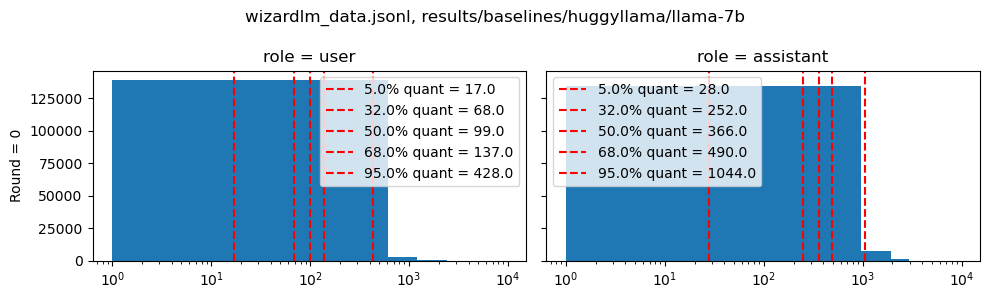

In [22]:
max_turns = max([len(x)//2 for x in lens])
fig, axs = plt.subplots(max_turns, 2,figsize=(5*2, 3*max_turns), sharex=True, sharey=True)

for i, r in enumerate(range(max_turns)):
    for j, ind in enumerate([int(r*2), int(r*2)+1]):
        ax = axs.reshape(-1, 2)[i, j]
        ys = [x[ind] for x in lens if len(x)>ind]
        ax.hist(ys)
        for q in [.05, .32, .5, .68, .95]:
            v = np.quantile(ys, q)
            ax.axvline(x=v, color='r', linestyle='--', label=f'{q*100}% quant = {v}')
        ax.legend()
        ax.set_xscale('log')
        if j == 0:
            ax.set_ylabel(f'Round = {r}')
        if i == 0:
            ax.set_title(f"role = {'user' if j==0 else 'assistant'}")
        
fig.suptitle(f'{os.path.basename(input_file)}, {tokenizer_name_or_path}')
fig.tight_layout()


save_plt = 1
if save_plt:
    save_path = os.path.join(
        assets_dir, 
        f"note_pruning_conv_numtoks_{os.path.basename(input_file).split('.jsonl')[0]}_{':'.join(tokenizer_name_or_path.split('/'))}.png")
    fig.savefig(save_path, bbox_inches='tight', dpi=100)


### dppmap rank(L) vs. gamma

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


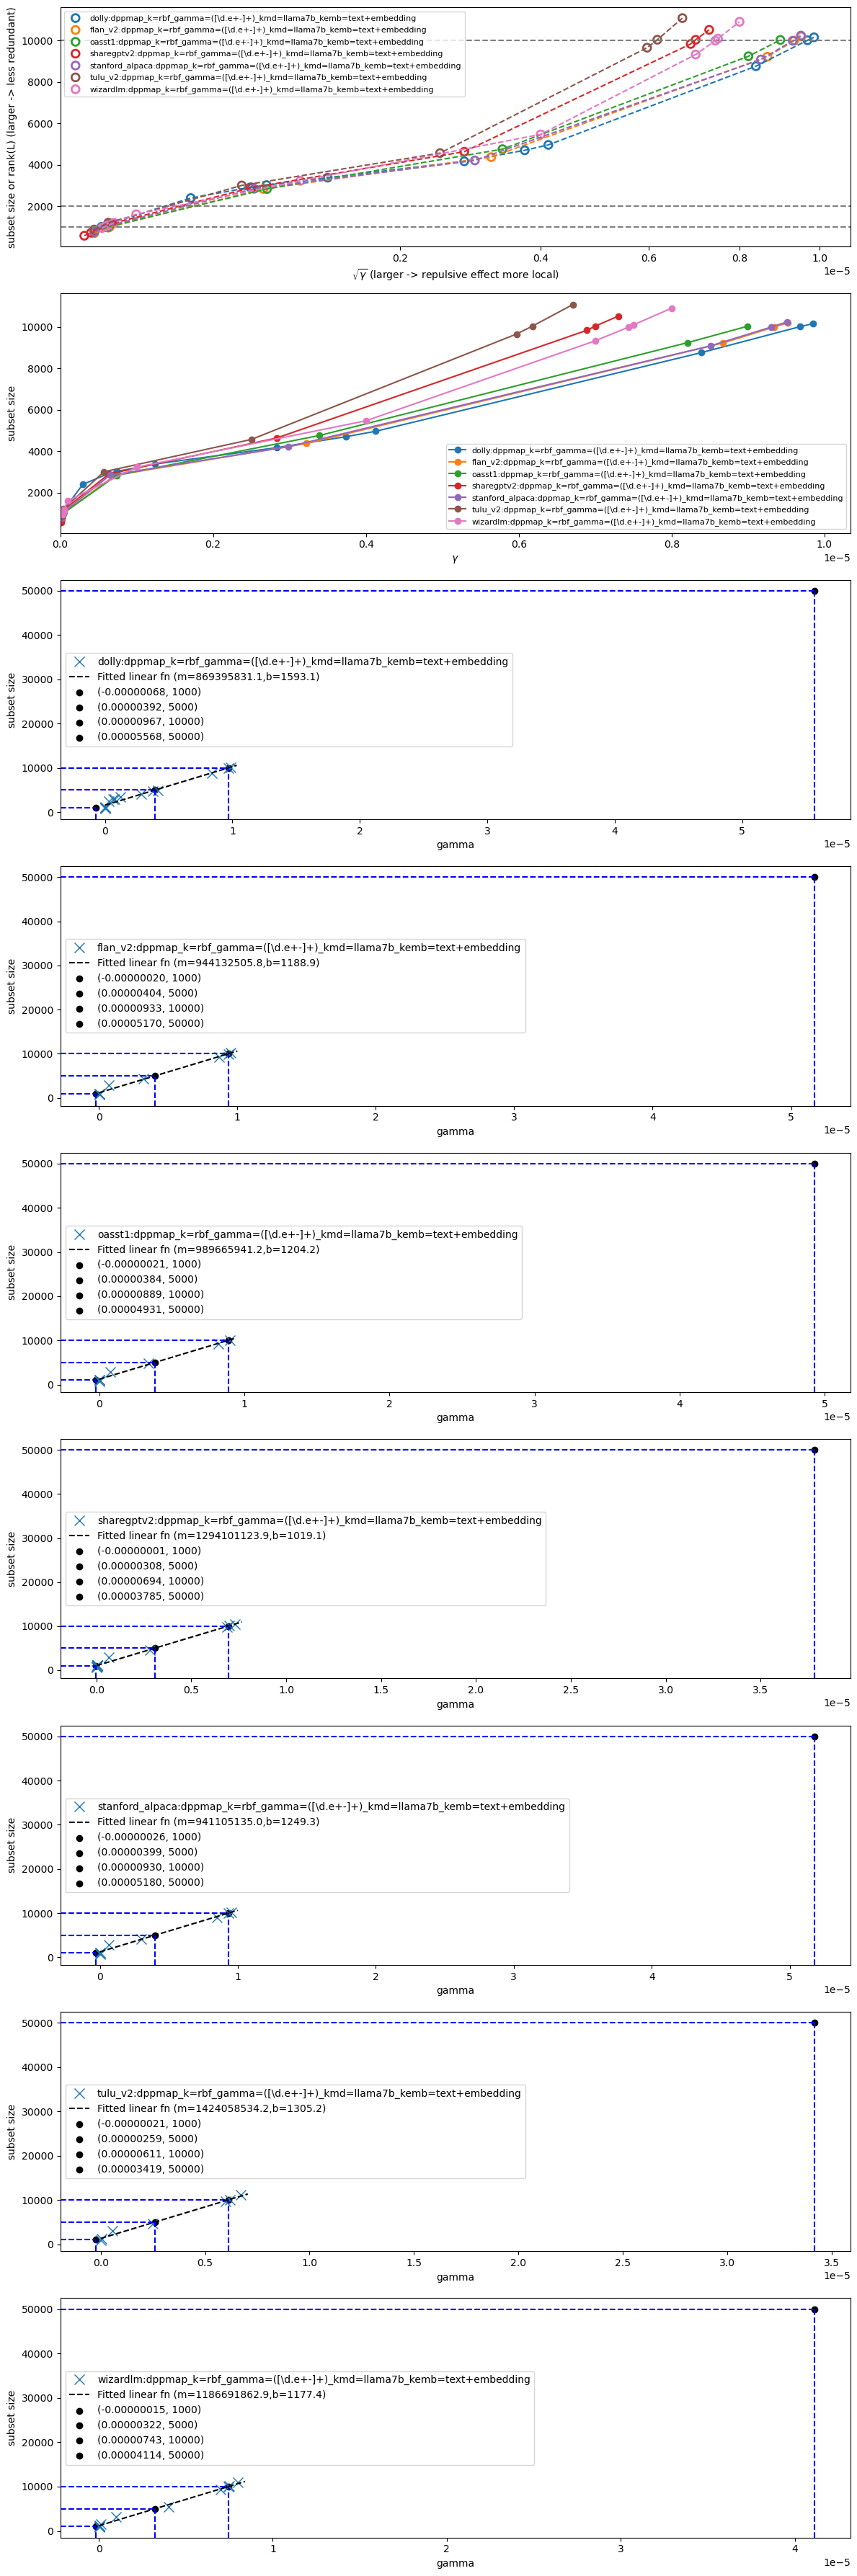

In [24]:
from rosemary import jpt_setup; jpt_setup()
from note_pruning_dpp import plt_subset_size_vs_kernel_params


datasets = [
    'dolly',
    'flan_v2',
    'oasst1',
    'sharegptv2',
    'stanford_alpaca',
    'ultrachat200kv2',
    'wizardlm',
    'wizardlmv2',
    'tulu_v2',
#     'open_orca_slim',
#     'starcoder_commentinstrv5',
]
# datasets = ['stanford_alpaca', 'wizardlmv2', 'wizardlm']
M = 1200; hlines = [1_000]
# M = 5_500; hlines = [1_000, 2_000, 10_000]
M = 12_000; hlines = [1_000, 2_000, 10_000]
# M = 23_000; hlines = [1_000, 10_000, 20_000]
# M = 53_000; hlines = [1_000, 2_000, 10_000]
# M = 50_000; hlines = []; normalize_by_dataset_size = True
kmd = 'llama7b'
kmd = 'llama7br512p4096'
# kmd = 'llama7b*'
sort_by = f'dppmap_k=rbf*kmd={kmd}_kemb=text+embedding'
# sort_by='dppmap_*mpnet*'
# sort_by = f'dppmap_k=vmf*kmd={kmd}_kemb=grad+rp+loraB'
# normalize_by_dataset_size = True; hlines = []
normalize_by_dataset_size = False
fig, axs = plt_subset_size_vs_kernel_params(
    datasets, 
    save_fig=False, 
    filter_fn=lambda row: row['M'] <M and 'theta' not in row['sort_by'] and 'llama2' not in row['sort_by'],
    hlines=hlines,
    sort_by=sort_by,
    normalize_by_dataset_size=normalize_by_dataset_size,
    interpolate=True,
)

### verify if there is correlation between output scores with output token length

In [5]:

# model_name = 'llama-7b'; model_name_or_path='../results/baselines/huggyllama/llama-7b'
model_name = 'llama-7b+lora:r=256:a=256'; model_name_or_path='../results/baselines/huggyllama/llama-7b'

tokenizer = AutoTokenizer.from_pretrained(model_name_or_path, use_fast=True)
tokenizer.padding_side = 'left'
if tokenizer.pad_token is None:
    tokenizer.pad_token = tokenizer.eos_token

Using pad_token, but it is not set yet.


In [6]:
subsample_size = 2000


# get a list of dataset names.
dataset_list = [os.path.basename(x).split('.')[0] 
 for x in glob.glob(os.path.join(lm_output_dir, model_name, '*.pkl'))]
dataset_list = [x for x in dataset_list if 'flan2022' not in x]


lm_outputs = {}
token_lengths = {}
for dataset in dataset_list:
    lm_outputs[dataset] = get_lm_output(dataset, model_name)
    if subsample_size:
        np.random.seed(0)
        inds = np.random.randint(0, list(lm_outputs[dataset].values())[0].shape[0], subsample_size)
    for k, v in lm_outputs[dataset].items():
        lm_outputs[dataset][k] = v[inds]
    token_lengths[dataset] = get_dataset_token_lengths(
        dataset, model_name_or_path, tokenizer, inds=inds if subsample_size else None)


[2023-10-09 14:57:19,735] [INFO] [real_accelerator.py:158:get_accelerator] Setting ds_accelerator to cuda (auto detect)


Found cached dataset json (/gpfs/u/scratch/PTFM/PTFMqngp/huggingface_cache/datasets/json/default-2c6b12c2f11c0937/0.0.0/8bb11242116d547c741b2e8a1f18598ffdd40a1d4f2a2872c7a28b697434bc96)


  0%|          | 0/1 [00:00<?, ?it/s]

Loading cached processed dataset at /gpfs/u/scratch/PTFM/PTFMqngp/huggingface_cache/datasets/json/default-2c6b12c2f11c0937/0.0.0/8bb11242116d547c741b2e8a1f18598ffdd40a1d4f2a2872c7a28b697434bc96/cache-eb938f2a6da5e5da_*_of_00016.arrow


Map (num_proc=16):   0%|          | 0/2000 [00:00<?, ? examples/s]

Found cached dataset json (/gpfs/u/scratch/PTFM/PTFMqngp/huggingface_cache/datasets/json/default-deef786a5f2992f0/0.0.0/8bb11242116d547c741b2e8a1f18598ffdd40a1d4f2a2872c7a28b697434bc96)


  0%|          | 0/1 [00:00<?, ?it/s]

Loading cached processed dataset at /gpfs/u/scratch/PTFM/PTFMqngp/huggingface_cache/datasets/json/default-deef786a5f2992f0/0.0.0/8bb11242116d547c741b2e8a1f18598ffdd40a1d4f2a2872c7a28b697434bc96/cache-c30f84a2dc784550_*_of_00016.arrow


Map (num_proc=16):   0%|          | 0/2000 [00:00<?, ? examples/s]

Found cached dataset json (/gpfs/u/scratch/PTFM/PTFMqngp/huggingface_cache/datasets/json/default-ffcb06a83b4338ce/0.0.0/8bb11242116d547c741b2e8a1f18598ffdd40a1d4f2a2872c7a28b697434bc96)


  0%|          | 0/1 [00:00<?, ?it/s]

Loading cached processed dataset at /gpfs/u/scratch/PTFM/PTFMqngp/huggingface_cache/datasets/json/default-ffcb06a83b4338ce/0.0.0/8bb11242116d547c741b2e8a1f18598ffdd40a1d4f2a2872c7a28b697434bc96/cache-a5113a0d5a91ea53_*_of_00016.arrow


Map (num_proc=16):   0%|          | 0/2000 [00:00<?, ? examples/s]

Found cached dataset json (/gpfs/u/scratch/PTFM/PTFMqngp/huggingface_cache/datasets/json/default-db45fcd570bec348/0.0.0/8bb11242116d547c741b2e8a1f18598ffdd40a1d4f2a2872c7a28b697434bc96)


  0%|          | 0/1 [00:00<?, ?it/s]

Loading cached processed dataset at /gpfs/u/scratch/PTFM/PTFMqngp/huggingface_cache/datasets/json/default-db45fcd570bec348/0.0.0/8bb11242116d547c741b2e8a1f18598ffdd40a1d4f2a2872c7a28b697434bc96/cache-3da14401ed1f756e_*_of_00016.arrow


Map (num_proc=16):   0%|          | 0/2000 [00:00<?, ? examples/s]

Found cached dataset json (/gpfs/u/scratch/PTFM/PTFMqngp/huggingface_cache/datasets/json/default-053c40899badb561/0.0.0/8bb11242116d547c741b2e8a1f18598ffdd40a1d4f2a2872c7a28b697434bc96)


  0%|          | 0/1 [00:00<?, ?it/s]

Loading cached processed dataset at /gpfs/u/scratch/PTFM/PTFMqngp/huggingface_cache/datasets/json/default-053c40899badb561/0.0.0/8bb11242116d547c741b2e8a1f18598ffdd40a1d4f2a2872c7a28b697434bc96/cache-56e3fe188fc9e223_*_of_00016.arrow


Map (num_proc=16):   0%|          | 0/2000 [00:00<?, ? examples/s]

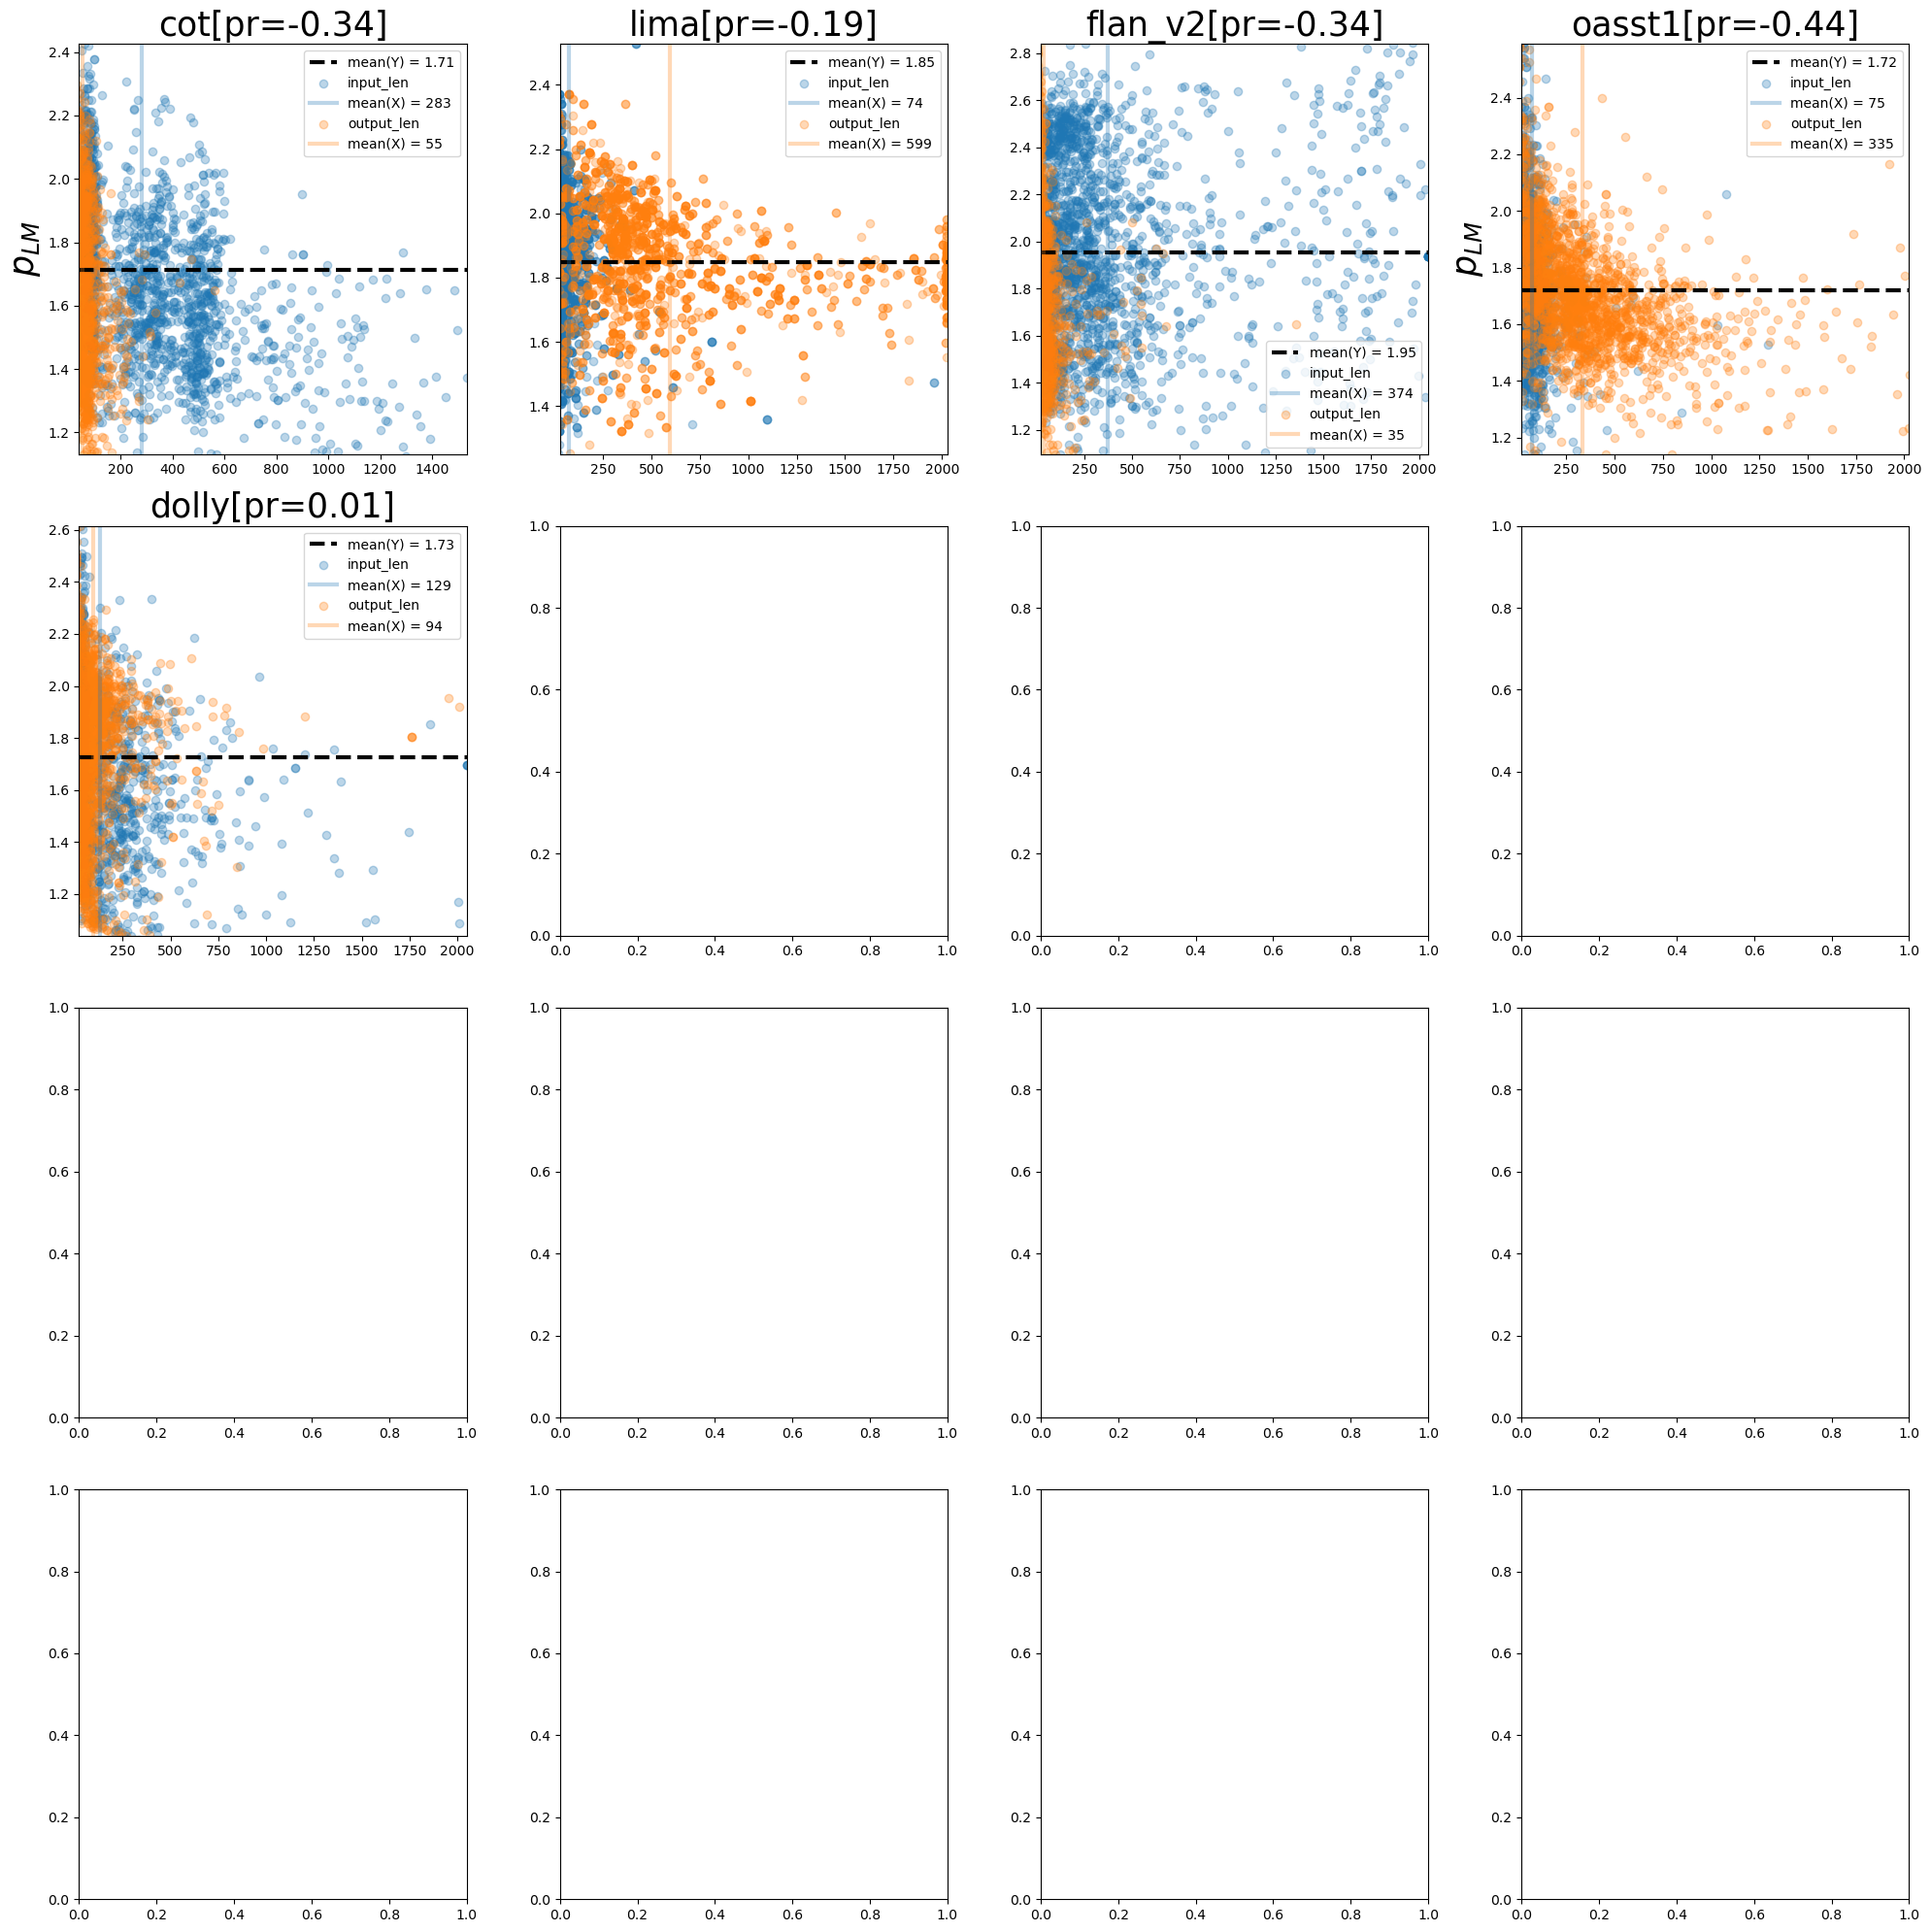

In [16]:

y_label = 'log_prob'
y_label = 'el2n_agg=mean'

w = 5
fig, axs = plt.subplots(4,4, figsize=(w*4,w*4))

for axi, dataset in enumerate(dataset_list):
    
    ## get the information
    logP = lm_outputs[dataset][y_label]
    ys = np.exp(logP)
    input_len = token_lengths[dataset]['input_len']
    output_len = token_lengths[dataset]['output_len']
    
    ## plot the information 
    ax = axs.flatten()[axi]

    
    mean_y = ys.mean()
    ax.axhline(y=mean_y, color='k', linestyle='--', linewidth=3, label=f'mean(Y) = {mean_y:.2f}')

    for label, xs in [
            ('input_len', input_len),
            ('output_len', output_len),
        ]:
        scatter = ax.scatter(xs, ys, label=label, alpha=.3)
        mean_x = xs.mean()
        ax.axvline(x=mean_x, color=scatter.get_facecolor()[0], linestyle='-', linewidth=3, label=f'mean(X) = {mean_x:.0f}')


    ax.legend()
    eps = .001

    ax.set_ylim(np.quantile(ys, eps), np.quantile(ys, 1-eps))
    xs_for_xlim = np.maximum(input_len, output_len)
    ax.set_xlim(np.quantile(xs_for_xlim, eps), np.quantile(xs_for_xlim, 1-eps))
    
    # ax.set_xlabel('token lengths', fontsize=20)
    if axi%3 == 0:
        ax.set_ylabel('$p_{LM}$', fontsize=25)
        
        
    corr = compute_correlations(xs, ys, 'pearsonr')
    ax.set_title(f'{dataset}[pr={corr:.2f}]', fontsize=25)

    
fig.tight_layout()
save_plt = 1
if save_plt:
    save_path = os.path.join(assets_dir, 'note_pruning_analysis_prob_vs_tokenlen.png')
    fig.savefig(save_path, bbox_inches='tight', dpi=100)

### analyze difference/similarity between sorted indices with different `sort_by`. see if they correlate with each other, e.g., first k item overlap.


In [4]:
pkl_files = glob.glob(os.path.join(data_inds_dir, '**/**/*.pkl'))
pkl_files = [get_prune_results(x) for x in pkl_files]

dfo = pd.DataFrame(pkl_files)
dfo

/gpfs/u/scratch/PTFM/PTFMqngp/miniconda3/envs/open-instruct/lib/python3.10/site-packages/sklearn/base.py:347: InconsistentVersionWarning: Trying to unpickle estimator KMeans from version 1.3.2 when using version 1.3.0. This might lead to breaking code or invalid results. Use at your own risk. For more info please refer to:
https://scikit-learn.org/stable/model_persistence.html#security-maintainability-limitations
  warnings.warn(


model_name                         dataset  \
0    codellama-7b+lora:r=256:a=256  starcoder_commentinstr_cleaned   
1    codellama-7b+lora:r=256:a=256  starcoder_commentinstr_cleaned   
2    codellama-7b+lora:r=256:a=256  starcoder_commentinstr_cleaned   
3    codellama-7b+lora:r=256:a=256  starcoder_commentinstr_cleaned   
4    codellama-7b+lora:r=256:a=256  starcoder_commentinstr_cleaned   
..                             ...                             ...   
811              all-mpnet-base-v2          starcoder_commentinstr   
812              all-mpnet-base-v2          starcoder_commentinstr   
813              all-mpnet-base-v2          starcoder_commentinstr   
814              all-mpnet-base-v2        starcoder_commentinstrv2   
815              all-mpnet-base-v2        starcoder_commentinstrv2   

                                     sort_by  \
0                         el2n_agg=mean_decr   
1                          logit_margin_decr   
2                                   ifd_incr   
3                              log_prob_incr   
4                          logit_margin_incr   
..                                       ...   
811   dppmap_k=vmf_gamma=0.02_kmd=mpnet_decr   
812   dppmap_k=vmf_gamma=0.03_kmd=mpnet_incr   
813  dppmap_k=vmf_gamma=0.035_kmd=mpnet_decr   
814   dedup_md=mpnet_emb=text+embedding_incr   
815   dedup_md=mpnet_emb=text+embedding_decr   

                                              pkl_path  \
0    /gpfs/u/home/PTFM/PTFMqngp/scratch/github/miti...   
1    /gpfs/u/home/PTFM/PTFMqngp/scratch/github/miti...   
2    /gpfs/u/home/PTFM/PTFMqngp/scratch/github/miti...   
3    /gpfs/u/home/PTFM/PTFMqngp/scratch/github/miti...   
4    /gpfs/u/home/PTFM/PTFMqngp/scratch/github/miti...   
..                                                 ...   
811  /gpfs/u/home/PTFM/PTFMqngp/scratch/github/miti...   
812  /gpfs/u/home/PTFM/PTFMqngp/scratch/github/miti...   
813  /gpfs/u/home/PTFM/PTFMqngp/scratch/github/miti...   
814  /gpfs/u/home/PTFM/PTFMqngp/scratch/github/miti...   
815  /gpfs/u/home/PTFM/PTFMqngp/scratch/github/miti...   

                                                  inds  \
0    [1041, 1040, 155, 7390, 5822, 5340, 5339, 5378...   
1    [564, 6727, 6205, 5521, 5607, 1151, 8023, 5578...   
2    [2264, 1151, 7784, 4353, 8031, 3798, 755, 35, ...   
3    [3225, 1041, 1040, 2305, 3228, 6239, 3223, 323...   
4    [1040, 1041, 2305, 155, 1163, 3223, 3228, 3225...   
..                                                 ...   
811  [3376, 13471, 12321, 4049, 6051, 11541, 9909, ...   
812  [0, 460, 7201, 9045, 9129, 3604, 5125, 10764, ...   
813  [4977, 4752, 2990, 5888, 8982, 8835, 10444, 13...   
814  [79396, 42010, 34920, 42008, 65322, 39305, 420...   
815  [0, 24, 1, 55, 51, 2, 14, 12, 21, 22, 265, 224...   

                                                     S  \
0    [0.16718651354312897, 0.0955050140619278, 0.34...   
1    [4.154351234436035, 5.514100074768066, 2.03489...   
2    [0.3779289424419403, 0.593388557434082, 0.5921...   
3    [-0.4156716465950012, -0.21158050000667572, -0...   
4    [4.154351234436035, 5.514100074768066, 2.03489...   
..                                                 ...   
811  [0, 13110, 8114, 11251, 10982, 8744, 5756, 263...   
812  [0, 13248, 4738, 1828, 7884, 10679, 10307, 348...   
813  [0, 4853, 13152, 1853, 4791, 7815, 10651, 3473...   
814  [1100.0, 1065.0, 1063.0, 1058.0, 1060.0, 1060....   
815  [1100.0, 1065.0, 1063.0, 1058.0, 1060.0, 1060....   

                                                  info kmeans clustering_model  
0                                                  NaN    NaN              NaN  
1                                                  NaN    NaN              NaN  
2                                                  NaN    NaN              NaN  
3                                                  NaN    NaN              NaN  
4                                                  NaN    NaN              NaN  
..                           

In [23]:
import json
from note_pruning_analysis import get_dataset
sort_by_categories = None
group_name = None
include_only_incr = True

# model_name = 'llama-7b' # 'llama-7b+lora:r=256:a=256'

# dataset = 'flan2022_1m'
# dataset = 'tulu_v1_mix'
# sort_by_categories = [
#     'log_prob_incr', 'logit_margin_incr', 'el2n_agg=l2n_incr', 'el2n_agg=mean_incr', 'grad_loraB_l2n_incr', 
# #     'kmeansl2_emb=grad+rp+loraB_nc=3000_incr', 'kmeansl2_emb=text+embedding_nc=3000_incr', 
#     'kmeansl2_emb=text+embedding_nc=300_incr', 'kmeansl2_emb=text+embedding_nc=1000_incr', 'kmeansl2_emb=text+embedding_nc=3000_incr', 'kmeansl2_emb=text+embedding_nc=6000_incr', 
#     'kmeansl2_emb=grad+rp+loraB_nc=300_incr', 'kmeansl2_emb=grad+rp+loraB_nc=1000_incr', 'kmeansl2_emb=grad+rp+loraB_nc=3000_incr', 'kmeansl2_emb=grad+rp+loraB_nc=6000_incr', 
#     'dppmap_emb=text+embedding_k=Kcos1np', # 'dppmap_emb=grad+rp+loraB_k=Kcos1np', 
#     'dppmap_emb=text+embedding_k=Kcos', # 'dppmap_emb=grad+rp+loraB_k=Kcos', 
# #     'kmeanscd_nc=3000_incr', 'kmeansl2_nc=3000_incr', 'kmeansl2_nc=6000_incr',
# ]


# dataset = 'lima' # llama-7b/lima contains full grad norm! compare it with lora grad norm
# sort_by_categories = [
#     'log_prob_incr', 'logit_margin_incr', 'el2n_agg=l2n_incr', 'el2n_agg=mean_incr', 
#     'grad_last_l2n_incr', 'grad_mlp_l2n_incr', 'grad_qkv_l2n_incr', 'grad_loraB_l2n_incr', 'grad_all_l2n_incr',
#     'kmeansl2_emb=grad+rp+loraB_nc=30_incr', 'kmeansl2_emb=text+embedding_nc=30_incr',
# ]

#####
# model_name = 'mistral-7b+lora:r=256:a=256'
# dataset = 'ultrachat'

# sort_by_categories = [
#     'log_prob_incr', 'logit_margin_incr', 'el2n_agg=l2n_incr', 'el2n_agg=mean_incr', 'grad_loraB_l2n_incr', 
#     'kmeansl2_emb=text+embedding_nc=1000_incr', 'kmeansl2_emb=grad+rp+loraB_nc=1000_incr',
#     ## dppmap basically shows no correlation with other sort_by
# #     'dppmap_emb=text+embedding_k=Kcos1np', 'dppmap_emb=grad+rp+loraB_k=Kcos1np', 
# #     'dppmap_emb=text+embedding_k=Kcos', 'dppmap_emb=grad+rp+loraB_k=Kcos', 
#     'rhov1_log_prob_incr', 'rhov1_logit_margin_incr', 'rhov1_el2n_agg=mean_incr', 'rhov1_grad_loraB_l2n_incr',
# ]


# Not shown: {'rhov1_el2n_agg=mean_incr', 'dppmap_emb=text+embedding_k=Kcosp', 
#             'rhov1_grad_loraB_l2n_incr', 'dppmap_emb=grad+rp+loraB_k=Kcosp', 
#             'dppmap_emb=grad+rp+loraB_k=Kcos', 'dppmap_emb=grad+rp+loraB_k=Kcos1np', 
#             'rhov1_logit_margin_incr', 'rhov1_log_prob_incr', 'rhov1_el2n_agg=l2n_incr'}
#####

# #####
# model_name = 'all-mpnet-base-v2'
# dataset = 'ultrachat15'
# sort_by_categories = [
# #     "dppmapbd_nc=200_k=lin_kmd=mpnet_incr",
# #     "dppmapbd_nc=200_k=vmf_gamma=0.3_kmd=mpnet_incr",
# #     "dppmapbd_nc=200_k=vmf_gamma=1.0_kmd=mpnet_incr",
#     "dppmapbd_nc=200_k=vmf_gamma=3.0_kmd=mpnet_incr",
# #     "dppmapbd_nc=200_k=vmf_gamma=10.0_kmd=mpnet_incr",
# #     "dppmapbd_nc=200_k=vmf_gamma=15.0_kmd=mpnet_incr",
#     "dppmapbd_nc=200_theta=0.3_k=vmf_gamma=3.0_kmd=mpnet_q=prob_qmd=mistral7b_incr",
#     "dppmapbd_nc=200_theta=0.6_k=vmf_gamma=3.0_kmd=mpnet_q=prob_qmd=mistral7b_incr",
#     "dppmapbd_nc=200_theta=0_k=vmf_gamma=3.0_kmd=mpnet_q=log+prob_qmd=mistral7b_incr",
#     "dppmapbd_nc=200_theta=0.3_k=vmf_gamma=3.0_kmd=mpnet_q=log+prob_qmd=mistral7b_incr",
# #     "semdedup_cl=kmeansfaisscd_md=mpnet_dist=cd_emb=text+embedding_nc=100_incr",
# #     "semdedup_cl=kmeansfaisscd_md=mpnet_dist=cd_emb=text+embedding_nc=200_incr",
# #     "semdedup_cl=kmeansfaisscd_md=mpnet_dist=cd_emb=text+embedding_nc=400_incr",
# #     "semdedup_cl=kmeansfaisscd_md=mpnet_dist=cd_emb=text+embedding_nc=500_incr",
# #     "semdedup_cl=kmeansfaisscd_md=mpnet_dist=cd_emb=text+embedding_nc=600_incr"
# #     "semdedup_cl=kmeansfaisscd_md=mpnet_dist=cd_emb=text+embedding_nc=1000_incr",
# ]
# #####


# #### # cmp dppmapbd with quality score & quality score alone on ultrachat
# include_only_incr = False
# model_names = ['all-mpnet-base-v2', 'mistral']
# dataset = 'ultrachat15'
# sort_by_categories = [
#     'log_prob_decr',
#     "dppmapbd_nc=200_theta=0_k=vmf_gamma=3.0_kmd=mpnet_q=log+prob_qmd=mistral7b_incr",
#     "dppmapbd_nc=200_theta=0.3_k=vmf_gamma=3.0_kmd=mpnet_q=log+prob_qmd=mistral7b_incr",
#     "dppmapbd_nc=200_theta=0.3_k=vmf_gamma=3.0_kmd=mpnet_q=prob_qmd=mistral7b_incr",
#     "dppmapbd_nc=200_theta=0.6_k=vmf_gamma=3.0_kmd=mpnet_q=prob_qmd=mistral7b_incr",
# ]
# ####


# #### # cmp dppmapbd with quality scores (prob, ifd)
# include_only_incr = False
# model_names = ['all-mpnet-base-v2', 'llama-7b']
# dataset = 'wizardlm'
# # sort_by_categories = [
# #     'log_prob_decr',
# #     "dppmapbd_nc=200_k=lin_kmd=mpnet_incr",
# #     'dppmapbd_nc=200_theta=0.3_k=lin_kmd=mpnet_q=prob_qmd=llama7b+lima_incr',
# #     'dppmapbd_nc=200_theta=0.6_k=lin_kmd=mpnet_q=prob_qmd=llama7b+lima_incr',
# #     'ifd_decr',
# #     "dppmapbd_nc=200_k=lin_kmd=mpnet_incr",
# #     'dppmapbd_nc=200_theta=0.3_k=lin_kmd=mpnet_q=ifd_qmd=llama7b+lima_incr',
# #     'dppmapbd_nc=200_theta=0.6_k=lin_kmd=mpnet_q=ifd_qmd=llama7b+lima_incr',
# # ]
# sort_by_categories = [
#     'log_prob_decr',
#     'log_pmi_decr',
#     'ifd_decr',
# ]
# ####

# #### get an idea logpmi/ifd/numtoks correlation
# model_names = ['llama-7b+lora']; dataset = 'wizardlm'
# include_only_incr = False
# sort_by_categories = [
#     'log_prob_decr', 'ifd_decr', 'log_pmi_decr',
#     'numtoks_input_decr', 'numtoks_output_decr', 'numtoks_total_decr'
# ]
# ####

#### get idea how to balance quality+diversity
model_names = ['llama-7b+lora', 'all-mpnet-base-v2']; dataset = 'wizardlm'; include_only_incr = False
sort_by_categories = [
    'log_pmi_decr',
    'random_s=0_incr',
#     ## mpnet + logpmi
#     'dppmap_theta=0.1_k=vmf_gamma=auto1000_kmd=mpnet_q=log+pmi_qmd=llama7b_incr',
#     'dppmap_theta=0.3_k=vmf_gamma=0.04_kmd=mpnet_q=log+pmi_qmd=llama7b_incr',
#     'dppmap_theta=0.4_k=vmf_gamma=auto10000_kmd=mpnet_q=log+pmi_qmd=llama7b_incr',
#     'dppmap_theta=0.5_k=vmf_gamma=0.043_kmd=mpnet_q=log+pmi_qmd=llama7b_incr',
#     'dppmap_theta=0.6_k=vmf_gamma=auto10000_kmd=mpnet_q=log+pmi_qmd=llama7b_incr',
#     'dppmap_theta=0.7_k=vmf_gamma=0.043_kmd=mpnet_q=log+pmi_qmd=llama7b_incr',
    # llama embedding + logpmi
    'dppmap_theta=0.1_k=rbf_gamma=auto10000_kmd=llama7b_kemb=text+embedding_q=log+pmi_qmd=llama7b_incr',
    'dppmap_theta=0.3_k=rbf_gamma=auto10000_kmd=llama7b_kemb=text+embedding_q=log+pmi_qmd=llama7b_incr',
    'dppmap_theta=0.5_k=rbf_gamma=auto10000_kmd=llama7b_kemb=text+embedding_q=log+pmi_qmd=llama7b_incr',
]
####


    
    
if group_name is None:
    group_name = f"{','.join(model_names)}:{dataset}"
    
ds = get_dataset(dataset, processed=False if 'flan2022' in dataset else True)
ds_len = len(ds)

filter_fn = lambda x: \
    any(x['model_name'].startswith(y) for y in model_names) and \
    x['dataset'] == dataset and \
    'rho' not in x['model_name']


df = dfo.copy()
df = df[df.apply(filter_fn, axis=1)]
df = df.sort_values('sort_by')
if include_only_incr:
    df = df[df['sort_by'].apply(lambda x: 'decr' not in x and 'random' not in x)] # just increasing score.
# df = df[~df['S'].isnull()]
df = df[~df['sort_by'].apply(lambda x: any(y==x for y in ['el2n_incr', 'prob_incr']))]
if sort_by_categories:
    print(f"Not shown: {json.dumps(sorted(list(set(df['sort_by'].to_list()) - set(sort_by_categories))), indent=4)}")
    df['sort_by'] = pd.Categorical(df['sort_by'], categories=sort_by_categories, ordered=True)
    df = df.sort_values(by='sort_by')
    df = df[pd.notnull(df['sort_by'])]
if dataset in ['flan2022_1m', 'tulu_v1_mix']:
    # compare full grad norm with lora grad norm
    df = df[df.apply(lambda r: 'lora' in r['model_name'] or ('lora' not in r['model_name'] and 'grad' in r['sort_by']), 1)]
    if dataset.startswith('flan2022'):
        ds_task = ds['task']
        df['tasks'] = df['inds'].apply(lambda inds: [ds_task[i] for i in inds.tolist()])
    else:
        ds_task = [x.split('_')[0] for x in ds['id']]
        df['tasks'] = df['inds'].apply(lambda inds: [ds_task[i] for i in inds.tolist()])
else:
    df['task'] = [dataset]*len(df)
df = df.reset_index(drop=True)

df

Found cached dataset json (/gpfs/u/home/PTFM/PTFMqngp/scratch/github/mitibm2023/external/open-instruct/data/processed/wizardlm/json/default-a3f71ae376e517fb/0.0.0/8bb11242116d547c741b2e8a1f18598ffdd40a1d4f2a2872c7a28b697434bc96)


Not shown: [
    "dedup_md=mpnet_emb=text+embedding_decr",
    "dedup_md=mpnet_emb=text+embedding_incr",
    "dppmap_k=lin_kmd=mpnet_decr",
    "dppmap_k=lin_kmd=mpnet_incr",
    "dppmap_k=rbf_gamma=0.0000007_kmd=llama7b_kemb=grad+rp+loraB_decr",
    "dppmap_k=rbf_gamma=0.0000007_kmd=llama7b_kemb=grad+rp+loraB_incr",
    "dppmap_k=rbf_gamma=0.0002_kmd=llama7b_kemb=grad+rp+loraB_decr",
    "dppmap_k=rbf_gamma=0.0002_kmd=llama7b_kemb=grad+rp+loraB_incr",
    "dppmap_k=rbf_gamma=0.0006_kmd=llama7b_kemb=grad+rp+loraB_decr",
    "dppmap_k=rbf_gamma=0.0006_kmd=llama7b_kemb=grad+rp+loraB_incr",
    "dppmap_k=rbf_gamma=0.0008_kmd=llama7b_kemb=grad+rp+loraB_decr",
    "dppmap_k=rbf_gamma=0.0008_kmd=llama7b_kemb=grad+rp+loraB_incr",
    "dppmap_k=rbf_gamma=0.00095_kmd=llama7b_kemb=grad+rp+loraB_decr",
    "dppmap_k=rbf_gamma=0.00095_kmd=llama7b_kemb=grad+rp+loraB_incr",
    "dppmap_k=rbf_gamma=0.0009_kmd=llama7b_kemb=grad+rp+loraB_decr",
    "dppmap_k=rbf_gamma=0.0009_kmd=llama7b_kemb=grad+rp+lo

model_name   dataset  \
0  llama-7b+lora:r=256:a=256  wizardlm   
1  llama-7b+lora:r=256:a=256  wizardlm   
2  llama-7b+lora:r=256:a=256  wizardlm   
3  llama-7b+lora:r=256:a=256  wizardlm   
4  llama-7b+lora:r=256:a=256  wizardlm   

                                             sort_by  \
0                                       log_pmi_decr   
1                                    random_s=0_incr   
2  dppmap_theta=0.1_k=rbf_gamma=auto10000_kmd=lla...   
3  dppmap_theta=0.3_k=rbf_gamma=auto10000_kmd=lla...   
4  dppmap_theta=0.5_k=rbf_gamma=auto10000_kmd=lla...   

                                            pkl_path  \
0  /gpfs/u/home/PTFM/PTFMqngp/scratch/github/miti...   
1  /gpfs/u/home/PTFM/PTFMqngp/scratch/github/miti...   
2  /gpfs/u/home/PTFM/PTFMqngp/scratch/github/miti...   
3  /gpfs/u/home/PTFM/PTFMqngp/scratch/github/miti...   
4  /gpfs/u/home/PTFM/PTFMqngp/scratch/github/miti...   

                                                inds  \
0  [127342, 43683, 11056, 63243, 75609, 43739, 34...   
1  [84341, 131245, 106914, 110750, 122626, 122615...   
2  [127342, 54414, 11056, 126424, 7570, 75609, 40...   
3  [127342, 11056, 75609, 43683, 43739, 34063, 12...   
4  [127342, 11056, 43683, 75609, 43739, 34063, 92...   

                                                   S  \
0  [-125.08362102508545, -92.95913875102997, -141...   
1  [0.5488135039273248, 0.7151893663724195, 0.602...   
2  [24184, 70284, 123220, 34460, 84480, 85252, 33...   
3  [24181, 70273, 123211, 34456, 84484, 85256, 33...   
4  [24182, 70272, 123209, 34457, 84483, 85255, 33...   

                                                info kmeans clustering_model  \
0                                                NaN    NaN              NaN   
1                                                NaN    NaN              NaN   
2  {'dppmap_type': 'dppmap', 'dataset': 'wizardlm...    NaN              NaN   
3  {'dppmap_type': 'dppmap', 'dataset': 'wizardlm...    NaN              NaN   
4  {'dppmap_type': 'dppmap', 'dataset': 'wizardlm...    NaN              NaN   

       task  
0  wizardlm  
1  wizardlm  
2  wizardlm  
3  wizardlm  
4  wizardlm

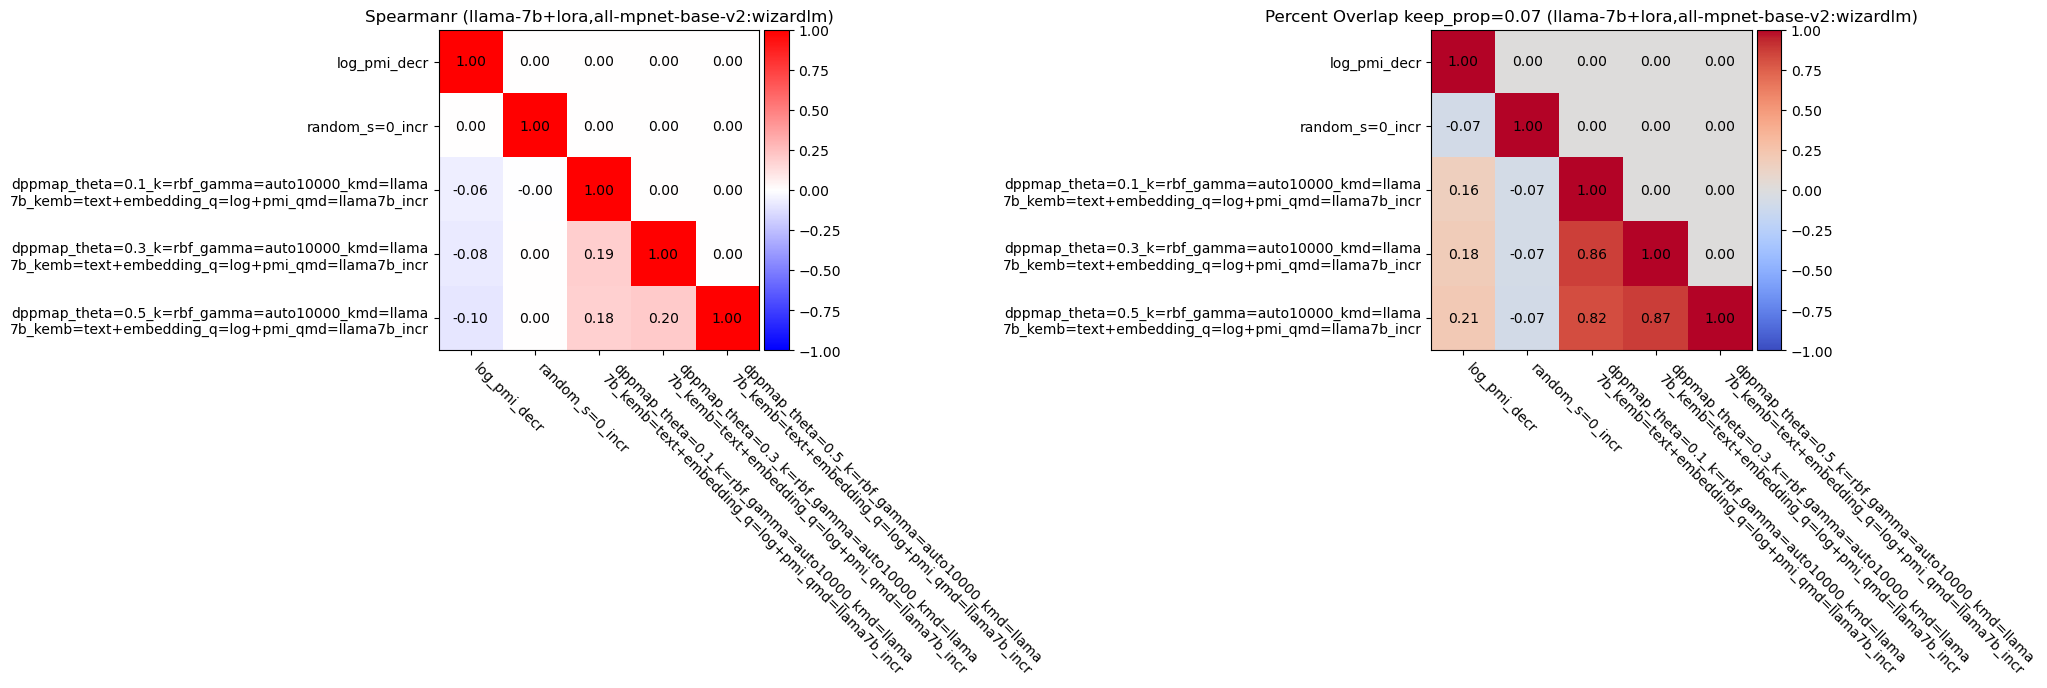

In [24]:
from rosemary import plt_kernel_matrix_one
import matplotlib.pyplot as plt
from scipy import stats

xlabels_include_model_name = False

sort_by_list = df['sort_by'].tolist()
inds_list = df['inds'].tolist()
scores_list = df['S'].tolist()
if xlabels_include_model_name:
    model_name_list = df['model_name'].tolist()
    model_name_list = [x.split('+lora')[0] for x in model_name_list]
    sort_by_list = [f'{x} ({y})' for x,y in zip(sort_by_list, model_name_list)]
    
if dataset == 'ultrachat15':
    keep_prop = .03
#     keep_prop = 0.13
elif dataset == 'wizardlm':
    keep_prop = 1/14
else:
    keep_prop = .1
M = int(keep_prop*ds_len) # subset size
N = len(scores_list) # number of entries to compare
rank_corr = np.zeros((N, N))
overlap = np.zeros((N, N))
for i in range(N):
    for j in range(N):
        scores_i = scores_list[i]
        scores_j = scores_list[j]
        scores_i = scores_i if not scores_i is np.nan else np.random.permutation(len(ds))
        scores_j = scores_j if not scores_j is np.nan else np.random.permutation(len(ds))
        inds_i = inds_list[i]
        inds_j = inds_list[j]
        if j < i:
            rank_corr[i,j] = stats.spearmanr(scores_i, scores_j).statistic
            positive_overlap = len(np.intersect1d(inds_i[:M], inds_j[:M]))/M
            negative_overlap = -(
                len(np.intersect1d(inds_i[-M:], inds_j[:M]))/M + 
                len(np.intersect1d(inds_i[:M], inds_j[-M:]))/M
            )/2
            overlap[i,j] = positive_overlap if positive_overlap+negative_overlap>0 else negative_overlap
        if i == j:
            rank_corr[i, j] = 1
            overlap[i, j] = 1
        

ticklabels = [x[:len(x)//2] + '\n' + x[len(x)//2:] if len(x) > 30 else x for x in sort_by_list]

fig, axs = plt.subplots(1, 2, figsize=(20,10))
ax = axs[0]
plt_kernel_matrix_one(
    fig, ax, rank_corr, title=f'Spearmanr ({group_name})', 
    vmin=-1, vmax=1, cmap='bwr', n_ticks=N, annotate=True)
ax.set_xticklabels(ticklabels, rotation=-45, ha='left')
ax.set_yticklabels(ticklabels)

ax = axs[1]
plt_kernel_matrix_one(
    fig, ax, overlap, title=f'Percent Overlap keep_prop={keep_prop:.2f} ({group_name})', 
    vmin=-1, vmax=1, cmap='coolwarm', n_ticks=N, annotate=True)
ax.set_xticklabels(ticklabels, rotation=-45, ha='left')
ax.set_yticklabels(ticklabels)
fig.tight_layout()

save_plt = 0
if save_plt:
    save_path = os.path.join(
        assets_dir, f'note_pruning_analysis_rank_corr_{group_name}.png')
    fig.savefig(save_path, bbox_inches='tight', dpi=100)

### Proportion of sub-datasets on pruned dataset.

In [7]:
tasks = df.set_index("sort_by")["tasks"].to_dict()
# M = 200000 # flan2022
# filter_fn = lambda k: True

M = 50000 # tuluv1m. ~10% of data
filter_fn = lambda k: ('nc=1000' in k) if k.startswith('kmeansl2') else True

# handle dpp which does not have decr/incr
tasks = {k+'_incr' if k.startswith('dpp') else k: v for k, v in tasks.items()}

tasks_for_sort_by_decr = {}
for k, v in tasks.items():
    if 'incr' in k and filter_fn(k):
        tasks_for_sort_by_decr[k.split('incr')[0]+'decr'] = v[::-1]
tasks = {k: v for k, v in tasks.items() if filter_fn(k)}
tasks.update(tasks_for_sort_by_decr)        
tasks = dict(sorted(tasks.items(), key=lambda x: x[0]))
print(list(tasks.keys()))

['dppmap_emb=text+embedding_k=Kcos1np_decr', 'dppmap_emb=text+embedding_k=Kcos1np_incr', 'dppmap_emb=text+embedding_k=Kcos_decr', 'dppmap_emb=text+embedding_k=Kcos_incr', 'el2n_agg=mean_decr', 'el2n_agg=mean_incr', 'grad_loraB_l2n_decr', 'grad_loraB_l2n_incr', 'kmeansl2_emb=grad+rp+loraB_nc=1000_decr', 'kmeansl2_emb=grad+rp+loraB_nc=1000_incr', 'kmeansl2_emb=text+embedding_nc=1000_decr', 'kmeansl2_emb=text+embedding_nc=1000_incr', 'log_prob_decr', 'log_prob_incr', 'logit_margin_decr', 'logit_margin_incr']


In [8]:
from collections import Counter

def compute_task_props(x):
    counts = dict(Counter(x[:M]))
    counts = dict(sorted(counts.items(), key=lambda x: x[0]))
    counts = {k: counts[k]/M for k in sorted(counts.keys())}
    return counts

sort_by_counts = {k: compute_task_props(v) for k, v in tasks.items()}
sort_by_counts

{'dppmap_emb=text+embedding_k=Kcos1np_decr': {'code': 0.02316,
  'cot': 0.06756,
  'dolly': 0.1765,
  'flan': 0.32624,
  'gpt4': 0.15552,
  'oasst1': 0.1123,
  'sharegpt': 0.13872},
 'dppmap_emb=text+embedding_k=Kcos1np_incr': {'code': 0.02316,
  'cot': 0.06756,
  'dolly': 0.1765,
  'flan': 0.32624,
  'gpt4': 0.15552,
  'oasst1': 0.1123,
  'sharegpt': 0.13872},
 'dppmap_emb=text+embedding_k=Kcos_decr': {'code': 0.02246,
  'cot': 0.0525,
  'dolly': 0.16758,
  'flan': 0.25632,
  'gpt4': 0.1415,
  'oasst1': 0.1227,
  'sharegpt': 0.23694},
 'dppmap_emb=text+embedding_k=Kcos_incr': {'code': 0.02246,
  'cot': 0.0525,
  'dolly': 0.16758,
  'flan': 0.25632,
  'gpt4': 0.1415,
  'oasst1': 0.1227,
  'sharegpt': 0.23694},
 'el2n_agg=mean_decr': {'code': 0.01642,
  'cot': 0.14788,
  'dolly': 0.0218,
  'flan': 0.7085,
  'gpt4': 0.05266,
  'oasst1': 0.03412,
  'sharegpt': 0.01862},
 'el2n_agg=mean_incr': {'code': 0.10962,
  'cot': 0.1568,
  'dolly': 0.0329,
  'flan': 0.0565,
  'gpt4': 0.02574,
  'oas

baseline_props:  {'flan': 0.21, 'cot': 0.21, 'dolly': 0.03, 'oasst1': 0.07, 'gpt4': 0.11, 'code': 0.04, 'sharegpt': 0.33}


/tmp/ipykernel_77318/3539320019.py:28: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_xticklabels(list(counts.keys()), rotation=-45, ha='left')
/tmp/ipykernel_77318/3539320019.py:28: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_xticklabels(list(counts.keys()), rotation=-45, ha='left')
/tmp/ipykernel_77318/3539320019.py:28: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_xticklabels(list(counts.keys()), rotation=-45, ha='left')
/tmp/ipykernel_77318/3539320019.py:28: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_xticklabels(list(counts.keys()), rotation=-45, ha='left')
/tmp/ipykernel_77318/3539320019.py:28: UserWarning: set_ticklabe

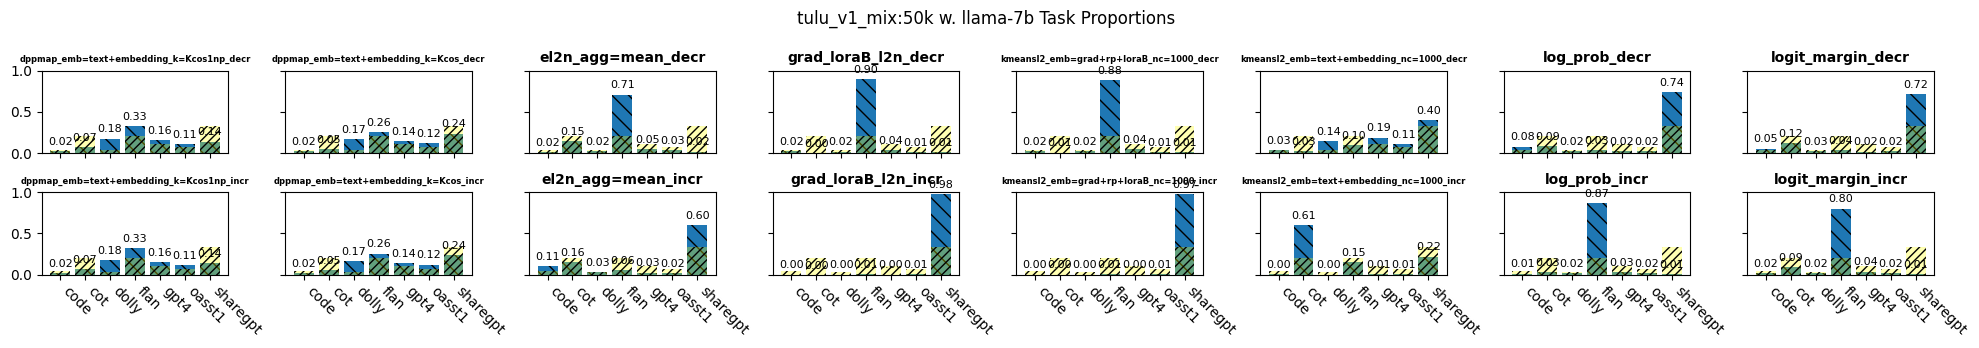

In [9]:
from rosemary import plt_barplot_add_labels


if dataset == 'flan2022':
    baseline_props = {'flan': .4, 't0': .32, 'niv2': .2, 'cot': .05, 'dialog': .03}
else:
    d = dict(Counter(ds_task))
    baseline_props = {k: v/np.sum(list(d.values())) for k, v in d.items()}
print('baseline_props: ', {k: np.round(v, 2) for k,v in baseline_props.items()})
N = len(tasks)//2
# fig, axs = plt.subplots(N, 2, figsize=(5, N*1.5), sharey=True) # height=1.5, width=2.5
fig, axs = plt.subplots(2, N, figsize=(N*2.5, 3.5), sharey=True, sharex=True)
# N = len(tasks)//4
# fig, axs = plt.subplots(4, N, figsize=(N*2.5, 7), sharey=True, sharex=True)

for i, (k, counts) in enumerate(sort_by_counts.items()):
    ax = np.ravel(axs, order='F')[i] # C/F
    bars = ax.bar(counts.keys(), counts.values(), label=k, hatch='\\\\')
    plt_barplot_add_labels(ax, bars, fontsize=8) # , fontsize=7
    ax.bar(counts.keys(), list([baseline_props[k] for k in counts.keys()]), 
           alpha=0.3, hatch='////', color='yellow', label='original')
    if any(x in k for x in ['kmeansl2_emb', 'dppmap']):
        fontsize=6
    else:
        fontsize=10
    ax.set_title(k, fontweight='bold', fontsize=fontsize)
    ax.set_ylim(0, 1)
    ax.set_xticklabels(list(counts.keys()), rotation=-45, ha='left')
#     if i==0: break
    
fig.suptitle(f'{dataset}:{M/1000:.0f}k w. {model_name} Task Proportions')
fig.tight_layout()

save_plt = 0
if save_plt:
    save_path = os.path.join(
        assets_dir, f'note_pruning_analysis_task_props_{model_name}:{dataset}:{M/1000:.0f}k.png')
    fig.savefig(save_path, bbox_inches='tight', dpi=100)

### Plot pruning scores vs. data subsets.

In [8]:
from collections import Counter

sort_subsection = True
sort_by = 'grad_loraB_l2n_incr'
sort_by = 'log_prob_incr'
sort_by = 'kmeansl2_emb=text+embedding_nc=300_incr'

# log_prob_incr
d = df[df['sort_by']==sort_by].iloc[0].to_dict()
S = d['S']
S


array([22.71452904, 26.75788927, 27.35495805, ..., 21.5769927 ,
       25.72490293, 23.24207433])

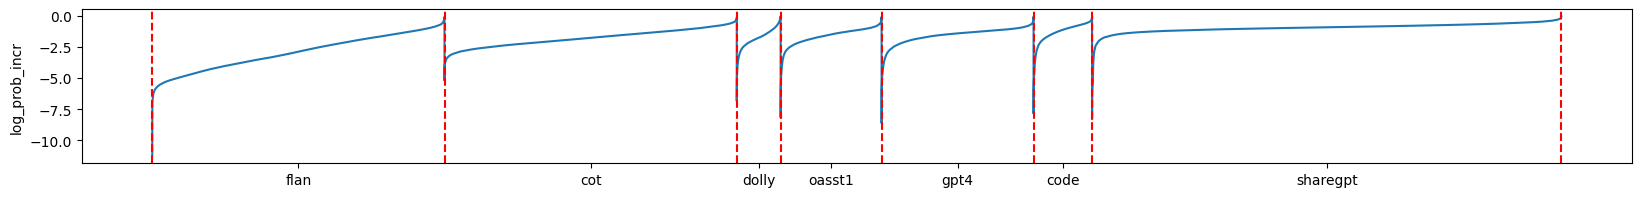

In [9]:

for sort_by in df['sort_by'].tolist():
    if any(x in sort_by for x in ['dppmap']):
        continue

    # log_prob_incr
    d = df[df['sort_by']==sort_by].iloc[0].to_dict()
    S = d['S']

    d = dict(Counter(ds_task))
    l = np.array(list(d.values()))
    l = np.cumsum(l)

    if sort_subsection:
        # Sort elements within each subsection
        S_sort = []
        start = 0
        for end in l:
            S_sort.extend(sorted(S[start:end]))
            start = end
        S_sort = np.array(S_sort)
        S = S_sort

    # plot subsection sorted scores.
    fig, ax = plt.subplots(1,1,figsize=(20,2))
    ax.plot(np.arange(len(S)), S)
    # ax.set_yscale('log')
    ax.set_ylabel(sort_by)

    # vertical lines
    l_with_0 = np.hstack(([0], l))
    for x in l_with_0:
        ax.axvline(x, color='r', linestyle='--')

    middle_points = (l_with_0[:-1] + l_with_0[1:]) / 2
    ax.set_xticks(middle_points)
    ax.set_xticklabels(list(d.keys()))
    break


### For kmeans method, understand kmeans cluster results

In [ ]:
import pickle
p = 'data_inds/llama-7b+lora:r=256:a=256/tulu_v1_mix/kmeansl2_emb=grad+rp+loraB_nc=1000_incr.pkl'
with open(p, 'rb') as f:
    o = pickle.load(f)
print(o.keys())
from collections import Counter, OrderedDict

freq = Counter(o['kmeans'].labels_)
freq = OrderedDict(sorted(freq.items(), key=lambda x: x[1], reverse=True))
freq

### visualize text statistics w.r.t. data subsets obtaind from pruning, e.g., token length, P_LM, etc.

In [ ]:
from scipy.interpolate import make_interp_spline

smooth_kernel_size = 20
# xs_max = total_data_size # M_min
# xs_max = M_min

ylabel_list = ['$P_{LM}$', 'input_len', 'output_len', 'pruning_score']
# sort_by_list = [
#     'dppmap_k=Kcos', 'dppmap_k=Kcos1np',
#     'dppmap_k=Kcosp', 
#     'prob_decr', 
#     'kmeansl2_nc=3000_decr',
#     'random',
# ]

N = len(ylabel_list)
fig, axs = plt.subplots(2, N ,figsize=(5*N, 5*2))

for i, xs_max in enumerate([M_min, total_data_size]):

    for j, ylabel in enumerate(ylabel_list):
        ax = axs[i, j]

        for sort_by in sort_by_list:
            I = np.array(inds[sort_by]['inds'])
            xs = np.round(np.linspace(0, min(xs_max, len(I))-1, 1000)).astype(np.int32)

            if ylabel == '$P_{LM}$':
                ys = logP[I[xs]].squeeze()
                ys = np.exp(ys)
            elif ylabel == 'input_len':
                ys = input_len[I[xs]]
            elif ylabel == 'output_len':
                ys = output_len[I[xs]]
            elif ylabel == 'pruning_score':
                if 'S' not in inds[sort_by]:
                    continue
                ys = np.array(inds[sort_by]['S']).squeeze()[xs]
            else:
                continue

            line, = ax.plot(xs/total_data_size, ys, alpha=.05)
            color = line.get_color()
            ys_smoothed = np.convolve(ys, np.ones(smooth_kernel_size)/smooth_kernel_size, mode='same')
            ax.plot(xs/total_data_size, ys_smoothed, color=color, label=sort_by)

        ax.legend()
        ax.set_ylabel(ylabel, fontsize=25)
        ax.set_xlabel('% Data Selected', fontsize=25)

        if ylabel in ['input_len', 'output_len']:
            ax.set_ylim((0, 700))

suptitle = f'[{dataset}] Text statistics for data subsets'
fig.suptitle(suptitle, fontsize=30)
fig.tight_layout()

save_path = os.path.join(
    assets_dir, f'note_pruning_analysis_text_statistics_trend_{dataset}.png')
fig.savefig(save_path, bbox_inches='tight', dpi=100)